In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
df=pd.read_excel('../optimal_data3_1/'+'Continous_2weeks_5day_3term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (19500, 6) (19500,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50937, 6) (50937,)
SMOTE 적용 전 레이블 값 분포: 
 0    16979
1     1648
2      873
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    16979
1    16979
2    16979
Name: 8, dtype: int64


In [3]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

10

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [5]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [6]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [7]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [8]:
# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

In [9]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

10

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.09971. Saving Model!
epoch 01, loss: 1.16128, acc: 0.05414, val_loss: 1.09971, val_accuracy: 0.36121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


[INFO] val_acc has been improved from 1.09971 to 1.08770. Saving Model!
epoch 02, loss: 1.09686, acc: 0.35203, val_loss: 1.08770, val_accuracy: 0.44562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


[INFO] val_acc has been improved from 1.08770 to 1.08097. Saving Model!
epoch 03, loss: 1.08959, acc: 0.43874, val_loss: 1.08097, val_accuracy: 0.45622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 1.08097 to 1.07520. Saving Model!
epoch 04, loss: 1.08593, acc: 0.44781, val_loss: 1.07520, val_accuracy: 0.46859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 1.07520 to 1.06921. Saving Model!
epoch 05, loss: 1.08275, acc: 0.42988, val_loss: 1.06921, val_accuracy: 0.46643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 1.06921 to 1.06232. Saving Model!
epoch 06, loss: 1.07937, acc: 0.42275, val_loss: 1.06232, val_accuracy: 0.46761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 1.06232 to 1.05418. Saving Model!
epoch 07, loss: 1.07530, acc: 0.41575, val_loss: 1.05418, val_accuracy: 0.46054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


[INFO] val_acc has been improved from 1.05418 to 1.04523. Saving Model!
epoch 08, loss: 1.07084, acc: 0.41852, val_loss: 1.04523, val_accuracy: 0.45465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 1.04523 to 1.03592. Saving Model!
epoch 09, loss: 1.06642, acc: 0.42159, val_loss: 1.03592, val_accuracy: 0.45446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[INFO] val_acc has been improved from 1.03592 to 1.02686. Saving Model!
epoch 10, loss: 1.06208, acc: 0.42222, val_loss: 1.02686, val_accuracy: 0.45387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 1.02686 to 1.01856. Saving Model!
epoch 11, loss: 1.05804, acc: 0.42451, val_loss: 1.01856, val_accuracy: 0.45426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 1.01856 to 1.01149. Saving Model!
epoch 12, loss: 1.05434, acc: 0.42530, val_loss: 1.01149, val_accuracy: 0.45603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 1.01149 to 1.00571. Saving Model!
epoch 13, loss: 1.05102, acc: 0.42517, val_loss: 1.00571, val_accuracy: 0.45897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 1.00571 to 1.00103. Saving Model!
epoch 14, loss: 1.04812, acc: 0.42894, val_loss: 1.00103, val_accuracy: 0.46270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 1.00103 to 0.99709. Saving Model!
epoch 15, loss: 1.04568, acc: 0.42886, val_loss: 0.99709, val_accuracy: 0.46388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.99709 to 0.99356. Saving Model!
epoch 16, loss: 1.04351, acc: 0.43027, val_loss: 0.99356, val_accuracy: 0.46408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.99356 to 0.99027. Saving Model!
epoch 17, loss: 1.04161, acc: 0.42962, val_loss: 0.99027, val_accuracy: 0.46427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.99027 to 0.98719. Saving Model!
epoch 18, loss: 1.03984, acc: 0.43060, val_loss: 0.98719, val_accuracy: 0.46682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.98719 to 0.98431. Saving Model!
epoch 19, loss: 1.03812, acc: 0.42999, val_loss: 0.98431, val_accuracy: 0.46722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.98431 to 0.98169. Saving Model!
epoch 20, loss: 1.03630, acc: 0.43019, val_loss: 0.98169, val_accuracy: 0.46604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


[INFO] val_acc has been improved from 0.98169 to 0.97928. Saving Model!
epoch 21, loss: 1.03446, acc: 0.43313, val_loss: 0.97928, val_accuracy: 0.46623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.97928 to 0.97706. Saving Model!
epoch 22, loss: 1.03267, acc: 0.43363, val_loss: 0.97706, val_accuracy: 0.46584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.97706 to 0.97500. Saving Model!
epoch 23, loss: 1.03094, acc: 0.43400, val_loss: 0.97500, val_accuracy: 0.47801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.97500 to 0.97305. Saving Model!
epoch 24, loss: 1.02931, acc: 0.43795, val_loss: 0.97305, val_accuracy: 0.48037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.97305 to 0.97127. Saving Model!
epoch 25, loss: 1.02763, acc: 0.43804, val_loss: 0.97127, val_accuracy: 0.48312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.97127 to 0.96962. Saving Model!
epoch 26, loss: 1.02595, acc: 0.44292, val_loss: 0.96962, val_accuracy: 0.48665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.96962 to 0.96808. Saving Model!
epoch 27, loss: 1.02430, acc: 0.44240, val_loss: 0.96808, val_accuracy: 0.48822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.96808 to 0.96659. Saving Model!
epoch 28, loss: 1.02270, acc: 0.44114, val_loss: 0.96659, val_accuracy: 0.48940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.96659 to 0.96511. Saving Model!
epoch 29, loss: 1.02114, acc: 0.43985, val_loss: 0.96511, val_accuracy: 0.49450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.96511 to 0.96365. Saving Model!
epoch 30, loss: 1.01955, acc: 0.44199, val_loss: 0.96365, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.96365 to 0.96230. Saving Model!
epoch 31, loss: 1.01789, acc: 0.44138, val_loss: 0.96230, val_accuracy: 0.49823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.96230 to 0.96105. Saving Model!
epoch 32, loss: 1.01623, acc: 0.44432, val_loss: 0.96105, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.96105 to 0.95989. Saving Model!
epoch 33, loss: 1.01464, acc: 0.44916, val_loss: 0.95989, val_accuracy: 0.50137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.95989 to 0.95876. Saving Model!
epoch 34, loss: 1.01317, acc: 0.45100, val_loss: 0.95876, val_accuracy: 0.50059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.95876 to 0.95771. Saving Model!
epoch 35, loss: 1.01172, acc: 0.45483, val_loss: 0.95771, val_accuracy: 0.50118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.95771 to 0.95671. Saving Model!
epoch 36, loss: 1.01023, acc: 0.45483, val_loss: 0.95671, val_accuracy: 0.50098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.95671 to 0.95581. Saving Model!
epoch 37, loss: 1.00877, acc: 0.45536, val_loss: 0.95581, val_accuracy: 0.50824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.95581 to 0.95500. Saving Model!
epoch 38, loss: 1.00735, acc: 0.45601, val_loss: 0.95500, val_accuracy: 0.50883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.95500 to 0.95424. Saving Model!
epoch 39, loss: 1.00592, acc: 0.45848, val_loss: 0.95424, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.95424 to 0.95356. Saving Model!
epoch 40, loss: 1.00453, acc: 0.46005, val_loss: 0.95356, val_accuracy: 0.50903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.95356 to 0.95288. Saving Model!
epoch 41, loss: 1.00320, acc: 0.46186, val_loss: 0.95288, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.95288 to 0.95226. Saving Model!
epoch 42, loss: 1.00195, acc: 0.46278, val_loss: 0.95226, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.95226 to 0.95163. Saving Model!
epoch 43, loss: 1.00078, acc: 0.46341, val_loss: 0.95163, val_accuracy: 0.50824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.95163 to 0.95099. Saving Model!
epoch 44, loss: 0.99963, acc: 0.46373, val_loss: 0.95099, val_accuracy: 0.50883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.95099 to 0.95039. Saving Model!
epoch 45, loss: 0.99842, acc: 0.46531, val_loss: 0.95039, val_accuracy: 0.50883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


[INFO] val_acc has been improved from 0.95039 to 0.94978. Saving Model!
epoch 46, loss: 0.99729, acc: 0.46487, val_loss: 0.94978, val_accuracy: 0.51001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.94978 to 0.94923. Saving Model!
epoch 47, loss: 0.99614, acc: 0.46552, val_loss: 0.94923, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.94923 to 0.94870. Saving Model!
epoch 48, loss: 0.99501, acc: 0.46563, val_loss: 0.94870, val_accuracy: 0.50648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.94870 to 0.94816. Saving Model!
epoch 49, loss: 0.99389, acc: 0.46622, val_loss: 0.94816, val_accuracy: 0.50667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


[INFO] val_acc has been improved from 0.94816 to 0.94764. Saving Model!
epoch 50, loss: 0.99286, acc: 0.46677, val_loss: 0.94764, val_accuracy: 0.51021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.94764 to 0.94710. Saving Model!
epoch 51, loss: 0.99169, acc: 0.46973, val_loss: 0.94710, val_accuracy: 0.51021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.94710 to 0.94663. Saving Model!
epoch 52, loss: 0.99051, acc: 0.46989, val_loss: 0.94663, val_accuracy: 0.51099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.94663 to 0.94616. Saving Model!
epoch 53, loss: 0.98950, acc: 0.47082, val_loss: 0.94616, val_accuracy: 0.51197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.94616 to 0.94563. Saving Model!
epoch 54, loss: 0.98859, acc: 0.47305, val_loss: 0.94563, val_accuracy: 0.51335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.94563 to 0.94512. Saving Model!
epoch 55, loss: 0.98751, acc: 0.47394, val_loss: 0.94512, val_accuracy: 0.51355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.94512 to 0.94464. Saving Model!
epoch 56, loss: 0.98643, acc: 0.47519, val_loss: 0.94464, val_accuracy: 0.51413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.94464 to 0.94415. Saving Model!
epoch 57, loss: 0.98533, acc: 0.47641, val_loss: 0.94415, val_accuracy: 0.51531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.94415 to 0.94369. Saving Model!
epoch 58, loss: 0.98431, acc: 0.47693, val_loss: 0.94369, val_accuracy: 0.50294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.94369 to 0.94322. Saving Model!
epoch 59, loss: 0.98335, acc: 0.47726, val_loss: 0.94322, val_accuracy: 0.50334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.94322 to 0.94274. Saving Model!
epoch 60, loss: 0.98239, acc: 0.47695, val_loss: 0.94274, val_accuracy: 0.50393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.94274 to 0.94225. Saving Model!
epoch 61, loss: 0.98130, acc: 0.47872, val_loss: 0.94225, val_accuracy: 0.50412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.94225 to 0.94174. Saving Model!
epoch 62, loss: 0.98030, acc: 0.47924, val_loss: 0.94174, val_accuracy: 0.50491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.94174 to 0.94121. Saving Model!
epoch 63, loss: 0.97923, acc: 0.48084, val_loss: 0.94121, val_accuracy: 0.50530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.94121 to 0.94072. Saving Model!
epoch 64, loss: 0.97830, acc: 0.48171, val_loss: 0.94072, val_accuracy: 0.50491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.94072 to 0.94021. Saving Model!
epoch 65, loss: 0.97729, acc: 0.48236, val_loss: 0.94021, val_accuracy: 0.50550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.94021 to 0.93975. Saving Model!
epoch 66, loss: 0.97624, acc: 0.48306, val_loss: 0.93975, val_accuracy: 0.50667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.93975 to 0.93929. Saving Model!
epoch 67, loss: 0.97528, acc: 0.48378, val_loss: 0.93929, val_accuracy: 0.50687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.93929 to 0.93887. Saving Model!
epoch 68, loss: 0.97430, acc: 0.48407, val_loss: 0.93887, val_accuracy: 0.50746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.93887 to 0.93845. Saving Model!
epoch 69, loss: 0.97329, acc: 0.48446, val_loss: 0.93845, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.93845 to 0.93799. Saving Model!
epoch 70, loss: 0.97227, acc: 0.48526, val_loss: 0.93799, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.93799 to 0.93754. Saving Model!
epoch 71, loss: 0.97133, acc: 0.48474, val_loss: 0.93754, val_accuracy: 0.50864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.93754 to 0.93716. Saving Model!
epoch 72, loss: 0.97032, acc: 0.48601, val_loss: 0.93716, val_accuracy: 0.50923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


[INFO] val_acc has been improved from 0.93716 to 0.93672. Saving Model!
epoch 73, loss: 0.96930, acc: 0.48631, val_loss: 0.93672, val_accuracy: 0.51021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.93672 to 0.93631. Saving Model!
epoch 74, loss: 0.96834, acc: 0.48688, val_loss: 0.93631, val_accuracy: 0.51178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.93631 to 0.93598. Saving Model!
epoch 75, loss: 0.96738, acc: 0.48738, val_loss: 0.93598, val_accuracy: 0.51256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.93598 to 0.93554. Saving Model!
epoch 76, loss: 0.96636, acc: 0.48769, val_loss: 0.93554, val_accuracy: 0.51276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


[INFO] val_acc has been improved from 0.93554 to 0.93511. Saving Model!
epoch 77, loss: 0.96543, acc: 0.48849, val_loss: 0.93511, val_accuracy: 0.51335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.93511 to 0.93469. Saving Model!
epoch 78, loss: 0.96445, acc: 0.48841, val_loss: 0.93469, val_accuracy: 0.51178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.93469 to 0.93421. Saving Model!
epoch 79, loss: 0.96343, acc: 0.48897, val_loss: 0.93421, val_accuracy: 0.51139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.93421 to 0.93382. Saving Model!
epoch 80, loss: 0.96241, acc: 0.48956, val_loss: 0.93382, val_accuracy: 0.51197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.93382 to 0.93342. Saving Model!
epoch 81, loss: 0.96133, acc: 0.49057, val_loss: 0.93342, val_accuracy: 0.51256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.93342 to 0.93304. Saving Model!
epoch 82, loss: 0.96045, acc: 0.49063, val_loss: 0.93304, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.93304 to 0.93258. Saving Model!
epoch 83, loss: 0.95949, acc: 0.49190, val_loss: 0.93258, val_accuracy: 0.51394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.93258 to 0.93224. Saving Model!
epoch 84, loss: 0.95848, acc: 0.49262, val_loss: 0.93224, val_accuracy: 0.51374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.93224 to 0.93182. Saving Model!
epoch 85, loss: 0.95753, acc: 0.49297, val_loss: 0.93182, val_accuracy: 0.51551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.93182 to 0.93146. Saving Model!
epoch 86, loss: 0.95652, acc: 0.49251, val_loss: 0.93146, val_accuracy: 0.51590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.93146 to 0.93109. Saving Model!
epoch 87, loss: 0.95548, acc: 0.49366, val_loss: 0.93109, val_accuracy: 0.51688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.93109 to 0.93069. Saving Model!
epoch 88, loss: 0.95453, acc: 0.49375, val_loss: 0.93069, val_accuracy: 0.51649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.93069 to 0.93031. Saving Model!
epoch 89, loss: 0.95355, acc: 0.49467, val_loss: 0.93031, val_accuracy: 0.51728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.93031 to 0.93001. Saving Model!
epoch 90, loss: 0.95241, acc: 0.49526, val_loss: 0.93001, val_accuracy: 0.51728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.93001 to 0.92972. Saving Model!
epoch 91, loss: 0.95141, acc: 0.49670, val_loss: 0.92972, val_accuracy: 0.51747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.92972 to 0.92943. Saving Model!
epoch 92, loss: 0.95049, acc: 0.49722, val_loss: 0.92943, val_accuracy: 0.51708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.92943 to 0.92924. Saving Model!
epoch 93, loss: 0.94941, acc: 0.49877, val_loss: 0.92924, val_accuracy: 0.51826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.92924 to 0.92908. Saving Model!
epoch 94, loss: 0.94832, acc: 0.50032, val_loss: 0.92908, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.92908 to 0.92890. Saving Model!
epoch 95, loss: 0.94738, acc: 0.50104, val_loss: 0.92890, val_accuracy: 0.51963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.92890 to 0.92871. Saving Model!
epoch 96, loss: 0.94639, acc: 0.50117, val_loss: 0.92871, val_accuracy: 0.52415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.92871 to 0.92849. Saving Model!
epoch 97, loss: 0.94530, acc: 0.50241, val_loss: 0.92849, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.92849 to 0.92824. Saving Model!
epoch 98, loss: 0.94414, acc: 0.50291, val_loss: 0.92824, val_accuracy: 0.52709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.92824 to 0.92791. Saving Model!
epoch 99, loss: 0.94330, acc: 0.50328, val_loss: 0.92791, val_accuracy: 0.52689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.92791 to 0.92786. Saving Model!
epoch 100, loss: 0.94205, acc: 0.50485, val_loss: 0.92786, val_accuracy: 0.52709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.92786 to 0.92761. Saving Model!
epoch 101, loss: 0.94109, acc: 0.50706, val_loss: 0.92761, val_accuracy: 0.52768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.92761 to 0.92730. Saving Model!
epoch 102, loss: 0.94000, acc: 0.50760, val_loss: 0.92730, val_accuracy: 0.53023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.92730 to 0.92714. Saving Model!
epoch 103, loss: 0.93898, acc: 0.50909, val_loss: 0.92714, val_accuracy: 0.53239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.92714 to 0.92712. Saving Model!
epoch 104, loss: 0.93777, acc: 0.51066, val_loss: 0.92712, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.92712 to 0.92688. Saving Model!
epoch 105, loss: 0.93686, acc: 0.51138, val_loss: 0.92688, val_accuracy: 0.53534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 106, loss: 0.93565, acc: 0.51264, val_loss: 0.92704, val_accuracy: 0.53612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 107, loss: 0.93476, acc: 0.51417, val_loss: 0.92694, val_accuracy: 0.53671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.92688 to 0.92676. Saving Model!
epoch 108, loss: 0.93360, acc: 0.51556, val_loss: 0.92676, val_accuracy: 0.53848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.92676 to 0.92670. Saving Model!
epoch 109, loss: 0.93248, acc: 0.51711, val_loss: 0.92670, val_accuracy: 0.54005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 110, loss: 0.93152, acc: 0.51840, val_loss: 0.92673, val_accuracy: 0.54122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 111, loss: 0.93034, acc: 0.51958, val_loss: 0.92682, val_accuracy: 0.54201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 112, loss: 0.92928, acc: 0.52169, val_loss: 0.92693, val_accuracy: 0.54240


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 113, loss: 0.92815, acc: 0.52337, val_loss: 0.92728, val_accuracy: 0.54378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 114, loss: 0.92704, acc: 0.52466, val_loss: 0.92740, val_accuracy: 0.54437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 115, loss: 0.92609, acc: 0.52442, val_loss: 0.92768, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 116, loss: 0.92495, acc: 0.52614, val_loss: 0.92814, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 117, loss: 0.92373, acc: 0.52726, val_loss: 0.92873, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 118, loss: 0.92266, acc: 0.52815, val_loss: 0.92926, val_accuracy: 0.54908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 119, loss: 0.92160, acc: 0.53000, val_loss: 0.92965, val_accuracy: 0.54908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 120, loss: 0.92060, acc: 0.53123, val_loss: 0.93054, val_accuracy: 0.53789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 121, loss: 0.91934, acc: 0.53256, val_loss: 0.93132, val_accuracy: 0.53965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 122, loss: 0.91821, acc: 0.53358, val_loss: 0.93227, val_accuracy: 0.54005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 123, loss: 0.91738, acc: 0.53472, val_loss: 0.93295, val_accuracy: 0.54024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 124, loss: 0.91595, acc: 0.53589, val_loss: 0.93413, val_accuracy: 0.54064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 125, loss: 0.91494, acc: 0.53633, val_loss: 0.93516, val_accuracy: 0.54201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 126, loss: 0.91400, acc: 0.53679, val_loss: 0.93607, val_accuracy: 0.54299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 127, loss: 0.91283, acc: 0.53823, val_loss: 0.93763, val_accuracy: 0.54437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 128, loss: 0.91161, acc: 0.53989, val_loss: 0.93922, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 129, loss: 0.91051, acc: 0.54067, val_loss: 0.94055, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 130, loss: 0.90924, acc: 0.54100, val_loss: 0.94140, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


epoch 131, loss: 0.90843, acc: 0.54174, val_loss: 0.94265, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 132, loss: 0.90695, acc: 0.54294, val_loss: 0.94408, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 133, loss: 0.90591, acc: 0.54366, val_loss: 0.94563, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 134, loss: 0.90512, acc: 0.54495, val_loss: 0.94682, val_accuracy: 0.54378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 135, loss: 0.90366, acc: 0.54691, val_loss: 0.94799, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 136, loss: 0.90273, acc: 0.54807, val_loss: 0.94966, val_accuracy: 0.54515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 137, loss: 0.90168, acc: 0.54883, val_loss: 0.95136, val_accuracy: 0.54515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 138, loss: 0.90063, acc: 0.55079, val_loss: 0.95289, val_accuracy: 0.54515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 139, loss: 0.89955, acc: 0.55293, val_loss: 0.95440, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 140, loss: 0.89842, acc: 0.55369, val_loss: 0.95528, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 141, loss: 0.89750, acc: 0.55437, val_loss: 0.95610, val_accuracy: 0.54535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 142, loss: 0.89636, acc: 0.55505, val_loss: 0.95666, val_accuracy: 0.54574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 143, loss: 0.89516, acc: 0.55572, val_loss: 0.95741, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 144, loss: 0.89431, acc: 0.55721, val_loss: 0.95750, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 145, loss: 0.89311, acc: 0.55753, val_loss: 0.95815, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 146, loss: 0.89223, acc: 0.55825, val_loss: 0.95820, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 147, loss: 0.89102, acc: 0.55891, val_loss: 0.95899, val_accuracy: 0.54829


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 148, loss: 0.88979, acc: 0.55965, val_loss: 0.95964, val_accuracy: 0.54849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 149, loss: 0.88888, acc: 0.55985, val_loss: 0.96071, val_accuracy: 0.54947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 150, loss: 0.88785, acc: 0.56076, val_loss: 0.96244, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 151, loss: 0.88646, acc: 0.56148, val_loss: 0.96230, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 152, loss: 0.88565, acc: 0.56203, val_loss: 0.96334, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 153, loss: 0.88451, acc: 0.56334, val_loss: 0.96460, val_accuracy: 0.55065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 154, loss: 0.88338, acc: 0.56451, val_loss: 0.96587, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 155, loss: 0.88255, acc: 0.56482, val_loss: 0.96647, val_accuracy: 0.55104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 156, loss: 0.88133, acc: 0.56536, val_loss: 0.96736, val_accuracy: 0.55104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 157, loss: 0.88021, acc: 0.56624, val_loss: 0.96863, val_accuracy: 0.55241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 158, loss: 0.87940, acc: 0.56680, val_loss: 0.96904, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 159, loss: 0.87806, acc: 0.56805, val_loss: 0.97053, val_accuracy: 0.55379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 160, loss: 0.87728, acc: 0.56890, val_loss: 0.97140, val_accuracy: 0.55399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 161, loss: 0.87613, acc: 0.56938, val_loss: 0.97170, val_accuracy: 0.55399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 162, loss: 0.87505, acc: 0.57023, val_loss: 0.97244, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 163, loss: 0.87421, acc: 0.57114, val_loss: 0.97342, val_accuracy: 0.55654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 164, loss: 0.87285, acc: 0.57189, val_loss: 0.97370, val_accuracy: 0.55752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 165, loss: 0.87219, acc: 0.57352, val_loss: 0.97508, val_accuracy: 0.55771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 166, loss: 0.87088, acc: 0.57437, val_loss: 0.97598, val_accuracy: 0.55830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 167, loss: 0.87022, acc: 0.57505, val_loss: 0.97570, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 168, loss: 0.86884, acc: 0.57553, val_loss: 0.97699, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 169, loss: 0.86812, acc: 0.57588, val_loss: 0.97777, val_accuracy: 0.56027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 170, loss: 0.86700, acc: 0.57662, val_loss: 0.97856, val_accuracy: 0.56046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 171, loss: 0.86591, acc: 0.57695, val_loss: 0.97907, val_accuracy: 0.56066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 172, loss: 0.86506, acc: 0.57775, val_loss: 0.98049, val_accuracy: 0.56144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 173, loss: 0.86411, acc: 0.57782, val_loss: 0.98041, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 174, loss: 0.86307, acc: 0.57869, val_loss: 0.98101, val_accuracy: 0.56321


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 175, loss: 0.86168, acc: 0.57950, val_loss: 0.98272, val_accuracy: 0.56282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 176, loss: 0.86142, acc: 0.57987, val_loss: 0.98205, val_accuracy: 0.56321


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 177, loss: 0.85969, acc: 0.58031, val_loss: 0.98336, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 178, loss: 0.85922, acc: 0.58207, val_loss: 0.98435, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 179, loss: 0.85795, acc: 0.58203, val_loss: 0.98500, val_accuracy: 0.56714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 180, loss: 0.85713, acc: 0.58325, val_loss: 0.98555, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 181, loss: 0.85612, acc: 0.58452, val_loss: 0.98611, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 182, loss: 0.85506, acc: 0.58504, val_loss: 0.98636, val_accuracy: 0.56792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 183, loss: 0.85430, acc: 0.58622, val_loss: 0.98735, val_accuracy: 0.56890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 184, loss: 0.85290, acc: 0.58668, val_loss: 0.98812, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 185, loss: 0.85251, acc: 0.58768, val_loss: 0.98830, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 186, loss: 0.85118, acc: 0.58794, val_loss: 0.98858, val_accuracy: 0.56890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 187, loss: 0.85027, acc: 0.58836, val_loss: 0.98940, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 188, loss: 0.84924, acc: 0.58886, val_loss: 0.99049, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 189, loss: 0.84868, acc: 0.59001, val_loss: 0.99111, val_accuracy: 0.57381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 190, loss: 0.84724, acc: 0.59110, val_loss: 0.99132, val_accuracy: 0.57381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 191, loss: 0.84676, acc: 0.59093, val_loss: 0.99131, val_accuracy: 0.57519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 192, loss: 0.84530, acc: 0.59145, val_loss: 0.99252, val_accuracy: 0.57479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 193, loss: 0.84462, acc: 0.59230, val_loss: 0.99336, val_accuracy: 0.57460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 194, loss: 0.84375, acc: 0.59329, val_loss: 0.99336, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 195, loss: 0.84282, acc: 0.59387, val_loss: 0.99408, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 196, loss: 0.84183, acc: 0.59453, val_loss: 0.99545, val_accuracy: 0.57793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 197, loss: 0.84098, acc: 0.59518, val_loss: 0.99591, val_accuracy: 0.57872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 198, loss: 0.84009, acc: 0.59512, val_loss: 0.99604, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 199, loss: 0.83904, acc: 0.59569, val_loss: 0.99675, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 200, loss: 0.83841, acc: 0.59614, val_loss: 0.99754, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 201, loss: 0.83712, acc: 0.59771, val_loss: 0.99874, val_accuracy: 0.58009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 202, loss: 0.83657, acc: 0.59806, val_loss: 0.99905, val_accuracy: 0.57990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 203, loss: 0.83571, acc: 0.59856, val_loss: 0.99929, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 204, loss: 0.83453, acc: 0.59942, val_loss: 0.99985, val_accuracy: 0.58049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 205, loss: 0.83393, acc: 0.59981, val_loss: 1.00050, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 206, loss: 0.83290, acc: 0.60003, val_loss: 0.99975, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 207, loss: 0.83204, acc: 0.60064, val_loss: 1.00094, val_accuracy: 0.58108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 208, loss: 0.83099, acc: 0.60168, val_loss: 1.00135, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 209, loss: 0.83038, acc: 0.60190, val_loss: 1.00118, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 210, loss: 0.82951, acc: 0.60310, val_loss: 1.00117, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 211, loss: 0.82837, acc: 0.60378, val_loss: 1.00153, val_accuracy: 0.58108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 212, loss: 0.82763, acc: 0.60437, val_loss: 1.00195, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 213, loss: 0.82666, acc: 0.60587, val_loss: 1.00306, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 214, loss: 0.82601, acc: 0.60633, val_loss: 1.00310, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 215, loss: 0.82483, acc: 0.60751, val_loss: 1.00337, val_accuracy: 0.58206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 216, loss: 0.82445, acc: 0.60746, val_loss: 1.00356, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 217, loss: 0.82299, acc: 0.60834, val_loss: 1.00463, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 218, loss: 0.82265, acc: 0.60893, val_loss: 1.00464, val_accuracy: 0.57793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 219, loss: 0.82132, acc: 0.60901, val_loss: 1.00472, val_accuracy: 0.57911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 220, loss: 0.82102, acc: 0.60969, val_loss: 1.00543, val_accuracy: 0.57951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 221, loss: 0.81981, acc: 0.61056, val_loss: 1.00491, val_accuracy: 0.58029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 222, loss: 0.81891, acc: 0.61076, val_loss: 1.00513, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 223, loss: 0.81797, acc: 0.61139, val_loss: 1.00531, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 224, loss: 0.81760, acc: 0.61161, val_loss: 1.00571, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 225, loss: 0.81624, acc: 0.61344, val_loss: 1.00582, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 226, loss: 0.81559, acc: 0.61316, val_loss: 1.00610, val_accuracy: 0.58245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 227, loss: 0.81479, acc: 0.61403, val_loss: 1.00565, val_accuracy: 0.58245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 228, loss: 0.81386, acc: 0.61386, val_loss: 1.00637, val_accuracy: 0.58284


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 229, loss: 0.81307, acc: 0.61551, val_loss: 1.00633, val_accuracy: 0.58324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 230, loss: 0.81226, acc: 0.61582, val_loss: 1.00651, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 231, loss: 0.81138, acc: 0.61636, val_loss: 1.00589, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 232, loss: 0.81088, acc: 0.61667, val_loss: 1.00619, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 233, loss: 0.80977, acc: 0.61746, val_loss: 1.00582, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 234, loss: 0.80919, acc: 0.61750, val_loss: 1.00546, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 235, loss: 0.80795, acc: 0.61898, val_loss: 1.00624, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 236, loss: 0.80763, acc: 0.61918, val_loss: 1.00531, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 237, loss: 0.80661, acc: 0.61964, val_loss: 1.00546, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 238, loss: 0.80591, acc: 0.62003, val_loss: 1.00418, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 239, loss: 0.80480, acc: 0.62038, val_loss: 1.00443, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 240, loss: 0.80416, acc: 0.62103, val_loss: 1.00416, val_accuracy: 0.58697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 241, loss: 0.80373, acc: 0.62129, val_loss: 1.00396, val_accuracy: 0.58716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 242, loss: 0.80238, acc: 0.62223, val_loss: 1.00322, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 243, loss: 0.80182, acc: 0.62276, val_loss: 1.00376, val_accuracy: 0.58814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 244, loss: 0.80126, acc: 0.62291, val_loss: 1.00221, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 245, loss: 0.80033, acc: 0.62310, val_loss: 1.00272, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 246, loss: 0.79914, acc: 0.62417, val_loss: 1.00265, val_accuracy: 0.58854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 247, loss: 0.79888, acc: 0.62426, val_loss: 1.00256, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 248, loss: 0.79798, acc: 0.62446, val_loss: 1.00240, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 249, loss: 0.79704, acc: 0.62446, val_loss: 1.00297, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 250, loss: 0.79657, acc: 0.62496, val_loss: 1.00263, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 251, loss: 0.79603, acc: 0.62537, val_loss: 1.00315, val_accuracy: 0.58559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 252, loss: 0.79475, acc: 0.62572, val_loss: 1.00332, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 253, loss: 0.79461, acc: 0.62662, val_loss: 1.00227, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 254, loss: 0.79304, acc: 0.62734, val_loss: 1.00256, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 255, loss: 0.79320, acc: 0.62684, val_loss: 1.00300, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 256, loss: 0.79188, acc: 0.62775, val_loss: 1.00320, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 257, loss: 0.79134, acc: 0.62801, val_loss: 1.00192, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 258, loss: 0.79057, acc: 0.62808, val_loss: 1.00185, val_accuracy: 0.58814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 259, loss: 0.79007, acc: 0.62819, val_loss: 1.00189, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 260, loss: 0.78916, acc: 0.62862, val_loss: 1.00139, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 261, loss: 0.78856, acc: 0.62891, val_loss: 1.00115, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 262, loss: 0.78753, acc: 0.62947, val_loss: 1.00144, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 263, loss: 0.78742, acc: 0.62934, val_loss: 1.00170, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 264, loss: 0.78596, acc: 0.62987, val_loss: 1.00203, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 265, loss: 0.78587, acc: 0.63015, val_loss: 1.00057, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 266, loss: 0.78500, acc: 0.63011, val_loss: 1.00045, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 267, loss: 0.78444, acc: 0.63022, val_loss: 1.00014, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 268, loss: 0.78328, acc: 0.63091, val_loss: 1.00061, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 269, loss: 0.78296, acc: 0.63111, val_loss: 1.00134, val_accuracy: 0.59148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 270, loss: 0.78227, acc: 0.63185, val_loss: 1.00094, val_accuracy: 0.59266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 271, loss: 0.78139, acc: 0.63118, val_loss: 0.99987, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 272, loss: 0.78083, acc: 0.63139, val_loss: 1.00081, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 273, loss: 0.78010, acc: 0.63179, val_loss: 1.00002, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 274, loss: 0.77965, acc: 0.63229, val_loss: 0.99871, val_accuracy: 0.59462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 275, loss: 0.77834, acc: 0.63305, val_loss: 0.99915, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 276, loss: 0.77809, acc: 0.63253, val_loss: 0.99865, val_accuracy: 0.59600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 277, loss: 0.77742, acc: 0.63366, val_loss: 0.99787, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 278, loss: 0.77667, acc: 0.63412, val_loss: 0.99749, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 279, loss: 0.77582, acc: 0.63366, val_loss: 0.99658, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 280, loss: 0.77543, acc: 0.63406, val_loss: 0.99644, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 281, loss: 0.77466, acc: 0.63456, val_loss: 0.99621, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 282, loss: 0.77400, acc: 0.63510, val_loss: 0.99596, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 283, loss: 0.77323, acc: 0.63556, val_loss: 0.99581, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 284, loss: 0.77270, acc: 0.63584, val_loss: 0.99661, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 285, loss: 0.77215, acc: 0.63645, val_loss: 0.99444, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 286, loss: 0.77126, acc: 0.63748, val_loss: 0.99560, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 287, loss: 0.77053, acc: 0.63787, val_loss: 0.99521, val_accuracy: 0.60561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 288, loss: 0.77028, acc: 0.63824, val_loss: 0.99426, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 289, loss: 0.76908, acc: 0.63870, val_loss: 0.99539, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 290, loss: 0.76930, acc: 0.63866, val_loss: 0.99452, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 291, loss: 0.76774, acc: 0.63877, val_loss: 0.99334, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 292, loss: 0.76744, acc: 0.63875, val_loss: 0.99385, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 293, loss: 0.76683, acc: 0.63929, val_loss: 0.99357, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 294, loss: 0.76629, acc: 0.63973, val_loss: 0.99329, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 295, loss: 0.76525, acc: 0.64003, val_loss: 0.99446, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 296, loss: 0.76507, acc: 0.64056, val_loss: 0.99328, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 297, loss: 0.76409, acc: 0.64086, val_loss: 0.99233, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 298, loss: 0.76364, acc: 0.64138, val_loss: 0.99274, val_accuracy: 0.60228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 299, loss: 0.76310, acc: 0.64138, val_loss: 0.99217, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 300, loss: 0.76213, acc: 0.64176, val_loss: 0.99282, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 301, loss: 0.76172, acc: 0.64221, val_loss: 0.99163, val_accuracy: 0.60228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 302, loss: 0.76130, acc: 0.64191, val_loss: 0.99122, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 303, loss: 0.76003, acc: 0.64239, val_loss: 0.99276, val_accuracy: 0.60306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 304, loss: 0.76004, acc: 0.64248, val_loss: 0.99079, val_accuracy: 0.60306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 305, loss: 0.75887, acc: 0.64263, val_loss: 0.99183, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 306, loss: 0.75886, acc: 0.64237, val_loss: 0.99083, val_accuracy: 0.60326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 307, loss: 0.75744, acc: 0.64320, val_loss: 0.99096, val_accuracy: 0.60424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 308, loss: 0.75750, acc: 0.64341, val_loss: 0.99180, val_accuracy: 0.60424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 309, loss: 0.75663, acc: 0.64359, val_loss: 0.99153, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 310, loss: 0.75599, acc: 0.64396, val_loss: 0.99033, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 311, loss: 0.75513, acc: 0.64459, val_loss: 0.99100, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 312, loss: 0.75493, acc: 0.64505, val_loss: 0.99037, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 313, loss: 0.75397, acc: 0.64492, val_loss: 0.99122, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 314, loss: 0.75385, acc: 0.64525, val_loss: 0.98951, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 315, loss: 0.75268, acc: 0.64583, val_loss: 0.99024, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 316, loss: 0.75251, acc: 0.64592, val_loss: 0.98949, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 317, loss: 0.75174, acc: 0.64607, val_loss: 0.98988, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 318, loss: 0.75134, acc: 0.64618, val_loss: 0.99000, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 319, loss: 0.75047, acc: 0.64636, val_loss: 0.98985, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 320, loss: 0.75008, acc: 0.64669, val_loss: 0.98792, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 321, loss: 0.74963, acc: 0.64686, val_loss: 0.98898, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 322, loss: 0.74885, acc: 0.64741, val_loss: 0.98868, val_accuracy: 0.60660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 323, loss: 0.74853, acc: 0.64732, val_loss: 0.98745, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 324, loss: 0.74756, acc: 0.64765, val_loss: 0.98787, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 325, loss: 0.74764, acc: 0.64773, val_loss: 0.98761, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 326, loss: 0.74633, acc: 0.64810, val_loss: 0.98661, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 327, loss: 0.74626, acc: 0.64813, val_loss: 0.98671, val_accuracy: 0.60738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 328, loss: 0.74562, acc: 0.64843, val_loss: 0.98574, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 329, loss: 0.74493, acc: 0.64858, val_loss: 0.98751, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 330, loss: 0.74441, acc: 0.64900, val_loss: 0.98783, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 331, loss: 0.74404, acc: 0.64917, val_loss: 0.98571, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 332, loss: 0.74328, acc: 0.64943, val_loss: 0.98611, val_accuracy: 0.60876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 333, loss: 0.74308, acc: 0.64983, val_loss: 0.98546, val_accuracy: 0.60856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 334, loss: 0.74181, acc: 0.65035, val_loss: 0.98731, val_accuracy: 0.60876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 335, loss: 0.74214, acc: 0.65083, val_loss: 0.98547, val_accuracy: 0.60915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 336, loss: 0.74084, acc: 0.65094, val_loss: 0.98490, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 337, loss: 0.74064, acc: 0.65164, val_loss: 0.98656, val_accuracy: 0.60915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 338, loss: 0.74013, acc: 0.65327, val_loss: 0.98548, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 339, loss: 0.73944, acc: 0.65456, val_loss: 0.98578, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 340, loss: 0.73906, acc: 0.65375, val_loss: 0.98414, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 341, loss: 0.73840, acc: 0.65384, val_loss: 0.98629, val_accuracy: 0.61131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 342, loss: 0.73796, acc: 0.65449, val_loss: 0.98543, val_accuracy: 0.61111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 343, loss: 0.73740, acc: 0.65432, val_loss: 0.98528, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 344, loss: 0.73642, acc: 0.65491, val_loss: 0.98671, val_accuracy: 0.61249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 345, loss: 0.73671, acc: 0.65491, val_loss: 0.98465, val_accuracy: 0.61739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 346, loss: 0.73531, acc: 0.65580, val_loss: 0.98561, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 347, loss: 0.73551, acc: 0.65563, val_loss: 0.98537, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 348, loss: 0.73467, acc: 0.65696, val_loss: 0.98626, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 349, loss: 0.73421, acc: 0.65641, val_loss: 0.98535, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 350, loss: 0.73325, acc: 0.65685, val_loss: 0.98655, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 351, loss: 0.73360, acc: 0.65674, val_loss: 0.98534, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 352, loss: 0.73214, acc: 0.65764, val_loss: 0.98682, val_accuracy: 0.61975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 353, loss: 0.73235, acc: 0.65774, val_loss: 0.98588, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 354, loss: 0.73131, acc: 0.65951, val_loss: 0.98668, val_accuracy: 0.61975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 355, loss: 0.73130, acc: 0.65836, val_loss: 0.98646, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 356, loss: 0.73017, acc: 0.65864, val_loss: 0.98709, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 357, loss: 0.73040, acc: 0.65886, val_loss: 0.98737, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 358, loss: 0.72937, acc: 0.66023, val_loss: 0.98643, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 359, loss: 0.72876, acc: 0.66110, val_loss: 0.98765, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 360, loss: 0.72862, acc: 0.66017, val_loss: 0.98766, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 361, loss: 0.72810, acc: 0.66097, val_loss: 0.98641, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 362, loss: 0.72718, acc: 0.66291, val_loss: 0.98764, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


epoch 363, loss: 0.72728, acc: 0.66315, val_loss: 0.98854, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 364, loss: 0.72625, acc: 0.66248, val_loss: 0.98691, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 365, loss: 0.72607, acc: 0.66407, val_loss: 0.98780, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 366, loss: 0.72537, acc: 0.66466, val_loss: 0.98859, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 367, loss: 0.72529, acc: 0.66396, val_loss: 0.98783, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 368, loss: 0.72405, acc: 0.66573, val_loss: 0.98847, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 369, loss: 0.72445, acc: 0.66549, val_loss: 0.98794, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 370, loss: 0.72304, acc: 0.66619, val_loss: 0.98794, val_accuracy: 0.61249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 371, loss: 0.72327, acc: 0.66678, val_loss: 0.98884, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 372, loss: 0.72235, acc: 0.66736, val_loss: 0.98928, val_accuracy: 0.61366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 373, loss: 0.72225, acc: 0.66765, val_loss: 0.98873, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 374, loss: 0.72130, acc: 0.66876, val_loss: 0.98956, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 375, loss: 0.72123, acc: 0.66878, val_loss: 0.98913, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 376, loss: 0.72032, acc: 0.66981, val_loss: 0.98933, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 377, loss: 0.72040, acc: 0.67007, val_loss: 0.98949, val_accuracy: 0.61445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 378, loss: 0.71934, acc: 0.67046, val_loss: 0.98867, val_accuracy: 0.61425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 379, loss: 0.71937, acc: 0.67040, val_loss: 0.98986, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 380, loss: 0.71857, acc: 0.67101, val_loss: 0.98975, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 381, loss: 0.71796, acc: 0.67205, val_loss: 0.98993, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 382, loss: 0.71798, acc: 0.67201, val_loss: 0.99038, val_accuracy: 0.61582


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 383, loss: 0.71732, acc: 0.67243, val_loss: 0.98993, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 384, loss: 0.71635, acc: 0.67273, val_loss: 0.98990, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 385, loss: 0.71682, acc: 0.67384, val_loss: 0.99144, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 386, loss: 0.71568, acc: 0.67426, val_loss: 0.99022, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 387, loss: 0.71520, acc: 0.67445, val_loss: 0.99088, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 388, loss: 0.71504, acc: 0.67572, val_loss: 0.99110, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 389, loss: 0.71461, acc: 0.67585, val_loss: 0.99154, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 390, loss: 0.71389, acc: 0.67609, val_loss: 0.99089, val_accuracy: 0.61759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 391, loss: 0.71333, acc: 0.67659, val_loss: 0.99129, val_accuracy: 0.61759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 392, loss: 0.71323, acc: 0.67670, val_loss: 0.99232, val_accuracy: 0.61759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 393, loss: 0.71269, acc: 0.67677, val_loss: 0.99087, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 394, loss: 0.71208, acc: 0.67707, val_loss: 0.99119, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 395, loss: 0.71140, acc: 0.67755, val_loss: 0.99270, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 396, loss: 0.71198, acc: 0.67731, val_loss: 0.99059, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 397, loss: 0.70996, acc: 0.67821, val_loss: 0.99248, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 398, loss: 0.71090, acc: 0.67784, val_loss: 0.99215, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 399, loss: 0.70961, acc: 0.67836, val_loss: 0.99125, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 400, loss: 0.70928, acc: 0.67869, val_loss: 0.99296, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 401, loss: 0.70914, acc: 0.67899, val_loss: 0.99178, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 402, loss: 0.70858, acc: 0.67873, val_loss: 0.99238, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 403, loss: 0.70787, acc: 0.67958, val_loss: 0.99316, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 404, loss: 0.70751, acc: 0.68017, val_loss: 0.99216, val_accuracy: 0.61975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 405, loss: 0.70723, acc: 0.68019, val_loss: 0.99348, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 406, loss: 0.70688, acc: 0.68032, val_loss: 0.99272, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 407, loss: 0.70586, acc: 0.68058, val_loss: 0.99315, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 408, loss: 0.70601, acc: 0.68050, val_loss: 0.99259, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 409, loss: 0.70531, acc: 0.68076, val_loss: 0.99225, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 410, loss: 0.70483, acc: 0.68111, val_loss: 0.99319, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 411, loss: 0.70456, acc: 0.68102, val_loss: 0.99193, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 412, loss: 0.70399, acc: 0.68163, val_loss: 0.99292, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 413, loss: 0.70359, acc: 0.68196, val_loss: 0.99196, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 414, loss: 0.70318, acc: 0.68185, val_loss: 0.99394, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 415, loss: 0.70252, acc: 0.68250, val_loss: 0.99226, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 416, loss: 0.70248, acc: 0.68324, val_loss: 0.99241, val_accuracy: 0.62014


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 417, loss: 0.70166, acc: 0.68458, val_loss: 0.99245, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 418, loss: 0.70134, acc: 0.68464, val_loss: 0.99210, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 419, loss: 0.70067, acc: 0.68412, val_loss: 0.99250, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 420, loss: 0.70116, acc: 0.68464, val_loss: 0.99193, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 421, loss: 0.69917, acc: 0.68571, val_loss: 0.99370, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 422, loss: 0.70039, acc: 0.68523, val_loss: 0.99271, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 423, loss: 0.69856, acc: 0.68593, val_loss: 0.99347, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 424, loss: 0.69911, acc: 0.68595, val_loss: 0.99372, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 425, loss: 0.69822, acc: 0.68617, val_loss: 0.99319, val_accuracy: 0.62112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 426, loss: 0.69781, acc: 0.68684, val_loss: 0.99448, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 427, loss: 0.69760, acc: 0.68698, val_loss: 0.99330, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 428, loss: 0.69699, acc: 0.68719, val_loss: 0.99512, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 429, loss: 0.69655, acc: 0.68761, val_loss: 0.99444, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 430, loss: 0.69621, acc: 0.68763, val_loss: 0.99543, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 431, loss: 0.69586, acc: 0.68767, val_loss: 0.99549, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 432, loss: 0.69548, acc: 0.68763, val_loss: 0.99485, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 433, loss: 0.69442, acc: 0.68855, val_loss: 0.99445, val_accuracy: 0.62426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 434, loss: 0.69484, acc: 0.68848, val_loss: 0.99599, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 435, loss: 0.69390, acc: 0.68903, val_loss: 0.99543, val_accuracy: 0.62426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 436, loss: 0.69382, acc: 0.68990, val_loss: 0.99609, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 437, loss: 0.69289, acc: 0.69029, val_loss: 0.99728, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 438, loss: 0.69302, acc: 0.68999, val_loss: 0.99622, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 439, loss: 0.69208, acc: 0.69057, val_loss: 0.99818, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 440, loss: 0.69225, acc: 0.69149, val_loss: 0.99791, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 441, loss: 0.69119, acc: 0.69190, val_loss: 0.99837, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 442, loss: 0.69143, acc: 0.69162, val_loss: 0.99791, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 443, loss: 0.69050, acc: 0.69243, val_loss: 0.99864, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 444, loss: 0.69036, acc: 0.69265, val_loss: 0.99987, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 445, loss: 0.69004, acc: 0.69258, val_loss: 0.99842, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 446, loss: 0.68938, acc: 0.69276, val_loss: 1.00037, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 447, loss: 0.68905, acc: 0.69315, val_loss: 1.00098, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 448, loss: 0.68890, acc: 0.69249, val_loss: 1.00091, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 449, loss: 0.68797, acc: 0.69324, val_loss: 1.00237, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 450, loss: 0.68830, acc: 0.69319, val_loss: 1.00081, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 451, loss: 0.68677, acc: 0.69400, val_loss: 1.00258, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 452, loss: 0.68761, acc: 0.69389, val_loss: 1.00168, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 453, loss: 0.68634, acc: 0.69398, val_loss: 1.00250, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 454, loss: 0.68637, acc: 0.69389, val_loss: 1.00189, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 455, loss: 0.68561, acc: 0.69424, val_loss: 1.00346, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 456, loss: 0.68570, acc: 0.69393, val_loss: 1.00284, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 457, loss: 0.68466, acc: 0.69413, val_loss: 1.00373, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 458, loss: 0.68503, acc: 0.69424, val_loss: 1.00309, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 459, loss: 0.68375, acc: 0.69463, val_loss: 1.00424, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 460, loss: 0.68436, acc: 0.69553, val_loss: 1.00370, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 461, loss: 0.68301, acc: 0.69577, val_loss: 1.00604, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


epoch 462, loss: 0.68338, acc: 0.69616, val_loss: 1.00420, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 463, loss: 0.68240, acc: 0.69629, val_loss: 1.00433, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 464, loss: 0.68242, acc: 0.69635, val_loss: 1.00637, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 465, loss: 0.68159, acc: 0.69659, val_loss: 1.00493, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 466, loss: 0.68146, acc: 0.69644, val_loss: 1.00561, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 467, loss: 0.68110, acc: 0.69668, val_loss: 1.00677, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 468, loss: 0.68065, acc: 0.69629, val_loss: 1.00645, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 469, loss: 0.68016, acc: 0.69659, val_loss: 1.00730, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 470, loss: 0.67976, acc: 0.69795, val_loss: 1.00654, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 471, loss: 0.67960, acc: 0.69773, val_loss: 1.00748, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 472, loss: 0.67897, acc: 0.69797, val_loss: 1.00677, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 473, loss: 0.67866, acc: 0.69886, val_loss: 1.00704, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 474, loss: 0.67821, acc: 0.69849, val_loss: 1.00701, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 475, loss: 0.67784, acc: 0.69926, val_loss: 1.00811, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 476, loss: 0.67749, acc: 0.69941, val_loss: 1.00815, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 477, loss: 0.67710, acc: 0.69967, val_loss: 1.00930, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 478, loss: 0.67664, acc: 0.70015, val_loss: 1.00773, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 479, loss: 0.67622, acc: 0.70022, val_loss: 1.00968, val_accuracy: 0.63192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 480, loss: 0.67632, acc: 0.69995, val_loss: 1.00774, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 481, loss: 0.67481, acc: 0.70059, val_loss: 1.00989, val_accuracy: 0.63212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 482, loss: 0.67583, acc: 0.70052, val_loss: 1.00987, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 483, loss: 0.67426, acc: 0.70089, val_loss: 1.01006, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 484, loss: 0.67474, acc: 0.70065, val_loss: 1.00913, val_accuracy: 0.63133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 485, loss: 0.67368, acc: 0.70113, val_loss: 1.01070, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 486, loss: 0.67399, acc: 0.70111, val_loss: 1.00963, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 487, loss: 0.67280, acc: 0.70135, val_loss: 1.01075, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 488, loss: 0.67321, acc: 0.70170, val_loss: 1.00924, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 489, loss: 0.67198, acc: 0.70242, val_loss: 1.01197, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 490, loss: 0.67263, acc: 0.70155, val_loss: 1.01078, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 491, loss: 0.67130, acc: 0.70257, val_loss: 1.01089, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 492, loss: 0.67168, acc: 0.70246, val_loss: 1.01011, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 493, loss: 0.67073, acc: 0.70268, val_loss: 1.00981, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 494, loss: 0.67044, acc: 0.70320, val_loss: 1.01154, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 495, loss: 0.67074, acc: 0.70320, val_loss: 1.00958, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 496, loss: 0.66935, acc: 0.70401, val_loss: 1.01270, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 497, loss: 0.66953, acc: 0.70395, val_loss: 1.01153, val_accuracy: 0.63506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 498, loss: 0.66901, acc: 0.70406, val_loss: 1.01242, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 499, loss: 0.66872, acc: 0.70462, val_loss: 1.01313, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 500, loss: 0.66815, acc: 0.70499, val_loss: 1.01248, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 501, loss: 0.66796, acc: 0.70512, val_loss: 1.01211, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 502, loss: 0.66781, acc: 0.70521, val_loss: 1.01371, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 503, loss: 0.66691, acc: 0.70541, val_loss: 1.01345, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 504, loss: 0.66699, acc: 0.70626, val_loss: 1.01477, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 505, loss: 0.66688, acc: 0.70563, val_loss: 1.01307, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 506, loss: 0.66541, acc: 0.70746, val_loss: 1.01439, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


epoch 507, loss: 0.66599, acc: 0.70678, val_loss: 1.01476, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 508, loss: 0.66568, acc: 0.70674, val_loss: 1.01387, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 509, loss: 0.66454, acc: 0.70731, val_loss: 1.01495, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 510, loss: 0.66512, acc: 0.70702, val_loss: 1.01459, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 511, loss: 0.66424, acc: 0.70755, val_loss: 1.01448, val_accuracy: 0.63820


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 512, loss: 0.66366, acc: 0.70768, val_loss: 1.01662, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 513, loss: 0.66414, acc: 0.70783, val_loss: 1.01367, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 514, loss: 0.66262, acc: 0.70870, val_loss: 1.01526, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 515, loss: 0.66325, acc: 0.70792, val_loss: 1.01677, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 516, loss: 0.66273, acc: 0.70907, val_loss: 1.01579, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 517, loss: 0.66178, acc: 0.70892, val_loss: 1.01661, val_accuracy: 0.64036


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 518, loss: 0.66210, acc: 0.70827, val_loss: 1.01700, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 519, loss: 0.66124, acc: 0.70975, val_loss: 1.01818, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 520, loss: 0.66140, acc: 0.70975, val_loss: 1.01821, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 521, loss: 0.66067, acc: 0.71040, val_loss: 1.01740, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 522, loss: 0.66030, acc: 0.71018, val_loss: 1.01874, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 523, loss: 0.66019, acc: 0.71056, val_loss: 1.01934, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 524, loss: 0.65962, acc: 0.71088, val_loss: 1.01994, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 525, loss: 0.65928, acc: 0.71125, val_loss: 1.01918, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 526, loss: 0.65889, acc: 0.71117, val_loss: 1.01923, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 527, loss: 0.65869, acc: 0.71134, val_loss: 1.01993, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 528, loss: 0.65815, acc: 0.71221, val_loss: 1.02011, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 529, loss: 0.65791, acc: 0.71234, val_loss: 1.01990, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 530, loss: 0.65753, acc: 0.71230, val_loss: 1.02097, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 531, loss: 0.65760, acc: 0.71241, val_loss: 1.01968, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 532, loss: 0.65613, acc: 0.71296, val_loss: 1.02173, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 533, loss: 0.65687, acc: 0.71278, val_loss: 1.02198, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 534, loss: 0.65627, acc: 0.71322, val_loss: 1.01985, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 535, loss: 0.65548, acc: 0.71320, val_loss: 1.02194, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 536, loss: 0.65561, acc: 0.71354, val_loss: 1.02099, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 537, loss: 0.65502, acc: 0.71282, val_loss: 1.02130, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 538, loss: 0.65444, acc: 0.71391, val_loss: 1.02303, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 539, loss: 0.65480, acc: 0.71267, val_loss: 1.02080, val_accuracy: 0.64350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 540, loss: 0.65394, acc: 0.71293, val_loss: 1.02173, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 541, loss: 0.65337, acc: 0.71418, val_loss: 1.02277, val_accuracy: 0.64468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 542, loss: 0.65354, acc: 0.71317, val_loss: 1.02126, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 543, loss: 0.65293, acc: 0.71306, val_loss: 1.02249, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 544, loss: 0.65260, acc: 0.71370, val_loss: 1.02372, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 545, loss: 0.65222, acc: 0.71402, val_loss: 1.02133, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 546, loss: 0.65189, acc: 0.71501, val_loss: 1.02314, val_accuracy: 0.64468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 547, loss: 0.65164, acc: 0.71402, val_loss: 1.02279, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 548, loss: 0.65109, acc: 0.71429, val_loss: 1.02259, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 549, loss: 0.65056, acc: 0.71461, val_loss: 1.02517, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 550, loss: 0.65111, acc: 0.71435, val_loss: 1.02195, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 551, loss: 0.64950, acc: 0.71498, val_loss: 1.02356, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 552, loss: 0.65024, acc: 0.71422, val_loss: 1.02526, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 553, loss: 0.64922, acc: 0.71483, val_loss: 1.02384, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 554, loss: 0.64916, acc: 0.71481, val_loss: 1.02449, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 555, loss: 0.64869, acc: 0.71461, val_loss: 1.02458, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 556, loss: 0.64804, acc: 0.71520, val_loss: 1.02487, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 557, loss: 0.64829, acc: 0.71505, val_loss: 1.02459, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 558, loss: 0.64782, acc: 0.71466, val_loss: 1.02215, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 559, loss: 0.64662, acc: 0.71649, val_loss: 1.02450, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 560, loss: 0.64710, acc: 0.71588, val_loss: 1.02497, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 561, loss: 0.64645, acc: 0.71664, val_loss: 1.02506, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 562, loss: 0.64634, acc: 0.71712, val_loss: 1.02453, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 563, loss: 0.64556, acc: 0.71756, val_loss: 1.02540, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 564, loss: 0.64584, acc: 0.71651, val_loss: 1.02464, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 565, loss: 0.64488, acc: 0.71815, val_loss: 1.02554, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 566, loss: 0.64478, acc: 0.71799, val_loss: 1.02451, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 567, loss: 0.64437, acc: 0.71826, val_loss: 1.02557, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 568, loss: 0.64422, acc: 0.71832, val_loss: 1.02447, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 569, loss: 0.64326, acc: 0.71900, val_loss: 1.02635, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 570, loss: 0.64400, acc: 0.71856, val_loss: 1.02459, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 571, loss: 0.64251, acc: 0.71900, val_loss: 1.02668, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 572, loss: 0.64265, acc: 0.71922, val_loss: 1.02609, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 573, loss: 0.64269, acc: 0.71884, val_loss: 1.02448, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 574, loss: 0.64153, acc: 0.71959, val_loss: 1.02718, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 575, loss: 0.64199, acc: 0.71917, val_loss: 1.02557, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 576, loss: 0.64079, acc: 0.71991, val_loss: 1.02620, val_accuracy: 0.64468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 577, loss: 0.64117, acc: 0.71954, val_loss: 1.02630, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 578, loss: 0.64012, acc: 0.71983, val_loss: 1.02776, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 579, loss: 0.64058, acc: 0.71963, val_loss: 1.02759, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 580, loss: 0.63951, acc: 0.71994, val_loss: 1.02739, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 581, loss: 0.63925, acc: 0.71989, val_loss: 1.02853, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 582, loss: 0.63925, acc: 0.71991, val_loss: 1.02836, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 583, loss: 0.63857, acc: 0.72081, val_loss: 1.02693, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 584, loss: 0.63765, acc: 0.72151, val_loss: 1.02912, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 585, loss: 0.63862, acc: 0.72042, val_loss: 1.02761, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 586, loss: 0.63690, acc: 0.72223, val_loss: 1.03007, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 587, loss: 0.63763, acc: 0.72142, val_loss: 1.02632, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 588, loss: 0.63632, acc: 0.72290, val_loss: 1.02769, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 589, loss: 0.63629, acc: 0.72257, val_loss: 1.03073, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 590, loss: 0.63617, acc: 0.72212, val_loss: 1.02960, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 591, loss: 0.63560, acc: 0.72295, val_loss: 1.02997, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 592, loss: 0.63537, acc: 0.72257, val_loss: 1.02983, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 593, loss: 0.63459, acc: 0.72364, val_loss: 1.03057, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 594, loss: 0.63538, acc: 0.72292, val_loss: 1.02834, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 595, loss: 0.63344, acc: 0.72399, val_loss: 1.03132, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 596, loss: 0.63449, acc: 0.72279, val_loss: 1.02901, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 597, loss: 0.63285, acc: 0.72428, val_loss: 1.03028, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 598, loss: 0.63369, acc: 0.72391, val_loss: 1.03112, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 599, loss: 0.63262, acc: 0.72417, val_loss: 1.03089, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 600, loss: 0.63228, acc: 0.72445, val_loss: 1.03070, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 601, loss: 0.63218, acc: 0.72476, val_loss: 1.03013, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 602, loss: 0.63108, acc: 0.72630, val_loss: 1.03209, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 603, loss: 0.63144, acc: 0.72657, val_loss: 1.03130, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 604, loss: 0.63072, acc: 0.72654, val_loss: 1.03036, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 605, loss: 0.62990, acc: 0.72726, val_loss: 1.03230, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 606, loss: 0.63055, acc: 0.72657, val_loss: 1.03098, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 607, loss: 0.62935, acc: 0.72860, val_loss: 1.03212, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 608, loss: 0.62912, acc: 0.72875, val_loss: 1.03240, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 609, loss: 0.62903, acc: 0.72831, val_loss: 1.03204, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 610, loss: 0.62876, acc: 0.72851, val_loss: 1.03196, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 611, loss: 0.62778, acc: 0.72881, val_loss: 1.03095, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 612, loss: 0.62790, acc: 0.72932, val_loss: 1.03099, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 613, loss: 0.62790, acc: 0.72836, val_loss: 1.03116, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 614, loss: 0.62651, acc: 0.72905, val_loss: 1.03260, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 615, loss: 0.62701, acc: 0.72912, val_loss: 1.03182, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 616, loss: 0.62664, acc: 0.72897, val_loss: 1.03220, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 617, loss: 0.62555, acc: 0.72951, val_loss: 1.03296, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 618, loss: 0.62597, acc: 0.72986, val_loss: 1.03203, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 619, loss: 0.62535, acc: 0.72971, val_loss: 1.03064, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 620, loss: 0.62482, acc: 0.73038, val_loss: 1.03324, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 621, loss: 0.62460, acc: 0.73080, val_loss: 1.03345, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 622, loss: 0.62449, acc: 0.73030, val_loss: 1.03281, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 623, loss: 0.62383, acc: 0.73075, val_loss: 1.03311, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 624, loss: 0.62343, acc: 0.73126, val_loss: 1.03412, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 625, loss: 0.62331, acc: 0.73067, val_loss: 1.03273, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 626, loss: 0.62278, acc: 0.73117, val_loss: 1.03498, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 627, loss: 0.62277, acc: 0.73086, val_loss: 1.03236, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 628, loss: 0.62173, acc: 0.73195, val_loss: 1.03357, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 629, loss: 0.62204, acc: 0.73152, val_loss: 1.03551, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 630, loss: 0.62139, acc: 0.73154, val_loss: 1.03472, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 631, loss: 0.62118, acc: 0.73169, val_loss: 1.03598, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 632, loss: 0.62084, acc: 0.73178, val_loss: 1.03566, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 633, loss: 0.62038, acc: 0.73217, val_loss: 1.03556, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 634, loss: 0.62019, acc: 0.73165, val_loss: 1.03595, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 635, loss: 0.62000, acc: 0.73211, val_loss: 1.03790, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 636, loss: 0.61965, acc: 0.73230, val_loss: 1.03373, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 637, loss: 0.61893, acc: 0.73246, val_loss: 1.03513, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 638, loss: 0.61854, acc: 0.73311, val_loss: 1.03827, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 639, loss: 0.61900, acc: 0.73235, val_loss: 1.03599, val_accuracy: 0.64998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 640, loss: 0.61789, acc: 0.73300, val_loss: 1.03806, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 641, loss: 0.61771, acc: 0.73401, val_loss: 1.03833, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 642, loss: 0.61763, acc: 0.73381, val_loss: 1.03697, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 643, loss: 0.61686, acc: 0.73405, val_loss: 1.03762, val_accuracy: 0.66372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 644, loss: 0.61717, acc: 0.73379, val_loss: 1.03760, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 645, loss: 0.61583, acc: 0.73470, val_loss: 1.03937, val_accuracy: 0.65155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 646, loss: 0.61658, acc: 0.73451, val_loss: 1.03662, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 647, loss: 0.61512, acc: 0.73496, val_loss: 1.03875, val_accuracy: 0.65155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 648, loss: 0.61591, acc: 0.73501, val_loss: 1.03950, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 649, loss: 0.61513, acc: 0.73483, val_loss: 1.03660, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 650, loss: 0.61482, acc: 0.73688, val_loss: 1.03894, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 651, loss: 0.61442, acc: 0.73536, val_loss: 1.04120, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 652, loss: 0.61396, acc: 0.73553, val_loss: 1.04007, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 653, loss: 0.61394, acc: 0.73586, val_loss: 1.04084, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 654, loss: 0.61354, acc: 0.73632, val_loss: 1.04041, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 655, loss: 0.61268, acc: 0.73582, val_loss: 1.04103, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 656, loss: 0.61303, acc: 0.73640, val_loss: 1.04106, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 657, loss: 0.61201, acc: 0.73699, val_loss: 1.04125, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 658, loss: 0.61242, acc: 0.73760, val_loss: 1.04180, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 659, loss: 0.61128, acc: 0.73669, val_loss: 1.04126, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 660, loss: 0.61169, acc: 0.73883, val_loss: 1.04302, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 661, loss: 0.61122, acc: 0.73678, val_loss: 1.04191, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 662, loss: 0.60997, acc: 0.73867, val_loss: 1.04352, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 663, loss: 0.61117, acc: 0.73721, val_loss: 1.03979, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 664, loss: 0.60960, acc: 0.73867, val_loss: 1.04281, val_accuracy: 0.66706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 665, loss: 0.60999, acc: 0.73780, val_loss: 1.04226, val_accuracy: 0.66706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 666, loss: 0.60930, acc: 0.73931, val_loss: 1.04377, val_accuracy: 0.66726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 667, loss: 0.60934, acc: 0.73784, val_loss: 1.04275, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 668, loss: 0.60859, acc: 0.73928, val_loss: 1.04494, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 669, loss: 0.60837, acc: 0.73819, val_loss: 1.04362, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 670, loss: 0.60885, acc: 0.73787, val_loss: 1.04097, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 671, loss: 0.60706, acc: 0.73968, val_loss: 1.04428, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 672, loss: 0.60796, acc: 0.73798, val_loss: 1.04561, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 673, loss: 0.60721, acc: 0.73850, val_loss: 1.04242, val_accuracy: 0.66804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 674, loss: 0.60676, acc: 0.73970, val_loss: 1.04465, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 675, loss: 0.60651, acc: 0.74005, val_loss: 1.04580, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 676, loss: 0.60661, acc: 0.73852, val_loss: 1.04375, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 677, loss: 0.60543, acc: 0.73987, val_loss: 1.04640, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 678, loss: 0.60612, acc: 0.74018, val_loss: 1.04596, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 679, loss: 0.60488, acc: 0.73931, val_loss: 1.04626, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 680, loss: 0.60551, acc: 0.74037, val_loss: 1.04587, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 681, loss: 0.60380, acc: 0.74123, val_loss: 1.04643, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 682, loss: 0.60496, acc: 0.74016, val_loss: 1.04472, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 683, loss: 0.60339, acc: 0.74142, val_loss: 1.04719, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 684, loss: 0.60396, acc: 0.74140, val_loss: 1.04589, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 685, loss: 0.60326, acc: 0.74147, val_loss: 1.04720, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 686, loss: 0.60294, acc: 0.74153, val_loss: 1.04813, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 687, loss: 0.60321, acc: 0.74013, val_loss: 1.04411, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 688, loss: 0.60197, acc: 0.74055, val_loss: 1.04827, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 689, loss: 0.60243, acc: 0.74177, val_loss: 1.04748, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 690, loss: 0.60170, acc: 0.74192, val_loss: 1.04740, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 691, loss: 0.60128, acc: 0.74219, val_loss: 1.04823, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 692, loss: 0.60135, acc: 0.74205, val_loss: 1.04892, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 693, loss: 0.60041, acc: 0.74251, val_loss: 1.04822, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 694, loss: 0.60098, acc: 0.74234, val_loss: 1.04838, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 695, loss: 0.59986, acc: 0.74219, val_loss: 1.05071, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 696, loss: 0.60075, acc: 0.74262, val_loss: 1.04790, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 697, loss: 0.59885, acc: 0.74336, val_loss: 1.05058, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 698, loss: 0.59963, acc: 0.74330, val_loss: 1.05008, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 699, loss: 0.59875, acc: 0.74343, val_loss: 1.05142, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 700, loss: 0.59922, acc: 0.74339, val_loss: 1.05001, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 701, loss: 0.59765, acc: 0.74391, val_loss: 1.05158, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 702, loss: 0.59832, acc: 0.74367, val_loss: 1.05178, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 703, loss: 0.59779, acc: 0.74362, val_loss: 1.04934, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 704, loss: 0.59685, acc: 0.74410, val_loss: 1.05177, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 705, loss: 0.59737, acc: 0.74417, val_loss: 1.05328, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 706, loss: 0.59693, acc: 0.74541, val_loss: 1.05248, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 707, loss: 0.59602, acc: 0.74537, val_loss: 1.05364, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 708, loss: 0.59657, acc: 0.74502, val_loss: 1.05146, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 709, loss: 0.59556, acc: 0.74485, val_loss: 1.05407, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 710, loss: 0.59584, acc: 0.74563, val_loss: 1.05406, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 711, loss: 0.59498, acc: 0.74583, val_loss: 1.05405, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 712, loss: 0.59490, acc: 0.74701, val_loss: 1.05599, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 713, loss: 0.59473, acc: 0.74731, val_loss: 1.05362, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 714, loss: 0.59408, acc: 0.74650, val_loss: 1.05501, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 715, loss: 0.59369, acc: 0.74794, val_loss: 1.05752, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 716, loss: 0.59410, acc: 0.74770, val_loss: 1.05388, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 717, loss: 0.59314, acc: 0.74701, val_loss: 1.05621, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 718, loss: 0.59290, acc: 0.74825, val_loss: 1.05724, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 719, loss: 0.59303, acc: 0.74631, val_loss: 1.05552, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 720, loss: 0.59228, acc: 0.74849, val_loss: 1.05662, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 721, loss: 0.59192, acc: 0.74777, val_loss: 1.05697, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 722, loss: 0.59197, acc: 0.74749, val_loss: 1.05751, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 723, loss: 0.59137, acc: 0.74788, val_loss: 1.05778, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 724, loss: 0.59103, acc: 0.74812, val_loss: 1.05914, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 725, loss: 0.59114, acc: 0.74816, val_loss: 1.05571, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 726, loss: 0.59049, acc: 0.74871, val_loss: 1.05920, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 727, loss: 0.59008, acc: 0.74840, val_loss: 1.06075, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 728, loss: 0.59002, acc: 0.74825, val_loss: 1.05808, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 729, loss: 0.58953, acc: 0.74901, val_loss: 1.05974, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 730, loss: 0.58959, acc: 0.74908, val_loss: 1.05838, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 731, loss: 0.58886, acc: 0.74855, val_loss: 1.05999, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 732, loss: 0.58845, acc: 0.74923, val_loss: 1.06141, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 733, loss: 0.58884, acc: 0.74879, val_loss: 1.05899, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 734, loss: 0.58792, acc: 0.74927, val_loss: 1.06205, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 735, loss: 0.58755, acc: 0.74971, val_loss: 1.06201, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 736, loss: 0.58822, acc: 0.74936, val_loss: 1.06134, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 737, loss: 0.58679, acc: 0.74999, val_loss: 1.06383, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 738, loss: 0.58692, acc: 0.74995, val_loss: 1.06463, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 739, loss: 0.58698, acc: 0.75041, val_loss: 1.06168, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 740, loss: 0.58610, acc: 0.75021, val_loss: 1.06264, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 741, loss: 0.58627, acc: 0.75047, val_loss: 1.06394, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 742, loss: 0.58566, acc: 0.75071, val_loss: 1.06510, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 743, loss: 0.58517, acc: 0.75067, val_loss: 1.06617, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 744, loss: 0.58568, acc: 0.75080, val_loss: 1.06528, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 745, loss: 0.58425, acc: 0.75135, val_loss: 1.06565, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 746, loss: 0.58511, acc: 0.75093, val_loss: 1.06537, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 747, loss: 0.58421, acc: 0.75157, val_loss: 1.06570, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 748, loss: 0.58404, acc: 0.75202, val_loss: 1.06727, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 749, loss: 0.58381, acc: 0.75163, val_loss: 1.06721, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 750, loss: 0.58315, acc: 0.75235, val_loss: 1.06698, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 751, loss: 0.58330, acc: 0.75187, val_loss: 1.06525, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 752, loss: 0.58245, acc: 0.75248, val_loss: 1.06902, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 753, loss: 0.58293, acc: 0.75281, val_loss: 1.06643, val_accuracy: 0.67707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 754, loss: 0.58198, acc: 0.75283, val_loss: 1.06730, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 755, loss: 0.58201, acc: 0.75303, val_loss: 1.06795, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 756, loss: 0.58148, acc: 0.75327, val_loss: 1.06773, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 757, loss: 0.58165, acc: 0.75298, val_loss: 1.06649, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 758, loss: 0.58096, acc: 0.75346, val_loss: 1.06857, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 759, loss: 0.58075, acc: 0.75386, val_loss: 1.06911, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 760, loss: 0.58023, acc: 0.75399, val_loss: 1.06760, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 761, loss: 0.58042, acc: 0.75403, val_loss: 1.06921, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 762, loss: 0.57938, acc: 0.75407, val_loss: 1.07170, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 763, loss: 0.58044, acc: 0.75390, val_loss: 1.06770, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 764, loss: 0.57844, acc: 0.75451, val_loss: 1.07117, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 765, loss: 0.57932, acc: 0.75444, val_loss: 1.07280, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 766, loss: 0.57900, acc: 0.75479, val_loss: 1.07050, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 767, loss: 0.57783, acc: 0.75503, val_loss: 1.07279, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 768, loss: 0.57860, acc: 0.75471, val_loss: 1.07175, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 769, loss: 0.57751, acc: 0.75523, val_loss: 1.07383, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 770, loss: 0.57763, acc: 0.75492, val_loss: 1.07275, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 771, loss: 0.57711, acc: 0.75540, val_loss: 1.07275, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 772, loss: 0.57744, acc: 0.75530, val_loss: 1.07285, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 773, loss: 0.57595, acc: 0.75578, val_loss: 1.07422, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 774, loss: 0.57664, acc: 0.75558, val_loss: 1.07363, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 775, loss: 0.57620, acc: 0.75573, val_loss: 1.07287, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 776, loss: 0.57557, acc: 0.75578, val_loss: 1.07513, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 777, loss: 0.57561, acc: 0.75567, val_loss: 1.07763, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 778, loss: 0.57515, acc: 0.75628, val_loss: 1.07533, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 779, loss: 0.57496, acc: 0.75619, val_loss: 1.07677, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 780, loss: 0.57482, acc: 0.75610, val_loss: 1.07566, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 781, loss: 0.57388, acc: 0.75645, val_loss: 1.07768, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 782, loss: 0.57445, acc: 0.75695, val_loss: 1.07875, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 783, loss: 0.57388, acc: 0.75669, val_loss: 1.07810, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 784, loss: 0.57302, acc: 0.75684, val_loss: 1.07800, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 785, loss: 0.57359, acc: 0.75750, val_loss: 1.07676, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 786, loss: 0.57273, acc: 0.75787, val_loss: 1.07850, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 787, loss: 0.57257, acc: 0.75791, val_loss: 1.07991, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 788, loss: 0.57239, acc: 0.75750, val_loss: 1.07918, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 789, loss: 0.57164, acc: 0.75800, val_loss: 1.08194, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 790, loss: 0.57218, acc: 0.75820, val_loss: 1.07970, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 791, loss: 0.57116, acc: 0.75857, val_loss: 1.08349, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 792, loss: 0.57125, acc: 0.75857, val_loss: 1.08178, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 793, loss: 0.57095, acc: 0.75896, val_loss: 1.08087, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 794, loss: 0.57007, acc: 0.75907, val_loss: 1.08142, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 795, loss: 0.57085, acc: 0.75837, val_loss: 1.08200, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 796, loss: 0.56969, acc: 0.75913, val_loss: 1.08420, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 797, loss: 0.57001, acc: 0.75907, val_loss: 1.08209, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 798, loss: 0.56894, acc: 0.75985, val_loss: 1.08617, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 799, loss: 0.56967, acc: 0.75964, val_loss: 1.08496, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 800, loss: 0.56833, acc: 0.75944, val_loss: 1.08430, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 801, loss: 0.56878, acc: 0.75942, val_loss: 1.08332, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 802, loss: 0.56826, acc: 0.75948, val_loss: 1.08561, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 803, loss: 0.56813, acc: 0.76029, val_loss: 1.08506, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 804, loss: 0.56724, acc: 0.76014, val_loss: 1.08734, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 805, loss: 0.56802, acc: 0.75992, val_loss: 1.08620, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 806, loss: 0.56664, acc: 0.76038, val_loss: 1.08740, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 807, loss: 0.56732, acc: 0.76033, val_loss: 1.08887, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 808, loss: 0.56632, acc: 0.75990, val_loss: 1.08766, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 809, loss: 0.56653, acc: 0.76042, val_loss: 1.08743, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 810, loss: 0.56597, acc: 0.76068, val_loss: 1.09154, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 811, loss: 0.56585, acc: 0.76066, val_loss: 1.08928, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 812, loss: 0.56513, acc: 0.76057, val_loss: 1.08915, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 813, loss: 0.56542, acc: 0.76081, val_loss: 1.09142, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 814, loss: 0.56465, acc: 0.76088, val_loss: 1.08985, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 815, loss: 0.56471, acc: 0.76092, val_loss: 1.08922, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 816, loss: 0.56450, acc: 0.76094, val_loss: 1.09171, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 817, loss: 0.56376, acc: 0.76112, val_loss: 1.09191, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 818, loss: 0.56424, acc: 0.76110, val_loss: 1.09341, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 819, loss: 0.56260, acc: 0.76201, val_loss: 1.09480, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 820, loss: 0.56453, acc: 0.76145, val_loss: 1.09194, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 821, loss: 0.56189, acc: 0.76210, val_loss: 1.09576, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 822, loss: 0.56349, acc: 0.76197, val_loss: 1.09171, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 823, loss: 0.56203, acc: 0.76190, val_loss: 1.09357, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 824, loss: 0.56244, acc: 0.76210, val_loss: 1.09541, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 825, loss: 0.56170, acc: 0.76262, val_loss: 1.09754, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 826, loss: 0.56167, acc: 0.76265, val_loss: 1.09961, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 827, loss: 0.56130, acc: 0.76273, val_loss: 1.09737, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 828, loss: 0.56077, acc: 0.76291, val_loss: 1.09874, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 829, loss: 0.56085, acc: 0.76284, val_loss: 1.09950, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 830, loss: 0.56072, acc: 0.76300, val_loss: 1.09886, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 831, loss: 0.55976, acc: 0.76302, val_loss: 1.10047, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 832, loss: 0.56042, acc: 0.76326, val_loss: 1.09971, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 833, loss: 0.55939, acc: 0.76369, val_loss: 1.09935, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 834, loss: 0.55920, acc: 0.76337, val_loss: 1.10178, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 835, loss: 0.55958, acc: 0.76350, val_loss: 1.10063, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 836, loss: 0.55866, acc: 0.76358, val_loss: 1.09883, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 837, loss: 0.55842, acc: 0.76345, val_loss: 1.10196, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 838, loss: 0.55856, acc: 0.76361, val_loss: 1.10315, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 839, loss: 0.55790, acc: 0.76409, val_loss: 1.10231, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 840, loss: 0.55798, acc: 0.76352, val_loss: 1.10323, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 841, loss: 0.55756, acc: 0.76382, val_loss: 1.10244, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 842, loss: 0.55721, acc: 0.76367, val_loss: 1.10168, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 843, loss: 0.55680, acc: 0.76411, val_loss: 1.10405, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 844, loss: 0.55718, acc: 0.76385, val_loss: 1.10393, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 845, loss: 0.55616, acc: 0.76424, val_loss: 1.10295, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 846, loss: 0.55627, acc: 0.76428, val_loss: 1.10570, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 847, loss: 0.55573, acc: 0.76444, val_loss: 1.10534, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 848, loss: 0.55593, acc: 0.76422, val_loss: 1.10389, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 849, loss: 0.55518, acc: 0.76435, val_loss: 1.10666, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 850, loss: 0.55506, acc: 0.76470, val_loss: 1.10719, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 851, loss: 0.55515, acc: 0.76470, val_loss: 1.10679, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 852, loss: 0.55431, acc: 0.76476, val_loss: 1.10766, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 853, loss: 0.55417, acc: 0.76520, val_loss: 1.10764, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 854, loss: 0.55449, acc: 0.76487, val_loss: 1.10835, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 855, loss: 0.55319, acc: 0.76537, val_loss: 1.10792, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 856, loss: 0.55354, acc: 0.76537, val_loss: 1.10924, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 857, loss: 0.55395, acc: 0.76511, val_loss: 1.10734, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 858, loss: 0.55243, acc: 0.76513, val_loss: 1.11154, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 859, loss: 0.55305, acc: 0.76559, val_loss: 1.10668, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 860, loss: 0.55255, acc: 0.76649, val_loss: 1.10812, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 861, loss: 0.55172, acc: 0.76577, val_loss: 1.11231, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 862, loss: 0.55261, acc: 0.76657, val_loss: 1.10898, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 863, loss: 0.55137, acc: 0.76683, val_loss: 1.11120, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 864, loss: 0.55154, acc: 0.76675, val_loss: 1.11129, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 865, loss: 0.55098, acc: 0.76631, val_loss: 1.11014, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 866, loss: 0.55120, acc: 0.76694, val_loss: 1.11045, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 867, loss: 0.54999, acc: 0.76740, val_loss: 1.11523, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 868, loss: 0.55133, acc: 0.76649, val_loss: 1.11128, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 869, loss: 0.54950, acc: 0.76795, val_loss: 1.11338, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 870, loss: 0.55052, acc: 0.76745, val_loss: 1.11250, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 871, loss: 0.54892, acc: 0.76793, val_loss: 1.11596, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 872, loss: 0.55024, acc: 0.76758, val_loss: 1.11241, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 873, loss: 0.54850, acc: 0.76827, val_loss: 1.11518, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 874, loss: 0.54916, acc: 0.76803, val_loss: 1.11639, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 875, loss: 0.54835, acc: 0.76823, val_loss: 1.11472, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 876, loss: 0.54844, acc: 0.76812, val_loss: 1.11521, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 877, loss: 0.54808, acc: 0.76880, val_loss: 1.11641, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 878, loss: 0.54746, acc: 0.76830, val_loss: 1.11678, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 879, loss: 0.54777, acc: 0.76843, val_loss: 1.11639, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 880, loss: 0.54734, acc: 0.76904, val_loss: 1.11712, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 881, loss: 0.54695, acc: 0.76851, val_loss: 1.11513, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 882, loss: 0.54636, acc: 0.76884, val_loss: 1.12010, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 883, loss: 0.54701, acc: 0.76860, val_loss: 1.11738, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 884, loss: 0.54597, acc: 0.76893, val_loss: 1.11870, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 885, loss: 0.54616, acc: 0.76893, val_loss: 1.12051, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 886, loss: 0.54573, acc: 0.76847, val_loss: 1.12051, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 887, loss: 0.54536, acc: 0.76843, val_loss: 1.12129, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 888, loss: 0.54571, acc: 0.76913, val_loss: 1.11977, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 889, loss: 0.54474, acc: 0.76954, val_loss: 1.12105, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 890, loss: 0.54477, acc: 0.76889, val_loss: 1.12062, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 891, loss: 0.54453, acc: 0.76941, val_loss: 1.12009, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 892, loss: 0.54443, acc: 0.76967, val_loss: 1.12267, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 893, loss: 0.54380, acc: 0.76974, val_loss: 1.12421, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 894, loss: 0.54382, acc: 0.76978, val_loss: 1.12421, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 895, loss: 0.54360, acc: 0.76982, val_loss: 1.12130, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 896, loss: 0.54309, acc: 0.76971, val_loss: 1.12620, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 897, loss: 0.54309, acc: 0.77030, val_loss: 1.12499, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 898, loss: 0.54276, acc: 0.77032, val_loss: 1.12592, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 899, loss: 0.54270, acc: 0.76987, val_loss: 1.12293, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 900, loss: 0.54204, acc: 0.77028, val_loss: 1.12648, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 901, loss: 0.54216, acc: 0.77065, val_loss: 1.12523, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 902, loss: 0.54177, acc: 0.77017, val_loss: 1.12541, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 903, loss: 0.54144, acc: 0.77054, val_loss: 1.12724, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 904, loss: 0.54164, acc: 0.77048, val_loss: 1.12611, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 905, loss: 0.54030, acc: 0.77091, val_loss: 1.12690, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 906, loss: 0.54164, acc: 0.77039, val_loss: 1.12724, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 907, loss: 0.54026, acc: 0.77218, val_loss: 1.12831, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 908, loss: 0.54038, acc: 0.77222, val_loss: 1.12855, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 909, loss: 0.53995, acc: 0.77259, val_loss: 1.12983, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 910, loss: 0.54045, acc: 0.77185, val_loss: 1.12853, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 911, loss: 0.53901, acc: 0.77255, val_loss: 1.13048, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 912, loss: 0.53970, acc: 0.77281, val_loss: 1.12934, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 913, loss: 0.53886, acc: 0.77296, val_loss: 1.13008, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 914, loss: 0.53932, acc: 0.77233, val_loss: 1.12905, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 915, loss: 0.53811, acc: 0.77316, val_loss: 1.13137, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 916, loss: 0.53907, acc: 0.77281, val_loss: 1.13051, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 917, loss: 0.53768, acc: 0.77312, val_loss: 1.13045, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 918, loss: 0.53860, acc: 0.77286, val_loss: 1.13062, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 919, loss: 0.53736, acc: 0.77349, val_loss: 1.13140, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 920, loss: 0.53806, acc: 0.77314, val_loss: 1.13010, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 921, loss: 0.53640, acc: 0.77384, val_loss: 1.13506, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 922, loss: 0.53796, acc: 0.77351, val_loss: 1.13349, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 923, loss: 0.53590, acc: 0.77423, val_loss: 1.13383, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 924, loss: 0.53690, acc: 0.77377, val_loss: 1.13532, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 925, loss: 0.53658, acc: 0.77390, val_loss: 1.13216, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 926, loss: 0.53592, acc: 0.77386, val_loss: 1.13460, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 927, loss: 0.53556, acc: 0.77440, val_loss: 1.13372, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 928, loss: 0.53544, acc: 0.77475, val_loss: 1.13472, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 929, loss: 0.53585, acc: 0.77408, val_loss: 1.13432, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 930, loss: 0.53448, acc: 0.77467, val_loss: 1.13719, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 931, loss: 0.53510, acc: 0.77475, val_loss: 1.13551, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 932, loss: 0.53444, acc: 0.77488, val_loss: 1.13759, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 933, loss: 0.53472, acc: 0.77473, val_loss: 1.13455, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 934, loss: 0.53383, acc: 0.77491, val_loss: 1.13652, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 935, loss: 0.53400, acc: 0.77469, val_loss: 1.13886, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 936, loss: 0.53345, acc: 0.77523, val_loss: 1.13710, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 937, loss: 0.53367, acc: 0.77525, val_loss: 1.13813, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 938, loss: 0.53285, acc: 0.77541, val_loss: 1.14073, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 939, loss: 0.53336, acc: 0.77508, val_loss: 1.13827, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 940, loss: 0.53204, acc: 0.77549, val_loss: 1.14183, val_accuracy: 0.69336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 941, loss: 0.53350, acc: 0.77556, val_loss: 1.13886, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 942, loss: 0.53154, acc: 0.77608, val_loss: 1.13939, val_accuracy: 0.69336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 943, loss: 0.53224, acc: 0.77621, val_loss: 1.14283, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 944, loss: 0.53213, acc: 0.77641, val_loss: 1.13908, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 945, loss: 0.53141, acc: 0.77652, val_loss: 1.14202, val_accuracy: 0.69336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 946, loss: 0.53153, acc: 0.77641, val_loss: 1.14041, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 947, loss: 0.53145, acc: 0.77641, val_loss: 1.14155, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 948, loss: 0.53068, acc: 0.77696, val_loss: 1.14373, val_accuracy: 0.69336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 949, loss: 0.53093, acc: 0.77672, val_loss: 1.14286, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 950, loss: 0.53031, acc: 0.77702, val_loss: 1.14468, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 951, loss: 0.53056, acc: 0.77685, val_loss: 1.14301, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 952, loss: 0.52933, acc: 0.77728, val_loss: 1.14237, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 953, loss: 0.53010, acc: 0.77683, val_loss: 1.14320, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 954, loss: 0.52961, acc: 0.77715, val_loss: 1.14347, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 955, loss: 0.52930, acc: 0.77698, val_loss: 1.14446, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 956, loss: 0.52884, acc: 0.77759, val_loss: 1.14264, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 957, loss: 0.52913, acc: 0.77711, val_loss: 1.14571, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 958, loss: 0.52857, acc: 0.77779, val_loss: 1.14609, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 959, loss: 0.52846, acc: 0.77811, val_loss: 1.14379, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 960, loss: 0.52804, acc: 0.77763, val_loss: 1.14470, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 961, loss: 0.52816, acc: 0.77796, val_loss: 1.14635, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 962, loss: 0.52726, acc: 0.77805, val_loss: 1.14677, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 963, loss: 0.52785, acc: 0.77794, val_loss: 1.14982, val_accuracy: 0.69494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 964, loss: 0.52675, acc: 0.77829, val_loss: 1.14729, val_accuracy: 0.69533


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 965, loss: 0.52760, acc: 0.77789, val_loss: 1.14765, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 966, loss: 0.52675, acc: 0.77809, val_loss: 1.14678, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 967, loss: 0.52648, acc: 0.77868, val_loss: 1.14850, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 968, loss: 0.52595, acc: 0.77837, val_loss: 1.15171, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 969, loss: 0.52707, acc: 0.77805, val_loss: 1.14782, val_accuracy: 0.69533


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 970, loss: 0.52528, acc: 0.77879, val_loss: 1.15205, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 971, loss: 0.52632, acc: 0.77868, val_loss: 1.15106, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 972, loss: 0.52531, acc: 0.77905, val_loss: 1.14984, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 973, loss: 0.52561, acc: 0.77883, val_loss: 1.15258, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 974, loss: 0.52447, acc: 0.77936, val_loss: 1.15110, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 975, loss: 0.52558, acc: 0.77857, val_loss: 1.15111, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 976, loss: 0.52426, acc: 0.77938, val_loss: 1.15139, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 977, loss: 0.52421, acc: 0.77944, val_loss: 1.15275, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 978, loss: 0.52424, acc: 0.77916, val_loss: 1.15460, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 979, loss: 0.52451, acc: 0.77901, val_loss: 1.15453, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 980, loss: 0.52318, acc: 0.77973, val_loss: 1.15301, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 981, loss: 0.52379, acc: 0.77909, val_loss: 1.15434, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 982, loss: 0.52335, acc: 0.77960, val_loss: 1.15653, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 983, loss: 0.52315, acc: 0.77981, val_loss: 1.15276, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 984, loss: 0.52285, acc: 0.78071, val_loss: 1.15456, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 985, loss: 0.52253, acc: 0.77977, val_loss: 1.15453, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 986, loss: 0.52224, acc: 0.77966, val_loss: 1.15591, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 987, loss: 0.52276, acc: 0.78029, val_loss: 1.15802, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 988, loss: 0.52155, acc: 0.77975, val_loss: 1.15818, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 989, loss: 0.52174, acc: 0.78053, val_loss: 1.15591, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 990, loss: 0.52181, acc: 0.78099, val_loss: 1.16016, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 991, loss: 0.52170, acc: 0.78169, val_loss: 1.15846, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 992, loss: 0.52078, acc: 0.78101, val_loss: 1.15693, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 993, loss: 0.52142, acc: 0.78117, val_loss: 1.16120, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 994, loss: 0.52043, acc: 0.78213, val_loss: 1.15911, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 995, loss: 0.52084, acc: 0.78193, val_loss: 1.16025, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 996, loss: 0.51996, acc: 0.78313, val_loss: 1.16093, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 997, loss: 0.52021, acc: 0.78215, val_loss: 1.16232, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 998, loss: 0.51988, acc: 0.78269, val_loss: 1.16208, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 999, loss: 0.51946, acc: 0.78324, val_loss: 1.16167, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 1000, loss: 0.51965, acc: 0.78141, val_loss: 1.16542, val_accuracy: 0.69768
0번째 교차검증
evaluation loss: 0.69604, evaluation accuracy: 0.69297
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[0]Accuracy : 0.7188849627012172
[0]F1score : 0.7180358248626283
[0]Precision : 0.7234698787673998
[0]Recall : 0.7188849627012172



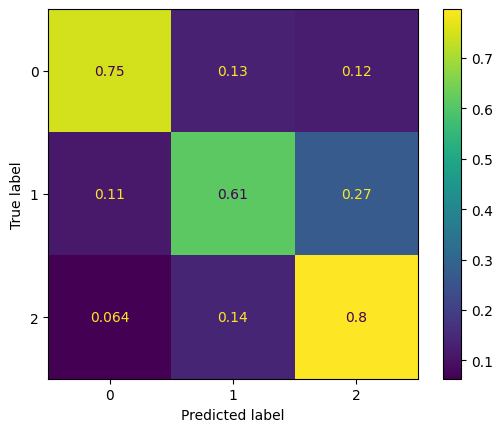

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.74870. Saving Model!
epoch 01, loss: 0.70154, acc: 0.67908, val_loss: 0.74870, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 02, loss: 0.67780, acc: 0.69513, val_loss: 0.75803, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 03, loss: 0.69286, acc: 0.68626, val_loss: 0.75307, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 04, loss: 0.69122, acc: 0.68820, val_loss: 0.75112, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 05, loss: 0.68436, acc: 0.69199, val_loss: 0.75392, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 06, loss: 0.68587, acc: 0.68909, val_loss: 0.75147, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 07, loss: 0.68445, acc: 0.69005, val_loss: 0.74996, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 08, loss: 0.68292, acc: 0.69328, val_loss: 0.75012, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 09, loss: 0.68372, acc: 0.69236, val_loss: 0.74884, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 10, loss: 0.68189, acc: 0.69278, val_loss: 0.74895, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 11, loss: 0.68102, acc: 0.69393, val_loss: 0.74933, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.74870 to 0.74838. Saving Model!
epoch 12, loss: 0.68155, acc: 0.69302, val_loss: 0.74838, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


[INFO] val_acc has been improved from 0.74838 to 0.74830. Saving Model!
epoch 13, loss: 0.68039, acc: 0.69332, val_loss: 0.74830, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.74830 to 0.74824. Saving Model!
epoch 14, loss: 0.67971, acc: 0.69393, val_loss: 0.74824, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.74824 to 0.74805. Saving Model!
epoch 15, loss: 0.67976, acc: 0.69489, val_loss: 0.74805, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.74805 to 0.74783. Saving Model!
epoch 16, loss: 0.67906, acc: 0.69540, val_loss: 0.74783, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.74783 to 0.74770. Saving Model!
epoch 17, loss: 0.67840, acc: 0.69489, val_loss: 0.74770, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.74770 to 0.74718. Saving Model!
epoch 18, loss: 0.67815, acc: 0.69555, val_loss: 0.74718, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.74718 to 0.74693. Saving Model!
epoch 19, loss: 0.67762, acc: 0.69594, val_loss: 0.74693, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.74693 to 0.74686. Saving Model!
epoch 20, loss: 0.67730, acc: 0.69577, val_loss: 0.74686, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.74686 to 0.74653. Saving Model!
epoch 21, loss: 0.67668, acc: 0.69651, val_loss: 0.74653, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.74653 to 0.74618. Saving Model!
epoch 22, loss: 0.67652, acc: 0.69629, val_loss: 0.74618, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 23, loss: 0.67565, acc: 0.69686, val_loss: 0.74634, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.74618 to 0.74597. Saving Model!
epoch 24, loss: 0.67573, acc: 0.69707, val_loss: 0.74597, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.74597 to 0.74581. Saving Model!
epoch 25, loss: 0.67493, acc: 0.69727, val_loss: 0.74581, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.74581 to 0.74563. Saving Model!
epoch 26, loss: 0.67482, acc: 0.69753, val_loss: 0.74563, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.74563 to 0.74540. Saving Model!
epoch 27, loss: 0.67446, acc: 0.69769, val_loss: 0.74540, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.74540 to 0.74517. Saving Model!
epoch 28, loss: 0.67375, acc: 0.69782, val_loss: 0.74517, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.74517 to 0.74488. Saving Model!
epoch 29, loss: 0.67381, acc: 0.69806, val_loss: 0.74488, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 30, loss: 0.67270, acc: 0.69851, val_loss: 0.74504, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.74488 to 0.74450. Saving Model!
epoch 31, loss: 0.67306, acc: 0.69871, val_loss: 0.74450, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.74450 to 0.74440. Saving Model!
epoch 32, loss: 0.67234, acc: 0.69902, val_loss: 0.74440, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.74440 to 0.74427. Saving Model!
epoch 33, loss: 0.67194, acc: 0.69926, val_loss: 0.74427, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 34, loss: 0.67166, acc: 0.69950, val_loss: 0.74429, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.74427 to 0.74378. Saving Model!
epoch 35, loss: 0.67134, acc: 0.69945, val_loss: 0.74378, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 36, loss: 0.67069, acc: 0.70022, val_loss: 0.74387, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


[INFO] val_acc has been improved from 0.74378 to 0.74362. Saving Model!
epoch 37, loss: 0.67070, acc: 0.70026, val_loss: 0.74362, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.74362 to 0.74330. Saving Model!
epoch 38, loss: 0.67006, acc: 0.70030, val_loss: 0.74330, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.74330 to 0.74319. Saving Model!
epoch 39, loss: 0.66991, acc: 0.70030, val_loss: 0.74319, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.74319 to 0.74311. Saving Model!
epoch 40, loss: 0.66942, acc: 0.70067, val_loss: 0.74311, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.74311 to 0.74306. Saving Model!
epoch 41, loss: 0.66919, acc: 0.70033, val_loss: 0.74306, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.74306 to 0.74275. Saving Model!
epoch 42, loss: 0.66871, acc: 0.70059, val_loss: 0.74275, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


[INFO] val_acc has been improved from 0.74275 to 0.74254. Saving Model!
epoch 43, loss: 0.66842, acc: 0.70087, val_loss: 0.74254, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.74254 to 0.74241. Saving Model!
epoch 44, loss: 0.66809, acc: 0.70118, val_loss: 0.74241, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.74241 to 0.74228. Saving Model!
epoch 45, loss: 0.66774, acc: 0.70244, val_loss: 0.74228, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.74228 to 0.74191. Saving Model!
epoch 46, loss: 0.66724, acc: 0.70268, val_loss: 0.74191, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 47, loss: 0.66705, acc: 0.70283, val_loss: 0.74199, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.74191 to 0.74174. Saving Model!
epoch 48, loss: 0.66675, acc: 0.70292, val_loss: 0.74174, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.74174 to 0.74160. Saving Model!
epoch 49, loss: 0.66637, acc: 0.70382, val_loss: 0.74160, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.74160 to 0.74140. Saving Model!
epoch 50, loss: 0.66603, acc: 0.70382, val_loss: 0.74140, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[INFO] val_acc has been improved from 0.74140 to 0.74107. Saving Model!
epoch 51, loss: 0.66572, acc: 0.70414, val_loss: 0.74107, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 52, loss: 0.66529, acc: 0.70427, val_loss: 0.74110, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.74107 to 0.74105. Saving Model!
epoch 53, loss: 0.66518, acc: 0.70408, val_loss: 0.74105, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


[INFO] val_acc has been improved from 0.74105 to 0.74087. Saving Model!
epoch 54, loss: 0.66471, acc: 0.70449, val_loss: 0.74087, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.74087 to 0.74057. Saving Model!
epoch 55, loss: 0.66441, acc: 0.70390, val_loss: 0.74057, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 56, loss: 0.66381, acc: 0.70512, val_loss: 0.74079, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.74057 to 0.74021. Saving Model!
epoch 57, loss: 0.66407, acc: 0.70421, val_loss: 0.74021, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 58, loss: 0.66330, acc: 0.70534, val_loss: 0.74026, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.74021 to 0.74001. Saving Model!
epoch 59, loss: 0.66309, acc: 0.70449, val_loss: 0.74001, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


[INFO] val_acc has been improved from 0.74001 to 0.73974. Saving Model!
epoch 60, loss: 0.66290, acc: 0.70460, val_loss: 0.73974, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 61, loss: 0.66251, acc: 0.70477, val_loss: 0.73979, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.73974 to 0.73957. Saving Model!
epoch 62, loss: 0.66202, acc: 0.70515, val_loss: 0.73957, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


[INFO] val_acc has been improved from 0.73957 to 0.73925. Saving Model!
epoch 63, loss: 0.66202, acc: 0.70615, val_loss: 0.73925, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 64, loss: 0.66142, acc: 0.70659, val_loss: 0.73940, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.73925 to 0.73911. Saving Model!
epoch 65, loss: 0.66131, acc: 0.70554, val_loss: 0.73911, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


[INFO] val_acc has been improved from 0.73911 to 0.73901. Saving Model!
epoch 66, loss: 0.66085, acc: 0.70576, val_loss: 0.73901, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.73901 to 0.73869. Saving Model!
epoch 67, loss: 0.66070, acc: 0.70698, val_loss: 0.73869, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


[INFO] val_acc has been improved from 0.73869 to 0.73853. Saving Model!
epoch 68, loss: 0.66024, acc: 0.70731, val_loss: 0.73853, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 69, loss: 0.66018, acc: 0.70763, val_loss: 0.73861, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


[INFO] val_acc has been improved from 0.73853 to 0.73838. Saving Model!
epoch 70, loss: 0.65969, acc: 0.70772, val_loss: 0.73838, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 71, loss: 0.65932, acc: 0.70807, val_loss: 0.73845, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.73838 to 0.73823. Saving Model!
epoch 72, loss: 0.65937, acc: 0.70807, val_loss: 0.73823, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.73823 to 0.73790. Saving Model!
epoch 73, loss: 0.65851, acc: 0.70848, val_loss: 0.73790, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 74, loss: 0.65859, acc: 0.70938, val_loss: 0.73791, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.73790 to 0.73780. Saving Model!
epoch 75, loss: 0.65831, acc: 0.70936, val_loss: 0.73780, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


[INFO] val_acc has been improved from 0.73780 to 0.73777. Saving Model!
epoch 76, loss: 0.65778, acc: 0.71018, val_loss: 0.73777, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.73777 to 0.73764. Saving Model!
epoch 77, loss: 0.65764, acc: 0.70986, val_loss: 0.73764, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.73764 to 0.73718. Saving Model!
epoch 78, loss: 0.65734, acc: 0.70992, val_loss: 0.73718, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 79, loss: 0.65695, acc: 0.71053, val_loss: 0.73728, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.73718 to 0.73712. Saving Model!
epoch 80, loss: 0.65672, acc: 0.71062, val_loss: 0.73712, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.73712 to 0.73689. Saving Model!
epoch 81, loss: 0.65638, acc: 0.71077, val_loss: 0.73689, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 82, loss: 0.65615, acc: 0.71064, val_loss: 0.73702, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.73689 to 0.73672. Saving Model!
epoch 83, loss: 0.65555, acc: 0.71104, val_loss: 0.73672, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.73672 to 0.73656. Saving Model!
epoch 84, loss: 0.65584, acc: 0.71114, val_loss: 0.73656, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 85, loss: 0.65504, acc: 0.71095, val_loss: 0.73667, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.73656 to 0.73637. Saving Model!
epoch 86, loss: 0.65500, acc: 0.71136, val_loss: 0.73637, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 87, loss: 0.65474, acc: 0.71138, val_loss: 0.73649, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.73637 to 0.73605. Saving Model!
epoch 88, loss: 0.65427, acc: 0.71143, val_loss: 0.73605, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 89, loss: 0.65398, acc: 0.71184, val_loss: 0.73620, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.73605 to 0.73581. Saving Model!
epoch 90, loss: 0.65396, acc: 0.71189, val_loss: 0.73581, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 91, loss: 0.65335, acc: 0.71186, val_loss: 0.73583, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.73581 to 0.73571. Saving Model!
epoch 92, loss: 0.65331, acc: 0.71217, val_loss: 0.73571, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.73571 to 0.73554. Saving Model!
epoch 93, loss: 0.65309, acc: 0.71230, val_loss: 0.73554, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


[INFO] val_acc has been improved from 0.73554 to 0.73542. Saving Model!
epoch 94, loss: 0.65259, acc: 0.71237, val_loss: 0.73542, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.73542 to 0.73525. Saving Model!
epoch 95, loss: 0.65247, acc: 0.71274, val_loss: 0.73525, val_accuracy: 0.69317


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.73525 to 0.73516. Saving Model!
epoch 96, loss: 0.65205, acc: 0.71296, val_loss: 0.73516, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 97, loss: 0.65199, acc: 0.71306, val_loss: 0.73529, val_accuracy: 0.69356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.73516 to 0.73489. Saving Model!
epoch 98, loss: 0.65138, acc: 0.71324, val_loss: 0.73489, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 99, loss: 0.65119, acc: 0.71339, val_loss: 0.73504, val_accuracy: 0.69356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


[INFO] val_acc has been improved from 0.73489 to 0.73462. Saving Model!
epoch 100, loss: 0.65107, acc: 0.71376, val_loss: 0.73462, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 101, loss: 0.65067, acc: 0.71376, val_loss: 0.73476, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.73462 to 0.73454. Saving Model!
epoch 102, loss: 0.65035, acc: 0.71374, val_loss: 0.73454, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.73454 to 0.73426. Saving Model!
epoch 103, loss: 0.65007, acc: 0.71409, val_loss: 0.73426, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.73426 to 0.73407. Saving Model!
epoch 104, loss: 0.64973, acc: 0.71415, val_loss: 0.73407, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.73407 to 0.73401. Saving Model!
epoch 105, loss: 0.64971, acc: 0.71435, val_loss: 0.73401, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


[INFO] val_acc has been improved from 0.73401 to 0.73399. Saving Model!
epoch 106, loss: 0.64889, acc: 0.71457, val_loss: 0.73399, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.73399 to 0.73371. Saving Model!
epoch 107, loss: 0.64914, acc: 0.71446, val_loss: 0.73371, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.73371 to 0.73368. Saving Model!
epoch 108, loss: 0.64870, acc: 0.71446, val_loss: 0.73368, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.73368 to 0.73353. Saving Model!
epoch 109, loss: 0.64825, acc: 0.71485, val_loss: 0.73353, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 110, loss: 0.64802, acc: 0.71481, val_loss: 0.73355, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.73353 to 0.73320. Saving Model!
epoch 111, loss: 0.64784, acc: 0.71485, val_loss: 0.73320, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 112, loss: 0.64739, acc: 0.71509, val_loss: 0.73333, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.73320 to 0.73267. Saving Model!
epoch 113, loss: 0.64747, acc: 0.71522, val_loss: 0.73267, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 114, loss: 0.64657, acc: 0.71555, val_loss: 0.73293, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 115, loss: 0.64684, acc: 0.71553, val_loss: 0.73279, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 116, loss: 0.64624, acc: 0.71586, val_loss: 0.73271, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


[INFO] val_acc has been improved from 0.73267 to 0.73256. Saving Model!
epoch 117, loss: 0.64617, acc: 0.71583, val_loss: 0.73256, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 118, loss: 0.64562, acc: 0.71614, val_loss: 0.73264, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.73256 to 0.73226. Saving Model!
epoch 119, loss: 0.64577, acc: 0.71610, val_loss: 0.73226, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 120, loss: 0.64510, acc: 0.71618, val_loss: 0.73228, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.73226 to 0.73199. Saving Model!
epoch 121, loss: 0.64496, acc: 0.71649, val_loss: 0.73199, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 122, loss: 0.64473, acc: 0.71640, val_loss: 0.73200, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.73199 to 0.73182. Saving Model!
epoch 123, loss: 0.64432, acc: 0.71658, val_loss: 0.73182, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 124, loss: 0.64402, acc: 0.71684, val_loss: 0.73193, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.73182 to 0.73135. Saving Model!
epoch 125, loss: 0.64413, acc: 0.71671, val_loss: 0.73135, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 126, loss: 0.64321, acc: 0.71682, val_loss: 0.73161, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 127, loss: 0.64343, acc: 0.71699, val_loss: 0.73136, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 128, loss: 0.64296, acc: 0.71706, val_loss: 0.73148, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.73135 to 0.73131. Saving Model!
epoch 129, loss: 0.64274, acc: 0.71717, val_loss: 0.73131, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.73131 to 0.73080. Saving Model!
epoch 130, loss: 0.64235, acc: 0.71730, val_loss: 0.73080, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 131, loss: 0.64229, acc: 0.71719, val_loss: 0.73100, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 132, loss: 0.64191, acc: 0.71747, val_loss: 0.73082, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.73080 to 0.73063. Saving Model!
epoch 133, loss: 0.64160, acc: 0.71767, val_loss: 0.73063, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


epoch 134, loss: 0.64133, acc: 0.71860, val_loss: 0.73079, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 135, loss: 0.64113, acc: 0.71865, val_loss: 0.73067, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.73063 to 0.73023. Saving Model!
epoch 136, loss: 0.64094, acc: 0.71852, val_loss: 0.73023, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.73023 to 0.73002. Saving Model!
epoch 137, loss: 0.64058, acc: 0.71884, val_loss: 0.73002, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 138, loss: 0.64002, acc: 0.71913, val_loss: 0.73043, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 139, loss: 0.64015, acc: 0.71900, val_loss: 0.73033, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.73002 to 0.72980. Saving Model!
epoch 140, loss: 0.63980, acc: 0.71895, val_loss: 0.72980, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 141, loss: 0.63938, acc: 0.71922, val_loss: 0.73021, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.72980 to 0.72963. Saving Model!
epoch 142, loss: 0.63948, acc: 0.71922, val_loss: 0.72963, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 143, loss: 0.63873, acc: 0.71941, val_loss: 0.72994, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.72963 to 0.72945. Saving Model!
epoch 144, loss: 0.63868, acc: 0.71946, val_loss: 0.72945, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 145, loss: 0.63850, acc: 0.71948, val_loss: 0.72946, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 146, loss: 0.63821, acc: 0.71956, val_loss: 0.72949, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.72945 to 0.72930. Saving Model!
epoch 147, loss: 0.63788, acc: 0.71961, val_loss: 0.72930, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.72930 to 0.72910. Saving Model!
epoch 148, loss: 0.63759, acc: 0.71976, val_loss: 0.72910, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.72910 to 0.72896. Saving Model!
epoch 149, loss: 0.63729, acc: 0.72000, val_loss: 0.72896, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.72896 to 0.72889. Saving Model!
epoch 150, loss: 0.63706, acc: 0.71987, val_loss: 0.72889, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.72889 to 0.72872. Saving Model!
epoch 151, loss: 0.63681, acc: 0.72098, val_loss: 0.72872, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.72872 to 0.72826. Saving Model!
epoch 152, loss: 0.63637, acc: 0.72116, val_loss: 0.72826, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 153, loss: 0.63645, acc: 0.72013, val_loss: 0.72848, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 154, loss: 0.63593, acc: 0.72133, val_loss: 0.72833, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 155, loss: 0.63575, acc: 0.72247, val_loss: 0.72827, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


[INFO] val_acc has been improved from 0.72826 to 0.72822. Saving Model!
epoch 156, loss: 0.63541, acc: 0.72308, val_loss: 0.72822, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.72822 to 0.72776. Saving Model!
epoch 157, loss: 0.63544, acc: 0.72286, val_loss: 0.72776, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 158, loss: 0.63488, acc: 0.72301, val_loss: 0.72791, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.72776 to 0.72759. Saving Model!
epoch 159, loss: 0.63460, acc: 0.72323, val_loss: 0.72759, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


[INFO] val_acc has been improved from 0.72759 to 0.72750. Saving Model!
epoch 160, loss: 0.63458, acc: 0.72386, val_loss: 0.72750, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.72750 to 0.72741. Saving Model!
epoch 161, loss: 0.63410, acc: 0.72377, val_loss: 0.72741, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


[INFO] val_acc has been improved from 0.72741 to 0.72720. Saving Model!
epoch 162, loss: 0.63393, acc: 0.72393, val_loss: 0.72720, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 163, loss: 0.63373, acc: 0.72395, val_loss: 0.72744, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.72720 to 0.72699. Saving Model!
epoch 164, loss: 0.63334, acc: 0.72417, val_loss: 0.72699, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 165, loss: 0.63303, acc: 0.72362, val_loss: 0.72718, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.72699 to 0.72691. Saving Model!
epoch 166, loss: 0.63296, acc: 0.72421, val_loss: 0.72691, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.72691 to 0.72673. Saving Model!
epoch 167, loss: 0.63265, acc: 0.72369, val_loss: 0.72673, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.72673 to 0.72660. Saving Model!
epoch 168, loss: 0.63240, acc: 0.72338, val_loss: 0.72660, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 169, loss: 0.63210, acc: 0.72473, val_loss: 0.72664, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.72660 to 0.72634. Saving Model!
epoch 170, loss: 0.63162, acc: 0.72528, val_loss: 0.72634, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.72634 to 0.72633. Saving Model!
epoch 171, loss: 0.63177, acc: 0.72399, val_loss: 0.72633, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 172, loss: 0.63110, acc: 0.72406, val_loss: 0.72646, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.72633 to 0.72617. Saving Model!
epoch 173, loss: 0.63112, acc: 0.72408, val_loss: 0.72617, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.72617 to 0.72604. Saving Model!
epoch 174, loss: 0.63074, acc: 0.72449, val_loss: 0.72604, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.72604 to 0.72595. Saving Model!
epoch 175, loss: 0.63038, acc: 0.72556, val_loss: 0.72595, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 176, loss: 0.63030, acc: 0.72548, val_loss: 0.72606, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.72595 to 0.72585. Saving Model!
epoch 177, loss: 0.63001, acc: 0.72583, val_loss: 0.72585, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.72585 to 0.72557. Saving Model!
epoch 178, loss: 0.62956, acc: 0.72609, val_loss: 0.72557, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 179, loss: 0.62946, acc: 0.72611, val_loss: 0.72588, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.72557 to 0.72533. Saving Model!
epoch 180, loss: 0.62923, acc: 0.72611, val_loss: 0.72533, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.72533 to 0.72532. Saving Model!
epoch 181, loss: 0.62870, acc: 0.72624, val_loss: 0.72532, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 182, loss: 0.62864, acc: 0.72670, val_loss: 0.72545, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.72532 to 0.72483. Saving Model!
epoch 183, loss: 0.62862, acc: 0.72654, val_loss: 0.72483, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 184, loss: 0.62781, acc: 0.72661, val_loss: 0.72519, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.72483 to 0.72479. Saving Model!
epoch 185, loss: 0.62803, acc: 0.72670, val_loss: 0.72479, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 186, loss: 0.62768, acc: 0.72696, val_loss: 0.72498, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 187, loss: 0.62727, acc: 0.72785, val_loss: 0.72482, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.72479 to 0.72440. Saving Model!
epoch 188, loss: 0.62712, acc: 0.72794, val_loss: 0.72440, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 189, loss: 0.62676, acc: 0.72831, val_loss: 0.72461, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


[INFO] val_acc has been improved from 0.72440 to 0.72438. Saving Model!
epoch 190, loss: 0.62661, acc: 0.72833, val_loss: 0.72438, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.72438 to 0.72431. Saving Model!
epoch 191, loss: 0.62641, acc: 0.72812, val_loss: 0.72431, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.72431 to 0.72410. Saving Model!
epoch 192, loss: 0.62589, acc: 0.72892, val_loss: 0.72410, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.72410 to 0.72383. Saving Model!
epoch 193, loss: 0.62579, acc: 0.72901, val_loss: 0.72383, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 194, loss: 0.62547, acc: 0.72905, val_loss: 0.72404, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.72383 to 0.72365. Saving Model!
epoch 195, loss: 0.62553, acc: 0.72910, val_loss: 0.72365, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 196, loss: 0.62477, acc: 0.72923, val_loss: 0.72378, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.72365 to 0.72326. Saving Model!
epoch 197, loss: 0.62482, acc: 0.72949, val_loss: 0.72326, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 198, loss: 0.62448, acc: 0.72945, val_loss: 0.72343, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.72326 to 0.72319. Saving Model!
epoch 199, loss: 0.62428, acc: 0.72960, val_loss: 0.72319, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 200, loss: 0.62395, acc: 0.72953, val_loss: 0.72345, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.72319 to 0.72283. Saving Model!
epoch 201, loss: 0.62370, acc: 0.72986, val_loss: 0.72283, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


[INFO] val_acc has been improved from 0.72283 to 0.72267. Saving Model!
epoch 202, loss: 0.62347, acc: 0.72953, val_loss: 0.72267, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 203, loss: 0.62317, acc: 0.72995, val_loss: 0.72302, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.72267 to 0.72226. Saving Model!
epoch 204, loss: 0.62308, acc: 0.73004, val_loss: 0.72226, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 205, loss: 0.62242, acc: 0.73028, val_loss: 0.72274, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.72226 to 0.72197. Saving Model!
epoch 206, loss: 0.62281, acc: 0.73021, val_loss: 0.72197, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 207, loss: 0.62177, acc: 0.73130, val_loss: 0.72204, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 208, loss: 0.62225, acc: 0.73117, val_loss: 0.72226, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 209, loss: 0.62148, acc: 0.73141, val_loss: 0.72212, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.72197 to 0.72176. Saving Model!
epoch 210, loss: 0.62156, acc: 0.73141, val_loss: 0.72176, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.72176 to 0.72167. Saving Model!
epoch 211, loss: 0.62110, acc: 0.73147, val_loss: 0.72167, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.72167 to 0.72148. Saving Model!
epoch 212, loss: 0.62094, acc: 0.73152, val_loss: 0.72148, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 213, loss: 0.62039, acc: 0.73191, val_loss: 0.72158, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


[INFO] val_acc has been improved from 0.72148 to 0.72115. Saving Model!
epoch 214, loss: 0.62061, acc: 0.73193, val_loss: 0.72115, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.72115 to 0.72114. Saving Model!
epoch 215, loss: 0.62013, acc: 0.73215, val_loss: 0.72114, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 216, loss: 0.61971, acc: 0.73219, val_loss: 0.72142, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.72114 to 0.72099. Saving Model!
epoch 217, loss: 0.61975, acc: 0.73226, val_loss: 0.72099, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 218, loss: 0.61919, acc: 0.73254, val_loss: 0.72118, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.72099 to 0.72069. Saving Model!
epoch 219, loss: 0.61932, acc: 0.73263, val_loss: 0.72069, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


[INFO] val_acc has been improved from 0.72069 to 0.72062. Saving Model!
epoch 220, loss: 0.61873, acc: 0.73396, val_loss: 0.72062, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 221, loss: 0.61867, acc: 0.73392, val_loss: 0.72077, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.72062 to 0.72038. Saving Model!
epoch 222, loss: 0.61828, acc: 0.73390, val_loss: 0.72038, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.72038 to 0.72002. Saving Model!
epoch 223, loss: 0.61821, acc: 0.73418, val_loss: 0.72002, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 224, loss: 0.61760, acc: 0.73462, val_loss: 0.72031, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.72002 to 0.71997. Saving Model!
epoch 225, loss: 0.61780, acc: 0.73411, val_loss: 0.71997, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 226, loss: 0.61712, acc: 0.73505, val_loss: 0.72025, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


[INFO] val_acc has been improved from 0.71997 to 0.71962. Saving Model!
epoch 227, loss: 0.61732, acc: 0.73483, val_loss: 0.71962, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 228, loss: 0.61641, acc: 0.73619, val_loss: 0.71981, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 229, loss: 0.61684, acc: 0.73601, val_loss: 0.71968, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 230, loss: 0.61634, acc: 0.73614, val_loss: 0.71964, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.71962 to 0.71930. Saving Model!
epoch 231, loss: 0.61576, acc: 0.73673, val_loss: 0.71930, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 232, loss: 0.61598, acc: 0.73675, val_loss: 0.71937, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.71930 to 0.71916. Saving Model!
epoch 233, loss: 0.61537, acc: 0.73678, val_loss: 0.71916, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 234, loss: 0.61526, acc: 0.73640, val_loss: 0.71940, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.71916 to 0.71882. Saving Model!
epoch 235, loss: 0.61512, acc: 0.73682, val_loss: 0.71882, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 236, loss: 0.61471, acc: 0.73688, val_loss: 0.71921, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.71882 to 0.71854. Saving Model!
epoch 237, loss: 0.61448, acc: 0.73675, val_loss: 0.71854, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 238, loss: 0.61383, acc: 0.73723, val_loss: 0.71887, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.71854 to 0.71837. Saving Model!
epoch 239, loss: 0.61414, acc: 0.73678, val_loss: 0.71837, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 240, loss: 0.61354, acc: 0.73664, val_loss: 0.71845, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 241, loss: 0.61333, acc: 0.73719, val_loss: 0.71853, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.71837 to 0.71807. Saving Model!
epoch 242, loss: 0.61307, acc: 0.73730, val_loss: 0.71807, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 243, loss: 0.61292, acc: 0.73741, val_loss: 0.71823, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.71807 to 0.71794. Saving Model!
epoch 244, loss: 0.61250, acc: 0.73723, val_loss: 0.71794, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.71794 to 0.71772. Saving Model!
epoch 245, loss: 0.61243, acc: 0.73739, val_loss: 0.71772, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 246, loss: 0.61201, acc: 0.73791, val_loss: 0.71802, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.71772 to 0.71732. Saving Model!
epoch 247, loss: 0.61193, acc: 0.73747, val_loss: 0.71732, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 248, loss: 0.61131, acc: 0.73778, val_loss: 0.71799, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.71732 to 0.71716. Saving Model!
epoch 249, loss: 0.61162, acc: 0.73760, val_loss: 0.71716, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 250, loss: 0.61069, acc: 0.73804, val_loss: 0.71774, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 0.71716 to 0.71714. Saving Model!
epoch 251, loss: 0.61091, acc: 0.73813, val_loss: 0.71714, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 252, loss: 0.61069, acc: 0.73876, val_loss: 0.71721, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 253, loss: 0.60990, acc: 0.73824, val_loss: 0.71745, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 254, loss: 0.61016, acc: 0.73859, val_loss: 0.71719, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.71714 to 0.71671. Saving Model!
epoch 255, loss: 0.60976, acc: 0.73826, val_loss: 0.71671, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 256, loss: 0.60963, acc: 0.73898, val_loss: 0.71723, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 257, loss: 0.60922, acc: 0.73915, val_loss: 0.71675, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 258, loss: 0.60906, acc: 0.73985, val_loss: 0.71688, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 259, loss: 0.60878, acc: 0.73928, val_loss: 0.71680, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.71671 to 0.71614. Saving Model!
epoch 260, loss: 0.60865, acc: 0.73965, val_loss: 0.71614, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 261, loss: 0.60806, acc: 0.74003, val_loss: 0.71674, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.71614 to 0.71611. Saving Model!
epoch 262, loss: 0.60838, acc: 0.73896, val_loss: 0.71611, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 263, loss: 0.60752, acc: 0.73976, val_loss: 0.71628, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 264, loss: 0.60728, acc: 0.73972, val_loss: 0.71620, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.71611 to 0.71579. Saving Model!
epoch 265, loss: 0.60759, acc: 0.73909, val_loss: 0.71579, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 266, loss: 0.60689, acc: 0.74031, val_loss: 0.71608, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 267, loss: 0.60648, acc: 0.73963, val_loss: 0.71592, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 268, loss: 0.60664, acc: 0.73983, val_loss: 0.71593, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.71579 to 0.71540. Saving Model!
epoch 269, loss: 0.60629, acc: 0.74064, val_loss: 0.71540, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 270, loss: 0.60580, acc: 0.74070, val_loss: 0.71557, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 271, loss: 0.60566, acc: 0.74118, val_loss: 0.71562, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.71540 to 0.71507. Saving Model!
epoch 272, loss: 0.60561, acc: 0.74120, val_loss: 0.71507, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 273, loss: 0.60512, acc: 0.74136, val_loss: 0.71550, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.71507 to 0.71474. Saving Model!
epoch 274, loss: 0.60529, acc: 0.74133, val_loss: 0.71474, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 275, loss: 0.60413, acc: 0.74186, val_loss: 0.71515, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.71474 to 0.71472. Saving Model!
epoch 276, loss: 0.60499, acc: 0.74205, val_loss: 0.71472, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 277, loss: 0.60382, acc: 0.74247, val_loss: 0.71519, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 278, loss: 0.60405, acc: 0.74245, val_loss: 0.71482, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.71472 to 0.71440. Saving Model!
epoch 279, loss: 0.60370, acc: 0.74251, val_loss: 0.71440, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 280, loss: 0.60329, acc: 0.74249, val_loss: 0.71453, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.71440 to 0.71418. Saving Model!
epoch 281, loss: 0.60348, acc: 0.74262, val_loss: 0.71418, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 282, loss: 0.60283, acc: 0.74286, val_loss: 0.71434, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 283, loss: 0.60275, acc: 0.74295, val_loss: 0.71433, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.71418 to 0.71406. Saving Model!
epoch 284, loss: 0.60240, acc: 0.74301, val_loss: 0.71406, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 285, loss: 0.60233, acc: 0.74306, val_loss: 0.71406, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.71406 to 0.71384. Saving Model!
epoch 286, loss: 0.60177, acc: 0.74315, val_loss: 0.71384, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 287, loss: 0.60171, acc: 0.74312, val_loss: 0.71421, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.71384 to 0.71344. Saving Model!
epoch 288, loss: 0.60145, acc: 0.74347, val_loss: 0.71344, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.71344 to 0.71327. Saving Model!
epoch 289, loss: 0.60139, acc: 0.74450, val_loss: 0.71327, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 290, loss: 0.60064, acc: 0.74474, val_loss: 0.71360, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 291, loss: 0.60090, acc: 0.74478, val_loss: 0.71328, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.71327 to 0.71327. Saving Model!
epoch 292, loss: 0.60027, acc: 0.74565, val_loss: 0.71327, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 293, loss: 0.60029, acc: 0.74491, val_loss: 0.71329, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.71327 to 0.71291. Saving Model!
epoch 294, loss: 0.59995, acc: 0.74565, val_loss: 0.71291, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 295, loss: 0.59961, acc: 0.74500, val_loss: 0.71316, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.71291 to 0.71271. Saving Model!
epoch 296, loss: 0.59949, acc: 0.74568, val_loss: 0.71271, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 297, loss: 0.59915, acc: 0.74526, val_loss: 0.71326, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.71271 to 0.71207. Saving Model!
epoch 298, loss: 0.59911, acc: 0.74576, val_loss: 0.71207, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 299, loss: 0.59844, acc: 0.74541, val_loss: 0.71275, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 300, loss: 0.59854, acc: 0.74574, val_loss: 0.71235, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 301, loss: 0.59834, acc: 0.74574, val_loss: 0.71246, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 302, loss: 0.59774, acc: 0.74620, val_loss: 0.71216, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 303, loss: 0.59795, acc: 0.74613, val_loss: 0.71212, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.71207 to 0.71170. Saving Model!
epoch 304, loss: 0.59752, acc: 0.74644, val_loss: 0.71170, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 305, loss: 0.59695, acc: 0.74653, val_loss: 0.71238, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.71170 to 0.71134. Saving Model!
epoch 306, loss: 0.59721, acc: 0.74668, val_loss: 0.71134, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 307, loss: 0.59658, acc: 0.74674, val_loss: 0.71177, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 308, loss: 0.59650, acc: 0.74705, val_loss: 0.71153, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 309, loss: 0.59602, acc: 0.74692, val_loss: 0.71192, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.71134 to 0.71083. Saving Model!
epoch 310, loss: 0.59643, acc: 0.74716, val_loss: 0.71083, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 311, loss: 0.59519, acc: 0.74751, val_loss: 0.71172, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 312, loss: 0.59588, acc: 0.74718, val_loss: 0.71106, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 313, loss: 0.59499, acc: 0.74753, val_loss: 0.71090, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 314, loss: 0.59507, acc: 0.74757, val_loss: 0.71095, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 315, loss: 0.59484, acc: 0.74760, val_loss: 0.71100, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 316, loss: 0.59451, acc: 0.74749, val_loss: 0.71103, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.71083 to 0.71052. Saving Model!
epoch 317, loss: 0.59452, acc: 0.74779, val_loss: 0.71052, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 318, loss: 0.59358, acc: 0.74775, val_loss: 0.71100, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.71052 to 0.71037. Saving Model!
epoch 319, loss: 0.59432, acc: 0.74779, val_loss: 0.71037, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 320, loss: 0.59319, acc: 0.74781, val_loss: 0.71057, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.71037 to 0.71007. Saving Model!
epoch 321, loss: 0.59352, acc: 0.74792, val_loss: 0.71007, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 322, loss: 0.59275, acc: 0.74788, val_loss: 0.71068, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.71007 to 0.70998. Saving Model!
epoch 323, loss: 0.59310, acc: 0.74810, val_loss: 0.70998, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 324, loss: 0.59225, acc: 0.74807, val_loss: 0.70999, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 325, loss: 0.59264, acc: 0.74812, val_loss: 0.71011, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.70998 to 0.70970. Saving Model!
epoch 326, loss: 0.59189, acc: 0.74834, val_loss: 0.70970, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 327, loss: 0.59179, acc: 0.74845, val_loss: 0.71035, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.70970 to 0.70908. Saving Model!
epoch 328, loss: 0.59201, acc: 0.74864, val_loss: 0.70908, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 329, loss: 0.59092, acc: 0.74893, val_loss: 0.70988, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 330, loss: 0.59115, acc: 0.74862, val_loss: 0.70980, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.70908 to 0.70897. Saving Model!
epoch 331, loss: 0.59112, acc: 0.74901, val_loss: 0.70897, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 332, loss: 0.59020, acc: 0.74901, val_loss: 0.70937, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.70897 to 0.70874. Saving Model!
epoch 333, loss: 0.59069, acc: 0.74910, val_loss: 0.70874, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 334, loss: 0.58973, acc: 0.74945, val_loss: 0.70975, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.70874 to 0.70813. Saving Model!
epoch 335, loss: 0.59038, acc: 0.74914, val_loss: 0.70813, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 336, loss: 0.58915, acc: 0.74921, val_loss: 0.70931, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 337, loss: 0.58961, acc: 0.74936, val_loss: 0.70833, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 338, loss: 0.58902, acc: 0.74951, val_loss: 0.70888, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.70813 to 0.70807. Saving Model!
epoch 339, loss: 0.58872, acc: 0.74943, val_loss: 0.70807, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 340, loss: 0.58876, acc: 0.74930, val_loss: 0.70838, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.70807 to 0.70795. Saving Model!
epoch 341, loss: 0.58850, acc: 0.74936, val_loss: 0.70795, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 342, loss: 0.58783, acc: 0.74938, val_loss: 0.70841, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.70795 to 0.70775. Saving Model!
epoch 343, loss: 0.58819, acc: 0.74991, val_loss: 0.70775, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 344, loss: 0.58748, acc: 0.74978, val_loss: 0.70819, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.70775 to 0.70768. Saving Model!
epoch 345, loss: 0.58770, acc: 0.75008, val_loss: 0.70768, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 346, loss: 0.58708, acc: 0.75015, val_loss: 0.70788, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 347, loss: 0.58676, acc: 0.75119, val_loss: 0.70798, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.70768 to 0.70747. Saving Model!
epoch 348, loss: 0.58677, acc: 0.75071, val_loss: 0.70747, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.70747 to 0.70728. Saving Model!
epoch 349, loss: 0.58653, acc: 0.75133, val_loss: 0.70728, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 350, loss: 0.58592, acc: 0.75170, val_loss: 0.70754, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.70728 to 0.70715. Saving Model!
epoch 351, loss: 0.58638, acc: 0.75157, val_loss: 0.70715, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 352, loss: 0.58519, acc: 0.75191, val_loss: 0.70741, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.70715 to 0.70659. Saving Model!
epoch 353, loss: 0.58592, acc: 0.75191, val_loss: 0.70659, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 354, loss: 0.58504, acc: 0.75220, val_loss: 0.70736, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.70659 to 0.70624. Saving Model!
epoch 355, loss: 0.58513, acc: 0.75231, val_loss: 0.70624, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 356, loss: 0.58459, acc: 0.75239, val_loss: 0.70742, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.70624 to 0.70599. Saving Model!
epoch 357, loss: 0.58483, acc: 0.75246, val_loss: 0.70599, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 358, loss: 0.58415, acc: 0.75259, val_loss: 0.70683, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 359, loss: 0.58396, acc: 0.75285, val_loss: 0.70642, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 360, loss: 0.58412, acc: 0.75259, val_loss: 0.70613, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 361, loss: 0.58328, acc: 0.75283, val_loss: 0.70621, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 362, loss: 0.58346, acc: 0.75316, val_loss: 0.70606, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 363, loss: 0.58308, acc: 0.75309, val_loss: 0.70641, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.70599 to 0.70584. Saving Model!
epoch 364, loss: 0.58278, acc: 0.75331, val_loss: 0.70584, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 365, loss: 0.58269, acc: 0.75340, val_loss: 0.70617, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.70584 to 0.70537. Saving Model!
epoch 366, loss: 0.58271, acc: 0.75314, val_loss: 0.70537, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 367, loss: 0.58162, acc: 0.75386, val_loss: 0.70614, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 368, loss: 0.58240, acc: 0.75431, val_loss: 0.70571, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 369, loss: 0.58137, acc: 0.75401, val_loss: 0.70584, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 370, loss: 0.58177, acc: 0.75425, val_loss: 0.70591, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 371, loss: 0.58094, acc: 0.75503, val_loss: 0.70547, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 372, loss: 0.58096, acc: 0.75444, val_loss: 0.70567, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.70537 to 0.70536. Saving Model!
epoch 373, loss: 0.58083, acc: 0.75451, val_loss: 0.70536, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 374, loss: 0.58023, acc: 0.75464, val_loss: 0.70581, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.70536 to 0.70493. Saving Model!
epoch 375, loss: 0.58065, acc: 0.75486, val_loss: 0.70493, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 376, loss: 0.57962, acc: 0.75488, val_loss: 0.70543, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 377, loss: 0.58010, acc: 0.75523, val_loss: 0.70496, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.70493 to 0.70471. Saving Model!
epoch 378, loss: 0.57937, acc: 0.75530, val_loss: 0.70471, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 379, loss: 0.57946, acc: 0.75510, val_loss: 0.70532, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.70471 to 0.70451. Saving Model!
epoch 380, loss: 0.57924, acc: 0.75486, val_loss: 0.70451, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 381, loss: 0.57883, acc: 0.75510, val_loss: 0.70558, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 382, loss: 0.57867, acc: 0.75519, val_loss: 0.70456, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 383, loss: 0.57842, acc: 0.75567, val_loss: 0.70466, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 384, loss: 0.57822, acc: 0.75516, val_loss: 0.70461, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 385, loss: 0.57792, acc: 0.75510, val_loss: 0.70488, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.70451 to 0.70448. Saving Model!
epoch 386, loss: 0.57774, acc: 0.75626, val_loss: 0.70448, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.70448 to 0.70407. Saving Model!
epoch 387, loss: 0.57745, acc: 0.75512, val_loss: 0.70407, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 388, loss: 0.57732, acc: 0.75554, val_loss: 0.70478, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.70407 to 0.70384. Saving Model!
epoch 389, loss: 0.57699, acc: 0.75597, val_loss: 0.70384, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 390, loss: 0.57645, acc: 0.75486, val_loss: 0.70433, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.70384 to 0.70380. Saving Model!
epoch 391, loss: 0.57682, acc: 0.75619, val_loss: 0.70380, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.70380 to 0.70357. Saving Model!
epoch 392, loss: 0.57605, acc: 0.75612, val_loss: 0.70357, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 393, loss: 0.57635, acc: 0.75593, val_loss: 0.70430, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.70357 to 0.70350. Saving Model!
epoch 394, loss: 0.57568, acc: 0.75610, val_loss: 0.70350, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 395, loss: 0.57567, acc: 0.75580, val_loss: 0.70390, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.70350 to 0.70301. Saving Model!
epoch 396, loss: 0.57537, acc: 0.75647, val_loss: 0.70301, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 397, loss: 0.57512, acc: 0.75604, val_loss: 0.70370, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 398, loss: 0.57470, acc: 0.75671, val_loss: 0.70355, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 399, loss: 0.57481, acc: 0.75630, val_loss: 0.70305, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 400, loss: 0.57439, acc: 0.75658, val_loss: 0.70316, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.70301 to 0.70291. Saving Model!
epoch 401, loss: 0.57430, acc: 0.75645, val_loss: 0.70291, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 402, loss: 0.57397, acc: 0.75658, val_loss: 0.70333, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.70291 to 0.70241. Saving Model!
epoch 403, loss: 0.57373, acc: 0.75660, val_loss: 0.70241, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 404, loss: 0.57324, acc: 0.75669, val_loss: 0.70321, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 405, loss: 0.57330, acc: 0.75708, val_loss: 0.70272, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.70241 to 0.70225. Saving Model!
epoch 406, loss: 0.57321, acc: 0.75809, val_loss: 0.70225, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 407, loss: 0.57262, acc: 0.75719, val_loss: 0.70290, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 408, loss: 0.57288, acc: 0.75730, val_loss: 0.70270, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 409, loss: 0.57217, acc: 0.75706, val_loss: 0.70240, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 410, loss: 0.57246, acc: 0.75835, val_loss: 0.70236, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 411, loss: 0.57150, acc: 0.75870, val_loss: 0.70269, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 412, loss: 0.57196, acc: 0.75754, val_loss: 0.70231, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 0.70225 to 0.70221. Saving Model!
epoch 413, loss: 0.57122, acc: 0.75905, val_loss: 0.70221, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.70221 to 0.70183. Saving Model!
epoch 414, loss: 0.57130, acc: 0.75905, val_loss: 0.70183, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 415, loss: 0.57082, acc: 0.75935, val_loss: 0.70244, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.70183 to 0.70171. Saving Model!
epoch 416, loss: 0.57105, acc: 0.75940, val_loss: 0.70171, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 417, loss: 0.57021, acc: 0.75920, val_loss: 0.70204, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 418, loss: 0.57065, acc: 0.75940, val_loss: 0.70184, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 419, loss: 0.56969, acc: 0.75988, val_loss: 0.70188, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.70171 to 0.70164. Saving Model!
epoch 420, loss: 0.57028, acc: 0.76012, val_loss: 0.70164, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 421, loss: 0.56906, acc: 0.76001, val_loss: 0.70176, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.70164 to 0.70137. Saving Model!
epoch 422, loss: 0.56964, acc: 0.75983, val_loss: 0.70137, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 423, loss: 0.56907, acc: 0.75999, val_loss: 0.70154, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 424, loss: 0.56875, acc: 0.76014, val_loss: 0.70161, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.70137 to 0.70101. Saving Model!
epoch 425, loss: 0.56884, acc: 0.76007, val_loss: 0.70101, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 426, loss: 0.56811, acc: 0.76044, val_loss: 0.70134, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.70101 to 0.70086. Saving Model!
epoch 427, loss: 0.56828, acc: 0.76068, val_loss: 0.70086, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 428, loss: 0.56776, acc: 0.76166, val_loss: 0.70115, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.70086 to 0.70060. Saving Model!
epoch 429, loss: 0.56775, acc: 0.76062, val_loss: 0.70060, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 430, loss: 0.56744, acc: 0.76166, val_loss: 0.70150, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.70060 to 0.70048. Saving Model!
epoch 431, loss: 0.56739, acc: 0.76166, val_loss: 0.70048, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 432, loss: 0.56666, acc: 0.76269, val_loss: 0.70152, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.70048 to 0.70029. Saving Model!
epoch 433, loss: 0.56707, acc: 0.76101, val_loss: 0.70029, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 434, loss: 0.56632, acc: 0.76265, val_loss: 0.70096, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.70029 to 0.70003. Saving Model!
epoch 435, loss: 0.56665, acc: 0.76304, val_loss: 0.70003, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 436, loss: 0.56576, acc: 0.76326, val_loss: 0.70088, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.70003 to 0.69990. Saving Model!
epoch 437, loss: 0.56592, acc: 0.76300, val_loss: 0.69990, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 438, loss: 0.56545, acc: 0.76319, val_loss: 0.70074, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.69990 to 0.69937. Saving Model!
epoch 439, loss: 0.56587, acc: 0.76306, val_loss: 0.69937, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 440, loss: 0.56469, acc: 0.76345, val_loss: 0.70119, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 441, loss: 0.56526, acc: 0.76319, val_loss: 0.69952, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 442, loss: 0.56439, acc: 0.76372, val_loss: 0.70002, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 443, loss: 0.56465, acc: 0.76358, val_loss: 0.70016, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 444, loss: 0.56405, acc: 0.76358, val_loss: 0.69998, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 445, loss: 0.56408, acc: 0.76387, val_loss: 0.69948, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 446, loss: 0.56371, acc: 0.76422, val_loss: 0.69983, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 447, loss: 0.56360, acc: 0.76426, val_loss: 0.69983, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.69937 to 0.69929. Saving Model!
epoch 448, loss: 0.56321, acc: 0.76422, val_loss: 0.69929, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 449, loss: 0.56305, acc: 0.76444, val_loss: 0.69934, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 450, loss: 0.56292, acc: 0.76457, val_loss: 0.69979, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.69929 to 0.69885. Saving Model!
epoch 451, loss: 0.56277, acc: 0.76448, val_loss: 0.69885, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 452, loss: 0.56233, acc: 0.76452, val_loss: 0.69939, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.69885 to 0.69871. Saving Model!
epoch 453, loss: 0.56220, acc: 0.76481, val_loss: 0.69871, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 454, loss: 0.56160, acc: 0.76522, val_loss: 0.69928, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.69871 to 0.69852. Saving Model!
epoch 455, loss: 0.56197, acc: 0.76505, val_loss: 0.69852, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 456, loss: 0.56134, acc: 0.76539, val_loss: 0.69869, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.69852 to 0.69774. Saving Model!
epoch 457, loss: 0.56130, acc: 0.76544, val_loss: 0.69774, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 458, loss: 0.56084, acc: 0.76553, val_loss: 0.69897, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.69774 to 0.69725. Saving Model!
epoch 459, loss: 0.56096, acc: 0.76579, val_loss: 0.69725, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 460, loss: 0.56037, acc: 0.76581, val_loss: 0.69817, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 461, loss: 0.56027, acc: 0.76603, val_loss: 0.69754, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 462, loss: 0.55987, acc: 0.76577, val_loss: 0.69761, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.69725 to 0.69688. Saving Model!
epoch 463, loss: 0.55982, acc: 0.76618, val_loss: 0.69688, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 464, loss: 0.55981, acc: 0.76596, val_loss: 0.69721, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 465, loss: 0.55925, acc: 0.76609, val_loss: 0.69702, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 466, loss: 0.55894, acc: 0.76603, val_loss: 0.69716, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 467, loss: 0.55933, acc: 0.76618, val_loss: 0.69688, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 468, loss: 0.55819, acc: 0.76664, val_loss: 0.69713, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.69688 to 0.69643. Saving Model!
epoch 469, loss: 0.55894, acc: 0.76609, val_loss: 0.69643, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 470, loss: 0.55805, acc: 0.76631, val_loss: 0.69680, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 471, loss: 0.55785, acc: 0.76629, val_loss: 0.69674, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.69643 to 0.69639. Saving Model!
epoch 472, loss: 0.55780, acc: 0.76638, val_loss: 0.69639, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 473, loss: 0.55760, acc: 0.76642, val_loss: 0.69645, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 474, loss: 0.55712, acc: 0.76683, val_loss: 0.69671, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.69639 to 0.69578. Saving Model!
epoch 475, loss: 0.55759, acc: 0.76620, val_loss: 0.69578, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 476, loss: 0.55611, acc: 0.76705, val_loss: 0.69668, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.69578 to 0.69521. Saving Model!
epoch 477, loss: 0.55729, acc: 0.76657, val_loss: 0.69521, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 478, loss: 0.55586, acc: 0.76686, val_loss: 0.69649, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 479, loss: 0.55638, acc: 0.76683, val_loss: 0.69544, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 480, loss: 0.55595, acc: 0.76692, val_loss: 0.69623, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 481, loss: 0.55559, acc: 0.76721, val_loss: 0.69562, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


epoch 482, loss: 0.55557, acc: 0.76694, val_loss: 0.69585, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 483, loss: 0.55528, acc: 0.76734, val_loss: 0.69536, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 484, loss: 0.55503, acc: 0.76721, val_loss: 0.69574, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 485, loss: 0.55486, acc: 0.76751, val_loss: 0.69539, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 486, loss: 0.55420, acc: 0.76788, val_loss: 0.69582, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.69521 to 0.69461. Saving Model!
epoch 487, loss: 0.55480, acc: 0.76742, val_loss: 0.69461, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 488, loss: 0.55379, acc: 0.76786, val_loss: 0.69595, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 489, loss: 0.55393, acc: 0.76797, val_loss: 0.69499, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 490, loss: 0.55391, acc: 0.76745, val_loss: 0.69534, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 491, loss: 0.55312, acc: 0.76823, val_loss: 0.69534, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 492, loss: 0.55348, acc: 0.76827, val_loss: 0.69548, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 493, loss: 0.55303, acc: 0.76823, val_loss: 0.69485, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 494, loss: 0.55243, acc: 0.76832, val_loss: 0.69555, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.69461 to 0.69446. Saving Model!
epoch 495, loss: 0.55301, acc: 0.76847, val_loss: 0.69446, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 496, loss: 0.55199, acc: 0.76832, val_loss: 0.69549, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 497, loss: 0.55222, acc: 0.76880, val_loss: 0.69460, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 498, loss: 0.55161, acc: 0.76875, val_loss: 0.69517, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.69446 to 0.69438. Saving Model!
epoch 499, loss: 0.55228, acc: 0.76832, val_loss: 0.69438, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 500, loss: 0.55089, acc: 0.76878, val_loss: 0.69554, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.69438 to 0.69415. Saving Model!
epoch 501, loss: 0.55170, acc: 0.76889, val_loss: 0.69415, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 502, loss: 0.55047, acc: 0.76906, val_loss: 0.69514, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 503, loss: 0.55148, acc: 0.76895, val_loss: 0.69429, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 504, loss: 0.55001, acc: 0.76913, val_loss: 0.69522, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 505, loss: 0.55061, acc: 0.76915, val_loss: 0.69421, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 506, loss: 0.54982, acc: 0.76954, val_loss: 0.69472, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.69415 to 0.69401. Saving Model!
epoch 507, loss: 0.55032, acc: 0.76930, val_loss: 0.69401, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 508, loss: 0.54925, acc: 0.76980, val_loss: 0.69509, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 509, loss: 0.54958, acc: 0.76991, val_loss: 0.69441, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 510, loss: 0.54926, acc: 0.76971, val_loss: 0.69444, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 511, loss: 0.54913, acc: 0.76984, val_loss: 0.69434, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 512, loss: 0.54852, acc: 0.77015, val_loss: 0.69441, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 513, loss: 0.54864, acc: 0.77019, val_loss: 0.69403, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 514, loss: 0.54822, acc: 0.77037, val_loss: 0.69468, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 515, loss: 0.54830, acc: 0.77017, val_loss: 0.69433, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 516, loss: 0.54748, acc: 0.77050, val_loss: 0.69433, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 517, loss: 0.54782, acc: 0.77032, val_loss: 0.69419, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.69401 to 0.69374. Saving Model!
epoch 518, loss: 0.54748, acc: 0.77054, val_loss: 0.69374, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 519, loss: 0.54708, acc: 0.77059, val_loss: 0.69473, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.69374 to 0.69358. Saving Model!
epoch 520, loss: 0.54697, acc: 0.77094, val_loss: 0.69358, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 521, loss: 0.54691, acc: 0.77041, val_loss: 0.69436, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 522, loss: 0.54618, acc: 0.77080, val_loss: 0.69366, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 523, loss: 0.54638, acc: 0.77067, val_loss: 0.69418, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.69358 to 0.69345. Saving Model!
epoch 524, loss: 0.54604, acc: 0.77091, val_loss: 0.69345, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 525, loss: 0.54567, acc: 0.77080, val_loss: 0.69429, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.69345 to 0.69301. Saving Model!
epoch 526, loss: 0.54590, acc: 0.77089, val_loss: 0.69301, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 527, loss: 0.54527, acc: 0.77083, val_loss: 0.69469, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.69301 to 0.69285. Saving Model!
epoch 528, loss: 0.54535, acc: 0.77135, val_loss: 0.69285, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 529, loss: 0.54461, acc: 0.77128, val_loss: 0.69371, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 530, loss: 0.54487, acc: 0.77111, val_loss: 0.69352, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 531, loss: 0.54442, acc: 0.77150, val_loss: 0.69341, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


[INFO] val_acc has been improved from 0.69285 to 0.69263. Saving Model!
epoch 532, loss: 0.54419, acc: 0.77133, val_loss: 0.69263, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 533, loss: 0.54390, acc: 0.77118, val_loss: 0.69400, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 534, loss: 0.54404, acc: 0.77168, val_loss: 0.69292, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 535, loss: 0.54331, acc: 0.77259, val_loss: 0.69320, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 536, loss: 0.54348, acc: 0.77187, val_loss: 0.69283, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 537, loss: 0.54321, acc: 0.77168, val_loss: 0.69299, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 538, loss: 0.54284, acc: 0.77294, val_loss: 0.69267, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 539, loss: 0.54236, acc: 0.77299, val_loss: 0.69355, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.69263 to 0.69231. Saving Model!
epoch 540, loss: 0.54320, acc: 0.77218, val_loss: 0.69231, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 541, loss: 0.54166, acc: 0.77347, val_loss: 0.69337, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.69231 to 0.69184. Saving Model!
epoch 542, loss: 0.54231, acc: 0.77227, val_loss: 0.69184, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 543, loss: 0.54154, acc: 0.77360, val_loss: 0.69319, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 544, loss: 0.54173, acc: 0.77390, val_loss: 0.69190, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 545, loss: 0.54108, acc: 0.77355, val_loss: 0.69287, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.69184 to 0.69184. Saving Model!
epoch 546, loss: 0.54146, acc: 0.77412, val_loss: 0.69184, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 547, loss: 0.54064, acc: 0.77399, val_loss: 0.69241, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.69184 to 0.69161. Saving Model!
epoch 548, loss: 0.54067, acc: 0.77414, val_loss: 0.69161, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 549, loss: 0.54033, acc: 0.77432, val_loss: 0.69291, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.69161 to 0.69130. Saving Model!
epoch 550, loss: 0.54043, acc: 0.77425, val_loss: 0.69130, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 551, loss: 0.53971, acc: 0.77416, val_loss: 0.69221, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 552, loss: 0.53999, acc: 0.77458, val_loss: 0.69218, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 553, loss: 0.53943, acc: 0.77471, val_loss: 0.69160, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 554, loss: 0.53926, acc: 0.77467, val_loss: 0.69230, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 555, loss: 0.53927, acc: 0.77451, val_loss: 0.69173, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 556, loss: 0.53912, acc: 0.77449, val_loss: 0.69174, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 557, loss: 0.53793, acc: 0.77495, val_loss: 0.69155, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 558, loss: 0.53931, acc: 0.77475, val_loss: 0.69162, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 559, loss: 0.53752, acc: 0.77506, val_loss: 0.69161, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 560, loss: 0.53827, acc: 0.77488, val_loss: 0.69187, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.69130 to 0.69110. Saving Model!
epoch 561, loss: 0.53776, acc: 0.77536, val_loss: 0.69110, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 562, loss: 0.53763, acc: 0.77528, val_loss: 0.69180, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.69110 to 0.69099. Saving Model!
epoch 563, loss: 0.53723, acc: 0.77543, val_loss: 0.69099, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 564, loss: 0.53705, acc: 0.77556, val_loss: 0.69103, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 565, loss: 0.53701, acc: 0.77563, val_loss: 0.69183, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.69099 to 0.69054. Saving Model!
epoch 566, loss: 0.53692, acc: 0.77565, val_loss: 0.69054, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 567, loss: 0.53614, acc: 0.77545, val_loss: 0.69136, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 568, loss: 0.53647, acc: 0.77593, val_loss: 0.69084, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 569, loss: 0.53593, acc: 0.77613, val_loss: 0.69072, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 570, loss: 0.53612, acc: 0.77587, val_loss: 0.69057, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 571, loss: 0.53519, acc: 0.77621, val_loss: 0.69132, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


[INFO] val_acc has been improved from 0.69054 to 0.69041. Saving Model!
epoch 572, loss: 0.53556, acc: 0.77624, val_loss: 0.69041, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 573, loss: 0.53495, acc: 0.77604, val_loss: 0.69083, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 574, loss: 0.53537, acc: 0.77617, val_loss: 0.69086, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 575, loss: 0.53418, acc: 0.77645, val_loss: 0.69101, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.69041 to 0.69007. Saving Model!
epoch 576, loss: 0.53499, acc: 0.77611, val_loss: 0.69007, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 577, loss: 0.53378, acc: 0.77665, val_loss: 0.69143, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.69007 to 0.68990. Saving Model!
epoch 578, loss: 0.53472, acc: 0.77621, val_loss: 0.68990, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 579, loss: 0.53311, acc: 0.77648, val_loss: 0.69111, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 580, loss: 0.53436, acc: 0.77650, val_loss: 0.69013, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 581, loss: 0.53275, acc: 0.77683, val_loss: 0.69058, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 582, loss: 0.53344, acc: 0.77672, val_loss: 0.69047, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 583, loss: 0.53287, acc: 0.77691, val_loss: 0.69021, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 584, loss: 0.53267, acc: 0.77685, val_loss: 0.69072, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 585, loss: 0.53243, acc: 0.77713, val_loss: 0.69023, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 586, loss: 0.53246, acc: 0.77711, val_loss: 0.69092, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 587, loss: 0.53214, acc: 0.77726, val_loss: 0.68991, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 588, loss: 0.53145, acc: 0.77713, val_loss: 0.69096, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


[INFO] val_acc has been improved from 0.68990 to 0.68988. Saving Model!
epoch 589, loss: 0.53219, acc: 0.77717, val_loss: 0.68988, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 590, loss: 0.53105, acc: 0.77798, val_loss: 0.69090, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 591, loss: 0.53125, acc: 0.77737, val_loss: 0.69075, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 592, loss: 0.53129, acc: 0.77731, val_loss: 0.69079, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 593, loss: 0.53029, acc: 0.77857, val_loss: 0.69061, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 594, loss: 0.53092, acc: 0.77796, val_loss: 0.69052, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 595, loss: 0.53005, acc: 0.77844, val_loss: 0.69072, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 596, loss: 0.53008, acc: 0.77831, val_loss: 0.69078, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 597, loss: 0.53001, acc: 0.77868, val_loss: 0.69035, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 598, loss: 0.52973, acc: 0.77879, val_loss: 0.69049, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 599, loss: 0.52906, acc: 0.77905, val_loss: 0.69099, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 600, loss: 0.52960, acc: 0.77874, val_loss: 0.69046, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 601, loss: 0.52850, acc: 0.77933, val_loss: 0.69017, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 602, loss: 0.52892, acc: 0.77916, val_loss: 0.69098, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 603, loss: 0.52850, acc: 0.77918, val_loss: 0.69046, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 604, loss: 0.52832, acc: 0.77925, val_loss: 0.69079, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.68988 to 0.68981. Saving Model!
epoch 605, loss: 0.52830, acc: 0.77944, val_loss: 0.68981, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 606, loss: 0.52752, acc: 0.77940, val_loss: 0.69091, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.68981 to 0.68981. Saving Model!
epoch 607, loss: 0.52782, acc: 0.77964, val_loss: 0.68981, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 608, loss: 0.52725, acc: 0.77933, val_loss: 0.69100, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.68981 to 0.68963. Saving Model!
epoch 609, loss: 0.52749, acc: 0.77927, val_loss: 0.68963, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 610, loss: 0.52650, acc: 0.77962, val_loss: 0.69086, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 611, loss: 0.52720, acc: 0.77955, val_loss: 0.69017, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 612, loss: 0.52636, acc: 0.78034, val_loss: 0.68991, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 613, loss: 0.52654, acc: 0.77990, val_loss: 0.69031, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 614, loss: 0.52600, acc: 0.78047, val_loss: 0.68989, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.68963 to 0.68944. Saving Model!
epoch 615, loss: 0.52610, acc: 0.78027, val_loss: 0.68944, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 616, loss: 0.52558, acc: 0.78014, val_loss: 0.68981, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 617, loss: 0.52548, acc: 0.78077, val_loss: 0.68994, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 618, loss: 0.52505, acc: 0.78108, val_loss: 0.68971, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 619, loss: 0.52504, acc: 0.78088, val_loss: 0.69062, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.68944 to 0.68914. Saving Model!
epoch 620, loss: 0.52546, acc: 0.78125, val_loss: 0.68914, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 621, loss: 0.52414, acc: 0.78138, val_loss: 0.69008, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 622, loss: 0.52458, acc: 0.78125, val_loss: 0.68950, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 623, loss: 0.52444, acc: 0.78125, val_loss: 0.68975, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 624, loss: 0.52367, acc: 0.78158, val_loss: 0.68979, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 625, loss: 0.52409, acc: 0.78132, val_loss: 0.68929, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 626, loss: 0.52340, acc: 0.78156, val_loss: 0.68975, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 627, loss: 0.52318, acc: 0.78204, val_loss: 0.68930, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 628, loss: 0.52351, acc: 0.78213, val_loss: 0.69005, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 629, loss: 0.52266, acc: 0.78274, val_loss: 0.68958, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 630, loss: 0.52280, acc: 0.78247, val_loss: 0.68951, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 631, loss: 0.52230, acc: 0.78278, val_loss: 0.68931, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 632, loss: 0.52279, acc: 0.78263, val_loss: 0.68931, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 633, loss: 0.52167, acc: 0.78326, val_loss: 0.68925, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 634, loss: 0.52243, acc: 0.78271, val_loss: 0.68954, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 635, loss: 0.52121, acc: 0.78363, val_loss: 0.68939, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 636, loss: 0.52193, acc: 0.78285, val_loss: 0.68930, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 637, loss: 0.52072, acc: 0.78387, val_loss: 0.68949, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 638, loss: 0.52146, acc: 0.78304, val_loss: 0.68925, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.68914 to 0.68882. Saving Model!
epoch 639, loss: 0.52059, acc: 0.78383, val_loss: 0.68882, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 640, loss: 0.52099, acc: 0.78339, val_loss: 0.68892, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 641, loss: 0.51973, acc: 0.78426, val_loss: 0.68963, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.68882 to 0.68867. Saving Model!
epoch 642, loss: 0.52113, acc: 0.78363, val_loss: 0.68867, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 643, loss: 0.51919, acc: 0.78394, val_loss: 0.68918, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 644, loss: 0.52044, acc: 0.78354, val_loss: 0.68935, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 645, loss: 0.51916, acc: 0.78422, val_loss: 0.68888, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 646, loss: 0.51988, acc: 0.78361, val_loss: 0.68880, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 647, loss: 0.51844, acc: 0.78453, val_loss: 0.68908, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 648, loss: 0.51955, acc: 0.78387, val_loss: 0.68881, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 649, loss: 0.51850, acc: 0.78474, val_loss: 0.68868, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 650, loss: 0.51853, acc: 0.78455, val_loss: 0.68941, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.68867 to 0.68831. Saving Model!
epoch 651, loss: 0.51836, acc: 0.78477, val_loss: 0.68831, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 652, loss: 0.51810, acc: 0.78444, val_loss: 0.68945, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.68831 to 0.68811. Saving Model!
epoch 653, loss: 0.51774, acc: 0.78485, val_loss: 0.68811, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 654, loss: 0.51794, acc: 0.78461, val_loss: 0.68902, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.68811 to 0.68808. Saving Model!
epoch 655, loss: 0.51746, acc: 0.78490, val_loss: 0.68808, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 656, loss: 0.51736, acc: 0.78468, val_loss: 0.68916, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.68808 to 0.68805. Saving Model!
epoch 657, loss: 0.51681, acc: 0.78525, val_loss: 0.68805, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 658, loss: 0.51736, acc: 0.78453, val_loss: 0.68889, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.68805 to 0.68760. Saving Model!
epoch 659, loss: 0.51656, acc: 0.78527, val_loss: 0.68760, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 660, loss: 0.51641, acc: 0.78514, val_loss: 0.68802, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 661, loss: 0.51604, acc: 0.78562, val_loss: 0.68781, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 662, loss: 0.51654, acc: 0.78538, val_loss: 0.68769, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 663, loss: 0.51531, acc: 0.78555, val_loss: 0.68786, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 664, loss: 0.51598, acc: 0.78505, val_loss: 0.68787, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.68760 to 0.68741. Saving Model!
epoch 665, loss: 0.51499, acc: 0.78634, val_loss: 0.68741, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 666, loss: 0.51579, acc: 0.78546, val_loss: 0.68754, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.68741 to 0.68703. Saving Model!
epoch 667, loss: 0.51464, acc: 0.78586, val_loss: 0.68703, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 668, loss: 0.51490, acc: 0.78586, val_loss: 0.68797, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.68703 to 0.68654. Saving Model!
epoch 669, loss: 0.51447, acc: 0.78616, val_loss: 0.68654, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 670, loss: 0.51432, acc: 0.78590, val_loss: 0.68751, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 671, loss: 0.51414, acc: 0.78642, val_loss: 0.68655, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 672, loss: 0.51391, acc: 0.78618, val_loss: 0.68736, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 673, loss: 0.51337, acc: 0.78664, val_loss: 0.68698, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.68654 to 0.68642. Saving Model!
epoch 674, loss: 0.51405, acc: 0.78640, val_loss: 0.68642, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 675, loss: 0.51263, acc: 0.78668, val_loss: 0.68749, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.68642 to 0.68620. Saving Model!
epoch 676, loss: 0.51365, acc: 0.78666, val_loss: 0.68620, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 677, loss: 0.51224, acc: 0.78699, val_loss: 0.68755, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 678, loss: 0.51318, acc: 0.78666, val_loss: 0.68662, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 679, loss: 0.51214, acc: 0.78797, val_loss: 0.68650, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 680, loss: 0.51246, acc: 0.78788, val_loss: 0.68645, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 681, loss: 0.51191, acc: 0.78778, val_loss: 0.68695, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 682, loss: 0.51185, acc: 0.78782, val_loss: 0.68627, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 683, loss: 0.51158, acc: 0.78815, val_loss: 0.68653, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 684, loss: 0.51178, acc: 0.78817, val_loss: 0.68660, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 685, loss: 0.51071, acc: 0.78893, val_loss: 0.68642, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.68620 to 0.68590. Saving Model!
epoch 686, loss: 0.51158, acc: 0.78795, val_loss: 0.68590, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 687, loss: 0.51013, acc: 0.78893, val_loss: 0.68645, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 688, loss: 0.51108, acc: 0.78834, val_loss: 0.68636, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 689, loss: 0.51019, acc: 0.78860, val_loss: 0.68648, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 690, loss: 0.51032, acc: 0.78884, val_loss: 0.68660, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.68590 to 0.68562. Saving Model!
epoch 691, loss: 0.51011, acc: 0.78882, val_loss: 0.68562, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 692, loss: 0.50949, acc: 0.78919, val_loss: 0.68660, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 693, loss: 0.50980, acc: 0.78887, val_loss: 0.68619, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 694, loss: 0.50913, acc: 0.78919, val_loss: 0.68639, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 695, loss: 0.50962, acc: 0.78919, val_loss: 0.68596, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 696, loss: 0.50857, acc: 0.78911, val_loss: 0.68688, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 697, loss: 0.50894, acc: 0.78922, val_loss: 0.68564, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 698, loss: 0.50841, acc: 0.78915, val_loss: 0.68676, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.68562 to 0.68554. Saving Model!
epoch 699, loss: 0.50846, acc: 0.78956, val_loss: 0.68554, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 700, loss: 0.50773, acc: 0.78956, val_loss: 0.68681, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 701, loss: 0.50850, acc: 0.78946, val_loss: 0.68562, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 702, loss: 0.50749, acc: 0.79013, val_loss: 0.68691, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


[INFO] val_acc has been improved from 0.68554 to 0.68530. Saving Model!
epoch 703, loss: 0.50761, acc: 0.79039, val_loss: 0.68530, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 704, loss: 0.50705, acc: 0.78980, val_loss: 0.68677, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.68530 to 0.68507. Saving Model!
epoch 705, loss: 0.50773, acc: 0.79035, val_loss: 0.68507, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 706, loss: 0.50642, acc: 0.79037, val_loss: 0.68641, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 707, loss: 0.50696, acc: 0.79074, val_loss: 0.68544, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 708, loss: 0.50635, acc: 0.79044, val_loss: 0.68594, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 709, loss: 0.50652, acc: 0.79079, val_loss: 0.68601, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 710, loss: 0.50580, acc: 0.79096, val_loss: 0.68608, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 711, loss: 0.50636, acc: 0.79061, val_loss: 0.68575, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 712, loss: 0.50541, acc: 0.79124, val_loss: 0.68583, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 713, loss: 0.50588, acc: 0.79107, val_loss: 0.68518, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 714, loss: 0.50500, acc: 0.79081, val_loss: 0.68645, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 715, loss: 0.50539, acc: 0.79105, val_loss: 0.68571, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 716, loss: 0.50453, acc: 0.79120, val_loss: 0.68570, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


epoch 717, loss: 0.50488, acc: 0.79129, val_loss: 0.68577, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 718, loss: 0.50442, acc: 0.79159, val_loss: 0.68576, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 719, loss: 0.50456, acc: 0.79124, val_loss: 0.68634, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 720, loss: 0.50394, acc: 0.79133, val_loss: 0.68538, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 721, loss: 0.50392, acc: 0.79140, val_loss: 0.68619, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.68507 to 0.68457. Saving Model!
epoch 722, loss: 0.50400, acc: 0.79190, val_loss: 0.68457, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 723, loss: 0.50337, acc: 0.79140, val_loss: 0.68646, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 724, loss: 0.50326, acc: 0.79209, val_loss: 0.68518, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 725, loss: 0.50350, acc: 0.79159, val_loss: 0.68605, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 726, loss: 0.50251, acc: 0.79242, val_loss: 0.68533, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 727, loss: 0.50305, acc: 0.79168, val_loss: 0.68614, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 728, loss: 0.50235, acc: 0.79227, val_loss: 0.68461, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 729, loss: 0.50270, acc: 0.79177, val_loss: 0.68582, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 730, loss: 0.50176, acc: 0.79238, val_loss: 0.68527, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 731, loss: 0.50231, acc: 0.79179, val_loss: 0.68571, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 732, loss: 0.50138, acc: 0.79251, val_loss: 0.68500, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 733, loss: 0.50170, acc: 0.79218, val_loss: 0.68619, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.68457 to 0.68435. Saving Model!
epoch 734, loss: 0.50161, acc: 0.79229, val_loss: 0.68435, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 735, loss: 0.50080, acc: 0.79249, val_loss: 0.68673, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 736, loss: 0.50135, acc: 0.79271, val_loss: 0.68436, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 737, loss: 0.50077, acc: 0.79236, val_loss: 0.68621, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 738, loss: 0.50039, acc: 0.79297, val_loss: 0.68455, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 739, loss: 0.50056, acc: 0.79251, val_loss: 0.68632, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 740, loss: 0.50009, acc: 0.79299, val_loss: 0.68472, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 741, loss: 0.50005, acc: 0.79279, val_loss: 0.68650, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.68435 to 0.68413. Saving Model!
epoch 742, loss: 0.49992, acc: 0.79305, val_loss: 0.68413, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 743, loss: 0.49965, acc: 0.79266, val_loss: 0.68599, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 744, loss: 0.49916, acc: 0.79334, val_loss: 0.68522, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 745, loss: 0.49947, acc: 0.79371, val_loss: 0.68588, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 746, loss: 0.49889, acc: 0.79343, val_loss: 0.68447, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 747, loss: 0.49866, acc: 0.79373, val_loss: 0.68590, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 748, loss: 0.49881, acc: 0.79391, val_loss: 0.68488, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 749, loss: 0.49816, acc: 0.79417, val_loss: 0.68613, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 750, loss: 0.49855, acc: 0.79449, val_loss: 0.68419, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 751, loss: 0.49781, acc: 0.79434, val_loss: 0.68616, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.68413 to 0.68411. Saving Model!
epoch 752, loss: 0.49785, acc: 0.79469, val_loss: 0.68411, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 753, loss: 0.49770, acc: 0.79434, val_loss: 0.68493, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 754, loss: 0.49727, acc: 0.79548, val_loss: 0.68498, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 755, loss: 0.49735, acc: 0.79504, val_loss: 0.68571, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.68411 to 0.68379. Saving Model!
epoch 756, loss: 0.49691, acc: 0.79552, val_loss: 0.68379, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 757, loss: 0.49703, acc: 0.79532, val_loss: 0.68583, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 758, loss: 0.49662, acc: 0.79532, val_loss: 0.68383, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 759, loss: 0.49649, acc: 0.79561, val_loss: 0.68551, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 760, loss: 0.49617, acc: 0.79589, val_loss: 0.68473, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 761, loss: 0.49633, acc: 0.79596, val_loss: 0.68410, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 762, loss: 0.49530, acc: 0.79606, val_loss: 0.68553, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 763, loss: 0.49654, acc: 0.79578, val_loss: 0.68418, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 764, loss: 0.49476, acc: 0.79639, val_loss: 0.68474, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 765, loss: 0.49575, acc: 0.79622, val_loss: 0.68420, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 766, loss: 0.49474, acc: 0.79654, val_loss: 0.68470, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 767, loss: 0.49524, acc: 0.79661, val_loss: 0.68459, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 768, loss: 0.49445, acc: 0.79609, val_loss: 0.68485, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 769, loss: 0.49476, acc: 0.79654, val_loss: 0.68470, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 770, loss: 0.49401, acc: 0.79705, val_loss: 0.68453, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 771, loss: 0.49426, acc: 0.79696, val_loss: 0.68534, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 772, loss: 0.49396, acc: 0.79709, val_loss: 0.68380, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 773, loss: 0.49351, acc: 0.79735, val_loss: 0.68539, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 774, loss: 0.49356, acc: 0.79753, val_loss: 0.68402, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 775, loss: 0.49330, acc: 0.79750, val_loss: 0.68531, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 776, loss: 0.49314, acc: 0.79790, val_loss: 0.68419, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 777, loss: 0.49309, acc: 0.79764, val_loss: 0.68523, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 778, loss: 0.49257, acc: 0.79755, val_loss: 0.68500, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 779, loss: 0.49280, acc: 0.79798, val_loss: 0.68469, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 780, loss: 0.49195, acc: 0.79792, val_loss: 0.68502, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 781, loss: 0.49246, acc: 0.79812, val_loss: 0.68457, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 782, loss: 0.49178, acc: 0.79857, val_loss: 0.68461, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 783, loss: 0.49170, acc: 0.79812, val_loss: 0.68556, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.68379 to 0.68367. Saving Model!
epoch 784, loss: 0.49190, acc: 0.79873, val_loss: 0.68367, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 785, loss: 0.49098, acc: 0.79860, val_loss: 0.68590, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.68367 to 0.68362. Saving Model!
epoch 786, loss: 0.49163, acc: 0.79888, val_loss: 0.68362, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 787, loss: 0.49051, acc: 0.79973, val_loss: 0.68562, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 788, loss: 0.49119, acc: 0.79912, val_loss: 0.68372, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 789, loss: 0.49044, acc: 0.79927, val_loss: 0.68547, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 790, loss: 0.49046, acc: 0.79975, val_loss: 0.68366, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 791, loss: 0.48993, acc: 0.79988, val_loss: 0.68556, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 792, loss: 0.49062, acc: 0.79929, val_loss: 0.68381, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 793, loss: 0.48910, acc: 0.80071, val_loss: 0.68546, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.68362 to 0.68325. Saving Model!
epoch 794, loss: 0.49002, acc: 0.79966, val_loss: 0.68325, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 795, loss: 0.48913, acc: 0.80023, val_loss: 0.68594, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 796, loss: 0.48969, acc: 0.80003, val_loss: 0.68390, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 797, loss: 0.48848, acc: 0.79999, val_loss: 0.68522, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 798, loss: 0.48924, acc: 0.79993, val_loss: 0.68449, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 799, loss: 0.48829, acc: 0.80093, val_loss: 0.68492, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 800, loss: 0.48910, acc: 0.80071, val_loss: 0.68383, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 801, loss: 0.48740, acc: 0.80117, val_loss: 0.68569, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 802, loss: 0.48895, acc: 0.80091, val_loss: 0.68365, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 803, loss: 0.48702, acc: 0.80143, val_loss: 0.68562, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 804, loss: 0.48841, acc: 0.80117, val_loss: 0.68394, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 805, loss: 0.48688, acc: 0.80134, val_loss: 0.68501, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 806, loss: 0.48816, acc: 0.80113, val_loss: 0.68443, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 807, loss: 0.48624, acc: 0.80171, val_loss: 0.68490, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 808, loss: 0.48805, acc: 0.80104, val_loss: 0.68439, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 809, loss: 0.48587, acc: 0.80209, val_loss: 0.68475, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 810, loss: 0.48751, acc: 0.80130, val_loss: 0.68502, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 811, loss: 0.48573, acc: 0.80204, val_loss: 0.68471, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 812, loss: 0.48677, acc: 0.80147, val_loss: 0.68563, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 813, loss: 0.48585, acc: 0.80224, val_loss: 0.68345, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 814, loss: 0.48596, acc: 0.80158, val_loss: 0.68555, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 815, loss: 0.48544, acc: 0.80189, val_loss: 0.68530, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 816, loss: 0.48585, acc: 0.80187, val_loss: 0.68417, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 817, loss: 0.48453, acc: 0.80213, val_loss: 0.68543, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 818, loss: 0.48565, acc: 0.80195, val_loss: 0.68436, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 819, loss: 0.48449, acc: 0.80228, val_loss: 0.68511, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 820, loss: 0.48484, acc: 0.80230, val_loss: 0.68535, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 821, loss: 0.48455, acc: 0.80226, val_loss: 0.68481, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 822, loss: 0.48430, acc: 0.80270, val_loss: 0.68475, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 823, loss: 0.48401, acc: 0.80241, val_loss: 0.68494, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


epoch 824, loss: 0.48430, acc: 0.80259, val_loss: 0.68534, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 825, loss: 0.48325, acc: 0.80357, val_loss: 0.68495, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 826, loss: 0.48396, acc: 0.80291, val_loss: 0.68464, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 827, loss: 0.48329, acc: 0.80291, val_loss: 0.68495, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 828, loss: 0.48370, acc: 0.80298, val_loss: 0.68586, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 829, loss: 0.48270, acc: 0.80344, val_loss: 0.68345, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 830, loss: 0.48325, acc: 0.80263, val_loss: 0.68684, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 831, loss: 0.48214, acc: 0.80424, val_loss: 0.68410, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 832, loss: 0.48306, acc: 0.80291, val_loss: 0.68543, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 833, loss: 0.48137, acc: 0.80363, val_loss: 0.68556, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 834, loss: 0.48290, acc: 0.80305, val_loss: 0.68506, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 835, loss: 0.48118, acc: 0.80390, val_loss: 0.68511, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 836, loss: 0.48224, acc: 0.80339, val_loss: 0.68506, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 837, loss: 0.48098, acc: 0.80396, val_loss: 0.68508, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 838, loss: 0.48181, acc: 0.80350, val_loss: 0.68580, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 839, loss: 0.48077, acc: 0.80405, val_loss: 0.68385, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 840, loss: 0.48120, acc: 0.80444, val_loss: 0.68655, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 841, loss: 0.48062, acc: 0.80505, val_loss: 0.68445, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 842, loss: 0.48103, acc: 0.80446, val_loss: 0.68582, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 843, loss: 0.47981, acc: 0.80435, val_loss: 0.68473, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 844, loss: 0.48097, acc: 0.80470, val_loss: 0.68604, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 845, loss: 0.47923, acc: 0.80536, val_loss: 0.68432, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 846, loss: 0.48064, acc: 0.80438, val_loss: 0.68554, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 847, loss: 0.47895, acc: 0.80540, val_loss: 0.68470, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 848, loss: 0.47996, acc: 0.80534, val_loss: 0.68599, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 849, loss: 0.47907, acc: 0.80564, val_loss: 0.68437, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 850, loss: 0.47930, acc: 0.80529, val_loss: 0.68588, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 851, loss: 0.47880, acc: 0.80588, val_loss: 0.68421, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 852, loss: 0.47891, acc: 0.80568, val_loss: 0.68652, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 853, loss: 0.47851, acc: 0.80610, val_loss: 0.68418, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 854, loss: 0.47845, acc: 0.80654, val_loss: 0.68606, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 855, loss: 0.47804, acc: 0.80710, val_loss: 0.68398, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 856, loss: 0.47812, acc: 0.80603, val_loss: 0.68657, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 857, loss: 0.47785, acc: 0.80702, val_loss: 0.68350, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 858, loss: 0.47756, acc: 0.80658, val_loss: 0.68674, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 859, loss: 0.47728, acc: 0.80712, val_loss: 0.68460, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 860, loss: 0.47773, acc: 0.80708, val_loss: 0.68661, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 861, loss: 0.47684, acc: 0.80747, val_loss: 0.68437, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 862, loss: 0.47694, acc: 0.80678, val_loss: 0.68619, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 863, loss: 0.47661, acc: 0.80728, val_loss: 0.68442, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 864, loss: 0.47738, acc: 0.80643, val_loss: 0.68571, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 865, loss: 0.47547, acc: 0.80789, val_loss: 0.68499, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 866, loss: 0.47689, acc: 0.80688, val_loss: 0.68557, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 867, loss: 0.47550, acc: 0.80811, val_loss: 0.68507, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 868, loss: 0.47636, acc: 0.80771, val_loss: 0.68631, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 869, loss: 0.47514, acc: 0.80804, val_loss: 0.68409, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 870, loss: 0.47618, acc: 0.80750, val_loss: 0.68638, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 871, loss: 0.47477, acc: 0.80859, val_loss: 0.68422, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 872, loss: 0.47509, acc: 0.80793, val_loss: 0.68591, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 873, loss: 0.47506, acc: 0.80824, val_loss: 0.68507, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 874, loss: 0.47488, acc: 0.80835, val_loss: 0.68604, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 875, loss: 0.47423, acc: 0.80837, val_loss: 0.68485, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 876, loss: 0.47478, acc: 0.80813, val_loss: 0.68574, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 877, loss: 0.47381, acc: 0.80883, val_loss: 0.68522, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 878, loss: 0.47395, acc: 0.80848, val_loss: 0.68611, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 879, loss: 0.47396, acc: 0.80850, val_loss: 0.68508, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 880, loss: 0.47373, acc: 0.80852, val_loss: 0.68619, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 881, loss: 0.47311, acc: 0.80931, val_loss: 0.68448, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 882, loss: 0.47381, acc: 0.80865, val_loss: 0.68643, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 883, loss: 0.47262, acc: 0.80935, val_loss: 0.68551, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 884, loss: 0.47347, acc: 0.80959, val_loss: 0.68543, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 885, loss: 0.47216, acc: 0.80928, val_loss: 0.68565, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 886, loss: 0.47337, acc: 0.81005, val_loss: 0.68650, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 887, loss: 0.47193, acc: 0.81085, val_loss: 0.68409, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 888, loss: 0.47251, acc: 0.80924, val_loss: 0.68701, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 889, loss: 0.47197, acc: 0.80989, val_loss: 0.68511, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 890, loss: 0.47221, acc: 0.81031, val_loss: 0.68638, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 891, loss: 0.47121, acc: 0.80981, val_loss: 0.68535, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 892, loss: 0.47256, acc: 0.80891, val_loss: 0.68648, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 893, loss: 0.47079, acc: 0.81109, val_loss: 0.68516, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 894, loss: 0.47179, acc: 0.81068, val_loss: 0.68725, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 895, loss: 0.47090, acc: 0.81120, val_loss: 0.68520, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 896, loss: 0.47144, acc: 0.81151, val_loss: 0.68726, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 897, loss: 0.47001, acc: 0.81151, val_loss: 0.68599, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 898, loss: 0.47161, acc: 0.81040, val_loss: 0.68689, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 899, loss: 0.46941, acc: 0.81144, val_loss: 0.68577, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 900, loss: 0.47102, acc: 0.81131, val_loss: 0.68684, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 901, loss: 0.46950, acc: 0.81164, val_loss: 0.68590, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 902, loss: 0.47034, acc: 0.81118, val_loss: 0.68681, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 903, loss: 0.46902, acc: 0.81190, val_loss: 0.68691, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 904, loss: 0.47006, acc: 0.81129, val_loss: 0.68563, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 905, loss: 0.46880, acc: 0.81147, val_loss: 0.68702, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 906, loss: 0.46943, acc: 0.81173, val_loss: 0.68759, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 907, loss: 0.46891, acc: 0.81192, val_loss: 0.68603, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 908, loss: 0.46888, acc: 0.81195, val_loss: 0.68757, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 909, loss: 0.46878, acc: 0.81188, val_loss: 0.68679, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 910, loss: 0.46842, acc: 0.81219, val_loss: 0.68693, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 911, loss: 0.46807, acc: 0.81219, val_loss: 0.68655, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 912, loss: 0.46856, acc: 0.81203, val_loss: 0.68738, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 913, loss: 0.46753, acc: 0.81238, val_loss: 0.68671, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 914, loss: 0.46826, acc: 0.81301, val_loss: 0.68802, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 915, loss: 0.46699, acc: 0.81323, val_loss: 0.68716, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 916, loss: 0.46827, acc: 0.81227, val_loss: 0.68705, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 917, loss: 0.46643, acc: 0.81275, val_loss: 0.68746, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 918, loss: 0.46810, acc: 0.81286, val_loss: 0.68831, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 919, loss: 0.46661, acc: 0.81266, val_loss: 0.68541, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 920, loss: 0.46710, acc: 0.81347, val_loss: 0.68892, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 921, loss: 0.46647, acc: 0.81349, val_loss: 0.68654, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 922, loss: 0.46695, acc: 0.81290, val_loss: 0.68758, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


epoch 923, loss: 0.46560, acc: 0.81360, val_loss: 0.68746, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 924, loss: 0.46682, acc: 0.81349, val_loss: 0.68740, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 925, loss: 0.46538, acc: 0.81410, val_loss: 0.68666, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 926, loss: 0.46612, acc: 0.81419, val_loss: 0.68784, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 927, loss: 0.46547, acc: 0.81393, val_loss: 0.68676, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 928, loss: 0.46535, acc: 0.81369, val_loss: 0.68882, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 929, loss: 0.46523, acc: 0.81430, val_loss: 0.68617, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 930, loss: 0.46531, acc: 0.81391, val_loss: 0.68856, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 931, loss: 0.46478, acc: 0.81434, val_loss: 0.68646, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 932, loss: 0.46487, acc: 0.81417, val_loss: 0.68783, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 933, loss: 0.46436, acc: 0.81426, val_loss: 0.68729, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 934, loss: 0.46453, acc: 0.81430, val_loss: 0.68823, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 935, loss: 0.46416, acc: 0.81434, val_loss: 0.68671, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 936, loss: 0.46382, acc: 0.81528, val_loss: 0.68883, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 937, loss: 0.46401, acc: 0.81452, val_loss: 0.68652, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 938, loss: 0.46371, acc: 0.81443, val_loss: 0.68862, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 939, loss: 0.46329, acc: 0.81489, val_loss: 0.68668, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 940, loss: 0.46387, acc: 0.81456, val_loss: 0.68857, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 941, loss: 0.46304, acc: 0.81496, val_loss: 0.68651, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 942, loss: 0.46301, acc: 0.81539, val_loss: 0.68906, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 943, loss: 0.46289, acc: 0.81539, val_loss: 0.68599, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 944, loss: 0.46317, acc: 0.81489, val_loss: 0.68946, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 945, loss: 0.46263, acc: 0.81522, val_loss: 0.68616, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 946, loss: 0.46253, acc: 0.81585, val_loss: 0.68930, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 947, loss: 0.46220, acc: 0.81552, val_loss: 0.68699, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 948, loss: 0.46272, acc: 0.81581, val_loss: 0.68845, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 949, loss: 0.46113, acc: 0.81565, val_loss: 0.68806, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 950, loss: 0.46244, acc: 0.81524, val_loss: 0.68801, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 951, loss: 0.46124, acc: 0.81526, val_loss: 0.68715, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 952, loss: 0.46162, acc: 0.81616, val_loss: 0.68947, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 953, loss: 0.46092, acc: 0.81583, val_loss: 0.68682, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 954, loss: 0.46168, acc: 0.81528, val_loss: 0.68902, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 955, loss: 0.46055, acc: 0.81609, val_loss: 0.68837, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 956, loss: 0.46101, acc: 0.81585, val_loss: 0.68860, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 957, loss: 0.46018, acc: 0.81616, val_loss: 0.68885, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 958, loss: 0.46115, acc: 0.81589, val_loss: 0.68756, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 959, loss: 0.45933, acc: 0.81657, val_loss: 0.68918, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 960, loss: 0.46103, acc: 0.81648, val_loss: 0.68767, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 961, loss: 0.45906, acc: 0.81655, val_loss: 0.68915, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 962, loss: 0.46043, acc: 0.81589, val_loss: 0.68800, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 963, loss: 0.45874, acc: 0.81701, val_loss: 0.68929, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 964, loss: 0.46081, acc: 0.81592, val_loss: 0.68690, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 965, loss: 0.45777, acc: 0.81685, val_loss: 0.69019, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 966, loss: 0.46094, acc: 0.81600, val_loss: 0.68689, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 967, loss: 0.45763, acc: 0.81681, val_loss: 0.68970, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 968, loss: 0.46029, acc: 0.81589, val_loss: 0.68810, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 969, loss: 0.45744, acc: 0.81725, val_loss: 0.69043, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 970, loss: 0.46009, acc: 0.81635, val_loss: 0.68734, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 971, loss: 0.45704, acc: 0.81729, val_loss: 0.68944, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 972, loss: 0.45938, acc: 0.81705, val_loss: 0.68801, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 973, loss: 0.45662, acc: 0.81803, val_loss: 0.69013, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 974, loss: 0.45972, acc: 0.81626, val_loss: 0.68653, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 975, loss: 0.45575, acc: 0.81818, val_loss: 0.69049, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 976, loss: 0.45897, acc: 0.81668, val_loss: 0.68735, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 977, loss: 0.45607, acc: 0.81779, val_loss: 0.69009, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 978, loss: 0.45848, acc: 0.81694, val_loss: 0.68745, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 979, loss: 0.45597, acc: 0.81871, val_loss: 0.69069, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 980, loss: 0.45810, acc: 0.81738, val_loss: 0.68694, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 981, loss: 0.45534, acc: 0.81831, val_loss: 0.69045, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 982, loss: 0.45814, acc: 0.81740, val_loss: 0.68723, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 983, loss: 0.45492, acc: 0.81845, val_loss: 0.69090, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 984, loss: 0.45797, acc: 0.81709, val_loss: 0.68681, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 985, loss: 0.45451, acc: 0.81869, val_loss: 0.69156, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 986, loss: 0.45768, acc: 0.81829, val_loss: 0.68693, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 987, loss: 0.45395, acc: 0.81893, val_loss: 0.69142, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 988, loss: 0.45778, acc: 0.81866, val_loss: 0.68666, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 989, loss: 0.45332, acc: 0.81997, val_loss: 0.69193, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 990, loss: 0.45721, acc: 0.81882, val_loss: 0.68637, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 991, loss: 0.45361, acc: 0.81901, val_loss: 0.69232, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 992, loss: 0.45682, acc: 0.81899, val_loss: 0.68708, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 993, loss: 0.45322, acc: 0.82113, val_loss: 0.69113, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 994, loss: 0.45686, acc: 0.81882, val_loss: 0.68724, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 995, loss: 0.45245, acc: 0.82078, val_loss: 0.69117, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 996, loss: 0.45625, acc: 0.81965, val_loss: 0.68739, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 997, loss: 0.45264, acc: 0.82045, val_loss: 0.69199, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 998, loss: 0.45549, acc: 0.81853, val_loss: 0.68723, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 999, loss: 0.45252, acc: 0.82052, val_loss: 0.69058, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 1000, loss: 0.45469, acc: 0.81973, val_loss: 0.68799, val_accuracy: 0.73027
1번째 교차검증
evaluation loss: 0.68325, evaluation accuracy: 0.71437
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[1]Accuracy : 0.7824892029839027
[1]F1score : 0.7807510778544142
[1]Precision : 0.7862262299577354
[1]Recall : 0.7824892029839027



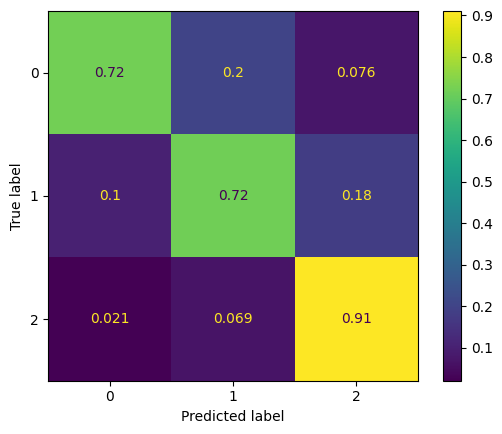

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.45674. Saving Model!
epoch 01, loss: 0.51738, acc: 0.78791, val_loss: 0.45674, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 02, loss: 0.51221, acc: 0.78882, val_loss: 0.46284, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 03, loss: 0.51056, acc: 0.79007, val_loss: 0.46669, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 04, loss: 0.50752, acc: 0.78985, val_loss: 0.46987, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 05, loss: 0.50674, acc: 0.79039, val_loss: 0.47256, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 06, loss: 0.50598, acc: 0.79035, val_loss: 0.47451, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 07, loss: 0.50405, acc: 0.79031, val_loss: 0.47695, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 08, loss: 0.50416, acc: 0.79037, val_loss: 0.47855, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 09, loss: 0.50292, acc: 0.79144, val_loss: 0.48028, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 10, loss: 0.50230, acc: 0.79192, val_loss: 0.48184, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 11, loss: 0.50172, acc: 0.79236, val_loss: 0.48320, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 12, loss: 0.50106, acc: 0.79264, val_loss: 0.48449, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 13, loss: 0.50088, acc: 0.79275, val_loss: 0.48561, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 14, loss: 0.49994, acc: 0.79404, val_loss: 0.48654, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 15, loss: 0.49973, acc: 0.79321, val_loss: 0.48779, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 16, loss: 0.49940, acc: 0.79578, val_loss: 0.48859, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 17, loss: 0.49856, acc: 0.79604, val_loss: 0.48985, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 18, loss: 0.49834, acc: 0.79497, val_loss: 0.49080, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 19, loss: 0.49800, acc: 0.79646, val_loss: 0.49162, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 20, loss: 0.49750, acc: 0.79624, val_loss: 0.49264, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 21, loss: 0.49715, acc: 0.79598, val_loss: 0.49333, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 22, loss: 0.49710, acc: 0.79637, val_loss: 0.49370, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 23, loss: 0.49576, acc: 0.79609, val_loss: 0.49463, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 24, loss: 0.49683, acc: 0.79737, val_loss: 0.49543, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 25, loss: 0.49542, acc: 0.79833, val_loss: 0.49604, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 26, loss: 0.49596, acc: 0.79764, val_loss: 0.49653, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 27, loss: 0.49454, acc: 0.79822, val_loss: 0.49727, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 28, loss: 0.49523, acc: 0.79770, val_loss: 0.49760, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 29, loss: 0.49406, acc: 0.79857, val_loss: 0.49820, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 30, loss: 0.49463, acc: 0.79827, val_loss: 0.49866, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 31, loss: 0.49348, acc: 0.79873, val_loss: 0.49927, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 32, loss: 0.49405, acc: 0.79825, val_loss: 0.49964, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 33, loss: 0.49282, acc: 0.79890, val_loss: 0.50044, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 34, loss: 0.49326, acc: 0.79857, val_loss: 0.50087, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 35, loss: 0.49248, acc: 0.79903, val_loss: 0.50102, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 36, loss: 0.49274, acc: 0.79879, val_loss: 0.50172, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 37, loss: 0.49170, acc: 0.79953, val_loss: 0.50223, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 38, loss: 0.49222, acc: 0.79890, val_loss: 0.50223, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 39, loss: 0.49140, acc: 0.79938, val_loss: 0.50270, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 40, loss: 0.49131, acc: 0.79938, val_loss: 0.50366, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 41, loss: 0.49088, acc: 0.79936, val_loss: 0.50384, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 42, loss: 0.49084, acc: 0.79949, val_loss: 0.50409, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 43, loss: 0.49014, acc: 0.79988, val_loss: 0.50493, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 44, loss: 0.49045, acc: 0.79964, val_loss: 0.50460, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 45, loss: 0.48990, acc: 0.79971, val_loss: 0.50563, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 46, loss: 0.48964, acc: 0.79982, val_loss: 0.50573, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 47, loss: 0.48942, acc: 0.80003, val_loss: 0.50611, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 48, loss: 0.48889, acc: 0.80045, val_loss: 0.50675, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 49, loss: 0.48932, acc: 0.80014, val_loss: 0.50640, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 50, loss: 0.48857, acc: 0.80041, val_loss: 0.50725, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 51, loss: 0.48853, acc: 0.80038, val_loss: 0.50762, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 52, loss: 0.48785, acc: 0.80130, val_loss: 0.50782, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 53, loss: 0.48839, acc: 0.80058, val_loss: 0.50804, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 54, loss: 0.48737, acc: 0.80147, val_loss: 0.50857, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 55, loss: 0.48791, acc: 0.80187, val_loss: 0.50876, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 56, loss: 0.48677, acc: 0.80193, val_loss: 0.50885, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 57, loss: 0.48737, acc: 0.80202, val_loss: 0.50942, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 58, loss: 0.48623, acc: 0.80272, val_loss: 0.50973, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 59, loss: 0.48655, acc: 0.80243, val_loss: 0.51001, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 60, loss: 0.48613, acc: 0.80300, val_loss: 0.51075, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 61, loss: 0.48606, acc: 0.80289, val_loss: 0.51087, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 62, loss: 0.48581, acc: 0.80305, val_loss: 0.51133, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 63, loss: 0.48512, acc: 0.80326, val_loss: 0.51146, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 64, loss: 0.48561, acc: 0.80311, val_loss: 0.51133, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 65, loss: 0.48474, acc: 0.80339, val_loss: 0.51225, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 66, loss: 0.48486, acc: 0.80329, val_loss: 0.51249, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 67, loss: 0.48444, acc: 0.80350, val_loss: 0.51243, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 68, loss: 0.48417, acc: 0.80348, val_loss: 0.51303, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 69, loss: 0.48405, acc: 0.80383, val_loss: 0.51282, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 70, loss: 0.48368, acc: 0.80394, val_loss: 0.51333, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 71, loss: 0.48372, acc: 0.80374, val_loss: 0.51361, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 72, loss: 0.48330, acc: 0.80390, val_loss: 0.51368, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 73, loss: 0.48253, acc: 0.80455, val_loss: 0.51438, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 74, loss: 0.48343, acc: 0.80420, val_loss: 0.51424, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 75, loss: 0.48229, acc: 0.80444, val_loss: 0.51485, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 76, loss: 0.48250, acc: 0.80400, val_loss: 0.51508, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 77, loss: 0.48202, acc: 0.80523, val_loss: 0.51535, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 78, loss: 0.48191, acc: 0.80505, val_loss: 0.51604, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 79, loss: 0.48184, acc: 0.80453, val_loss: 0.51555, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 80, loss: 0.48142, acc: 0.80531, val_loss: 0.51615, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 81, loss: 0.48136, acc: 0.80514, val_loss: 0.51654, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 82, loss: 0.48086, acc: 0.80529, val_loss: 0.51685, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 83, loss: 0.48095, acc: 0.80562, val_loss: 0.51708, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 84, loss: 0.48031, acc: 0.80544, val_loss: 0.51737, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 85, loss: 0.48070, acc: 0.80540, val_loss: 0.51773, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 86, loss: 0.47995, acc: 0.80562, val_loss: 0.51779, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 87, loss: 0.47983, acc: 0.80551, val_loss: 0.51817, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 88, loss: 0.47969, acc: 0.80612, val_loss: 0.51871, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 89, loss: 0.47982, acc: 0.80512, val_loss: 0.51844, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 90, loss: 0.47874, acc: 0.80632, val_loss: 0.51886, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 91, loss: 0.47937, acc: 0.80579, val_loss: 0.51947, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 92, loss: 0.47872, acc: 0.80608, val_loss: 0.51932, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 93, loss: 0.47890, acc: 0.80558, val_loss: 0.51975, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 94, loss: 0.47808, acc: 0.80649, val_loss: 0.51998, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 95, loss: 0.47898, acc: 0.80549, val_loss: 0.52002, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 96, loss: 0.47698, acc: 0.80684, val_loss: 0.52050, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 97, loss: 0.47829, acc: 0.80577, val_loss: 0.52087, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 98, loss: 0.47714, acc: 0.80669, val_loss: 0.52094, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 99, loss: 0.47756, acc: 0.80645, val_loss: 0.52099, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 100, loss: 0.47685, acc: 0.80678, val_loss: 0.52138, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 101, loss: 0.47721, acc: 0.80651, val_loss: 0.52154, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 102, loss: 0.47635, acc: 0.80675, val_loss: 0.52183, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 103, loss: 0.47668, acc: 0.80671, val_loss: 0.52198, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 104, loss: 0.47620, acc: 0.80717, val_loss: 0.52198, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 105, loss: 0.47637, acc: 0.80630, val_loss: 0.52216, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 106, loss: 0.47540, acc: 0.80745, val_loss: 0.52251, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 107, loss: 0.47610, acc: 0.80660, val_loss: 0.52277, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 108, loss: 0.47500, acc: 0.80726, val_loss: 0.52278, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 109, loss: 0.47536, acc: 0.80686, val_loss: 0.52357, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 110, loss: 0.47508, acc: 0.80747, val_loss: 0.52322, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 111, loss: 0.47486, acc: 0.80723, val_loss: 0.52378, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 112, loss: 0.47452, acc: 0.80791, val_loss: 0.52362, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 113, loss: 0.47486, acc: 0.80693, val_loss: 0.52363, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 114, loss: 0.47347, acc: 0.80802, val_loss: 0.52413, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 115, loss: 0.47477, acc: 0.80726, val_loss: 0.52434, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 116, loss: 0.47333, acc: 0.80771, val_loss: 0.52403, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 117, loss: 0.47379, acc: 0.80754, val_loss: 0.52473, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 118, loss: 0.47328, acc: 0.80791, val_loss: 0.52481, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 119, loss: 0.47378, acc: 0.80769, val_loss: 0.52489, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 120, loss: 0.47209, acc: 0.80854, val_loss: 0.52561, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 121, loss: 0.47380, acc: 0.80782, val_loss: 0.52526, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 122, loss: 0.47214, acc: 0.80835, val_loss: 0.52510, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 123, loss: 0.47264, acc: 0.80819, val_loss: 0.52590, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 124, loss: 0.47214, acc: 0.80861, val_loss: 0.52549, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 125, loss: 0.47273, acc: 0.80815, val_loss: 0.52579, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 126, loss: 0.47069, acc: 0.80896, val_loss: 0.52650, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 127, loss: 0.47287, acc: 0.80828, val_loss: 0.52608, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 128, loss: 0.47028, acc: 0.80983, val_loss: 0.52666, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 129, loss: 0.47210, acc: 0.80856, val_loss: 0.52683, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 130, loss: 0.47057, acc: 0.80887, val_loss: 0.52692, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 131, loss: 0.47104, acc: 0.80970, val_loss: 0.52682, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 132, loss: 0.47032, acc: 0.81024, val_loss: 0.52722, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 133, loss: 0.47082, acc: 0.80845, val_loss: 0.52740, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 134, loss: 0.47003, acc: 0.80902, val_loss: 0.52735, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 135, loss: 0.47061, acc: 0.80987, val_loss: 0.52742, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 136, loss: 0.46911, acc: 0.80896, val_loss: 0.52786, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 137, loss: 0.47057, acc: 0.80983, val_loss: 0.52776, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 138, loss: 0.46845, acc: 0.81053, val_loss: 0.52851, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 139, loss: 0.47001, acc: 0.80902, val_loss: 0.52848, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 140, loss: 0.46920, acc: 0.81068, val_loss: 0.52853, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 141, loss: 0.46876, acc: 0.80998, val_loss: 0.52937, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 142, loss: 0.46877, acc: 0.80874, val_loss: 0.52847, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 143, loss: 0.46871, acc: 0.81077, val_loss: 0.52910, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 144, loss: 0.46795, acc: 0.81129, val_loss: 0.52961, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 145, loss: 0.46847, acc: 0.81066, val_loss: 0.52917, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 146, loss: 0.46774, acc: 0.81105, val_loss: 0.52932, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 147, loss: 0.46801, acc: 0.81053, val_loss: 0.52972, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 148, loss: 0.46701, acc: 0.81133, val_loss: 0.53027, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 149, loss: 0.46808, acc: 0.81055, val_loss: 0.52963, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 150, loss: 0.46618, acc: 0.81171, val_loss: 0.53063, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 151, loss: 0.46815, acc: 0.80996, val_loss: 0.53016, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 152, loss: 0.46571, acc: 0.81166, val_loss: 0.53048, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 153, loss: 0.46733, acc: 0.81112, val_loss: 0.53059, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 154, loss: 0.46585, acc: 0.81175, val_loss: 0.53064, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 155, loss: 0.46660, acc: 0.81079, val_loss: 0.53069, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 156, loss: 0.46563, acc: 0.81151, val_loss: 0.53100, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 157, loss: 0.46646, acc: 0.81094, val_loss: 0.53069, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 158, loss: 0.46518, acc: 0.81116, val_loss: 0.53167, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 159, loss: 0.46566, acc: 0.81090, val_loss: 0.53153, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 160, loss: 0.46543, acc: 0.81162, val_loss: 0.53158, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 161, loss: 0.46517, acc: 0.81133, val_loss: 0.53136, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 162, loss: 0.46515, acc: 0.81035, val_loss: 0.53193, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 163, loss: 0.46406, acc: 0.81164, val_loss: 0.53137, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 164, loss: 0.46505, acc: 0.81079, val_loss: 0.53191, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 165, loss: 0.46412, acc: 0.81155, val_loss: 0.53200, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 166, loss: 0.46409, acc: 0.81118, val_loss: 0.53239, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 167, loss: 0.46408, acc: 0.81129, val_loss: 0.53236, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 168, loss: 0.46370, acc: 0.81210, val_loss: 0.53252, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 169, loss: 0.46363, acc: 0.81177, val_loss: 0.53265, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 170, loss: 0.46359, acc: 0.81181, val_loss: 0.53315, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 171, loss: 0.46310, acc: 0.81188, val_loss: 0.53317, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 172, loss: 0.46363, acc: 0.81197, val_loss: 0.53282, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 173, loss: 0.46212, acc: 0.81234, val_loss: 0.53367, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 174, loss: 0.46346, acc: 0.81199, val_loss: 0.53307, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 175, loss: 0.46183, acc: 0.81260, val_loss: 0.53354, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 176, loss: 0.46259, acc: 0.81190, val_loss: 0.53443, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 177, loss: 0.46224, acc: 0.81234, val_loss: 0.53358, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 178, loss: 0.46179, acc: 0.81273, val_loss: 0.53462, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 179, loss: 0.46159, acc: 0.81284, val_loss: 0.53404, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 180, loss: 0.46179, acc: 0.81275, val_loss: 0.53429, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 181, loss: 0.46112, acc: 0.81301, val_loss: 0.53424, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 182, loss: 0.46191, acc: 0.81249, val_loss: 0.53419, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 183, loss: 0.46029, acc: 0.81389, val_loss: 0.53525, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 184, loss: 0.46137, acc: 0.81264, val_loss: 0.53528, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 185, loss: 0.46018, acc: 0.81343, val_loss: 0.53472, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 186, loss: 0.46110, acc: 0.81275, val_loss: 0.53547, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 187, loss: 0.45932, acc: 0.81362, val_loss: 0.53617, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 188, loss: 0.46138, acc: 0.81280, val_loss: 0.53527, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 189, loss: 0.45844, acc: 0.81530, val_loss: 0.53651, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 190, loss: 0.46068, acc: 0.81332, val_loss: 0.53544, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 191, loss: 0.45900, acc: 0.81487, val_loss: 0.53622, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 192, loss: 0.45983, acc: 0.81354, val_loss: 0.53627, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 193, loss: 0.45867, acc: 0.81443, val_loss: 0.53677, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 194, loss: 0.45927, acc: 0.81415, val_loss: 0.53643, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 195, loss: 0.45855, acc: 0.81430, val_loss: 0.53679, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 196, loss: 0.45814, acc: 0.81395, val_loss: 0.53702, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 197, loss: 0.45862, acc: 0.81404, val_loss: 0.53705, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 198, loss: 0.45774, acc: 0.81511, val_loss: 0.53752, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 199, loss: 0.45785, acc: 0.81450, val_loss: 0.53821, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 200, loss: 0.45844, acc: 0.81443, val_loss: 0.53724, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 201, loss: 0.45674, acc: 0.81554, val_loss: 0.53885, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 202, loss: 0.45793, acc: 0.81537, val_loss: 0.53818, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 203, loss: 0.45709, acc: 0.81485, val_loss: 0.53826, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 204, loss: 0.45725, acc: 0.81618, val_loss: 0.53804, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 205, loss: 0.45682, acc: 0.81587, val_loss: 0.53866, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 206, loss: 0.45703, acc: 0.81576, val_loss: 0.53791, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 207, loss: 0.45631, acc: 0.81506, val_loss: 0.53883, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 208, loss: 0.45633, acc: 0.81596, val_loss: 0.53886, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 209, loss: 0.45645, acc: 0.81515, val_loss: 0.53844, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 210, loss: 0.45533, acc: 0.81677, val_loss: 0.53893, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 211, loss: 0.45611, acc: 0.81646, val_loss: 0.53880, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 212, loss: 0.45565, acc: 0.81690, val_loss: 0.53887, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 213, loss: 0.45485, acc: 0.81598, val_loss: 0.53998, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 214, loss: 0.45569, acc: 0.81609, val_loss: 0.53830, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 215, loss: 0.45477, acc: 0.81605, val_loss: 0.53940, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 216, loss: 0.45491, acc: 0.81705, val_loss: 0.53954, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 217, loss: 0.45508, acc: 0.81605, val_loss: 0.53891, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 218, loss: 0.45414, acc: 0.81659, val_loss: 0.53949, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 219, loss: 0.45432, acc: 0.81598, val_loss: 0.53985, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 220, loss: 0.45397, acc: 0.81742, val_loss: 0.53936, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 221, loss: 0.45411, acc: 0.81744, val_loss: 0.54006, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 222, loss: 0.45358, acc: 0.81714, val_loss: 0.53995, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 223, loss: 0.45320, acc: 0.81781, val_loss: 0.54021, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 224, loss: 0.45405, acc: 0.81740, val_loss: 0.53928, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 225, loss: 0.45243, acc: 0.81853, val_loss: 0.54067, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 226, loss: 0.45359, acc: 0.81903, val_loss: 0.53984, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 227, loss: 0.45260, acc: 0.81862, val_loss: 0.54041, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 228, loss: 0.45247, acc: 0.81906, val_loss: 0.54065, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 229, loss: 0.45286, acc: 0.81864, val_loss: 0.54044, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 230, loss: 0.45161, acc: 0.81945, val_loss: 0.54065, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 231, loss: 0.45222, acc: 0.81849, val_loss: 0.54178, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 232, loss: 0.45190, acc: 0.81934, val_loss: 0.54073, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 233, loss: 0.45158, acc: 0.81853, val_loss: 0.54170, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 234, loss: 0.45129, acc: 0.81908, val_loss: 0.54174, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 235, loss: 0.45145, acc: 0.81882, val_loss: 0.54124, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 236, loss: 0.45109, acc: 0.82061, val_loss: 0.54140, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 237, loss: 0.45072, acc: 0.81908, val_loss: 0.54187, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 238, loss: 0.45133, acc: 0.82052, val_loss: 0.54107, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 239, loss: 0.45034, acc: 0.81982, val_loss: 0.54240, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 240, loss: 0.45068, acc: 0.81956, val_loss: 0.54140, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 241, loss: 0.45048, acc: 0.82023, val_loss: 0.54141, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 242, loss: 0.44987, acc: 0.82078, val_loss: 0.54191, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 243, loss: 0.45029, acc: 0.81908, val_loss: 0.54208, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 244, loss: 0.45007, acc: 0.82087, val_loss: 0.54138, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 245, loss: 0.44959, acc: 0.82045, val_loss: 0.54278, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 246, loss: 0.44936, acc: 0.82102, val_loss: 0.54197, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 247, loss: 0.44970, acc: 0.82006, val_loss: 0.54211, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 248, loss: 0.44865, acc: 0.82119, val_loss: 0.54224, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 249, loss: 0.44983, acc: 0.81975, val_loss: 0.54277, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 250, loss: 0.44783, acc: 0.82122, val_loss: 0.54299, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 251, loss: 0.44936, acc: 0.81989, val_loss: 0.54303, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 252, loss: 0.44788, acc: 0.82165, val_loss: 0.54243, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 253, loss: 0.44860, acc: 0.82137, val_loss: 0.54308, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 254, loss: 0.44774, acc: 0.82152, val_loss: 0.54212, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 255, loss: 0.44819, acc: 0.82156, val_loss: 0.54342, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 256, loss: 0.44728, acc: 0.82235, val_loss: 0.54298, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 257, loss: 0.44844, acc: 0.82054, val_loss: 0.54286, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 258, loss: 0.44607, acc: 0.82255, val_loss: 0.54416, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 259, loss: 0.44844, acc: 0.82067, val_loss: 0.54342, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 260, loss: 0.44663, acc: 0.82237, val_loss: 0.54318, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 261, loss: 0.44718, acc: 0.82091, val_loss: 0.54363, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 262, loss: 0.44621, acc: 0.82248, val_loss: 0.54388, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 263, loss: 0.44699, acc: 0.82163, val_loss: 0.54451, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 264, loss: 0.44581, acc: 0.82246, val_loss: 0.54414, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 265, loss: 0.44652, acc: 0.82106, val_loss: 0.54442, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 266, loss: 0.44531, acc: 0.82320, val_loss: 0.54442, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 267, loss: 0.44648, acc: 0.82209, val_loss: 0.54470, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 268, loss: 0.44524, acc: 0.82242, val_loss: 0.54427, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 269, loss: 0.44547, acc: 0.82246, val_loss: 0.54514, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 270, loss: 0.44549, acc: 0.82355, val_loss: 0.54464, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 271, loss: 0.44545, acc: 0.82246, val_loss: 0.54491, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 272, loss: 0.44477, acc: 0.82351, val_loss: 0.54550, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 273, loss: 0.44516, acc: 0.82209, val_loss: 0.54545, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 274, loss: 0.44460, acc: 0.82381, val_loss: 0.54509, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 275, loss: 0.44439, acc: 0.82344, val_loss: 0.54580, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 276, loss: 0.44467, acc: 0.82344, val_loss: 0.54493, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 277, loss: 0.44426, acc: 0.82290, val_loss: 0.54589, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 278, loss: 0.44352, acc: 0.82444, val_loss: 0.54551, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 279, loss: 0.44466, acc: 0.82316, val_loss: 0.54582, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 280, loss: 0.44344, acc: 0.82449, val_loss: 0.54574, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 281, loss: 0.44387, acc: 0.82340, val_loss: 0.54659, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 282, loss: 0.44296, acc: 0.82442, val_loss: 0.54550, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 283, loss: 0.44379, acc: 0.82255, val_loss: 0.54663, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 284, loss: 0.44207, acc: 0.82464, val_loss: 0.54606, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 285, loss: 0.44357, acc: 0.82333, val_loss: 0.54726, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 286, loss: 0.44201, acc: 0.82381, val_loss: 0.54662, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 287, loss: 0.44282, acc: 0.82412, val_loss: 0.54631, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 288, loss: 0.44195, acc: 0.82479, val_loss: 0.54708, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 289, loss: 0.44194, acc: 0.82510, val_loss: 0.54714, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 290, loss: 0.44236, acc: 0.82451, val_loss: 0.54619, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 291, loss: 0.44179, acc: 0.82377, val_loss: 0.54719, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 292, loss: 0.44118, acc: 0.82499, val_loss: 0.54709, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 293, loss: 0.44190, acc: 0.82477, val_loss: 0.54756, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 294, loss: 0.44116, acc: 0.82453, val_loss: 0.54732, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 295, loss: 0.44115, acc: 0.82488, val_loss: 0.54739, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 296, loss: 0.44127, acc: 0.82536, val_loss: 0.54750, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 297, loss: 0.44037, acc: 0.82506, val_loss: 0.54804, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 298, loss: 0.44105, acc: 0.82525, val_loss: 0.54755, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 299, loss: 0.44020, acc: 0.82503, val_loss: 0.54755, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 300, loss: 0.44084, acc: 0.82508, val_loss: 0.54835, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 301, loss: 0.43957, acc: 0.82556, val_loss: 0.54805, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 302, loss: 0.44081, acc: 0.82492, val_loss: 0.54850, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 303, loss: 0.43926, acc: 0.82560, val_loss: 0.54793, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 304, loss: 0.44044, acc: 0.82543, val_loss: 0.54870, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 305, loss: 0.43888, acc: 0.82582, val_loss: 0.54868, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 306, loss: 0.44041, acc: 0.82510, val_loss: 0.54863, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 307, loss: 0.43766, acc: 0.82647, val_loss: 0.54930, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 308, loss: 0.44064, acc: 0.82536, val_loss: 0.54865, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 309, loss: 0.43798, acc: 0.82649, val_loss: 0.54888, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 310, loss: 0.43954, acc: 0.82562, val_loss: 0.54949, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 311, loss: 0.43772, acc: 0.82663, val_loss: 0.54927, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 312, loss: 0.43953, acc: 0.82512, val_loss: 0.54877, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 313, loss: 0.43704, acc: 0.82652, val_loss: 0.55003, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 314, loss: 0.44025, acc: 0.82567, val_loss: 0.54881, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 315, loss: 0.43633, acc: 0.82732, val_loss: 0.55018, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 316, loss: 0.43953, acc: 0.82543, val_loss: 0.55016, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 317, loss: 0.43597, acc: 0.82678, val_loss: 0.55011, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 318, loss: 0.43881, acc: 0.82586, val_loss: 0.55013, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 319, loss: 0.43622, acc: 0.82726, val_loss: 0.54966, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 320, loss: 0.43836, acc: 0.82575, val_loss: 0.55018, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 321, loss: 0.43537, acc: 0.82745, val_loss: 0.55078, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 322, loss: 0.43779, acc: 0.82536, val_loss: 0.55038, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 323, loss: 0.43571, acc: 0.82743, val_loss: 0.55058, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 324, loss: 0.43727, acc: 0.82597, val_loss: 0.55066, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 325, loss: 0.43524, acc: 0.82765, val_loss: 0.55056, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 326, loss: 0.43651, acc: 0.82704, val_loss: 0.55129, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 327, loss: 0.43557, acc: 0.82754, val_loss: 0.55036, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 328, loss: 0.43605, acc: 0.82687, val_loss: 0.55161, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 329, loss: 0.43484, acc: 0.82793, val_loss: 0.55173, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 330, loss: 0.43611, acc: 0.82680, val_loss: 0.55145, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 331, loss: 0.43436, acc: 0.82739, val_loss: 0.55143, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 332, loss: 0.43589, acc: 0.82732, val_loss: 0.55152, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 333, loss: 0.43437, acc: 0.82756, val_loss: 0.55148, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 334, loss: 0.43583, acc: 0.82726, val_loss: 0.55208, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 335, loss: 0.43394, acc: 0.82907, val_loss: 0.55204, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 336, loss: 0.43508, acc: 0.82730, val_loss: 0.55317, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 337, loss: 0.43379, acc: 0.82813, val_loss: 0.55181, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 338, loss: 0.43475, acc: 0.82772, val_loss: 0.55239, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 339, loss: 0.43329, acc: 0.82942, val_loss: 0.55248, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 340, loss: 0.43451, acc: 0.82728, val_loss: 0.55327, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 341, loss: 0.43319, acc: 0.82903, val_loss: 0.55211, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 342, loss: 0.43396, acc: 0.82846, val_loss: 0.55299, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 343, loss: 0.43353, acc: 0.82935, val_loss: 0.55224, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 344, loss: 0.43369, acc: 0.82900, val_loss: 0.55298, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 345, loss: 0.43264, acc: 0.82953, val_loss: 0.55322, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 346, loss: 0.43380, acc: 0.82813, val_loss: 0.55351, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 347, loss: 0.43182, acc: 0.82948, val_loss: 0.55356, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 348, loss: 0.43345, acc: 0.82879, val_loss: 0.55411, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 349, loss: 0.43169, acc: 0.83073, val_loss: 0.55313, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 350, loss: 0.43333, acc: 0.82841, val_loss: 0.55384, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 351, loss: 0.43134, acc: 0.82994, val_loss: 0.55327, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 352, loss: 0.43256, acc: 0.82855, val_loss: 0.55455, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 353, loss: 0.43102, acc: 0.83014, val_loss: 0.55478, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 354, loss: 0.43245, acc: 0.82870, val_loss: 0.55441, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 355, loss: 0.43084, acc: 0.83018, val_loss: 0.55414, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 356, loss: 0.43206, acc: 0.82981, val_loss: 0.55466, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 357, loss: 0.43058, acc: 0.83001, val_loss: 0.55499, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 358, loss: 0.43168, acc: 0.82898, val_loss: 0.55509, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 359, loss: 0.43024, acc: 0.83147, val_loss: 0.55478, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 360, loss: 0.43106, acc: 0.83020, val_loss: 0.55571, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 361, loss: 0.43038, acc: 0.83029, val_loss: 0.55425, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 362, loss: 0.43061, acc: 0.82959, val_loss: 0.55621, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 363, loss: 0.42976, acc: 0.83016, val_loss: 0.55490, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 364, loss: 0.43068, acc: 0.82920, val_loss: 0.55606, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 365, loss: 0.42949, acc: 0.83236, val_loss: 0.55509, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 366, loss: 0.43008, acc: 0.83029, val_loss: 0.55605, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 367, loss: 0.42957, acc: 0.83169, val_loss: 0.55578, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 368, loss: 0.42982, acc: 0.83086, val_loss: 0.55553, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 369, loss: 0.42896, acc: 0.83127, val_loss: 0.55595, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 370, loss: 0.43006, acc: 0.83014, val_loss: 0.55652, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 371, loss: 0.42794, acc: 0.83156, val_loss: 0.55601, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 372, loss: 0.43003, acc: 0.83094, val_loss: 0.55724, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 373, loss: 0.42768, acc: 0.83214, val_loss: 0.55649, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 374, loss: 0.42980, acc: 0.83127, val_loss: 0.55738, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 375, loss: 0.42706, acc: 0.83254, val_loss: 0.55712, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 376, loss: 0.42935, acc: 0.83062, val_loss: 0.55771, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 377, loss: 0.42719, acc: 0.83223, val_loss: 0.55703, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 378, loss: 0.42833, acc: 0.83206, val_loss: 0.55812, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 379, loss: 0.42740, acc: 0.83160, val_loss: 0.55700, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 380, loss: 0.42798, acc: 0.83099, val_loss: 0.55783, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 381, loss: 0.42682, acc: 0.83241, val_loss: 0.55755, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 382, loss: 0.42797, acc: 0.83121, val_loss: 0.55753, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 383, loss: 0.42651, acc: 0.83385, val_loss: 0.55802, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 384, loss: 0.42768, acc: 0.83129, val_loss: 0.55786, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 385, loss: 0.42683, acc: 0.83271, val_loss: 0.55741, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 386, loss: 0.42651, acc: 0.83365, val_loss: 0.55928, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 387, loss: 0.42651, acc: 0.83245, val_loss: 0.55849, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 388, loss: 0.42643, acc: 0.83273, val_loss: 0.55879, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 389, loss: 0.42583, acc: 0.83273, val_loss: 0.55888, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 390, loss: 0.42659, acc: 0.83164, val_loss: 0.55878, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 391, loss: 0.42542, acc: 0.83339, val_loss: 0.55876, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 392, loss: 0.42602, acc: 0.83293, val_loss: 0.55875, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


epoch 393, loss: 0.42528, acc: 0.83332, val_loss: 0.55967, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 394, loss: 0.42525, acc: 0.83415, val_loss: 0.55924, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 395, loss: 0.42575, acc: 0.83352, val_loss: 0.55907, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 396, loss: 0.42482, acc: 0.83402, val_loss: 0.55989, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 397, loss: 0.42563, acc: 0.83341, val_loss: 0.55873, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 398, loss: 0.42489, acc: 0.83260, val_loss: 0.56026, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 399, loss: 0.42438, acc: 0.83404, val_loss: 0.55982, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 400, loss: 0.42538, acc: 0.83291, val_loss: 0.55975, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 401, loss: 0.42391, acc: 0.83393, val_loss: 0.55941, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 402, loss: 0.42490, acc: 0.83273, val_loss: 0.56039, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 403, loss: 0.42409, acc: 0.83391, val_loss: 0.56012, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 404, loss: 0.42433, acc: 0.83265, val_loss: 0.56131, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 405, loss: 0.42368, acc: 0.83430, val_loss: 0.56043, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 406, loss: 0.42412, acc: 0.83385, val_loss: 0.56136, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 407, loss: 0.42350, acc: 0.83430, val_loss: 0.55963, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 408, loss: 0.42358, acc: 0.83337, val_loss: 0.56249, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 409, loss: 0.42334, acc: 0.83422, val_loss: 0.56036, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 410, loss: 0.42359, acc: 0.83363, val_loss: 0.56128, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 411, loss: 0.42250, acc: 0.83498, val_loss: 0.56053, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 412, loss: 0.42338, acc: 0.83367, val_loss: 0.56182, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 413, loss: 0.42288, acc: 0.83491, val_loss: 0.56025, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 414, loss: 0.42281, acc: 0.83406, val_loss: 0.56180, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 415, loss: 0.42229, acc: 0.83522, val_loss: 0.56133, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 416, loss: 0.42307, acc: 0.83439, val_loss: 0.56168, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 417, loss: 0.42125, acc: 0.83561, val_loss: 0.56132, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 418, loss: 0.42294, acc: 0.83400, val_loss: 0.56232, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 419, loss: 0.42096, acc: 0.83557, val_loss: 0.56116, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 420, loss: 0.42306, acc: 0.83385, val_loss: 0.56248, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 421, loss: 0.42087, acc: 0.83579, val_loss: 0.56135, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 422, loss: 0.42225, acc: 0.83415, val_loss: 0.56313, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 423, loss: 0.42035, acc: 0.83535, val_loss: 0.56327, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 424, loss: 0.42232, acc: 0.83439, val_loss: 0.56228, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 425, loss: 0.41992, acc: 0.83533, val_loss: 0.56241, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 426, loss: 0.42166, acc: 0.83459, val_loss: 0.56335, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 427, loss: 0.42014, acc: 0.83618, val_loss: 0.56196, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 428, loss: 0.42114, acc: 0.83470, val_loss: 0.56352, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 429, loss: 0.42028, acc: 0.83524, val_loss: 0.56274, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 430, loss: 0.42037, acc: 0.83546, val_loss: 0.56396, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 431, loss: 0.41966, acc: 0.83568, val_loss: 0.56280, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 432, loss: 0.42063, acc: 0.83474, val_loss: 0.56373, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 433, loss: 0.41887, acc: 0.83659, val_loss: 0.56412, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 434, loss: 0.42048, acc: 0.83491, val_loss: 0.56424, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 435, loss: 0.41904, acc: 0.83601, val_loss: 0.56320, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 436, loss: 0.41962, acc: 0.83537, val_loss: 0.56435, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 437, loss: 0.41884, acc: 0.83592, val_loss: 0.56406, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 438, loss: 0.41951, acc: 0.83603, val_loss: 0.56518, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 439, loss: 0.41931, acc: 0.83638, val_loss: 0.56280, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 440, loss: 0.41885, acc: 0.83522, val_loss: 0.56505, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 441, loss: 0.41859, acc: 0.83677, val_loss: 0.56323, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 442, loss: 0.41904, acc: 0.83489, val_loss: 0.56527, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 443, loss: 0.41766, acc: 0.83705, val_loss: 0.56473, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 444, loss: 0.41918, acc: 0.83555, val_loss: 0.56516, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 445, loss: 0.41776, acc: 0.83725, val_loss: 0.56400, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 446, loss: 0.41847, acc: 0.83622, val_loss: 0.56577, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 447, loss: 0.41738, acc: 0.83677, val_loss: 0.56475, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 448, loss: 0.41910, acc: 0.83592, val_loss: 0.56607, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 449, loss: 0.41620, acc: 0.83801, val_loss: 0.56576, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 450, loss: 0.41906, acc: 0.83561, val_loss: 0.56583, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 451, loss: 0.41603, acc: 0.83771, val_loss: 0.56549, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 452, loss: 0.41855, acc: 0.83655, val_loss: 0.56608, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 453, loss: 0.41589, acc: 0.83782, val_loss: 0.56569, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 454, loss: 0.41866, acc: 0.83590, val_loss: 0.56542, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 455, loss: 0.41510, acc: 0.83862, val_loss: 0.56720, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 456, loss: 0.41826, acc: 0.83583, val_loss: 0.56694, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 457, loss: 0.41493, acc: 0.83886, val_loss: 0.56690, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 458, loss: 0.41824, acc: 0.83640, val_loss: 0.56711, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 459, loss: 0.41491, acc: 0.83830, val_loss: 0.56659, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 460, loss: 0.41754, acc: 0.83681, val_loss: 0.56695, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 461, loss: 0.41484, acc: 0.83884, val_loss: 0.56621, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 462, loss: 0.41712, acc: 0.83699, val_loss: 0.56770, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 463, loss: 0.41399, acc: 0.83910, val_loss: 0.56778, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 464, loss: 0.41699, acc: 0.83629, val_loss: 0.56767, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 465, loss: 0.41439, acc: 0.83810, val_loss: 0.56680, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 466, loss: 0.41654, acc: 0.83740, val_loss: 0.56739, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 467, loss: 0.41360, acc: 0.83923, val_loss: 0.56732, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 468, loss: 0.41642, acc: 0.83703, val_loss: 0.56893, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 469, loss: 0.41361, acc: 0.83928, val_loss: 0.56809, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 470, loss: 0.41573, acc: 0.83703, val_loss: 0.56817, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 471, loss: 0.41394, acc: 0.83886, val_loss: 0.56725, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 472, loss: 0.41502, acc: 0.83758, val_loss: 0.56905, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 473, loss: 0.41321, acc: 0.83930, val_loss: 0.56871, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 474, loss: 0.41518, acc: 0.83793, val_loss: 0.56936, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 475, loss: 0.41272, acc: 0.83963, val_loss: 0.56829, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 476, loss: 0.41472, acc: 0.83801, val_loss: 0.56979, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 477, loss: 0.41278, acc: 0.83928, val_loss: 0.56852, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 478, loss: 0.41455, acc: 0.83788, val_loss: 0.56902, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 479, loss: 0.41248, acc: 0.83967, val_loss: 0.56933, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 480, loss: 0.41421, acc: 0.83823, val_loss: 0.56937, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 481, loss: 0.41178, acc: 0.83982, val_loss: 0.56961, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 482, loss: 0.41445, acc: 0.83729, val_loss: 0.56993, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 483, loss: 0.41137, acc: 0.83930, val_loss: 0.57032, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 484, loss: 0.41440, acc: 0.83795, val_loss: 0.56965, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 485, loss: 0.41062, acc: 0.83976, val_loss: 0.57040, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 486, loss: 0.41432, acc: 0.83786, val_loss: 0.57082, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 487, loss: 0.41023, acc: 0.84065, val_loss: 0.57055, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 488, loss: 0.41410, acc: 0.83860, val_loss: 0.57056, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 489, loss: 0.41061, acc: 0.83980, val_loss: 0.56986, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 490, loss: 0.41379, acc: 0.83712, val_loss: 0.57013, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 491, loss: 0.40991, acc: 0.84083, val_loss: 0.57094, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 492, loss: 0.41343, acc: 0.83858, val_loss: 0.57157, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 493, loss: 0.40976, acc: 0.84100, val_loss: 0.57095, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 494, loss: 0.41314, acc: 0.83847, val_loss: 0.57156, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 495, loss: 0.40968, acc: 0.84102, val_loss: 0.57044, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 496, loss: 0.41271, acc: 0.83943, val_loss: 0.57106, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 497, loss: 0.40960, acc: 0.84181, val_loss: 0.57158, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 498, loss: 0.41203, acc: 0.84004, val_loss: 0.57228, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 499, loss: 0.40942, acc: 0.84187, val_loss: 0.57149, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 500, loss: 0.41163, acc: 0.83989, val_loss: 0.57155, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 501, loss: 0.40912, acc: 0.84148, val_loss: 0.57206, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 502, loss: 0.41181, acc: 0.84002, val_loss: 0.57141, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 503, loss: 0.40831, acc: 0.84231, val_loss: 0.57254, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 504, loss: 0.41216, acc: 0.84061, val_loss: 0.57209, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 505, loss: 0.40773, acc: 0.84227, val_loss: 0.57363, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 506, loss: 0.41222, acc: 0.83952, val_loss: 0.57193, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 507, loss: 0.40729, acc: 0.84207, val_loss: 0.57263, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 508, loss: 0.41186, acc: 0.84087, val_loss: 0.57233, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 509, loss: 0.40738, acc: 0.84224, val_loss: 0.57325, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 510, loss: 0.41094, acc: 0.84113, val_loss: 0.57284, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 511, loss: 0.40705, acc: 0.84255, val_loss: 0.57357, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 512, loss: 0.41090, acc: 0.84131, val_loss: 0.57296, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 513, loss: 0.40716, acc: 0.84166, val_loss: 0.57340, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 514, loss: 0.41054, acc: 0.84115, val_loss: 0.57253, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 515, loss: 0.40622, acc: 0.84314, val_loss: 0.57435, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 516, loss: 0.41069, acc: 0.84131, val_loss: 0.57346, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 517, loss: 0.40566, acc: 0.84316, val_loss: 0.57513, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 518, loss: 0.41043, acc: 0.84070, val_loss: 0.57287, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 519, loss: 0.40612, acc: 0.84257, val_loss: 0.57366, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 520, loss: 0.41008, acc: 0.84163, val_loss: 0.57205, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 521, loss: 0.40537, acc: 0.84344, val_loss: 0.57579, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 522, loss: 0.40988, acc: 0.84194, val_loss: 0.57417, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 523, loss: 0.40498, acc: 0.84357, val_loss: 0.57511, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 524, loss: 0.40940, acc: 0.84185, val_loss: 0.57411, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 525, loss: 0.40516, acc: 0.84292, val_loss: 0.57467, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 526, loss: 0.40929, acc: 0.84209, val_loss: 0.57397, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 527, loss: 0.40459, acc: 0.84379, val_loss: 0.57516, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 528, loss: 0.40888, acc: 0.84262, val_loss: 0.57513, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 529, loss: 0.40442, acc: 0.84375, val_loss: 0.57542, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 530, loss: 0.40845, acc: 0.84205, val_loss: 0.57506, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 531, loss: 0.40461, acc: 0.84340, val_loss: 0.57504, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 532, loss: 0.40778, acc: 0.84272, val_loss: 0.57466, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 533, loss: 0.40437, acc: 0.84477, val_loss: 0.57639, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 534, loss: 0.40761, acc: 0.84240, val_loss: 0.57557, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 535, loss: 0.40400, acc: 0.84491, val_loss: 0.57631, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 536, loss: 0.40724, acc: 0.84266, val_loss: 0.57606, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 537, loss: 0.40396, acc: 0.84447, val_loss: 0.57541, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 538, loss: 0.40662, acc: 0.84268, val_loss: 0.57615, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 539, loss: 0.40362, acc: 0.84547, val_loss: 0.57681, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 540, loss: 0.40639, acc: 0.84290, val_loss: 0.57779, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 541, loss: 0.40356, acc: 0.84530, val_loss: 0.57685, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 542, loss: 0.40597, acc: 0.84386, val_loss: 0.57710, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 543, loss: 0.40372, acc: 0.84493, val_loss: 0.57601, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 544, loss: 0.40499, acc: 0.84331, val_loss: 0.57746, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 545, loss: 0.40397, acc: 0.84525, val_loss: 0.57664, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 546, loss: 0.40445, acc: 0.84425, val_loss: 0.57909, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 547, loss: 0.40356, acc: 0.84539, val_loss: 0.57713, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 548, loss: 0.40457, acc: 0.84403, val_loss: 0.57860, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 549, loss: 0.40326, acc: 0.84512, val_loss: 0.57746, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 550, loss: 0.40464, acc: 0.84375, val_loss: 0.57769, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 551, loss: 0.40224, acc: 0.84619, val_loss: 0.57894, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 552, loss: 0.40470, acc: 0.84397, val_loss: 0.57974, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 553, loss: 0.40218, acc: 0.84652, val_loss: 0.57901, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 554, loss: 0.40414, acc: 0.84353, val_loss: 0.57909, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 555, loss: 0.40244, acc: 0.84567, val_loss: 0.57704, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 556, loss: 0.40385, acc: 0.84423, val_loss: 0.58001, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 557, loss: 0.40215, acc: 0.84632, val_loss: 0.57824, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 558, loss: 0.40345, acc: 0.84471, val_loss: 0.58001, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 559, loss: 0.40112, acc: 0.84661, val_loss: 0.57961, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 560, loss: 0.40348, acc: 0.84405, val_loss: 0.57995, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 561, loss: 0.40148, acc: 0.84541, val_loss: 0.57884, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 562, loss: 0.40266, acc: 0.84495, val_loss: 0.58078, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 563, loss: 0.40122, acc: 0.84600, val_loss: 0.57953, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 564, loss: 0.40250, acc: 0.84495, val_loss: 0.58091, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 565, loss: 0.40118, acc: 0.84635, val_loss: 0.57972, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 566, loss: 0.40201, acc: 0.84477, val_loss: 0.58130, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 567, loss: 0.40096, acc: 0.84591, val_loss: 0.57989, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 568, loss: 0.40214, acc: 0.84488, val_loss: 0.58066, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 569, loss: 0.40010, acc: 0.84685, val_loss: 0.58111, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 570, loss: 0.40214, acc: 0.84501, val_loss: 0.58164, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 571, loss: 0.39953, acc: 0.84752, val_loss: 0.58172, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 572, loss: 0.40244, acc: 0.84456, val_loss: 0.58108, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 573, loss: 0.39956, acc: 0.84648, val_loss: 0.58137, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 574, loss: 0.40188, acc: 0.84517, val_loss: 0.58185, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 575, loss: 0.39913, acc: 0.84715, val_loss: 0.58176, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 576, loss: 0.40213, acc: 0.84515, val_loss: 0.58303, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 577, loss: 0.39885, acc: 0.84709, val_loss: 0.58159, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 578, loss: 0.40143, acc: 0.84510, val_loss: 0.58290, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 579, loss: 0.39901, acc: 0.84654, val_loss: 0.58107, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 580, loss: 0.40107, acc: 0.84539, val_loss: 0.58289, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 581, loss: 0.39862, acc: 0.84720, val_loss: 0.58130, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 582, loss: 0.40062, acc: 0.84552, val_loss: 0.58409, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 583, loss: 0.39831, acc: 0.84763, val_loss: 0.58287, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 584, loss: 0.40023, acc: 0.84584, val_loss: 0.58432, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 585, loss: 0.39821, acc: 0.84680, val_loss: 0.58209, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 586, loss: 0.40021, acc: 0.84582, val_loss: 0.58361, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 587, loss: 0.39764, acc: 0.84746, val_loss: 0.58323, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 588, loss: 0.39989, acc: 0.84608, val_loss: 0.58366, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 589, loss: 0.39708, acc: 0.84781, val_loss: 0.58368, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 590, loss: 0.39988, acc: 0.84582, val_loss: 0.58455, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 591, loss: 0.39715, acc: 0.84678, val_loss: 0.58391, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 592, loss: 0.40011, acc: 0.84589, val_loss: 0.58343, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 593, loss: 0.39622, acc: 0.84802, val_loss: 0.58523, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 594, loss: 0.40034, acc: 0.84573, val_loss: 0.58397, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 595, loss: 0.39543, acc: 0.84835, val_loss: 0.58499, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 596, loss: 0.40068, acc: 0.84491, val_loss: 0.58540, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 597, loss: 0.39554, acc: 0.84831, val_loss: 0.58540, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 598, loss: 0.40037, acc: 0.84464, val_loss: 0.58502, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 599, loss: 0.39567, acc: 0.84796, val_loss: 0.58538, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 600, loss: 0.39945, acc: 0.84680, val_loss: 0.58541, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 601, loss: 0.39482, acc: 0.84848, val_loss: 0.58603, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 602, loss: 0.39934, acc: 0.84617, val_loss: 0.58578, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 603, loss: 0.39492, acc: 0.84781, val_loss: 0.58590, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 604, loss: 0.39915, acc: 0.84619, val_loss: 0.58562, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 605, loss: 0.39443, acc: 0.84835, val_loss: 0.58716, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 606, loss: 0.39892, acc: 0.84639, val_loss: 0.58713, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 607, loss: 0.39393, acc: 0.84848, val_loss: 0.58746, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 608, loss: 0.39878, acc: 0.84611, val_loss: 0.58648, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 609, loss: 0.39434, acc: 0.84770, val_loss: 0.58689, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 610, loss: 0.39825, acc: 0.84652, val_loss: 0.58688, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 611, loss: 0.39415, acc: 0.84866, val_loss: 0.58739, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 612, loss: 0.39799, acc: 0.84700, val_loss: 0.58713, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 613, loss: 0.39338, acc: 0.84914, val_loss: 0.58816, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 614, loss: 0.39821, acc: 0.84722, val_loss: 0.58764, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 615, loss: 0.39342, acc: 0.84787, val_loss: 0.58812, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 616, loss: 0.39758, acc: 0.84687, val_loss: 0.58741, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 617, loss: 0.39303, acc: 0.84892, val_loss: 0.58837, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 618, loss: 0.39734, acc: 0.84744, val_loss: 0.58839, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 619, loss: 0.39224, acc: 0.84940, val_loss: 0.58991, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 620, loss: 0.39741, acc: 0.84783, val_loss: 0.58729, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 621, loss: 0.39215, acc: 0.84964, val_loss: 0.58985, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 622, loss: 0.39740, acc: 0.84761, val_loss: 0.58689, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 623, loss: 0.39154, acc: 0.84955, val_loss: 0.58995, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 624, loss: 0.39705, acc: 0.84724, val_loss: 0.58802, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 625, loss: 0.39205, acc: 0.84931, val_loss: 0.59058, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 626, loss: 0.39725, acc: 0.84637, val_loss: 0.58791, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 627, loss: 0.39174, acc: 0.84938, val_loss: 0.59014, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 628, loss: 0.39686, acc: 0.84639, val_loss: 0.58929, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 629, loss: 0.39063, acc: 0.85025, val_loss: 0.59104, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 630, loss: 0.39661, acc: 0.84818, val_loss: 0.58958, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 631, loss: 0.39081, acc: 0.84975, val_loss: 0.59072, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 632, loss: 0.39570, acc: 0.84685, val_loss: 0.58991, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 633, loss: 0.39065, acc: 0.84986, val_loss: 0.59010, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 634, loss: 0.39527, acc: 0.84700, val_loss: 0.59086, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 635, loss: 0.39131, acc: 0.84975, val_loss: 0.59057, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 636, loss: 0.39411, acc: 0.84833, val_loss: 0.59151, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 637, loss: 0.39144, acc: 0.85005, val_loss: 0.58997, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 638, loss: 0.39378, acc: 0.84844, val_loss: 0.59185, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 639, loss: 0.39131, acc: 0.85005, val_loss: 0.59168, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 640, loss: 0.39320, acc: 0.84824, val_loss: 0.59290, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 641, loss: 0.39089, acc: 0.85023, val_loss: 0.59066, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 642, loss: 0.39367, acc: 0.84822, val_loss: 0.59231, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 643, loss: 0.39035, acc: 0.84992, val_loss: 0.59154, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 644, loss: 0.39403, acc: 0.84787, val_loss: 0.59126, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 645, loss: 0.38999, acc: 0.85047, val_loss: 0.59292, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 646, loss: 0.39364, acc: 0.84822, val_loss: 0.59330, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 647, loss: 0.38915, acc: 0.85114, val_loss: 0.59312, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 648, loss: 0.39401, acc: 0.84831, val_loss: 0.59329, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 649, loss: 0.38935, acc: 0.85101, val_loss: 0.59256, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 650, loss: 0.39350, acc: 0.84737, val_loss: 0.59252, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 651, loss: 0.38934, acc: 0.85060, val_loss: 0.59279, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 652, loss: 0.39275, acc: 0.84901, val_loss: 0.59414, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 653, loss: 0.38890, acc: 0.85075, val_loss: 0.59375, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 654, loss: 0.39241, acc: 0.84866, val_loss: 0.59368, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 655, loss: 0.38861, acc: 0.85080, val_loss: 0.59388, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 656, loss: 0.39244, acc: 0.84874, val_loss: 0.59370, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 657, loss: 0.38833, acc: 0.85069, val_loss: 0.59409, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 658, loss: 0.39202, acc: 0.84920, val_loss: 0.59406, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 659, loss: 0.38770, acc: 0.85082, val_loss: 0.59454, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 660, loss: 0.39219, acc: 0.84877, val_loss: 0.59401, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 661, loss: 0.38797, acc: 0.84984, val_loss: 0.59394, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 662, loss: 0.39236, acc: 0.84761, val_loss: 0.59438, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 663, loss: 0.38721, acc: 0.85121, val_loss: 0.59563, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 664, loss: 0.39269, acc: 0.84901, val_loss: 0.59409, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 665, loss: 0.38631, acc: 0.85171, val_loss: 0.59565, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 666, loss: 0.39232, acc: 0.84807, val_loss: 0.59461, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 667, loss: 0.38664, acc: 0.85145, val_loss: 0.59560, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 668, loss: 0.39244, acc: 0.84772, val_loss: 0.59415, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 669, loss: 0.38583, acc: 0.85128, val_loss: 0.59688, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 670, loss: 0.39209, acc: 0.84957, val_loss: 0.59467, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 671, loss: 0.38529, acc: 0.85151, val_loss: 0.59689, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 672, loss: 0.39166, acc: 0.84975, val_loss: 0.59550, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 673, loss: 0.38561, acc: 0.85149, val_loss: 0.59611, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 674, loss: 0.39123, acc: 0.84857, val_loss: 0.59506, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 675, loss: 0.38589, acc: 0.85093, val_loss: 0.59629, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 676, loss: 0.39048, acc: 0.85027, val_loss: 0.59485, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 677, loss: 0.38502, acc: 0.85149, val_loss: 0.59736, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 678, loss: 0.39135, acc: 0.84842, val_loss: 0.59516, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 679, loss: 0.38492, acc: 0.85130, val_loss: 0.59719, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 680, loss: 0.39162, acc: 0.84868, val_loss: 0.59452, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 681, loss: 0.38434, acc: 0.85213, val_loss: 0.59879, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 682, loss: 0.39170, acc: 0.84877, val_loss: 0.59545, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 683, loss: 0.38326, acc: 0.85261, val_loss: 0.59856, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 684, loss: 0.39178, acc: 0.84877, val_loss: 0.59550, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 685, loss: 0.38279, acc: 0.85245, val_loss: 0.59936, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 686, loss: 0.39143, acc: 0.84894, val_loss: 0.59565, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 687, loss: 0.38270, acc: 0.85247, val_loss: 0.59924, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 688, loss: 0.39112, acc: 0.84894, val_loss: 0.59448, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 689, loss: 0.38299, acc: 0.85237, val_loss: 0.59950, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 690, loss: 0.39035, acc: 0.84850, val_loss: 0.59608, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 691, loss: 0.38293, acc: 0.85208, val_loss: 0.59975, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 692, loss: 0.38988, acc: 0.85023, val_loss: 0.59706, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 693, loss: 0.38279, acc: 0.85230, val_loss: 0.59973, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 694, loss: 0.38972, acc: 0.84831, val_loss: 0.59673, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 695, loss: 0.38257, acc: 0.85221, val_loss: 0.60023, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 696, loss: 0.38931, acc: 0.84999, val_loss: 0.59849, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 697, loss: 0.38293, acc: 0.85210, val_loss: 0.59931, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 698, loss: 0.38912, acc: 0.84894, val_loss: 0.59674, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 699, loss: 0.38184, acc: 0.85247, val_loss: 0.60041, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 700, loss: 0.38918, acc: 0.84986, val_loss: 0.59744, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 701, loss: 0.38113, acc: 0.85287, val_loss: 0.60208, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 702, loss: 0.38909, acc: 0.84994, val_loss: 0.59754, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 703, loss: 0.38106, acc: 0.85300, val_loss: 0.60213, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 704, loss: 0.38920, acc: 0.84864, val_loss: 0.59761, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 705, loss: 0.38088, acc: 0.85317, val_loss: 0.60175, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 706, loss: 0.38928, acc: 0.84870, val_loss: 0.59745, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 707, loss: 0.38059, acc: 0.85271, val_loss: 0.60208, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 708, loss: 0.38838, acc: 0.84903, val_loss: 0.59879, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 709, loss: 0.38033, acc: 0.85285, val_loss: 0.60224, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 710, loss: 0.38857, acc: 0.84888, val_loss: 0.59886, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 711, loss: 0.38063, acc: 0.85258, val_loss: 0.60255, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 712, loss: 0.38795, acc: 0.84896, val_loss: 0.59858, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 713, loss: 0.38067, acc: 0.85237, val_loss: 0.60311, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 714, loss: 0.38724, acc: 0.84962, val_loss: 0.59919, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 715, loss: 0.37962, acc: 0.85326, val_loss: 0.60363, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 716, loss: 0.38759, acc: 0.84936, val_loss: 0.59993, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 717, loss: 0.38023, acc: 0.85315, val_loss: 0.60293, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 718, loss: 0.38637, acc: 0.84907, val_loss: 0.60049, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 719, loss: 0.38015, acc: 0.85300, val_loss: 0.60293, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 720, loss: 0.38642, acc: 0.84955, val_loss: 0.60076, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 721, loss: 0.37930, acc: 0.85328, val_loss: 0.60429, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 722, loss: 0.38629, acc: 0.84949, val_loss: 0.60016, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 723, loss: 0.37967, acc: 0.85306, val_loss: 0.60361, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 724, loss: 0.38621, acc: 0.85056, val_loss: 0.60119, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 725, loss: 0.37897, acc: 0.85361, val_loss: 0.60469, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 726, loss: 0.38637, acc: 0.84955, val_loss: 0.60155, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 727, loss: 0.37830, acc: 0.85346, val_loss: 0.60448, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 728, loss: 0.38686, acc: 0.84938, val_loss: 0.60115, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 729, loss: 0.37867, acc: 0.85363, val_loss: 0.60528, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 730, loss: 0.38624, acc: 0.84975, val_loss: 0.60112, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 731, loss: 0.37809, acc: 0.85354, val_loss: 0.60512, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 732, loss: 0.38619, acc: 0.84949, val_loss: 0.60093, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 733, loss: 0.37667, acc: 0.85413, val_loss: 0.60710, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 734, loss: 0.38662, acc: 0.84968, val_loss: 0.60068, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 735, loss: 0.37705, acc: 0.85426, val_loss: 0.60630, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 736, loss: 0.38605, acc: 0.84979, val_loss: 0.60083, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 737, loss: 0.37658, acc: 0.85413, val_loss: 0.60742, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 738, loss: 0.38606, acc: 0.84975, val_loss: 0.60116, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 739, loss: 0.37629, acc: 0.85429, val_loss: 0.60784, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 740, loss: 0.38625, acc: 0.85027, val_loss: 0.60179, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 741, loss: 0.37628, acc: 0.85457, val_loss: 0.60750, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 742, loss: 0.38614, acc: 0.84988, val_loss: 0.60190, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 743, loss: 0.37598, acc: 0.85418, val_loss: 0.60839, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 744, loss: 0.38540, acc: 0.85032, val_loss: 0.60326, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 745, loss: 0.37552, acc: 0.85429, val_loss: 0.60950, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 746, loss: 0.38586, acc: 0.84981, val_loss: 0.60266, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 747, loss: 0.37546, acc: 0.85444, val_loss: 0.60825, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 748, loss: 0.38508, acc: 0.85003, val_loss: 0.60311, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 749, loss: 0.37531, acc: 0.85455, val_loss: 0.60966, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 750, loss: 0.38452, acc: 0.85021, val_loss: 0.60434, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 751, loss: 0.37481, acc: 0.85494, val_loss: 0.60938, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 752, loss: 0.38473, acc: 0.85025, val_loss: 0.60315, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 753, loss: 0.37495, acc: 0.85459, val_loss: 0.60953, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 754, loss: 0.38475, acc: 0.85034, val_loss: 0.60353, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 755, loss: 0.37482, acc: 0.85481, val_loss: 0.60958, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 756, loss: 0.38393, acc: 0.85027, val_loss: 0.60506, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 757, loss: 0.37411, acc: 0.85531, val_loss: 0.61037, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 758, loss: 0.38402, acc: 0.85029, val_loss: 0.60415, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 759, loss: 0.37448, acc: 0.85490, val_loss: 0.60980, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 760, loss: 0.38289, acc: 0.85149, val_loss: 0.60497, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 761, loss: 0.37497, acc: 0.85503, val_loss: 0.61009, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 762, loss: 0.38192, acc: 0.85073, val_loss: 0.60651, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 763, loss: 0.37439, acc: 0.85501, val_loss: 0.61014, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 764, loss: 0.38200, acc: 0.85084, val_loss: 0.60669, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 765, loss: 0.37484, acc: 0.85455, val_loss: 0.60982, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 766, loss: 0.38111, acc: 0.85073, val_loss: 0.60681, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 767, loss: 0.37472, acc: 0.85505, val_loss: 0.60958, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 768, loss: 0.38075, acc: 0.85136, val_loss: 0.60766, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 769, loss: 0.37403, acc: 0.85516, val_loss: 0.61107, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 770, loss: 0.38074, acc: 0.85095, val_loss: 0.60798, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 771, loss: 0.37436, acc: 0.85527, val_loss: 0.60990, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 772, loss: 0.38056, acc: 0.85237, val_loss: 0.60796, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 773, loss: 0.37387, acc: 0.85522, val_loss: 0.61086, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 774, loss: 0.38017, acc: 0.85213, val_loss: 0.60866, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 775, loss: 0.37360, acc: 0.85514, val_loss: 0.61078, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 776, loss: 0.38008, acc: 0.85128, val_loss: 0.60829, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 777, loss: 0.37343, acc: 0.85540, val_loss: 0.61220, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 778, loss: 0.37981, acc: 0.85136, val_loss: 0.60839, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 779, loss: 0.37305, acc: 0.85603, val_loss: 0.61202, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 780, loss: 0.37974, acc: 0.85132, val_loss: 0.60941, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 781, loss: 0.37280, acc: 0.85544, val_loss: 0.61212, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 782, loss: 0.37991, acc: 0.85149, val_loss: 0.60883, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 783, loss: 0.37259, acc: 0.85592, val_loss: 0.61291, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 784, loss: 0.38041, acc: 0.85097, val_loss: 0.60913, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 785, loss: 0.37157, acc: 0.85640, val_loss: 0.61428, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 786, loss: 0.38075, acc: 0.85132, val_loss: 0.60868, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 787, loss: 0.37093, acc: 0.85614, val_loss: 0.61467, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 788, loss: 0.38111, acc: 0.85110, val_loss: 0.60799, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 789, loss: 0.37077, acc: 0.85623, val_loss: 0.61486, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 790, loss: 0.38130, acc: 0.85151, val_loss: 0.60919, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 791, loss: 0.37055, acc: 0.85653, val_loss: 0.61538, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 792, loss: 0.38121, acc: 0.85141, val_loss: 0.60886, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 793, loss: 0.37001, acc: 0.85616, val_loss: 0.61559, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 794, loss: 0.38087, acc: 0.85158, val_loss: 0.60947, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 795, loss: 0.36982, acc: 0.85690, val_loss: 0.61621, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 796, loss: 0.38018, acc: 0.85173, val_loss: 0.60983, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 797, loss: 0.36940, acc: 0.85653, val_loss: 0.61624, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 798, loss: 0.38011, acc: 0.85165, val_loss: 0.61014, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 799, loss: 0.36981, acc: 0.85688, val_loss: 0.61585, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 800, loss: 0.37953, acc: 0.85178, val_loss: 0.60971, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 801, loss: 0.36991, acc: 0.85688, val_loss: 0.61659, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 802, loss: 0.37857, acc: 0.85230, val_loss: 0.61174, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 803, loss: 0.36982, acc: 0.85695, val_loss: 0.61683, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 804, loss: 0.37862, acc: 0.85189, val_loss: 0.61146, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 805, loss: 0.36970, acc: 0.85699, val_loss: 0.61659, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 806, loss: 0.37867, acc: 0.85173, val_loss: 0.61210, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 807, loss: 0.36989, acc: 0.85618, val_loss: 0.61621, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 808, loss: 0.37814, acc: 0.85232, val_loss: 0.61224, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 809, loss: 0.36872, acc: 0.85740, val_loss: 0.61930, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 810, loss: 0.37902, acc: 0.85221, val_loss: 0.61224, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 811, loss: 0.36947, acc: 0.85655, val_loss: 0.61591, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 812, loss: 0.37806, acc: 0.85241, val_loss: 0.61270, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 813, loss: 0.36879, acc: 0.85688, val_loss: 0.61775, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 814, loss: 0.37713, acc: 0.85239, val_loss: 0.61418, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 815, loss: 0.36862, acc: 0.85730, val_loss: 0.61829, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 816, loss: 0.37704, acc: 0.85243, val_loss: 0.61408, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 817, loss: 0.36777, acc: 0.85738, val_loss: 0.61991, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 818, loss: 0.37690, acc: 0.85221, val_loss: 0.61320, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 819, loss: 0.36800, acc: 0.85730, val_loss: 0.61857, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 820, loss: 0.37729, acc: 0.85274, val_loss: 0.61244, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 821, loss: 0.36757, acc: 0.85719, val_loss: 0.61920, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 822, loss: 0.37689, acc: 0.85300, val_loss: 0.61429, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 823, loss: 0.36729, acc: 0.85749, val_loss: 0.62153, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 824, loss: 0.37779, acc: 0.85219, val_loss: 0.61340, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 825, loss: 0.36745, acc: 0.85734, val_loss: 0.62011, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 826, loss: 0.37680, acc: 0.85276, val_loss: 0.61455, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 827, loss: 0.36715, acc: 0.85762, val_loss: 0.62097, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 828, loss: 0.37698, acc: 0.85265, val_loss: 0.61512, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 829, loss: 0.36581, acc: 0.85797, val_loss: 0.62189, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 830, loss: 0.37669, acc: 0.85267, val_loss: 0.61495, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 831, loss: 0.36666, acc: 0.85773, val_loss: 0.61961, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 832, loss: 0.37623, acc: 0.85304, val_loss: 0.61488, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 833, loss: 0.36628, acc: 0.85771, val_loss: 0.62127, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 834, loss: 0.37556, acc: 0.85330, val_loss: 0.61660, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 835, loss: 0.36576, acc: 0.85760, val_loss: 0.62211, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 836, loss: 0.37588, acc: 0.85291, val_loss: 0.61478, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 837, loss: 0.36634, acc: 0.85780, val_loss: 0.62118, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 838, loss: 0.37531, acc: 0.85343, val_loss: 0.61658, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 839, loss: 0.36624, acc: 0.85786, val_loss: 0.62182, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 840, loss: 0.37512, acc: 0.85357, val_loss: 0.61586, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 841, loss: 0.36502, acc: 0.85799, val_loss: 0.62247, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 842, loss: 0.37563, acc: 0.85333, val_loss: 0.61623, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 843, loss: 0.36496, acc: 0.85808, val_loss: 0.62269, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 844, loss: 0.37485, acc: 0.85361, val_loss: 0.61722, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 845, loss: 0.36510, acc: 0.85819, val_loss: 0.62303, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 846, loss: 0.37440, acc: 0.85365, val_loss: 0.61638, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 847, loss: 0.36503, acc: 0.85836, val_loss: 0.62304, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 848, loss: 0.37509, acc: 0.85339, val_loss: 0.61701, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 849, loss: 0.36500, acc: 0.85788, val_loss: 0.62331, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 850, loss: 0.37399, acc: 0.85381, val_loss: 0.61886, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 851, loss: 0.36418, acc: 0.85867, val_loss: 0.62454, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 852, loss: 0.37464, acc: 0.85337, val_loss: 0.61777, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 853, loss: 0.36416, acc: 0.85895, val_loss: 0.62402, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 854, loss: 0.37436, acc: 0.85378, val_loss: 0.61772, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 855, loss: 0.36373, acc: 0.85850, val_loss: 0.62510, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 856, loss: 0.37437, acc: 0.85370, val_loss: 0.61833, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 857, loss: 0.36350, acc: 0.85867, val_loss: 0.62467, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 858, loss: 0.37362, acc: 0.85400, val_loss: 0.61835, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 859, loss: 0.36386, acc: 0.85863, val_loss: 0.62346, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 860, loss: 0.37301, acc: 0.85426, val_loss: 0.61938, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 861, loss: 0.36356, acc: 0.85887, val_loss: 0.62420, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 862, loss: 0.37229, acc: 0.85426, val_loss: 0.62008, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 863, loss: 0.36292, acc: 0.85884, val_loss: 0.62502, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 864, loss: 0.37280, acc: 0.85426, val_loss: 0.61855, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 865, loss: 0.36309, acc: 0.85906, val_loss: 0.62502, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 866, loss: 0.37196, acc: 0.85479, val_loss: 0.62002, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 867, loss: 0.36283, acc: 0.85919, val_loss: 0.62514, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 868, loss: 0.37201, acc: 0.85468, val_loss: 0.62115, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 869, loss: 0.36272, acc: 0.85906, val_loss: 0.62525, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 870, loss: 0.37102, acc: 0.85450, val_loss: 0.62099, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 871, loss: 0.36269, acc: 0.85906, val_loss: 0.62623, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 872, loss: 0.37073, acc: 0.85579, val_loss: 0.62175, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 873, loss: 0.36257, acc: 0.85941, val_loss: 0.62559, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 874, loss: 0.37104, acc: 0.85472, val_loss: 0.62087, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 875, loss: 0.36220, acc: 0.85948, val_loss: 0.62598, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 876, loss: 0.37066, acc: 0.85498, val_loss: 0.62116, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 877, loss: 0.36196, acc: 0.85954, val_loss: 0.62497, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 878, loss: 0.37054, acc: 0.85487, val_loss: 0.62203, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 879, loss: 0.36195, acc: 0.85946, val_loss: 0.62749, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 880, loss: 0.37021, acc: 0.85518, val_loss: 0.62200, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 881, loss: 0.36128, acc: 0.85993, val_loss: 0.62696, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 882, loss: 0.37026, acc: 0.85509, val_loss: 0.62277, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 883, loss: 0.36172, acc: 0.85917, val_loss: 0.62694, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 884, loss: 0.36961, acc: 0.85540, val_loss: 0.62417, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 885, loss: 0.36191, acc: 0.85950, val_loss: 0.62661, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 886, loss: 0.36981, acc: 0.85520, val_loss: 0.62362, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 887, loss: 0.36155, acc: 0.85935, val_loss: 0.62702, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 888, loss: 0.36871, acc: 0.85660, val_loss: 0.62568, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 889, loss: 0.36145, acc: 0.85937, val_loss: 0.62700, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 890, loss: 0.36851, acc: 0.85629, val_loss: 0.62433, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 891, loss: 0.36115, acc: 0.85996, val_loss: 0.62798, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 892, loss: 0.36807, acc: 0.85662, val_loss: 0.62525, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 893, loss: 0.36097, acc: 0.85993, val_loss: 0.62735, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 894, loss: 0.36761, acc: 0.85583, val_loss: 0.62534, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 895, loss: 0.36104, acc: 0.85978, val_loss: 0.62740, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 896, loss: 0.36737, acc: 0.85712, val_loss: 0.62546, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 897, loss: 0.36080, acc: 0.85980, val_loss: 0.62867, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 898, loss: 0.36722, acc: 0.85699, val_loss: 0.62526, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 899, loss: 0.36037, acc: 0.86002, val_loss: 0.62842, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 900, loss: 0.36745, acc: 0.85603, val_loss: 0.62696, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 901, loss: 0.35990, acc: 0.85987, val_loss: 0.62951, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 902, loss: 0.36836, acc: 0.85570, val_loss: 0.62419, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 903, loss: 0.35927, acc: 0.86035, val_loss: 0.63115, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 904, loss: 0.36939, acc: 0.85601, val_loss: 0.62413, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 905, loss: 0.35833, acc: 0.86057, val_loss: 0.63009, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 906, loss: 0.36997, acc: 0.85575, val_loss: 0.62480, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 907, loss: 0.35814, acc: 0.86035, val_loss: 0.63286, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 908, loss: 0.36946, acc: 0.85614, val_loss: 0.62500, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 909, loss: 0.35772, acc: 0.86070, val_loss: 0.63227, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 910, loss: 0.36959, acc: 0.85596, val_loss: 0.62371, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 911, loss: 0.35750, acc: 0.86026, val_loss: 0.63332, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 912, loss: 0.36940, acc: 0.85605, val_loss: 0.62517, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 913, loss: 0.35753, acc: 0.86131, val_loss: 0.63320, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 914, loss: 0.36898, acc: 0.85575, val_loss: 0.62624, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 915, loss: 0.35754, acc: 0.86028, val_loss: 0.63338, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 916, loss: 0.36854, acc: 0.85636, val_loss: 0.62578, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 917, loss: 0.35726, acc: 0.86059, val_loss: 0.63307, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 918, loss: 0.36860, acc: 0.85616, val_loss: 0.62564, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 919, loss: 0.35661, acc: 0.86107, val_loss: 0.63289, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 920, loss: 0.36779, acc: 0.85599, val_loss: 0.62641, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 921, loss: 0.35694, acc: 0.86107, val_loss: 0.63260, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 922, loss: 0.36756, acc: 0.85666, val_loss: 0.62581, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 923, loss: 0.35673, acc: 0.86120, val_loss: 0.63349, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 924, loss: 0.36681, acc: 0.85686, val_loss: 0.62678, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 925, loss: 0.35674, acc: 0.86103, val_loss: 0.63262, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 926, loss: 0.36697, acc: 0.85651, val_loss: 0.62691, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 927, loss: 0.35623, acc: 0.86094, val_loss: 0.63317, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 928, loss: 0.36656, acc: 0.85664, val_loss: 0.62657, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 929, loss: 0.35600, acc: 0.86148, val_loss: 0.63384, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 930, loss: 0.36703, acc: 0.85658, val_loss: 0.62683, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 931, loss: 0.35527, acc: 0.86146, val_loss: 0.63501, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 932, loss: 0.36745, acc: 0.85577, val_loss: 0.62772, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 933, loss: 0.35532, acc: 0.86146, val_loss: 0.63481, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 934, loss: 0.36625, acc: 0.85719, val_loss: 0.62765, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 935, loss: 0.35566, acc: 0.86135, val_loss: 0.63470, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 936, loss: 0.36579, acc: 0.85734, val_loss: 0.62851, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 937, loss: 0.35557, acc: 0.86131, val_loss: 0.63464, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 938, loss: 0.36526, acc: 0.85668, val_loss: 0.62827, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 939, loss: 0.35530, acc: 0.86151, val_loss: 0.63642, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 940, loss: 0.36546, acc: 0.85736, val_loss: 0.62961, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 941, loss: 0.35509, acc: 0.86153, val_loss: 0.63446, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 942, loss: 0.36566, acc: 0.85723, val_loss: 0.62827, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 943, loss: 0.35488, acc: 0.86146, val_loss: 0.63606, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 944, loss: 0.36528, acc: 0.85745, val_loss: 0.62878, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 945, loss: 0.35497, acc: 0.86170, val_loss: 0.63436, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 946, loss: 0.36413, acc: 0.85771, val_loss: 0.62971, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 947, loss: 0.35465, acc: 0.86157, val_loss: 0.63534, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 948, loss: 0.36403, acc: 0.85760, val_loss: 0.62964, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 949, loss: 0.35459, acc: 0.86153, val_loss: 0.63564, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 950, loss: 0.36347, acc: 0.85775, val_loss: 0.62909, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 951, loss: 0.35454, acc: 0.86151, val_loss: 0.63564, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 952, loss: 0.36348, acc: 0.85806, val_loss: 0.63036, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 953, loss: 0.35459, acc: 0.86129, val_loss: 0.63458, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 954, loss: 0.36340, acc: 0.85778, val_loss: 0.63003, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 955, loss: 0.35442, acc: 0.86170, val_loss: 0.63649, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 956, loss: 0.36303, acc: 0.85823, val_loss: 0.63181, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 957, loss: 0.35428, acc: 0.86164, val_loss: 0.63535, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 958, loss: 0.36294, acc: 0.85782, val_loss: 0.63002, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 959, loss: 0.35387, acc: 0.86175, val_loss: 0.63709, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 960, loss: 0.36312, acc: 0.85823, val_loss: 0.63168, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 961, loss: 0.35337, acc: 0.86196, val_loss: 0.63522, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 962, loss: 0.36288, acc: 0.85788, val_loss: 0.62995, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 963, loss: 0.35283, acc: 0.86223, val_loss: 0.63621, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 964, loss: 0.36268, acc: 0.85847, val_loss: 0.63168, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 965, loss: 0.35322, acc: 0.86209, val_loss: 0.63625, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 966, loss: 0.36184, acc: 0.85786, val_loss: 0.63151, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 967, loss: 0.35287, acc: 0.86266, val_loss: 0.63697, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 968, loss: 0.36172, acc: 0.85826, val_loss: 0.63180, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 969, loss: 0.35303, acc: 0.86255, val_loss: 0.63574, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 970, loss: 0.36109, acc: 0.85821, val_loss: 0.63204, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 971, loss: 0.35261, acc: 0.86249, val_loss: 0.63800, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 972, loss: 0.36244, acc: 0.85795, val_loss: 0.63152, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 973, loss: 0.35166, acc: 0.86253, val_loss: 0.63784, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 974, loss: 0.36193, acc: 0.85797, val_loss: 0.63151, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 975, loss: 0.35189, acc: 0.86247, val_loss: 0.63894, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 976, loss: 0.36289, acc: 0.85860, val_loss: 0.63078, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 977, loss: 0.35113, acc: 0.86253, val_loss: 0.63907, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 978, loss: 0.36347, acc: 0.85819, val_loss: 0.63091, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 979, loss: 0.35095, acc: 0.86279, val_loss: 0.64016, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 980, loss: 0.36293, acc: 0.85847, val_loss: 0.63147, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 981, loss: 0.35029, acc: 0.86286, val_loss: 0.63980, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 982, loss: 0.36373, acc: 0.85775, val_loss: 0.63149, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 983, loss: 0.34986, acc: 0.86327, val_loss: 0.64032, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 984, loss: 0.36300, acc: 0.85806, val_loss: 0.63232, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 985, loss: 0.35017, acc: 0.86332, val_loss: 0.64012, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 986, loss: 0.36212, acc: 0.85876, val_loss: 0.63289, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 987, loss: 0.34998, acc: 0.86292, val_loss: 0.63991, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 988, loss: 0.36102, acc: 0.85856, val_loss: 0.63377, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 989, loss: 0.35016, acc: 0.86310, val_loss: 0.63993, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 990, loss: 0.36101, acc: 0.85867, val_loss: 0.63165, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 991, loss: 0.34929, acc: 0.86356, val_loss: 0.64158, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 992, loss: 0.36103, acc: 0.85922, val_loss: 0.63357, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 993, loss: 0.34951, acc: 0.86356, val_loss: 0.64082, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 994, loss: 0.36119, acc: 0.85847, val_loss: 0.63299, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 995, loss: 0.34972, acc: 0.86332, val_loss: 0.64137, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 996, loss: 0.36040, acc: 0.85913, val_loss: 0.63433, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 997, loss: 0.34949, acc: 0.86345, val_loss: 0.64108, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 998, loss: 0.36044, acc: 0.85867, val_loss: 0.63472, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 999, loss: 0.34926, acc: 0.86340, val_loss: 0.64064, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 1000, loss: 0.35979, acc: 0.85860, val_loss: 0.63446, val_accuracy: 0.82077
2번째 교차검증
evaluation loss: 0.45450, evaluation accuracy: 0.81606
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[2]Accuracy : 0.8172359638790734
[2]F1score : 0.8169572214610282
[2]Precision : 0.8217429288482873
[2]Recall : 0.8172359638790734



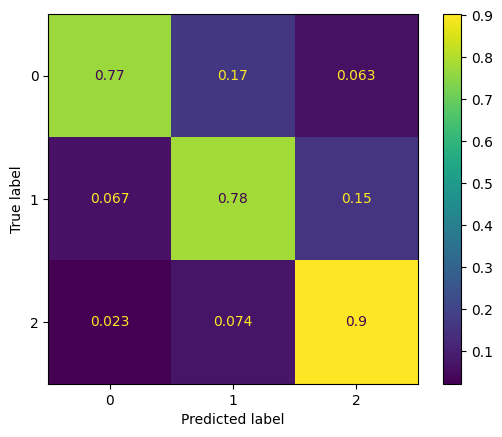

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.43210. Saving Model!
epoch 01, loss: 0.51474, acc: 0.78802, val_loss: 0.43210, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 02, loss: 0.51388, acc: 0.78703, val_loss: 0.43438, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 03, loss: 0.51086, acc: 0.78843, val_loss: 0.43488, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 04, loss: 0.51133, acc: 0.78828, val_loss: 0.43549, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 05, loss: 0.50900, acc: 0.78778, val_loss: 0.43672, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 06, loss: 0.50728, acc: 0.78941, val_loss: 0.43728, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 07, loss: 0.50700, acc: 0.78904, val_loss: 0.43758, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 08, loss: 0.50565, acc: 0.78869, val_loss: 0.43848, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 09, loss: 0.50533, acc: 0.78939, val_loss: 0.43925, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 10, loss: 0.50447, acc: 0.79050, val_loss: 0.43979, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 11, loss: 0.50390, acc: 0.79066, val_loss: 0.44028, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 12, loss: 0.50321, acc: 0.79133, val_loss: 0.44157, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 13, loss: 0.50283, acc: 0.79103, val_loss: 0.44191, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 14, loss: 0.50231, acc: 0.79273, val_loss: 0.44211, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 15, loss: 0.50171, acc: 0.79247, val_loss: 0.44285, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 16, loss: 0.50127, acc: 0.79295, val_loss: 0.44350, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 17, loss: 0.50105, acc: 0.79301, val_loss: 0.44371, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 18, loss: 0.50051, acc: 0.79329, val_loss: 0.44414, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 19, loss: 0.50008, acc: 0.79343, val_loss: 0.44436, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 20, loss: 0.50005, acc: 0.79343, val_loss: 0.44472, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 21, loss: 0.49924, acc: 0.79336, val_loss: 0.44544, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 22, loss: 0.49928, acc: 0.79358, val_loss: 0.44562, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 23, loss: 0.49884, acc: 0.79493, val_loss: 0.44605, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 24, loss: 0.49835, acc: 0.79504, val_loss: 0.44644, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 25, loss: 0.49814, acc: 0.79534, val_loss: 0.44647, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 26, loss: 0.49788, acc: 0.79528, val_loss: 0.44718, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 27, loss: 0.49746, acc: 0.79506, val_loss: 0.44751, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 28, loss: 0.49711, acc: 0.79561, val_loss: 0.44763, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 29, loss: 0.49697, acc: 0.79556, val_loss: 0.44808, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 30, loss: 0.49668, acc: 0.79565, val_loss: 0.44842, val_accuracy: 0.82352


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 31, loss: 0.49648, acc: 0.79543, val_loss: 0.44880, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 32, loss: 0.49575, acc: 0.79582, val_loss: 0.44888, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 33, loss: 0.49608, acc: 0.79567, val_loss: 0.44927, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 34, loss: 0.49542, acc: 0.79582, val_loss: 0.44968, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 35, loss: 0.49535, acc: 0.79600, val_loss: 0.44996, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 36, loss: 0.49477, acc: 0.79635, val_loss: 0.45020, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 37, loss: 0.49477, acc: 0.79602, val_loss: 0.45021, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 38, loss: 0.49440, acc: 0.79646, val_loss: 0.45070, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 39, loss: 0.49405, acc: 0.79622, val_loss: 0.45100, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 40, loss: 0.49412, acc: 0.79663, val_loss: 0.45111, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 41, loss: 0.49354, acc: 0.79685, val_loss: 0.45147, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 42, loss: 0.49334, acc: 0.79685, val_loss: 0.45186, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 43, loss: 0.49332, acc: 0.79692, val_loss: 0.45172, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 44, loss: 0.49276, acc: 0.79676, val_loss: 0.45218, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 45, loss: 0.49273, acc: 0.79755, val_loss: 0.45264, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 46, loss: 0.49238, acc: 0.79707, val_loss: 0.45288, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 47, loss: 0.49236, acc: 0.79726, val_loss: 0.45264, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 48, loss: 0.49170, acc: 0.79748, val_loss: 0.45308, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 49, loss: 0.49189, acc: 0.79766, val_loss: 0.45340, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 50, loss: 0.49115, acc: 0.79764, val_loss: 0.45364, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 51, loss: 0.49165, acc: 0.79755, val_loss: 0.45379, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 52, loss: 0.49047, acc: 0.79829, val_loss: 0.45429, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 53, loss: 0.49143, acc: 0.79794, val_loss: 0.45386, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 54, loss: 0.48987, acc: 0.79825, val_loss: 0.45462, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 55, loss: 0.49079, acc: 0.79827, val_loss: 0.45477, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 56, loss: 0.48990, acc: 0.79836, val_loss: 0.45480, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 57, loss: 0.48995, acc: 0.79849, val_loss: 0.45512, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 58, loss: 0.48960, acc: 0.79838, val_loss: 0.45519, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 59, loss: 0.48969, acc: 0.79857, val_loss: 0.45533, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 60, loss: 0.48866, acc: 0.79916, val_loss: 0.45596, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 61, loss: 0.48939, acc: 0.79890, val_loss: 0.45578, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 62, loss: 0.48852, acc: 0.79901, val_loss: 0.45613, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 63, loss: 0.48883, acc: 0.79918, val_loss: 0.45609, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 64, loss: 0.48810, acc: 0.80032, val_loss: 0.45647, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 65, loss: 0.48822, acc: 0.79949, val_loss: 0.45653, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 66, loss: 0.48788, acc: 0.79986, val_loss: 0.45655, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 67, loss: 0.48770, acc: 0.79988, val_loss: 0.45705, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 68, loss: 0.48723, acc: 0.80095, val_loss: 0.45729, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 69, loss: 0.48784, acc: 0.80060, val_loss: 0.45705, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 70, loss: 0.48651, acc: 0.80115, val_loss: 0.45767, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 71, loss: 0.48717, acc: 0.80117, val_loss: 0.45774, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 72, loss: 0.48657, acc: 0.80134, val_loss: 0.45780, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 73, loss: 0.48649, acc: 0.80132, val_loss: 0.45830, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 74, loss: 0.48639, acc: 0.80226, val_loss: 0.45809, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 75, loss: 0.48583, acc: 0.80158, val_loss: 0.45848, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 76, loss: 0.48583, acc: 0.80110, val_loss: 0.45868, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 77, loss: 0.48587, acc: 0.80252, val_loss: 0.45892, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 78, loss: 0.48502, acc: 0.80278, val_loss: 0.45870, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 79, loss: 0.48553, acc: 0.80287, val_loss: 0.45911, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 80, loss: 0.48478, acc: 0.80189, val_loss: 0.45935, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 81, loss: 0.48483, acc: 0.80250, val_loss: 0.45945, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 82, loss: 0.48466, acc: 0.80313, val_loss: 0.45956, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 83, loss: 0.48431, acc: 0.80296, val_loss: 0.45981, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 84, loss: 0.48406, acc: 0.80331, val_loss: 0.46001, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 85, loss: 0.48406, acc: 0.80320, val_loss: 0.46011, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 86, loss: 0.48396, acc: 0.80296, val_loss: 0.45989, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 87, loss: 0.48324, acc: 0.80355, val_loss: 0.46077, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 88, loss: 0.48374, acc: 0.80353, val_loss: 0.46044, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 89, loss: 0.48299, acc: 0.80363, val_loss: 0.46070, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 90, loss: 0.48291, acc: 0.80333, val_loss: 0.46104, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 91, loss: 0.48288, acc: 0.80350, val_loss: 0.46095, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 92, loss: 0.48273, acc: 0.80346, val_loss: 0.46104, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 93, loss: 0.48213, acc: 0.80370, val_loss: 0.46159, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 94, loss: 0.48234, acc: 0.80403, val_loss: 0.46163, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 95, loss: 0.48220, acc: 0.80433, val_loss: 0.46154, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 96, loss: 0.48145, acc: 0.80499, val_loss: 0.46185, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 97, loss: 0.48171, acc: 0.80451, val_loss: 0.46223, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 98, loss: 0.48155, acc: 0.80483, val_loss: 0.46171, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 99, loss: 0.48113, acc: 0.80479, val_loss: 0.46236, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 100, loss: 0.48093, acc: 0.80512, val_loss: 0.46254, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 101, loss: 0.48104, acc: 0.80442, val_loss: 0.46248, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 102, loss: 0.48056, acc: 0.80499, val_loss: 0.46243, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 103, loss: 0.48044, acc: 0.80490, val_loss: 0.46288, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 104, loss: 0.48029, acc: 0.80534, val_loss: 0.46294, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 105, loss: 0.48025, acc: 0.80451, val_loss: 0.46294, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 106, loss: 0.47959, acc: 0.80549, val_loss: 0.46316, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 107, loss: 0.47994, acc: 0.80540, val_loss: 0.46315, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 108, loss: 0.47948, acc: 0.80551, val_loss: 0.46319, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 109, loss: 0.47949, acc: 0.80527, val_loss: 0.46360, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 110, loss: 0.47868, acc: 0.80595, val_loss: 0.46379, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 111, loss: 0.47942, acc: 0.80538, val_loss: 0.46336, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 112, loss: 0.47877, acc: 0.80577, val_loss: 0.46357, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 113, loss: 0.47834, acc: 0.80647, val_loss: 0.46434, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 114, loss: 0.47886, acc: 0.80592, val_loss: 0.46384, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 115, loss: 0.47784, acc: 0.80592, val_loss: 0.46438, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 116, loss: 0.47833, acc: 0.80612, val_loss: 0.46430, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 117, loss: 0.47761, acc: 0.80680, val_loss: 0.46464, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 118, loss: 0.47771, acc: 0.80640, val_loss: 0.46448, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 119, loss: 0.47742, acc: 0.80678, val_loss: 0.46499, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 120, loss: 0.47708, acc: 0.80667, val_loss: 0.46477, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 121, loss: 0.47702, acc: 0.80664, val_loss: 0.46498, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 122, loss: 0.47663, acc: 0.80612, val_loss: 0.46533, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 123, loss: 0.47711, acc: 0.80704, val_loss: 0.46513, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 124, loss: 0.47624, acc: 0.80678, val_loss: 0.46528, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 125, loss: 0.47616, acc: 0.80695, val_loss: 0.46559, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 126, loss: 0.47616, acc: 0.80675, val_loss: 0.46560, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 127, loss: 0.47611, acc: 0.80693, val_loss: 0.46554, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 128, loss: 0.47579, acc: 0.80686, val_loss: 0.46581, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 129, loss: 0.47546, acc: 0.80730, val_loss: 0.46593, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 130, loss: 0.47542, acc: 0.80651, val_loss: 0.46629, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 131, loss: 0.47554, acc: 0.80697, val_loss: 0.46601, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 132, loss: 0.47466, acc: 0.80673, val_loss: 0.46622, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 133, loss: 0.47509, acc: 0.80778, val_loss: 0.46632, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 134, loss: 0.47456, acc: 0.80686, val_loss: 0.46635, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 135, loss: 0.47482, acc: 0.80750, val_loss: 0.46674, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 136, loss: 0.47380, acc: 0.80693, val_loss: 0.46666, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 137, loss: 0.47478, acc: 0.80752, val_loss: 0.46658, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 138, loss: 0.47337, acc: 0.80728, val_loss: 0.46671, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 139, loss: 0.47433, acc: 0.80715, val_loss: 0.46684, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 140, loss: 0.47304, acc: 0.80736, val_loss: 0.46735, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 141, loss: 0.47420, acc: 0.80695, val_loss: 0.46708, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 142, loss: 0.47244, acc: 0.80806, val_loss: 0.46725, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 143, loss: 0.47384, acc: 0.80739, val_loss: 0.46720, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 144, loss: 0.47230, acc: 0.80815, val_loss: 0.46766, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 145, loss: 0.47264, acc: 0.80747, val_loss: 0.46785, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 146, loss: 0.47287, acc: 0.80789, val_loss: 0.46724, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 147, loss: 0.47200, acc: 0.80981, val_loss: 0.46793, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 148, loss: 0.47222, acc: 0.80893, val_loss: 0.46818, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 149, loss: 0.47214, acc: 0.80913, val_loss: 0.46784, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 150, loss: 0.47163, acc: 0.80837, val_loss: 0.46797, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 151, loss: 0.47170, acc: 0.80963, val_loss: 0.46829, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 152, loss: 0.47172, acc: 0.80965, val_loss: 0.46832, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 153, loss: 0.47082, acc: 0.80981, val_loss: 0.46854, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 154, loss: 0.47156, acc: 0.80992, val_loss: 0.46851, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 155, loss: 0.47049, acc: 0.81016, val_loss: 0.46894, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 156, loss: 0.47099, acc: 0.80850, val_loss: 0.46880, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 157, loss: 0.47049, acc: 0.81064, val_loss: 0.46893, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 158, loss: 0.47049, acc: 0.81042, val_loss: 0.46882, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 159, loss: 0.47001, acc: 0.81088, val_loss: 0.46911, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 160, loss: 0.47015, acc: 0.81005, val_loss: 0.46947, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 161, loss: 0.47002, acc: 0.81061, val_loss: 0.46949, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 162, loss: 0.46955, acc: 0.81085, val_loss: 0.46904, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 163, loss: 0.46964, acc: 0.81186, val_loss: 0.46934, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 164, loss: 0.46911, acc: 0.81149, val_loss: 0.47012, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 165, loss: 0.46939, acc: 0.81055, val_loss: 0.46966, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 166, loss: 0.46906, acc: 0.81070, val_loss: 0.46982, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 167, loss: 0.46883, acc: 0.81081, val_loss: 0.47014, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 168, loss: 0.46864, acc: 0.81053, val_loss: 0.46997, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 169, loss: 0.46854, acc: 0.81173, val_loss: 0.47060, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 170, loss: 0.46820, acc: 0.81208, val_loss: 0.47018, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 171, loss: 0.46833, acc: 0.81149, val_loss: 0.47030, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 172, loss: 0.46770, acc: 0.81160, val_loss: 0.47038, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 173, loss: 0.46800, acc: 0.81109, val_loss: 0.47060, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 174, loss: 0.46765, acc: 0.81155, val_loss: 0.47075, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 175, loss: 0.46729, acc: 0.81216, val_loss: 0.47112, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 176, loss: 0.46753, acc: 0.81251, val_loss: 0.47053, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 177, loss: 0.46726, acc: 0.81184, val_loss: 0.47044, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 178, loss: 0.46672, acc: 0.81232, val_loss: 0.47103, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 179, loss: 0.46685, acc: 0.81277, val_loss: 0.47151, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 180, loss: 0.46697, acc: 0.81229, val_loss: 0.47069, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 181, loss: 0.46643, acc: 0.81155, val_loss: 0.47095, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 182, loss: 0.46631, acc: 0.81258, val_loss: 0.47081, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 183, loss: 0.46598, acc: 0.81264, val_loss: 0.47179, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 184, loss: 0.46590, acc: 0.81234, val_loss: 0.47122, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


epoch 185, loss: 0.46572, acc: 0.81290, val_loss: 0.47129, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 186, loss: 0.46564, acc: 0.81243, val_loss: 0.47176, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 187, loss: 0.46536, acc: 0.81280, val_loss: 0.47176, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 188, loss: 0.46553, acc: 0.81186, val_loss: 0.47170, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 189, loss: 0.46473, acc: 0.81256, val_loss: 0.47186, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 190, loss: 0.46496, acc: 0.81245, val_loss: 0.47174, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 191, loss: 0.46491, acc: 0.81317, val_loss: 0.47183, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 192, loss: 0.46418, acc: 0.81328, val_loss: 0.47233, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 193, loss: 0.46466, acc: 0.81247, val_loss: 0.47206, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 194, loss: 0.46433, acc: 0.81210, val_loss: 0.47253, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 195, loss: 0.46414, acc: 0.81251, val_loss: 0.47240, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 196, loss: 0.46413, acc: 0.81212, val_loss: 0.47200, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 197, loss: 0.46370, acc: 0.81369, val_loss: 0.47340, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 198, loss: 0.46366, acc: 0.81297, val_loss: 0.47236, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 199, loss: 0.46361, acc: 0.81284, val_loss: 0.47270, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 200, loss: 0.46295, acc: 0.81330, val_loss: 0.47304, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 201, loss: 0.46334, acc: 0.81343, val_loss: 0.47309, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 202, loss: 0.46277, acc: 0.81227, val_loss: 0.47303, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 203, loss: 0.46298, acc: 0.81310, val_loss: 0.47347, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 204, loss: 0.46251, acc: 0.81386, val_loss: 0.47321, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 205, loss: 0.46258, acc: 0.81354, val_loss: 0.47346, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 206, loss: 0.46226, acc: 0.81367, val_loss: 0.47332, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 207, loss: 0.46201, acc: 0.81332, val_loss: 0.47363, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 208, loss: 0.46215, acc: 0.81284, val_loss: 0.47338, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 209, loss: 0.46188, acc: 0.81378, val_loss: 0.47358, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 210, loss: 0.46128, acc: 0.81456, val_loss: 0.47377, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 211, loss: 0.46173, acc: 0.81389, val_loss: 0.47406, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 212, loss: 0.46122, acc: 0.81341, val_loss: 0.47377, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 213, loss: 0.46122, acc: 0.81434, val_loss: 0.47463, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 214, loss: 0.46085, acc: 0.81402, val_loss: 0.47401, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 215, loss: 0.46135, acc: 0.81515, val_loss: 0.47434, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 216, loss: 0.45998, acc: 0.81402, val_loss: 0.47403, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 217, loss: 0.46127, acc: 0.81391, val_loss: 0.47427, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 218, loss: 0.45959, acc: 0.81535, val_loss: 0.47484, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 219, loss: 0.46077, acc: 0.81472, val_loss: 0.47456, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 220, loss: 0.45963, acc: 0.81406, val_loss: 0.47474, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 221, loss: 0.46020, acc: 0.81386, val_loss: 0.47482, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 222, loss: 0.45928, acc: 0.81352, val_loss: 0.47473, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 223, loss: 0.45996, acc: 0.81421, val_loss: 0.47511, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 224, loss: 0.45910, acc: 0.81539, val_loss: 0.47489, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 225, loss: 0.45911, acc: 0.81434, val_loss: 0.47504, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 226, loss: 0.45881, acc: 0.81509, val_loss: 0.47520, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 227, loss: 0.45898, acc: 0.81380, val_loss: 0.47567, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 228, loss: 0.45859, acc: 0.81482, val_loss: 0.47503, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 229, loss: 0.45850, acc: 0.81557, val_loss: 0.47560, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 230, loss: 0.45827, acc: 0.81520, val_loss: 0.47554, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 231, loss: 0.45801, acc: 0.81581, val_loss: 0.47550, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 232, loss: 0.45806, acc: 0.81528, val_loss: 0.47544, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 233, loss: 0.45799, acc: 0.81607, val_loss: 0.47590, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 234, loss: 0.45746, acc: 0.81506, val_loss: 0.47586, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 235, loss: 0.45764, acc: 0.81674, val_loss: 0.47603, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 236, loss: 0.45714, acc: 0.81583, val_loss: 0.47603, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 237, loss: 0.45769, acc: 0.81498, val_loss: 0.47598, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 238, loss: 0.45671, acc: 0.81563, val_loss: 0.47674, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 239, loss: 0.45688, acc: 0.81670, val_loss: 0.47598, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 240, loss: 0.45679, acc: 0.81565, val_loss: 0.47632, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 241, loss: 0.45642, acc: 0.81622, val_loss: 0.47619, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 242, loss: 0.45620, acc: 0.81701, val_loss: 0.47639, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 243, loss: 0.45639, acc: 0.81807, val_loss: 0.47644, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 244, loss: 0.45564, acc: 0.81821, val_loss: 0.47705, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 245, loss: 0.45651, acc: 0.81714, val_loss: 0.47591, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 246, loss: 0.45516, acc: 0.81810, val_loss: 0.47695, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 247, loss: 0.45561, acc: 0.81725, val_loss: 0.47678, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 248, loss: 0.45536, acc: 0.81729, val_loss: 0.47663, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 249, loss: 0.45530, acc: 0.81812, val_loss: 0.47715, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 250, loss: 0.45506, acc: 0.81768, val_loss: 0.47674, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 251, loss: 0.45464, acc: 0.81799, val_loss: 0.47730, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 252, loss: 0.45512, acc: 0.81818, val_loss: 0.47669, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 253, loss: 0.45423, acc: 0.81803, val_loss: 0.47726, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 254, loss: 0.45474, acc: 0.81842, val_loss: 0.47757, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 255, loss: 0.45420, acc: 0.81858, val_loss: 0.47673, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 256, loss: 0.45453, acc: 0.81831, val_loss: 0.47721, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 257, loss: 0.45358, acc: 0.81941, val_loss: 0.47751, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 258, loss: 0.45431, acc: 0.81893, val_loss: 0.47762, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 259, loss: 0.45311, acc: 0.81853, val_loss: 0.47723, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 260, loss: 0.45413, acc: 0.81812, val_loss: 0.47743, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 261, loss: 0.45261, acc: 0.81860, val_loss: 0.47770, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 262, loss: 0.45386, acc: 0.81834, val_loss: 0.47821, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 263, loss: 0.45302, acc: 0.81960, val_loss: 0.47759, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 264, loss: 0.45290, acc: 0.82052, val_loss: 0.47838, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 265, loss: 0.45249, acc: 0.81917, val_loss: 0.47743, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 266, loss: 0.45291, acc: 0.81818, val_loss: 0.47844, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 267, loss: 0.45190, acc: 0.81989, val_loss: 0.47792, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 268, loss: 0.45273, acc: 0.81849, val_loss: 0.47820, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 269, loss: 0.45177, acc: 0.81991, val_loss: 0.47843, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 270, loss: 0.45186, acc: 0.82050, val_loss: 0.47854, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 271, loss: 0.45183, acc: 0.81986, val_loss: 0.47837, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 272, loss: 0.45177, acc: 0.82034, val_loss: 0.47860, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 273, loss: 0.45106, acc: 0.81960, val_loss: 0.47876, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 274, loss: 0.45167, acc: 0.82039, val_loss: 0.47884, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 275, loss: 0.45099, acc: 0.81967, val_loss: 0.47901, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 276, loss: 0.45113, acc: 0.82067, val_loss: 0.47935, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 277, loss: 0.45041, acc: 0.82080, val_loss: 0.47905, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 278, loss: 0.45111, acc: 0.82069, val_loss: 0.47915, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 279, loss: 0.45009, acc: 0.82161, val_loss: 0.47965, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 280, loss: 0.45081, acc: 0.82085, val_loss: 0.47950, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 281, loss: 0.45009, acc: 0.82283, val_loss: 0.47923, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 282, loss: 0.45007, acc: 0.82124, val_loss: 0.47983, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 283, loss: 0.44983, acc: 0.82082, val_loss: 0.47964, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 284, loss: 0.45016, acc: 0.82135, val_loss: 0.48009, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 285, loss: 0.44941, acc: 0.82244, val_loss: 0.47940, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 286, loss: 0.44961, acc: 0.82357, val_loss: 0.48051, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 287, loss: 0.44882, acc: 0.82183, val_loss: 0.47988, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 288, loss: 0.45007, acc: 0.82259, val_loss: 0.48009, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 289, loss: 0.44827, acc: 0.82300, val_loss: 0.47995, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 290, loss: 0.44946, acc: 0.82187, val_loss: 0.48065, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 291, loss: 0.44816, acc: 0.82292, val_loss: 0.48014, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 292, loss: 0.44944, acc: 0.82486, val_loss: 0.48048, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 293, loss: 0.44717, acc: 0.82392, val_loss: 0.48091, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 294, loss: 0.44969, acc: 0.82189, val_loss: 0.48045, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 295, loss: 0.44702, acc: 0.82434, val_loss: 0.48073, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 296, loss: 0.44863, acc: 0.82377, val_loss: 0.48102, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 297, loss: 0.44743, acc: 0.82355, val_loss: 0.48038, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 298, loss: 0.44823, acc: 0.82601, val_loss: 0.48137, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 299, loss: 0.44652, acc: 0.82311, val_loss: 0.48119, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 300, loss: 0.44869, acc: 0.82451, val_loss: 0.48107, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 301, loss: 0.44602, acc: 0.82612, val_loss: 0.48159, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 302, loss: 0.44818, acc: 0.82462, val_loss: 0.48099, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 303, loss: 0.44594, acc: 0.82492, val_loss: 0.48114, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 304, loss: 0.44800, acc: 0.82492, val_loss: 0.48103, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 305, loss: 0.44494, acc: 0.82628, val_loss: 0.48174, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 306, loss: 0.44846, acc: 0.82438, val_loss: 0.48135, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 307, loss: 0.44470, acc: 0.82623, val_loss: 0.48158, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 308, loss: 0.44748, acc: 0.82458, val_loss: 0.48134, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 309, loss: 0.44468, acc: 0.82599, val_loss: 0.48199, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 310, loss: 0.44696, acc: 0.82294, val_loss: 0.48132, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 311, loss: 0.44470, acc: 0.82691, val_loss: 0.48197, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 312, loss: 0.44627, acc: 0.82556, val_loss: 0.48185, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 313, loss: 0.44494, acc: 0.82691, val_loss: 0.48229, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 314, loss: 0.44555, acc: 0.82551, val_loss: 0.48241, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 315, loss: 0.44524, acc: 0.82588, val_loss: 0.48151, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 316, loss: 0.44520, acc: 0.82597, val_loss: 0.48271, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 317, loss: 0.44418, acc: 0.82665, val_loss: 0.48221, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 318, loss: 0.44527, acc: 0.82527, val_loss: 0.48201, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 319, loss: 0.44387, acc: 0.82671, val_loss: 0.48246, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 320, loss: 0.44466, acc: 0.82610, val_loss: 0.48244, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 321, loss: 0.44399, acc: 0.82628, val_loss: 0.48237, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 322, loss: 0.44386, acc: 0.82761, val_loss: 0.48273, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 323, loss: 0.44375, acc: 0.82577, val_loss: 0.48223, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 324, loss: 0.44347, acc: 0.82687, val_loss: 0.48275, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 325, loss: 0.44341, acc: 0.82599, val_loss: 0.48250, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 326, loss: 0.44364, acc: 0.82708, val_loss: 0.48255, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 327, loss: 0.44289, acc: 0.82745, val_loss: 0.48301, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 328, loss: 0.44349, acc: 0.82695, val_loss: 0.48329, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 329, loss: 0.44288, acc: 0.82700, val_loss: 0.48209, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 330, loss: 0.44273, acc: 0.82804, val_loss: 0.48363, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 331, loss: 0.44275, acc: 0.82641, val_loss: 0.48326, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 332, loss: 0.44284, acc: 0.82708, val_loss: 0.48368, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 333, loss: 0.44171, acc: 0.82745, val_loss: 0.48319, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 334, loss: 0.44291, acc: 0.82562, val_loss: 0.48307, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 335, loss: 0.44177, acc: 0.82756, val_loss: 0.48327, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 336, loss: 0.44205, acc: 0.82743, val_loss: 0.48422, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 337, loss: 0.44205, acc: 0.82772, val_loss: 0.48319, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 338, loss: 0.44157, acc: 0.82689, val_loss: 0.48396, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 339, loss: 0.44103, acc: 0.82791, val_loss: 0.48360, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 340, loss: 0.44196, acc: 0.82671, val_loss: 0.48405, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 341, loss: 0.44075, acc: 0.82848, val_loss: 0.48346, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 342, loss: 0.44098, acc: 0.82798, val_loss: 0.48430, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 343, loss: 0.44078, acc: 0.82791, val_loss: 0.48328, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 344, loss: 0.44071, acc: 0.82780, val_loss: 0.48402, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 345, loss: 0.44039, acc: 0.82809, val_loss: 0.48374, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


epoch 346, loss: 0.44050, acc: 0.82887, val_loss: 0.48417, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 347, loss: 0.44010, acc: 0.82885, val_loss: 0.48350, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 348, loss: 0.44031, acc: 0.82807, val_loss: 0.48430, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 349, loss: 0.43997, acc: 0.82898, val_loss: 0.48384, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 350, loss: 0.44002, acc: 0.82850, val_loss: 0.48501, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 351, loss: 0.43949, acc: 0.82861, val_loss: 0.48342, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 352, loss: 0.43993, acc: 0.82831, val_loss: 0.48451, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 353, loss: 0.43879, acc: 0.82848, val_loss: 0.48418, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 354, loss: 0.43978, acc: 0.82769, val_loss: 0.48465, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 355, loss: 0.43847, acc: 0.82820, val_loss: 0.48401, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 356, loss: 0.43942, acc: 0.82918, val_loss: 0.48428, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 357, loss: 0.43809, acc: 0.82944, val_loss: 0.48455, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 358, loss: 0.43911, acc: 0.82900, val_loss: 0.48408, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 359, loss: 0.43815, acc: 0.82905, val_loss: 0.48461, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 360, loss: 0.43835, acc: 0.82913, val_loss: 0.48487, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 361, loss: 0.43789, acc: 0.82933, val_loss: 0.48453, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 362, loss: 0.43851, acc: 0.82918, val_loss: 0.48483, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 363, loss: 0.43768, acc: 0.82979, val_loss: 0.48454, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 364, loss: 0.43813, acc: 0.82927, val_loss: 0.48537, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 365, loss: 0.43802, acc: 0.82970, val_loss: 0.48432, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 366, loss: 0.43780, acc: 0.82959, val_loss: 0.48627, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 367, loss: 0.43697, acc: 0.83003, val_loss: 0.48424, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 368, loss: 0.43842, acc: 0.82920, val_loss: 0.48506, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 369, loss: 0.43563, acc: 0.83138, val_loss: 0.48491, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 370, loss: 0.43799, acc: 0.82990, val_loss: 0.48515, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 371, loss: 0.43586, acc: 0.83031, val_loss: 0.48519, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 372, loss: 0.43707, acc: 0.82966, val_loss: 0.48520, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 373, loss: 0.43616, acc: 0.83040, val_loss: 0.48499, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 374, loss: 0.43638, acc: 0.83038, val_loss: 0.48523, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 375, loss: 0.43596, acc: 0.83149, val_loss: 0.48533, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 376, loss: 0.43628, acc: 0.83066, val_loss: 0.48554, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 377, loss: 0.43587, acc: 0.83138, val_loss: 0.48524, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 378, loss: 0.43600, acc: 0.83075, val_loss: 0.48588, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 379, loss: 0.43546, acc: 0.83175, val_loss: 0.48487, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 380, loss: 0.43582, acc: 0.83099, val_loss: 0.48637, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 381, loss: 0.43506, acc: 0.83127, val_loss: 0.48499, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 382, loss: 0.43619, acc: 0.83086, val_loss: 0.48617, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 383, loss: 0.43432, acc: 0.83125, val_loss: 0.48510, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 384, loss: 0.43575, acc: 0.83057, val_loss: 0.48598, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 385, loss: 0.43401, acc: 0.83125, val_loss: 0.48539, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 386, loss: 0.43565, acc: 0.83134, val_loss: 0.48565, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 387, loss: 0.43381, acc: 0.83164, val_loss: 0.48566, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 388, loss: 0.43493, acc: 0.83121, val_loss: 0.48631, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 389, loss: 0.43376, acc: 0.83145, val_loss: 0.48568, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 390, loss: 0.43469, acc: 0.83142, val_loss: 0.48628, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 391, loss: 0.43328, acc: 0.83238, val_loss: 0.48558, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 392, loss: 0.43452, acc: 0.83112, val_loss: 0.48640, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 393, loss: 0.43257, acc: 0.83267, val_loss: 0.48605, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 394, loss: 0.43472, acc: 0.83112, val_loss: 0.48632, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 395, loss: 0.43233, acc: 0.83206, val_loss: 0.48601, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 396, loss: 0.43429, acc: 0.83134, val_loss: 0.48636, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 397, loss: 0.43233, acc: 0.83247, val_loss: 0.48554, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 398, loss: 0.43342, acc: 0.83221, val_loss: 0.48695, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 399, loss: 0.43201, acc: 0.83166, val_loss: 0.48608, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 400, loss: 0.43384, acc: 0.83221, val_loss: 0.48622, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 401, loss: 0.43111, acc: 0.83308, val_loss: 0.48674, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 402, loss: 0.43409, acc: 0.83101, val_loss: 0.48582, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 403, loss: 0.43076, acc: 0.83337, val_loss: 0.48633, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 404, loss: 0.43409, acc: 0.83164, val_loss: 0.48646, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 405, loss: 0.43035, acc: 0.83315, val_loss: 0.48678, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 406, loss: 0.43370, acc: 0.83258, val_loss: 0.48658, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 407, loss: 0.43024, acc: 0.83201, val_loss: 0.48590, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 408, loss: 0.43321, acc: 0.83243, val_loss: 0.48701, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 409, loss: 0.43022, acc: 0.83339, val_loss: 0.48665, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 410, loss: 0.43324, acc: 0.83245, val_loss: 0.48673, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 411, loss: 0.42916, acc: 0.83358, val_loss: 0.48697, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 412, loss: 0.43277, acc: 0.83145, val_loss: 0.48662, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 413, loss: 0.42951, acc: 0.83293, val_loss: 0.48708, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 414, loss: 0.43147, acc: 0.83289, val_loss: 0.48694, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 415, loss: 0.42986, acc: 0.83271, val_loss: 0.48692, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 416, loss: 0.43069, acc: 0.83278, val_loss: 0.48762, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 417, loss: 0.43001, acc: 0.83358, val_loss: 0.48661, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 418, loss: 0.43051, acc: 0.83326, val_loss: 0.48769, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 419, loss: 0.42960, acc: 0.83341, val_loss: 0.48679, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 420, loss: 0.43025, acc: 0.83271, val_loss: 0.48727, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 421, loss: 0.42935, acc: 0.83291, val_loss: 0.48700, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 422, loss: 0.42954, acc: 0.83356, val_loss: 0.48767, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 423, loss: 0.42937, acc: 0.83302, val_loss: 0.48699, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 424, loss: 0.42903, acc: 0.83376, val_loss: 0.48789, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 425, loss: 0.42923, acc: 0.83265, val_loss: 0.48720, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 426, loss: 0.42918, acc: 0.83326, val_loss: 0.48803, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 427, loss: 0.42884, acc: 0.83341, val_loss: 0.48767, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 428, loss: 0.42916, acc: 0.83291, val_loss: 0.48849, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 429, loss: 0.42827, acc: 0.83437, val_loss: 0.48700, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 430, loss: 0.42887, acc: 0.83337, val_loss: 0.48822, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 431, loss: 0.42767, acc: 0.83343, val_loss: 0.48811, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 432, loss: 0.42955, acc: 0.83334, val_loss: 0.48812, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 433, loss: 0.42663, acc: 0.83502, val_loss: 0.48769, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 434, loss: 0.42945, acc: 0.83339, val_loss: 0.48818, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 435, loss: 0.42601, acc: 0.83454, val_loss: 0.48853, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 436, loss: 0.42903, acc: 0.83348, val_loss: 0.48828, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 437, loss: 0.42630, acc: 0.83376, val_loss: 0.48848, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 438, loss: 0.42820, acc: 0.83424, val_loss: 0.48835, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 439, loss: 0.42655, acc: 0.83446, val_loss: 0.48834, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 440, loss: 0.42801, acc: 0.83391, val_loss: 0.48903, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 441, loss: 0.42608, acc: 0.83491, val_loss: 0.48893, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 442, loss: 0.42846, acc: 0.83352, val_loss: 0.48912, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 443, loss: 0.42527, acc: 0.83537, val_loss: 0.48898, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 444, loss: 0.42808, acc: 0.83260, val_loss: 0.48846, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 445, loss: 0.42531, acc: 0.83404, val_loss: 0.48940, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 446, loss: 0.42775, acc: 0.83454, val_loss: 0.49010, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 447, loss: 0.42426, acc: 0.83494, val_loss: 0.48936, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 448, loss: 0.42825, acc: 0.83391, val_loss: 0.48919, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 449, loss: 0.42384, acc: 0.83533, val_loss: 0.48991, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 450, loss: 0.42819, acc: 0.83404, val_loss: 0.48998, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 451, loss: 0.42380, acc: 0.83513, val_loss: 0.48960, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 452, loss: 0.42736, acc: 0.83485, val_loss: 0.48972, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 453, loss: 0.42374, acc: 0.83457, val_loss: 0.48995, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 454, loss: 0.42657, acc: 0.83474, val_loss: 0.49022, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 455, loss: 0.42334, acc: 0.83572, val_loss: 0.48963, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 456, loss: 0.42645, acc: 0.83443, val_loss: 0.48984, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 457, loss: 0.42277, acc: 0.83520, val_loss: 0.49043, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 458, loss: 0.42659, acc: 0.83531, val_loss: 0.49001, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 459, loss: 0.42234, acc: 0.83577, val_loss: 0.49096, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 460, loss: 0.42609, acc: 0.83461, val_loss: 0.48921, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 461, loss: 0.42274, acc: 0.83566, val_loss: 0.49088, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 462, loss: 0.42568, acc: 0.83526, val_loss: 0.49066, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 463, loss: 0.42239, acc: 0.83629, val_loss: 0.49009, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 464, loss: 0.42546, acc: 0.83515, val_loss: 0.49077, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 465, loss: 0.42193, acc: 0.83587, val_loss: 0.49069, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 466, loss: 0.42590, acc: 0.83524, val_loss: 0.48999, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 467, loss: 0.42116, acc: 0.83627, val_loss: 0.49142, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 468, loss: 0.42532, acc: 0.83485, val_loss: 0.48981, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 469, loss: 0.42150, acc: 0.83614, val_loss: 0.49102, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 470, loss: 0.42460, acc: 0.83570, val_loss: 0.49086, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 471, loss: 0.42147, acc: 0.83673, val_loss: 0.49043, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 472, loss: 0.42440, acc: 0.83583, val_loss: 0.49095, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 473, loss: 0.42104, acc: 0.83659, val_loss: 0.49072, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 474, loss: 0.42422, acc: 0.83561, val_loss: 0.49151, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 475, loss: 0.42052, acc: 0.83646, val_loss: 0.49105, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 476, loss: 0.42395, acc: 0.83601, val_loss: 0.49025, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 477, loss: 0.42012, acc: 0.83668, val_loss: 0.49103, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 478, loss: 0.42341, acc: 0.83596, val_loss: 0.49137, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 479, loss: 0.42053, acc: 0.83594, val_loss: 0.49102, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 480, loss: 0.42248, acc: 0.83535, val_loss: 0.49098, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 481, loss: 0.42049, acc: 0.83590, val_loss: 0.49057, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 482, loss: 0.42243, acc: 0.83633, val_loss: 0.49187, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 483, loss: 0.42017, acc: 0.83707, val_loss: 0.49074, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 484, loss: 0.42226, acc: 0.83631, val_loss: 0.49178, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 485, loss: 0.41992, acc: 0.83723, val_loss: 0.49070, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 486, loss: 0.42256, acc: 0.83611, val_loss: 0.49220, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 487, loss: 0.41918, acc: 0.83779, val_loss: 0.49155, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 488, loss: 0.42207, acc: 0.83649, val_loss: 0.49147, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 489, loss: 0.41942, acc: 0.83598, val_loss: 0.49159, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 490, loss: 0.42141, acc: 0.83625, val_loss: 0.49232, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 491, loss: 0.41936, acc: 0.83707, val_loss: 0.49092, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 492, loss: 0.42089, acc: 0.83662, val_loss: 0.49189, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 493, loss: 0.41873, acc: 0.83655, val_loss: 0.49190, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 494, loss: 0.42086, acc: 0.83638, val_loss: 0.49232, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 495, loss: 0.41865, acc: 0.83740, val_loss: 0.49098, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 496, loss: 0.42019, acc: 0.83653, val_loss: 0.49246, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 497, loss: 0.41857, acc: 0.83707, val_loss: 0.49118, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 498, loss: 0.41953, acc: 0.83692, val_loss: 0.49246, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 499, loss: 0.41875, acc: 0.83668, val_loss: 0.49119, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 500, loss: 0.41886, acc: 0.83710, val_loss: 0.49344, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 501, loss: 0.41891, acc: 0.83673, val_loss: 0.49106, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 502, loss: 0.41922, acc: 0.83668, val_loss: 0.49277, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 503, loss: 0.41767, acc: 0.83773, val_loss: 0.49152, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 504, loss: 0.41881, acc: 0.83727, val_loss: 0.49245, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 505, loss: 0.41800, acc: 0.83683, val_loss: 0.49154, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 506, loss: 0.41796, acc: 0.83723, val_loss: 0.49363, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 507, loss: 0.41787, acc: 0.83745, val_loss: 0.49132, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 508, loss: 0.41782, acc: 0.83760, val_loss: 0.49284, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 509, loss: 0.41700, acc: 0.83764, val_loss: 0.49205, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 510, loss: 0.41807, acc: 0.83755, val_loss: 0.49289, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 511, loss: 0.41656, acc: 0.83845, val_loss: 0.49170, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 512, loss: 0.41818, acc: 0.83747, val_loss: 0.49321, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 513, loss: 0.41698, acc: 0.83823, val_loss: 0.49164, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 514, loss: 0.41768, acc: 0.83747, val_loss: 0.49385, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 515, loss: 0.41645, acc: 0.83847, val_loss: 0.49145, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 516, loss: 0.41741, acc: 0.83766, val_loss: 0.49355, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 517, loss: 0.41590, acc: 0.83769, val_loss: 0.49222, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 518, loss: 0.41773, acc: 0.83745, val_loss: 0.49361, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 519, loss: 0.41527, acc: 0.83812, val_loss: 0.49214, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 520, loss: 0.41730, acc: 0.83775, val_loss: 0.49307, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 521, loss: 0.41530, acc: 0.83880, val_loss: 0.49235, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 522, loss: 0.41684, acc: 0.83810, val_loss: 0.49302, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 523, loss: 0.41479, acc: 0.83906, val_loss: 0.49290, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 524, loss: 0.41654, acc: 0.83810, val_loss: 0.49335, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 525, loss: 0.41515, acc: 0.83871, val_loss: 0.49206, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 526, loss: 0.41565, acc: 0.83840, val_loss: 0.49436, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 527, loss: 0.41487, acc: 0.83795, val_loss: 0.49223, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 528, loss: 0.41558, acc: 0.83840, val_loss: 0.49353, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 529, loss: 0.41424, acc: 0.83860, val_loss: 0.49249, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 530, loss: 0.41572, acc: 0.83834, val_loss: 0.49411, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 531, loss: 0.41397, acc: 0.83906, val_loss: 0.49311, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 532, loss: 0.41529, acc: 0.83864, val_loss: 0.49355, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 533, loss: 0.41389, acc: 0.83967, val_loss: 0.49214, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 534, loss: 0.41493, acc: 0.83882, val_loss: 0.49388, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 535, loss: 0.41418, acc: 0.83958, val_loss: 0.49332, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 536, loss: 0.41498, acc: 0.83869, val_loss: 0.49451, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 537, loss: 0.41344, acc: 0.83989, val_loss: 0.49286, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 538, loss: 0.41471, acc: 0.83882, val_loss: 0.49438, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 539, loss: 0.41285, acc: 0.83958, val_loss: 0.49295, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 540, loss: 0.41520, acc: 0.83847, val_loss: 0.49435, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 541, loss: 0.41195, acc: 0.84000, val_loss: 0.49344, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 542, loss: 0.41534, acc: 0.83845, val_loss: 0.49347, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 543, loss: 0.41157, acc: 0.83989, val_loss: 0.49393, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 544, loss: 0.41532, acc: 0.83869, val_loss: 0.49417, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 545, loss: 0.41148, acc: 0.84065, val_loss: 0.49331, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 546, loss: 0.41455, acc: 0.83895, val_loss: 0.49418, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 547, loss: 0.41137, acc: 0.83943, val_loss: 0.49364, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 548, loss: 0.41417, acc: 0.83902, val_loss: 0.49465, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 549, loss: 0.41094, acc: 0.83991, val_loss: 0.49394, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 550, loss: 0.41359, acc: 0.83906, val_loss: 0.49447, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 551, loss: 0.41126, acc: 0.83998, val_loss: 0.49355, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 552, loss: 0.41337, acc: 0.83941, val_loss: 0.49512, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 553, loss: 0.41048, acc: 0.84026, val_loss: 0.49363, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 554, loss: 0.41340, acc: 0.83912, val_loss: 0.49432, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 555, loss: 0.41042, acc: 0.84065, val_loss: 0.49464, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 556, loss: 0.41253, acc: 0.83932, val_loss: 0.49499, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 557, loss: 0.41089, acc: 0.84030, val_loss: 0.49326, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 558, loss: 0.41176, acc: 0.83950, val_loss: 0.49535, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 559, loss: 0.41068, acc: 0.83960, val_loss: 0.49381, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 560, loss: 0.41226, acc: 0.83995, val_loss: 0.49551, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 561, loss: 0.40997, acc: 0.84124, val_loss: 0.49351, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 562, loss: 0.41223, acc: 0.83998, val_loss: 0.49570, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 563, loss: 0.40956, acc: 0.84085, val_loss: 0.49451, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 564, loss: 0.41238, acc: 0.83984, val_loss: 0.49579, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 565, loss: 0.40920, acc: 0.84072, val_loss: 0.49509, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 566, loss: 0.41197, acc: 0.83993, val_loss: 0.49472, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 567, loss: 0.40873, acc: 0.84100, val_loss: 0.49425, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 568, loss: 0.41110, acc: 0.84024, val_loss: 0.49569, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 569, loss: 0.40914, acc: 0.84048, val_loss: 0.49467, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 570, loss: 0.41025, acc: 0.84022, val_loss: 0.49567, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 571, loss: 0.40901, acc: 0.84109, val_loss: 0.49420, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 572, loss: 0.41002, acc: 0.84085, val_loss: 0.49595, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 573, loss: 0.40852, acc: 0.84135, val_loss: 0.49511, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 574, loss: 0.41123, acc: 0.84030, val_loss: 0.49573, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 575, loss: 0.40779, acc: 0.84209, val_loss: 0.49480, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 576, loss: 0.41056, acc: 0.84072, val_loss: 0.49619, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 577, loss: 0.40833, acc: 0.84096, val_loss: 0.49478, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 578, loss: 0.41031, acc: 0.84078, val_loss: 0.49685, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 579, loss: 0.40782, acc: 0.84216, val_loss: 0.49485, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 580, loss: 0.41014, acc: 0.84037, val_loss: 0.49638, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 581, loss: 0.40699, acc: 0.84163, val_loss: 0.49443, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 582, loss: 0.40975, acc: 0.84080, val_loss: 0.49650, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 583, loss: 0.40732, acc: 0.84133, val_loss: 0.49559, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 584, loss: 0.40967, acc: 0.84085, val_loss: 0.49667, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 585, loss: 0.40633, acc: 0.84323, val_loss: 0.49539, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 586, loss: 0.40968, acc: 0.84083, val_loss: 0.49568, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 587, loss: 0.40643, acc: 0.84187, val_loss: 0.49576, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 588, loss: 0.40933, acc: 0.84067, val_loss: 0.49688, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 589, loss: 0.40584, acc: 0.84242, val_loss: 0.49580, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 590, loss: 0.40911, acc: 0.84144, val_loss: 0.49646, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 591, loss: 0.40588, acc: 0.84224, val_loss: 0.49579, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 592, loss: 0.40918, acc: 0.84131, val_loss: 0.49734, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 593, loss: 0.40516, acc: 0.84294, val_loss: 0.49596, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 594, loss: 0.40922, acc: 0.84131, val_loss: 0.49693, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 595, loss: 0.40482, acc: 0.84305, val_loss: 0.49546, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 596, loss: 0.40913, acc: 0.84094, val_loss: 0.49715, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 597, loss: 0.40458, acc: 0.84371, val_loss: 0.49619, val_accuracy: 0.82627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 598, loss: 0.40859, acc: 0.84142, val_loss: 0.49751, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 599, loss: 0.40488, acc: 0.84281, val_loss: 0.49527, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 600, loss: 0.40788, acc: 0.84144, val_loss: 0.49730, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 601, loss: 0.40471, acc: 0.84325, val_loss: 0.49614, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 602, loss: 0.40734, acc: 0.84242, val_loss: 0.49749, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 603, loss: 0.40440, acc: 0.84301, val_loss: 0.49564, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 604, loss: 0.40726, acc: 0.84187, val_loss: 0.49687, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 605, loss: 0.40330, acc: 0.84427, val_loss: 0.49738, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 606, loss: 0.40749, acc: 0.84229, val_loss: 0.49645, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 607, loss: 0.40308, acc: 0.84347, val_loss: 0.49707, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 608, loss: 0.40681, acc: 0.84264, val_loss: 0.49739, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 609, loss: 0.40284, acc: 0.84440, val_loss: 0.49668, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 610, loss: 0.40659, acc: 0.84253, val_loss: 0.49738, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 611, loss: 0.40327, acc: 0.84333, val_loss: 0.49641, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 612, loss: 0.40617, acc: 0.84301, val_loss: 0.49798, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 613, loss: 0.40310, acc: 0.84464, val_loss: 0.49614, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 614, loss: 0.40592, acc: 0.84299, val_loss: 0.49764, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 615, loss: 0.40224, acc: 0.84412, val_loss: 0.49666, val_accuracy: 0.82627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 616, loss: 0.40650, acc: 0.84296, val_loss: 0.49730, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 617, loss: 0.40294, acc: 0.84395, val_loss: 0.49640, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 618, loss: 0.40539, acc: 0.84292, val_loss: 0.49867, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 619, loss: 0.40262, acc: 0.84477, val_loss: 0.49648, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 620, loss: 0.40515, acc: 0.84320, val_loss: 0.49742, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 621, loss: 0.40162, acc: 0.84491, val_loss: 0.49668, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 622, loss: 0.40454, acc: 0.84349, val_loss: 0.49778, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 623, loss: 0.40216, acc: 0.84414, val_loss: 0.49663, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 624, loss: 0.40407, acc: 0.84347, val_loss: 0.49834, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 625, loss: 0.40186, acc: 0.84539, val_loss: 0.49676, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 626, loss: 0.40439, acc: 0.84342, val_loss: 0.49782, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 627, loss: 0.40117, acc: 0.84484, val_loss: 0.49772, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 628, loss: 0.40489, acc: 0.84351, val_loss: 0.49786, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 629, loss: 0.40100, acc: 0.84584, val_loss: 0.49705, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 630, loss: 0.40432, acc: 0.84351, val_loss: 0.49791, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 631, loss: 0.40029, acc: 0.84501, val_loss: 0.49735, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 632, loss: 0.40441, acc: 0.84357, val_loss: 0.49814, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 633, loss: 0.40016, acc: 0.84582, val_loss: 0.49712, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 634, loss: 0.40361, acc: 0.84390, val_loss: 0.49830, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 635, loss: 0.40038, acc: 0.84488, val_loss: 0.49744, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 636, loss: 0.40350, acc: 0.84353, val_loss: 0.49880, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 637, loss: 0.39995, acc: 0.84584, val_loss: 0.49748, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 638, loss: 0.40333, acc: 0.84414, val_loss: 0.49817, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 639, loss: 0.39912, acc: 0.84613, val_loss: 0.49739, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 640, loss: 0.40301, acc: 0.84377, val_loss: 0.49861, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 641, loss: 0.39941, acc: 0.84506, val_loss: 0.49813, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 642, loss: 0.40224, acc: 0.84443, val_loss: 0.49870, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 643, loss: 0.39912, acc: 0.84611, val_loss: 0.49736, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 644, loss: 0.40210, acc: 0.84449, val_loss: 0.49805, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 645, loss: 0.39870, acc: 0.84547, val_loss: 0.49820, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 646, loss: 0.40191, acc: 0.84412, val_loss: 0.49835, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 647, loss: 0.39873, acc: 0.84556, val_loss: 0.49796, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 648, loss: 0.40148, acc: 0.84473, val_loss: 0.49889, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 649, loss: 0.39903, acc: 0.84534, val_loss: 0.49769, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 650, loss: 0.40154, acc: 0.84427, val_loss: 0.49960, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 651, loss: 0.39901, acc: 0.84626, val_loss: 0.49756, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 652, loss: 0.40089, acc: 0.84517, val_loss: 0.49924, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 653, loss: 0.39763, acc: 0.84621, val_loss: 0.49798, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 654, loss: 0.40134, acc: 0.84425, val_loss: 0.49887, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 655, loss: 0.39826, acc: 0.84567, val_loss: 0.49834, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 656, loss: 0.40046, acc: 0.84510, val_loss: 0.49946, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 657, loss: 0.39771, acc: 0.84663, val_loss: 0.49783, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 658, loss: 0.40063, acc: 0.84447, val_loss: 0.49882, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 659, loss: 0.39742, acc: 0.84611, val_loss: 0.49774, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 660, loss: 0.40034, acc: 0.84508, val_loss: 0.49985, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 661, loss: 0.39731, acc: 0.84669, val_loss: 0.49798, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 662, loss: 0.40004, acc: 0.84512, val_loss: 0.49983, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 663, loss: 0.39703, acc: 0.84613, val_loss: 0.49824, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 664, loss: 0.40052, acc: 0.84497, val_loss: 0.49961, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 665, loss: 0.39639, acc: 0.84717, val_loss: 0.49898, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 666, loss: 0.39995, acc: 0.84528, val_loss: 0.49878, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 667, loss: 0.39618, acc: 0.84713, val_loss: 0.49764, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 668, loss: 0.39923, acc: 0.84534, val_loss: 0.49971, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 669, loss: 0.39582, acc: 0.84641, val_loss: 0.49867, val_accuracy: 0.83039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 670, loss: 0.39881, acc: 0.84580, val_loss: 0.49939, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 671, loss: 0.39621, acc: 0.84669, val_loss: 0.49835, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 672, loss: 0.39831, acc: 0.84584, val_loss: 0.49994, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 673, loss: 0.39641, acc: 0.84706, val_loss: 0.49822, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 674, loss: 0.39833, acc: 0.84547, val_loss: 0.49978, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 675, loss: 0.39577, acc: 0.84648, val_loss: 0.49891, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 676, loss: 0.39879, acc: 0.84541, val_loss: 0.49970, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 677, loss: 0.39486, acc: 0.84748, val_loss: 0.49929, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 678, loss: 0.39913, acc: 0.84593, val_loss: 0.49932, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 679, loss: 0.39425, acc: 0.84783, val_loss: 0.49867, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 680, loss: 0.39912, acc: 0.84565, val_loss: 0.49930, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 681, loss: 0.39415, acc: 0.84683, val_loss: 0.49989, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 682, loss: 0.39896, acc: 0.84584, val_loss: 0.49996, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 683, loss: 0.39398, acc: 0.84811, val_loss: 0.49911, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 684, loss: 0.39865, acc: 0.84613, val_loss: 0.49950, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 685, loss: 0.39366, acc: 0.84757, val_loss: 0.49900, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 686, loss: 0.39919, acc: 0.84597, val_loss: 0.50030, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 687, loss: 0.39322, acc: 0.84879, val_loss: 0.49924, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 688, loss: 0.39866, acc: 0.84569, val_loss: 0.49994, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 689, loss: 0.39236, acc: 0.84829, val_loss: 0.49959, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 690, loss: 0.39886, acc: 0.84626, val_loss: 0.49961, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 691, loss: 0.39317, acc: 0.84744, val_loss: 0.49950, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 692, loss: 0.39775, acc: 0.84628, val_loss: 0.50052, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 693, loss: 0.39308, acc: 0.84826, val_loss: 0.49987, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 694, loss: 0.39713, acc: 0.84650, val_loss: 0.49979, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 695, loss: 0.39233, acc: 0.84848, val_loss: 0.49888, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 696, loss: 0.39674, acc: 0.84674, val_loss: 0.50003, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 697, loss: 0.39230, acc: 0.84785, val_loss: 0.49989, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 698, loss: 0.39666, acc: 0.84709, val_loss: 0.50061, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 699, loss: 0.39217, acc: 0.84901, val_loss: 0.49931, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 700, loss: 0.39617, acc: 0.84696, val_loss: 0.50037, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 701, loss: 0.39176, acc: 0.84787, val_loss: 0.49978, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 702, loss: 0.39672, acc: 0.84659, val_loss: 0.50009, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 703, loss: 0.39124, acc: 0.84855, val_loss: 0.49991, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 704, loss: 0.39650, acc: 0.84706, val_loss: 0.50027, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 705, loss: 0.39100, acc: 0.84920, val_loss: 0.49986, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 706, loss: 0.39671, acc: 0.84722, val_loss: 0.50003, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 707, loss: 0.39125, acc: 0.85053, val_loss: 0.49990, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 708, loss: 0.39568, acc: 0.84595, val_loss: 0.50107, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 709, loss: 0.39093, acc: 0.84999, val_loss: 0.49900, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 710, loss: 0.39539, acc: 0.84774, val_loss: 0.50009, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 711, loss: 0.39062, acc: 0.84870, val_loss: 0.50007, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 712, loss: 0.39577, acc: 0.84726, val_loss: 0.50084, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 713, loss: 0.38996, acc: 0.84970, val_loss: 0.50024, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 714, loss: 0.39587, acc: 0.84680, val_loss: 0.49984, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 715, loss: 0.38966, acc: 0.85056, val_loss: 0.49932, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 716, loss: 0.39512, acc: 0.84789, val_loss: 0.50050, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 717, loss: 0.39008, acc: 0.85027, val_loss: 0.49988, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 718, loss: 0.39472, acc: 0.84648, val_loss: 0.50104, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 719, loss: 0.39002, acc: 0.85025, val_loss: 0.49884, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 720, loss: 0.39405, acc: 0.84881, val_loss: 0.50093, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 721, loss: 0.38991, acc: 0.84933, val_loss: 0.49948, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 722, loss: 0.39355, acc: 0.84820, val_loss: 0.50096, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 723, loss: 0.38970, acc: 0.85075, val_loss: 0.49942, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 724, loss: 0.39306, acc: 0.84918, val_loss: 0.50067, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 725, loss: 0.38987, acc: 0.84975, val_loss: 0.49927, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 726, loss: 0.39310, acc: 0.84883, val_loss: 0.50135, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 727, loss: 0.38970, acc: 0.85018, val_loss: 0.49904, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 728, loss: 0.39285, acc: 0.84881, val_loss: 0.50115, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 729, loss: 0.38857, acc: 0.85058, val_loss: 0.49950, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 730, loss: 0.39303, acc: 0.84890, val_loss: 0.50039, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 731, loss: 0.38856, acc: 0.84986, val_loss: 0.49955, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 732, loss: 0.39268, acc: 0.84927, val_loss: 0.50092, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 733, loss: 0.38811, acc: 0.85066, val_loss: 0.50028, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 734, loss: 0.39244, acc: 0.84949, val_loss: 0.50065, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 735, loss: 0.38851, acc: 0.85027, val_loss: 0.50029, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 736, loss: 0.39234, acc: 0.84964, val_loss: 0.50223, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 737, loss: 0.38871, acc: 0.85077, val_loss: 0.49952, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 738, loss: 0.39164, acc: 0.84960, val_loss: 0.50087, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 739, loss: 0.38786, acc: 0.85099, val_loss: 0.49913, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 740, loss: 0.39126, acc: 0.84975, val_loss: 0.50174, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 741, loss: 0.38815, acc: 0.85066, val_loss: 0.49991, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 742, loss: 0.39084, acc: 0.84981, val_loss: 0.50170, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 743, loss: 0.38766, acc: 0.85160, val_loss: 0.49992, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 744, loss: 0.39053, acc: 0.84973, val_loss: 0.50189, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 745, loss: 0.38783, acc: 0.85049, val_loss: 0.50012, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 746, loss: 0.39086, acc: 0.84964, val_loss: 0.50175, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 747, loss: 0.38729, acc: 0.85136, val_loss: 0.50021, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 748, loss: 0.39028, acc: 0.85029, val_loss: 0.50190, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 749, loss: 0.38719, acc: 0.85132, val_loss: 0.49997, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 750, loss: 0.39020, acc: 0.85001, val_loss: 0.50214, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 751, loss: 0.38708, acc: 0.85106, val_loss: 0.49995, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 752, loss: 0.39000, acc: 0.85016, val_loss: 0.50310, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 753, loss: 0.38649, acc: 0.85171, val_loss: 0.50020, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 754, loss: 0.38987, acc: 0.85058, val_loss: 0.50206, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 755, loss: 0.38659, acc: 0.85071, val_loss: 0.50080, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 756, loss: 0.38958, acc: 0.85016, val_loss: 0.50301, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 757, loss: 0.38625, acc: 0.85178, val_loss: 0.50126, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 758, loss: 0.38938, acc: 0.85001, val_loss: 0.50235, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 759, loss: 0.38538, acc: 0.85178, val_loss: 0.50070, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 760, loss: 0.38968, acc: 0.85023, val_loss: 0.50195, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 761, loss: 0.38463, acc: 0.85128, val_loss: 0.50210, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 762, loss: 0.39047, acc: 0.84966, val_loss: 0.50263, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 763, loss: 0.38457, acc: 0.85221, val_loss: 0.50154, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 764, loss: 0.38956, acc: 0.85084, val_loss: 0.50282, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 765, loss: 0.38435, acc: 0.85182, val_loss: 0.50179, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 766, loss: 0.38977, acc: 0.84855, val_loss: 0.50276, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 767, loss: 0.38424, acc: 0.85206, val_loss: 0.50164, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 768, loss: 0.38901, acc: 0.85049, val_loss: 0.50251, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 769, loss: 0.38432, acc: 0.85069, val_loss: 0.50139, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 770, loss: 0.38891, acc: 0.84977, val_loss: 0.50343, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 771, loss: 0.38418, acc: 0.85232, val_loss: 0.50218, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 772, loss: 0.38851, acc: 0.84953, val_loss: 0.50258, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 773, loss: 0.38354, acc: 0.85241, val_loss: 0.50147, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 774, loss: 0.38795, acc: 0.85064, val_loss: 0.50374, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 775, loss: 0.38390, acc: 0.85267, val_loss: 0.50104, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 776, loss: 0.38785, acc: 0.85073, val_loss: 0.50301, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 777, loss: 0.38307, acc: 0.85254, val_loss: 0.50214, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 778, loss: 0.38782, acc: 0.85058, val_loss: 0.50317, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 779, loss: 0.38341, acc: 0.85219, val_loss: 0.50210, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 780, loss: 0.38788, acc: 0.85051, val_loss: 0.50323, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 781, loss: 0.38259, acc: 0.85295, val_loss: 0.50250, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 782, loss: 0.38754, acc: 0.85029, val_loss: 0.50328, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 783, loss: 0.38274, acc: 0.85274, val_loss: 0.50125, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 784, loss: 0.38665, acc: 0.85110, val_loss: 0.50360, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 785, loss: 0.38303, acc: 0.85182, val_loss: 0.50168, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 786, loss: 0.38655, acc: 0.85077, val_loss: 0.50426, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 787, loss: 0.38307, acc: 0.85267, val_loss: 0.50128, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 788, loss: 0.38584, acc: 0.85121, val_loss: 0.50378, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 789, loss: 0.38228, acc: 0.85304, val_loss: 0.50174, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 790, loss: 0.38561, acc: 0.85154, val_loss: 0.50359, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 791, loss: 0.38297, acc: 0.85143, val_loss: 0.50171, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 792, loss: 0.38505, acc: 0.85106, val_loss: 0.50503, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 793, loss: 0.38291, acc: 0.85282, val_loss: 0.50160, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 794, loss: 0.38448, acc: 0.85208, val_loss: 0.50407, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 795, loss: 0.38206, acc: 0.85302, val_loss: 0.50229, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 796, loss: 0.38490, acc: 0.85158, val_loss: 0.50410, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 797, loss: 0.38203, acc: 0.85158, val_loss: 0.50239, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 798, loss: 0.38512, acc: 0.85136, val_loss: 0.50442, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 799, loss: 0.38180, acc: 0.85313, val_loss: 0.50206, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 800, loss: 0.38489, acc: 0.85167, val_loss: 0.50446, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 801, loss: 0.38128, acc: 0.85258, val_loss: 0.50189, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 802, loss: 0.38573, acc: 0.85134, val_loss: 0.50432, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 803, loss: 0.38023, acc: 0.85389, val_loss: 0.50263, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 804, loss: 0.38589, acc: 0.85125, val_loss: 0.50449, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 805, loss: 0.38012, acc: 0.85400, val_loss: 0.50256, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 806, loss: 0.38571, acc: 0.85025, val_loss: 0.50455, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 807, loss: 0.37981, acc: 0.85411, val_loss: 0.50328, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 808, loss: 0.38536, acc: 0.85073, val_loss: 0.50385, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 809, loss: 0.37888, acc: 0.85378, val_loss: 0.50338, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 810, loss: 0.38577, acc: 0.85136, val_loss: 0.50317, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 811, loss: 0.37860, acc: 0.85405, val_loss: 0.50370, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 812, loss: 0.38537, acc: 0.85195, val_loss: 0.50419, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 813, loss: 0.37856, acc: 0.85370, val_loss: 0.50372, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 814, loss: 0.38523, acc: 0.85171, val_loss: 0.50386, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 815, loss: 0.37827, acc: 0.85381, val_loss: 0.50396, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 816, loss: 0.38482, acc: 0.85095, val_loss: 0.50384, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 817, loss: 0.37837, acc: 0.85319, val_loss: 0.50397, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 818, loss: 0.38507, acc: 0.85025, val_loss: 0.50387, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 819, loss: 0.37828, acc: 0.85361, val_loss: 0.50402, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 820, loss: 0.38419, acc: 0.85213, val_loss: 0.50451, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 821, loss: 0.37779, acc: 0.85389, val_loss: 0.50389, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 822, loss: 0.38421, acc: 0.85186, val_loss: 0.50367, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 823, loss: 0.37771, acc: 0.85330, val_loss: 0.50516, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 824, loss: 0.38428, acc: 0.85084, val_loss: 0.50452, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 825, loss: 0.37766, acc: 0.85391, val_loss: 0.50415, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 826, loss: 0.38416, acc: 0.85117, val_loss: 0.50377, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 827, loss: 0.37674, acc: 0.85429, val_loss: 0.50497, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 828, loss: 0.38421, acc: 0.85112, val_loss: 0.50433, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 829, loss: 0.37706, acc: 0.85328, val_loss: 0.50464, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 830, loss: 0.38399, acc: 0.85080, val_loss: 0.50506, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 831, loss: 0.37715, acc: 0.85420, val_loss: 0.50494, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 832, loss: 0.38297, acc: 0.85247, val_loss: 0.50436, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 833, loss: 0.37632, acc: 0.85413, val_loss: 0.50469, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 834, loss: 0.38314, acc: 0.85204, val_loss: 0.50464, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


epoch 835, loss: 0.37635, acc: 0.85405, val_loss: 0.50493, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 836, loss: 0.38244, acc: 0.85158, val_loss: 0.50494, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 837, loss: 0.37633, acc: 0.85448, val_loss: 0.50392, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 838, loss: 0.38230, acc: 0.85134, val_loss: 0.50514, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 839, loss: 0.37639, acc: 0.85367, val_loss: 0.50493, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 840, loss: 0.38192, acc: 0.85239, val_loss: 0.50577, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 841, loss: 0.37627, acc: 0.85466, val_loss: 0.50469, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 842, loss: 0.38179, acc: 0.85295, val_loss: 0.50421, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 843, loss: 0.37563, acc: 0.85481, val_loss: 0.50497, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 844, loss: 0.38156, acc: 0.85269, val_loss: 0.50518, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 845, loss: 0.37614, acc: 0.85407, val_loss: 0.50454, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 846, loss: 0.38127, acc: 0.85149, val_loss: 0.50567, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 847, loss: 0.37594, acc: 0.85468, val_loss: 0.50445, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 848, loss: 0.38115, acc: 0.85291, val_loss: 0.50469, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 849, loss: 0.37500, acc: 0.85485, val_loss: 0.50436, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 850, loss: 0.38104, acc: 0.85280, val_loss: 0.50525, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 851, loss: 0.37565, acc: 0.85398, val_loss: 0.50457, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 852, loss: 0.38036, acc: 0.85280, val_loss: 0.50596, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 853, loss: 0.37551, acc: 0.85483, val_loss: 0.50442, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 854, loss: 0.38063, acc: 0.85313, val_loss: 0.50479, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 855, loss: 0.37419, acc: 0.85531, val_loss: 0.50484, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 856, loss: 0.38038, acc: 0.85337, val_loss: 0.50545, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 857, loss: 0.37499, acc: 0.85426, val_loss: 0.50421, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 858, loss: 0.37967, acc: 0.85213, val_loss: 0.50678, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 859, loss: 0.37512, acc: 0.85542, val_loss: 0.50453, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 860, loss: 0.37931, acc: 0.85304, val_loss: 0.50620, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 861, loss: 0.37447, acc: 0.85525, val_loss: 0.50393, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 862, loss: 0.37874, acc: 0.85378, val_loss: 0.50641, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 863, loss: 0.37512, acc: 0.85350, val_loss: 0.50400, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 864, loss: 0.37816, acc: 0.85295, val_loss: 0.50715, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 865, loss: 0.37485, acc: 0.85415, val_loss: 0.50477, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 866, loss: 0.37769, acc: 0.85381, val_loss: 0.50583, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 867, loss: 0.37445, acc: 0.85551, val_loss: 0.50428, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 868, loss: 0.37733, acc: 0.85376, val_loss: 0.50645, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 869, loss: 0.37456, acc: 0.85507, val_loss: 0.50455, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 870, loss: 0.37743, acc: 0.85389, val_loss: 0.50695, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 871, loss: 0.37489, acc: 0.85405, val_loss: 0.50375, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 872, loss: 0.37671, acc: 0.85420, val_loss: 0.50783, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 873, loss: 0.37399, acc: 0.85455, val_loss: 0.50415, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 874, loss: 0.37686, acc: 0.85372, val_loss: 0.50728, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 875, loss: 0.37431, acc: 0.85444, val_loss: 0.50438, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 876, loss: 0.37662, acc: 0.85354, val_loss: 0.50774, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 877, loss: 0.37435, acc: 0.85498, val_loss: 0.50370, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 878, loss: 0.37618, acc: 0.85422, val_loss: 0.50772, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 879, loss: 0.37395, acc: 0.85483, val_loss: 0.50462, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 880, loss: 0.37650, acc: 0.85424, val_loss: 0.50826, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 881, loss: 0.37373, acc: 0.85505, val_loss: 0.50361, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 882, loss: 0.37605, acc: 0.85435, val_loss: 0.50752, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 883, loss: 0.37343, acc: 0.85531, val_loss: 0.50446, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 884, loss: 0.37650, acc: 0.85328, val_loss: 0.50821, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 885, loss: 0.37297, acc: 0.85538, val_loss: 0.50410, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 886, loss: 0.37661, acc: 0.85466, val_loss: 0.50707, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 887, loss: 0.37172, acc: 0.85557, val_loss: 0.50529, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 888, loss: 0.37688, acc: 0.85418, val_loss: 0.50631, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 889, loss: 0.37170, acc: 0.85503, val_loss: 0.50621, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 890, loss: 0.37697, acc: 0.85448, val_loss: 0.50711, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 891, loss: 0.37110, acc: 0.85658, val_loss: 0.50651, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 892, loss: 0.37674, acc: 0.85411, val_loss: 0.50654, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 893, loss: 0.37040, acc: 0.85684, val_loss: 0.50671, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 894, loss: 0.37712, acc: 0.85433, val_loss: 0.50686, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 895, loss: 0.37011, acc: 0.85673, val_loss: 0.50602, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 896, loss: 0.37741, acc: 0.85372, val_loss: 0.50636, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 897, loss: 0.36987, acc: 0.85708, val_loss: 0.50703, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 898, loss: 0.37705, acc: 0.85385, val_loss: 0.50636, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 899, loss: 0.37004, acc: 0.85658, val_loss: 0.50540, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 900, loss: 0.37655, acc: 0.85376, val_loss: 0.50568, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 901, loss: 0.36922, acc: 0.85710, val_loss: 0.50664, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 902, loss: 0.37645, acc: 0.85455, val_loss: 0.50548, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 903, loss: 0.36946, acc: 0.85610, val_loss: 0.50588, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 904, loss: 0.37632, acc: 0.85337, val_loss: 0.50556, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 905, loss: 0.36934, acc: 0.85692, val_loss: 0.50593, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 906, loss: 0.37694, acc: 0.85383, val_loss: 0.50487, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 907, loss: 0.36777, acc: 0.85756, val_loss: 0.50638, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 908, loss: 0.37750, acc: 0.85287, val_loss: 0.50476, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 909, loss: 0.36861, acc: 0.85638, val_loss: 0.50743, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 910, loss: 0.37750, acc: 0.85317, val_loss: 0.50537, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 911, loss: 0.36814, acc: 0.85730, val_loss: 0.50707, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 912, loss: 0.37632, acc: 0.85396, val_loss: 0.50480, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


epoch 913, loss: 0.36687, acc: 0.85769, val_loss: 0.50807, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 914, loss: 0.37695, acc: 0.85252, val_loss: 0.50443, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 915, loss: 0.36631, acc: 0.85762, val_loss: 0.50762, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 916, loss: 0.37664, acc: 0.85282, val_loss: 0.50473, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 917, loss: 0.36649, acc: 0.85808, val_loss: 0.50898, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 918, loss: 0.37635, acc: 0.85267, val_loss: 0.50560, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 919, loss: 0.36641, acc: 0.85723, val_loss: 0.50825, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 920, loss: 0.37611, acc: 0.85354, val_loss: 0.50413, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 921, loss: 0.36584, acc: 0.85802, val_loss: 0.50947, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 922, loss: 0.37635, acc: 0.85422, val_loss: 0.50490, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 923, loss: 0.36579, acc: 0.85786, val_loss: 0.50905, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 924, loss: 0.37750, acc: 0.85298, val_loss: 0.50533, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 925, loss: 0.36554, acc: 0.85830, val_loss: 0.50965, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 926, loss: 0.37717, acc: 0.85311, val_loss: 0.50508, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 927, loss: 0.36556, acc: 0.85762, val_loss: 0.50936, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 928, loss: 0.37668, acc: 0.85330, val_loss: 0.50563, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 929, loss: 0.36500, acc: 0.85767, val_loss: 0.51058, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 930, loss: 0.37605, acc: 0.85378, val_loss: 0.50482, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 931, loss: 0.36444, acc: 0.85832, val_loss: 0.50947, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 932, loss: 0.37545, acc: 0.85402, val_loss: 0.50518, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 933, loss: 0.36451, acc: 0.85817, val_loss: 0.51012, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 934, loss: 0.37559, acc: 0.85363, val_loss: 0.50639, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 935, loss: 0.36494, acc: 0.85808, val_loss: 0.50970, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 936, loss: 0.37428, acc: 0.85546, val_loss: 0.50575, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 937, loss: 0.36520, acc: 0.85812, val_loss: 0.50932, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 938, loss: 0.37387, acc: 0.85503, val_loss: 0.50703, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 939, loss: 0.36525, acc: 0.85762, val_loss: 0.50892, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 940, loss: 0.37252, acc: 0.85477, val_loss: 0.50659, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 941, loss: 0.36481, acc: 0.85791, val_loss: 0.50905, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 942, loss: 0.37226, acc: 0.85531, val_loss: 0.50718, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 943, loss: 0.36487, acc: 0.85804, val_loss: 0.50994, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 944, loss: 0.37268, acc: 0.85525, val_loss: 0.50754, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 945, loss: 0.36474, acc: 0.85839, val_loss: 0.50939, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 946, loss: 0.37166, acc: 0.85572, val_loss: 0.50762, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 947, loss: 0.36471, acc: 0.85834, val_loss: 0.50844, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 948, loss: 0.37169, acc: 0.85564, val_loss: 0.50779, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 949, loss: 0.36452, acc: 0.85858, val_loss: 0.50930, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 950, loss: 0.37181, acc: 0.85590, val_loss: 0.50802, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 951, loss: 0.36429, acc: 0.85845, val_loss: 0.50886, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 952, loss: 0.37090, acc: 0.85553, val_loss: 0.50879, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 953, loss: 0.36455, acc: 0.85895, val_loss: 0.50788, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 954, loss: 0.36961, acc: 0.85703, val_loss: 0.50933, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 955, loss: 0.36456, acc: 0.85908, val_loss: 0.50863, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 956, loss: 0.37000, acc: 0.85662, val_loss: 0.50893, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 957, loss: 0.36477, acc: 0.85804, val_loss: 0.50775, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 958, loss: 0.36831, acc: 0.85730, val_loss: 0.51048, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 959, loss: 0.36574, acc: 0.85808, val_loss: 0.50721, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 960, loss: 0.36794, acc: 0.85736, val_loss: 0.51029, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 961, loss: 0.36535, acc: 0.85834, val_loss: 0.50728, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 962, loss: 0.36740, acc: 0.85754, val_loss: 0.51074, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 963, loss: 0.36540, acc: 0.85773, val_loss: 0.50762, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 964, loss: 0.36728, acc: 0.85736, val_loss: 0.51133, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 965, loss: 0.36514, acc: 0.85817, val_loss: 0.50749, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 966, loss: 0.36673, acc: 0.85736, val_loss: 0.51118, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 967, loss: 0.36525, acc: 0.85810, val_loss: 0.50771, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 968, loss: 0.36677, acc: 0.85712, val_loss: 0.51154, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 969, loss: 0.36531, acc: 0.85836, val_loss: 0.50714, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 970, loss: 0.36602, acc: 0.85734, val_loss: 0.51215, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 971, loss: 0.36469, acc: 0.85854, val_loss: 0.50819, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 972, loss: 0.36652, acc: 0.85690, val_loss: 0.51110, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 973, loss: 0.36454, acc: 0.85819, val_loss: 0.50768, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 974, loss: 0.36621, acc: 0.85745, val_loss: 0.51152, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 975, loss: 0.36416, acc: 0.85823, val_loss: 0.50846, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 976, loss: 0.36678, acc: 0.85727, val_loss: 0.51111, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 977, loss: 0.36375, acc: 0.85841, val_loss: 0.50854, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 978, loss: 0.36606, acc: 0.85793, val_loss: 0.51173, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 979, loss: 0.36425, acc: 0.85821, val_loss: 0.50762, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 980, loss: 0.36577, acc: 0.85793, val_loss: 0.51216, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 981, loss: 0.36420, acc: 0.85834, val_loss: 0.50823, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 982, loss: 0.36558, acc: 0.85758, val_loss: 0.51253, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 983, loss: 0.36382, acc: 0.85828, val_loss: 0.50823, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 984, loss: 0.36572, acc: 0.85756, val_loss: 0.51237, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 985, loss: 0.36342, acc: 0.85932, val_loss: 0.50859, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 986, loss: 0.36541, acc: 0.85773, val_loss: 0.51205, val_accuracy: 0.83942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 987, loss: 0.36316, acc: 0.85884, val_loss: 0.50851, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 988, loss: 0.36533, acc: 0.85780, val_loss: 0.51217, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 989, loss: 0.36271, acc: 0.85867, val_loss: 0.50889, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 990, loss: 0.36520, acc: 0.85808, val_loss: 0.51193, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 991, loss: 0.36230, acc: 0.85895, val_loss: 0.50960, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 992, loss: 0.36518, acc: 0.85806, val_loss: 0.51216, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 993, loss: 0.36228, acc: 0.85915, val_loss: 0.50903, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 994, loss: 0.36490, acc: 0.85858, val_loss: 0.51241, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 995, loss: 0.36247, acc: 0.85878, val_loss: 0.50887, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 996, loss: 0.36524, acc: 0.85815, val_loss: 0.51277, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 997, loss: 0.36177, acc: 0.85913, val_loss: 0.50986, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 998, loss: 0.36535, acc: 0.85817, val_loss: 0.51249, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 999, loss: 0.36139, acc: 0.85935, val_loss: 0.50988, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 1000, loss: 0.36547, acc: 0.85834, val_loss: 0.51315, val_accuracy: 0.83863
3번째 교차검증
evaluation loss: 0.42761, evaluation accuracy: 0.83176
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[3]Accuracy : 0.8335296427169219
[3]F1score : 0.8334962641535864
[3]Precision : 0.8385610325315469
[3]Recall : 0.8335296427169219



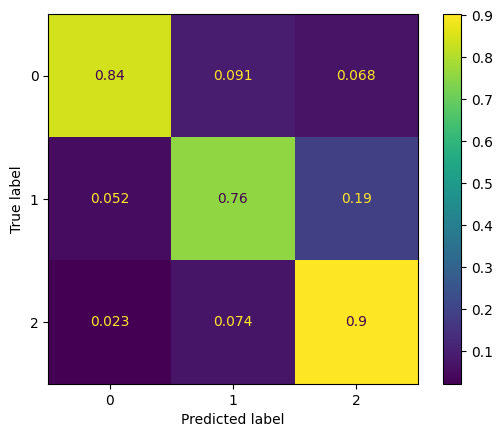

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.57215. Saving Model!
epoch 01, loss: 0.49901, acc: 0.79323, val_loss: 0.57215, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.57215 to 0.56881. Saving Model!
epoch 02, loss: 0.50466, acc: 0.79052, val_loss: 0.56881, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


[INFO] val_acc has been improved from 0.56881 to 0.56775. Saving Model!
epoch 03, loss: 0.49790, acc: 0.79323, val_loss: 0.56775, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 04, loss: 0.49539, acc: 0.79526, val_loss: 0.57279, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 05, loss: 0.49603, acc: 0.79358, val_loss: 0.57707, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 06, loss: 0.49347, acc: 0.79561, val_loss: 0.58223, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 07, loss: 0.49288, acc: 0.79591, val_loss: 0.58577, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 08, loss: 0.49214, acc: 0.79567, val_loss: 0.58755, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 09, loss: 0.49100, acc: 0.79668, val_loss: 0.59047, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 10, loss: 0.49050, acc: 0.79716, val_loss: 0.59185, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 11, loss: 0.48947, acc: 0.79783, val_loss: 0.59445, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 12, loss: 0.48938, acc: 0.79737, val_loss: 0.59577, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 13, loss: 0.48852, acc: 0.79737, val_loss: 0.59775, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 14, loss: 0.48803, acc: 0.79814, val_loss: 0.59928, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 15, loss: 0.48742, acc: 0.79938, val_loss: 0.60068, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 16, loss: 0.48730, acc: 0.79940, val_loss: 0.60196, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 17, loss: 0.48640, acc: 0.80045, val_loss: 0.60410, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 18, loss: 0.48655, acc: 0.80049, val_loss: 0.60452, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 19, loss: 0.48551, acc: 0.80065, val_loss: 0.60599, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 20, loss: 0.48548, acc: 0.80084, val_loss: 0.60726, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 21, loss: 0.48508, acc: 0.80132, val_loss: 0.60809, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 22, loss: 0.48448, acc: 0.80167, val_loss: 0.60994, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 23, loss: 0.48442, acc: 0.80193, val_loss: 0.61092, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 24, loss: 0.48403, acc: 0.80156, val_loss: 0.61180, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 25, loss: 0.48362, acc: 0.80204, val_loss: 0.61323, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 26, loss: 0.48327, acc: 0.80300, val_loss: 0.61449, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 27, loss: 0.48306, acc: 0.80198, val_loss: 0.61529, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 28, loss: 0.48277, acc: 0.80202, val_loss: 0.61606, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 29, loss: 0.48215, acc: 0.80296, val_loss: 0.61798, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 30, loss: 0.48235, acc: 0.80313, val_loss: 0.61797, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 31, loss: 0.48164, acc: 0.80339, val_loss: 0.61921, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 32, loss: 0.48141, acc: 0.80326, val_loss: 0.62048, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 33, loss: 0.48129, acc: 0.80315, val_loss: 0.62106, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 34, loss: 0.48100, acc: 0.80344, val_loss: 0.62181, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 35, loss: 0.48037, acc: 0.80344, val_loss: 0.62310, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 36, loss: 0.48075, acc: 0.80379, val_loss: 0.62374, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 37, loss: 0.47983, acc: 0.80372, val_loss: 0.62462, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 38, loss: 0.47975, acc: 0.80405, val_loss: 0.62613, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 39, loss: 0.47978, acc: 0.80385, val_loss: 0.62625, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 40, loss: 0.47916, acc: 0.80422, val_loss: 0.62768, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 41, loss: 0.47895, acc: 0.80416, val_loss: 0.62792, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 42, loss: 0.47862, acc: 0.80440, val_loss: 0.62967, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 43, loss: 0.47865, acc: 0.80431, val_loss: 0.63002, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 44, loss: 0.47816, acc: 0.80475, val_loss: 0.63069, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 45, loss: 0.47796, acc: 0.80446, val_loss: 0.63167, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 46, loss: 0.47792, acc: 0.80466, val_loss: 0.63157, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 47, loss: 0.47742, acc: 0.80488, val_loss: 0.63266, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 48, loss: 0.47713, acc: 0.80462, val_loss: 0.63345, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 49, loss: 0.47719, acc: 0.80477, val_loss: 0.63419, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 50, loss: 0.47657, acc: 0.80505, val_loss: 0.63478, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 51, loss: 0.47674, acc: 0.80496, val_loss: 0.63470, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 52, loss: 0.47618, acc: 0.80538, val_loss: 0.63538, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 53, loss: 0.47604, acc: 0.80529, val_loss: 0.63719, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 54, loss: 0.47585, acc: 0.80516, val_loss: 0.63694, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 55, loss: 0.47572, acc: 0.80523, val_loss: 0.63769, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 56, loss: 0.47517, acc: 0.80536, val_loss: 0.63922, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 57, loss: 0.47532, acc: 0.80536, val_loss: 0.63864, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 58, loss: 0.47476, acc: 0.80540, val_loss: 0.63973, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 59, loss: 0.47459, acc: 0.80542, val_loss: 0.64056, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 60, loss: 0.47439, acc: 0.80503, val_loss: 0.64099, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 61, loss: 0.47412, acc: 0.80520, val_loss: 0.64189, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 62, loss: 0.47410, acc: 0.80542, val_loss: 0.64165, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 63, loss: 0.47364, acc: 0.80529, val_loss: 0.64288, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 64, loss: 0.47348, acc: 0.80518, val_loss: 0.64338, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 65, loss: 0.47360, acc: 0.80531, val_loss: 0.64313, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 66, loss: 0.47287, acc: 0.80555, val_loss: 0.64436, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 67, loss: 0.47282, acc: 0.80577, val_loss: 0.64531, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 68, loss: 0.47287, acc: 0.80542, val_loss: 0.64454, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 69, loss: 0.47242, acc: 0.80558, val_loss: 0.64565, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 70, loss: 0.47200, acc: 0.80590, val_loss: 0.64628, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 71, loss: 0.47233, acc: 0.80608, val_loss: 0.64614, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 72, loss: 0.47161, acc: 0.80627, val_loss: 0.64680, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 73, loss: 0.47165, acc: 0.80619, val_loss: 0.64780, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 74, loss: 0.47130, acc: 0.80614, val_loss: 0.64823, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 75, loss: 0.47134, acc: 0.80649, val_loss: 0.64870, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 76, loss: 0.47065, acc: 0.80669, val_loss: 0.64881, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 77, loss: 0.47093, acc: 0.80680, val_loss: 0.64863, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 78, loss: 0.47056, acc: 0.80673, val_loss: 0.64903, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 79, loss: 0.47029, acc: 0.80697, val_loss: 0.64998, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 80, loss: 0.47014, acc: 0.80712, val_loss: 0.64998, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 81, loss: 0.46999, acc: 0.80726, val_loss: 0.65022, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 82, loss: 0.46962, acc: 0.80710, val_loss: 0.65090, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 83, loss: 0.46972, acc: 0.80745, val_loss: 0.65091, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 84, loss: 0.46900, acc: 0.80734, val_loss: 0.65161, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 85, loss: 0.46955, acc: 0.80750, val_loss: 0.65138, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 86, loss: 0.46868, acc: 0.80736, val_loss: 0.65236, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 87, loss: 0.46875, acc: 0.80795, val_loss: 0.65255, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 88, loss: 0.46840, acc: 0.80763, val_loss: 0.65256, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 89, loss: 0.46856, acc: 0.80771, val_loss: 0.65301, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 90, loss: 0.46801, acc: 0.80795, val_loss: 0.65356, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 91, loss: 0.46792, acc: 0.80832, val_loss: 0.65407, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 92, loss: 0.46794, acc: 0.80741, val_loss: 0.65399, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 93, loss: 0.46719, acc: 0.80839, val_loss: 0.65575, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 94, loss: 0.46748, acc: 0.80798, val_loss: 0.65450, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 95, loss: 0.46707, acc: 0.80813, val_loss: 0.65568, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 96, loss: 0.46680, acc: 0.80839, val_loss: 0.65589, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 97, loss: 0.46701, acc: 0.80828, val_loss: 0.65608, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 98, loss: 0.46632, acc: 0.80824, val_loss: 0.65699, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 99, loss: 0.46635, acc: 0.80865, val_loss: 0.65782, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 100, loss: 0.46629, acc: 0.80826, val_loss: 0.65730, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 101, loss: 0.46596, acc: 0.80935, val_loss: 0.65786, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 102, loss: 0.46551, acc: 0.80948, val_loss: 0.65901, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 103, loss: 0.46574, acc: 0.80922, val_loss: 0.65940, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 104, loss: 0.46516, acc: 0.80911, val_loss: 0.65969, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 105, loss: 0.46543, acc: 0.80985, val_loss: 0.66001, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 106, loss: 0.46464, acc: 0.80959, val_loss: 0.66032, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 107, loss: 0.46528, acc: 0.80917, val_loss: 0.66071, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 108, loss: 0.46439, acc: 0.80968, val_loss: 0.66137, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 109, loss: 0.46436, acc: 0.81011, val_loss: 0.66217, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 110, loss: 0.46439, acc: 0.80922, val_loss: 0.66164, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 111, loss: 0.46407, acc: 0.81022, val_loss: 0.66209, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 112, loss: 0.46368, acc: 0.81033, val_loss: 0.66246, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 113, loss: 0.46379, acc: 0.81003, val_loss: 0.66368, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 114, loss: 0.46341, acc: 0.81007, val_loss: 0.66335, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 115, loss: 0.46341, acc: 0.81051, val_loss: 0.66383, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 116, loss: 0.46292, acc: 0.81033, val_loss: 0.66427, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 117, loss: 0.46305, acc: 0.81046, val_loss: 0.66399, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 118, loss: 0.46250, acc: 0.81099, val_loss: 0.66566, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 119, loss: 0.46272, acc: 0.81083, val_loss: 0.66562, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 120, loss: 0.46208, acc: 0.81035, val_loss: 0.66555, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 121, loss: 0.46238, acc: 0.81157, val_loss: 0.66624, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 122, loss: 0.46178, acc: 0.81088, val_loss: 0.66691, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 123, loss: 0.46185, acc: 0.81103, val_loss: 0.66663, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 124, loss: 0.46134, acc: 0.81157, val_loss: 0.66751, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 125, loss: 0.46158, acc: 0.81127, val_loss: 0.66809, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 126, loss: 0.46100, acc: 0.81123, val_loss: 0.66856, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 127, loss: 0.46108, acc: 0.81166, val_loss: 0.66794, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 128, loss: 0.46082, acc: 0.81109, val_loss: 0.66870, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 129, loss: 0.46064, acc: 0.81138, val_loss: 0.66940, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 130, loss: 0.46039, acc: 0.81147, val_loss: 0.66983, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 131, loss: 0.46031, acc: 0.81275, val_loss: 0.67040, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 132, loss: 0.45985, acc: 0.81175, val_loss: 0.67066, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 133, loss: 0.46027, acc: 0.81190, val_loss: 0.67072, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 134, loss: 0.45932, acc: 0.81262, val_loss: 0.67135, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 135, loss: 0.45955, acc: 0.81208, val_loss: 0.67171, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 136, loss: 0.45946, acc: 0.81286, val_loss: 0.67135, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 137, loss: 0.45901, acc: 0.81234, val_loss: 0.67278, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 138, loss: 0.45904, acc: 0.81277, val_loss: 0.67221, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 139, loss: 0.45868, acc: 0.81275, val_loss: 0.67287, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 140, loss: 0.45855, acc: 0.81384, val_loss: 0.67233, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 141, loss: 0.45871, acc: 0.81225, val_loss: 0.67329, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 142, loss: 0.45791, acc: 0.81430, val_loss: 0.67418, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 143, loss: 0.45797, acc: 0.81386, val_loss: 0.67466, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 144, loss: 0.45787, acc: 0.81443, val_loss: 0.67389, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 145, loss: 0.45756, acc: 0.81378, val_loss: 0.67523, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 146, loss: 0.45737, acc: 0.81439, val_loss: 0.67479, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 147, loss: 0.45748, acc: 0.81430, val_loss: 0.67522, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 148, loss: 0.45680, acc: 0.81443, val_loss: 0.67513, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 149, loss: 0.45702, acc: 0.81520, val_loss: 0.67595, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 150, loss: 0.45679, acc: 0.81461, val_loss: 0.67535, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 151, loss: 0.45657, acc: 0.81524, val_loss: 0.67626, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 152, loss: 0.45629, acc: 0.81506, val_loss: 0.67613, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 153, loss: 0.45628, acc: 0.81476, val_loss: 0.67683, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 154, loss: 0.45574, acc: 0.81546, val_loss: 0.67727, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 155, loss: 0.45622, acc: 0.81520, val_loss: 0.67727, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 156, loss: 0.45517, acc: 0.81541, val_loss: 0.67802, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 157, loss: 0.45584, acc: 0.81565, val_loss: 0.67821, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 158, loss: 0.45527, acc: 0.81537, val_loss: 0.67770, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 159, loss: 0.45511, acc: 0.81640, val_loss: 0.67865, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 160, loss: 0.45480, acc: 0.81585, val_loss: 0.67922, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 161, loss: 0.45508, acc: 0.81506, val_loss: 0.67932, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 162, loss: 0.45463, acc: 0.81607, val_loss: 0.67873, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 163, loss: 0.45446, acc: 0.81674, val_loss: 0.68040, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 164, loss: 0.45418, acc: 0.81618, val_loss: 0.68023, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 165, loss: 0.45422, acc: 0.81685, val_loss: 0.68022, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 166, loss: 0.45392, acc: 0.81657, val_loss: 0.67998, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 167, loss: 0.45386, acc: 0.81672, val_loss: 0.68176, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 168, loss: 0.45364, acc: 0.81642, val_loss: 0.68063, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 169, loss: 0.45357, acc: 0.81596, val_loss: 0.68154, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 170, loss: 0.45326, acc: 0.81696, val_loss: 0.68155, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 171, loss: 0.45304, acc: 0.81753, val_loss: 0.68342, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 172, loss: 0.45307, acc: 0.81725, val_loss: 0.68146, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 173, loss: 0.45255, acc: 0.81735, val_loss: 0.68255, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 174, loss: 0.45268, acc: 0.81711, val_loss: 0.68277, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 175, loss: 0.45254, acc: 0.81703, val_loss: 0.68309, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 176, loss: 0.45217, acc: 0.81735, val_loss: 0.68387, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 177, loss: 0.45215, acc: 0.81742, val_loss: 0.68298, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 178, loss: 0.45149, acc: 0.81733, val_loss: 0.68490, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 179, loss: 0.45212, acc: 0.81646, val_loss: 0.68326, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 180, loss: 0.45128, acc: 0.81777, val_loss: 0.68447, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 181, loss: 0.45133, acc: 0.81792, val_loss: 0.68507, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 182, loss: 0.45128, acc: 0.81759, val_loss: 0.68469, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 183, loss: 0.45100, acc: 0.81759, val_loss: 0.68563, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 184, loss: 0.45085, acc: 0.81775, val_loss: 0.68668, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 185, loss: 0.45073, acc: 0.81773, val_loss: 0.68498, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 186, loss: 0.45025, acc: 0.81801, val_loss: 0.68726, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 187, loss: 0.45060, acc: 0.81779, val_loss: 0.68627, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 188, loss: 0.44979, acc: 0.81797, val_loss: 0.68613, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 189, loss: 0.45030, acc: 0.81762, val_loss: 0.68683, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 190, loss: 0.44953, acc: 0.81788, val_loss: 0.68782, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 191, loss: 0.44993, acc: 0.81818, val_loss: 0.68808, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 192, loss: 0.44970, acc: 0.81790, val_loss: 0.68825, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 193, loss: 0.44922, acc: 0.81827, val_loss: 0.68800, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 194, loss: 0.44901, acc: 0.81847, val_loss: 0.68901, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 195, loss: 0.44937, acc: 0.81818, val_loss: 0.68832, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 196, loss: 0.44833, acc: 0.81821, val_loss: 0.68899, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 197, loss: 0.44918, acc: 0.81814, val_loss: 0.68873, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 198, loss: 0.44821, acc: 0.81849, val_loss: 0.68999, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 199, loss: 0.44872, acc: 0.81838, val_loss: 0.68889, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 200, loss: 0.44781, acc: 0.81855, val_loss: 0.69152, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 201, loss: 0.44823, acc: 0.81884, val_loss: 0.69068, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 202, loss: 0.44792, acc: 0.81845, val_loss: 0.69087, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 203, loss: 0.44765, acc: 0.81875, val_loss: 0.69091, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 204, loss: 0.44749, acc: 0.81855, val_loss: 0.69170, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 205, loss: 0.44757, acc: 0.81910, val_loss: 0.69058, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 206, loss: 0.44704, acc: 0.81921, val_loss: 0.69189, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 207, loss: 0.44720, acc: 0.81893, val_loss: 0.69146, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 208, loss: 0.44682, acc: 0.81853, val_loss: 0.69197, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 209, loss: 0.44670, acc: 0.81999, val_loss: 0.69242, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 210, loss: 0.44663, acc: 0.81934, val_loss: 0.69255, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 211, loss: 0.44664, acc: 0.81941, val_loss: 0.69156, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 212, loss: 0.44596, acc: 0.81934, val_loss: 0.69373, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 213, loss: 0.44636, acc: 0.81930, val_loss: 0.69192, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 214, loss: 0.44545, acc: 0.81971, val_loss: 0.69351, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 215, loss: 0.44609, acc: 0.81960, val_loss: 0.69344, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 216, loss: 0.44553, acc: 0.81965, val_loss: 0.69376, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 217, loss: 0.44549, acc: 0.82032, val_loss: 0.69328, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 218, loss: 0.44501, acc: 0.81973, val_loss: 0.69479, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 219, loss: 0.44553, acc: 0.81919, val_loss: 0.69322, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 220, loss: 0.44433, acc: 0.82013, val_loss: 0.69501, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 221, loss: 0.44551, acc: 0.81971, val_loss: 0.69364, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 222, loss: 0.44402, acc: 0.82030, val_loss: 0.69463, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 223, loss: 0.44474, acc: 0.82021, val_loss: 0.69527, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 224, loss: 0.44415, acc: 0.82045, val_loss: 0.69594, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 225, loss: 0.44445, acc: 0.82102, val_loss: 0.69413, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 226, loss: 0.44362, acc: 0.82050, val_loss: 0.69666, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 227, loss: 0.44410, acc: 0.82058, val_loss: 0.69500, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 228, loss: 0.44358, acc: 0.82047, val_loss: 0.69568, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 229, loss: 0.44380, acc: 0.82141, val_loss: 0.69771, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 230, loss: 0.44301, acc: 0.82069, val_loss: 0.69547, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 231, loss: 0.44349, acc: 0.82015, val_loss: 0.69713, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 232, loss: 0.44328, acc: 0.82102, val_loss: 0.69706, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 233, loss: 0.44230, acc: 0.82172, val_loss: 0.69773, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 234, loss: 0.44351, acc: 0.82039, val_loss: 0.69764, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 235, loss: 0.44207, acc: 0.82183, val_loss: 0.69831, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 236, loss: 0.44254, acc: 0.82093, val_loss: 0.69805, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 237, loss: 0.44226, acc: 0.82152, val_loss: 0.69746, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 238, loss: 0.44201, acc: 0.82098, val_loss: 0.69956, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 239, loss: 0.44207, acc: 0.82085, val_loss: 0.69776, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 240, loss: 0.44145, acc: 0.82172, val_loss: 0.69961, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 241, loss: 0.44237, acc: 0.82196, val_loss: 0.70072, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 242, loss: 0.44088, acc: 0.82187, val_loss: 0.69828, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 243, loss: 0.44185, acc: 0.82167, val_loss: 0.69968, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 244, loss: 0.44094, acc: 0.82189, val_loss: 0.70107, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 245, loss: 0.44127, acc: 0.82172, val_loss: 0.69958, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 246, loss: 0.44080, acc: 0.82111, val_loss: 0.70073, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 247, loss: 0.44058, acc: 0.82270, val_loss: 0.70058, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 248, loss: 0.44044, acc: 0.82130, val_loss: 0.70168, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 249, loss: 0.44066, acc: 0.82204, val_loss: 0.69974, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 250, loss: 0.43980, acc: 0.82154, val_loss: 0.70311, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 251, loss: 0.44056, acc: 0.82215, val_loss: 0.70112, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 252, loss: 0.43946, acc: 0.82207, val_loss: 0.70278, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 253, loss: 0.44028, acc: 0.82231, val_loss: 0.70200, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 254, loss: 0.43935, acc: 0.82213, val_loss: 0.70201, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 255, loss: 0.43947, acc: 0.82218, val_loss: 0.70240, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 256, loss: 0.43911, acc: 0.82248, val_loss: 0.70201, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 257, loss: 0.43945, acc: 0.82244, val_loss: 0.70337, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 258, loss: 0.43861, acc: 0.82239, val_loss: 0.70299, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 259, loss: 0.43895, acc: 0.82250, val_loss: 0.70244, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 260, loss: 0.43860, acc: 0.82172, val_loss: 0.70347, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 261, loss: 0.43847, acc: 0.82237, val_loss: 0.70422, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 262, loss: 0.43827, acc: 0.82305, val_loss: 0.70430, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 263, loss: 0.43841, acc: 0.82268, val_loss: 0.70436, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 264, loss: 0.43805, acc: 0.82235, val_loss: 0.70425, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 265, loss: 0.43812, acc: 0.82276, val_loss: 0.70546, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 266, loss: 0.43774, acc: 0.82244, val_loss: 0.70514, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 267, loss: 0.43769, acc: 0.82335, val_loss: 0.70646, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 268, loss: 0.43762, acc: 0.82300, val_loss: 0.70430, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 269, loss: 0.43731, acc: 0.82305, val_loss: 0.70575, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 270, loss: 0.43692, acc: 0.82272, val_loss: 0.70568, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 271, loss: 0.43719, acc: 0.82309, val_loss: 0.70571, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 272, loss: 0.43690, acc: 0.82257, val_loss: 0.70536, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 273, loss: 0.43654, acc: 0.82364, val_loss: 0.70761, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 274, loss: 0.43653, acc: 0.82324, val_loss: 0.70658, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 275, loss: 0.43634, acc: 0.82362, val_loss: 0.70722, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 276, loss: 0.43612, acc: 0.82272, val_loss: 0.70623, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 277, loss: 0.43649, acc: 0.82392, val_loss: 0.70765, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 278, loss: 0.43561, acc: 0.82329, val_loss: 0.70645, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 279, loss: 0.43540, acc: 0.82449, val_loss: 0.70793, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 280, loss: 0.43615, acc: 0.82370, val_loss: 0.70927, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 281, loss: 0.43517, acc: 0.82410, val_loss: 0.70684, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 282, loss: 0.43520, acc: 0.82410, val_loss: 0.70880, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 283, loss: 0.43500, acc: 0.82577, val_loss: 0.70890, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 284, loss: 0.43480, acc: 0.82532, val_loss: 0.70801, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 285, loss: 0.43493, acc: 0.82577, val_loss: 0.71075, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 286, loss: 0.43450, acc: 0.82584, val_loss: 0.70835, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 287, loss: 0.43413, acc: 0.82623, val_loss: 0.71039, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 288, loss: 0.43456, acc: 0.82612, val_loss: 0.70822, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 289, loss: 0.43362, acc: 0.82632, val_loss: 0.70982, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 290, loss: 0.43409, acc: 0.82628, val_loss: 0.71045, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 291, loss: 0.43336, acc: 0.82702, val_loss: 0.71042, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 292, loss: 0.43384, acc: 0.82534, val_loss: 0.71076, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 293, loss: 0.43336, acc: 0.82693, val_loss: 0.70935, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 294, loss: 0.43300, acc: 0.82628, val_loss: 0.71144, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 295, loss: 0.43318, acc: 0.82682, val_loss: 0.71115, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 296, loss: 0.43278, acc: 0.82676, val_loss: 0.71158, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 297, loss: 0.43251, acc: 0.82704, val_loss: 0.71225, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 298, loss: 0.43298, acc: 0.82654, val_loss: 0.71195, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 299, loss: 0.43220, acc: 0.82700, val_loss: 0.71181, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 300, loss: 0.43210, acc: 0.82730, val_loss: 0.71252, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 301, loss: 0.43233, acc: 0.82702, val_loss: 0.71246, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 302, loss: 0.43181, acc: 0.82711, val_loss: 0.71265, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 303, loss: 0.43200, acc: 0.82676, val_loss: 0.71310, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 304, loss: 0.43151, acc: 0.82724, val_loss: 0.71391, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 305, loss: 0.43172, acc: 0.82702, val_loss: 0.71209, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 306, loss: 0.43089, acc: 0.82743, val_loss: 0.71329, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 307, loss: 0.43155, acc: 0.82741, val_loss: 0.71276, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 308, loss: 0.43068, acc: 0.82778, val_loss: 0.71405, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 309, loss: 0.43095, acc: 0.82767, val_loss: 0.71338, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 310, loss: 0.43091, acc: 0.82767, val_loss: 0.71401, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 311, loss: 0.43026, acc: 0.82778, val_loss: 0.71349, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 312, loss: 0.43057, acc: 0.82800, val_loss: 0.71470, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 313, loss: 0.43032, acc: 0.82759, val_loss: 0.71259, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 314, loss: 0.42964, acc: 0.82841, val_loss: 0.71537, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 315, loss: 0.43064, acc: 0.82772, val_loss: 0.71570, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 316, loss: 0.42925, acc: 0.82839, val_loss: 0.71408, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 317, loss: 0.42985, acc: 0.82778, val_loss: 0.71561, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 318, loss: 0.42956, acc: 0.82828, val_loss: 0.71431, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 319, loss: 0.42890, acc: 0.82809, val_loss: 0.71593, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 320, loss: 0.42986, acc: 0.82844, val_loss: 0.71712, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 321, loss: 0.42842, acc: 0.82844, val_loss: 0.71524, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 322, loss: 0.42926, acc: 0.82824, val_loss: 0.71660, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 323, loss: 0.42852, acc: 0.82841, val_loss: 0.71548, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 324, loss: 0.42851, acc: 0.82868, val_loss: 0.71659, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 325, loss: 0.42893, acc: 0.82861, val_loss: 0.71746, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 326, loss: 0.42789, acc: 0.82903, val_loss: 0.71618, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 327, loss: 0.42818, acc: 0.82876, val_loss: 0.71888, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 328, loss: 0.42794, acc: 0.82865, val_loss: 0.71749, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 329, loss: 0.42748, acc: 0.82907, val_loss: 0.71810, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 330, loss: 0.42834, acc: 0.82896, val_loss: 0.71831, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 331, loss: 0.42685, acc: 0.82894, val_loss: 0.71667, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 332, loss: 0.42766, acc: 0.82903, val_loss: 0.71869, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 333, loss: 0.42692, acc: 0.82924, val_loss: 0.71811, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 334, loss: 0.42705, acc: 0.82937, val_loss: 0.71867, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 335, loss: 0.42721, acc: 0.82909, val_loss: 0.72092, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 336, loss: 0.42669, acc: 0.82953, val_loss: 0.71823, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 337, loss: 0.42631, acc: 0.82961, val_loss: 0.71924, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 338, loss: 0.42643, acc: 0.82964, val_loss: 0.71886, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 339, loss: 0.42622, acc: 0.82937, val_loss: 0.71857, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 340, loss: 0.42574, acc: 0.82994, val_loss: 0.72130, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 341, loss: 0.42651, acc: 0.82931, val_loss: 0.71909, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 342, loss: 0.42538, acc: 0.82977, val_loss: 0.72075, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 343, loss: 0.42614, acc: 0.82968, val_loss: 0.72200, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 344, loss: 0.42534, acc: 0.82992, val_loss: 0.72044, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 345, loss: 0.42529, acc: 0.83103, val_loss: 0.72161, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 346, loss: 0.42555, acc: 0.83108, val_loss: 0.71997, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 347, loss: 0.42440, acc: 0.83142, val_loss: 0.72269, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 348, loss: 0.42605, acc: 0.83066, val_loss: 0.72150, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 349, loss: 0.42380, acc: 0.83177, val_loss: 0.72181, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 350, loss: 0.42504, acc: 0.83145, val_loss: 0.72258, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 351, loss: 0.42448, acc: 0.83127, val_loss: 0.72167, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 352, loss: 0.42405, acc: 0.83162, val_loss: 0.72278, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 353, loss: 0.42481, acc: 0.83108, val_loss: 0.72441, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 354, loss: 0.42352, acc: 0.83132, val_loss: 0.72296, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 355, loss: 0.42425, acc: 0.83160, val_loss: 0.72339, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 356, loss: 0.42322, acc: 0.83188, val_loss: 0.72411, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 357, loss: 0.42416, acc: 0.83169, val_loss: 0.72395, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 358, loss: 0.42295, acc: 0.83180, val_loss: 0.72508, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 359, loss: 0.42369, acc: 0.83169, val_loss: 0.72568, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 360, loss: 0.42275, acc: 0.83210, val_loss: 0.72503, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 361, loss: 0.42350, acc: 0.83188, val_loss: 0.72429, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 362, loss: 0.42209, acc: 0.83221, val_loss: 0.72609, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 363, loss: 0.42330, acc: 0.83177, val_loss: 0.72531, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 364, loss: 0.42196, acc: 0.83238, val_loss: 0.72714, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 365, loss: 0.42328, acc: 0.83186, val_loss: 0.72579, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 366, loss: 0.42145, acc: 0.83188, val_loss: 0.72644, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 367, loss: 0.42251, acc: 0.83254, val_loss: 0.72624, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 368, loss: 0.42144, acc: 0.83228, val_loss: 0.72642, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 369, loss: 0.42197, acc: 0.83243, val_loss: 0.72635, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 370, loss: 0.42185, acc: 0.83221, val_loss: 0.72856, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 371, loss: 0.42136, acc: 0.83249, val_loss: 0.72734, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 372, loss: 0.42149, acc: 0.83225, val_loss: 0.72791, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 373, loss: 0.42138, acc: 0.83254, val_loss: 0.72770, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 374, loss: 0.42087, acc: 0.83260, val_loss: 0.72937, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 375, loss: 0.42138, acc: 0.83328, val_loss: 0.72756, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 376, loss: 0.42052, acc: 0.83267, val_loss: 0.73123, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 377, loss: 0.42087, acc: 0.83284, val_loss: 0.72809, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 378, loss: 0.42034, acc: 0.83345, val_loss: 0.73047, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 379, loss: 0.42033, acc: 0.83345, val_loss: 0.72952, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 380, loss: 0.42036, acc: 0.83339, val_loss: 0.73025, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 381, loss: 0.42010, acc: 0.83321, val_loss: 0.72862, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 382, loss: 0.41962, acc: 0.83339, val_loss: 0.73213, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 383, loss: 0.42037, acc: 0.83339, val_loss: 0.72931, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 384, loss: 0.41916, acc: 0.83426, val_loss: 0.73144, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 385, loss: 0.42015, acc: 0.83334, val_loss: 0.73247, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 386, loss: 0.41885, acc: 0.83417, val_loss: 0.73026, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 387, loss: 0.41939, acc: 0.83393, val_loss: 0.73241, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 388, loss: 0.41951, acc: 0.83387, val_loss: 0.73121, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 389, loss: 0.41827, acc: 0.83402, val_loss: 0.73251, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 390, loss: 0.41962, acc: 0.83372, val_loss: 0.73267, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 391, loss: 0.41771, acc: 0.83439, val_loss: 0.73278, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 392, loss: 0.41903, acc: 0.83415, val_loss: 0.73356, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 393, loss: 0.41793, acc: 0.83417, val_loss: 0.73360, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 394, loss: 0.41832, acc: 0.83424, val_loss: 0.73274, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 395, loss: 0.41800, acc: 0.83402, val_loss: 0.73334, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 396, loss: 0.41834, acc: 0.83435, val_loss: 0.73490, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 397, loss: 0.41709, acc: 0.83472, val_loss: 0.73440, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 398, loss: 0.41826, acc: 0.83457, val_loss: 0.73403, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 399, loss: 0.41695, acc: 0.83439, val_loss: 0.73391, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 400, loss: 0.41796, acc: 0.83467, val_loss: 0.73474, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 401, loss: 0.41657, acc: 0.83472, val_loss: 0.73585, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 402, loss: 0.41790, acc: 0.83470, val_loss: 0.73421, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 403, loss: 0.41606, acc: 0.83515, val_loss: 0.73607, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 404, loss: 0.41732, acc: 0.83500, val_loss: 0.73673, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 405, loss: 0.41618, acc: 0.83505, val_loss: 0.73682, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 406, loss: 0.41697, acc: 0.83500, val_loss: 0.73570, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 407, loss: 0.41586, acc: 0.83494, val_loss: 0.73705, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 408, loss: 0.41691, acc: 0.83524, val_loss: 0.73757, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 409, loss: 0.41539, acc: 0.83511, val_loss: 0.73678, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 410, loss: 0.41618, acc: 0.83561, val_loss: 0.73752, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 411, loss: 0.41588, acc: 0.83485, val_loss: 0.73858, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 412, loss: 0.41580, acc: 0.83531, val_loss: 0.73741, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 413, loss: 0.41552, acc: 0.83544, val_loss: 0.73961, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 414, loss: 0.41519, acc: 0.83581, val_loss: 0.73855, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 415, loss: 0.41529, acc: 0.83505, val_loss: 0.73892, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 416, loss: 0.41524, acc: 0.83579, val_loss: 0.73953, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 417, loss: 0.41497, acc: 0.83555, val_loss: 0.74128, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 418, loss: 0.41479, acc: 0.83583, val_loss: 0.73978, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 419, loss: 0.41488, acc: 0.83590, val_loss: 0.74159, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 420, loss: 0.41444, acc: 0.83563, val_loss: 0.73999, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 421, loss: 0.41415, acc: 0.83635, val_loss: 0.74071, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 422, loss: 0.41447, acc: 0.83618, val_loss: 0.73987, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 423, loss: 0.41376, acc: 0.83627, val_loss: 0.74408, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 424, loss: 0.41445, acc: 0.83596, val_loss: 0.74163, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 425, loss: 0.41367, acc: 0.83664, val_loss: 0.74338, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 426, loss: 0.41364, acc: 0.83620, val_loss: 0.74195, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 427, loss: 0.41363, acc: 0.83681, val_loss: 0.74423, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 428, loss: 0.41305, acc: 0.83640, val_loss: 0.74425, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 429, loss: 0.41387, acc: 0.83655, val_loss: 0.74332, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 430, loss: 0.41254, acc: 0.83673, val_loss: 0.74341, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 431, loss: 0.41338, acc: 0.83705, val_loss: 0.74464, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 432, loss: 0.41242, acc: 0.83675, val_loss: 0.74412, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 433, loss: 0.41272, acc: 0.83712, val_loss: 0.74445, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 434, loss: 0.41259, acc: 0.83727, val_loss: 0.74619, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 435, loss: 0.41251, acc: 0.83714, val_loss: 0.74518, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 436, loss: 0.41231, acc: 0.83712, val_loss: 0.74893, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 437, loss: 0.41238, acc: 0.83731, val_loss: 0.74382, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 438, loss: 0.41150, acc: 0.83688, val_loss: 0.74887, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 439, loss: 0.41266, acc: 0.83760, val_loss: 0.74572, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 440, loss: 0.41067, acc: 0.83764, val_loss: 0.74848, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 441, loss: 0.41286, acc: 0.83762, val_loss: 0.74648, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 442, loss: 0.41040, acc: 0.83793, val_loss: 0.74669, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 443, loss: 0.41185, acc: 0.83775, val_loss: 0.74748, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 444, loss: 0.41086, acc: 0.83797, val_loss: 0.74723, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 445, loss: 0.41096, acc: 0.83788, val_loss: 0.74809, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 446, loss: 0.41124, acc: 0.83773, val_loss: 0.75201, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 447, loss: 0.41047, acc: 0.83821, val_loss: 0.74737, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 448, loss: 0.41064, acc: 0.83799, val_loss: 0.74934, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 449, loss: 0.41053, acc: 0.83849, val_loss: 0.74931, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 450, loss: 0.40976, acc: 0.83830, val_loss: 0.75010, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 451, loss: 0.41043, acc: 0.83797, val_loss: 0.74901, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 452, loss: 0.40996, acc: 0.83884, val_loss: 0.75039, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 453, loss: 0.40989, acc: 0.83806, val_loss: 0.74892, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 454, loss: 0.40949, acc: 0.83891, val_loss: 0.75186, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 455, loss: 0.41023, acc: 0.83819, val_loss: 0.75278, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 456, loss: 0.40918, acc: 0.83904, val_loss: 0.75052, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 457, loss: 0.40931, acc: 0.83854, val_loss: 0.75311, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 458, loss: 0.40993, acc: 0.83854, val_loss: 0.75100, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 459, loss: 0.40794, acc: 0.83884, val_loss: 0.75443, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 460, loss: 0.41054, acc: 0.83891, val_loss: 0.75202, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 461, loss: 0.40747, acc: 0.83912, val_loss: 0.75224, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 462, loss: 0.40948, acc: 0.83869, val_loss: 0.75199, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 463, loss: 0.40800, acc: 0.83926, val_loss: 0.75387, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 464, loss: 0.40866, acc: 0.83919, val_loss: 0.75211, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 465, loss: 0.40806, acc: 0.83867, val_loss: 0.75468, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 466, loss: 0.40843, acc: 0.84000, val_loss: 0.75282, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 467, loss: 0.40772, acc: 0.83888, val_loss: 0.75493, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 468, loss: 0.40805, acc: 0.84008, val_loss: 0.75296, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 469, loss: 0.40763, acc: 0.83926, val_loss: 0.75654, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 470, loss: 0.40772, acc: 0.84002, val_loss: 0.75384, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 471, loss: 0.40684, acc: 0.83960, val_loss: 0.75617, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 472, loss: 0.40807, acc: 0.83969, val_loss: 0.75524, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 473, loss: 0.40642, acc: 0.84000, val_loss: 0.75569, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 474, loss: 0.40733, acc: 0.83978, val_loss: 0.75678, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 475, loss: 0.40662, acc: 0.83995, val_loss: 0.75661, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 476, loss: 0.40679, acc: 0.83982, val_loss: 0.75713, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 477, loss: 0.40650, acc: 0.83998, val_loss: 0.75779, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 478, loss: 0.40645, acc: 0.84019, val_loss: 0.75717, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 479, loss: 0.40624, acc: 0.84015, val_loss: 0.75838, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 480, loss: 0.40637, acc: 0.84041, val_loss: 0.75733, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 481, loss: 0.40599, acc: 0.83971, val_loss: 0.75919, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 482, loss: 0.40606, acc: 0.84063, val_loss: 0.75615, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 483, loss: 0.40568, acc: 0.84039, val_loss: 0.76021, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 484, loss: 0.40561, acc: 0.84026, val_loss: 0.75823, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 485, loss: 0.40506, acc: 0.84054, val_loss: 0.76080, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 486, loss: 0.40628, acc: 0.84041, val_loss: 0.76052, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 487, loss: 0.40465, acc: 0.84067, val_loss: 0.75866, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 488, loss: 0.40534, acc: 0.84035, val_loss: 0.76172, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 489, loss: 0.40483, acc: 0.84059, val_loss: 0.75961, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 490, loss: 0.40478, acc: 0.84046, val_loss: 0.76215, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 491, loss: 0.40520, acc: 0.84015, val_loss: 0.76264, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 492, loss: 0.40409, acc: 0.84091, val_loss: 0.76018, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 493, loss: 0.40444, acc: 0.84067, val_loss: 0.76339, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 494, loss: 0.40449, acc: 0.84118, val_loss: 0.76056, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 495, loss: 0.40402, acc: 0.84046, val_loss: 0.76372, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 496, loss: 0.40473, acc: 0.84085, val_loss: 0.76469, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 497, loss: 0.40333, acc: 0.84089, val_loss: 0.76194, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 498, loss: 0.40448, acc: 0.84115, val_loss: 0.76135, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 499, loss: 0.40299, acc: 0.84137, val_loss: 0.76503, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 500, loss: 0.40376, acc: 0.84133, val_loss: 0.76280, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 501, loss: 0.40321, acc: 0.84107, val_loss: 0.76589, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 502, loss: 0.40372, acc: 0.84148, val_loss: 0.76457, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 503, loss: 0.40234, acc: 0.84137, val_loss: 0.76622, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 504, loss: 0.40426, acc: 0.84137, val_loss: 0.76509, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 505, loss: 0.40190, acc: 0.84133, val_loss: 0.76446, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 506, loss: 0.40348, acc: 0.84137, val_loss: 0.76482, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 507, loss: 0.40228, acc: 0.84139, val_loss: 0.76675, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 508, loss: 0.40222, acc: 0.84146, val_loss: 0.76560, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 509, loss: 0.40206, acc: 0.84150, val_loss: 0.76724, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 510, loss: 0.40269, acc: 0.84137, val_loss: 0.76652, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 511, loss: 0.40142, acc: 0.84148, val_loss: 0.76719, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 512, loss: 0.40228, acc: 0.84211, val_loss: 0.76771, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 513, loss: 0.40174, acc: 0.84137, val_loss: 0.77012, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 514, loss: 0.40162, acc: 0.84207, val_loss: 0.76762, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 515, loss: 0.40162, acc: 0.84170, val_loss: 0.76891, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 516, loss: 0.40126, acc: 0.84209, val_loss: 0.76875, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 517, loss: 0.40111, acc: 0.84183, val_loss: 0.77000, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 518, loss: 0.40153, acc: 0.84187, val_loss: 0.76793, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 519, loss: 0.40059, acc: 0.84205, val_loss: 0.77179, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 520, loss: 0.40139, acc: 0.84163, val_loss: 0.76859, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 521, loss: 0.40012, acc: 0.84227, val_loss: 0.77134, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 522, loss: 0.40197, acc: 0.84161, val_loss: 0.77156, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 523, loss: 0.39936, acc: 0.84264, val_loss: 0.77018, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 524, loss: 0.40105, acc: 0.84192, val_loss: 0.76891, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 525, loss: 0.39998, acc: 0.84253, val_loss: 0.77176, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 526, loss: 0.39973, acc: 0.84240, val_loss: 0.77027, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 527, loss: 0.39987, acc: 0.84238, val_loss: 0.77225, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 528, loss: 0.39998, acc: 0.84266, val_loss: 0.77236, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 529, loss: 0.39944, acc: 0.84209, val_loss: 0.77277, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 530, loss: 0.39984, acc: 0.84268, val_loss: 0.77546, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 531, loss: 0.39925, acc: 0.84262, val_loss: 0.77252, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 532, loss: 0.39933, acc: 0.84338, val_loss: 0.77414, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 533, loss: 0.39909, acc: 0.84248, val_loss: 0.77210, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 534, loss: 0.39872, acc: 0.84360, val_loss: 0.77416, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 535, loss: 0.39941, acc: 0.84248, val_loss: 0.77732, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 536, loss: 0.39858, acc: 0.84381, val_loss: 0.77236, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 537, loss: 0.39865, acc: 0.84259, val_loss: 0.77475, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 538, loss: 0.39885, acc: 0.84381, val_loss: 0.77400, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 539, loss: 0.39749, acc: 0.84292, val_loss: 0.77549, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 540, loss: 0.39911, acc: 0.84349, val_loss: 0.77385, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 541, loss: 0.39721, acc: 0.84316, val_loss: 0.77861, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 542, loss: 0.39887, acc: 0.84373, val_loss: 0.77557, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 543, loss: 0.39703, acc: 0.84360, val_loss: 0.77458, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 544, loss: 0.39821, acc: 0.84338, val_loss: 0.77577, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 545, loss: 0.39714, acc: 0.84314, val_loss: 0.77660, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 546, loss: 0.39741, acc: 0.84371, val_loss: 0.77436, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 547, loss: 0.39701, acc: 0.84331, val_loss: 0.77798, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 548, loss: 0.39760, acc: 0.84384, val_loss: 0.77792, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 549, loss: 0.39624, acc: 0.84364, val_loss: 0.77751, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 550, loss: 0.39754, acc: 0.84360, val_loss: 0.77586, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 551, loss: 0.39613, acc: 0.84353, val_loss: 0.77940, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 552, loss: 0.39733, acc: 0.84379, val_loss: 0.77951, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 553, loss: 0.39593, acc: 0.84371, val_loss: 0.77608, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 554, loss: 0.39687, acc: 0.84436, val_loss: 0.77826, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 555, loss: 0.39577, acc: 0.84344, val_loss: 0.77796, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 556, loss: 0.39630, acc: 0.84392, val_loss: 0.77877, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 557, loss: 0.39604, acc: 0.84340, val_loss: 0.78107, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 558, loss: 0.39603, acc: 0.84464, val_loss: 0.77963, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 559, loss: 0.39581, acc: 0.84327, val_loss: 0.78274, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 560, loss: 0.39591, acc: 0.84419, val_loss: 0.77621, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 561, loss: 0.39519, acc: 0.84381, val_loss: 0.78159, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 562, loss: 0.39560, acc: 0.84445, val_loss: 0.77868, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 563, loss: 0.39438, acc: 0.84412, val_loss: 0.78111, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 564, loss: 0.39563, acc: 0.84436, val_loss: 0.77846, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 565, loss: 0.39433, acc: 0.84434, val_loss: 0.78267, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 566, loss: 0.39556, acc: 0.84403, val_loss: 0.78273, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 567, loss: 0.39398, acc: 0.84440, val_loss: 0.78018, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 568, loss: 0.39557, acc: 0.84388, val_loss: 0.77991, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 569, loss: 0.39373, acc: 0.84458, val_loss: 0.78223, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 570, loss: 0.39467, acc: 0.84460, val_loss: 0.77882, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 571, loss: 0.39381, acc: 0.84458, val_loss: 0.78265, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 572, loss: 0.39428, acc: 0.84517, val_loss: 0.78313, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 573, loss: 0.39331, acc: 0.84453, val_loss: 0.78167, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 574, loss: 0.39421, acc: 0.84525, val_loss: 0.78196, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 575, loss: 0.39335, acc: 0.84477, val_loss: 0.78211, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 576, loss: 0.39356, acc: 0.84539, val_loss: 0.78451, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 577, loss: 0.39384, acc: 0.84449, val_loss: 0.78610, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 578, loss: 0.39336, acc: 0.84556, val_loss: 0.78021, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 579, loss: 0.39312, acc: 0.84488, val_loss: 0.78409, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 580, loss: 0.39326, acc: 0.84567, val_loss: 0.78135, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 581, loss: 0.39211, acc: 0.84512, val_loss: 0.78455, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 582, loss: 0.39398, acc: 0.84521, val_loss: 0.78491, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 583, loss: 0.39158, acc: 0.84547, val_loss: 0.78525, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 584, loss: 0.39338, acc: 0.84545, val_loss: 0.78484, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 585, loss: 0.39184, acc: 0.84576, val_loss: 0.78335, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 586, loss: 0.39238, acc: 0.84536, val_loss: 0.78540, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 587, loss: 0.39252, acc: 0.84563, val_loss: 0.78954, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 588, loss: 0.39193, acc: 0.84593, val_loss: 0.78330, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 589, loss: 0.39177, acc: 0.84589, val_loss: 0.78617, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 590, loss: 0.39188, acc: 0.84654, val_loss: 0.78438, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 591, loss: 0.39148, acc: 0.84528, val_loss: 0.78499, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 592, loss: 0.39124, acc: 0.84691, val_loss: 0.78699, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 593, loss: 0.39212, acc: 0.84606, val_loss: 0.78761, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 594, loss: 0.39069, acc: 0.84669, val_loss: 0.78703, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 595, loss: 0.39149, acc: 0.84637, val_loss: 0.78819, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 596, loss: 0.39074, acc: 0.84624, val_loss: 0.78734, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 597, loss: 0.39114, acc: 0.84693, val_loss: 0.78700, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 598, loss: 0.39028, acc: 0.84659, val_loss: 0.78993, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 599, loss: 0.39120, acc: 0.84696, val_loss: 0.78659, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 600, loss: 0.38997, acc: 0.84652, val_loss: 0.78746, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 601, loss: 0.39103, acc: 0.84748, val_loss: 0.78779, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 602, loss: 0.38970, acc: 0.84669, val_loss: 0.79002, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 603, loss: 0.39019, acc: 0.84757, val_loss: 0.78808, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 604, loss: 0.39014, acc: 0.84678, val_loss: 0.78870, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 605, loss: 0.38969, acc: 0.84748, val_loss: 0.78828, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 606, loss: 0.38998, acc: 0.84726, val_loss: 0.79016, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


epoch 607, loss: 0.38948, acc: 0.84768, val_loss: 0.78965, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 608, loss: 0.38948, acc: 0.84713, val_loss: 0.79039, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 609, loss: 0.38959, acc: 0.84746, val_loss: 0.78712, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 610, loss: 0.38918, acc: 0.84722, val_loss: 0.79172, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 611, loss: 0.38949, acc: 0.84757, val_loss: 0.78762, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 612, loss: 0.38782, acc: 0.84778, val_loss: 0.79281, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 613, loss: 0.39046, acc: 0.84717, val_loss: 0.78923, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 614, loss: 0.38716, acc: 0.84783, val_loss: 0.79046, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 615, loss: 0.39004, acc: 0.84763, val_loss: 0.78804, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 616, loss: 0.38703, acc: 0.84809, val_loss: 0.79178, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 617, loss: 0.38921, acc: 0.84785, val_loss: 0.78782, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 618, loss: 0.38770, acc: 0.84770, val_loss: 0.79190, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 619, loss: 0.38820, acc: 0.84787, val_loss: 0.78971, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 620, loss: 0.38756, acc: 0.84768, val_loss: 0.79146, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 621, loss: 0.38807, acc: 0.84816, val_loss: 0.79029, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 622, loss: 0.38747, acc: 0.84776, val_loss: 0.79159, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 623, loss: 0.38765, acc: 0.84813, val_loss: 0.78966, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 624, loss: 0.38723, acc: 0.84805, val_loss: 0.79310, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 625, loss: 0.38809, acc: 0.84811, val_loss: 0.79279, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 626, loss: 0.38648, acc: 0.84811, val_loss: 0.79183, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 627, loss: 0.38793, acc: 0.84796, val_loss: 0.79161, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 628, loss: 0.38634, acc: 0.84829, val_loss: 0.79323, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 629, loss: 0.38731, acc: 0.84774, val_loss: 0.79087, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 630, loss: 0.38617, acc: 0.84822, val_loss: 0.79369, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 631, loss: 0.38726, acc: 0.84820, val_loss: 0.79173, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 632, loss: 0.38575, acc: 0.84861, val_loss: 0.79235, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 633, loss: 0.38654, acc: 0.84837, val_loss: 0.79361, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 634, loss: 0.38633, acc: 0.84861, val_loss: 0.79206, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 635, loss: 0.38557, acc: 0.84850, val_loss: 0.79416, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 636, loss: 0.38659, acc: 0.84881, val_loss: 0.79313, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 637, loss: 0.38537, acc: 0.84855, val_loss: 0.79448, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 638, loss: 0.38665, acc: 0.84837, val_loss: 0.79529, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 639, loss: 0.38551, acc: 0.84848, val_loss: 0.79240, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 640, loss: 0.38566, acc: 0.84859, val_loss: 0.79444, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 641, loss: 0.38558, acc: 0.84916, val_loss: 0.79491, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 642, loss: 0.38526, acc: 0.84861, val_loss: 0.79456, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 643, loss: 0.38533, acc: 0.84879, val_loss: 0.79146, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 644, loss: 0.38454, acc: 0.84885, val_loss: 0.79543, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 645, loss: 0.38540, acc: 0.84940, val_loss: 0.79369, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 646, loss: 0.38452, acc: 0.84868, val_loss: 0.79328, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 647, loss: 0.38445, acc: 0.84903, val_loss: 0.79650, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 648, loss: 0.38515, acc: 0.84885, val_loss: 0.79384, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 649, loss: 0.38349, acc: 0.84929, val_loss: 0.79724, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 650, loss: 0.38545, acc: 0.84896, val_loss: 0.79588, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 651, loss: 0.38335, acc: 0.84920, val_loss: 0.79471, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 652, loss: 0.38496, acc: 0.84903, val_loss: 0.79225, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 653, loss: 0.38321, acc: 0.84940, val_loss: 0.79830, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 654, loss: 0.38422, acc: 0.84927, val_loss: 0.79449, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 655, loss: 0.38360, acc: 0.84929, val_loss: 0.79466, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 656, loss: 0.38375, acc: 0.84962, val_loss: 0.79672, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 657, loss: 0.38309, acc: 0.84936, val_loss: 0.79631, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 658, loss: 0.38308, acc: 0.84944, val_loss: 0.79560, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 659, loss: 0.38350, acc: 0.84933, val_loss: 0.79660, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 660, loss: 0.38271, acc: 0.84962, val_loss: 0.79578, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 661, loss: 0.38303, acc: 0.84988, val_loss: 0.79883, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 662, loss: 0.38340, acc: 0.84914, val_loss: 0.79938, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 663, loss: 0.38223, acc: 0.84997, val_loss: 0.79734, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 664, loss: 0.38328, acc: 0.84953, val_loss: 0.79748, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 665, loss: 0.38211, acc: 0.84990, val_loss: 0.79892, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 666, loss: 0.38293, acc: 0.84927, val_loss: 0.79812, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 667, loss: 0.38219, acc: 0.84975, val_loss: 0.79589, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 668, loss: 0.38242, acc: 0.84975, val_loss: 0.79846, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 669, loss: 0.38170, acc: 0.85021, val_loss: 0.80008, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 670, loss: 0.38204, acc: 0.84966, val_loss: 0.79656, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 671, loss: 0.38157, acc: 0.85077, val_loss: 0.79824, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 672, loss: 0.38187, acc: 0.85027, val_loss: 0.79915, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 673, loss: 0.38127, acc: 0.84997, val_loss: 0.79830, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 674, loss: 0.38176, acc: 0.85003, val_loss: 0.79991, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 675, loss: 0.38076, acc: 0.85029, val_loss: 0.80081, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 676, loss: 0.38192, acc: 0.84988, val_loss: 0.80010, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 677, loss: 0.38113, acc: 0.85027, val_loss: 0.79881, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 678, loss: 0.38087, acc: 0.85053, val_loss: 0.79801, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 679, loss: 0.38090, acc: 0.85082, val_loss: 0.80173, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 680, loss: 0.38104, acc: 0.85025, val_loss: 0.79984, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 681, loss: 0.38024, acc: 0.85008, val_loss: 0.79946, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 682, loss: 0.38087, acc: 0.85141, val_loss: 0.80066, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 683, loss: 0.37989, acc: 0.85073, val_loss: 0.80095, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 684, loss: 0.38038, acc: 0.85064, val_loss: 0.79917, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 685, loss: 0.37981, acc: 0.85143, val_loss: 0.80038, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 686, loss: 0.38028, acc: 0.85134, val_loss: 0.80007, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 687, loss: 0.37948, acc: 0.85114, val_loss: 0.80177, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 688, loss: 0.38060, acc: 0.85110, val_loss: 0.79924, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 689, loss: 0.37923, acc: 0.85250, val_loss: 0.80525, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 690, loss: 0.38047, acc: 0.85125, val_loss: 0.80189, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 691, loss: 0.37896, acc: 0.85169, val_loss: 0.80803, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 692, loss: 0.38098, acc: 0.85095, val_loss: 0.79694, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 693, loss: 0.37778, acc: 0.85265, val_loss: 0.80495, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 694, loss: 0.38089, acc: 0.85165, val_loss: 0.80130, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 695, loss: 0.37774, acc: 0.85186, val_loss: 0.80704, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 696, loss: 0.38037, acc: 0.85090, val_loss: 0.79885, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 697, loss: 0.37769, acc: 0.85328, val_loss: 0.80788, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 698, loss: 0.37945, acc: 0.85223, val_loss: 0.80139, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 699, loss: 0.37760, acc: 0.85237, val_loss: 0.80454, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 700, loss: 0.37916, acc: 0.85267, val_loss: 0.80206, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 701, loss: 0.37754, acc: 0.85199, val_loss: 0.80542, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 702, loss: 0.37846, acc: 0.85165, val_loss: 0.80475, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 703, loss: 0.37844, acc: 0.85182, val_loss: 0.80682, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 704, loss: 0.37761, acc: 0.85250, val_loss: 0.80657, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 705, loss: 0.37851, acc: 0.85186, val_loss: 0.80865, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 706, loss: 0.37764, acc: 0.85245, val_loss: 0.80444, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 707, loss: 0.37731, acc: 0.85274, val_loss: 0.80705, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 708, loss: 0.37817, acc: 0.85267, val_loss: 0.80376, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 709, loss: 0.37612, acc: 0.85346, val_loss: 0.80791, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 710, loss: 0.37861, acc: 0.85256, val_loss: 0.80421, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 711, loss: 0.37536, acc: 0.85309, val_loss: 0.80916, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 712, loss: 0.37834, acc: 0.85274, val_loss: 0.80530, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 713, loss: 0.37512, acc: 0.85293, val_loss: 0.81160, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 714, loss: 0.37818, acc: 0.85269, val_loss: 0.80357, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 715, loss: 0.37528, acc: 0.85287, val_loss: 0.80869, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 716, loss: 0.37758, acc: 0.85293, val_loss: 0.80528, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 717, loss: 0.37513, acc: 0.85407, val_loss: 0.81065, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 718, loss: 0.37754, acc: 0.85258, val_loss: 0.80767, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 719, loss: 0.37514, acc: 0.85309, val_loss: 0.80849, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 720, loss: 0.37667, acc: 0.85311, val_loss: 0.80794, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 721, loss: 0.37537, acc: 0.85352, val_loss: 0.80712, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 722, loss: 0.37579, acc: 0.85324, val_loss: 0.80759, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 723, loss: 0.37566, acc: 0.85361, val_loss: 0.80819, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 724, loss: 0.37516, acc: 0.85418, val_loss: 0.80791, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 725, loss: 0.37580, acc: 0.85350, val_loss: 0.80752, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 726, loss: 0.37515, acc: 0.85381, val_loss: 0.81041, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 727, loss: 0.37561, acc: 0.85354, val_loss: 0.80676, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 728, loss: 0.37478, acc: 0.85409, val_loss: 0.81144, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 729, loss: 0.37592, acc: 0.85350, val_loss: 0.80777, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 730, loss: 0.37437, acc: 0.85396, val_loss: 0.81310, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 731, loss: 0.37619, acc: 0.85357, val_loss: 0.80416, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 732, loss: 0.37342, acc: 0.85492, val_loss: 0.81255, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 733, loss: 0.37623, acc: 0.85396, val_loss: 0.80804, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 734, loss: 0.37281, acc: 0.85420, val_loss: 0.81266, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 735, loss: 0.37628, acc: 0.85335, val_loss: 0.80376, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 736, loss: 0.37278, acc: 0.85468, val_loss: 0.81383, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 737, loss: 0.37555, acc: 0.85367, val_loss: 0.80645, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 738, loss: 0.37242, acc: 0.85461, val_loss: 0.81284, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 739, loss: 0.37532, acc: 0.85376, val_loss: 0.80811, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 740, loss: 0.37340, acc: 0.85424, val_loss: 0.81438, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 741, loss: 0.37407, acc: 0.85431, val_loss: 0.80734, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 742, loss: 0.37324, acc: 0.85474, val_loss: 0.81257, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 743, loss: 0.37386, acc: 0.85444, val_loss: 0.80954, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 744, loss: 0.37308, acc: 0.85415, val_loss: 0.81204, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 745, loss: 0.37346, acc: 0.85402, val_loss: 0.80901, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 746, loss: 0.37289, acc: 0.85477, val_loss: 0.81173, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 747, loss: 0.37301, acc: 0.85437, val_loss: 0.81180, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 748, loss: 0.37245, acc: 0.85389, val_loss: 0.81165, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 749, loss: 0.37284, acc: 0.85492, val_loss: 0.81228, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 750, loss: 0.37277, acc: 0.85481, val_loss: 0.81111, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 751, loss: 0.37217, acc: 0.85494, val_loss: 0.81403, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 752, loss: 0.37298, acc: 0.85405, val_loss: 0.81475, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 753, loss: 0.37212, acc: 0.85485, val_loss: 0.81215, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 754, loss: 0.37224, acc: 0.85496, val_loss: 0.81376, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 755, loss: 0.37185, acc: 0.85463, val_loss: 0.81325, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 756, loss: 0.37201, acc: 0.85477, val_loss: 0.81386, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 757, loss: 0.37195, acc: 0.85485, val_loss: 0.81204, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 758, loss: 0.37214, acc: 0.85501, val_loss: 0.81376, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 759, loss: 0.37129, acc: 0.85485, val_loss: 0.81545, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 760, loss: 0.37177, acc: 0.85525, val_loss: 0.81738, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 761, loss: 0.37228, acc: 0.85429, val_loss: 0.81057, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 762, loss: 0.37062, acc: 0.85623, val_loss: 0.81460, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 763, loss: 0.37190, acc: 0.85485, val_loss: 0.81341, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 764, loss: 0.37016, acc: 0.85546, val_loss: 0.81529, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 765, loss: 0.37213, acc: 0.85481, val_loss: 0.81133, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 766, loss: 0.36986, acc: 0.85596, val_loss: 0.81870, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 767, loss: 0.37207, acc: 0.85507, val_loss: 0.81372, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 768, loss: 0.36999, acc: 0.85590, val_loss: 0.81713, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 769, loss: 0.37143, acc: 0.85494, val_loss: 0.81063, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 770, loss: 0.36966, acc: 0.85664, val_loss: 0.81963, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 771, loss: 0.37139, acc: 0.85494, val_loss: 0.81543, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 772, loss: 0.36959, acc: 0.85555, val_loss: 0.82006, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 773, loss: 0.37147, acc: 0.85479, val_loss: 0.81000, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 774, loss: 0.36853, acc: 0.85710, val_loss: 0.82069, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 775, loss: 0.37143, acc: 0.85527, val_loss: 0.81400, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 776, loss: 0.36814, acc: 0.85666, val_loss: 0.81934, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 777, loss: 0.37143, acc: 0.85514, val_loss: 0.81327, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 778, loss: 0.36763, acc: 0.85668, val_loss: 0.82172, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 779, loss: 0.37135, acc: 0.85385, val_loss: 0.81229, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 780, loss: 0.36779, acc: 0.85677, val_loss: 0.81965, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 781, loss: 0.37049, acc: 0.85605, val_loss: 0.81527, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 782, loss: 0.36771, acc: 0.85651, val_loss: 0.82347, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 783, loss: 0.37062, acc: 0.85596, val_loss: 0.81533, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 784, loss: 0.36732, acc: 0.85697, val_loss: 0.82186, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 785, loss: 0.37073, acc: 0.85588, val_loss: 0.81574, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 786, loss: 0.36673, acc: 0.85660, val_loss: 0.82450, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 787, loss: 0.37087, acc: 0.85439, val_loss: 0.81881, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 788, loss: 0.36670, acc: 0.85649, val_loss: 0.82033, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 789, loss: 0.36992, acc: 0.85607, val_loss: 0.81954, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 790, loss: 0.36725, acc: 0.85668, val_loss: 0.82337, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 791, loss: 0.36909, acc: 0.85487, val_loss: 0.81950, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 792, loss: 0.36737, acc: 0.85677, val_loss: 0.82490, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 793, loss: 0.36882, acc: 0.85507, val_loss: 0.82049, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 794, loss: 0.36789, acc: 0.85684, val_loss: 0.82823, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 795, loss: 0.36866, acc: 0.85660, val_loss: 0.81718, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 796, loss: 0.36721, acc: 0.85703, val_loss: 0.82316, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 797, loss: 0.36795, acc: 0.85640, val_loss: 0.82195, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 798, loss: 0.36723, acc: 0.85601, val_loss: 0.82383, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 799, loss: 0.36784, acc: 0.85701, val_loss: 0.81913, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 800, loss: 0.36680, acc: 0.85740, val_loss: 0.82431, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 801, loss: 0.36713, acc: 0.85668, val_loss: 0.82192, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 802, loss: 0.36732, acc: 0.85668, val_loss: 0.82598, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 803, loss: 0.36683, acc: 0.85706, val_loss: 0.82040, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 804, loss: 0.36639, acc: 0.85725, val_loss: 0.82477, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 805, loss: 0.36698, acc: 0.85673, val_loss: 0.82258, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 806, loss: 0.36562, acc: 0.85732, val_loss: 0.82466, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 807, loss: 0.36709, acc: 0.85716, val_loss: 0.82278, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 808, loss: 0.36559, acc: 0.85773, val_loss: 0.82594, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 809, loss: 0.36701, acc: 0.85679, val_loss: 0.82558, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 810, loss: 0.36536, acc: 0.85712, val_loss: 0.82486, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 811, loss: 0.36637, acc: 0.85780, val_loss: 0.82398, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 812, loss: 0.36557, acc: 0.85701, val_loss: 0.82300, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 813, loss: 0.36555, acc: 0.85758, val_loss: 0.82576, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 814, loss: 0.36570, acc: 0.85808, val_loss: 0.82573, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 815, loss: 0.36551, acc: 0.85819, val_loss: 0.82512, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 816, loss: 0.36550, acc: 0.85773, val_loss: 0.82655, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 817, loss: 0.36592, acc: 0.85786, val_loss: 0.82935, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 818, loss: 0.36499, acc: 0.85797, val_loss: 0.82509, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 819, loss: 0.36582, acc: 0.85764, val_loss: 0.82670, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 820, loss: 0.36434, acc: 0.85793, val_loss: 0.82685, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 821, loss: 0.36568, acc: 0.85802, val_loss: 0.82519, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 822, loss: 0.36360, acc: 0.85839, val_loss: 0.83005, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 823, loss: 0.36581, acc: 0.85723, val_loss: 0.82683, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 824, loss: 0.36358, acc: 0.85791, val_loss: 0.82974, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 825, loss: 0.36542, acc: 0.85819, val_loss: 0.82597, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 826, loss: 0.36310, acc: 0.85815, val_loss: 0.83030, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 827, loss: 0.36555, acc: 0.85740, val_loss: 0.82604, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 828, loss: 0.36285, acc: 0.85865, val_loss: 0.83317, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 829, loss: 0.36522, acc: 0.85806, val_loss: 0.82966, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 830, loss: 0.36284, acc: 0.85826, val_loss: 0.82824, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 831, loss: 0.36477, acc: 0.85860, val_loss: 0.82647, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 832, loss: 0.36256, acc: 0.85860, val_loss: 0.82976, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 833, loss: 0.36412, acc: 0.85780, val_loss: 0.82730, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 834, loss: 0.36270, acc: 0.85911, val_loss: 0.83023, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 835, loss: 0.36356, acc: 0.85847, val_loss: 0.82812, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 836, loss: 0.36344, acc: 0.85795, val_loss: 0.82875, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 837, loss: 0.36314, acc: 0.85858, val_loss: 0.82848, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 838, loss: 0.36296, acc: 0.85826, val_loss: 0.83316, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 839, loss: 0.36332, acc: 0.85878, val_loss: 0.82970, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 840, loss: 0.36287, acc: 0.85917, val_loss: 0.83453, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 841, loss: 0.36333, acc: 0.85780, val_loss: 0.82807, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 842, loss: 0.36235, acc: 0.85889, val_loss: 0.83246, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 843, loss: 0.36315, acc: 0.85878, val_loss: 0.82923, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 844, loss: 0.36117, acc: 0.85926, val_loss: 0.83440, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 845, loss: 0.36384, acc: 0.85762, val_loss: 0.82988, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 846, loss: 0.36079, acc: 0.85952, val_loss: 0.83596, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 847, loss: 0.36306, acc: 0.85843, val_loss: 0.82988, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 848, loss: 0.36114, acc: 0.85959, val_loss: 0.83341, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 849, loss: 0.36264, acc: 0.85856, val_loss: 0.83133, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 850, loss: 0.36086, acc: 0.85954, val_loss: 0.83565, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 851, loss: 0.36286, acc: 0.85850, val_loss: 0.83427, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 852, loss: 0.36077, acc: 0.85961, val_loss: 0.83433, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 853, loss: 0.36208, acc: 0.85852, val_loss: 0.83621, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 854, loss: 0.36121, acc: 0.85948, val_loss: 0.83380, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 855, loss: 0.36119, acc: 0.85950, val_loss: 0.83723, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 856, loss: 0.36126, acc: 0.85974, val_loss: 0.83621, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 857, loss: 0.36117, acc: 0.85906, val_loss: 0.83671, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 858, loss: 0.36116, acc: 0.85974, val_loss: 0.83441, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 859, loss: 0.36159, acc: 0.85939, val_loss: 0.83746, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 860, loss: 0.36048, acc: 0.85996, val_loss: 0.83529, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 861, loss: 0.36155, acc: 0.85913, val_loss: 0.84021, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 862, loss: 0.36092, acc: 0.85943, val_loss: 0.83383, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 863, loss: 0.36027, acc: 0.85959, val_loss: 0.83855, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 864, loss: 0.36112, acc: 0.86022, val_loss: 0.83717, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 865, loss: 0.35953, acc: 0.85987, val_loss: 0.83778, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 866, loss: 0.36067, acc: 0.85980, val_loss: 0.83764, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 867, loss: 0.35977, acc: 0.85967, val_loss: 0.83902, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 868, loss: 0.36027, acc: 0.85963, val_loss: 0.83893, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 869, loss: 0.36049, acc: 0.85898, val_loss: 0.84313, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 870, loss: 0.35955, acc: 0.86015, val_loss: 0.83490, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 871, loss: 0.35963, acc: 0.86007, val_loss: 0.84032, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 872, loss: 0.35999, acc: 0.86017, val_loss: 0.83609, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 873, loss: 0.35894, acc: 0.85928, val_loss: 0.83903, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 874, loss: 0.36029, acc: 0.85967, val_loss: 0.83779, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 875, loss: 0.35814, acc: 0.85959, val_loss: 0.84161, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 876, loss: 0.36041, acc: 0.85915, val_loss: 0.84038, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 877, loss: 0.35861, acc: 0.85963, val_loss: 0.83925, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 878, loss: 0.35906, acc: 0.85941, val_loss: 0.83984, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 879, loss: 0.35903, acc: 0.85983, val_loss: 0.83794, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 880, loss: 0.35775, acc: 0.86039, val_loss: 0.84074, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 881, loss: 0.35938, acc: 0.85943, val_loss: 0.83871, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 882, loss: 0.35804, acc: 0.85993, val_loss: 0.84323, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 883, loss: 0.35902, acc: 0.85987, val_loss: 0.84083, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 884, loss: 0.35775, acc: 0.86013, val_loss: 0.83956, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 885, loss: 0.35892, acc: 0.85991, val_loss: 0.83853, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 886, loss: 0.35727, acc: 0.86070, val_loss: 0.84124, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 887, loss: 0.35845, acc: 0.85954, val_loss: 0.84161, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 888, loss: 0.35772, acc: 0.86061, val_loss: 0.84136, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 889, loss: 0.35812, acc: 0.86007, val_loss: 0.84618, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 890, loss: 0.35778, acc: 0.86063, val_loss: 0.84046, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 891, loss: 0.35731, acc: 0.86076, val_loss: 0.84293, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 892, loss: 0.35791, acc: 0.86070, val_loss: 0.84078, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 893, loss: 0.35718, acc: 0.85993, val_loss: 0.84498, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 894, loss: 0.35855, acc: 0.86081, val_loss: 0.83960, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 895, loss: 0.35637, acc: 0.86059, val_loss: 0.84486, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 896, loss: 0.35879, acc: 0.85941, val_loss: 0.84024, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 897, loss: 0.35682, acc: 0.86011, val_loss: 0.85310, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 898, loss: 0.35905, acc: 0.85880, val_loss: 0.83848, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 899, loss: 0.35513, acc: 0.86081, val_loss: 0.84904, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 900, loss: 0.35937, acc: 0.85889, val_loss: 0.83645, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 901, loss: 0.35463, acc: 0.86037, val_loss: 0.84773, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 902, loss: 0.35929, acc: 0.85902, val_loss: 0.83813, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 903, loss: 0.35496, acc: 0.86050, val_loss: 0.85220, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 904, loss: 0.35832, acc: 0.85978, val_loss: 0.83990, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 905, loss: 0.35517, acc: 0.86087, val_loss: 0.85033, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 906, loss: 0.35758, acc: 0.85976, val_loss: 0.84139, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 907, loss: 0.35516, acc: 0.86004, val_loss: 0.85360, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 908, loss: 0.35790, acc: 0.85922, val_loss: 0.84276, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 909, loss: 0.35445, acc: 0.86098, val_loss: 0.85193, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 910, loss: 0.35766, acc: 0.86026, val_loss: 0.84296, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 911, loss: 0.35400, acc: 0.86048, val_loss: 0.85240, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 912, loss: 0.35747, acc: 0.86028, val_loss: 0.84732, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 913, loss: 0.35452, acc: 0.86113, val_loss: 0.85691, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 914, loss: 0.35718, acc: 0.85952, val_loss: 0.84078, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 915, loss: 0.35367, acc: 0.86146, val_loss: 0.85483, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 916, loss: 0.35727, acc: 0.86000, val_loss: 0.84300, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 917, loss: 0.35312, acc: 0.86151, val_loss: 0.85384, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 918, loss: 0.35757, acc: 0.85959, val_loss: 0.84358, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 919, loss: 0.35222, acc: 0.86157, val_loss: 0.85726, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 920, loss: 0.35761, acc: 0.85996, val_loss: 0.84460, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 921, loss: 0.35252, acc: 0.86120, val_loss: 0.85608, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 922, loss: 0.35682, acc: 0.85983, val_loss: 0.84766, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 923, loss: 0.35219, acc: 0.86124, val_loss: 0.85909, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 924, loss: 0.35674, acc: 0.86079, val_loss: 0.84705, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 925, loss: 0.35245, acc: 0.86133, val_loss: 0.85896, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 926, loss: 0.35638, acc: 0.85998, val_loss: 0.84860, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 927, loss: 0.35250, acc: 0.86140, val_loss: 0.85989, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 928, loss: 0.35584, acc: 0.86079, val_loss: 0.85033, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 929, loss: 0.35215, acc: 0.86144, val_loss: 0.85942, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 930, loss: 0.35546, acc: 0.86087, val_loss: 0.85034, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 931, loss: 0.35209, acc: 0.86166, val_loss: 0.86119, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 932, loss: 0.35533, acc: 0.86020, val_loss: 0.85169, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 933, loss: 0.35208, acc: 0.86168, val_loss: 0.85846, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 934, loss: 0.35475, acc: 0.86094, val_loss: 0.85396, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 935, loss: 0.35188, acc: 0.86155, val_loss: 0.86162, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 936, loss: 0.35398, acc: 0.86207, val_loss: 0.85385, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 937, loss: 0.35217, acc: 0.86181, val_loss: 0.86012, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 938, loss: 0.35385, acc: 0.86175, val_loss: 0.85507, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 939, loss: 0.35190, acc: 0.86159, val_loss: 0.86176, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 940, loss: 0.35407, acc: 0.86159, val_loss: 0.85958, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 941, loss: 0.35166, acc: 0.86231, val_loss: 0.86102, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 942, loss: 0.35352, acc: 0.86170, val_loss: 0.85976, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 943, loss: 0.35153, acc: 0.86220, val_loss: 0.86105, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 944, loss: 0.35358, acc: 0.86177, val_loss: 0.86244, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 945, loss: 0.35157, acc: 0.86179, val_loss: 0.86360, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 946, loss: 0.35304, acc: 0.86183, val_loss: 0.85855, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 947, loss: 0.35136, acc: 0.86251, val_loss: 0.86359, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 948, loss: 0.35249, acc: 0.86236, val_loss: 0.85979, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 949, loss: 0.35133, acc: 0.86238, val_loss: 0.86572, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 950, loss: 0.35221, acc: 0.86279, val_loss: 0.86084, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 951, loss: 0.35104, acc: 0.86227, val_loss: 0.86521, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 952, loss: 0.35224, acc: 0.86129, val_loss: 0.86133, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 953, loss: 0.35064, acc: 0.86244, val_loss: 0.86824, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 954, loss: 0.35216, acc: 0.86179, val_loss: 0.85878, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 955, loss: 0.35068, acc: 0.86273, val_loss: 0.86574, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 956, loss: 0.35288, acc: 0.86103, val_loss: 0.85658, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 957, loss: 0.34983, acc: 0.86290, val_loss: 0.86837, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 958, loss: 0.35304, acc: 0.86111, val_loss: 0.86256, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 959, loss: 0.34985, acc: 0.86262, val_loss: 0.86648, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 960, loss: 0.35208, acc: 0.86203, val_loss: 0.86057, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 961, loss: 0.34993, acc: 0.86273, val_loss: 0.86823, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 962, loss: 0.35191, acc: 0.86155, val_loss: 0.86250, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 963, loss: 0.34950, acc: 0.86319, val_loss: 0.86925, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 964, loss: 0.35146, acc: 0.86343, val_loss: 0.86486, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 965, loss: 0.34962, acc: 0.86303, val_loss: 0.86752, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 966, loss: 0.35080, acc: 0.86266, val_loss: 0.86250, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 967, loss: 0.34985, acc: 0.86329, val_loss: 0.86676, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 968, loss: 0.35020, acc: 0.86310, val_loss: 0.86580, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 969, loss: 0.35005, acc: 0.86247, val_loss: 0.86628, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 970, loss: 0.34988, acc: 0.86421, val_loss: 0.86521, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 971, loss: 0.35008, acc: 0.86301, val_loss: 0.86866, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 972, loss: 0.34967, acc: 0.86421, val_loss: 0.86773, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 973, loss: 0.35057, acc: 0.86242, val_loss: 0.87355, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 974, loss: 0.34992, acc: 0.86297, val_loss: 0.86369, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 975, loss: 0.34906, acc: 0.86353, val_loss: 0.87041, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 976, loss: 0.35043, acc: 0.86288, val_loss: 0.86637, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 977, loss: 0.34820, acc: 0.86305, val_loss: 0.87122, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 978, loss: 0.35018, acc: 0.86268, val_loss: 0.86684, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 979, loss: 0.34863, acc: 0.86340, val_loss: 0.87093, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 980, loss: 0.34958, acc: 0.86284, val_loss: 0.86911, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 981, loss: 0.34872, acc: 0.86314, val_loss: 0.86828, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 982, loss: 0.34936, acc: 0.86340, val_loss: 0.86015, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 983, loss: 0.34864, acc: 0.86360, val_loss: 0.86797, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 984, loss: 0.34928, acc: 0.86336, val_loss: 0.86440, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 985, loss: 0.34897, acc: 0.86308, val_loss: 0.87281, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 986, loss: 0.34934, acc: 0.86286, val_loss: 0.86123, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 987, loss: 0.34792, acc: 0.86316, val_loss: 0.86593, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 988, loss: 0.34976, acc: 0.86334, val_loss: 0.86044, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 989, loss: 0.34743, acc: 0.86345, val_loss: 0.86908, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 990, loss: 0.34917, acc: 0.86353, val_loss: 0.86362, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 991, loss: 0.34784, acc: 0.86325, val_loss: 0.87538, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 992, loss: 0.34885, acc: 0.86349, val_loss: 0.86202, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 993, loss: 0.34739, acc: 0.86412, val_loss: 0.87281, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 994, loss: 0.34881, acc: 0.86334, val_loss: 0.86540, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 995, loss: 0.34649, acc: 0.86397, val_loss: 0.87387, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 996, loss: 0.34871, acc: 0.86467, val_loss: 0.86702, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 997, loss: 0.34649, acc: 0.86425, val_loss: 0.86911, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 998, loss: 0.34769, acc: 0.86343, val_loss: 0.86908, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 999, loss: 0.34673, acc: 0.86441, val_loss: 0.87377, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 1000, loss: 0.34753, acc: 0.86478, val_loss: 0.86969, val_accuracy: 0.74499
4번째 교차검증
evaluation loss: 0.53113, evaluation accuracy: 0.78838
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[4]Accuracy : 0.8048684727129957
[4]F1score : 0.8042781482638433
[4]Precision : 0.8112773517674399
[4]Recall : 0.8048684727129957



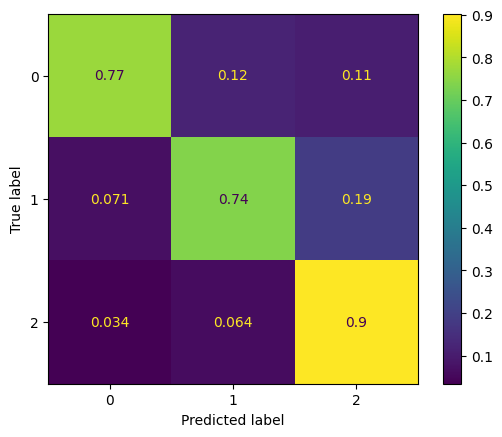

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.41762. Saving Model!
epoch 01, loss: 0.51576, acc: 0.78387, val_loss: 0.41762, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 02, loss: 0.51331, acc: 0.78647, val_loss: 0.42124, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 03, loss: 0.51741, acc: 0.78324, val_loss: 0.42312, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 04, loss: 0.50680, acc: 0.78808, val_loss: 0.42537, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 05, loss: 0.51530, acc: 0.78405, val_loss: 0.42543, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 06, loss: 0.50479, acc: 0.78932, val_loss: 0.42709, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 07, loss: 0.50959, acc: 0.78690, val_loss: 0.42789, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 08, loss: 0.50663, acc: 0.78956, val_loss: 0.42913, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 09, loss: 0.50596, acc: 0.79009, val_loss: 0.43024, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 10, loss: 0.50629, acc: 0.79035, val_loss: 0.43057, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 11, loss: 0.50495, acc: 0.79022, val_loss: 0.43123, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 12, loss: 0.50442, acc: 0.79103, val_loss: 0.43205, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 13, loss: 0.50449, acc: 0.79146, val_loss: 0.43250, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 14, loss: 0.50287, acc: 0.79227, val_loss: 0.43323, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 15, loss: 0.50393, acc: 0.79151, val_loss: 0.43357, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 16, loss: 0.50162, acc: 0.79238, val_loss: 0.43415, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 17, loss: 0.50317, acc: 0.79161, val_loss: 0.43452, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 18, loss: 0.50091, acc: 0.79172, val_loss: 0.43522, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 19, loss: 0.50250, acc: 0.79168, val_loss: 0.43573, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 20, loss: 0.49991, acc: 0.79223, val_loss: 0.43647, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 21, loss: 0.50180, acc: 0.79111, val_loss: 0.43678, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 22, loss: 0.49912, acc: 0.79391, val_loss: 0.43754, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 23, loss: 0.50141, acc: 0.79266, val_loss: 0.43758, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 24, loss: 0.49818, acc: 0.79314, val_loss: 0.43843, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 25, loss: 0.50019, acc: 0.79249, val_loss: 0.43853, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 26, loss: 0.49773, acc: 0.79332, val_loss: 0.43955, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


epoch 27, loss: 0.49951, acc: 0.79244, val_loss: 0.43946, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 28, loss: 0.49736, acc: 0.79327, val_loss: 0.44016, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 29, loss: 0.49833, acc: 0.79432, val_loss: 0.44048, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 30, loss: 0.49692, acc: 0.79412, val_loss: 0.44122, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 31, loss: 0.49736, acc: 0.79410, val_loss: 0.44126, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 32, loss: 0.49663, acc: 0.79338, val_loss: 0.44178, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 33, loss: 0.49658, acc: 0.79469, val_loss: 0.44219, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 34, loss: 0.49612, acc: 0.79458, val_loss: 0.44261, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 35, loss: 0.49584, acc: 0.79541, val_loss: 0.44319, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


epoch 36, loss: 0.49576, acc: 0.79443, val_loss: 0.44340, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 37, loss: 0.49516, acc: 0.79473, val_loss: 0.44375, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 38, loss: 0.49522, acc: 0.79469, val_loss: 0.44407, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 39, loss: 0.49471, acc: 0.79545, val_loss: 0.44460, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 40, loss: 0.49462, acc: 0.79495, val_loss: 0.44489, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 41, loss: 0.49428, acc: 0.79589, val_loss: 0.44523, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 42, loss: 0.49386, acc: 0.79615, val_loss: 0.44550, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 43, loss: 0.49378, acc: 0.79524, val_loss: 0.44580, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 44, loss: 0.49350, acc: 0.79639, val_loss: 0.44621, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 45, loss: 0.49322, acc: 0.79572, val_loss: 0.44639, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 46, loss: 0.49338, acc: 0.79630, val_loss: 0.44663, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 47, loss: 0.49259, acc: 0.79561, val_loss: 0.44684, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 48, loss: 0.49276, acc: 0.79563, val_loss: 0.44748, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 49, loss: 0.49196, acc: 0.79720, val_loss: 0.44760, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 50, loss: 0.49264, acc: 0.79650, val_loss: 0.44788, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 51, loss: 0.49103, acc: 0.79641, val_loss: 0.44788, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 52, loss: 0.49244, acc: 0.79641, val_loss: 0.44822, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 53, loss: 0.49019, acc: 0.79803, val_loss: 0.44869, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 54, loss: 0.49172, acc: 0.79750, val_loss: 0.44880, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 55, loss: 0.48980, acc: 0.79788, val_loss: 0.44928, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 56, loss: 0.49143, acc: 0.79648, val_loss: 0.44918, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 57, loss: 0.48940, acc: 0.79842, val_loss: 0.44975, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 58, loss: 0.49045, acc: 0.79764, val_loss: 0.45012, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 59, loss: 0.48945, acc: 0.79812, val_loss: 0.45024, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 60, loss: 0.48966, acc: 0.79899, val_loss: 0.45033, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 61, loss: 0.48906, acc: 0.80014, val_loss: 0.45071, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 62, loss: 0.48936, acc: 0.79934, val_loss: 0.45100, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 63, loss: 0.48863, acc: 0.79971, val_loss: 0.45123, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 64, loss: 0.48906, acc: 0.79894, val_loss: 0.45163, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 65, loss: 0.48781, acc: 0.80047, val_loss: 0.45176, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 66, loss: 0.48874, acc: 0.80093, val_loss: 0.45196, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 67, loss: 0.48714, acc: 0.80093, val_loss: 0.45260, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 68, loss: 0.48836, acc: 0.79960, val_loss: 0.45264, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 69, loss: 0.48676, acc: 0.80115, val_loss: 0.45266, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 70, loss: 0.48755, acc: 0.80078, val_loss: 0.45288, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 71, loss: 0.48645, acc: 0.80185, val_loss: 0.45355, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 72, loss: 0.48714, acc: 0.80041, val_loss: 0.45340, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 73, loss: 0.48615, acc: 0.80126, val_loss: 0.45362, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 74, loss: 0.48651, acc: 0.80163, val_loss: 0.45421, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 75, loss: 0.48599, acc: 0.80089, val_loss: 0.45393, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 76, loss: 0.48561, acc: 0.80224, val_loss: 0.45422, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 77, loss: 0.48575, acc: 0.80204, val_loss: 0.45459, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 78, loss: 0.48557, acc: 0.80169, val_loss: 0.45512, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 79, loss: 0.48488, acc: 0.80246, val_loss: 0.45498, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 80, loss: 0.48563, acc: 0.80145, val_loss: 0.45490, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 81, loss: 0.48443, acc: 0.80246, val_loss: 0.45545, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 82, loss: 0.48520, acc: 0.80263, val_loss: 0.45566, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 83, loss: 0.48373, acc: 0.80298, val_loss: 0.45595, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 84, loss: 0.48469, acc: 0.80309, val_loss: 0.45597, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 85, loss: 0.48319, acc: 0.80300, val_loss: 0.45614, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 86, loss: 0.48441, acc: 0.80300, val_loss: 0.45645, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 87, loss: 0.48294, acc: 0.80331, val_loss: 0.45684, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 88, loss: 0.48375, acc: 0.80198, val_loss: 0.45674, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 89, loss: 0.48267, acc: 0.80416, val_loss: 0.45712, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 90, loss: 0.48331, acc: 0.80339, val_loss: 0.45736, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 91, loss: 0.48223, acc: 0.80403, val_loss: 0.45737, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 92, loss: 0.48310, acc: 0.80315, val_loss: 0.45759, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 93, loss: 0.48166, acc: 0.80407, val_loss: 0.45820, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 94, loss: 0.48268, acc: 0.80424, val_loss: 0.45813, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 95, loss: 0.48096, acc: 0.80444, val_loss: 0.45832, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 96, loss: 0.48257, acc: 0.80267, val_loss: 0.45811, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 97, loss: 0.48069, acc: 0.80492, val_loss: 0.45861, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 98, loss: 0.48155, acc: 0.80466, val_loss: 0.45899, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 99, loss: 0.48066, acc: 0.80507, val_loss: 0.45909, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 100, loss: 0.48108, acc: 0.80496, val_loss: 0.45910, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 101, loss: 0.48057, acc: 0.80510, val_loss: 0.45957, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 102, loss: 0.48036, acc: 0.80536, val_loss: 0.45954, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 103, loss: 0.48025, acc: 0.80490, val_loss: 0.45970, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 104, loss: 0.48026, acc: 0.80472, val_loss: 0.45964, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 105, loss: 0.47968, acc: 0.80470, val_loss: 0.46025, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 106, loss: 0.47973, acc: 0.80479, val_loss: 0.46033, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 107, loss: 0.47937, acc: 0.80612, val_loss: 0.46052, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 108, loss: 0.47915, acc: 0.80619, val_loss: 0.46084, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 109, loss: 0.47920, acc: 0.80586, val_loss: 0.46094, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 110, loss: 0.47852, acc: 0.80610, val_loss: 0.46095, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 111, loss: 0.47902, acc: 0.80614, val_loss: 0.46130, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 112, loss: 0.47819, acc: 0.80673, val_loss: 0.46162, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 113, loss: 0.47879, acc: 0.80688, val_loss: 0.46173, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 114, loss: 0.47751, acc: 0.80693, val_loss: 0.46169, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 115, loss: 0.47852, acc: 0.80632, val_loss: 0.46214, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 116, loss: 0.47727, acc: 0.80680, val_loss: 0.46214, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 117, loss: 0.47784, acc: 0.80630, val_loss: 0.46268, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 118, loss: 0.47672, acc: 0.80754, val_loss: 0.46273, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 119, loss: 0.47779, acc: 0.80577, val_loss: 0.46261, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 120, loss: 0.47607, acc: 0.80830, val_loss: 0.46284, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 121, loss: 0.47710, acc: 0.80625, val_loss: 0.46309, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 122, loss: 0.47637, acc: 0.80813, val_loss: 0.46336, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 123, loss: 0.47650, acc: 0.80697, val_loss: 0.46349, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 124, loss: 0.47571, acc: 0.80821, val_loss: 0.46385, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 125, loss: 0.47627, acc: 0.80699, val_loss: 0.46354, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 126, loss: 0.47534, acc: 0.80743, val_loss: 0.46400, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 127, loss: 0.47592, acc: 0.80621, val_loss: 0.46407, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 128, loss: 0.47524, acc: 0.80815, val_loss: 0.46445, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 129, loss: 0.47522, acc: 0.80695, val_loss: 0.46452, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 130, loss: 0.47534, acc: 0.80743, val_loss: 0.46468, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 131, loss: 0.47468, acc: 0.80835, val_loss: 0.46459, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 132, loss: 0.47486, acc: 0.80789, val_loss: 0.46458, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 133, loss: 0.47370, acc: 0.80893, val_loss: 0.46525, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 134, loss: 0.47490, acc: 0.80728, val_loss: 0.46487, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 135, loss: 0.47365, acc: 0.80869, val_loss: 0.46518, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 136, loss: 0.47396, acc: 0.80752, val_loss: 0.46564, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 137, loss: 0.47367, acc: 0.80778, val_loss: 0.46541, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 138, loss: 0.47371, acc: 0.80865, val_loss: 0.46579, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 139, loss: 0.47307, acc: 0.80917, val_loss: 0.46628, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 140, loss: 0.47376, acc: 0.80935, val_loss: 0.46584, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 141, loss: 0.47216, acc: 0.81061, val_loss: 0.46656, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 142, loss: 0.47350, acc: 0.80848, val_loss: 0.46663, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 143, loss: 0.47188, acc: 0.81068, val_loss: 0.46686, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 144, loss: 0.47297, acc: 0.80922, val_loss: 0.46684, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 145, loss: 0.47178, acc: 0.80946, val_loss: 0.46699, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 146, loss: 0.47253, acc: 0.80876, val_loss: 0.46671, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 147, loss: 0.47140, acc: 0.80976, val_loss: 0.46709, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 148, loss: 0.47196, acc: 0.81013, val_loss: 0.46791, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 149, loss: 0.47130, acc: 0.80920, val_loss: 0.46746, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 150, loss: 0.47128, acc: 0.81057, val_loss: 0.46791, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 151, loss: 0.47121, acc: 0.81077, val_loss: 0.46810, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 152, loss: 0.47052, acc: 0.81096, val_loss: 0.46846, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 153, loss: 0.47122, acc: 0.81099, val_loss: 0.46820, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 154, loss: 0.47038, acc: 0.81125, val_loss: 0.46876, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 155, loss: 0.47050, acc: 0.81107, val_loss: 0.46902, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 156, loss: 0.47047, acc: 0.81055, val_loss: 0.46866, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 157, loss: 0.47016, acc: 0.81037, val_loss: 0.46926, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 158, loss: 0.46999, acc: 0.81151, val_loss: 0.46892, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 159, loss: 0.47035, acc: 0.81173, val_loss: 0.46946, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 160, loss: 0.46876, acc: 0.81258, val_loss: 0.46984, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 161, loss: 0.47009, acc: 0.81127, val_loss: 0.47007, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 162, loss: 0.46859, acc: 0.81219, val_loss: 0.46968, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 163, loss: 0.46960, acc: 0.81083, val_loss: 0.46976, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 164, loss: 0.46821, acc: 0.81232, val_loss: 0.47029, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 165, loss: 0.46908, acc: 0.81210, val_loss: 0.47042, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 166, loss: 0.46822, acc: 0.81199, val_loss: 0.47049, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 167, loss: 0.46855, acc: 0.81225, val_loss: 0.47080, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 168, loss: 0.46808, acc: 0.81295, val_loss: 0.47054, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 169, loss: 0.46841, acc: 0.81212, val_loss: 0.47105, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 170, loss: 0.46730, acc: 0.81288, val_loss: 0.47129, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 171, loss: 0.46842, acc: 0.81225, val_loss: 0.47107, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 172, loss: 0.46634, acc: 0.81328, val_loss: 0.47123, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 173, loss: 0.46811, acc: 0.81223, val_loss: 0.47158, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 174, loss: 0.46668, acc: 0.81325, val_loss: 0.47143, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 175, loss: 0.46693, acc: 0.81277, val_loss: 0.47189, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 176, loss: 0.46691, acc: 0.81336, val_loss: 0.47163, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 177, loss: 0.46650, acc: 0.81354, val_loss: 0.47249, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 178, loss: 0.46644, acc: 0.81262, val_loss: 0.47206, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 179, loss: 0.46647, acc: 0.81293, val_loss: 0.47254, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 180, loss: 0.46575, acc: 0.81380, val_loss: 0.47248, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 181, loss: 0.46628, acc: 0.81321, val_loss: 0.47305, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 182, loss: 0.46502, acc: 0.81389, val_loss: 0.47303, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 183, loss: 0.46625, acc: 0.81323, val_loss: 0.47318, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 184, loss: 0.46506, acc: 0.81445, val_loss: 0.47321, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 185, loss: 0.46520, acc: 0.81376, val_loss: 0.47413, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 186, loss: 0.46515, acc: 0.81424, val_loss: 0.47336, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 187, loss: 0.46516, acc: 0.81369, val_loss: 0.47406, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 188, loss: 0.46468, acc: 0.81472, val_loss: 0.47373, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 189, loss: 0.46463, acc: 0.81408, val_loss: 0.47442, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 190, loss: 0.46429, acc: 0.81443, val_loss: 0.47369, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 191, loss: 0.46436, acc: 0.81371, val_loss: 0.47491, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 192, loss: 0.46382, acc: 0.81478, val_loss: 0.47472, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 193, loss: 0.46422, acc: 0.81450, val_loss: 0.47498, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 194, loss: 0.46329, acc: 0.81487, val_loss: 0.47492, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 195, loss: 0.46393, acc: 0.81432, val_loss: 0.47518, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 196, loss: 0.46300, acc: 0.81552, val_loss: 0.47523, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 197, loss: 0.46354, acc: 0.81400, val_loss: 0.47569, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 198, loss: 0.46233, acc: 0.81589, val_loss: 0.47520, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 199, loss: 0.46380, acc: 0.81437, val_loss: 0.47586, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 200, loss: 0.46171, acc: 0.81565, val_loss: 0.47563, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 201, loss: 0.46330, acc: 0.81439, val_loss: 0.47599, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 202, loss: 0.46145, acc: 0.81544, val_loss: 0.47592, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 203, loss: 0.46287, acc: 0.81428, val_loss: 0.47599, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 204, loss: 0.46136, acc: 0.81563, val_loss: 0.47658, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 205, loss: 0.46212, acc: 0.81544, val_loss: 0.47643, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 206, loss: 0.46115, acc: 0.81596, val_loss: 0.47661, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 207, loss: 0.46176, acc: 0.81550, val_loss: 0.47702, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 208, loss: 0.46113, acc: 0.81605, val_loss: 0.47701, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 209, loss: 0.46102, acc: 0.81568, val_loss: 0.47749, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 210, loss: 0.46110, acc: 0.81609, val_loss: 0.47705, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 211, loss: 0.46061, acc: 0.81568, val_loss: 0.47744, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 212, loss: 0.46068, acc: 0.81605, val_loss: 0.47768, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 213, loss: 0.46102, acc: 0.81537, val_loss: 0.47737, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 214, loss: 0.45942, acc: 0.81642, val_loss: 0.47811, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 215, loss: 0.46105, acc: 0.81576, val_loss: 0.47824, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 216, loss: 0.45904, acc: 0.81622, val_loss: 0.47830, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 217, loss: 0.46070, acc: 0.81533, val_loss: 0.47825, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 218, loss: 0.45890, acc: 0.81635, val_loss: 0.47842, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 219, loss: 0.45994, acc: 0.81600, val_loss: 0.47857, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 220, loss: 0.45876, acc: 0.81626, val_loss: 0.47878, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 221, loss: 0.45978, acc: 0.81568, val_loss: 0.47847, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 222, loss: 0.45838, acc: 0.81694, val_loss: 0.47903, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 223, loss: 0.45941, acc: 0.81618, val_loss: 0.47927, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 224, loss: 0.45819, acc: 0.81701, val_loss: 0.47951, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 225, loss: 0.45934, acc: 0.81524, val_loss: 0.47983, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 226, loss: 0.45747, acc: 0.81677, val_loss: 0.47959, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 227, loss: 0.45898, acc: 0.81666, val_loss: 0.48034, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 228, loss: 0.45725, acc: 0.81701, val_loss: 0.48012, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 229, loss: 0.45837, acc: 0.81633, val_loss: 0.47978, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 230, loss: 0.45692, acc: 0.81681, val_loss: 0.48074, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 231, loss: 0.45814, acc: 0.81657, val_loss: 0.48025, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 232, loss: 0.45623, acc: 0.81805, val_loss: 0.48108, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 233, loss: 0.45776, acc: 0.81759, val_loss: 0.48079, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 234, loss: 0.45609, acc: 0.81845, val_loss: 0.48129, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 235, loss: 0.45726, acc: 0.81792, val_loss: 0.48089, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 236, loss: 0.45585, acc: 0.81818, val_loss: 0.48172, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 237, loss: 0.45689, acc: 0.81821, val_loss: 0.48135, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 238, loss: 0.45567, acc: 0.81864, val_loss: 0.48222, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 239, loss: 0.45649, acc: 0.81862, val_loss: 0.48171, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 240, loss: 0.45544, acc: 0.81862, val_loss: 0.48227, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 241, loss: 0.45590, acc: 0.81893, val_loss: 0.48229, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 242, loss: 0.45555, acc: 0.81873, val_loss: 0.48267, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 243, loss: 0.45537, acc: 0.81923, val_loss: 0.48237, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 244, loss: 0.45528, acc: 0.81888, val_loss: 0.48314, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 245, loss: 0.45465, acc: 0.81925, val_loss: 0.48247, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 246, loss: 0.45533, acc: 0.81851, val_loss: 0.48331, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 247, loss: 0.45407, acc: 0.81962, val_loss: 0.48314, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 248, loss: 0.45489, acc: 0.81901, val_loss: 0.48360, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 249, loss: 0.45394, acc: 0.81958, val_loss: 0.48306, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 250, loss: 0.45445, acc: 0.81897, val_loss: 0.48385, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 251, loss: 0.45403, acc: 0.81923, val_loss: 0.48335, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 252, loss: 0.45386, acc: 0.81941, val_loss: 0.48413, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 253, loss: 0.45370, acc: 0.81969, val_loss: 0.48376, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 254, loss: 0.45347, acc: 0.81932, val_loss: 0.48426, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 255, loss: 0.45340, acc: 0.81997, val_loss: 0.48407, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 256, loss: 0.45305, acc: 0.81978, val_loss: 0.48465, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 257, loss: 0.45334, acc: 0.81938, val_loss: 0.48402, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 258, loss: 0.45272, acc: 0.81978, val_loss: 0.48480, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 259, loss: 0.45295, acc: 0.82017, val_loss: 0.48444, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 260, loss: 0.45241, acc: 0.82010, val_loss: 0.48532, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 261, loss: 0.45209, acc: 0.81999, val_loss: 0.48556, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 262, loss: 0.45265, acc: 0.81967, val_loss: 0.48487, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 263, loss: 0.45190, acc: 0.81995, val_loss: 0.48527, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 264, loss: 0.45195, acc: 0.82132, val_loss: 0.48553, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 265, loss: 0.45162, acc: 0.82115, val_loss: 0.48520, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 266, loss: 0.45171, acc: 0.81999, val_loss: 0.48632, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 267, loss: 0.45160, acc: 0.82032, val_loss: 0.48552, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 268, loss: 0.45131, acc: 0.82045, val_loss: 0.48650, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 269, loss: 0.45074, acc: 0.82032, val_loss: 0.48599, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 270, loss: 0.45153, acc: 0.82135, val_loss: 0.48623, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 271, loss: 0.45014, acc: 0.82165, val_loss: 0.48640, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 272, loss: 0.45094, acc: 0.82076, val_loss: 0.48675, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 273, loss: 0.45039, acc: 0.82074, val_loss: 0.48611, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 274, loss: 0.45021, acc: 0.82198, val_loss: 0.48675, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 275, loss: 0.45035, acc: 0.82106, val_loss: 0.48642, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 276, loss: 0.44995, acc: 0.82176, val_loss: 0.48699, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 277, loss: 0.44998, acc: 0.82104, val_loss: 0.48753, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 278, loss: 0.45008, acc: 0.82191, val_loss: 0.48689, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 279, loss: 0.44905, acc: 0.82228, val_loss: 0.48780, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 280, loss: 0.44988, acc: 0.82191, val_loss: 0.48731, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 281, loss: 0.44855, acc: 0.82246, val_loss: 0.48809, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 282, loss: 0.44966, acc: 0.82172, val_loss: 0.48775, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 283, loss: 0.44858, acc: 0.82226, val_loss: 0.48791, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 284, loss: 0.44905, acc: 0.82224, val_loss: 0.48834, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 285, loss: 0.44832, acc: 0.82231, val_loss: 0.48826, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 286, loss: 0.44868, acc: 0.82202, val_loss: 0.48852, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 287, loss: 0.44781, acc: 0.82281, val_loss: 0.48892, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 288, loss: 0.44849, acc: 0.82259, val_loss: 0.48845, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 289, loss: 0.44771, acc: 0.82272, val_loss: 0.48846, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 290, loss: 0.44794, acc: 0.82242, val_loss: 0.48898, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 291, loss: 0.44779, acc: 0.82287, val_loss: 0.48863, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 292, loss: 0.44720, acc: 0.82255, val_loss: 0.48966, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 293, loss: 0.44743, acc: 0.82259, val_loss: 0.48918, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 294, loss: 0.44783, acc: 0.82263, val_loss: 0.48923, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 295, loss: 0.44604, acc: 0.82353, val_loss: 0.48948, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 296, loss: 0.44746, acc: 0.82381, val_loss: 0.49039, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 297, loss: 0.44671, acc: 0.82362, val_loss: 0.48896, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 298, loss: 0.44641, acc: 0.82320, val_loss: 0.49063, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 299, loss: 0.44623, acc: 0.82403, val_loss: 0.48928, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 300, loss: 0.44662, acc: 0.82444, val_loss: 0.49121, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 301, loss: 0.44561, acc: 0.82434, val_loss: 0.49023, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 302, loss: 0.44585, acc: 0.82449, val_loss: 0.49089, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 303, loss: 0.44620, acc: 0.82372, val_loss: 0.48987, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 304, loss: 0.44498, acc: 0.82525, val_loss: 0.49129, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 305, loss: 0.44568, acc: 0.82516, val_loss: 0.49058, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 306, loss: 0.44522, acc: 0.82540, val_loss: 0.49135, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 307, loss: 0.44537, acc: 0.82543, val_loss: 0.49067, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 308, loss: 0.44440, acc: 0.82538, val_loss: 0.49171, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 309, loss: 0.44591, acc: 0.82525, val_loss: 0.49126, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 310, loss: 0.44375, acc: 0.82619, val_loss: 0.49216, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 311, loss: 0.44533, acc: 0.82545, val_loss: 0.49044, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 312, loss: 0.44377, acc: 0.82625, val_loss: 0.49226, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 313, loss: 0.44487, acc: 0.82591, val_loss: 0.49100, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 314, loss: 0.44365, acc: 0.82582, val_loss: 0.49280, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 315, loss: 0.44438, acc: 0.82621, val_loss: 0.49171, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 316, loss: 0.44366, acc: 0.82580, val_loss: 0.49298, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 317, loss: 0.44349, acc: 0.82619, val_loss: 0.49226, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 318, loss: 0.44363, acc: 0.82588, val_loss: 0.49317, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 319, loss: 0.44304, acc: 0.82647, val_loss: 0.49225, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 320, loss: 0.44328, acc: 0.82619, val_loss: 0.49362, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 321, loss: 0.44318, acc: 0.82687, val_loss: 0.49205, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 322, loss: 0.44300, acc: 0.82601, val_loss: 0.49408, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 323, loss: 0.44259, acc: 0.82680, val_loss: 0.49246, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 324, loss: 0.44254, acc: 0.82634, val_loss: 0.49385, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 325, loss: 0.44232, acc: 0.82649, val_loss: 0.49344, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 326, loss: 0.44259, acc: 0.82680, val_loss: 0.49352, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 327, loss: 0.44180, acc: 0.82676, val_loss: 0.49330, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 328, loss: 0.44211, acc: 0.82634, val_loss: 0.49402, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 329, loss: 0.44201, acc: 0.82704, val_loss: 0.49264, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 330, loss: 0.44123, acc: 0.82665, val_loss: 0.49466, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 331, loss: 0.44189, acc: 0.82687, val_loss: 0.49419, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 332, loss: 0.44129, acc: 0.82691, val_loss: 0.49439, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 333, loss: 0.44142, acc: 0.82680, val_loss: 0.49490, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 334, loss: 0.44146, acc: 0.82695, val_loss: 0.49434, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 335, loss: 0.44057, acc: 0.82695, val_loss: 0.49462, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 336, loss: 0.44095, acc: 0.82673, val_loss: 0.49532, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 337, loss: 0.44077, acc: 0.82726, val_loss: 0.49437, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


epoch 338, loss: 0.44037, acc: 0.82687, val_loss: 0.49539, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 339, loss: 0.44066, acc: 0.82726, val_loss: 0.49395, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 340, loss: 0.43996, acc: 0.82695, val_loss: 0.49606, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 341, loss: 0.44016, acc: 0.82763, val_loss: 0.49465, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 342, loss: 0.43969, acc: 0.82687, val_loss: 0.49608, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 343, loss: 0.43982, acc: 0.82783, val_loss: 0.49535, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 344, loss: 0.43979, acc: 0.82695, val_loss: 0.49601, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 345, loss: 0.43883, acc: 0.82780, val_loss: 0.49558, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 346, loss: 0.43996, acc: 0.82711, val_loss: 0.49636, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 347, loss: 0.43861, acc: 0.82811, val_loss: 0.49564, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 348, loss: 0.43945, acc: 0.82691, val_loss: 0.49698, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 349, loss: 0.43907, acc: 0.82774, val_loss: 0.49576, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 350, loss: 0.43841, acc: 0.82728, val_loss: 0.49735, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 351, loss: 0.43859, acc: 0.82778, val_loss: 0.49663, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 352, loss: 0.43890, acc: 0.82728, val_loss: 0.49705, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 353, loss: 0.43774, acc: 0.82835, val_loss: 0.49637, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 354, loss: 0.43830, acc: 0.82748, val_loss: 0.49821, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 355, loss: 0.43814, acc: 0.82778, val_loss: 0.49733, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 356, loss: 0.43739, acc: 0.82767, val_loss: 0.49766, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 357, loss: 0.43768, acc: 0.82802, val_loss: 0.49753, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 358, loss: 0.43759, acc: 0.82787, val_loss: 0.49767, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 359, loss: 0.43700, acc: 0.82903, val_loss: 0.49815, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 360, loss: 0.43745, acc: 0.82807, val_loss: 0.49787, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 361, loss: 0.43738, acc: 0.82881, val_loss: 0.49846, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 362, loss: 0.43656, acc: 0.82872, val_loss: 0.49849, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 363, loss: 0.43674, acc: 0.82924, val_loss: 0.49833, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 364, loss: 0.43723, acc: 0.82813, val_loss: 0.49881, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 365, loss: 0.43561, acc: 0.82927, val_loss: 0.49856, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 366, loss: 0.43707, acc: 0.82787, val_loss: 0.49961, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 367, loss: 0.43627, acc: 0.82996, val_loss: 0.49857, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


epoch 368, loss: 0.43612, acc: 0.82881, val_loss: 0.50031, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 369, loss: 0.43567, acc: 0.83001, val_loss: 0.49839, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 370, loss: 0.43611, acc: 0.82809, val_loss: 0.50070, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 371, loss: 0.43568, acc: 0.82990, val_loss: 0.49882, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 372, loss: 0.43582, acc: 0.82868, val_loss: 0.50108, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 373, loss: 0.43553, acc: 0.83038, val_loss: 0.49900, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 374, loss: 0.43536, acc: 0.82892, val_loss: 0.50119, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 375, loss: 0.43462, acc: 0.83036, val_loss: 0.49946, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 376, loss: 0.43558, acc: 0.82889, val_loss: 0.50064, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 377, loss: 0.43410, acc: 0.83020, val_loss: 0.50055, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 378, loss: 0.43520, acc: 0.82940, val_loss: 0.50085, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 379, loss: 0.43428, acc: 0.83036, val_loss: 0.50054, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 380, loss: 0.43444, acc: 0.82988, val_loss: 0.50078, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 381, loss: 0.43419, acc: 0.83031, val_loss: 0.50125, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 382, loss: 0.43403, acc: 0.83075, val_loss: 0.50173, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 383, loss: 0.43405, acc: 0.83014, val_loss: 0.50182, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 384, loss: 0.43341, acc: 0.83064, val_loss: 0.50218, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 385, loss: 0.43396, acc: 0.83040, val_loss: 0.50154, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 386, loss: 0.43293, acc: 0.83166, val_loss: 0.50194, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 387, loss: 0.43378, acc: 0.82994, val_loss: 0.50210, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 388, loss: 0.43305, acc: 0.83075, val_loss: 0.50225, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 389, loss: 0.43295, acc: 0.83064, val_loss: 0.50264, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 390, loss: 0.43271, acc: 0.83068, val_loss: 0.50267, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 391, loss: 0.43345, acc: 0.83038, val_loss: 0.50340, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 392, loss: 0.43244, acc: 0.83116, val_loss: 0.50210, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 393, loss: 0.43290, acc: 0.83038, val_loss: 0.50317, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 394, loss: 0.43209, acc: 0.83136, val_loss: 0.50365, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 395, loss: 0.43234, acc: 0.83064, val_loss: 0.50407, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 396, loss: 0.43154, acc: 0.83118, val_loss: 0.50355, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 397, loss: 0.43265, acc: 0.83099, val_loss: 0.50344, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 398, loss: 0.43090, acc: 0.83210, val_loss: 0.50390, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 399, loss: 0.43186, acc: 0.83064, val_loss: 0.50434, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 400, loss: 0.43171, acc: 0.83127, val_loss: 0.50330, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 401, loss: 0.43080, acc: 0.83108, val_loss: 0.50560, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 402, loss: 0.43175, acc: 0.83149, val_loss: 0.50315, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 403, loss: 0.43071, acc: 0.83195, val_loss: 0.50563, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 404, loss: 0.43120, acc: 0.83180, val_loss: 0.50326, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 405, loss: 0.43048, acc: 0.83158, val_loss: 0.50646, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 406, loss: 0.43151, acc: 0.83162, val_loss: 0.50419, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 407, loss: 0.42956, acc: 0.83208, val_loss: 0.50611, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 408, loss: 0.43092, acc: 0.83145, val_loss: 0.50417, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 409, loss: 0.42999, acc: 0.83134, val_loss: 0.50699, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 410, loss: 0.43060, acc: 0.83190, val_loss: 0.50394, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 411, loss: 0.42925, acc: 0.83228, val_loss: 0.50783, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 412, loss: 0.43024, acc: 0.83230, val_loss: 0.50484, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 413, loss: 0.42939, acc: 0.83147, val_loss: 0.50728, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 414, loss: 0.43005, acc: 0.83204, val_loss: 0.50496, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 415, loss: 0.42884, acc: 0.83238, val_loss: 0.50803, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 416, loss: 0.43034, acc: 0.83212, val_loss: 0.50469, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 417, loss: 0.42824, acc: 0.83245, val_loss: 0.50787, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 418, loss: 0.42967, acc: 0.83219, val_loss: 0.50645, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 419, loss: 0.42841, acc: 0.83199, val_loss: 0.50826, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 420, loss: 0.42903, acc: 0.83217, val_loss: 0.50589, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 421, loss: 0.42781, acc: 0.83278, val_loss: 0.50880, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 422, loss: 0.42948, acc: 0.83221, val_loss: 0.50635, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 423, loss: 0.42749, acc: 0.83284, val_loss: 0.50934, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 424, loss: 0.42893, acc: 0.83265, val_loss: 0.50645, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 425, loss: 0.42794, acc: 0.83254, val_loss: 0.50925, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 426, loss: 0.42770, acc: 0.83278, val_loss: 0.50751, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 427, loss: 0.42748, acc: 0.83306, val_loss: 0.50903, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 428, loss: 0.42813, acc: 0.83269, val_loss: 0.50715, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 429, loss: 0.42709, acc: 0.83339, val_loss: 0.50926, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 430, loss: 0.42752, acc: 0.83328, val_loss: 0.50835, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 431, loss: 0.42696, acc: 0.83271, val_loss: 0.50972, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 432, loss: 0.42745, acc: 0.83345, val_loss: 0.50831, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 433, loss: 0.42624, acc: 0.83350, val_loss: 0.51040, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 434, loss: 0.42781, acc: 0.83258, val_loss: 0.50839, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 435, loss: 0.42606, acc: 0.83365, val_loss: 0.50919, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 436, loss: 0.42757, acc: 0.83238, val_loss: 0.50959, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 437, loss: 0.42583, acc: 0.83332, val_loss: 0.51030, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 438, loss: 0.42723, acc: 0.83295, val_loss: 0.50925, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 439, loss: 0.42461, acc: 0.83426, val_loss: 0.51075, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 440, loss: 0.42750, acc: 0.83269, val_loss: 0.50930, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 441, loss: 0.42441, acc: 0.83422, val_loss: 0.50995, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 442, loss: 0.42699, acc: 0.83254, val_loss: 0.50905, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 443, loss: 0.42464, acc: 0.83435, val_loss: 0.51087, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 444, loss: 0.42600, acc: 0.83334, val_loss: 0.51014, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 445, loss: 0.42400, acc: 0.83426, val_loss: 0.51100, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 446, loss: 0.42616, acc: 0.83332, val_loss: 0.51046, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 447, loss: 0.42381, acc: 0.83433, val_loss: 0.51116, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 448, loss: 0.42529, acc: 0.83358, val_loss: 0.51054, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 449, loss: 0.42431, acc: 0.83459, val_loss: 0.51081, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 450, loss: 0.42458, acc: 0.83435, val_loss: 0.51101, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 451, loss: 0.42439, acc: 0.83430, val_loss: 0.51105, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 452, loss: 0.42420, acc: 0.83461, val_loss: 0.51207, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 453, loss: 0.42401, acc: 0.83515, val_loss: 0.51086, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 454, loss: 0.42374, acc: 0.83470, val_loss: 0.51205, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 455, loss: 0.42407, acc: 0.83472, val_loss: 0.51132, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 456, loss: 0.42350, acc: 0.83467, val_loss: 0.51184, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 457, loss: 0.42397, acc: 0.83478, val_loss: 0.51247, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 458, loss: 0.42353, acc: 0.83485, val_loss: 0.51157, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 459, loss: 0.42323, acc: 0.83481, val_loss: 0.51277, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 460, loss: 0.42377, acc: 0.83387, val_loss: 0.51152, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 461, loss: 0.42218, acc: 0.83518, val_loss: 0.51262, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 462, loss: 0.42334, acc: 0.83489, val_loss: 0.51258, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 463, loss: 0.42265, acc: 0.83485, val_loss: 0.51293, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 464, loss: 0.42253, acc: 0.83509, val_loss: 0.51342, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 465, loss: 0.42213, acc: 0.83546, val_loss: 0.51283, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 466, loss: 0.42325, acc: 0.83470, val_loss: 0.51291, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 467, loss: 0.42095, acc: 0.83559, val_loss: 0.51367, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 468, loss: 0.42294, acc: 0.83496, val_loss: 0.51304, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 469, loss: 0.42115, acc: 0.83555, val_loss: 0.51425, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 470, loss: 0.42221, acc: 0.83548, val_loss: 0.51327, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 471, loss: 0.42138, acc: 0.83544, val_loss: 0.51358, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 472, loss: 0.42188, acc: 0.83553, val_loss: 0.51411, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 473, loss: 0.42153, acc: 0.83570, val_loss: 0.51348, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 474, loss: 0.42148, acc: 0.83553, val_loss: 0.51403, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 475, loss: 0.42159, acc: 0.83546, val_loss: 0.51418, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 476, loss: 0.42024, acc: 0.83581, val_loss: 0.51445, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 477, loss: 0.42168, acc: 0.83563, val_loss: 0.51480, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 478, loss: 0.42043, acc: 0.83609, val_loss: 0.51448, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 479, loss: 0.42117, acc: 0.83572, val_loss: 0.51407, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 480, loss: 0.42032, acc: 0.83616, val_loss: 0.51489, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 481, loss: 0.42058, acc: 0.83614, val_loss: 0.51476, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 482, loss: 0.41937, acc: 0.83620, val_loss: 0.51541, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 483, loss: 0.42090, acc: 0.83596, val_loss: 0.51458, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 484, loss: 0.41895, acc: 0.83651, val_loss: 0.51522, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 485, loss: 0.42005, acc: 0.83585, val_loss: 0.51553, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 486, loss: 0.41978, acc: 0.83644, val_loss: 0.51534, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 487, loss: 0.41912, acc: 0.83657, val_loss: 0.51610, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 488, loss: 0.41954, acc: 0.83644, val_loss: 0.51588, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 489, loss: 0.41915, acc: 0.83673, val_loss: 0.51563, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 490, loss: 0.41966, acc: 0.83651, val_loss: 0.51632, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 491, loss: 0.41912, acc: 0.83659, val_loss: 0.51588, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 492, loss: 0.41857, acc: 0.83673, val_loss: 0.51708, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 493, loss: 0.41977, acc: 0.83686, val_loss: 0.51604, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 494, loss: 0.41713, acc: 0.83725, val_loss: 0.51700, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 495, loss: 0.41924, acc: 0.83662, val_loss: 0.51699, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 496, loss: 0.41799, acc: 0.83716, val_loss: 0.51655, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 497, loss: 0.41807, acc: 0.83723, val_loss: 0.51751, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 498, loss: 0.41757, acc: 0.83755, val_loss: 0.51672, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 499, loss: 0.41848, acc: 0.83681, val_loss: 0.51821, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 500, loss: 0.41723, acc: 0.83766, val_loss: 0.51670, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 501, loss: 0.41722, acc: 0.83714, val_loss: 0.51888, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 502, loss: 0.41845, acc: 0.83755, val_loss: 0.51613, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 503, loss: 0.41661, acc: 0.83714, val_loss: 0.51937, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 504, loss: 0.41736, acc: 0.83799, val_loss: 0.51733, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 505, loss: 0.41722, acc: 0.83740, val_loss: 0.51956, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 506, loss: 0.41680, acc: 0.83777, val_loss: 0.51765, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 507, loss: 0.41642, acc: 0.83749, val_loss: 0.52071, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 508, loss: 0.41742, acc: 0.83790, val_loss: 0.51760, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 509, loss: 0.41572, acc: 0.83777, val_loss: 0.51990, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 510, loss: 0.41677, acc: 0.83797, val_loss: 0.51853, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 511, loss: 0.41597, acc: 0.83775, val_loss: 0.52040, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 512, loss: 0.41627, acc: 0.83821, val_loss: 0.51831, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 513, loss: 0.41561, acc: 0.83782, val_loss: 0.52094, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 514, loss: 0.41663, acc: 0.83814, val_loss: 0.51792, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 515, loss: 0.41494, acc: 0.83795, val_loss: 0.52120, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 516, loss: 0.41595, acc: 0.83814, val_loss: 0.51995, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 517, loss: 0.41498, acc: 0.83814, val_loss: 0.52152, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 518, loss: 0.41577, acc: 0.83827, val_loss: 0.51917, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 519, loss: 0.41442, acc: 0.83812, val_loss: 0.52210, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 520, loss: 0.41569, acc: 0.83836, val_loss: 0.51913, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 521, loss: 0.41420, acc: 0.83827, val_loss: 0.52221, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 522, loss: 0.41543, acc: 0.83808, val_loss: 0.51904, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 523, loss: 0.41370, acc: 0.83834, val_loss: 0.52284, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 524, loss: 0.41566, acc: 0.83856, val_loss: 0.52003, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 525, loss: 0.41298, acc: 0.83834, val_loss: 0.52228, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 526, loss: 0.41499, acc: 0.83821, val_loss: 0.52042, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 527, loss: 0.41347, acc: 0.83860, val_loss: 0.52141, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 528, loss: 0.41429, acc: 0.83840, val_loss: 0.52162, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 529, loss: 0.41352, acc: 0.83867, val_loss: 0.52190, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 530, loss: 0.41470, acc: 0.83790, val_loss: 0.52176, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 531, loss: 0.41261, acc: 0.83912, val_loss: 0.52204, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 532, loss: 0.41478, acc: 0.83858, val_loss: 0.52087, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 533, loss: 0.41246, acc: 0.83945, val_loss: 0.52278, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 534, loss: 0.41450, acc: 0.83830, val_loss: 0.52189, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 535, loss: 0.41220, acc: 0.83921, val_loss: 0.52168, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 536, loss: 0.41398, acc: 0.83838, val_loss: 0.52316, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 537, loss: 0.41191, acc: 0.83998, val_loss: 0.52208, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 538, loss: 0.41373, acc: 0.83858, val_loss: 0.52341, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 539, loss: 0.41149, acc: 0.84006, val_loss: 0.52140, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 540, loss: 0.41301, acc: 0.83880, val_loss: 0.52358, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 541, loss: 0.41173, acc: 0.83989, val_loss: 0.52159, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 542, loss: 0.41205, acc: 0.83954, val_loss: 0.52448, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 543, loss: 0.41272, acc: 0.84039, val_loss: 0.52159, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 544, loss: 0.41116, acc: 0.83915, val_loss: 0.52480, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 545, loss: 0.41222, acc: 0.83976, val_loss: 0.52228, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 546, loss: 0.41130, acc: 0.83932, val_loss: 0.52464, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 547, loss: 0.41149, acc: 0.84002, val_loss: 0.52246, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 548, loss: 0.41055, acc: 0.83963, val_loss: 0.52558, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 549, loss: 0.41225, acc: 0.84004, val_loss: 0.52219, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 550, loss: 0.40971, acc: 0.84035, val_loss: 0.52548, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 551, loss: 0.41184, acc: 0.84008, val_loss: 0.52318, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 552, loss: 0.40990, acc: 0.84015, val_loss: 0.52611, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 553, loss: 0.41140, acc: 0.84024, val_loss: 0.52336, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 554, loss: 0.40932, acc: 0.83998, val_loss: 0.52655, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 555, loss: 0.41160, acc: 0.84070, val_loss: 0.52471, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 556, loss: 0.40910, acc: 0.84061, val_loss: 0.52597, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 557, loss: 0.41129, acc: 0.84004, val_loss: 0.52431, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 558, loss: 0.40913, acc: 0.84059, val_loss: 0.52603, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 559, loss: 0.41060, acc: 0.84072, val_loss: 0.52438, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 560, loss: 0.40874, acc: 0.84072, val_loss: 0.52740, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 561, loss: 0.41170, acc: 0.84070, val_loss: 0.52393, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 562, loss: 0.40789, acc: 0.84083, val_loss: 0.52773, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 563, loss: 0.41162, acc: 0.84052, val_loss: 0.52476, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 564, loss: 0.40775, acc: 0.84096, val_loss: 0.52772, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 565, loss: 0.41105, acc: 0.84087, val_loss: 0.52480, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 566, loss: 0.40715, acc: 0.84152, val_loss: 0.52808, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 567, loss: 0.41104, acc: 0.84063, val_loss: 0.52544, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 568, loss: 0.40675, acc: 0.84155, val_loss: 0.52812, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 569, loss: 0.41078, acc: 0.84078, val_loss: 0.52550, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 570, loss: 0.40671, acc: 0.84172, val_loss: 0.52873, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 571, loss: 0.40999, acc: 0.84113, val_loss: 0.52573, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 572, loss: 0.40642, acc: 0.84142, val_loss: 0.52908, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 573, loss: 0.41025, acc: 0.84085, val_loss: 0.52574, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 574, loss: 0.40581, acc: 0.84216, val_loss: 0.52848, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 575, loss: 0.41001, acc: 0.84102, val_loss: 0.52628, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 576, loss: 0.40616, acc: 0.84192, val_loss: 0.52828, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 577, loss: 0.40947, acc: 0.84104, val_loss: 0.52747, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 578, loss: 0.40654, acc: 0.84159, val_loss: 0.52837, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 579, loss: 0.40956, acc: 0.84056, val_loss: 0.52729, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 580, loss: 0.40557, acc: 0.84305, val_loss: 0.52830, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 581, loss: 0.40922, acc: 0.84126, val_loss: 0.52713, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 582, loss: 0.40490, acc: 0.84338, val_loss: 0.52938, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 583, loss: 0.40828, acc: 0.84157, val_loss: 0.52743, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 584, loss: 0.40548, acc: 0.84240, val_loss: 0.53004, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 585, loss: 0.40754, acc: 0.84163, val_loss: 0.52797, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 586, loss: 0.40535, acc: 0.84222, val_loss: 0.53022, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 587, loss: 0.40707, acc: 0.84159, val_loss: 0.52769, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 588, loss: 0.40472, acc: 0.84303, val_loss: 0.53025, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 589, loss: 0.40733, acc: 0.84176, val_loss: 0.52838, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 590, loss: 0.40416, acc: 0.84285, val_loss: 0.53074, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 591, loss: 0.40686, acc: 0.84194, val_loss: 0.52858, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 592, loss: 0.40456, acc: 0.84290, val_loss: 0.52994, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 593, loss: 0.40662, acc: 0.84220, val_loss: 0.52879, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 594, loss: 0.40416, acc: 0.84283, val_loss: 0.53122, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 595, loss: 0.40664, acc: 0.84248, val_loss: 0.52898, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 596, loss: 0.40372, acc: 0.84316, val_loss: 0.53042, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 597, loss: 0.40567, acc: 0.84244, val_loss: 0.52965, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 598, loss: 0.40415, acc: 0.84288, val_loss: 0.53080, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 599, loss: 0.40474, acc: 0.84305, val_loss: 0.53018, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 600, loss: 0.40464, acc: 0.84294, val_loss: 0.53035, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 601, loss: 0.40491, acc: 0.84266, val_loss: 0.53001, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 602, loss: 0.40442, acc: 0.84275, val_loss: 0.53093, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 603, loss: 0.40477, acc: 0.84240, val_loss: 0.53138, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 604, loss: 0.40445, acc: 0.84403, val_loss: 0.53066, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 605, loss: 0.40416, acc: 0.84292, val_loss: 0.53055, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 606, loss: 0.40324, acc: 0.84320, val_loss: 0.53152, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 607, loss: 0.40455, acc: 0.84275, val_loss: 0.53042, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 608, loss: 0.40272, acc: 0.84368, val_loss: 0.53131, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 609, loss: 0.40445, acc: 0.84248, val_loss: 0.53210, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 610, loss: 0.40252, acc: 0.84399, val_loss: 0.53098, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 611, loss: 0.40367, acc: 0.84279, val_loss: 0.53238, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 612, loss: 0.40304, acc: 0.84399, val_loss: 0.53023, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 613, loss: 0.40301, acc: 0.84329, val_loss: 0.53310, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 614, loss: 0.40282, acc: 0.84403, val_loss: 0.53110, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 615, loss: 0.40293, acc: 0.84331, val_loss: 0.53357, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 616, loss: 0.40317, acc: 0.84388, val_loss: 0.52944, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 617, loss: 0.40222, acc: 0.84336, val_loss: 0.53492, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 618, loss: 0.40312, acc: 0.84499, val_loss: 0.53133, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 619, loss: 0.40204, acc: 0.84314, val_loss: 0.53309, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 620, loss: 0.40212, acc: 0.84438, val_loss: 0.53270, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 621, loss: 0.40185, acc: 0.84366, val_loss: 0.53378, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 622, loss: 0.40225, acc: 0.84375, val_loss: 0.53119, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 623, loss: 0.40109, acc: 0.84360, val_loss: 0.53367, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 624, loss: 0.40244, acc: 0.84440, val_loss: 0.53167, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 625, loss: 0.40049, acc: 0.84421, val_loss: 0.53496, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 626, loss: 0.40238, acc: 0.84427, val_loss: 0.53145, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 627, loss: 0.40019, acc: 0.84408, val_loss: 0.53576, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 628, loss: 0.40204, acc: 0.84443, val_loss: 0.53186, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 629, loss: 0.40038, acc: 0.84464, val_loss: 0.53601, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 630, loss: 0.40189, acc: 0.84464, val_loss: 0.53261, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 631, loss: 0.39974, acc: 0.84453, val_loss: 0.53609, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 632, loss: 0.40266, acc: 0.84427, val_loss: 0.53186, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 633, loss: 0.39898, acc: 0.84508, val_loss: 0.53666, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 634, loss: 0.40316, acc: 0.84401, val_loss: 0.53249, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 635, loss: 0.39875, acc: 0.84582, val_loss: 0.53639, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 636, loss: 0.40284, acc: 0.84416, val_loss: 0.53151, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 637, loss: 0.39702, acc: 0.84554, val_loss: 0.53871, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 638, loss: 0.40379, acc: 0.84419, val_loss: 0.53207, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 639, loss: 0.39673, acc: 0.84595, val_loss: 0.53844, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 640, loss: 0.40307, acc: 0.84458, val_loss: 0.53229, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 641, loss: 0.39727, acc: 0.84576, val_loss: 0.53772, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 642, loss: 0.40313, acc: 0.84401, val_loss: 0.53222, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 643, loss: 0.39675, acc: 0.84600, val_loss: 0.53796, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 644, loss: 0.40330, acc: 0.84436, val_loss: 0.53268, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 645, loss: 0.39523, acc: 0.84717, val_loss: 0.53971, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 646, loss: 0.40355, acc: 0.84460, val_loss: 0.53180, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 647, loss: 0.39545, acc: 0.84674, val_loss: 0.53941, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 648, loss: 0.40210, acc: 0.84517, val_loss: 0.53341, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 649, loss: 0.39630, acc: 0.84669, val_loss: 0.53782, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 650, loss: 0.40130, acc: 0.84484, val_loss: 0.53390, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 651, loss: 0.39561, acc: 0.84698, val_loss: 0.53972, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 652, loss: 0.40150, acc: 0.84508, val_loss: 0.53385, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 653, loss: 0.39511, acc: 0.84667, val_loss: 0.53910, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 654, loss: 0.40169, acc: 0.84508, val_loss: 0.53432, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 655, loss: 0.39522, acc: 0.84774, val_loss: 0.53936, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 656, loss: 0.40101, acc: 0.84552, val_loss: 0.53413, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 657, loss: 0.39461, acc: 0.84774, val_loss: 0.54048, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 658, loss: 0.40047, acc: 0.84580, val_loss: 0.53402, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 659, loss: 0.39468, acc: 0.84665, val_loss: 0.54042, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 660, loss: 0.40064, acc: 0.84525, val_loss: 0.53425, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 661, loss: 0.39395, acc: 0.84750, val_loss: 0.54125, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 662, loss: 0.40035, acc: 0.84613, val_loss: 0.53526, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 663, loss: 0.39508, acc: 0.84726, val_loss: 0.54072, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 664, loss: 0.39958, acc: 0.84569, val_loss: 0.53514, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 665, loss: 0.39464, acc: 0.84772, val_loss: 0.54155, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 666, loss: 0.39961, acc: 0.84676, val_loss: 0.53580, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 667, loss: 0.39365, acc: 0.84774, val_loss: 0.54153, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 668, loss: 0.39982, acc: 0.84687, val_loss: 0.53668, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 669, loss: 0.39298, acc: 0.84778, val_loss: 0.54167, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 670, loss: 0.39905, acc: 0.84558, val_loss: 0.53760, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 671, loss: 0.39373, acc: 0.84787, val_loss: 0.54119, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 672, loss: 0.39773, acc: 0.84691, val_loss: 0.53751, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 673, loss: 0.39331, acc: 0.84794, val_loss: 0.54209, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 674, loss: 0.39842, acc: 0.84696, val_loss: 0.53761, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 675, loss: 0.39270, acc: 0.84831, val_loss: 0.54139, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 676, loss: 0.39808, acc: 0.84711, val_loss: 0.53836, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 677, loss: 0.39312, acc: 0.84796, val_loss: 0.54212, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 678, loss: 0.39767, acc: 0.84674, val_loss: 0.53847, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 679, loss: 0.39322, acc: 0.84868, val_loss: 0.54194, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 680, loss: 0.39726, acc: 0.84724, val_loss: 0.53851, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 681, loss: 0.39249, acc: 0.84874, val_loss: 0.54349, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 682, loss: 0.39742, acc: 0.84715, val_loss: 0.53823, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 683, loss: 0.39182, acc: 0.84883, val_loss: 0.54364, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 684, loss: 0.39740, acc: 0.84778, val_loss: 0.53865, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 685, loss: 0.39144, acc: 0.84807, val_loss: 0.54381, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 686, loss: 0.39709, acc: 0.84787, val_loss: 0.53900, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 687, loss: 0.39179, acc: 0.84905, val_loss: 0.54476, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 688, loss: 0.39676, acc: 0.84785, val_loss: 0.53871, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 689, loss: 0.39161, acc: 0.84826, val_loss: 0.54658, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 690, loss: 0.39786, acc: 0.84739, val_loss: 0.53760, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 691, loss: 0.39054, acc: 0.84857, val_loss: 0.54543, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 692, loss: 0.39763, acc: 0.84789, val_loss: 0.54036, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 693, loss: 0.39012, acc: 0.84929, val_loss: 0.54485, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 694, loss: 0.39720, acc: 0.84768, val_loss: 0.54006, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 695, loss: 0.39009, acc: 0.84942, val_loss: 0.54574, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 696, loss: 0.39568, acc: 0.84783, val_loss: 0.53953, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 697, loss: 0.38974, acc: 0.84946, val_loss: 0.54728, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 698, loss: 0.39588, acc: 0.84794, val_loss: 0.54127, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 699, loss: 0.38989, acc: 0.84866, val_loss: 0.54670, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 700, loss: 0.39524, acc: 0.84805, val_loss: 0.54129, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 701, loss: 0.38990, acc: 0.84979, val_loss: 0.54571, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 702, loss: 0.39437, acc: 0.84813, val_loss: 0.54153, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 703, loss: 0.39030, acc: 0.84861, val_loss: 0.54690, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 704, loss: 0.39412, acc: 0.84846, val_loss: 0.54072, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 705, loss: 0.38990, acc: 0.84833, val_loss: 0.54682, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 706, loss: 0.39425, acc: 0.84885, val_loss: 0.54095, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 707, loss: 0.38868, acc: 0.84888, val_loss: 0.54828, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 708, loss: 0.39500, acc: 0.84792, val_loss: 0.54105, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 709, loss: 0.38876, acc: 0.84898, val_loss: 0.54889, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 710, loss: 0.39414, acc: 0.84848, val_loss: 0.54246, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 711, loss: 0.38922, acc: 0.84962, val_loss: 0.54828, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 712, loss: 0.39355, acc: 0.84870, val_loss: 0.54158, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 713, loss: 0.38857, acc: 0.84977, val_loss: 0.54889, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 714, loss: 0.39328, acc: 0.84859, val_loss: 0.54256, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 715, loss: 0.38848, acc: 0.84925, val_loss: 0.54861, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 716, loss: 0.39333, acc: 0.84874, val_loss: 0.54336, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 717, loss: 0.38800, acc: 0.85027, val_loss: 0.54756, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 718, loss: 0.39255, acc: 0.84879, val_loss: 0.54430, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 719, loss: 0.38858, acc: 0.84931, val_loss: 0.54861, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 720, loss: 0.39211, acc: 0.84883, val_loss: 0.54432, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 721, loss: 0.38820, acc: 0.84984, val_loss: 0.54796, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 722, loss: 0.39249, acc: 0.84881, val_loss: 0.54443, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 723, loss: 0.38750, acc: 0.85029, val_loss: 0.54855, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 724, loss: 0.39178, acc: 0.84901, val_loss: 0.54520, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 725, loss: 0.38786, acc: 0.85005, val_loss: 0.54988, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 726, loss: 0.39069, acc: 0.84933, val_loss: 0.54491, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 727, loss: 0.38812, acc: 0.84962, val_loss: 0.55011, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 728, loss: 0.39079, acc: 0.84951, val_loss: 0.54456, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 729, loss: 0.38793, acc: 0.85016, val_loss: 0.54955, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 730, loss: 0.39032, acc: 0.84957, val_loss: 0.54557, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 731, loss: 0.38733, acc: 0.85040, val_loss: 0.55012, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 732, loss: 0.39017, acc: 0.84999, val_loss: 0.54520, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 733, loss: 0.38660, acc: 0.85027, val_loss: 0.54993, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 734, loss: 0.39091, acc: 0.84966, val_loss: 0.54605, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 735, loss: 0.38647, acc: 0.85010, val_loss: 0.55092, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 736, loss: 0.39098, acc: 0.84949, val_loss: 0.54617, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 737, loss: 0.38600, acc: 0.85090, val_loss: 0.55086, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 738, loss: 0.39137, acc: 0.84933, val_loss: 0.54660, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 739, loss: 0.38516, acc: 0.85125, val_loss: 0.55153, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 740, loss: 0.39095, acc: 0.85003, val_loss: 0.54548, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 741, loss: 0.38515, acc: 0.85136, val_loss: 0.55218, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 742, loss: 0.39032, acc: 0.85012, val_loss: 0.54572, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 743, loss: 0.38506, acc: 0.85077, val_loss: 0.55337, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 744, loss: 0.39076, acc: 0.85029, val_loss: 0.54556, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 745, loss: 0.38426, acc: 0.85117, val_loss: 0.55369, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 746, loss: 0.39047, acc: 0.85023, val_loss: 0.54506, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 747, loss: 0.38438, acc: 0.85138, val_loss: 0.55335, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 748, loss: 0.38973, acc: 0.85049, val_loss: 0.54510, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 749, loss: 0.38488, acc: 0.85053, val_loss: 0.55380, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 750, loss: 0.38963, acc: 0.85025, val_loss: 0.54640, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 751, loss: 0.38459, acc: 0.85110, val_loss: 0.55275, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 752, loss: 0.38908, acc: 0.85056, val_loss: 0.54751, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 753, loss: 0.38406, acc: 0.85175, val_loss: 0.55267, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 754, loss: 0.38942, acc: 0.85005, val_loss: 0.54694, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 755, loss: 0.38282, acc: 0.85223, val_loss: 0.55488, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 756, loss: 0.38989, acc: 0.85001, val_loss: 0.54708, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 757, loss: 0.38323, acc: 0.85112, val_loss: 0.55485, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 758, loss: 0.38973, acc: 0.85038, val_loss: 0.54688, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 759, loss: 0.38328, acc: 0.85186, val_loss: 0.55467, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 760, loss: 0.38912, acc: 0.85045, val_loss: 0.54778, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 761, loss: 0.38250, acc: 0.85175, val_loss: 0.55620, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 762, loss: 0.38967, acc: 0.85036, val_loss: 0.54656, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 763, loss: 0.38152, acc: 0.85208, val_loss: 0.55584, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 764, loss: 0.38936, acc: 0.85069, val_loss: 0.54799, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 765, loss: 0.38126, acc: 0.85239, val_loss: 0.55711, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 766, loss: 0.38970, acc: 0.85110, val_loss: 0.54700, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


epoch 767, loss: 0.38095, acc: 0.85213, val_loss: 0.55666, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 768, loss: 0.38943, acc: 0.85056, val_loss: 0.54674, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 769, loss: 0.38111, acc: 0.85223, val_loss: 0.55780, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 770, loss: 0.38829, acc: 0.85125, val_loss: 0.54736, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 771, loss: 0.38167, acc: 0.85143, val_loss: 0.55599, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 772, loss: 0.38770, acc: 0.85086, val_loss: 0.54967, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 773, loss: 0.38142, acc: 0.85226, val_loss: 0.55644, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 774, loss: 0.38776, acc: 0.85073, val_loss: 0.54778, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 775, loss: 0.38056, acc: 0.85254, val_loss: 0.55731, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 776, loss: 0.38751, acc: 0.85101, val_loss: 0.55049, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 777, loss: 0.38081, acc: 0.85165, val_loss: 0.55637, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 778, loss: 0.38714, acc: 0.85106, val_loss: 0.54915, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 779, loss: 0.38085, acc: 0.85213, val_loss: 0.55679, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 780, loss: 0.38656, acc: 0.85084, val_loss: 0.54945, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 781, loss: 0.38093, acc: 0.85274, val_loss: 0.55751, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 782, loss: 0.38588, acc: 0.85130, val_loss: 0.54997, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 783, loss: 0.38052, acc: 0.85232, val_loss: 0.55804, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 784, loss: 0.38516, acc: 0.85213, val_loss: 0.55130, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 785, loss: 0.38035, acc: 0.85213, val_loss: 0.55703, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 786, loss: 0.38522, acc: 0.85136, val_loss: 0.55199, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 787, loss: 0.38034, acc: 0.85247, val_loss: 0.55868, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 788, loss: 0.38567, acc: 0.85156, val_loss: 0.55040, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 789, loss: 0.37944, acc: 0.85261, val_loss: 0.55893, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 790, loss: 0.38559, acc: 0.85147, val_loss: 0.55198, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 791, loss: 0.37950, acc: 0.85276, val_loss: 0.55752, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 792, loss: 0.38449, acc: 0.85149, val_loss: 0.55273, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 793, loss: 0.38043, acc: 0.85186, val_loss: 0.55949, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 794, loss: 0.38423, acc: 0.85165, val_loss: 0.55223, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 795, loss: 0.37969, acc: 0.85285, val_loss: 0.55879, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 796, loss: 0.38428, acc: 0.85117, val_loss: 0.55254, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 797, loss: 0.37914, acc: 0.85313, val_loss: 0.56076, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 798, loss: 0.38496, acc: 0.85145, val_loss: 0.55127, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 799, loss: 0.37813, acc: 0.85278, val_loss: 0.56068, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 800, loss: 0.38448, acc: 0.85191, val_loss: 0.55388, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 801, loss: 0.37825, acc: 0.85250, val_loss: 0.55976, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 802, loss: 0.38423, acc: 0.85204, val_loss: 0.55306, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 803, loss: 0.37865, acc: 0.85330, val_loss: 0.56011, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 804, loss: 0.38312, acc: 0.85189, val_loss: 0.55351, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 805, loss: 0.37827, acc: 0.85322, val_loss: 0.56167, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 806, loss: 0.38328, acc: 0.85149, val_loss: 0.55349, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 807, loss: 0.37803, acc: 0.85304, val_loss: 0.56123, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 808, loss: 0.38421, acc: 0.85178, val_loss: 0.55384, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 809, loss: 0.37731, acc: 0.85317, val_loss: 0.56162, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 810, loss: 0.38402, acc: 0.85210, val_loss: 0.55514, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 811, loss: 0.37710, acc: 0.85330, val_loss: 0.56069, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 812, loss: 0.38317, acc: 0.85195, val_loss: 0.55420, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 813, loss: 0.37753, acc: 0.85337, val_loss: 0.56219, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 814, loss: 0.38219, acc: 0.85182, val_loss: 0.55476, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 815, loss: 0.37702, acc: 0.85378, val_loss: 0.56218, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 816, loss: 0.38168, acc: 0.85247, val_loss: 0.55550, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 817, loss: 0.37726, acc: 0.85315, val_loss: 0.56326, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 818, loss: 0.38197, acc: 0.85204, val_loss: 0.55387, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 819, loss: 0.37665, acc: 0.85346, val_loss: 0.56336, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 820, loss: 0.38237, acc: 0.85267, val_loss: 0.55627, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 821, loss: 0.37607, acc: 0.85324, val_loss: 0.56277, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 822, loss: 0.38251, acc: 0.85228, val_loss: 0.55666, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 823, loss: 0.37579, acc: 0.85385, val_loss: 0.56321, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 824, loss: 0.38248, acc: 0.85265, val_loss: 0.55679, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 825, loss: 0.37588, acc: 0.85306, val_loss: 0.56403, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 826, loss: 0.38228, acc: 0.85221, val_loss: 0.55535, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 827, loss: 0.37585, acc: 0.85383, val_loss: 0.56333, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 828, loss: 0.38166, acc: 0.85250, val_loss: 0.55706, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 829, loss: 0.37524, acc: 0.85402, val_loss: 0.56433, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 830, loss: 0.38186, acc: 0.85186, val_loss: 0.55617, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 831, loss: 0.37442, acc: 0.85422, val_loss: 0.56515, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 832, loss: 0.38186, acc: 0.85267, val_loss: 0.55668, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 833, loss: 0.37415, acc: 0.85398, val_loss: 0.56608, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 834, loss: 0.38170, acc: 0.85298, val_loss: 0.55765, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 835, loss: 0.37403, acc: 0.85422, val_loss: 0.56660, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 836, loss: 0.38201, acc: 0.85324, val_loss: 0.55487, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 837, loss: 0.37407, acc: 0.85450, val_loss: 0.56761, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 838, loss: 0.38110, acc: 0.85326, val_loss: 0.55700, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 839, loss: 0.37430, acc: 0.85398, val_loss: 0.56621, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 840, loss: 0.38056, acc: 0.85302, val_loss: 0.55731, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 841, loss: 0.37343, acc: 0.85461, val_loss: 0.56674, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 842, loss: 0.38065, acc: 0.85309, val_loss: 0.55756, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 843, loss: 0.37305, acc: 0.85470, val_loss: 0.56687, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 844, loss: 0.38059, acc: 0.85293, val_loss: 0.55702, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 845, loss: 0.37270, acc: 0.85457, val_loss: 0.56757, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 846, loss: 0.38026, acc: 0.85400, val_loss: 0.55832, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 847, loss: 0.37283, acc: 0.85354, val_loss: 0.56717, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 848, loss: 0.37971, acc: 0.85370, val_loss: 0.55796, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 849, loss: 0.37294, acc: 0.85481, val_loss: 0.56836, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 850, loss: 0.37943, acc: 0.85330, val_loss: 0.55938, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 851, loss: 0.37337, acc: 0.85350, val_loss: 0.56742, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 852, loss: 0.37982, acc: 0.85339, val_loss: 0.55915, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 853, loss: 0.37286, acc: 0.85472, val_loss: 0.56787, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 854, loss: 0.37985, acc: 0.85322, val_loss: 0.55972, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 855, loss: 0.37190, acc: 0.85439, val_loss: 0.56743, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 856, loss: 0.37932, acc: 0.85359, val_loss: 0.56014, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 857, loss: 0.37162, acc: 0.85535, val_loss: 0.56744, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 858, loss: 0.37870, acc: 0.85359, val_loss: 0.55977, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 859, loss: 0.37195, acc: 0.85457, val_loss: 0.57015, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 860, loss: 0.37832, acc: 0.85359, val_loss: 0.56043, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 861, loss: 0.37258, acc: 0.85409, val_loss: 0.57042, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 862, loss: 0.37812, acc: 0.85363, val_loss: 0.56048, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 863, loss: 0.37263, acc: 0.85492, val_loss: 0.56950, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 864, loss: 0.37768, acc: 0.85389, val_loss: 0.56143, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 865, loss: 0.37142, acc: 0.85516, val_loss: 0.56821, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 866, loss: 0.37829, acc: 0.85359, val_loss: 0.56260, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 867, loss: 0.37077, acc: 0.85579, val_loss: 0.57001, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 868, loss: 0.37808, acc: 0.85407, val_loss: 0.56090, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 869, loss: 0.37080, acc: 0.85492, val_loss: 0.57076, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 870, loss: 0.37768, acc: 0.85400, val_loss: 0.56274, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 871, loss: 0.37101, acc: 0.85527, val_loss: 0.57113, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 872, loss: 0.37734, acc: 0.85457, val_loss: 0.56084, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 873, loss: 0.37050, acc: 0.85551, val_loss: 0.57295, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 874, loss: 0.37670, acc: 0.85400, val_loss: 0.56232, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 875, loss: 0.37132, acc: 0.85481, val_loss: 0.57089, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 876, loss: 0.37624, acc: 0.85400, val_loss: 0.56198, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 877, loss: 0.37071, acc: 0.85546, val_loss: 0.57112, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 878, loss: 0.37608, acc: 0.85424, val_loss: 0.56349, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 879, loss: 0.36972, acc: 0.85599, val_loss: 0.57087, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 880, loss: 0.37656, acc: 0.85405, val_loss: 0.56318, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 881, loss: 0.36946, acc: 0.85599, val_loss: 0.57265, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 882, loss: 0.37629, acc: 0.85433, val_loss: 0.56310, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 883, loss: 0.36936, acc: 0.85551, val_loss: 0.57390, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 884, loss: 0.37678, acc: 0.85457, val_loss: 0.56170, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 885, loss: 0.37008, acc: 0.85555, val_loss: 0.57283, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 886, loss: 0.37565, acc: 0.85485, val_loss: 0.56453, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 887, loss: 0.36956, acc: 0.85570, val_loss: 0.57371, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 888, loss: 0.37545, acc: 0.85466, val_loss: 0.56290, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 889, loss: 0.36912, acc: 0.85614, val_loss: 0.57404, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 890, loss: 0.37555, acc: 0.85509, val_loss: 0.56425, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 891, loss: 0.36831, acc: 0.85618, val_loss: 0.57487, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 892, loss: 0.37556, acc: 0.85468, val_loss: 0.56451, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 893, loss: 0.36893, acc: 0.85540, val_loss: 0.57462, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 894, loss: 0.37571, acc: 0.85479, val_loss: 0.56478, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 895, loss: 0.36784, acc: 0.85616, val_loss: 0.57492, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 896, loss: 0.37650, acc: 0.85492, val_loss: 0.56522, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 897, loss: 0.36742, acc: 0.85603, val_loss: 0.57460, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 898, loss: 0.37585, acc: 0.85518, val_loss: 0.56529, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 899, loss: 0.36709, acc: 0.85662, val_loss: 0.57562, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 900, loss: 0.37559, acc: 0.85470, val_loss: 0.56493, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 901, loss: 0.36689, acc: 0.85627, val_loss: 0.57693, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 902, loss: 0.37579, acc: 0.85492, val_loss: 0.56433, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 903, loss: 0.36725, acc: 0.85638, val_loss: 0.57414, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 904, loss: 0.37522, acc: 0.85542, val_loss: 0.56678, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 905, loss: 0.36650, acc: 0.85642, val_loss: 0.57626, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 906, loss: 0.37468, acc: 0.85498, val_loss: 0.56627, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 907, loss: 0.36704, acc: 0.85642, val_loss: 0.57796, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 908, loss: 0.37390, acc: 0.85568, val_loss: 0.56475, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 909, loss: 0.36635, acc: 0.85620, val_loss: 0.57715, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 910, loss: 0.37402, acc: 0.85555, val_loss: 0.56800, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 911, loss: 0.36681, acc: 0.85625, val_loss: 0.57596, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 912, loss: 0.37405, acc: 0.85555, val_loss: 0.56645, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 913, loss: 0.36628, acc: 0.85662, val_loss: 0.57827, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 914, loss: 0.37400, acc: 0.85594, val_loss: 0.56797, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 915, loss: 0.36555, acc: 0.85682, val_loss: 0.57678, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 916, loss: 0.37370, acc: 0.85559, val_loss: 0.56780, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 917, loss: 0.36571, acc: 0.85690, val_loss: 0.57840, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 918, loss: 0.37418, acc: 0.85533, val_loss: 0.56770, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 919, loss: 0.36537, acc: 0.85684, val_loss: 0.57908, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 920, loss: 0.37332, acc: 0.85660, val_loss: 0.56731, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 921, loss: 0.36554, acc: 0.85690, val_loss: 0.57902, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 922, loss: 0.37265, acc: 0.85592, val_loss: 0.56767, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 923, loss: 0.36545, acc: 0.85647, val_loss: 0.57942, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 924, loss: 0.37218, acc: 0.85572, val_loss: 0.56927, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 925, loss: 0.36496, acc: 0.85751, val_loss: 0.57870, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 926, loss: 0.37268, acc: 0.85588, val_loss: 0.56957, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 927, loss: 0.36463, acc: 0.85662, val_loss: 0.57963, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 928, loss: 0.37279, acc: 0.85627, val_loss: 0.56969, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 929, loss: 0.36493, acc: 0.85699, val_loss: 0.57924, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 930, loss: 0.37244, acc: 0.85620, val_loss: 0.57112, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 931, loss: 0.36420, acc: 0.85747, val_loss: 0.58209, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 932, loss: 0.37306, acc: 0.85638, val_loss: 0.56720, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 933, loss: 0.36348, acc: 0.85719, val_loss: 0.58340, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 934, loss: 0.37312, acc: 0.85535, val_loss: 0.56937, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 935, loss: 0.36317, acc: 0.85769, val_loss: 0.58220, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 936, loss: 0.37253, acc: 0.85590, val_loss: 0.56838, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 937, loss: 0.36396, acc: 0.85719, val_loss: 0.58276, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 938, loss: 0.37187, acc: 0.85651, val_loss: 0.57007, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 939, loss: 0.36382, acc: 0.85732, val_loss: 0.58056, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 940, loss: 0.37095, acc: 0.85692, val_loss: 0.57245, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 941, loss: 0.36335, acc: 0.85793, val_loss: 0.58276, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 942, loss: 0.37064, acc: 0.85710, val_loss: 0.56961, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 943, loss: 0.36377, acc: 0.85673, val_loss: 0.58241, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 944, loss: 0.36996, acc: 0.85675, val_loss: 0.57314, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 945, loss: 0.36362, acc: 0.85799, val_loss: 0.58008, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 946, loss: 0.36949, acc: 0.85712, val_loss: 0.57171, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 947, loss: 0.36329, acc: 0.85797, val_loss: 0.58111, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 948, loss: 0.36887, acc: 0.85695, val_loss: 0.57212, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 949, loss: 0.36334, acc: 0.85682, val_loss: 0.58147, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 950, loss: 0.36894, acc: 0.85697, val_loss: 0.57246, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 951, loss: 0.36326, acc: 0.85743, val_loss: 0.58261, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 952, loss: 0.36869, acc: 0.85743, val_loss: 0.57229, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 953, loss: 0.36292, acc: 0.85716, val_loss: 0.58320, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 954, loss: 0.36927, acc: 0.85692, val_loss: 0.57265, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 955, loss: 0.36262, acc: 0.85786, val_loss: 0.58182, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 956, loss: 0.36946, acc: 0.85727, val_loss: 0.57301, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 957, loss: 0.36177, acc: 0.85850, val_loss: 0.58453, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 958, loss: 0.36898, acc: 0.85745, val_loss: 0.57410, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 959, loss: 0.36206, acc: 0.85795, val_loss: 0.58415, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 960, loss: 0.36858, acc: 0.85754, val_loss: 0.57327, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 961, loss: 0.36178, acc: 0.85760, val_loss: 0.58573, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 962, loss: 0.36921, acc: 0.85655, val_loss: 0.57270, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 963, loss: 0.36143, acc: 0.85839, val_loss: 0.58474, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 964, loss: 0.36849, acc: 0.85688, val_loss: 0.57266, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 965, loss: 0.36145, acc: 0.85850, val_loss: 0.58459, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 966, loss: 0.36772, acc: 0.85754, val_loss: 0.57328, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 967, loss: 0.36134, acc: 0.85869, val_loss: 0.58430, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 968, loss: 0.36768, acc: 0.85778, val_loss: 0.57389, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 969, loss: 0.36098, acc: 0.85867, val_loss: 0.58603, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 970, loss: 0.36726, acc: 0.85836, val_loss: 0.57422, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 971, loss: 0.36093, acc: 0.85804, val_loss: 0.58587, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 972, loss: 0.36750, acc: 0.85786, val_loss: 0.57369, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 973, loss: 0.36084, acc: 0.85904, val_loss: 0.58574, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 974, loss: 0.36690, acc: 0.85817, val_loss: 0.57550, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 975, loss: 0.36096, acc: 0.85832, val_loss: 0.58547, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 976, loss: 0.36713, acc: 0.85793, val_loss: 0.57488, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 977, loss: 0.36120, acc: 0.85904, val_loss: 0.58600, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 978, loss: 0.36707, acc: 0.85815, val_loss: 0.57513, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 979, loss: 0.35991, acc: 0.85882, val_loss: 0.58701, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 980, loss: 0.36790, acc: 0.85817, val_loss: 0.57456, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 981, loss: 0.35942, acc: 0.85928, val_loss: 0.58685, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 982, loss: 0.36779, acc: 0.85738, val_loss: 0.57524, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 983, loss: 0.35870, acc: 0.85891, val_loss: 0.58801, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 984, loss: 0.36839, acc: 0.85610, val_loss: 0.57708, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 985, loss: 0.35887, acc: 0.85970, val_loss: 0.58627, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 986, loss: 0.36781, acc: 0.85863, val_loss: 0.57650, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 987, loss: 0.35925, acc: 0.85911, val_loss: 0.58748, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 988, loss: 0.36760, acc: 0.85845, val_loss: 0.57705, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 989, loss: 0.35903, acc: 0.85939, val_loss: 0.58665, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 990, loss: 0.36699, acc: 0.85911, val_loss: 0.57756, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 991, loss: 0.35799, acc: 0.85996, val_loss: 0.58907, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 992, loss: 0.36745, acc: 0.85852, val_loss: 0.57466, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 993, loss: 0.35792, acc: 0.85956, val_loss: 0.58888, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 994, loss: 0.36643, acc: 0.85884, val_loss: 0.57769, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 995, loss: 0.35782, acc: 0.85998, val_loss: 0.58846, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 996, loss: 0.36629, acc: 0.85797, val_loss: 0.57600, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 997, loss: 0.35760, acc: 0.86000, val_loss: 0.58980, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 998, loss: 0.36543, acc: 0.85959, val_loss: 0.57590, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 999, loss: 0.35859, acc: 0.85946, val_loss: 0.58950, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 1000, loss: 0.36463, acc: 0.85930, val_loss: 0.57882, val_accuracy: 0.79113
5번째 교차검증
evaluation loss: 0.41550, evaluation accuracy: 0.84119
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[5]Accuracy : 0.8500196309383589
[5]F1score : 0.8480063514418923
[5]Precision : 0.8517095607551988
[5]Recall : 0.8500196309383589



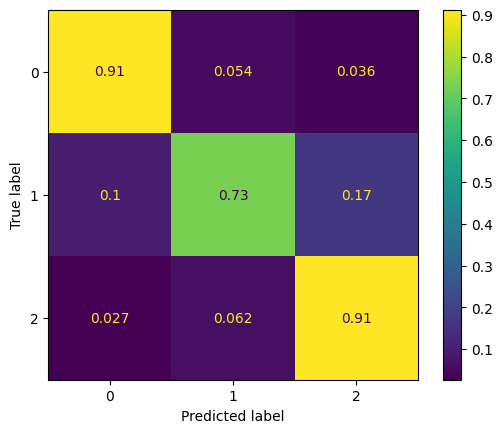

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.48560. Saving Model!
epoch 01, loss: 0.50748, acc: 0.78695, val_loss: 0.48560, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 02, loss: 0.50753, acc: 0.78871, val_loss: 0.49300, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 03, loss: 0.50350, acc: 0.79018, val_loss: 0.49713, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 04, loss: 0.50275, acc: 0.78952, val_loss: 0.50209, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 05, loss: 0.50114, acc: 0.79122, val_loss: 0.50820, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 06, loss: 0.49889, acc: 0.79314, val_loss: 0.51252, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 07, loss: 0.49857, acc: 0.79271, val_loss: 0.51420, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 08, loss: 0.49780, acc: 0.79329, val_loss: 0.51669, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 09, loss: 0.49639, acc: 0.79419, val_loss: 0.51998, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 10, loss: 0.49615, acc: 0.79532, val_loss: 0.52214, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 11, loss: 0.49547, acc: 0.79543, val_loss: 0.52495, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 12, loss: 0.49436, acc: 0.79572, val_loss: 0.52733, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 13, loss: 0.49424, acc: 0.79602, val_loss: 0.52878, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 14, loss: 0.49374, acc: 0.79613, val_loss: 0.53102, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 15, loss: 0.49265, acc: 0.79687, val_loss: 0.53364, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 16, loss: 0.49271, acc: 0.79713, val_loss: 0.53578, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 17, loss: 0.49214, acc: 0.79753, val_loss: 0.53735, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 18, loss: 0.49155, acc: 0.79798, val_loss: 0.53925, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 19, loss: 0.49139, acc: 0.79798, val_loss: 0.54043, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 20, loss: 0.49073, acc: 0.79822, val_loss: 0.54205, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 21, loss: 0.49014, acc: 0.79831, val_loss: 0.54399, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 22, loss: 0.49022, acc: 0.79836, val_loss: 0.54499, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 23, loss: 0.48972, acc: 0.79866, val_loss: 0.54636, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 24, loss: 0.48921, acc: 0.79866, val_loss: 0.54815, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 25, loss: 0.48883, acc: 0.79890, val_loss: 0.54988, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 26, loss: 0.48862, acc: 0.79897, val_loss: 0.55072, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 27, loss: 0.48835, acc: 0.79910, val_loss: 0.55252, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 28, loss: 0.48798, acc: 0.79886, val_loss: 0.55319, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 29, loss: 0.48725, acc: 0.80019, val_loss: 0.55518, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 30, loss: 0.48743, acc: 0.80038, val_loss: 0.55602, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 31, loss: 0.48677, acc: 0.80025, val_loss: 0.55690, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 32, loss: 0.48680, acc: 0.80023, val_loss: 0.55846, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 33, loss: 0.48627, acc: 0.80060, val_loss: 0.55924, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 34, loss: 0.48619, acc: 0.80060, val_loss: 0.55965, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 35, loss: 0.48529, acc: 0.80113, val_loss: 0.56151, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 36, loss: 0.48589, acc: 0.80104, val_loss: 0.56182, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 37, loss: 0.48502, acc: 0.80091, val_loss: 0.56318, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 38, loss: 0.48489, acc: 0.80130, val_loss: 0.56430, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 39, loss: 0.48442, acc: 0.80163, val_loss: 0.56468, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 40, loss: 0.48433, acc: 0.80143, val_loss: 0.56559, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 41, loss: 0.48405, acc: 0.80163, val_loss: 0.56637, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 42, loss: 0.48351, acc: 0.80187, val_loss: 0.56821, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 43, loss: 0.48371, acc: 0.80154, val_loss: 0.56858, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 44, loss: 0.48324, acc: 0.80222, val_loss: 0.56863, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 45, loss: 0.48281, acc: 0.80191, val_loss: 0.57037, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 46, loss: 0.48268, acc: 0.80228, val_loss: 0.57060, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 47, loss: 0.48226, acc: 0.80248, val_loss: 0.57186, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 48, loss: 0.48230, acc: 0.80204, val_loss: 0.57213, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 49, loss: 0.48184, acc: 0.80254, val_loss: 0.57305, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 50, loss: 0.48169, acc: 0.80265, val_loss: 0.57345, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 51, loss: 0.48140, acc: 0.80270, val_loss: 0.57456, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 52, loss: 0.48110, acc: 0.80270, val_loss: 0.57542, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 53, loss: 0.48095, acc: 0.80294, val_loss: 0.57525, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 54, loss: 0.48066, acc: 0.80315, val_loss: 0.57674, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 55, loss: 0.48056, acc: 0.80390, val_loss: 0.57741, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 56, loss: 0.48004, acc: 0.80420, val_loss: 0.57856, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 57, loss: 0.48001, acc: 0.80422, val_loss: 0.57864, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 58, loss: 0.47972, acc: 0.80427, val_loss: 0.57937, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 59, loss: 0.47907, acc: 0.80442, val_loss: 0.58063, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 60, loss: 0.47956, acc: 0.80405, val_loss: 0.58060, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 61, loss: 0.47903, acc: 0.80448, val_loss: 0.58118, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 62, loss: 0.47840, acc: 0.80475, val_loss: 0.58311, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 63, loss: 0.47895, acc: 0.80433, val_loss: 0.58232, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 64, loss: 0.47804, acc: 0.80440, val_loss: 0.58402, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 65, loss: 0.47803, acc: 0.80483, val_loss: 0.58418, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 66, loss: 0.47802, acc: 0.80459, val_loss: 0.58492, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 67, loss: 0.47741, acc: 0.80472, val_loss: 0.58500, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 68, loss: 0.47731, acc: 0.80483, val_loss: 0.58584, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 69, loss: 0.47737, acc: 0.80466, val_loss: 0.58703, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 70, loss: 0.47680, acc: 0.80483, val_loss: 0.58789, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 71, loss: 0.47667, acc: 0.80523, val_loss: 0.58730, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 72, loss: 0.47637, acc: 0.80555, val_loss: 0.58933, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 73, loss: 0.47634, acc: 0.80562, val_loss: 0.58917, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 74, loss: 0.47592, acc: 0.80577, val_loss: 0.59095, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 75, loss: 0.47573, acc: 0.80568, val_loss: 0.59043, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 76, loss: 0.47585, acc: 0.80564, val_loss: 0.59094, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 77, loss: 0.47476, acc: 0.80636, val_loss: 0.59304, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 78, loss: 0.47559, acc: 0.80616, val_loss: 0.59193, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 79, loss: 0.47490, acc: 0.80621, val_loss: 0.59420, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 80, loss: 0.47467, acc: 0.80590, val_loss: 0.59433, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 81, loss: 0.47431, acc: 0.80610, val_loss: 0.59426, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 82, loss: 0.47445, acc: 0.80640, val_loss: 0.59510, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 83, loss: 0.47373, acc: 0.80660, val_loss: 0.59625, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 84, loss: 0.47402, acc: 0.80656, val_loss: 0.59675, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 85, loss: 0.47342, acc: 0.80684, val_loss: 0.59729, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 86, loss: 0.47373, acc: 0.80675, val_loss: 0.59787, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 87, loss: 0.47309, acc: 0.80688, val_loss: 0.59947, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 88, loss: 0.47310, acc: 0.80682, val_loss: 0.59905, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 89, loss: 0.47281, acc: 0.80715, val_loss: 0.59904, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 90, loss: 0.47264, acc: 0.80736, val_loss: 0.60046, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 91, loss: 0.47230, acc: 0.80741, val_loss: 0.60052, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 92, loss: 0.47205, acc: 0.80732, val_loss: 0.60134, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 93, loss: 0.47194, acc: 0.80763, val_loss: 0.60176, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 94, loss: 0.47184, acc: 0.80747, val_loss: 0.60278, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 95, loss: 0.47156, acc: 0.80795, val_loss: 0.60405, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 96, loss: 0.47139, acc: 0.80765, val_loss: 0.60350, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 97, loss: 0.47118, acc: 0.80791, val_loss: 0.60323, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 98, loss: 0.47096, acc: 0.80800, val_loss: 0.60471, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 99, loss: 0.47093, acc: 0.80802, val_loss: 0.60520, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 100, loss: 0.47013, acc: 0.80869, val_loss: 0.60619, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 101, loss: 0.47092, acc: 0.80789, val_loss: 0.60577, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 102, loss: 0.46974, acc: 0.80880, val_loss: 0.60560, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 103, loss: 0.47028, acc: 0.80839, val_loss: 0.60749, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 104, loss: 0.46951, acc: 0.80850, val_loss: 0.60784, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 105, loss: 0.46942, acc: 0.80880, val_loss: 0.60790, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 106, loss: 0.46947, acc: 0.80880, val_loss: 0.60944, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 107, loss: 0.46897, acc: 0.80957, val_loss: 0.60932, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 108, loss: 0.46918, acc: 0.80937, val_loss: 0.60924, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 109, loss: 0.46831, acc: 0.80955, val_loss: 0.61096, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 110, loss: 0.46905, acc: 0.80972, val_loss: 0.60997, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 111, loss: 0.46796, acc: 0.80970, val_loss: 0.61196, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 112, loss: 0.46848, acc: 0.80983, val_loss: 0.61176, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 113, loss: 0.46785, acc: 0.80989, val_loss: 0.61165, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 114, loss: 0.46778, acc: 0.80979, val_loss: 0.61315, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 115, loss: 0.46782, acc: 0.81020, val_loss: 0.61286, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 116, loss: 0.46724, acc: 0.80976, val_loss: 0.61316, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 117, loss: 0.46729, acc: 0.81000, val_loss: 0.61391, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 118, loss: 0.46707, acc: 0.80996, val_loss: 0.61466, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 119, loss: 0.46676, acc: 0.81024, val_loss: 0.61442, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 120, loss: 0.46661, acc: 0.81083, val_loss: 0.61565, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 121, loss: 0.46661, acc: 0.81013, val_loss: 0.61455, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 122, loss: 0.46620, acc: 0.81092, val_loss: 0.61613, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 123, loss: 0.46614, acc: 0.81068, val_loss: 0.61628, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 124, loss: 0.46595, acc: 0.81024, val_loss: 0.61675, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 125, loss: 0.46582, acc: 0.81081, val_loss: 0.61673, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 126, loss: 0.46549, acc: 0.81105, val_loss: 0.61841, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 127, loss: 0.46505, acc: 0.81105, val_loss: 0.61835, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 128, loss: 0.46542, acc: 0.81066, val_loss: 0.61816, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 129, loss: 0.46469, acc: 0.81120, val_loss: 0.61895, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 130, loss: 0.46522, acc: 0.81066, val_loss: 0.61913, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 131, loss: 0.46431, acc: 0.81144, val_loss: 0.61987, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 132, loss: 0.46457, acc: 0.81162, val_loss: 0.61985, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 133, loss: 0.46398, acc: 0.81149, val_loss: 0.62005, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 134, loss: 0.46404, acc: 0.81147, val_loss: 0.62067, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 135, loss: 0.46376, acc: 0.81234, val_loss: 0.62098, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 136, loss: 0.46368, acc: 0.81240, val_loss: 0.62224, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 137, loss: 0.46352, acc: 0.81162, val_loss: 0.62229, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 138, loss: 0.46317, acc: 0.81171, val_loss: 0.62208, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 139, loss: 0.46326, acc: 0.81227, val_loss: 0.62234, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 140, loss: 0.46273, acc: 0.81280, val_loss: 0.62267, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 141, loss: 0.46276, acc: 0.81286, val_loss: 0.62305, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 142, loss: 0.46285, acc: 0.81269, val_loss: 0.62418, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 143, loss: 0.46227, acc: 0.81273, val_loss: 0.62473, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 144, loss: 0.46224, acc: 0.81266, val_loss: 0.62472, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 145, loss: 0.46225, acc: 0.81223, val_loss: 0.62445, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 146, loss: 0.46178, acc: 0.81314, val_loss: 0.62652, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 147, loss: 0.46175, acc: 0.81297, val_loss: 0.62502, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 148, loss: 0.46164, acc: 0.81295, val_loss: 0.62657, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 149, loss: 0.46115, acc: 0.81376, val_loss: 0.62625, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 150, loss: 0.46110, acc: 0.81397, val_loss: 0.62716, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 151, loss: 0.46095, acc: 0.81371, val_loss: 0.62786, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 152, loss: 0.46084, acc: 0.81288, val_loss: 0.62720, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 153, loss: 0.46055, acc: 0.81347, val_loss: 0.62805, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 154, loss: 0.46069, acc: 0.81384, val_loss: 0.62871, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 155, loss: 0.45993, acc: 0.81389, val_loss: 0.62896, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 156, loss: 0.46062, acc: 0.81417, val_loss: 0.62834, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 157, loss: 0.45927, acc: 0.81541, val_loss: 0.63048, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 158, loss: 0.46053, acc: 0.81369, val_loss: 0.62950, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 159, loss: 0.45872, acc: 0.81552, val_loss: 0.63005, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 160, loss: 0.46032, acc: 0.81419, val_loss: 0.62969, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 161, loss: 0.45828, acc: 0.81557, val_loss: 0.63135, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 162, loss: 0.45980, acc: 0.81439, val_loss: 0.63027, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 163, loss: 0.45821, acc: 0.81554, val_loss: 0.63256, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 164, loss: 0.45924, acc: 0.81395, val_loss: 0.63171, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 165, loss: 0.45825, acc: 0.81592, val_loss: 0.63211, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 166, loss: 0.45866, acc: 0.81482, val_loss: 0.63244, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 167, loss: 0.45780, acc: 0.81565, val_loss: 0.63360, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 168, loss: 0.45868, acc: 0.81552, val_loss: 0.63245, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 169, loss: 0.45718, acc: 0.81609, val_loss: 0.63448, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 170, loss: 0.45834, acc: 0.81561, val_loss: 0.63386, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 171, loss: 0.45703, acc: 0.81626, val_loss: 0.63443, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 172, loss: 0.45782, acc: 0.81585, val_loss: 0.63406, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 173, loss: 0.45675, acc: 0.81659, val_loss: 0.63551, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 174, loss: 0.45749, acc: 0.81594, val_loss: 0.63551, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 175, loss: 0.45618, acc: 0.81681, val_loss: 0.63626, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 176, loss: 0.45736, acc: 0.81611, val_loss: 0.63555, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 177, loss: 0.45590, acc: 0.81661, val_loss: 0.63745, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 178, loss: 0.45679, acc: 0.81616, val_loss: 0.63676, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 179, loss: 0.45547, acc: 0.81692, val_loss: 0.63865, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 180, loss: 0.45679, acc: 0.81618, val_loss: 0.63722, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 181, loss: 0.45529, acc: 0.81677, val_loss: 0.63831, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 182, loss: 0.45591, acc: 0.81626, val_loss: 0.63797, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 183, loss: 0.45541, acc: 0.81696, val_loss: 0.63920, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 184, loss: 0.45530, acc: 0.81659, val_loss: 0.63876, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 185, loss: 0.45505, acc: 0.81698, val_loss: 0.63893, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 186, loss: 0.45486, acc: 0.81679, val_loss: 0.64076, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 187, loss: 0.45486, acc: 0.81733, val_loss: 0.63962, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 188, loss: 0.45424, acc: 0.81731, val_loss: 0.64096, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 189, loss: 0.45469, acc: 0.81703, val_loss: 0.64046, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 190, loss: 0.45382, acc: 0.81751, val_loss: 0.64238, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 191, loss: 0.45429, acc: 0.81770, val_loss: 0.64128, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 192, loss: 0.45345, acc: 0.81801, val_loss: 0.64134, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 193, loss: 0.45432, acc: 0.81779, val_loss: 0.64149, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 194, loss: 0.45290, acc: 0.81801, val_loss: 0.64249, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 195, loss: 0.45367, acc: 0.81812, val_loss: 0.64286, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 196, loss: 0.45272, acc: 0.81803, val_loss: 0.64374, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 197, loss: 0.45393, acc: 0.81825, val_loss: 0.64256, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 198, loss: 0.45218, acc: 0.81834, val_loss: 0.64451, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 199, loss: 0.45335, acc: 0.81818, val_loss: 0.64316, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 200, loss: 0.45207, acc: 0.81853, val_loss: 0.64565, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 201, loss: 0.45273, acc: 0.81797, val_loss: 0.64486, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 202, loss: 0.45186, acc: 0.81869, val_loss: 0.64564, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 203, loss: 0.45237, acc: 0.81879, val_loss: 0.64506, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 204, loss: 0.45161, acc: 0.81954, val_loss: 0.64541, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 205, loss: 0.45174, acc: 0.81975, val_loss: 0.64517, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 206, loss: 0.45175, acc: 0.81899, val_loss: 0.64622, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 207, loss: 0.45110, acc: 0.81984, val_loss: 0.64726, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 208, loss: 0.45145, acc: 0.81995, val_loss: 0.64721, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 209, loss: 0.45081, acc: 0.81956, val_loss: 0.64765, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 210, loss: 0.45120, acc: 0.81986, val_loss: 0.64768, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 211, loss: 0.45001, acc: 0.81993, val_loss: 0.64777, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 212, loss: 0.45126, acc: 0.81925, val_loss: 0.64733, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 213, loss: 0.44981, acc: 0.82032, val_loss: 0.64925, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 214, loss: 0.45062, acc: 0.82039, val_loss: 0.64827, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 215, loss: 0.44964, acc: 0.82063, val_loss: 0.64967, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 216, loss: 0.45043, acc: 0.82069, val_loss: 0.64868, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 217, loss: 0.44938, acc: 0.82063, val_loss: 0.65028, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 218, loss: 0.44991, acc: 0.82023, val_loss: 0.64959, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 219, loss: 0.44884, acc: 0.82109, val_loss: 0.65142, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 220, loss: 0.44982, acc: 0.82069, val_loss: 0.65087, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 221, loss: 0.44858, acc: 0.82122, val_loss: 0.65054, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 222, loss: 0.44959, acc: 0.82056, val_loss: 0.65140, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 223, loss: 0.44793, acc: 0.82085, val_loss: 0.65184, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 224, loss: 0.44936, acc: 0.82093, val_loss: 0.65120, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 225, loss: 0.44730, acc: 0.82187, val_loss: 0.65297, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 226, loss: 0.44898, acc: 0.82089, val_loss: 0.65214, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 227, loss: 0.44756, acc: 0.82178, val_loss: 0.65397, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 228, loss: 0.44812, acc: 0.82135, val_loss: 0.65245, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 229, loss: 0.44713, acc: 0.82196, val_loss: 0.65427, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 230, loss: 0.44800, acc: 0.82135, val_loss: 0.65413, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 231, loss: 0.44690, acc: 0.82200, val_loss: 0.65407, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 232, loss: 0.44743, acc: 0.82198, val_loss: 0.65427, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 233, loss: 0.44674, acc: 0.82220, val_loss: 0.65538, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 234, loss: 0.44689, acc: 0.82207, val_loss: 0.65491, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 235, loss: 0.44658, acc: 0.82224, val_loss: 0.65480, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 236, loss: 0.44659, acc: 0.82252, val_loss: 0.65710, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 237, loss: 0.44615, acc: 0.82226, val_loss: 0.65649, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 238, loss: 0.44683, acc: 0.82178, val_loss: 0.65544, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 239, loss: 0.44535, acc: 0.82266, val_loss: 0.65686, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 240, loss: 0.44644, acc: 0.82196, val_loss: 0.65694, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 241, loss: 0.44512, acc: 0.82318, val_loss: 0.65811, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 242, loss: 0.44639, acc: 0.82213, val_loss: 0.65551, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 243, loss: 0.44473, acc: 0.82294, val_loss: 0.65782, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 244, loss: 0.44605, acc: 0.82218, val_loss: 0.65792, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 245, loss: 0.44469, acc: 0.82338, val_loss: 0.65837, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 246, loss: 0.44503, acc: 0.82233, val_loss: 0.66028, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 247, loss: 0.44474, acc: 0.82318, val_loss: 0.65815, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 248, loss: 0.44467, acc: 0.82287, val_loss: 0.65904, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 249, loss: 0.44424, acc: 0.82346, val_loss: 0.65976, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 250, loss: 0.44431, acc: 0.82303, val_loss: 0.65918, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 251, loss: 0.44384, acc: 0.82285, val_loss: 0.65967, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 252, loss: 0.44399, acc: 0.82261, val_loss: 0.66007, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 253, loss: 0.44335, acc: 0.82333, val_loss: 0.66174, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 254, loss: 0.44378, acc: 0.82340, val_loss: 0.66091, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 255, loss: 0.44327, acc: 0.82340, val_loss: 0.66217, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 256, loss: 0.44315, acc: 0.82355, val_loss: 0.66190, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 257, loss: 0.44319, acc: 0.82318, val_loss: 0.66121, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 258, loss: 0.44272, acc: 0.82340, val_loss: 0.66336, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 259, loss: 0.44320, acc: 0.82324, val_loss: 0.66222, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 260, loss: 0.44210, acc: 0.82386, val_loss: 0.66334, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 261, loss: 0.44320, acc: 0.82348, val_loss: 0.66425, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 262, loss: 0.44136, acc: 0.82401, val_loss: 0.66304, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 263, loss: 0.44320, acc: 0.82370, val_loss: 0.66149, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 264, loss: 0.44105, acc: 0.82460, val_loss: 0.66535, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 265, loss: 0.44304, acc: 0.82370, val_loss: 0.66418, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 266, loss: 0.44053, acc: 0.82423, val_loss: 0.66531, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 267, loss: 0.44222, acc: 0.82324, val_loss: 0.66529, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 268, loss: 0.44073, acc: 0.82488, val_loss: 0.66596, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 269, loss: 0.44156, acc: 0.82394, val_loss: 0.66497, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 270, loss: 0.44066, acc: 0.82451, val_loss: 0.66555, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 271, loss: 0.44079, acc: 0.82440, val_loss: 0.66641, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 272, loss: 0.44077, acc: 0.82423, val_loss: 0.66684, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 273, loss: 0.44015, acc: 0.82588, val_loss: 0.66697, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 274, loss: 0.44074, acc: 0.82591, val_loss: 0.66571, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 275, loss: 0.43977, acc: 0.82586, val_loss: 0.66893, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 276, loss: 0.44032, acc: 0.82617, val_loss: 0.66730, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 277, loss: 0.43959, acc: 0.82628, val_loss: 0.66781, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 278, loss: 0.44001, acc: 0.82534, val_loss: 0.66816, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 279, loss: 0.43889, acc: 0.82619, val_loss: 0.66858, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 280, loss: 0.44014, acc: 0.82501, val_loss: 0.66811, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 281, loss: 0.43842, acc: 0.82656, val_loss: 0.67038, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 282, loss: 0.43938, acc: 0.82634, val_loss: 0.66880, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 283, loss: 0.43836, acc: 0.82641, val_loss: 0.66958, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 284, loss: 0.43913, acc: 0.82610, val_loss: 0.66811, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 285, loss: 0.43806, acc: 0.82663, val_loss: 0.67005, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 286, loss: 0.43872, acc: 0.82604, val_loss: 0.67004, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 287, loss: 0.43802, acc: 0.82669, val_loss: 0.67078, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 288, loss: 0.43831, acc: 0.82658, val_loss: 0.67104, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 289, loss: 0.43786, acc: 0.82634, val_loss: 0.67200, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 290, loss: 0.43761, acc: 0.82719, val_loss: 0.67093, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 291, loss: 0.43775, acc: 0.82678, val_loss: 0.67242, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 292, loss: 0.43755, acc: 0.82658, val_loss: 0.67127, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 293, loss: 0.43691, acc: 0.82658, val_loss: 0.67340, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 294, loss: 0.43744, acc: 0.82604, val_loss: 0.67163, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 295, loss: 0.43683, acc: 0.82737, val_loss: 0.67318, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 296, loss: 0.43683, acc: 0.82656, val_loss: 0.67256, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 297, loss: 0.43655, acc: 0.82700, val_loss: 0.67354, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 298, loss: 0.43674, acc: 0.82647, val_loss: 0.67272, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 299, loss: 0.43591, acc: 0.82713, val_loss: 0.67410, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 300, loss: 0.43631, acc: 0.82571, val_loss: 0.67351, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 301, loss: 0.43590, acc: 0.82726, val_loss: 0.67430, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 302, loss: 0.43569, acc: 0.82708, val_loss: 0.67474, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 303, loss: 0.43607, acc: 0.82673, val_loss: 0.67424, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 304, loss: 0.43573, acc: 0.82687, val_loss: 0.67485, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 305, loss: 0.43512, acc: 0.82735, val_loss: 0.67609, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 306, loss: 0.43608, acc: 0.82643, val_loss: 0.67468, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 307, loss: 0.43513, acc: 0.82719, val_loss: 0.67650, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 308, loss: 0.43471, acc: 0.82691, val_loss: 0.67448, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 309, loss: 0.43499, acc: 0.82765, val_loss: 0.67606, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 310, loss: 0.43481, acc: 0.82704, val_loss: 0.67714, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 311, loss: 0.43441, acc: 0.82719, val_loss: 0.67779, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 312, loss: 0.43436, acc: 0.82704, val_loss: 0.67731, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 313, loss: 0.43388, acc: 0.82765, val_loss: 0.67750, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 314, loss: 0.43412, acc: 0.82859, val_loss: 0.67731, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 315, loss: 0.43395, acc: 0.82857, val_loss: 0.67726, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 316, loss: 0.43416, acc: 0.82817, val_loss: 0.67792, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 317, loss: 0.43334, acc: 0.82874, val_loss: 0.67996, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 318, loss: 0.43353, acc: 0.82813, val_loss: 0.67713, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 319, loss: 0.43333, acc: 0.82872, val_loss: 0.67960, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 320, loss: 0.43345, acc: 0.82885, val_loss: 0.67932, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 321, loss: 0.43316, acc: 0.82894, val_loss: 0.68140, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 322, loss: 0.43283, acc: 0.82793, val_loss: 0.67963, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 323, loss: 0.43273, acc: 0.82929, val_loss: 0.67994, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 324, loss: 0.43244, acc: 0.82894, val_loss: 0.68001, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 325, loss: 0.43254, acc: 0.82907, val_loss: 0.68010, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 326, loss: 0.43215, acc: 0.82948, val_loss: 0.68078, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 327, loss: 0.43217, acc: 0.82898, val_loss: 0.68250, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 328, loss: 0.43194, acc: 0.82955, val_loss: 0.68143, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 329, loss: 0.43165, acc: 0.82927, val_loss: 0.68282, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 330, loss: 0.43189, acc: 0.82900, val_loss: 0.68102, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 331, loss: 0.43136, acc: 0.82985, val_loss: 0.68311, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 332, loss: 0.43116, acc: 0.82889, val_loss: 0.68270, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 333, loss: 0.43115, acc: 0.82944, val_loss: 0.68395, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 334, loss: 0.43115, acc: 0.82863, val_loss: 0.68310, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 335, loss: 0.43037, acc: 0.82974, val_loss: 0.68243, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 336, loss: 0.43107, acc: 0.82942, val_loss: 0.68339, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 337, loss: 0.43028, acc: 0.82959, val_loss: 0.68437, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 338, loss: 0.43021, acc: 0.83016, val_loss: 0.68351, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 339, loss: 0.43036, acc: 0.82985, val_loss: 0.68523, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 340, loss: 0.43031, acc: 0.83003, val_loss: 0.68476, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 341, loss: 0.42983, acc: 0.83016, val_loss: 0.68586, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 342, loss: 0.43002, acc: 0.82959, val_loss: 0.68363, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 343, loss: 0.42937, acc: 0.83049, val_loss: 0.68783, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 344, loss: 0.42979, acc: 0.82942, val_loss: 0.68555, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 345, loss: 0.42920, acc: 0.83062, val_loss: 0.68647, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 346, loss: 0.42924, acc: 0.83079, val_loss: 0.68577, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 347, loss: 0.42887, acc: 0.83025, val_loss: 0.68776, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 348, loss: 0.42917, acc: 0.83060, val_loss: 0.68725, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 349, loss: 0.42853, acc: 0.83079, val_loss: 0.68678, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 350, loss: 0.42878, acc: 0.83062, val_loss: 0.68678, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 351, loss: 0.42795, acc: 0.83079, val_loss: 0.68878, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 352, loss: 0.42892, acc: 0.83077, val_loss: 0.68742, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 353, loss: 0.42776, acc: 0.83079, val_loss: 0.68847, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 354, loss: 0.42874, acc: 0.83097, val_loss: 0.68760, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 355, loss: 0.42770, acc: 0.83084, val_loss: 0.69041, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 356, loss: 0.42781, acc: 0.83132, val_loss: 0.68804, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 357, loss: 0.42762, acc: 0.83160, val_loss: 0.69172, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 358, loss: 0.42759, acc: 0.83066, val_loss: 0.68950, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 359, loss: 0.42703, acc: 0.83180, val_loss: 0.68986, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 360, loss: 0.42712, acc: 0.83175, val_loss: 0.68924, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 361, loss: 0.42693, acc: 0.83217, val_loss: 0.69060, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 362, loss: 0.42669, acc: 0.83195, val_loss: 0.69074, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 363, loss: 0.42659, acc: 0.83142, val_loss: 0.68988, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 364, loss: 0.42685, acc: 0.83193, val_loss: 0.69014, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 365, loss: 0.42560, acc: 0.83245, val_loss: 0.69311, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 366, loss: 0.42677, acc: 0.83182, val_loss: 0.69084, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 367, loss: 0.42514, acc: 0.83297, val_loss: 0.69242, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 368, loss: 0.42649, acc: 0.83164, val_loss: 0.69187, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 369, loss: 0.42528, acc: 0.83236, val_loss: 0.69314, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


epoch 370, loss: 0.42599, acc: 0.83326, val_loss: 0.69243, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 371, loss: 0.42529, acc: 0.83256, val_loss: 0.69358, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 372, loss: 0.42551, acc: 0.83289, val_loss: 0.69320, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 373, loss: 0.42508, acc: 0.83269, val_loss: 0.69431, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 374, loss: 0.42526, acc: 0.83265, val_loss: 0.69360, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 375, loss: 0.42490, acc: 0.83243, val_loss: 0.69416, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 376, loss: 0.42463, acc: 0.83313, val_loss: 0.69502, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 377, loss: 0.42476, acc: 0.83280, val_loss: 0.69587, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 378, loss: 0.42404, acc: 0.83350, val_loss: 0.69541, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 379, loss: 0.42455, acc: 0.83304, val_loss: 0.69557, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 380, loss: 0.42434, acc: 0.83374, val_loss: 0.69583, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 381, loss: 0.42377, acc: 0.83315, val_loss: 0.69695, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 382, loss: 0.42435, acc: 0.83330, val_loss: 0.69491, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 383, loss: 0.42331, acc: 0.83354, val_loss: 0.69752, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 384, loss: 0.42387, acc: 0.83433, val_loss: 0.69627, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 385, loss: 0.42320, acc: 0.83350, val_loss: 0.69783, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 386, loss: 0.42355, acc: 0.83417, val_loss: 0.69496, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 387, loss: 0.42287, acc: 0.83372, val_loss: 0.69816, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 388, loss: 0.42382, acc: 0.83415, val_loss: 0.69454, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 389, loss: 0.42219, acc: 0.83396, val_loss: 0.69880, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 390, loss: 0.42372, acc: 0.83393, val_loss: 0.69746, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 391, loss: 0.42229, acc: 0.83400, val_loss: 0.70125, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 392, loss: 0.42278, acc: 0.83446, val_loss: 0.69751, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 393, loss: 0.42230, acc: 0.83376, val_loss: 0.69970, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 394, loss: 0.42135, acc: 0.83502, val_loss: 0.69875, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 395, loss: 0.42277, acc: 0.83415, val_loss: 0.69901, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 396, loss: 0.42127, acc: 0.83502, val_loss: 0.69940, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 397, loss: 0.42191, acc: 0.83441, val_loss: 0.69959, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 398, loss: 0.42117, acc: 0.83502, val_loss: 0.70038, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 399, loss: 0.42139, acc: 0.83476, val_loss: 0.70018, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 400, loss: 0.42134, acc: 0.83489, val_loss: 0.69977, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 401, loss: 0.42073, acc: 0.83470, val_loss: 0.70135, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 402, loss: 0.42171, acc: 0.83500, val_loss: 0.69963, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


epoch 403, loss: 0.42011, acc: 0.83467, val_loss: 0.70280, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 404, loss: 0.42142, acc: 0.83457, val_loss: 0.69982, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 405, loss: 0.42020, acc: 0.83472, val_loss: 0.70274, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 406, loss: 0.42087, acc: 0.83494, val_loss: 0.70206, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 407, loss: 0.42105, acc: 0.83435, val_loss: 0.70504, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 408, loss: 0.42012, acc: 0.83555, val_loss: 0.70132, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 409, loss: 0.42014, acc: 0.83465, val_loss: 0.70554, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 410, loss: 0.41971, acc: 0.83544, val_loss: 0.70547, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 411, loss: 0.41983, acc: 0.83496, val_loss: 0.70349, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 412, loss: 0.41945, acc: 0.83570, val_loss: 0.70377, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 413, loss: 0.41945, acc: 0.83483, val_loss: 0.70510, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 414, loss: 0.41918, acc: 0.83559, val_loss: 0.70375, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 415, loss: 0.41907, acc: 0.83542, val_loss: 0.70425, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 416, loss: 0.41879, acc: 0.83601, val_loss: 0.70515, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 417, loss: 0.41929, acc: 0.83546, val_loss: 0.70506, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 418, loss: 0.41829, acc: 0.83601, val_loss: 0.70447, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 419, loss: 0.41841, acc: 0.83590, val_loss: 0.70435, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 420, loss: 0.41878, acc: 0.83557, val_loss: 0.70544, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 421, loss: 0.41777, acc: 0.83620, val_loss: 0.70677, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 422, loss: 0.41893, acc: 0.83555, val_loss: 0.70544, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 423, loss: 0.41698, acc: 0.83640, val_loss: 0.70797, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 424, loss: 0.41863, acc: 0.83539, val_loss: 0.70686, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 425, loss: 0.41679, acc: 0.83681, val_loss: 0.70764, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 426, loss: 0.41779, acc: 0.83596, val_loss: 0.70833, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 427, loss: 0.41761, acc: 0.83638, val_loss: 0.70695, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 428, loss: 0.41710, acc: 0.83598, val_loss: 0.70818, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 429, loss: 0.41716, acc: 0.83686, val_loss: 0.70671, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 430, loss: 0.41688, acc: 0.83596, val_loss: 0.70861, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 431, loss: 0.41728, acc: 0.83734, val_loss: 0.70732, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 432, loss: 0.41667, acc: 0.83609, val_loss: 0.71056, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 433, loss: 0.41683, acc: 0.83716, val_loss: 0.70829, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 434, loss: 0.41597, acc: 0.83653, val_loss: 0.71190, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 435, loss: 0.41642, acc: 0.83688, val_loss: 0.70900, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 436, loss: 0.41571, acc: 0.83659, val_loss: 0.70837, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 437, loss: 0.41586, acc: 0.83716, val_loss: 0.71020, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 438, loss: 0.41599, acc: 0.83657, val_loss: 0.71031, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 439, loss: 0.41525, acc: 0.83751, val_loss: 0.70907, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 440, loss: 0.41536, acc: 0.83712, val_loss: 0.71125, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 441, loss: 0.41525, acc: 0.83729, val_loss: 0.71041, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 442, loss: 0.41528, acc: 0.83718, val_loss: 0.71007, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 443, loss: 0.41496, acc: 0.83734, val_loss: 0.71022, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 444, loss: 0.41505, acc: 0.83747, val_loss: 0.71116, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 445, loss: 0.41503, acc: 0.83694, val_loss: 0.71230, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 446, loss: 0.41433, acc: 0.83764, val_loss: 0.71147, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 447, loss: 0.41499, acc: 0.83727, val_loss: 0.71284, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 448, loss: 0.41427, acc: 0.83758, val_loss: 0.71244, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 449, loss: 0.41472, acc: 0.83736, val_loss: 0.71135, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 450, loss: 0.41374, acc: 0.83775, val_loss: 0.71279, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 451, loss: 0.41455, acc: 0.83762, val_loss: 0.71396, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 452, loss: 0.41292, acc: 0.83788, val_loss: 0.71414, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 453, loss: 0.41437, acc: 0.83707, val_loss: 0.71210, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 454, loss: 0.41335, acc: 0.83788, val_loss: 0.71376, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 455, loss: 0.41363, acc: 0.83803, val_loss: 0.71478, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 456, loss: 0.41289, acc: 0.83810, val_loss: 0.71592, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 457, loss: 0.41406, acc: 0.83766, val_loss: 0.71284, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 458, loss: 0.41177, acc: 0.83860, val_loss: 0.71464, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 459, loss: 0.41392, acc: 0.83769, val_loss: 0.71520, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 460, loss: 0.41209, acc: 0.83858, val_loss: 0.71495, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 461, loss: 0.41312, acc: 0.83795, val_loss: 0.71530, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 462, loss: 0.41213, acc: 0.83969, val_loss: 0.71419, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 463, loss: 0.41297, acc: 0.83786, val_loss: 0.71453, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 464, loss: 0.41183, acc: 0.84043, val_loss: 0.71516, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 465, loss: 0.41240, acc: 0.83827, val_loss: 0.71606, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 466, loss: 0.41219, acc: 0.84056, val_loss: 0.71479, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 467, loss: 0.41216, acc: 0.83821, val_loss: 0.71778, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 468, loss: 0.41162, acc: 0.84080, val_loss: 0.71531, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 469, loss: 0.41191, acc: 0.84000, val_loss: 0.71707, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 470, loss: 0.41143, acc: 0.84111, val_loss: 0.71625, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 471, loss: 0.41180, acc: 0.83808, val_loss: 0.71773, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 472, loss: 0.41118, acc: 0.84131, val_loss: 0.71571, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 473, loss: 0.41114, acc: 0.83915, val_loss: 0.71962, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 474, loss: 0.41059, acc: 0.84111, val_loss: 0.71766, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 475, loss: 0.41080, acc: 0.84006, val_loss: 0.71945, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 476, loss: 0.41031, acc: 0.84159, val_loss: 0.71744, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 477, loss: 0.41067, acc: 0.83967, val_loss: 0.71841, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 478, loss: 0.40959, acc: 0.84176, val_loss: 0.71853, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 479, loss: 0.41096, acc: 0.83963, val_loss: 0.71838, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 480, loss: 0.40945, acc: 0.84163, val_loss: 0.71886, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 481, loss: 0.41023, acc: 0.84091, val_loss: 0.71874, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 482, loss: 0.40932, acc: 0.84190, val_loss: 0.71914, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 483, loss: 0.41031, acc: 0.84085, val_loss: 0.72043, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 484, loss: 0.40927, acc: 0.84155, val_loss: 0.72055, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 485, loss: 0.40961, acc: 0.84017, val_loss: 0.72006, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 486, loss: 0.40919, acc: 0.84179, val_loss: 0.72264, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 487, loss: 0.40855, acc: 0.84152, val_loss: 0.72191, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 488, loss: 0.40895, acc: 0.84159, val_loss: 0.72118, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 489, loss: 0.40832, acc: 0.84139, val_loss: 0.72050, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 490, loss: 0.40905, acc: 0.84157, val_loss: 0.72110, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 491, loss: 0.40773, acc: 0.84255, val_loss: 0.72264, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 492, loss: 0.40868, acc: 0.84200, val_loss: 0.71973, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 493, loss: 0.40768, acc: 0.84268, val_loss: 0.72233, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 494, loss: 0.40838, acc: 0.84181, val_loss: 0.72199, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 495, loss: 0.40721, acc: 0.84181, val_loss: 0.72268, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 496, loss: 0.40847, acc: 0.84224, val_loss: 0.72164, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 497, loss: 0.40659, acc: 0.84296, val_loss: 0.72509, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 498, loss: 0.40884, acc: 0.84203, val_loss: 0.72110, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 499, loss: 0.40593, acc: 0.84329, val_loss: 0.72309, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 500, loss: 0.40852, acc: 0.84244, val_loss: 0.72147, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 501, loss: 0.40572, acc: 0.84240, val_loss: 0.72560, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 502, loss: 0.40811, acc: 0.84266, val_loss: 0.72163, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 503, loss: 0.40542, acc: 0.84340, val_loss: 0.72572, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 504, loss: 0.40836, acc: 0.84222, val_loss: 0.72327, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 505, loss: 0.40485, acc: 0.84318, val_loss: 0.72634, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 506, loss: 0.40787, acc: 0.84277, val_loss: 0.72135, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 507, loss: 0.40508, acc: 0.84320, val_loss: 0.72721, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 508, loss: 0.40719, acc: 0.84268, val_loss: 0.72380, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 509, loss: 0.40472, acc: 0.84294, val_loss: 0.72617, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 510, loss: 0.40684, acc: 0.84290, val_loss: 0.72390, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 511, loss: 0.40494, acc: 0.84347, val_loss: 0.72740, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 512, loss: 0.40638, acc: 0.84279, val_loss: 0.72393, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 513, loss: 0.40450, acc: 0.84344, val_loss: 0.72619, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 514, loss: 0.40625, acc: 0.84401, val_loss: 0.72458, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 515, loss: 0.40398, acc: 0.84349, val_loss: 0.72858, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 516, loss: 0.40633, acc: 0.84279, val_loss: 0.72434, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 517, loss: 0.40314, acc: 0.84410, val_loss: 0.72881, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 518, loss: 0.40654, acc: 0.84264, val_loss: 0.72383, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 519, loss: 0.40305, acc: 0.84388, val_loss: 0.72813, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 520, loss: 0.40572, acc: 0.84305, val_loss: 0.72586, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 521, loss: 0.40289, acc: 0.84408, val_loss: 0.72927, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 522, loss: 0.40559, acc: 0.84390, val_loss: 0.72495, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 523, loss: 0.40302, acc: 0.84445, val_loss: 0.73140, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 524, loss: 0.40534, acc: 0.84375, val_loss: 0.72689, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 525, loss: 0.40290, acc: 0.84425, val_loss: 0.73013, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 526, loss: 0.40534, acc: 0.84375, val_loss: 0.72791, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 527, loss: 0.40346, acc: 0.84449, val_loss: 0.73039, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 528, loss: 0.40570, acc: 0.84279, val_loss: 0.72984, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 529, loss: 0.40230, acc: 0.84578, val_loss: 0.73018, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 530, loss: 0.40531, acc: 0.84338, val_loss: 0.73090, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 531, loss: 0.40204, acc: 0.84556, val_loss: 0.73134, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 532, loss: 0.40408, acc: 0.84242, val_loss: 0.73174, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 533, loss: 0.40186, acc: 0.84539, val_loss: 0.72941, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 534, loss: 0.40349, acc: 0.84364, val_loss: 0.72956, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 535, loss: 0.40188, acc: 0.84521, val_loss: 0.73111, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 536, loss: 0.40282, acc: 0.84395, val_loss: 0.72914, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 537, loss: 0.40218, acc: 0.84482, val_loss: 0.73156, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 538, loss: 0.40204, acc: 0.84480, val_loss: 0.73055, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 539, loss: 0.40247, acc: 0.84460, val_loss: 0.73068, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 540, loss: 0.40154, acc: 0.84484, val_loss: 0.73360, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 541, loss: 0.40254, acc: 0.84414, val_loss: 0.73075, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 542, loss: 0.40133, acc: 0.84491, val_loss: 0.73498, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 543, loss: 0.40123, acc: 0.84536, val_loss: 0.73338, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 544, loss: 0.40138, acc: 0.84386, val_loss: 0.73245, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 545, loss: 0.40144, acc: 0.84539, val_loss: 0.73268, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 546, loss: 0.40059, acc: 0.84493, val_loss: 0.73383, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 547, loss: 0.40117, acc: 0.84541, val_loss: 0.73394, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 548, loss: 0.40063, acc: 0.84488, val_loss: 0.73353, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 549, loss: 0.40105, acc: 0.84539, val_loss: 0.73453, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 550, loss: 0.40028, acc: 0.84460, val_loss: 0.73414, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 551, loss: 0.40076, acc: 0.84549, val_loss: 0.73538, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 552, loss: 0.39974, acc: 0.84552, val_loss: 0.73830, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 553, loss: 0.40037, acc: 0.84534, val_loss: 0.73592, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 554, loss: 0.39942, acc: 0.84580, val_loss: 0.73538, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 555, loss: 0.40027, acc: 0.84571, val_loss: 0.73609, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 556, loss: 0.39920, acc: 0.84593, val_loss: 0.73570, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 557, loss: 0.40020, acc: 0.84661, val_loss: 0.73606, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 558, loss: 0.39915, acc: 0.84608, val_loss: 0.73797, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 559, loss: 0.40017, acc: 0.84637, val_loss: 0.73741, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 560, loss: 0.39909, acc: 0.84615, val_loss: 0.73762, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 561, loss: 0.39871, acc: 0.84617, val_loss: 0.73888, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 562, loss: 0.39933, acc: 0.84691, val_loss: 0.73654, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 563, loss: 0.39901, acc: 0.84663, val_loss: 0.73812, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 564, loss: 0.39849, acc: 0.84626, val_loss: 0.73944, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 565, loss: 0.39859, acc: 0.84696, val_loss: 0.73912, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 566, loss: 0.39871, acc: 0.84685, val_loss: 0.73958, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 567, loss: 0.39793, acc: 0.84805, val_loss: 0.74039, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 568, loss: 0.39837, acc: 0.84687, val_loss: 0.73785, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 569, loss: 0.39767, acc: 0.84748, val_loss: 0.73790, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 570, loss: 0.39806, acc: 0.84685, val_loss: 0.74062, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 571, loss: 0.39781, acc: 0.84768, val_loss: 0.74089, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 572, loss: 0.39761, acc: 0.84717, val_loss: 0.73890, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 573, loss: 0.39780, acc: 0.84770, val_loss: 0.73979, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 574, loss: 0.39754, acc: 0.84720, val_loss: 0.74283, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 575, loss: 0.39707, acc: 0.84850, val_loss: 0.74080, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 576, loss: 0.39722, acc: 0.84724, val_loss: 0.74147, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 577, loss: 0.39689, acc: 0.84785, val_loss: 0.74096, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 578, loss: 0.39670, acc: 0.84733, val_loss: 0.74137, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 579, loss: 0.39694, acc: 0.84792, val_loss: 0.74007, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 580, loss: 0.39657, acc: 0.84770, val_loss: 0.74149, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 581, loss: 0.39661, acc: 0.84787, val_loss: 0.74218, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 582, loss: 0.39639, acc: 0.84730, val_loss: 0.74422, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 583, loss: 0.39623, acc: 0.84853, val_loss: 0.74170, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 584, loss: 0.39638, acc: 0.84709, val_loss: 0.74371, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 585, loss: 0.39658, acc: 0.84807, val_loss: 0.74439, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 586, loss: 0.39602, acc: 0.84711, val_loss: 0.74478, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 587, loss: 0.39619, acc: 0.84844, val_loss: 0.74091, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 588, loss: 0.39609, acc: 0.84765, val_loss: 0.74624, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 589, loss: 0.39500, acc: 0.84938, val_loss: 0.74635, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 590, loss: 0.39586, acc: 0.84715, val_loss: 0.74449, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 591, loss: 0.39509, acc: 0.84848, val_loss: 0.74388, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 592, loss: 0.39509, acc: 0.84774, val_loss: 0.74633, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 593, loss: 0.39550, acc: 0.84861, val_loss: 0.74290, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 594, loss: 0.39447, acc: 0.84774, val_loss: 0.74509, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 595, loss: 0.39492, acc: 0.84885, val_loss: 0.74345, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 596, loss: 0.39391, acc: 0.84805, val_loss: 0.74733, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 597, loss: 0.39514, acc: 0.84850, val_loss: 0.74529, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 598, loss: 0.39346, acc: 0.84824, val_loss: 0.74562, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 599, loss: 0.39512, acc: 0.84822, val_loss: 0.74537, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 600, loss: 0.39311, acc: 0.84826, val_loss: 0.74904, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 601, loss: 0.39575, acc: 0.84835, val_loss: 0.74397, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 602, loss: 0.39249, acc: 0.84870, val_loss: 0.74882, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 603, loss: 0.39575, acc: 0.84796, val_loss: 0.74771, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 604, loss: 0.39280, acc: 0.84877, val_loss: 0.75033, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 605, loss: 0.39461, acc: 0.84933, val_loss: 0.74622, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 606, loss: 0.39269, acc: 0.84920, val_loss: 0.75108, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 607, loss: 0.39366, acc: 0.84942, val_loss: 0.75108, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 608, loss: 0.39253, acc: 0.84859, val_loss: 0.75063, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 609, loss: 0.39390, acc: 0.84898, val_loss: 0.74686, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 610, loss: 0.39167, acc: 0.84968, val_loss: 0.75019, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 611, loss: 0.39322, acc: 0.84916, val_loss: 0.74912, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 612, loss: 0.39185, acc: 0.84940, val_loss: 0.74734, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 613, loss: 0.39291, acc: 0.84907, val_loss: 0.74825, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 614, loss: 0.39172, acc: 0.84953, val_loss: 0.75045, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 615, loss: 0.39280, acc: 0.84881, val_loss: 0.74850, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 616, loss: 0.39178, acc: 0.84912, val_loss: 0.75015, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 617, loss: 0.39268, acc: 0.84846, val_loss: 0.75149, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 618, loss: 0.39192, acc: 0.84960, val_loss: 0.74948, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 619, loss: 0.39221, acc: 0.84848, val_loss: 0.75174, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 620, loss: 0.39206, acc: 0.84927, val_loss: 0.75317, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 621, loss: 0.39179, acc: 0.84818, val_loss: 0.75253, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 622, loss: 0.39199, acc: 0.84933, val_loss: 0.74912, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 623, loss: 0.39141, acc: 0.84835, val_loss: 0.75570, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 624, loss: 0.39090, acc: 0.85066, val_loss: 0.75409, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 625, loss: 0.39134, acc: 0.84848, val_loss: 0.75333, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 626, loss: 0.39095, acc: 0.84986, val_loss: 0.75185, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 627, loss: 0.39043, acc: 0.84898, val_loss: 0.75340, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 628, loss: 0.39080, acc: 0.85005, val_loss: 0.75122, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 629, loss: 0.39002, acc: 0.84885, val_loss: 0.75334, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


epoch 630, loss: 0.39044, acc: 0.84986, val_loss: 0.75145, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 631, loss: 0.38959, acc: 0.84953, val_loss: 0.75395, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 632, loss: 0.39088, acc: 0.85012, val_loss: 0.75318, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 633, loss: 0.38896, acc: 0.84964, val_loss: 0.75328, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 634, loss: 0.39115, acc: 0.84997, val_loss: 0.75143, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 635, loss: 0.38845, acc: 0.84953, val_loss: 0.75817, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 636, loss: 0.39100, acc: 0.84944, val_loss: 0.75338, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 637, loss: 0.38824, acc: 0.84949, val_loss: 0.75545, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 638, loss: 0.39091, acc: 0.84986, val_loss: 0.75426, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 639, loss: 0.38751, acc: 0.85025, val_loss: 0.75625, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 640, loss: 0.39024, acc: 0.84925, val_loss: 0.75174, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 641, loss: 0.38753, acc: 0.85032, val_loss: 0.75754, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 642, loss: 0.39065, acc: 0.84918, val_loss: 0.75406, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 643, loss: 0.38686, acc: 0.85023, val_loss: 0.75988, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 644, loss: 0.39085, acc: 0.84966, val_loss: 0.75257, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 645, loss: 0.38647, acc: 0.85025, val_loss: 0.76154, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 646, loss: 0.39039, acc: 0.84960, val_loss: 0.75426, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 647, loss: 0.38589, acc: 0.85056, val_loss: 0.75892, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 648, loss: 0.39062, acc: 0.84831, val_loss: 0.75471, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 649, loss: 0.38525, acc: 0.85027, val_loss: 0.76018, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 650, loss: 0.39051, acc: 0.84866, val_loss: 0.75359, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 651, loss: 0.38529, acc: 0.85093, val_loss: 0.76180, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 652, loss: 0.39042, acc: 0.84933, val_loss: 0.75289, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 653, loss: 0.38537, acc: 0.85093, val_loss: 0.76153, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 654, loss: 0.39025, acc: 0.84977, val_loss: 0.75393, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 655, loss: 0.38566, acc: 0.85049, val_loss: 0.76299, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 656, loss: 0.39144, acc: 0.84864, val_loss: 0.75633, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 657, loss: 0.38486, acc: 0.85160, val_loss: 0.76083, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 658, loss: 0.39091, acc: 0.84872, val_loss: 0.75457, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 659, loss: 0.38357, acc: 0.85206, val_loss: 0.76415, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 660, loss: 0.39097, acc: 0.84840, val_loss: 0.75425, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 661, loss: 0.38276, acc: 0.85149, val_loss: 0.76260, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 662, loss: 0.39007, acc: 0.84868, val_loss: 0.75624, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 663, loss: 0.38303, acc: 0.85202, val_loss: 0.76285, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 664, loss: 0.38944, acc: 0.84885, val_loss: 0.75474, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 665, loss: 0.38300, acc: 0.85106, val_loss: 0.76373, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 666, loss: 0.38884, acc: 0.85016, val_loss: 0.75632, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 667, loss: 0.38314, acc: 0.85132, val_loss: 0.76561, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 668, loss: 0.38870, acc: 0.84973, val_loss: 0.75814, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 669, loss: 0.38339, acc: 0.85156, val_loss: 0.76423, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 670, loss: 0.38799, acc: 0.85003, val_loss: 0.75996, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 671, loss: 0.38315, acc: 0.85210, val_loss: 0.76449, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 672, loss: 0.38786, acc: 0.85045, val_loss: 0.75854, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 673, loss: 0.38291, acc: 0.85160, val_loss: 0.76571, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 674, loss: 0.38771, acc: 0.85005, val_loss: 0.75882, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 675, loss: 0.38244, acc: 0.85250, val_loss: 0.76469, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 676, loss: 0.38767, acc: 0.85001, val_loss: 0.75958, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 677, loss: 0.38253, acc: 0.85206, val_loss: 0.76551, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 678, loss: 0.38721, acc: 0.85029, val_loss: 0.76064, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 679, loss: 0.38232, acc: 0.85282, val_loss: 0.76333, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 680, loss: 0.38683, acc: 0.85023, val_loss: 0.76107, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 681, loss: 0.38240, acc: 0.85215, val_loss: 0.76677, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 682, loss: 0.38583, acc: 0.84949, val_loss: 0.76244, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 683, loss: 0.38314, acc: 0.85304, val_loss: 0.76200, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 684, loss: 0.38469, acc: 0.85110, val_loss: 0.76482, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 685, loss: 0.38289, acc: 0.85291, val_loss: 0.76533, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 686, loss: 0.38436, acc: 0.85086, val_loss: 0.76395, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 687, loss: 0.38249, acc: 0.85247, val_loss: 0.76316, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 688, loss: 0.38390, acc: 0.85114, val_loss: 0.76548, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 689, loss: 0.38276, acc: 0.85204, val_loss: 0.76600, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 690, loss: 0.38277, acc: 0.85151, val_loss: 0.76590, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 691, loss: 0.38333, acc: 0.85230, val_loss: 0.76221, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 692, loss: 0.38219, acc: 0.85171, val_loss: 0.76788, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 693, loss: 0.38271, acc: 0.85256, val_loss: 0.76434, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 694, loss: 0.38215, acc: 0.85162, val_loss: 0.76679, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 695, loss: 0.38264, acc: 0.85346, val_loss: 0.76513, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 696, loss: 0.38141, acc: 0.85178, val_loss: 0.76708, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 697, loss: 0.38252, acc: 0.85263, val_loss: 0.76432, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 698, loss: 0.38111, acc: 0.85210, val_loss: 0.76857, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 699, loss: 0.38315, acc: 0.85265, val_loss: 0.76669, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 700, loss: 0.38027, acc: 0.85193, val_loss: 0.77066, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 701, loss: 0.38324, acc: 0.85278, val_loss: 0.76342, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 702, loss: 0.37955, acc: 0.85256, val_loss: 0.77143, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 703, loss: 0.38345, acc: 0.85322, val_loss: 0.76474, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 704, loss: 0.37921, acc: 0.85243, val_loss: 0.77198, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 705, loss: 0.38298, acc: 0.85302, val_loss: 0.76488, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 706, loss: 0.37901, acc: 0.85328, val_loss: 0.77238, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 707, loss: 0.38320, acc: 0.85295, val_loss: 0.76418, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 708, loss: 0.37866, acc: 0.85315, val_loss: 0.77448, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 709, loss: 0.38404, acc: 0.85298, val_loss: 0.76320, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 710, loss: 0.37783, acc: 0.85333, val_loss: 0.77339, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 711, loss: 0.38478, acc: 0.85287, val_loss: 0.76603, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 712, loss: 0.37721, acc: 0.85381, val_loss: 0.77662, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 713, loss: 0.38503, acc: 0.85110, val_loss: 0.76297, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 714, loss: 0.37755, acc: 0.85341, val_loss: 0.77650, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 715, loss: 0.38528, acc: 0.85058, val_loss: 0.76586, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 716, loss: 0.37687, acc: 0.85490, val_loss: 0.77529, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 717, loss: 0.38515, acc: 0.85097, val_loss: 0.76696, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 718, loss: 0.37589, acc: 0.85522, val_loss: 0.77905, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 719, loss: 0.38494, acc: 0.85053, val_loss: 0.76643, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 720, loss: 0.37567, acc: 0.85525, val_loss: 0.77501, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 721, loss: 0.38415, acc: 0.85108, val_loss: 0.76608, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 722, loss: 0.37562, acc: 0.85557, val_loss: 0.77805, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 723, loss: 0.38362, acc: 0.85101, val_loss: 0.76679, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 724, loss: 0.37643, acc: 0.85492, val_loss: 0.77408, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 725, loss: 0.38294, acc: 0.85160, val_loss: 0.76689, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 726, loss: 0.37603, acc: 0.85503, val_loss: 0.77823, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 727, loss: 0.38317, acc: 0.85215, val_loss: 0.76855, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 728, loss: 0.37547, acc: 0.85581, val_loss: 0.77753, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 729, loss: 0.38256, acc: 0.85162, val_loss: 0.76947, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 730, loss: 0.37499, acc: 0.85562, val_loss: 0.77656, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 731, loss: 0.38212, acc: 0.85143, val_loss: 0.76843, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 732, loss: 0.37507, acc: 0.85507, val_loss: 0.77897, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 733, loss: 0.38178, acc: 0.85167, val_loss: 0.77071, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 734, loss: 0.37481, acc: 0.85590, val_loss: 0.77800, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 735, loss: 0.38228, acc: 0.85184, val_loss: 0.76782, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 736, loss: 0.37454, acc: 0.85594, val_loss: 0.78078, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 737, loss: 0.38252, acc: 0.85171, val_loss: 0.77091, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 738, loss: 0.37417, acc: 0.85555, val_loss: 0.77843, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 739, loss: 0.38208, acc: 0.85186, val_loss: 0.76969, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 740, loss: 0.37370, acc: 0.85581, val_loss: 0.78324, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 741, loss: 0.38225, acc: 0.85145, val_loss: 0.77036, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 742, loss: 0.37369, acc: 0.85631, val_loss: 0.77976, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 743, loss: 0.38207, acc: 0.85184, val_loss: 0.77051, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 744, loss: 0.37249, acc: 0.85679, val_loss: 0.78434, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 745, loss: 0.38222, acc: 0.85191, val_loss: 0.77003, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 746, loss: 0.37248, acc: 0.85610, val_loss: 0.78195, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 747, loss: 0.38169, acc: 0.85186, val_loss: 0.77037, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 748, loss: 0.37320, acc: 0.85653, val_loss: 0.78332, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 749, loss: 0.38147, acc: 0.85219, val_loss: 0.77028, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 750, loss: 0.37217, acc: 0.85638, val_loss: 0.78252, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 751, loss: 0.38169, acc: 0.85221, val_loss: 0.77112, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 752, loss: 0.37129, acc: 0.85690, val_loss: 0.78426, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 753, loss: 0.38102, acc: 0.85221, val_loss: 0.77058, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 754, loss: 0.37156, acc: 0.85712, val_loss: 0.78393, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 755, loss: 0.37992, acc: 0.85247, val_loss: 0.77117, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 756, loss: 0.37142, acc: 0.85612, val_loss: 0.78396, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 757, loss: 0.37980, acc: 0.85271, val_loss: 0.77198, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 758, loss: 0.37193, acc: 0.85710, val_loss: 0.78261, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


epoch 759, loss: 0.37966, acc: 0.85280, val_loss: 0.77405, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 760, loss: 0.37174, acc: 0.85651, val_loss: 0.78689, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 761, loss: 0.37976, acc: 0.85291, val_loss: 0.77421, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 762, loss: 0.37130, acc: 0.85686, val_loss: 0.78523, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 763, loss: 0.37989, acc: 0.85313, val_loss: 0.77600, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 764, loss: 0.37001, acc: 0.85719, val_loss: 0.78701, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 765, loss: 0.38024, acc: 0.85298, val_loss: 0.77270, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 766, loss: 0.36984, acc: 0.85684, val_loss: 0.78826, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 767, loss: 0.37996, acc: 0.85324, val_loss: 0.77309, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 768, loss: 0.36984, acc: 0.85740, val_loss: 0.78577, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 769, loss: 0.37996, acc: 0.85311, val_loss: 0.77235, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 770, loss: 0.36987, acc: 0.85618, val_loss: 0.78989, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 771, loss: 0.37981, acc: 0.85285, val_loss: 0.77557, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 772, loss: 0.36961, acc: 0.85743, val_loss: 0.78778, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 773, loss: 0.37987, acc: 0.85287, val_loss: 0.77602, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 774, loss: 0.36867, acc: 0.85810, val_loss: 0.79082, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 775, loss: 0.37930, acc: 0.85298, val_loss: 0.77393, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 776, loss: 0.36877, acc: 0.85758, val_loss: 0.78900, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 777, loss: 0.37834, acc: 0.85352, val_loss: 0.77618, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 778, loss: 0.36865, acc: 0.85817, val_loss: 0.78896, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 779, loss: 0.37840, acc: 0.85352, val_loss: 0.77465, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 780, loss: 0.36851, acc: 0.85758, val_loss: 0.79137, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 781, loss: 0.37789, acc: 0.85287, val_loss: 0.77599, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 782, loss: 0.36903, acc: 0.85775, val_loss: 0.78953, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 783, loss: 0.37806, acc: 0.85243, val_loss: 0.77795, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 784, loss: 0.36811, acc: 0.85791, val_loss: 0.79120, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 785, loss: 0.37822, acc: 0.85274, val_loss: 0.77588, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 786, loss: 0.36781, acc: 0.85782, val_loss: 0.79041, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 787, loss: 0.37832, acc: 0.85291, val_loss: 0.77571, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 788, loss: 0.36743, acc: 0.85804, val_loss: 0.79315, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 789, loss: 0.37824, acc: 0.85291, val_loss: 0.77782, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 790, loss: 0.36692, acc: 0.85812, val_loss: 0.79642, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 791, loss: 0.37856, acc: 0.85300, val_loss: 0.77727, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 792, loss: 0.36655, acc: 0.85819, val_loss: 0.79186, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 793, loss: 0.37807, acc: 0.85328, val_loss: 0.77861, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 794, loss: 0.36645, acc: 0.85819, val_loss: 0.79487, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 795, loss: 0.37696, acc: 0.85324, val_loss: 0.77634, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 796, loss: 0.36691, acc: 0.85762, val_loss: 0.79501, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 797, loss: 0.37662, acc: 0.85295, val_loss: 0.78094, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 798, loss: 0.36715, acc: 0.85858, val_loss: 0.79220, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 799, loss: 0.37582, acc: 0.85359, val_loss: 0.78088, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 800, loss: 0.36608, acc: 0.85863, val_loss: 0.79427, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 801, loss: 0.37584, acc: 0.85466, val_loss: 0.77956, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 802, loss: 0.36588, acc: 0.85887, val_loss: 0.79411, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 803, loss: 0.37571, acc: 0.85381, val_loss: 0.77968, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 804, loss: 0.36615, acc: 0.85815, val_loss: 0.79367, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 805, loss: 0.37522, acc: 0.85538, val_loss: 0.78067, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 806, loss: 0.36634, acc: 0.85876, val_loss: 0.79441, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 807, loss: 0.37547, acc: 0.85385, val_loss: 0.78021, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 808, loss: 0.36508, acc: 0.85937, val_loss: 0.79412, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 809, loss: 0.37555, acc: 0.85479, val_loss: 0.78146, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 810, loss: 0.36501, acc: 0.85939, val_loss: 0.79832, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 811, loss: 0.37516, acc: 0.85431, val_loss: 0.78215, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 812, loss: 0.36509, acc: 0.85917, val_loss: 0.79367, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 813, loss: 0.37552, acc: 0.85479, val_loss: 0.78247, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 814, loss: 0.36466, acc: 0.85950, val_loss: 0.79793, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 815, loss: 0.37533, acc: 0.85511, val_loss: 0.77954, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 816, loss: 0.36463, acc: 0.85941, val_loss: 0.79584, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 817, loss: 0.37464, acc: 0.85501, val_loss: 0.78307, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 818, loss: 0.36432, acc: 0.85996, val_loss: 0.79592, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 819, loss: 0.37454, acc: 0.85551, val_loss: 0.78300, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 820, loss: 0.36342, acc: 0.85965, val_loss: 0.79969, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 821, loss: 0.37461, acc: 0.85429, val_loss: 0.78170, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 822, loss: 0.36403, acc: 0.85874, val_loss: 0.79959, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 823, loss: 0.37377, acc: 0.85459, val_loss: 0.78637, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 824, loss: 0.36433, acc: 0.86002, val_loss: 0.79837, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 825, loss: 0.37302, acc: 0.85588, val_loss: 0.78647, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 826, loss: 0.36405, acc: 0.86048, val_loss: 0.79950, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 827, loss: 0.37195, acc: 0.85620, val_loss: 0.78595, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 828, loss: 0.36410, acc: 0.86009, val_loss: 0.79723, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 829, loss: 0.37134, acc: 0.85651, val_loss: 0.78645, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 830, loss: 0.36424, acc: 0.85991, val_loss: 0.79772, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 831, loss: 0.37107, acc: 0.85546, val_loss: 0.78867, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 832, loss: 0.36422, acc: 0.86028, val_loss: 0.79872, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 833, loss: 0.37118, acc: 0.85769, val_loss: 0.78784, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 834, loss: 0.36292, acc: 0.86063, val_loss: 0.80071, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 835, loss: 0.37162, acc: 0.85653, val_loss: 0.78561, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 836, loss: 0.36265, acc: 0.86020, val_loss: 0.80158, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 837, loss: 0.37192, acc: 0.85559, val_loss: 0.78677, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 838, loss: 0.36245, acc: 0.86065, val_loss: 0.80119, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 839, loss: 0.37206, acc: 0.85559, val_loss: 0.78776, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 840, loss: 0.36234, acc: 0.86076, val_loss: 0.80452, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 841, loss: 0.37229, acc: 0.85553, val_loss: 0.78717, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 842, loss: 0.36179, acc: 0.86083, val_loss: 0.80216, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 843, loss: 0.37208, acc: 0.85583, val_loss: 0.78829, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 844, loss: 0.36165, acc: 0.86055, val_loss: 0.80584, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 845, loss: 0.37225, acc: 0.85603, val_loss: 0.78758, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 846, loss: 0.36116, acc: 0.86013, val_loss: 0.80545, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 847, loss: 0.37276, acc: 0.85572, val_loss: 0.78858, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 848, loss: 0.36083, acc: 0.86096, val_loss: 0.80774, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 849, loss: 0.37278, acc: 0.85599, val_loss: 0.78878, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 850, loss: 0.36022, acc: 0.86140, val_loss: 0.80747, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 851, loss: 0.37199, acc: 0.85559, val_loss: 0.78843, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 852, loss: 0.36046, acc: 0.86133, val_loss: 0.80568, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 853, loss: 0.37105, acc: 0.85603, val_loss: 0.79108, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 854, loss: 0.36019, acc: 0.86118, val_loss: 0.80595, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 855, loss: 0.37062, acc: 0.85668, val_loss: 0.78877, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 856, loss: 0.36114, acc: 0.86118, val_loss: 0.80481, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 857, loss: 0.36942, acc: 0.85795, val_loss: 0.79105, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 858, loss: 0.36116, acc: 0.86131, val_loss: 0.80357, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 859, loss: 0.36909, acc: 0.85775, val_loss: 0.79386, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 860, loss: 0.36075, acc: 0.86166, val_loss: 0.80490, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 861, loss: 0.36821, acc: 0.85778, val_loss: 0.79403, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 862, loss: 0.36033, acc: 0.86205, val_loss: 0.80447, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 863, loss: 0.36815, acc: 0.85839, val_loss: 0.79445, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 864, loss: 0.35974, acc: 0.86172, val_loss: 0.80815, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 865, loss: 0.36786, acc: 0.85819, val_loss: 0.79210, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 866, loss: 0.36063, acc: 0.86168, val_loss: 0.80656, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 867, loss: 0.36772, acc: 0.85832, val_loss: 0.79581, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 868, loss: 0.35995, acc: 0.86203, val_loss: 0.80634, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 869, loss: 0.36750, acc: 0.85935, val_loss: 0.79524, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 870, loss: 0.35957, acc: 0.86164, val_loss: 0.80876, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 871, loss: 0.36755, acc: 0.85856, val_loss: 0.79556, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 872, loss: 0.35965, acc: 0.86212, val_loss: 0.80834, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 873, loss: 0.36788, acc: 0.85675, val_loss: 0.79590, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 874, loss: 0.35892, acc: 0.86227, val_loss: 0.80775, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 875, loss: 0.36826, acc: 0.85771, val_loss: 0.79562, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 876, loss: 0.35814, acc: 0.86266, val_loss: 0.81018, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 877, loss: 0.36807, acc: 0.85723, val_loss: 0.79508, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 878, loss: 0.35851, acc: 0.86216, val_loss: 0.81527, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 879, loss: 0.36851, acc: 0.85710, val_loss: 0.79563, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 880, loss: 0.35794, acc: 0.86299, val_loss: 0.81188, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 881, loss: 0.36862, acc: 0.85732, val_loss: 0.79661, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 882, loss: 0.35777, acc: 0.86264, val_loss: 0.81084, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 883, loss: 0.36797, acc: 0.85697, val_loss: 0.79623, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 884, loss: 0.35864, acc: 0.86199, val_loss: 0.81396, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 885, loss: 0.36750, acc: 0.85695, val_loss: 0.79904, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 886, loss: 0.35812, acc: 0.86305, val_loss: 0.81111, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 887, loss: 0.36711, acc: 0.85793, val_loss: 0.79916, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 888, loss: 0.35731, acc: 0.86262, val_loss: 0.81538, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 889, loss: 0.36652, acc: 0.85874, val_loss: 0.79852, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 890, loss: 0.35722, acc: 0.86299, val_loss: 0.81001, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 891, loss: 0.36561, acc: 0.85773, val_loss: 0.79864, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 892, loss: 0.35692, acc: 0.86312, val_loss: 0.81485, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 893, loss: 0.36571, acc: 0.85782, val_loss: 0.79702, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 894, loss: 0.35646, acc: 0.86231, val_loss: 0.81522, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 895, loss: 0.36630, acc: 0.85874, val_loss: 0.79720, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 896, loss: 0.35663, acc: 0.86316, val_loss: 0.81365, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 897, loss: 0.36623, acc: 0.85836, val_loss: 0.79876, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 898, loss: 0.35617, acc: 0.86277, val_loss: 0.81627, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 899, loss: 0.36678, acc: 0.85780, val_loss: 0.79864, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 900, loss: 0.35633, acc: 0.86297, val_loss: 0.81540, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 901, loss: 0.36675, acc: 0.85832, val_loss: 0.79976, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 902, loss: 0.35550, acc: 0.86286, val_loss: 0.81764, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 903, loss: 0.36715, acc: 0.85758, val_loss: 0.79813, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 904, loss: 0.35535, acc: 0.86310, val_loss: 0.81841, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 905, loss: 0.36747, acc: 0.85808, val_loss: 0.79895, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 906, loss: 0.35498, acc: 0.86358, val_loss: 0.81955, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 907, loss: 0.36679, acc: 0.85865, val_loss: 0.80075, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 908, loss: 0.35437, acc: 0.86310, val_loss: 0.81963, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 909, loss: 0.36594, acc: 0.85834, val_loss: 0.79968, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 910, loss: 0.35408, acc: 0.86380, val_loss: 0.81868, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 911, loss: 0.36561, acc: 0.85826, val_loss: 0.80016, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 912, loss: 0.35419, acc: 0.86367, val_loss: 0.82030, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 913, loss: 0.36506, acc: 0.85874, val_loss: 0.80004, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 914, loss: 0.35465, acc: 0.86353, val_loss: 0.81972, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 915, loss: 0.36514, acc: 0.85854, val_loss: 0.80282, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 916, loss: 0.35435, acc: 0.86367, val_loss: 0.81835, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 917, loss: 0.36468, acc: 0.85911, val_loss: 0.80208, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 918, loss: 0.35461, acc: 0.86343, val_loss: 0.81974, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 919, loss: 0.36382, acc: 0.85847, val_loss: 0.80434, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 920, loss: 0.35486, acc: 0.86340, val_loss: 0.82132, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 921, loss: 0.36357, acc: 0.85874, val_loss: 0.80488, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 922, loss: 0.35436, acc: 0.86349, val_loss: 0.81871, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 923, loss: 0.36298, acc: 0.85939, val_loss: 0.80451, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 924, loss: 0.35388, acc: 0.86319, val_loss: 0.82003, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 925, loss: 0.36331, acc: 0.85930, val_loss: 0.80258, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 926, loss: 0.35377, acc: 0.86373, val_loss: 0.82200, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 927, loss: 0.36355, acc: 0.85860, val_loss: 0.80710, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 928, loss: 0.35307, acc: 0.86417, val_loss: 0.82277, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 929, loss: 0.36377, acc: 0.85972, val_loss: 0.80619, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 930, loss: 0.35270, acc: 0.86391, val_loss: 0.82394, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 931, loss: 0.36349, acc: 0.85937, val_loss: 0.80318, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 932, loss: 0.35236, acc: 0.86404, val_loss: 0.82377, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 933, loss: 0.36324, acc: 0.85943, val_loss: 0.80421, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 934, loss: 0.35272, acc: 0.86406, val_loss: 0.82488, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 935, loss: 0.36339, acc: 0.85972, val_loss: 0.80460, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 936, loss: 0.35276, acc: 0.86412, val_loss: 0.82333, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 937, loss: 0.36324, acc: 0.85908, val_loss: 0.80745, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 938, loss: 0.35197, acc: 0.86447, val_loss: 0.82542, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 939, loss: 0.36351, acc: 0.85946, val_loss: 0.80507, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 940, loss: 0.35185, acc: 0.86447, val_loss: 0.82515, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 941, loss: 0.36308, acc: 0.85924, val_loss: 0.80600, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 942, loss: 0.35160, acc: 0.86458, val_loss: 0.82507, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 943, loss: 0.36304, acc: 0.85978, val_loss: 0.80527, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 944, loss: 0.35063, acc: 0.86449, val_loss: 0.82791, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 945, loss: 0.36307, acc: 0.85952, val_loss: 0.80482, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 946, loss: 0.35146, acc: 0.86449, val_loss: 0.82566, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 947, loss: 0.36236, acc: 0.85989, val_loss: 0.80785, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 948, loss: 0.35060, acc: 0.86469, val_loss: 0.82731, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 949, loss: 0.36280, acc: 0.86013, val_loss: 0.80386, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 950, loss: 0.35083, acc: 0.86471, val_loss: 0.82829, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 951, loss: 0.36221, acc: 0.85987, val_loss: 0.80924, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 952, loss: 0.35056, acc: 0.86500, val_loss: 0.82733, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 953, loss: 0.36242, acc: 0.86004, val_loss: 0.80694, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 954, loss: 0.34969, acc: 0.86471, val_loss: 0.83239, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 955, loss: 0.36202, acc: 0.86037, val_loss: 0.80542, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 956, loss: 0.34989, acc: 0.86460, val_loss: 0.82696, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 957, loss: 0.36127, acc: 0.86072, val_loss: 0.80886, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 958, loss: 0.35063, acc: 0.86449, val_loss: 0.82765, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 959, loss: 0.36043, acc: 0.86068, val_loss: 0.81062, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 960, loss: 0.35072, acc: 0.86530, val_loss: 0.82722, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 961, loss: 0.36007, acc: 0.86096, val_loss: 0.81059, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 962, loss: 0.34985, acc: 0.86504, val_loss: 0.82967, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 963, loss: 0.36047, acc: 0.86092, val_loss: 0.80916, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 964, loss: 0.34963, acc: 0.86452, val_loss: 0.82901, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 965, loss: 0.36111, acc: 0.86052, val_loss: 0.81012, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 966, loss: 0.34895, acc: 0.86510, val_loss: 0.83068, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 967, loss: 0.36108, acc: 0.86055, val_loss: 0.80976, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 968, loss: 0.34840, acc: 0.86528, val_loss: 0.83179, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 969, loss: 0.36102, acc: 0.86055, val_loss: 0.80727, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 970, loss: 0.34881, acc: 0.86543, val_loss: 0.83157, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 971, loss: 0.36069, acc: 0.86081, val_loss: 0.81081, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 972, loss: 0.34909, acc: 0.86519, val_loss: 0.83038, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 973, loss: 0.35971, acc: 0.86100, val_loss: 0.81198, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 974, loss: 0.34874, acc: 0.86510, val_loss: 0.83065, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 975, loss: 0.35932, acc: 0.86140, val_loss: 0.81141, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 976, loss: 0.34883, acc: 0.86508, val_loss: 0.83249, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 977, loss: 0.35983, acc: 0.86103, val_loss: 0.81284, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 978, loss: 0.34813, acc: 0.86532, val_loss: 0.83382, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


epoch 979, loss: 0.36015, acc: 0.86105, val_loss: 0.81119, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 980, loss: 0.34719, acc: 0.86585, val_loss: 0.83335, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 981, loss: 0.35970, acc: 0.86135, val_loss: 0.81140, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 982, loss: 0.34730, acc: 0.86572, val_loss: 0.83417, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 983, loss: 0.35934, acc: 0.86144, val_loss: 0.81230, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 984, loss: 0.34729, acc: 0.86550, val_loss: 0.83525, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 985, loss: 0.35868, acc: 0.86196, val_loss: 0.81095, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 986, loss: 0.34798, acc: 0.86563, val_loss: 0.83293, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


epoch 987, loss: 0.35805, acc: 0.86188, val_loss: 0.81402, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 988, loss: 0.34797, acc: 0.86622, val_loss: 0.83359, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 989, loss: 0.35829, acc: 0.86133, val_loss: 0.81558, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 990, loss: 0.34664, acc: 0.86624, val_loss: 0.83491, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 991, loss: 0.35864, acc: 0.86238, val_loss: 0.81281, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 992, loss: 0.34651, acc: 0.86576, val_loss: 0.83612, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 993, loss: 0.35873, acc: 0.86166, val_loss: 0.81320, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 994, loss: 0.34588, acc: 0.86604, val_loss: 0.83534, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 995, loss: 0.35806, acc: 0.86153, val_loss: 0.81404, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 996, loss: 0.34706, acc: 0.86615, val_loss: 0.83825, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 997, loss: 0.35792, acc: 0.86144, val_loss: 0.81498, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 998, loss: 0.34693, acc: 0.86641, val_loss: 0.83478, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 999, loss: 0.35720, acc: 0.86179, val_loss: 0.81971, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 1000, loss: 0.34642, acc: 0.86665, val_loss: 0.83699, val_accuracy: 0.73832
6번째 교차검증
evaluation loss: 0.47514, evaluation accuracy: 0.80487
(6, 5094)
(5094, 6)
Stacking ensemble (ML+DNN): 5094
[6]Accuracy : 0.8193953670985473
[6]F1score : 0.8183762710374143
[6]Precision : 0.8228374090679871
[6]Recall : 0.8193953670985473



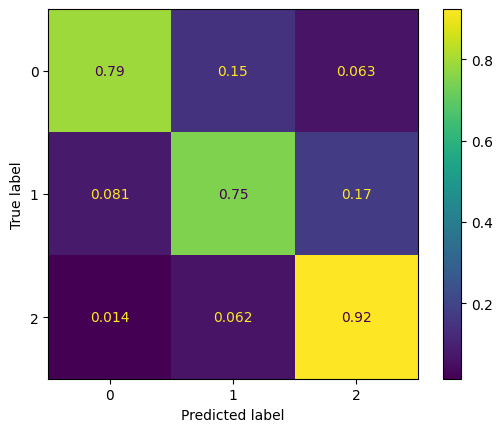

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.50115. Saving Model!
epoch 01, loss: 0.50902, acc: 0.78920, val_loss: 0.50115, val_accuracy: 0.79266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 02, loss: 0.50186, acc: 0.79086, val_loss: 0.51053, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 03, loss: 0.50659, acc: 0.78998, val_loss: 0.51171, val_accuracy: 0.78284


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 04, loss: 0.50268, acc: 0.79140, val_loss: 0.51454, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 05, loss: 0.49842, acc: 0.79350, val_loss: 0.51907, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 06, loss: 0.49953, acc: 0.79330, val_loss: 0.52132, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 07, loss: 0.49758, acc: 0.79350, val_loss: 0.52396, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 08, loss: 0.49640, acc: 0.79480, val_loss: 0.52519, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 09, loss: 0.49619, acc: 0.79485, val_loss: 0.52717, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 10, loss: 0.49498, acc: 0.79579, val_loss: 0.53006, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 11, loss: 0.49441, acc: 0.79699, val_loss: 0.53069, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 12, loss: 0.49390, acc: 0.79690, val_loss: 0.53263, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 13, loss: 0.49330, acc: 0.79707, val_loss: 0.53410, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 14, loss: 0.49271, acc: 0.79738, val_loss: 0.53548, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 15, loss: 0.49230, acc: 0.79740, val_loss: 0.53748, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


epoch 16, loss: 0.49164, acc: 0.79781, val_loss: 0.53880, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


epoch 17, loss: 0.49124, acc: 0.79768, val_loss: 0.54025, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 18, loss: 0.49094, acc: 0.79840, val_loss: 0.54070, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 19, loss: 0.49019, acc: 0.79912, val_loss: 0.54219, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 20, loss: 0.48966, acc: 0.79958, val_loss: 0.54439, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 21, loss: 0.48980, acc: 0.79965, val_loss: 0.54466, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 22, loss: 0.48881, acc: 0.79997, val_loss: 0.54714, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 23, loss: 0.48896, acc: 0.79973, val_loss: 0.54745, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 24, loss: 0.48822, acc: 0.79993, val_loss: 0.54871, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 25, loss: 0.48821, acc: 0.79995, val_loss: 0.55018, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 26, loss: 0.48752, acc: 0.80017, val_loss: 0.55083, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 27, loss: 0.48726, acc: 0.80037, val_loss: 0.55248, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 28, loss: 0.48744, acc: 0.80041, val_loss: 0.55265, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 29, loss: 0.48633, acc: 0.80052, val_loss: 0.55408, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 30, loss: 0.48671, acc: 0.80032, val_loss: 0.55487, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 31, loss: 0.48582, acc: 0.80087, val_loss: 0.55609, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 32, loss: 0.48586, acc: 0.80065, val_loss: 0.55725, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 33, loss: 0.48556, acc: 0.80080, val_loss: 0.55728, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 34, loss: 0.48509, acc: 0.80072, val_loss: 0.55858, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 35, loss: 0.48485, acc: 0.80091, val_loss: 0.55940, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 36, loss: 0.48471, acc: 0.80089, val_loss: 0.56006, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 37, loss: 0.48405, acc: 0.80100, val_loss: 0.56119, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 38, loss: 0.48427, acc: 0.80072, val_loss: 0.56155, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 39, loss: 0.48352, acc: 0.80091, val_loss: 0.56276, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 40, loss: 0.48357, acc: 0.80089, val_loss: 0.56309, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 41, loss: 0.48284, acc: 0.80154, val_loss: 0.56415, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 42, loss: 0.48326, acc: 0.80102, val_loss: 0.56449, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 43, loss: 0.48233, acc: 0.80144, val_loss: 0.56603, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 44, loss: 0.48271, acc: 0.80122, val_loss: 0.56570, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 45, loss: 0.48196, acc: 0.80141, val_loss: 0.56698, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 46, loss: 0.48164, acc: 0.80163, val_loss: 0.56832, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 47, loss: 0.48189, acc: 0.80198, val_loss: 0.56861, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 48, loss: 0.48139, acc: 0.80181, val_loss: 0.56929, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 49, loss: 0.48088, acc: 0.80220, val_loss: 0.57006, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 50, loss: 0.48102, acc: 0.80209, val_loss: 0.57107, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 51, loss: 0.48074, acc: 0.80218, val_loss: 0.57061, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 52, loss: 0.48005, acc: 0.80246, val_loss: 0.57254, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 53, loss: 0.48012, acc: 0.80250, val_loss: 0.57302, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 54, loss: 0.48002, acc: 0.80220, val_loss: 0.57323, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 55, loss: 0.47941, acc: 0.80233, val_loss: 0.57373, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 56, loss: 0.47946, acc: 0.80226, val_loss: 0.57513, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 57, loss: 0.47912, acc: 0.80283, val_loss: 0.57500, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 58, loss: 0.47868, acc: 0.80281, val_loss: 0.57654, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 59, loss: 0.47871, acc: 0.80294, val_loss: 0.57625, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 60, loss: 0.47805, acc: 0.80283, val_loss: 0.57763, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 61, loss: 0.47825, acc: 0.80307, val_loss: 0.57790, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 62, loss: 0.47776, acc: 0.80327, val_loss: 0.57779, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 63, loss: 0.47762, acc: 0.80329, val_loss: 0.57863, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 64, loss: 0.47737, acc: 0.80353, val_loss: 0.58009, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 65, loss: 0.47709, acc: 0.80344, val_loss: 0.58028, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 66, loss: 0.47718, acc: 0.80346, val_loss: 0.58054, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 67, loss: 0.47656, acc: 0.80383, val_loss: 0.58122, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 68, loss: 0.47644, acc: 0.80473, val_loss: 0.58272, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 69, loss: 0.47664, acc: 0.80484, val_loss: 0.58156, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 70, loss: 0.47561, acc: 0.80490, val_loss: 0.58326, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 71, loss: 0.47591, acc: 0.80466, val_loss: 0.58368, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 72, loss: 0.47559, acc: 0.80554, val_loss: 0.58431, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 73, loss: 0.47540, acc: 0.80571, val_loss: 0.58398, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 74, loss: 0.47490, acc: 0.80438, val_loss: 0.58515, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 75, loss: 0.47531, acc: 0.80593, val_loss: 0.58479, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 76, loss: 0.47434, acc: 0.80613, val_loss: 0.58601, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 77, loss: 0.47456, acc: 0.80495, val_loss: 0.58616, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 78, loss: 0.47429, acc: 0.80619, val_loss: 0.58659, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 79, loss: 0.47389, acc: 0.80634, val_loss: 0.58816, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 80, loss: 0.47396, acc: 0.80521, val_loss: 0.58763, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 81, loss: 0.47361, acc: 0.80619, val_loss: 0.58808, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 82, loss: 0.47330, acc: 0.80671, val_loss: 0.58908, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 83, loss: 0.47333, acc: 0.80645, val_loss: 0.58942, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 84, loss: 0.47299, acc: 0.80669, val_loss: 0.58910, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 85, loss: 0.47221, acc: 0.80684, val_loss: 0.59063, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 86, loss: 0.47298, acc: 0.80665, val_loss: 0.59013, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 87, loss: 0.47213, acc: 0.80678, val_loss: 0.59162, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 88, loss: 0.47220, acc: 0.80700, val_loss: 0.59197, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 89, loss: 0.47196, acc: 0.80713, val_loss: 0.59179, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 90, loss: 0.47161, acc: 0.80689, val_loss: 0.59361, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 91, loss: 0.47166, acc: 0.80687, val_loss: 0.59301, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 92, loss: 0.47136, acc: 0.80741, val_loss: 0.59376, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 93, loss: 0.47116, acc: 0.80678, val_loss: 0.59348, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 94, loss: 0.47098, acc: 0.80722, val_loss: 0.59516, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 95, loss: 0.47050, acc: 0.80772, val_loss: 0.59517, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 96, loss: 0.47081, acc: 0.80750, val_loss: 0.59454, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 97, loss: 0.46992, acc: 0.80772, val_loss: 0.59654, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 98, loss: 0.47056, acc: 0.80739, val_loss: 0.59613, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 99, loss: 0.46964, acc: 0.80804, val_loss: 0.59646, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 100, loss: 0.46987, acc: 0.80809, val_loss: 0.59597, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 101, loss: 0.46920, acc: 0.80813, val_loss: 0.59797, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 102, loss: 0.46962, acc: 0.80820, val_loss: 0.59749, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 103, loss: 0.46903, acc: 0.80787, val_loss: 0.59787, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 104, loss: 0.46905, acc: 0.80818, val_loss: 0.59871, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 105, loss: 0.46847, acc: 0.80855, val_loss: 0.59917, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 106, loss: 0.46890, acc: 0.80818, val_loss: 0.59902, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


epoch 107, loss: 0.46802, acc: 0.80942, val_loss: 0.59937, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 108, loss: 0.46840, acc: 0.80837, val_loss: 0.60058, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 109, loss: 0.46778, acc: 0.80866, val_loss: 0.60023, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 110, loss: 0.46785, acc: 0.80957, val_loss: 0.60105, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 111, loss: 0.46738, acc: 0.80892, val_loss: 0.60122, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 112, loss: 0.46723, acc: 0.80992, val_loss: 0.60210, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 113, loss: 0.46738, acc: 0.80896, val_loss: 0.60138, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 114, loss: 0.46698, acc: 0.80964, val_loss: 0.60237, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 115, loss: 0.46671, acc: 0.81010, val_loss: 0.60245, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 116, loss: 0.46653, acc: 0.81031, val_loss: 0.60396, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 117, loss: 0.46634, acc: 0.80975, val_loss: 0.60333, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 118, loss: 0.46628, acc: 0.80983, val_loss: 0.60366, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 119, loss: 0.46580, acc: 0.81040, val_loss: 0.60365, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 120, loss: 0.46561, acc: 0.81064, val_loss: 0.60492, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 121, loss: 0.46595, acc: 0.80970, val_loss: 0.60404, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 122, loss: 0.46501, acc: 0.81055, val_loss: 0.60532, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 123, loss: 0.46523, acc: 0.81081, val_loss: 0.60512, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 124, loss: 0.46463, acc: 0.81073, val_loss: 0.60656, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 125, loss: 0.46503, acc: 0.81038, val_loss: 0.60617, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 126, loss: 0.46434, acc: 0.81079, val_loss: 0.60635, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 127, loss: 0.46435, acc: 0.81068, val_loss: 0.60700, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 128, loss: 0.46381, acc: 0.81114, val_loss: 0.60725, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 129, loss: 0.46437, acc: 0.81060, val_loss: 0.60701, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 130, loss: 0.46340, acc: 0.81075, val_loss: 0.60769, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 131, loss: 0.46388, acc: 0.81186, val_loss: 0.60786, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 132, loss: 0.46305, acc: 0.81119, val_loss: 0.60913, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 133, loss: 0.46334, acc: 0.81123, val_loss: 0.60814, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 134, loss: 0.46270, acc: 0.81110, val_loss: 0.60890, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 135, loss: 0.46285, acc: 0.81129, val_loss: 0.60922, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 136, loss: 0.46249, acc: 0.81228, val_loss: 0.60948, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 137, loss: 0.46246, acc: 0.81256, val_loss: 0.60937, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 138, loss: 0.46233, acc: 0.81160, val_loss: 0.61026, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 139, loss: 0.46179, acc: 0.81236, val_loss: 0.61096, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 140, loss: 0.46230, acc: 0.81129, val_loss: 0.61026, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 141, loss: 0.46117, acc: 0.81284, val_loss: 0.61076, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 142, loss: 0.46165, acc: 0.81184, val_loss: 0.61163, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 143, loss: 0.46135, acc: 0.81278, val_loss: 0.61100, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 144, loss: 0.46124, acc: 0.81295, val_loss: 0.61178, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 145, loss: 0.46040, acc: 0.81223, val_loss: 0.61264, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 146, loss: 0.46142, acc: 0.81263, val_loss: 0.61179, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 147, loss: 0.46014, acc: 0.81341, val_loss: 0.61224, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 148, loss: 0.46040, acc: 0.81315, val_loss: 0.61326, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 149, loss: 0.46024, acc: 0.81293, val_loss: 0.61273, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 150, loss: 0.45987, acc: 0.81369, val_loss: 0.61290, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 151, loss: 0.45982, acc: 0.81398, val_loss: 0.61366, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 152, loss: 0.45944, acc: 0.81339, val_loss: 0.61467, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 153, loss: 0.45961, acc: 0.81361, val_loss: 0.61457, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 154, loss: 0.45946, acc: 0.81404, val_loss: 0.61413, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 155, loss: 0.45862, acc: 0.81383, val_loss: 0.61579, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 156, loss: 0.45931, acc: 0.81363, val_loss: 0.61506, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 157, loss: 0.45838, acc: 0.81411, val_loss: 0.61533, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 158, loss: 0.45848, acc: 0.81402, val_loss: 0.61621, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 159, loss: 0.45841, acc: 0.81396, val_loss: 0.61575, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 160, loss: 0.45802, acc: 0.81407, val_loss: 0.61669, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 161, loss: 0.45835, acc: 0.81433, val_loss: 0.61635, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 162, loss: 0.45750, acc: 0.81441, val_loss: 0.61794, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 163, loss: 0.45771, acc: 0.81431, val_loss: 0.61688, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 164, loss: 0.45748, acc: 0.81411, val_loss: 0.61752, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 165, loss: 0.45720, acc: 0.81441, val_loss: 0.61826, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 166, loss: 0.45720, acc: 0.81446, val_loss: 0.61840, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 167, loss: 0.45681, acc: 0.81459, val_loss: 0.61749, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 168, loss: 0.45676, acc: 0.81494, val_loss: 0.61896, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 169, loss: 0.45658, acc: 0.81487, val_loss: 0.61880, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 170, loss: 0.45619, acc: 0.81468, val_loss: 0.61998, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 171, loss: 0.45634, acc: 0.81483, val_loss: 0.61908, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 172, loss: 0.45603, acc: 0.81465, val_loss: 0.62001, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 173, loss: 0.45590, acc: 0.81564, val_loss: 0.62078, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 174, loss: 0.45538, acc: 0.81588, val_loss: 0.62095, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 175, loss: 0.45585, acc: 0.81529, val_loss: 0.61932, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 176, loss: 0.45491, acc: 0.81555, val_loss: 0.62073, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 177, loss: 0.45528, acc: 0.81542, val_loss: 0.62197, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 178, loss: 0.45506, acc: 0.81688, val_loss: 0.62094, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 179, loss: 0.45470, acc: 0.81579, val_loss: 0.62275, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 180, loss: 0.45484, acc: 0.81581, val_loss: 0.62134, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 181, loss: 0.45427, acc: 0.81633, val_loss: 0.62209, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 182, loss: 0.45423, acc: 0.81668, val_loss: 0.62241, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 183, loss: 0.45390, acc: 0.81640, val_loss: 0.62417, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 184, loss: 0.45437, acc: 0.81601, val_loss: 0.62230, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 185, loss: 0.45365, acc: 0.81655, val_loss: 0.62388, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 186, loss: 0.45349, acc: 0.81697, val_loss: 0.62412, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


epoch 187, loss: 0.45331, acc: 0.81679, val_loss: 0.62388, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 188, loss: 0.45323, acc: 0.81657, val_loss: 0.62373, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 189, loss: 0.45301, acc: 0.81673, val_loss: 0.62510, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 190, loss: 0.45296, acc: 0.81675, val_loss: 0.62418, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 191, loss: 0.45249, acc: 0.81721, val_loss: 0.62513, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 192, loss: 0.45284, acc: 0.81714, val_loss: 0.62538, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 193, loss: 0.45208, acc: 0.81725, val_loss: 0.62624, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 194, loss: 0.45261, acc: 0.81714, val_loss: 0.62473, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 195, loss: 0.45171, acc: 0.81762, val_loss: 0.62616, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 196, loss: 0.45197, acc: 0.81688, val_loss: 0.62578, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 197, loss: 0.45163, acc: 0.81810, val_loss: 0.62705, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 198, loss: 0.45146, acc: 0.81753, val_loss: 0.62655, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 199, loss: 0.45125, acc: 0.81751, val_loss: 0.62682, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 200, loss: 0.45134, acc: 0.81742, val_loss: 0.62645, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 201, loss: 0.45094, acc: 0.81804, val_loss: 0.62735, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 202, loss: 0.45103, acc: 0.81753, val_loss: 0.62717, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 203, loss: 0.45044, acc: 0.81856, val_loss: 0.62874, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 204, loss: 0.45081, acc: 0.81847, val_loss: 0.62725, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 205, loss: 0.44999, acc: 0.81851, val_loss: 0.62865, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 206, loss: 0.45059, acc: 0.81793, val_loss: 0.62769, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 207, loss: 0.44976, acc: 0.81937, val_loss: 0.62922, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 208, loss: 0.45003, acc: 0.81830, val_loss: 0.62805, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 209, loss: 0.44937, acc: 0.81856, val_loss: 0.62971, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 210, loss: 0.44963, acc: 0.81797, val_loss: 0.62859, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 211, loss: 0.44911, acc: 0.81930, val_loss: 0.63010, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 212, loss: 0.44923, acc: 0.81967, val_loss: 0.62966, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 213, loss: 0.44864, acc: 0.81862, val_loss: 0.63043, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 214, loss: 0.44941, acc: 0.81828, val_loss: 0.62896, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 215, loss: 0.44799, acc: 0.81947, val_loss: 0.63180, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 216, loss: 0.44910, acc: 0.81856, val_loss: 0.63101, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 217, loss: 0.44797, acc: 0.82009, val_loss: 0.63137, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 218, loss: 0.44856, acc: 0.81943, val_loss: 0.63129, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 219, loss: 0.44751, acc: 0.82057, val_loss: 0.63185, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 220, loss: 0.44826, acc: 0.82072, val_loss: 0.63131, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 221, loss: 0.44696, acc: 0.82050, val_loss: 0.63257, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 222, loss: 0.44810, acc: 0.82026, val_loss: 0.63168, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 223, loss: 0.44681, acc: 0.82113, val_loss: 0.63376, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 224, loss: 0.44749, acc: 0.82072, val_loss: 0.63237, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 225, loss: 0.44672, acc: 0.82050, val_loss: 0.63277, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 226, loss: 0.44699, acc: 0.82148, val_loss: 0.63307, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 227, loss: 0.44662, acc: 0.82059, val_loss: 0.63369, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 228, loss: 0.44630, acc: 0.82174, val_loss: 0.63415, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 229, loss: 0.44636, acc: 0.82185, val_loss: 0.63426, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 230, loss: 0.44624, acc: 0.82146, val_loss: 0.63494, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 231, loss: 0.44592, acc: 0.82096, val_loss: 0.63462, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 232, loss: 0.44624, acc: 0.82168, val_loss: 0.63474, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 233, loss: 0.44547, acc: 0.82192, val_loss: 0.63468, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 234, loss: 0.44546, acc: 0.82113, val_loss: 0.63668, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 235, loss: 0.44552, acc: 0.82225, val_loss: 0.63402, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 236, loss: 0.44488, acc: 0.82124, val_loss: 0.63637, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 237, loss: 0.44519, acc: 0.82216, val_loss: 0.63643, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 238, loss: 0.44472, acc: 0.82211, val_loss: 0.63726, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 239, loss: 0.44473, acc: 0.82209, val_loss: 0.63644, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 240, loss: 0.44455, acc: 0.82179, val_loss: 0.63729, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 241, loss: 0.44436, acc: 0.82292, val_loss: 0.63698, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 242, loss: 0.44420, acc: 0.82146, val_loss: 0.63874, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 243, loss: 0.44419, acc: 0.82296, val_loss: 0.63718, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 244, loss: 0.44388, acc: 0.82231, val_loss: 0.63913, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


epoch 245, loss: 0.44406, acc: 0.82277, val_loss: 0.63830, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 246, loss: 0.44357, acc: 0.82268, val_loss: 0.63959, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 247, loss: 0.44329, acc: 0.82264, val_loss: 0.63836, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 248, loss: 0.44341, acc: 0.82185, val_loss: 0.63976, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 249, loss: 0.44286, acc: 0.82340, val_loss: 0.63998, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 250, loss: 0.44305, acc: 0.82318, val_loss: 0.64001, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 251, loss: 0.44263, acc: 0.82340, val_loss: 0.64035, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 252, loss: 0.44271, acc: 0.82296, val_loss: 0.64135, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 253, loss: 0.44251, acc: 0.82358, val_loss: 0.64044, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 254, loss: 0.44198, acc: 0.82327, val_loss: 0.64167, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 255, loss: 0.44240, acc: 0.82355, val_loss: 0.64072, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 256, loss: 0.44152, acc: 0.82323, val_loss: 0.64204, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 257, loss: 0.44222, acc: 0.82347, val_loss: 0.64151, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 258, loss: 0.44122, acc: 0.82358, val_loss: 0.64300, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 259, loss: 0.44197, acc: 0.82353, val_loss: 0.64164, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 260, loss: 0.44053, acc: 0.82314, val_loss: 0.64365, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 261, loss: 0.44226, acc: 0.82342, val_loss: 0.64166, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 262, loss: 0.43990, acc: 0.82414, val_loss: 0.64468, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 263, loss: 0.44154, acc: 0.82403, val_loss: 0.64203, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 264, loss: 0.43964, acc: 0.82419, val_loss: 0.64550, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 265, loss: 0.44127, acc: 0.82423, val_loss: 0.64241, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 266, loss: 0.43945, acc: 0.82425, val_loss: 0.64476, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 267, loss: 0.44072, acc: 0.82443, val_loss: 0.64374, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 268, loss: 0.43947, acc: 0.82484, val_loss: 0.64564, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 269, loss: 0.44043, acc: 0.82445, val_loss: 0.64411, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 270, loss: 0.43911, acc: 0.82456, val_loss: 0.64605, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 271, loss: 0.43997, acc: 0.82462, val_loss: 0.64480, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 272, loss: 0.43848, acc: 0.82482, val_loss: 0.64666, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 273, loss: 0.44004, acc: 0.82471, val_loss: 0.64547, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 274, loss: 0.43845, acc: 0.82488, val_loss: 0.64646, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 275, loss: 0.43935, acc: 0.82504, val_loss: 0.64608, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 276, loss: 0.43807, acc: 0.82521, val_loss: 0.64768, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 277, loss: 0.43923, acc: 0.82506, val_loss: 0.64651, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 278, loss: 0.43784, acc: 0.82560, val_loss: 0.64850, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 279, loss: 0.43894, acc: 0.82556, val_loss: 0.64608, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 280, loss: 0.43726, acc: 0.82493, val_loss: 0.64851, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 281, loss: 0.43858, acc: 0.82530, val_loss: 0.64768, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 282, loss: 0.43712, acc: 0.82591, val_loss: 0.64894, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 283, loss: 0.43807, acc: 0.82554, val_loss: 0.64861, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 284, loss: 0.43707, acc: 0.82556, val_loss: 0.64903, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 285, loss: 0.43774, acc: 0.82598, val_loss: 0.65013, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 286, loss: 0.43642, acc: 0.82635, val_loss: 0.64935, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 287, loss: 0.43754, acc: 0.82558, val_loss: 0.64987, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 288, loss: 0.43626, acc: 0.82672, val_loss: 0.65005, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 289, loss: 0.43710, acc: 0.82574, val_loss: 0.65192, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 290, loss: 0.43601, acc: 0.82643, val_loss: 0.65027, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 291, loss: 0.43660, acc: 0.82591, val_loss: 0.65046, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 292, loss: 0.43592, acc: 0.82630, val_loss: 0.65176, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 293, loss: 0.43590, acc: 0.82637, val_loss: 0.65256, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 294, loss: 0.43587, acc: 0.82748, val_loss: 0.65110, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 295, loss: 0.43547, acc: 0.82680, val_loss: 0.65331, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 296, loss: 0.43601, acc: 0.82645, val_loss: 0.65114, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 297, loss: 0.43472, acc: 0.82748, val_loss: 0.65442, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 298, loss: 0.43575, acc: 0.82737, val_loss: 0.65158, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 299, loss: 0.43444, acc: 0.82757, val_loss: 0.65338, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 300, loss: 0.43540, acc: 0.82707, val_loss: 0.65350, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 301, loss: 0.43414, acc: 0.82731, val_loss: 0.65436, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 302, loss: 0.43540, acc: 0.82741, val_loss: 0.65250, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 303, loss: 0.43373, acc: 0.82785, val_loss: 0.65571, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 304, loss: 0.43480, acc: 0.82722, val_loss: 0.65430, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 305, loss: 0.43355, acc: 0.82776, val_loss: 0.65534, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 306, loss: 0.43437, acc: 0.82717, val_loss: 0.65411, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 307, loss: 0.43349, acc: 0.82765, val_loss: 0.65625, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 308, loss: 0.43390, acc: 0.82774, val_loss: 0.65500, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 309, loss: 0.43313, acc: 0.82803, val_loss: 0.65618, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 310, loss: 0.43376, acc: 0.82918, val_loss: 0.65574, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 311, loss: 0.43289, acc: 0.82837, val_loss: 0.65731, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 312, loss: 0.43369, acc: 0.82829, val_loss: 0.65534, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 313, loss: 0.43228, acc: 0.82781, val_loss: 0.65774, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 314, loss: 0.43377, acc: 0.82848, val_loss: 0.65617, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 315, loss: 0.43109, acc: 0.82933, val_loss: 0.65950, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 316, loss: 0.43368, acc: 0.82859, val_loss: 0.65709, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 317, loss: 0.43110, acc: 0.82923, val_loss: 0.65874, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 318, loss: 0.43315, acc: 0.82979, val_loss: 0.65732, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 319, loss: 0.43130, acc: 0.82940, val_loss: 0.65918, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 320, loss: 0.43233, acc: 0.83021, val_loss: 0.65791, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 321, loss: 0.43129, acc: 0.82914, val_loss: 0.65964, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 322, loss: 0.43186, acc: 0.82868, val_loss: 0.65844, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 323, loss: 0.43096, acc: 0.83051, val_loss: 0.66035, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 324, loss: 0.43135, acc: 0.83086, val_loss: 0.65957, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 325, loss: 0.43087, acc: 0.82951, val_loss: 0.66028, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 326, loss: 0.43094, acc: 0.82971, val_loss: 0.65960, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 327, loss: 0.43051, acc: 0.83073, val_loss: 0.66114, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 328, loss: 0.43079, acc: 0.83090, val_loss: 0.66101, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 329, loss: 0.43021, acc: 0.83088, val_loss: 0.66017, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 330, loss: 0.43017, acc: 0.83125, val_loss: 0.66120, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 331, loss: 0.42976, acc: 0.83143, val_loss: 0.66146, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 332, loss: 0.42999, acc: 0.83119, val_loss: 0.66161, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 333, loss: 0.42944, acc: 0.83064, val_loss: 0.66261, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 334, loss: 0.43004, acc: 0.83114, val_loss: 0.66245, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 335, loss: 0.42911, acc: 0.83060, val_loss: 0.66325, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 336, loss: 0.42933, acc: 0.83154, val_loss: 0.66273, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 337, loss: 0.42897, acc: 0.83093, val_loss: 0.66432, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 338, loss: 0.42926, acc: 0.83149, val_loss: 0.66198, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 339, loss: 0.42858, acc: 0.83184, val_loss: 0.66529, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 340, loss: 0.42889, acc: 0.83195, val_loss: 0.66343, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 341, loss: 0.42848, acc: 0.83200, val_loss: 0.66478, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 342, loss: 0.42839, acc: 0.83230, val_loss: 0.66451, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 343, loss: 0.42809, acc: 0.83200, val_loss: 0.66590, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 344, loss: 0.42840, acc: 0.83182, val_loss: 0.66369, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 345, loss: 0.42768, acc: 0.83224, val_loss: 0.66723, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 346, loss: 0.42824, acc: 0.83180, val_loss: 0.66441, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 347, loss: 0.42738, acc: 0.83119, val_loss: 0.66717, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 348, loss: 0.42796, acc: 0.83224, val_loss: 0.66521, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 349, loss: 0.42717, acc: 0.83237, val_loss: 0.66619, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 350, loss: 0.42758, acc: 0.83267, val_loss: 0.66534, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 351, loss: 0.42671, acc: 0.83232, val_loss: 0.66913, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 352, loss: 0.42734, acc: 0.83298, val_loss: 0.66551, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 353, loss: 0.42676, acc: 0.83239, val_loss: 0.66796, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 354, loss: 0.42632, acc: 0.83317, val_loss: 0.66649, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 355, loss: 0.42656, acc: 0.83256, val_loss: 0.66821, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 356, loss: 0.42633, acc: 0.83317, val_loss: 0.66719, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 357, loss: 0.42632, acc: 0.83267, val_loss: 0.66847, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 358, loss: 0.42599, acc: 0.83324, val_loss: 0.66857, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 359, loss: 0.42571, acc: 0.83311, val_loss: 0.66801, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 360, loss: 0.42611, acc: 0.83322, val_loss: 0.66851, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 361, loss: 0.42521, acc: 0.83322, val_loss: 0.66938, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 362, loss: 0.42640, acc: 0.83304, val_loss: 0.66773, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 363, loss: 0.42392, acc: 0.83335, val_loss: 0.67142, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 364, loss: 0.42650, acc: 0.83333, val_loss: 0.66734, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 365, loss: 0.42375, acc: 0.83354, val_loss: 0.67159, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 366, loss: 0.42567, acc: 0.83311, val_loss: 0.66901, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 367, loss: 0.42383, acc: 0.83361, val_loss: 0.67067, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 368, loss: 0.42557, acc: 0.83328, val_loss: 0.66788, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 369, loss: 0.42347, acc: 0.83398, val_loss: 0.67244, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 370, loss: 0.42571, acc: 0.83317, val_loss: 0.66775, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 371, loss: 0.42272, acc: 0.83389, val_loss: 0.67306, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 372, loss: 0.42532, acc: 0.83359, val_loss: 0.66939, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 373, loss: 0.42240, acc: 0.83487, val_loss: 0.67234, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 374, loss: 0.42457, acc: 0.83516, val_loss: 0.66961, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 375, loss: 0.42249, acc: 0.83544, val_loss: 0.67203, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 376, loss: 0.42389, acc: 0.83505, val_loss: 0.67104, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 377, loss: 0.42246, acc: 0.83501, val_loss: 0.67322, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 378, loss: 0.42348, acc: 0.83540, val_loss: 0.67166, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 379, loss: 0.42252, acc: 0.83568, val_loss: 0.67313, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 380, loss: 0.42287, acc: 0.83538, val_loss: 0.67178, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 381, loss: 0.42232, acc: 0.83559, val_loss: 0.67198, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 382, loss: 0.42242, acc: 0.83573, val_loss: 0.67394, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 383, loss: 0.42202, acc: 0.83566, val_loss: 0.67272, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 384, loss: 0.42230, acc: 0.83562, val_loss: 0.67347, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 385, loss: 0.42147, acc: 0.83592, val_loss: 0.67328, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 386, loss: 0.42216, acc: 0.83549, val_loss: 0.67403, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 387, loss: 0.42128, acc: 0.83621, val_loss: 0.67210, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 388, loss: 0.42137, acc: 0.83594, val_loss: 0.67632, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 389, loss: 0.42141, acc: 0.83599, val_loss: 0.67244, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 390, loss: 0.42083, acc: 0.83542, val_loss: 0.67605, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 391, loss: 0.42096, acc: 0.83673, val_loss: 0.67447, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 392, loss: 0.42075, acc: 0.83573, val_loss: 0.67556, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 393, loss: 0.42061, acc: 0.83714, val_loss: 0.67456, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 394, loss: 0.42012, acc: 0.83629, val_loss: 0.67617, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 395, loss: 0.42065, acc: 0.83675, val_loss: 0.67518, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 396, loss: 0.41987, acc: 0.83623, val_loss: 0.67598, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 397, loss: 0.42023, acc: 0.83684, val_loss: 0.67611, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 398, loss: 0.41962, acc: 0.83634, val_loss: 0.67734, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 399, loss: 0.42016, acc: 0.83669, val_loss: 0.67714, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 400, loss: 0.41871, acc: 0.83693, val_loss: 0.67732, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 401, loss: 0.42048, acc: 0.83655, val_loss: 0.67669, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 402, loss: 0.41827, acc: 0.83686, val_loss: 0.67789, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 403, loss: 0.41967, acc: 0.83686, val_loss: 0.67702, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 404, loss: 0.41824, acc: 0.83714, val_loss: 0.67770, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 405, loss: 0.41939, acc: 0.83679, val_loss: 0.67777, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 406, loss: 0.41791, acc: 0.83751, val_loss: 0.67938, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 407, loss: 0.41922, acc: 0.83703, val_loss: 0.67747, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 408, loss: 0.41792, acc: 0.83730, val_loss: 0.67879, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 409, loss: 0.41894, acc: 0.83743, val_loss: 0.67982, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 410, loss: 0.41752, acc: 0.83743, val_loss: 0.67825, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 411, loss: 0.41835, acc: 0.83690, val_loss: 0.68126, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 412, loss: 0.41696, acc: 0.83832, val_loss: 0.67854, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 413, loss: 0.41835, acc: 0.83688, val_loss: 0.68112, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 414, loss: 0.41671, acc: 0.83815, val_loss: 0.67884, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 415, loss: 0.41781, acc: 0.83719, val_loss: 0.68088, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 416, loss: 0.41648, acc: 0.83802, val_loss: 0.67922, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 417, loss: 0.41728, acc: 0.83727, val_loss: 0.68196, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 418, loss: 0.41683, acc: 0.83795, val_loss: 0.67981, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 419, loss: 0.41610, acc: 0.83773, val_loss: 0.68278, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 420, loss: 0.41704, acc: 0.83812, val_loss: 0.68099, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 421, loss: 0.41573, acc: 0.83760, val_loss: 0.68196, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 422, loss: 0.41671, acc: 0.83799, val_loss: 0.68079, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 423, loss: 0.41558, acc: 0.83791, val_loss: 0.68390, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 424, loss: 0.41688, acc: 0.83771, val_loss: 0.68147, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 425, loss: 0.41489, acc: 0.83773, val_loss: 0.68333, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 426, loss: 0.41664, acc: 0.83799, val_loss: 0.68154, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 427, loss: 0.41457, acc: 0.83821, val_loss: 0.68435, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 428, loss: 0.41634, acc: 0.83808, val_loss: 0.68191, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 429, loss: 0.41423, acc: 0.83856, val_loss: 0.68416, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 430, loss: 0.41616, acc: 0.83802, val_loss: 0.68226, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 431, loss: 0.41387, acc: 0.83845, val_loss: 0.68430, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 432, loss: 0.41601, acc: 0.83812, val_loss: 0.68419, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 433, loss: 0.41356, acc: 0.83860, val_loss: 0.68475, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 434, loss: 0.41570, acc: 0.83817, val_loss: 0.68411, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 435, loss: 0.41322, acc: 0.83884, val_loss: 0.68605, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 436, loss: 0.41498, acc: 0.83830, val_loss: 0.68505, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 437, loss: 0.41331, acc: 0.83939, val_loss: 0.68391, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 438, loss: 0.41439, acc: 0.83852, val_loss: 0.68596, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 439, loss: 0.41309, acc: 0.83884, val_loss: 0.68497, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 440, loss: 0.41386, acc: 0.83832, val_loss: 0.68621, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 441, loss: 0.41310, acc: 0.83895, val_loss: 0.68541, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 442, loss: 0.41329, acc: 0.83902, val_loss: 0.68875, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 443, loss: 0.41338, acc: 0.83908, val_loss: 0.68444, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 444, loss: 0.41254, acc: 0.83961, val_loss: 0.68736, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 445, loss: 0.41306, acc: 0.83932, val_loss: 0.68715, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 446, loss: 0.41241, acc: 0.83956, val_loss: 0.68780, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 447, loss: 0.41245, acc: 0.84028, val_loss: 0.68670, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 448, loss: 0.41243, acc: 0.83906, val_loss: 0.68768, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 449, loss: 0.41209, acc: 0.84002, val_loss: 0.68831, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 450, loss: 0.41221, acc: 0.83956, val_loss: 0.68857, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 451, loss: 0.41212, acc: 0.84026, val_loss: 0.68625, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 452, loss: 0.41189, acc: 0.84000, val_loss: 0.69054, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 453, loss: 0.41189, acc: 0.84085, val_loss: 0.68552, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 454, loss: 0.41127, acc: 0.84116, val_loss: 0.69069, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 455, loss: 0.41151, acc: 0.84118, val_loss: 0.68636, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 456, loss: 0.41125, acc: 0.83994, val_loss: 0.69045, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 457, loss: 0.41087, acc: 0.84135, val_loss: 0.68671, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 458, loss: 0.41079, acc: 0.84070, val_loss: 0.69098, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 459, loss: 0.41116, acc: 0.84085, val_loss: 0.68747, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 460, loss: 0.41005, acc: 0.84066, val_loss: 0.69243, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 461, loss: 0.41104, acc: 0.84155, val_loss: 0.68825, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 462, loss: 0.41006, acc: 0.84059, val_loss: 0.69218, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 463, loss: 0.41070, acc: 0.84107, val_loss: 0.68756, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 464, loss: 0.40966, acc: 0.84109, val_loss: 0.69317, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 465, loss: 0.41062, acc: 0.84138, val_loss: 0.68777, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 466, loss: 0.40948, acc: 0.84157, val_loss: 0.69414, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 467, loss: 0.41010, acc: 0.84131, val_loss: 0.68809, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 468, loss: 0.40938, acc: 0.84094, val_loss: 0.69320, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 469, loss: 0.40987, acc: 0.84153, val_loss: 0.68983, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 470, loss: 0.40874, acc: 0.84098, val_loss: 0.69529, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 471, loss: 0.40984, acc: 0.84170, val_loss: 0.69023, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 472, loss: 0.40840, acc: 0.84216, val_loss: 0.69365, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 473, loss: 0.40943, acc: 0.84194, val_loss: 0.69011, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 474, loss: 0.40804, acc: 0.84190, val_loss: 0.69543, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 475, loss: 0.40913, acc: 0.84190, val_loss: 0.69155, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 476, loss: 0.40802, acc: 0.84168, val_loss: 0.69309, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 477, loss: 0.40822, acc: 0.84170, val_loss: 0.69310, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 478, loss: 0.40775, acc: 0.84179, val_loss: 0.69403, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 479, loss: 0.40833, acc: 0.84214, val_loss: 0.69257, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 480, loss: 0.40728, acc: 0.84209, val_loss: 0.69478, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 481, loss: 0.40835, acc: 0.84155, val_loss: 0.69381, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 482, loss: 0.40703, acc: 0.84194, val_loss: 0.69455, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 483, loss: 0.40814, acc: 0.84220, val_loss: 0.69472, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 484, loss: 0.40687, acc: 0.84268, val_loss: 0.69486, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 485, loss: 0.40763, acc: 0.84249, val_loss: 0.69576, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 486, loss: 0.40680, acc: 0.84264, val_loss: 0.69504, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 487, loss: 0.40712, acc: 0.84192, val_loss: 0.69433, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 488, loss: 0.40680, acc: 0.84218, val_loss: 0.69912, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 489, loss: 0.40660, acc: 0.84249, val_loss: 0.69457, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 490, loss: 0.40661, acc: 0.84319, val_loss: 0.69822, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 491, loss: 0.40607, acc: 0.84281, val_loss: 0.69472, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 492, loss: 0.40613, acc: 0.84292, val_loss: 0.69952, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 493, loss: 0.40618, acc: 0.84271, val_loss: 0.69476, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 494, loss: 0.40546, acc: 0.84255, val_loss: 0.69871, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 495, loss: 0.40636, acc: 0.84277, val_loss: 0.69502, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 496, loss: 0.40477, acc: 0.84375, val_loss: 0.70035, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 497, loss: 0.40634, acc: 0.84308, val_loss: 0.69528, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 498, loss: 0.40472, acc: 0.84375, val_loss: 0.69945, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 499, loss: 0.40594, acc: 0.84277, val_loss: 0.69786, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 500, loss: 0.40471, acc: 0.84312, val_loss: 0.70055, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 501, loss: 0.40511, acc: 0.84301, val_loss: 0.69672, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 502, loss: 0.40450, acc: 0.84329, val_loss: 0.70032, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 503, loss: 0.40519, acc: 0.84308, val_loss: 0.69717, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 504, loss: 0.40406, acc: 0.84353, val_loss: 0.70212, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 505, loss: 0.40487, acc: 0.84329, val_loss: 0.69755, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 506, loss: 0.40366, acc: 0.84399, val_loss: 0.70151, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 507, loss: 0.40457, acc: 0.84334, val_loss: 0.69770, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 508, loss: 0.40349, acc: 0.84349, val_loss: 0.70222, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 509, loss: 0.40403, acc: 0.84384, val_loss: 0.69678, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 510, loss: 0.40329, acc: 0.84432, val_loss: 0.70188, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 511, loss: 0.40384, acc: 0.84369, val_loss: 0.69919, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 512, loss: 0.40297, acc: 0.84434, val_loss: 0.70196, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 513, loss: 0.40337, acc: 0.84421, val_loss: 0.69971, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 514, loss: 0.40311, acc: 0.84332, val_loss: 0.70207, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 515, loss: 0.40294, acc: 0.84439, val_loss: 0.70006, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 516, loss: 0.40284, acc: 0.84447, val_loss: 0.70165, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 517, loss: 0.40307, acc: 0.84408, val_loss: 0.70051, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 518, loss: 0.40198, acc: 0.84478, val_loss: 0.70263, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 519, loss: 0.40362, acc: 0.84458, val_loss: 0.70083, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 520, loss: 0.40175, acc: 0.84452, val_loss: 0.70291, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 521, loss: 0.40320, acc: 0.84412, val_loss: 0.70204, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 522, loss: 0.40116, acc: 0.84469, val_loss: 0.70272, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 523, loss: 0.40320, acc: 0.84530, val_loss: 0.70244, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 524, loss: 0.40106, acc: 0.84447, val_loss: 0.70088, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 525, loss: 0.40248, acc: 0.84447, val_loss: 0.70300, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 526, loss: 0.40060, acc: 0.84491, val_loss: 0.70183, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 527, loss: 0.40267, acc: 0.84439, val_loss: 0.70529, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 528, loss: 0.40070, acc: 0.84504, val_loss: 0.70057, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 529, loss: 0.40179, acc: 0.84495, val_loss: 0.70456, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 530, loss: 0.40022, acc: 0.84530, val_loss: 0.70127, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 531, loss: 0.40147, acc: 0.84408, val_loss: 0.70604, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 532, loss: 0.40059, acc: 0.84550, val_loss: 0.70146, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 533, loss: 0.40056, acc: 0.84543, val_loss: 0.70679, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 534, loss: 0.40048, acc: 0.84541, val_loss: 0.70251, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 535, loss: 0.40076, acc: 0.84421, val_loss: 0.70528, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 536, loss: 0.40012, acc: 0.84663, val_loss: 0.70108, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 537, loss: 0.40012, acc: 0.84628, val_loss: 0.70762, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 538, loss: 0.40036, acc: 0.84532, val_loss: 0.70093, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 539, loss: 0.39978, acc: 0.84635, val_loss: 0.70625, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 540, loss: 0.39995, acc: 0.84663, val_loss: 0.70289, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 541, loss: 0.39919, acc: 0.84598, val_loss: 0.70761, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 542, loss: 0.39971, acc: 0.84687, val_loss: 0.70147, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 543, loss: 0.39875, acc: 0.84665, val_loss: 0.70720, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 544, loss: 0.39947, acc: 0.84593, val_loss: 0.70372, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 545, loss: 0.39848, acc: 0.84576, val_loss: 0.70725, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 546, loss: 0.39922, acc: 0.84609, val_loss: 0.70304, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 547, loss: 0.39811, acc: 0.84737, val_loss: 0.70840, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 548, loss: 0.39907, acc: 0.84596, val_loss: 0.70397, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 549, loss: 0.39792, acc: 0.84685, val_loss: 0.70892, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 550, loss: 0.39871, acc: 0.84639, val_loss: 0.70361, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 551, loss: 0.39767, acc: 0.84731, val_loss: 0.70803, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 552, loss: 0.39844, acc: 0.84705, val_loss: 0.70638, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 553, loss: 0.39799, acc: 0.84596, val_loss: 0.70868, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 554, loss: 0.39829, acc: 0.84635, val_loss: 0.70680, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 555, loss: 0.39723, acc: 0.84613, val_loss: 0.70997, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 556, loss: 0.39759, acc: 0.84759, val_loss: 0.70511, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 557, loss: 0.39684, acc: 0.84750, val_loss: 0.71071, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 558, loss: 0.39787, acc: 0.84665, val_loss: 0.70588, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 559, loss: 0.39608, acc: 0.84735, val_loss: 0.71231, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 560, loss: 0.39783, acc: 0.84750, val_loss: 0.70596, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 561, loss: 0.39559, acc: 0.84711, val_loss: 0.71254, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 562, loss: 0.39776, acc: 0.84661, val_loss: 0.70755, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 563, loss: 0.39524, acc: 0.84757, val_loss: 0.71306, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 564, loss: 0.39762, acc: 0.84628, val_loss: 0.70901, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 565, loss: 0.39482, acc: 0.84698, val_loss: 0.71369, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 566, loss: 0.39792, acc: 0.84654, val_loss: 0.70796, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 567, loss: 0.39436, acc: 0.84840, val_loss: 0.71398, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 568, loss: 0.39742, acc: 0.84696, val_loss: 0.70868, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 569, loss: 0.39370, acc: 0.84945, val_loss: 0.71662, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 570, loss: 0.39796, acc: 0.84672, val_loss: 0.70848, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 571, loss: 0.39329, acc: 0.84912, val_loss: 0.71651, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 572, loss: 0.39743, acc: 0.84729, val_loss: 0.70889, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 573, loss: 0.39377, acc: 0.84962, val_loss: 0.71548, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 574, loss: 0.39723, acc: 0.84807, val_loss: 0.71035, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 575, loss: 0.39315, acc: 0.84934, val_loss: 0.71773, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 576, loss: 0.39762, acc: 0.84696, val_loss: 0.71166, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 577, loss: 0.39318, acc: 0.84864, val_loss: 0.71831, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 578, loss: 0.39777, acc: 0.84663, val_loss: 0.71095, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 579, loss: 0.39214, acc: 0.85041, val_loss: 0.71884, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 580, loss: 0.39799, acc: 0.84646, val_loss: 0.71181, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 581, loss: 0.39122, acc: 0.84982, val_loss: 0.71756, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 582, loss: 0.39731, acc: 0.84798, val_loss: 0.71349, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 583, loss: 0.39143, acc: 0.85025, val_loss: 0.71838, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 584, loss: 0.39713, acc: 0.84578, val_loss: 0.71281, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 585, loss: 0.39111, acc: 0.85012, val_loss: 0.72008, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 586, loss: 0.39654, acc: 0.84726, val_loss: 0.71350, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 587, loss: 0.39101, acc: 0.85113, val_loss: 0.71992, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 588, loss: 0.39607, acc: 0.84729, val_loss: 0.71454, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 589, loss: 0.39152, acc: 0.85019, val_loss: 0.71734, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 590, loss: 0.39537, acc: 0.84866, val_loss: 0.71878, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 591, loss: 0.39175, acc: 0.84966, val_loss: 0.71558, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 592, loss: 0.39439, acc: 0.84938, val_loss: 0.71756, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 593, loss: 0.39140, acc: 0.85067, val_loss: 0.71795, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 594, loss: 0.39441, acc: 0.84818, val_loss: 0.71913, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 595, loss: 0.39109, acc: 0.85106, val_loss: 0.71707, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 596, loss: 0.39392, acc: 0.84918, val_loss: 0.71891, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 597, loss: 0.39068, acc: 0.85073, val_loss: 0.71876, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 598, loss: 0.39387, acc: 0.84842, val_loss: 0.71877, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 599, loss: 0.39066, acc: 0.85071, val_loss: 0.71716, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 600, loss: 0.39267, acc: 0.84997, val_loss: 0.72181, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 601, loss: 0.39099, acc: 0.85106, val_loss: 0.71633, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 602, loss: 0.39263, acc: 0.84969, val_loss: 0.72152, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 603, loss: 0.39046, acc: 0.85130, val_loss: 0.71873, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 604, loss: 0.39240, acc: 0.84956, val_loss: 0.71956, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 605, loss: 0.39021, acc: 0.85126, val_loss: 0.71833, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 606, loss: 0.39194, acc: 0.84884, val_loss: 0.72282, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 607, loss: 0.39026, acc: 0.85152, val_loss: 0.71633, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 608, loss: 0.39136, acc: 0.85056, val_loss: 0.72243, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 609, loss: 0.39001, acc: 0.85169, val_loss: 0.71917, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 610, loss: 0.39133, acc: 0.85021, val_loss: 0.72160, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 611, loss: 0.38961, acc: 0.85128, val_loss: 0.72019, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 612, loss: 0.39142, acc: 0.84982, val_loss: 0.72346, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 613, loss: 0.38941, acc: 0.85189, val_loss: 0.72032, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 614, loss: 0.39109, acc: 0.84999, val_loss: 0.72305, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 615, loss: 0.38917, acc: 0.85213, val_loss: 0.71776, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 616, loss: 0.39078, acc: 0.85058, val_loss: 0.72558, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 617, loss: 0.38937, acc: 0.85193, val_loss: 0.71721, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 618, loss: 0.39016, acc: 0.85130, val_loss: 0.72481, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 619, loss: 0.38835, acc: 0.85222, val_loss: 0.71891, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 620, loss: 0.39022, acc: 0.85102, val_loss: 0.72449, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 621, loss: 0.38841, acc: 0.85180, val_loss: 0.72091, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 622, loss: 0.38975, acc: 0.85132, val_loss: 0.72462, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 623, loss: 0.38826, acc: 0.85209, val_loss: 0.71903, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 624, loss: 0.38906, acc: 0.85150, val_loss: 0.72776, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 625, loss: 0.38861, acc: 0.85123, val_loss: 0.71958, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 626, loss: 0.38843, acc: 0.85161, val_loss: 0.72674, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 627, loss: 0.38834, acc: 0.85213, val_loss: 0.72101, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 628, loss: 0.38853, acc: 0.85200, val_loss: 0.72502, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 629, loss: 0.38765, acc: 0.85278, val_loss: 0.72191, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 630, loss: 0.38830, acc: 0.85165, val_loss: 0.72641, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 631, loss: 0.38771, acc: 0.85215, val_loss: 0.72047, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 632, loss: 0.38787, acc: 0.85180, val_loss: 0.72718, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 633, loss: 0.38743, acc: 0.85272, val_loss: 0.72165, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 634, loss: 0.38731, acc: 0.85176, val_loss: 0.72684, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 635, loss: 0.38748, acc: 0.85246, val_loss: 0.72081, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 636, loss: 0.38693, acc: 0.85217, val_loss: 0.72933, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 637, loss: 0.38730, acc: 0.85246, val_loss: 0.72167, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 638, loss: 0.38649, acc: 0.85239, val_loss: 0.72796, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 639, loss: 0.38697, acc: 0.85263, val_loss: 0.72167, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 640, loss: 0.38663, acc: 0.85213, val_loss: 0.72796, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 641, loss: 0.38644, acc: 0.85235, val_loss: 0.72264, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 642, loss: 0.38615, acc: 0.85246, val_loss: 0.73002, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 643, loss: 0.38666, acc: 0.85257, val_loss: 0.72096, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 644, loss: 0.38548, acc: 0.85215, val_loss: 0.73109, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 645, loss: 0.38668, acc: 0.85263, val_loss: 0.72061, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 646, loss: 0.38548, acc: 0.85248, val_loss: 0.72893, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 647, loss: 0.38595, acc: 0.85289, val_loss: 0.72516, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 648, loss: 0.38538, acc: 0.85274, val_loss: 0.72909, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 649, loss: 0.38586, acc: 0.85333, val_loss: 0.72535, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 650, loss: 0.38461, acc: 0.85309, val_loss: 0.72990, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 651, loss: 0.38590, acc: 0.85270, val_loss: 0.72340, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 652, loss: 0.38442, acc: 0.85289, val_loss: 0.73054, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 653, loss: 0.38600, acc: 0.85363, val_loss: 0.72380, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 654, loss: 0.38376, acc: 0.85324, val_loss: 0.72959, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 655, loss: 0.38575, acc: 0.85309, val_loss: 0.72404, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 656, loss: 0.38339, acc: 0.85333, val_loss: 0.73153, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 657, loss: 0.38556, acc: 0.85298, val_loss: 0.72456, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 658, loss: 0.38295, acc: 0.85374, val_loss: 0.73067, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 659, loss: 0.38555, acc: 0.85355, val_loss: 0.72533, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 660, loss: 0.38258, acc: 0.85313, val_loss: 0.73235, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 661, loss: 0.38545, acc: 0.85361, val_loss: 0.72606, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 662, loss: 0.38213, acc: 0.85366, val_loss: 0.73184, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 663, loss: 0.38519, acc: 0.85383, val_loss: 0.72530, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


epoch 664, loss: 0.38207, acc: 0.85392, val_loss: 0.73160, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 665, loss: 0.38516, acc: 0.85361, val_loss: 0.72779, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 666, loss: 0.38209, acc: 0.85387, val_loss: 0.73075, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 667, loss: 0.38553, acc: 0.85337, val_loss: 0.72771, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 668, loss: 0.38178, acc: 0.85409, val_loss: 0.73290, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 669, loss: 0.38607, acc: 0.85344, val_loss: 0.72585, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 670, loss: 0.38097, acc: 0.85540, val_loss: 0.73436, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 671, loss: 0.38625, acc: 0.85254, val_loss: 0.72548, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 672, loss: 0.37979, acc: 0.85490, val_loss: 0.73576, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 673, loss: 0.38694, acc: 0.85193, val_loss: 0.72559, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 674, loss: 0.37910, acc: 0.85597, val_loss: 0.73604, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 675, loss: 0.38694, acc: 0.85099, val_loss: 0.72628, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 676, loss: 0.37902, acc: 0.85486, val_loss: 0.73702, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 677, loss: 0.38682, acc: 0.85165, val_loss: 0.72801, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 678, loss: 0.37902, acc: 0.85597, val_loss: 0.73471, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 679, loss: 0.38601, acc: 0.85150, val_loss: 0.72771, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 680, loss: 0.37804, acc: 0.85623, val_loss: 0.73499, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 681, loss: 0.38570, acc: 0.85202, val_loss: 0.72916, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 682, loss: 0.37860, acc: 0.85549, val_loss: 0.73325, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 683, loss: 0.38473, acc: 0.85226, val_loss: 0.73088, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 684, loss: 0.37867, acc: 0.85538, val_loss: 0.73402, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 685, loss: 0.38385, acc: 0.85246, val_loss: 0.73032, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 686, loss: 0.37863, acc: 0.85531, val_loss: 0.73383, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 687, loss: 0.38412, acc: 0.85352, val_loss: 0.73304, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 688, loss: 0.37848, acc: 0.85608, val_loss: 0.73301, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 689, loss: 0.38317, acc: 0.85355, val_loss: 0.73172, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 690, loss: 0.37872, acc: 0.85588, val_loss: 0.73125, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 691, loss: 0.38288, acc: 0.85387, val_loss: 0.73522, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 692, loss: 0.37835, acc: 0.85586, val_loss: 0.73266, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 693, loss: 0.38256, acc: 0.85383, val_loss: 0.73466, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 694, loss: 0.37787, acc: 0.85623, val_loss: 0.73267, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 695, loss: 0.38256, acc: 0.85274, val_loss: 0.73491, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 696, loss: 0.37819, acc: 0.85636, val_loss: 0.73142, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 697, loss: 0.38179, acc: 0.85331, val_loss: 0.73693, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 698, loss: 0.37810, acc: 0.85699, val_loss: 0.73181, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 699, loss: 0.38167, acc: 0.85372, val_loss: 0.73715, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 700, loss: 0.37809, acc: 0.85678, val_loss: 0.73160, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 701, loss: 0.38067, acc: 0.85435, val_loss: 0.73964, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 702, loss: 0.37828, acc: 0.85588, val_loss: 0.72967, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 703, loss: 0.38005, acc: 0.85470, val_loss: 0.74053, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 704, loss: 0.37799, acc: 0.85614, val_loss: 0.73186, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 705, loss: 0.37991, acc: 0.85457, val_loss: 0.73966, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 706, loss: 0.37758, acc: 0.85654, val_loss: 0.73431, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 707, loss: 0.37970, acc: 0.85534, val_loss: 0.74013, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 708, loss: 0.37765, acc: 0.85544, val_loss: 0.73091, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 709, loss: 0.37895, acc: 0.85466, val_loss: 0.74105, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 710, loss: 0.37788, acc: 0.85662, val_loss: 0.73148, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 711, loss: 0.37833, acc: 0.85496, val_loss: 0.74215, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 712, loss: 0.37794, acc: 0.85627, val_loss: 0.73189, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 713, loss: 0.37788, acc: 0.85551, val_loss: 0.74026, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 714, loss: 0.37769, acc: 0.85671, val_loss: 0.73339, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 715, loss: 0.37727, acc: 0.85571, val_loss: 0.74190, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 716, loss: 0.37733, acc: 0.85658, val_loss: 0.73325, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 717, loss: 0.37736, acc: 0.85551, val_loss: 0.74469, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 718, loss: 0.37785, acc: 0.85544, val_loss: 0.72999, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 719, loss: 0.37620, acc: 0.85619, val_loss: 0.74470, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 720, loss: 0.37771, acc: 0.85534, val_loss: 0.73181, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 721, loss: 0.37614, acc: 0.85573, val_loss: 0.74320, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 722, loss: 0.37718, acc: 0.85673, val_loss: 0.73551, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 723, loss: 0.37613, acc: 0.85619, val_loss: 0.74251, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 724, loss: 0.37681, acc: 0.85697, val_loss: 0.73718, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 725, loss: 0.37588, acc: 0.85595, val_loss: 0.74338, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 726, loss: 0.37676, acc: 0.85752, val_loss: 0.73528, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 727, loss: 0.37512, acc: 0.85636, val_loss: 0.74368, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 728, loss: 0.37704, acc: 0.85678, val_loss: 0.73681, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 729, loss: 0.37482, acc: 0.85684, val_loss: 0.74413, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 730, loss: 0.37700, acc: 0.85760, val_loss: 0.73587, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 731, loss: 0.37401, acc: 0.85675, val_loss: 0.74507, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 732, loss: 0.37717, acc: 0.85706, val_loss: 0.73754, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 733, loss: 0.37364, acc: 0.85651, val_loss: 0.74538, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 734, loss: 0.37738, acc: 0.85695, val_loss: 0.73747, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 735, loss: 0.37281, acc: 0.85754, val_loss: 0.74524, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 736, loss: 0.37729, acc: 0.85582, val_loss: 0.73820, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 737, loss: 0.37289, acc: 0.85763, val_loss: 0.74618, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 738, loss: 0.37690, acc: 0.85603, val_loss: 0.73870, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 739, loss: 0.37286, acc: 0.85706, val_loss: 0.74563, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 740, loss: 0.37700, acc: 0.85754, val_loss: 0.73868, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 741, loss: 0.37228, acc: 0.85782, val_loss: 0.74749, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 742, loss: 0.37761, acc: 0.85680, val_loss: 0.73862, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 743, loss: 0.37173, acc: 0.85747, val_loss: 0.74973, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 744, loss: 0.37806, acc: 0.85686, val_loss: 0.73787, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 745, loss: 0.37140, acc: 0.85819, val_loss: 0.75073, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 746, loss: 0.37877, acc: 0.85516, val_loss: 0.73715, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 747, loss: 0.37079, acc: 0.85821, val_loss: 0.75032, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 748, loss: 0.37898, acc: 0.85518, val_loss: 0.73809, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 749, loss: 0.36987, acc: 0.85863, val_loss: 0.75162, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 750, loss: 0.37882, acc: 0.85534, val_loss: 0.73893, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 751, loss: 0.36982, acc: 0.85898, val_loss: 0.74915, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


epoch 752, loss: 0.37828, acc: 0.85499, val_loss: 0.74063, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 753, loss: 0.37017, acc: 0.85839, val_loss: 0.74695, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 754, loss: 0.37716, acc: 0.85525, val_loss: 0.74438, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 755, loss: 0.37002, acc: 0.85920, val_loss: 0.74671, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 756, loss: 0.37657, acc: 0.85536, val_loss: 0.74507, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 757, loss: 0.37035, acc: 0.85909, val_loss: 0.74631, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 758, loss: 0.37565, acc: 0.85551, val_loss: 0.74501, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 759, loss: 0.37045, acc: 0.85911, val_loss: 0.74753, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 760, loss: 0.37507, acc: 0.85693, val_loss: 0.74665, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 761, loss: 0.37004, acc: 0.85965, val_loss: 0.74853, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 762, loss: 0.37493, acc: 0.85682, val_loss: 0.74685, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 763, loss: 0.37052, acc: 0.85913, val_loss: 0.74511, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 764, loss: 0.37412, acc: 0.85758, val_loss: 0.75011, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 765, loss: 0.37037, acc: 0.85917, val_loss: 0.74520, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 766, loss: 0.37394, acc: 0.85749, val_loss: 0.74909, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 767, loss: 0.36978, acc: 0.85992, val_loss: 0.74604, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 768, loss: 0.37346, acc: 0.85704, val_loss: 0.75048, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 769, loss: 0.37049, acc: 0.85813, val_loss: 0.74400, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 770, loss: 0.37296, acc: 0.85739, val_loss: 0.75255, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 771, loss: 0.37030, acc: 0.85898, val_loss: 0.74236, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 772, loss: 0.37202, acc: 0.85815, val_loss: 0.75070, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 773, loss: 0.36971, acc: 0.85928, val_loss: 0.74892, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 774, loss: 0.37211, acc: 0.85802, val_loss: 0.75150, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 775, loss: 0.36981, acc: 0.85907, val_loss: 0.74627, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 776, loss: 0.37111, acc: 0.85841, val_loss: 0.75428, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 777, loss: 0.37007, acc: 0.85941, val_loss: 0.74407, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 778, loss: 0.37071, acc: 0.85859, val_loss: 0.75356, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 779, loss: 0.37003, acc: 0.85811, val_loss: 0.74625, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 780, loss: 0.37045, acc: 0.85848, val_loss: 0.75395, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 781, loss: 0.36997, acc: 0.85898, val_loss: 0.74637, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 782, loss: 0.37011, acc: 0.85832, val_loss: 0.75421, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 783, loss: 0.36998, acc: 0.85917, val_loss: 0.74606, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 784, loss: 0.36990, acc: 0.85863, val_loss: 0.75477, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 785, loss: 0.36992, acc: 0.85817, val_loss: 0.74468, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 786, loss: 0.36932, acc: 0.85874, val_loss: 0.76004, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 787, loss: 0.37025, acc: 0.85968, val_loss: 0.74349, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 788, loss: 0.36861, acc: 0.85883, val_loss: 0.75489, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 789, loss: 0.36956, acc: 0.85824, val_loss: 0.74695, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 790, loss: 0.36856, acc: 0.85893, val_loss: 0.75545, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 791, loss: 0.36917, acc: 0.85887, val_loss: 0.74692, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 792, loss: 0.36809, acc: 0.85917, val_loss: 0.75628, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 793, loss: 0.36936, acc: 0.85987, val_loss: 0.74846, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 794, loss: 0.36730, acc: 0.85941, val_loss: 0.75665, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 795, loss: 0.36965, acc: 0.85955, val_loss: 0.74944, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 796, loss: 0.36695, acc: 0.85983, val_loss: 0.75536, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 797, loss: 0.36976, acc: 0.85907, val_loss: 0.74876, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 798, loss: 0.36631, acc: 0.85998, val_loss: 0.75650, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 799, loss: 0.37019, acc: 0.85911, val_loss: 0.74902, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 800, loss: 0.36601, acc: 0.86009, val_loss: 0.75791, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 801, loss: 0.37005, acc: 0.85946, val_loss: 0.75097, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 802, loss: 0.36572, acc: 0.86018, val_loss: 0.75727, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 803, loss: 0.36957, acc: 0.85992, val_loss: 0.74932, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 804, loss: 0.36547, acc: 0.86053, val_loss: 0.75919, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 805, loss: 0.36938, acc: 0.85968, val_loss: 0.74819, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 806, loss: 0.36496, acc: 0.86064, val_loss: 0.76038, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 807, loss: 0.36950, acc: 0.85952, val_loss: 0.74902, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 808, loss: 0.36471, acc: 0.86061, val_loss: 0.75999, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 809, loss: 0.36933, acc: 0.85828, val_loss: 0.75034, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 810, loss: 0.36483, acc: 0.86035, val_loss: 0.75987, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 811, loss: 0.36993, acc: 0.85861, val_loss: 0.75086, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 812, loss: 0.36442, acc: 0.86138, val_loss: 0.76145, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 813, loss: 0.37078, acc: 0.85830, val_loss: 0.74969, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 814, loss: 0.36406, acc: 0.86016, val_loss: 0.76197, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 815, loss: 0.37113, acc: 0.85726, val_loss: 0.75011, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 816, loss: 0.36361, acc: 0.86146, val_loss: 0.76253, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 817, loss: 0.37164, acc: 0.85813, val_loss: 0.74892, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 818, loss: 0.36181, acc: 0.86184, val_loss: 0.76551, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 819, loss: 0.37196, acc: 0.85643, val_loss: 0.74956, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 820, loss: 0.36211, acc: 0.86140, val_loss: 0.76490, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 821, loss: 0.37156, acc: 0.85793, val_loss: 0.74945, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 822, loss: 0.36188, acc: 0.86275, val_loss: 0.76456, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 823, loss: 0.37119, acc: 0.85845, val_loss: 0.75184, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 824, loss: 0.36157, acc: 0.86227, val_loss: 0.76287, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 825, loss: 0.37046, acc: 0.85821, val_loss: 0.75227, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 826, loss: 0.36126, acc: 0.86277, val_loss: 0.76554, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 827, loss: 0.37006, acc: 0.85830, val_loss: 0.75137, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 828, loss: 0.36123, acc: 0.86253, val_loss: 0.76556, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 829, loss: 0.36984, acc: 0.85800, val_loss: 0.75320, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 830, loss: 0.36095, acc: 0.86258, val_loss: 0.76668, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 831, loss: 0.36994, acc: 0.85813, val_loss: 0.75427, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 832, loss: 0.36111, acc: 0.86227, val_loss: 0.76314, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 833, loss: 0.36954, acc: 0.85911, val_loss: 0.75624, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 834, loss: 0.36106, acc: 0.86273, val_loss: 0.76439, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 835, loss: 0.36850, acc: 0.85874, val_loss: 0.75440, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 836, loss: 0.36045, acc: 0.86269, val_loss: 0.76629, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 837, loss: 0.36910, acc: 0.85874, val_loss: 0.75320, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 838, loss: 0.36016, acc: 0.86332, val_loss: 0.76863, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 839, loss: 0.36885, acc: 0.85878, val_loss: 0.75542, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 840, loss: 0.35999, acc: 0.86314, val_loss: 0.76580, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 841, loss: 0.36837, acc: 0.85811, val_loss: 0.75594, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 842, loss: 0.36004, acc: 0.86273, val_loss: 0.76783, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 843, loss: 0.36828, acc: 0.85808, val_loss: 0.75423, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 844, loss: 0.35926, acc: 0.86266, val_loss: 0.77098, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 845, loss: 0.36842, acc: 0.85841, val_loss: 0.75167, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 846, loss: 0.35901, acc: 0.86216, val_loss: 0.77287, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 847, loss: 0.36861, acc: 0.85804, val_loss: 0.75311, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 848, loss: 0.35854, acc: 0.86299, val_loss: 0.77233, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 849, loss: 0.36899, acc: 0.85837, val_loss: 0.75118, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 850, loss: 0.35794, acc: 0.86310, val_loss: 0.77480, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 851, loss: 0.36936, acc: 0.85821, val_loss: 0.75106, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 852, loss: 0.35813, acc: 0.86325, val_loss: 0.77233, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 853, loss: 0.36909, acc: 0.85867, val_loss: 0.75406, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 854, loss: 0.35778, acc: 0.86312, val_loss: 0.77327, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 855, loss: 0.36843, acc: 0.85835, val_loss: 0.75341, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 856, loss: 0.35744, acc: 0.86310, val_loss: 0.77274, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 857, loss: 0.36846, acc: 0.85869, val_loss: 0.75279, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 858, loss: 0.35748, acc: 0.86332, val_loss: 0.77649, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 859, loss: 0.36781, acc: 0.85887, val_loss: 0.75234, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 860, loss: 0.35712, acc: 0.86317, val_loss: 0.77431, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 861, loss: 0.36766, acc: 0.85817, val_loss: 0.75433, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 862, loss: 0.35722, acc: 0.86349, val_loss: 0.77611, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 863, loss: 0.36780, acc: 0.85854, val_loss: 0.75457, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 864, loss: 0.35694, acc: 0.86358, val_loss: 0.77700, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 865, loss: 0.36735, acc: 0.85909, val_loss: 0.75384, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 866, loss: 0.35641, acc: 0.86395, val_loss: 0.77570, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 867, loss: 0.36675, acc: 0.85865, val_loss: 0.75598, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 868, loss: 0.35643, acc: 0.86336, val_loss: 0.77317, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 869, loss: 0.36629, acc: 0.85931, val_loss: 0.75750, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 870, loss: 0.35668, acc: 0.86393, val_loss: 0.77540, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 871, loss: 0.36579, acc: 0.85904, val_loss: 0.75856, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 872, loss: 0.35588, acc: 0.86452, val_loss: 0.77513, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 873, loss: 0.36551, acc: 0.85878, val_loss: 0.75576, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 874, loss: 0.35604, acc: 0.86428, val_loss: 0.77579, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 875, loss: 0.36499, acc: 0.85928, val_loss: 0.75918, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 876, loss: 0.35582, acc: 0.86448, val_loss: 0.77251, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 877, loss: 0.36486, acc: 0.85915, val_loss: 0.76123, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 878, loss: 0.35613, acc: 0.86454, val_loss: 0.77365, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 879, loss: 0.36406, acc: 0.86011, val_loss: 0.76144, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 880, loss: 0.35594, acc: 0.86441, val_loss: 0.77509, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 881, loss: 0.36425, acc: 0.85983, val_loss: 0.75951, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 882, loss: 0.35549, acc: 0.86482, val_loss: 0.77668, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 883, loss: 0.36413, acc: 0.85968, val_loss: 0.76086, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 884, loss: 0.35504, acc: 0.86496, val_loss: 0.77757, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 885, loss: 0.36423, acc: 0.86022, val_loss: 0.75800, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 886, loss: 0.35403, acc: 0.86513, val_loss: 0.77861, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 887, loss: 0.36414, acc: 0.85955, val_loss: 0.76240, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 888, loss: 0.35490, acc: 0.86498, val_loss: 0.77418, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 889, loss: 0.36307, acc: 0.86109, val_loss: 0.76403, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 890, loss: 0.35499, acc: 0.86456, val_loss: 0.77712, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 891, loss: 0.36332, acc: 0.86037, val_loss: 0.76272, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 892, loss: 0.35457, acc: 0.86493, val_loss: 0.77770, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 893, loss: 0.36313, acc: 0.86016, val_loss: 0.76410, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 894, loss: 0.35440, acc: 0.86509, val_loss: 0.77897, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 895, loss: 0.36285, acc: 0.86072, val_loss: 0.76281, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 896, loss: 0.35358, acc: 0.86522, val_loss: 0.78046, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 897, loss: 0.36319, acc: 0.86096, val_loss: 0.76181, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 898, loss: 0.35363, acc: 0.86541, val_loss: 0.78050, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 899, loss: 0.36316, acc: 0.86101, val_loss: 0.76320, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 900, loss: 0.35329, acc: 0.86511, val_loss: 0.77963, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 901, loss: 0.36271, acc: 0.86051, val_loss: 0.76268, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 902, loss: 0.35335, acc: 0.86526, val_loss: 0.78430, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 903, loss: 0.36333, acc: 0.86053, val_loss: 0.76066, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 904, loss: 0.35265, acc: 0.86539, val_loss: 0.78418, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 905, loss: 0.36326, acc: 0.86075, val_loss: 0.75974, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 906, loss: 0.35186, acc: 0.86567, val_loss: 0.78469, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 907, loss: 0.36320, acc: 0.86053, val_loss: 0.76217, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 908, loss: 0.35182, acc: 0.86565, val_loss: 0.78501, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 909, loss: 0.36314, acc: 0.86105, val_loss: 0.76150, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 910, loss: 0.35152, acc: 0.86565, val_loss: 0.78695, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 911, loss: 0.36312, acc: 0.86085, val_loss: 0.76063, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 912, loss: 0.35166, acc: 0.86576, val_loss: 0.78576, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 913, loss: 0.36287, acc: 0.86112, val_loss: 0.76326, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 914, loss: 0.35148, acc: 0.86600, val_loss: 0.78413, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 915, loss: 0.36249, acc: 0.86103, val_loss: 0.76240, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 916, loss: 0.35106, acc: 0.86598, val_loss: 0.78666, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 917, loss: 0.36226, acc: 0.86123, val_loss: 0.76289, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 918, loss: 0.35107, acc: 0.86554, val_loss: 0.78563, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 919, loss: 0.36165, acc: 0.86109, val_loss: 0.76434, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 920, loss: 0.35073, acc: 0.86613, val_loss: 0.78860, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 921, loss: 0.36183, acc: 0.86088, val_loss: 0.76211, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 922, loss: 0.35054, acc: 0.86611, val_loss: 0.78795, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 923, loss: 0.36171, acc: 0.86125, val_loss: 0.76413, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 924, loss: 0.35010, acc: 0.86633, val_loss: 0.78757, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 925, loss: 0.36098, acc: 0.86181, val_loss: 0.76634, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 926, loss: 0.35032, acc: 0.86626, val_loss: 0.78711, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 927, loss: 0.36021, acc: 0.86221, val_loss: 0.76512, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 928, loss: 0.35018, acc: 0.86637, val_loss: 0.78937, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 929, loss: 0.36026, acc: 0.86120, val_loss: 0.76445, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 930, loss: 0.35012, acc: 0.86600, val_loss: 0.78795, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 931, loss: 0.35996, acc: 0.86199, val_loss: 0.76666, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 932, loss: 0.34953, acc: 0.86677, val_loss: 0.78964, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 933, loss: 0.35993, acc: 0.86138, val_loss: 0.76619, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 934, loss: 0.34974, acc: 0.86666, val_loss: 0.78751, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 935, loss: 0.35973, acc: 0.86212, val_loss: 0.76795, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 936, loss: 0.34949, acc: 0.86655, val_loss: 0.79031, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 937, loss: 0.35934, acc: 0.86218, val_loss: 0.76943, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 938, loss: 0.34958, acc: 0.86653, val_loss: 0.78674, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 939, loss: 0.35922, acc: 0.86247, val_loss: 0.76842, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 940, loss: 0.34873, acc: 0.86679, val_loss: 0.79164, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 941, loss: 0.35932, acc: 0.86203, val_loss: 0.76667, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 942, loss: 0.34868, acc: 0.86690, val_loss: 0.79027, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 943, loss: 0.35933, acc: 0.86199, val_loss: 0.77122, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 944, loss: 0.34867, acc: 0.86677, val_loss: 0.79045, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 945, loss: 0.35904, acc: 0.86275, val_loss: 0.76951, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 946, loss: 0.34858, acc: 0.86718, val_loss: 0.79333, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 947, loss: 0.35886, acc: 0.86247, val_loss: 0.76688, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 948, loss: 0.34788, acc: 0.86725, val_loss: 0.79115, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 949, loss: 0.35872, acc: 0.86240, val_loss: 0.77239, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 950, loss: 0.34797, acc: 0.86703, val_loss: 0.79037, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 951, loss: 0.35779, acc: 0.86308, val_loss: 0.77062, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 952, loss: 0.34791, acc: 0.86735, val_loss: 0.79249, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 953, loss: 0.35777, acc: 0.86240, val_loss: 0.77127, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 954, loss: 0.34784, acc: 0.86735, val_loss: 0.79215, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 955, loss: 0.35766, acc: 0.86280, val_loss: 0.77093, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 956, loss: 0.34732, acc: 0.86792, val_loss: 0.79149, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 957, loss: 0.35711, acc: 0.86288, val_loss: 0.77319, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 958, loss: 0.34756, acc: 0.86740, val_loss: 0.79205, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 959, loss: 0.35678, acc: 0.86321, val_loss: 0.77039, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 960, loss: 0.34699, acc: 0.86777, val_loss: 0.79445, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 961, loss: 0.35703, acc: 0.86280, val_loss: 0.77309, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 962, loss: 0.34694, acc: 0.86762, val_loss: 0.79345, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 963, loss: 0.35684, acc: 0.86338, val_loss: 0.77478, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


epoch 964, loss: 0.34714, acc: 0.86759, val_loss: 0.79325, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 965, loss: 0.35645, acc: 0.86345, val_loss: 0.77460, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 966, loss: 0.34662, acc: 0.86762, val_loss: 0.79519, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 967, loss: 0.35677, acc: 0.86306, val_loss: 0.77314, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 968, loss: 0.34627, acc: 0.86801, val_loss: 0.79597, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 969, loss: 0.35681, acc: 0.86308, val_loss: 0.77437, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 970, loss: 0.34607, acc: 0.86810, val_loss: 0.79513, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 971, loss: 0.35679, acc: 0.86321, val_loss: 0.77407, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 972, loss: 0.34595, acc: 0.86797, val_loss: 0.79427, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 973, loss: 0.35646, acc: 0.86317, val_loss: 0.77520, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 974, loss: 0.34582, acc: 0.86786, val_loss: 0.79895, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 975, loss: 0.35586, acc: 0.86323, val_loss: 0.77370, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 976, loss: 0.34548, acc: 0.86738, val_loss: 0.79891, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 977, loss: 0.35622, acc: 0.86330, val_loss: 0.77312, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 978, loss: 0.34542, acc: 0.86812, val_loss: 0.79841, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 979, loss: 0.35556, acc: 0.86358, val_loss: 0.77501, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 980, loss: 0.34486, acc: 0.86825, val_loss: 0.79914, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 981, loss: 0.35588, acc: 0.86389, val_loss: 0.77621, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 982, loss: 0.34551, acc: 0.86759, val_loss: 0.79687, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 983, loss: 0.35557, acc: 0.86391, val_loss: 0.77721, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 984, loss: 0.34500, acc: 0.86818, val_loss: 0.79876, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 985, loss: 0.35526, acc: 0.86373, val_loss: 0.77547, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 986, loss: 0.34424, acc: 0.86862, val_loss: 0.80223, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 987, loss: 0.35584, acc: 0.86402, val_loss: 0.77332, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 988, loss: 0.34420, acc: 0.86831, val_loss: 0.80136, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 989, loss: 0.35517, acc: 0.86389, val_loss: 0.77596, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 990, loss: 0.34352, acc: 0.86869, val_loss: 0.80022, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 991, loss: 0.35530, acc: 0.86386, val_loss: 0.77625, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 992, loss: 0.34379, acc: 0.86858, val_loss: 0.80199, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 993, loss: 0.35486, acc: 0.86452, val_loss: 0.77354, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 994, loss: 0.34344, acc: 0.86862, val_loss: 0.80014, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 995, loss: 0.35472, acc: 0.86397, val_loss: 0.78051, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 996, loss: 0.34376, acc: 0.86873, val_loss: 0.80111, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 997, loss: 0.35418, acc: 0.86485, val_loss: 0.77686, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 998, loss: 0.34270, acc: 0.86901, val_loss: 0.80340, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 999, loss: 0.35469, acc: 0.86384, val_loss: 0.77625, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 1000, loss: 0.34327, acc: 0.86886, val_loss: 0.80274, val_accuracy: 0.75712
7번째 교차검증
evaluation loss: 0.49165, evaluation accuracy: 0.79521
(6, 5093)
(5093, 6)
Stacking ensemble (ML+DNN): 5093
[7]Accuracy : 0.803652071470646
[7]F1score : 0.8034039712159011
[7]Precision : 0.8093729873026162
[7]Recall : 0.803652071470646



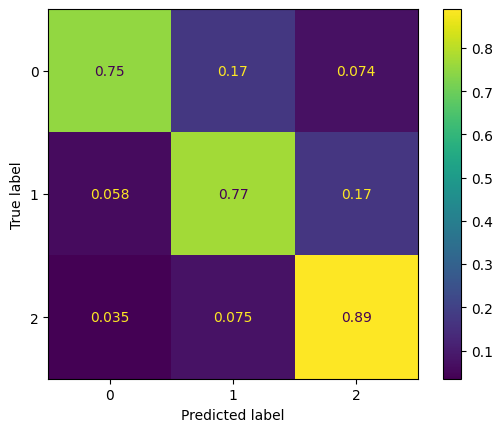

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.47314. Saving Model!
epoch 01, loss: 0.50842, acc: 0.79092, val_loss: 0.47314, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 02, loss: 0.50556, acc: 0.79299, val_loss: 0.47848, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 03, loss: 0.51242, acc: 0.78963, val_loss: 0.47894, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 04, loss: 0.50384, acc: 0.79360, val_loss: 0.48412, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 05, loss: 0.50226, acc: 0.79600, val_loss: 0.48629, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 06, loss: 0.50363, acc: 0.79472, val_loss: 0.48773, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 07, loss: 0.50023, acc: 0.79452, val_loss: 0.49123, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 08, loss: 0.50031, acc: 0.79476, val_loss: 0.49188, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 09, loss: 0.49935, acc: 0.79565, val_loss: 0.49411, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 10, loss: 0.49792, acc: 0.79483, val_loss: 0.49691, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 11, loss: 0.49831, acc: 0.79563, val_loss: 0.49759, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 12, loss: 0.49694, acc: 0.79683, val_loss: 0.49922, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 13, loss: 0.49659, acc: 0.79694, val_loss: 0.50084, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 14, loss: 0.49603, acc: 0.79694, val_loss: 0.50194, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 15, loss: 0.49520, acc: 0.79731, val_loss: 0.50368, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 16, loss: 0.49524, acc: 0.79736, val_loss: 0.50490, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 17, loss: 0.49416, acc: 0.79771, val_loss: 0.50624, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 18, loss: 0.49395, acc: 0.79764, val_loss: 0.50758, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 19, loss: 0.49371, acc: 0.79862, val_loss: 0.50827, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 20, loss: 0.49295, acc: 0.80002, val_loss: 0.50998, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 21, loss: 0.49278, acc: 0.80028, val_loss: 0.51106, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 22, loss: 0.49238, acc: 0.80037, val_loss: 0.51218, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 23, loss: 0.49187, acc: 0.80032, val_loss: 0.51350, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 24, loss: 0.49168, acc: 0.80021, val_loss: 0.51429, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 25, loss: 0.49109, acc: 0.80063, val_loss: 0.51552, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 26, loss: 0.49074, acc: 0.80146, val_loss: 0.51661, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 27, loss: 0.49060, acc: 0.80165, val_loss: 0.51754, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 28, loss: 0.49014, acc: 0.80207, val_loss: 0.51882, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 29, loss: 0.48988, acc: 0.80200, val_loss: 0.51954, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 30, loss: 0.48926, acc: 0.80242, val_loss: 0.52058, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 31, loss: 0.48944, acc: 0.80111, val_loss: 0.52115, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 32, loss: 0.48876, acc: 0.80279, val_loss: 0.52227, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 33, loss: 0.48857, acc: 0.80351, val_loss: 0.52323, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 34, loss: 0.48829, acc: 0.80438, val_loss: 0.52380, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 35, loss: 0.48805, acc: 0.80438, val_loss: 0.52438, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 36, loss: 0.48751, acc: 0.80453, val_loss: 0.52572, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 37, loss: 0.48749, acc: 0.80307, val_loss: 0.52632, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 38, loss: 0.48712, acc: 0.80427, val_loss: 0.52674, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 39, loss: 0.48658, acc: 0.80503, val_loss: 0.52801, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 40, loss: 0.48658, acc: 0.80451, val_loss: 0.52876, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 41, loss: 0.48642, acc: 0.80355, val_loss: 0.52902, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 42, loss: 0.48564, acc: 0.80458, val_loss: 0.53049, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 43, loss: 0.48605, acc: 0.80460, val_loss: 0.53084, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 44, loss: 0.48487, acc: 0.80475, val_loss: 0.53207, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 45, loss: 0.48561, acc: 0.80353, val_loss: 0.53243, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 46, loss: 0.48496, acc: 0.80462, val_loss: 0.53342, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 47, loss: 0.48453, acc: 0.80495, val_loss: 0.53442, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 48, loss: 0.48448, acc: 0.80364, val_loss: 0.53513, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 49, loss: 0.48410, acc: 0.80495, val_loss: 0.53589, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 50, loss: 0.48387, acc: 0.80434, val_loss: 0.53658, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 51, loss: 0.48357, acc: 0.80401, val_loss: 0.53782, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 52, loss: 0.48352, acc: 0.80521, val_loss: 0.53778, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 53, loss: 0.48284, acc: 0.80545, val_loss: 0.53922, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 54, loss: 0.48288, acc: 0.80331, val_loss: 0.53929, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 55, loss: 0.48251, acc: 0.80447, val_loss: 0.54044, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 56, loss: 0.48228, acc: 0.80431, val_loss: 0.54131, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 57, loss: 0.48211, acc: 0.80366, val_loss: 0.54169, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 58, loss: 0.48183, acc: 0.80460, val_loss: 0.54238, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 59, loss: 0.48134, acc: 0.80490, val_loss: 0.54321, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 60, loss: 0.48146, acc: 0.80407, val_loss: 0.54355, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 61, loss: 0.48102, acc: 0.80501, val_loss: 0.54395, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 62, loss: 0.48077, acc: 0.80608, val_loss: 0.54521, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 63, loss: 0.48054, acc: 0.80630, val_loss: 0.54585, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 64, loss: 0.48060, acc: 0.80599, val_loss: 0.54537, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 65, loss: 0.48018, acc: 0.80671, val_loss: 0.54687, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 66, loss: 0.47981, acc: 0.80667, val_loss: 0.54763, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 67, loss: 0.47961, acc: 0.80665, val_loss: 0.54782, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 68, loss: 0.47974, acc: 0.80641, val_loss: 0.54879, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 69, loss: 0.47884, acc: 0.80765, val_loss: 0.54981, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 70, loss: 0.47911, acc: 0.80689, val_loss: 0.54970, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 71, loss: 0.47875, acc: 0.80680, val_loss: 0.55065, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 72, loss: 0.47837, acc: 0.80809, val_loss: 0.55125, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 73, loss: 0.47848, acc: 0.80835, val_loss: 0.55157, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 74, loss: 0.47790, acc: 0.80820, val_loss: 0.55230, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 75, loss: 0.47802, acc: 0.80809, val_loss: 0.55270, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 76, loss: 0.47749, acc: 0.80837, val_loss: 0.55313, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 77, loss: 0.47750, acc: 0.80822, val_loss: 0.55334, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 78, loss: 0.47733, acc: 0.80905, val_loss: 0.55401, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 79, loss: 0.47665, acc: 0.80756, val_loss: 0.55512, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 80, loss: 0.47697, acc: 0.80859, val_loss: 0.55525, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 81, loss: 0.47634, acc: 0.80914, val_loss: 0.55562, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 82, loss: 0.47662, acc: 0.80933, val_loss: 0.55581, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 83, loss: 0.47586, acc: 0.80903, val_loss: 0.55673, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 84, loss: 0.47624, acc: 0.80903, val_loss: 0.55721, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 85, loss: 0.47536, acc: 0.80920, val_loss: 0.55734, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 86, loss: 0.47569, acc: 0.80922, val_loss: 0.55810, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 87, loss: 0.47523, acc: 0.80929, val_loss: 0.55796, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 88, loss: 0.47523, acc: 0.80944, val_loss: 0.55826, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 89, loss: 0.47460, acc: 0.80959, val_loss: 0.55949, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 90, loss: 0.47482, acc: 0.80948, val_loss: 0.55925, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 91, loss: 0.47448, acc: 0.80968, val_loss: 0.55953, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 92, loss: 0.47410, acc: 0.80999, val_loss: 0.56058, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 93, loss: 0.47434, acc: 0.80986, val_loss: 0.56063, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 94, loss: 0.47336, acc: 0.81012, val_loss: 0.56107, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 95, loss: 0.47401, acc: 0.80992, val_loss: 0.56146, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 96, loss: 0.47315, acc: 0.81027, val_loss: 0.56229, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 97, loss: 0.47325, acc: 0.81029, val_loss: 0.56246, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 98, loss: 0.47321, acc: 0.81020, val_loss: 0.56251, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 99, loss: 0.47265, acc: 0.81042, val_loss: 0.56297, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 100, loss: 0.47251, acc: 0.81055, val_loss: 0.56353, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 101, loss: 0.47257, acc: 0.81007, val_loss: 0.56308, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


epoch 102, loss: 0.47203, acc: 0.81073, val_loss: 0.56430, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 103, loss: 0.47198, acc: 0.81031, val_loss: 0.56499, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 104, loss: 0.47205, acc: 0.81123, val_loss: 0.56477, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 105, loss: 0.47138, acc: 0.81066, val_loss: 0.56542, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 106, loss: 0.47153, acc: 0.81110, val_loss: 0.56566, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 107, loss: 0.47125, acc: 0.81077, val_loss: 0.56628, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 108, loss: 0.47106, acc: 0.81095, val_loss: 0.56652, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 109, loss: 0.47026, acc: 0.81129, val_loss: 0.56707, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 110, loss: 0.47117, acc: 0.81105, val_loss: 0.56676, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 111, loss: 0.47010, acc: 0.81140, val_loss: 0.56841, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 112, loss: 0.47042, acc: 0.81151, val_loss: 0.56891, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 113, loss: 0.47004, acc: 0.81121, val_loss: 0.56822, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 114, loss: 0.46993, acc: 0.81162, val_loss: 0.56871, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 115, loss: 0.46936, acc: 0.81145, val_loss: 0.56943, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 116, loss: 0.46971, acc: 0.81136, val_loss: 0.56961, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 117, loss: 0.46936, acc: 0.81134, val_loss: 0.57004, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 118, loss: 0.46873, acc: 0.81195, val_loss: 0.57035, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 119, loss: 0.46910, acc: 0.81143, val_loss: 0.57109, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 120, loss: 0.46866, acc: 0.81195, val_loss: 0.57164, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 121, loss: 0.46854, acc: 0.81228, val_loss: 0.57163, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 122, loss: 0.46823, acc: 0.81217, val_loss: 0.57264, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 123, loss: 0.46839, acc: 0.81212, val_loss: 0.57238, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 124, loss: 0.46768, acc: 0.81271, val_loss: 0.57223, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 125, loss: 0.46788, acc: 0.81252, val_loss: 0.57274, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 126, loss: 0.46746, acc: 0.81273, val_loss: 0.57338, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 127, loss: 0.46744, acc: 0.81271, val_loss: 0.57419, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 128, loss: 0.46700, acc: 0.81319, val_loss: 0.57417, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 129, loss: 0.46712, acc: 0.81254, val_loss: 0.57365, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 130, loss: 0.46658, acc: 0.81326, val_loss: 0.57489, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 131, loss: 0.46642, acc: 0.81311, val_loss: 0.57569, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 132, loss: 0.46659, acc: 0.81321, val_loss: 0.57501, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 133, loss: 0.46611, acc: 0.81319, val_loss: 0.57535, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 134, loss: 0.46541, acc: 0.81383, val_loss: 0.57676, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 135, loss: 0.46630, acc: 0.81313, val_loss: 0.57569, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 136, loss: 0.46530, acc: 0.81391, val_loss: 0.57686, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 137, loss: 0.46550, acc: 0.81372, val_loss: 0.57743, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 138, loss: 0.46530, acc: 0.81376, val_loss: 0.57702, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 139, loss: 0.46505, acc: 0.81367, val_loss: 0.57803, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 140, loss: 0.46434, acc: 0.81444, val_loss: 0.57762, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 141, loss: 0.46520, acc: 0.81356, val_loss: 0.57776, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 142, loss: 0.46385, acc: 0.81439, val_loss: 0.57906, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 143, loss: 0.46453, acc: 0.81404, val_loss: 0.57841, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 144, loss: 0.46370, acc: 0.81448, val_loss: 0.57903, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 145, loss: 0.46392, acc: 0.81441, val_loss: 0.57936, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 146, loss: 0.46360, acc: 0.81452, val_loss: 0.58031, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 147, loss: 0.46340, acc: 0.81452, val_loss: 0.57977, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 148, loss: 0.46336, acc: 0.81457, val_loss: 0.58015, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 149, loss: 0.46303, acc: 0.81448, val_loss: 0.58080, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 150, loss: 0.46284, acc: 0.81478, val_loss: 0.58103, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 151, loss: 0.46286, acc: 0.81478, val_loss: 0.58087, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 152, loss: 0.46230, acc: 0.81507, val_loss: 0.58145, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 153, loss: 0.46249, acc: 0.81474, val_loss: 0.58171, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 154, loss: 0.46215, acc: 0.81511, val_loss: 0.58230, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 155, loss: 0.46198, acc: 0.81496, val_loss: 0.58314, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 156, loss: 0.46172, acc: 0.81529, val_loss: 0.58252, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 157, loss: 0.46162, acc: 0.81505, val_loss: 0.58261, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 158, loss: 0.46150, acc: 0.81520, val_loss: 0.58348, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 159, loss: 0.46112, acc: 0.81542, val_loss: 0.58342, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 160, loss: 0.46135, acc: 0.81531, val_loss: 0.58344, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 161, loss: 0.46073, acc: 0.81531, val_loss: 0.58440, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 162, loss: 0.46103, acc: 0.81561, val_loss: 0.58488, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 163, loss: 0.46051, acc: 0.81533, val_loss: 0.58465, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 164, loss: 0.46043, acc: 0.81570, val_loss: 0.58450, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 165, loss: 0.46032, acc: 0.81550, val_loss: 0.58600, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 166, loss: 0.46017, acc: 0.81588, val_loss: 0.58542, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 167, loss: 0.45975, acc: 0.81555, val_loss: 0.58590, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 168, loss: 0.46001, acc: 0.81596, val_loss: 0.58618, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 169, loss: 0.45915, acc: 0.81627, val_loss: 0.58684, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 170, loss: 0.45997, acc: 0.81548, val_loss: 0.58594, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 171, loss: 0.45863, acc: 0.81618, val_loss: 0.58764, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 172, loss: 0.45945, acc: 0.81579, val_loss: 0.58725, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 173, loss: 0.45848, acc: 0.81627, val_loss: 0.58809, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 174, loss: 0.45888, acc: 0.81620, val_loss: 0.58838, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 175, loss: 0.45818, acc: 0.81631, val_loss: 0.58826, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 176, loss: 0.45864, acc: 0.81620, val_loss: 0.58784, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 177, loss: 0.45802, acc: 0.81646, val_loss: 0.58877, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 178, loss: 0.45798, acc: 0.81636, val_loss: 0.58957, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 179, loss: 0.45807, acc: 0.81636, val_loss: 0.58879, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 180, loss: 0.45764, acc: 0.81666, val_loss: 0.58940, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 181, loss: 0.45714, acc: 0.81684, val_loss: 0.59016, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 182, loss: 0.45782, acc: 0.81640, val_loss: 0.59020, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 183, loss: 0.45676, acc: 0.81721, val_loss: 0.59046, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 184, loss: 0.45716, acc: 0.81703, val_loss: 0.59072, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 185, loss: 0.45666, acc: 0.81703, val_loss: 0.59108, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 186, loss: 0.45670, acc: 0.81694, val_loss: 0.59080, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 187, loss: 0.45617, acc: 0.81712, val_loss: 0.59150, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 188, loss: 0.45668, acc: 0.81701, val_loss: 0.59106, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 189, loss: 0.45567, acc: 0.81747, val_loss: 0.59282, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 190, loss: 0.45623, acc: 0.81723, val_loss: 0.59177, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 191, loss: 0.45552, acc: 0.81747, val_loss: 0.59322, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 192, loss: 0.45597, acc: 0.81729, val_loss: 0.59330, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


epoch 193, loss: 0.45504, acc: 0.81797, val_loss: 0.59345, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 194, loss: 0.45593, acc: 0.81727, val_loss: 0.59393, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 195, loss: 0.45445, acc: 0.81801, val_loss: 0.59453, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 196, loss: 0.45528, acc: 0.81769, val_loss: 0.59394, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 197, loss: 0.45430, acc: 0.81795, val_loss: 0.59438, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 198, loss: 0.45489, acc: 0.81751, val_loss: 0.59499, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 199, loss: 0.45372, acc: 0.81810, val_loss: 0.59551, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 200, loss: 0.45473, acc: 0.81806, val_loss: 0.59438, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 201, loss: 0.45337, acc: 0.81799, val_loss: 0.59615, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 202, loss: 0.45384, acc: 0.81777, val_loss: 0.59616, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 203, loss: 0.45358, acc: 0.81817, val_loss: 0.59619, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 204, loss: 0.45364, acc: 0.81806, val_loss: 0.59710, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 205, loss: 0.45309, acc: 0.81775, val_loss: 0.59667, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 206, loss: 0.45326, acc: 0.81832, val_loss: 0.59708, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 207, loss: 0.45264, acc: 0.81854, val_loss: 0.59742, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 208, loss: 0.45304, acc: 0.81913, val_loss: 0.59786, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 209, loss: 0.45253, acc: 0.81856, val_loss: 0.59864, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 210, loss: 0.45261, acc: 0.81856, val_loss: 0.59827, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 211, loss: 0.45212, acc: 0.81873, val_loss: 0.59898, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 212, loss: 0.45234, acc: 0.81847, val_loss: 0.59855, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 213, loss: 0.45201, acc: 0.81865, val_loss: 0.59846, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 214, loss: 0.45184, acc: 0.81830, val_loss: 0.59945, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 215, loss: 0.45126, acc: 0.81889, val_loss: 0.59981, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 216, loss: 0.45211, acc: 0.81928, val_loss: 0.59883, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 217, loss: 0.45093, acc: 0.81875, val_loss: 0.60026, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 218, loss: 0.45151, acc: 0.81961, val_loss: 0.59979, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 219, loss: 0.45056, acc: 0.82017, val_loss: 0.59963, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 220, loss: 0.45108, acc: 0.81832, val_loss: 0.60066, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 221, loss: 0.45043, acc: 0.81915, val_loss: 0.60063, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 222, loss: 0.45038, acc: 0.81926, val_loss: 0.60126, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 223, loss: 0.45078, acc: 0.81930, val_loss: 0.60152, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 224, loss: 0.44949, acc: 0.81965, val_loss: 0.60189, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 225, loss: 0.45063, acc: 0.82006, val_loss: 0.60122, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 226, loss: 0.44948, acc: 0.82000, val_loss: 0.60288, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 227, loss: 0.45005, acc: 0.81989, val_loss: 0.60156, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 228, loss: 0.44952, acc: 0.81971, val_loss: 0.60275, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 229, loss: 0.44929, acc: 0.82074, val_loss: 0.60295, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 230, loss: 0.44921, acc: 0.82061, val_loss: 0.60284, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 231, loss: 0.44878, acc: 0.82026, val_loss: 0.60297, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 232, loss: 0.44876, acc: 0.81995, val_loss: 0.60406, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 233, loss: 0.44872, acc: 0.82126, val_loss: 0.60341, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 234, loss: 0.44859, acc: 0.82076, val_loss: 0.60408, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 235, loss: 0.44831, acc: 0.82057, val_loss: 0.60349, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 236, loss: 0.44804, acc: 0.82139, val_loss: 0.60459, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 237, loss: 0.44857, acc: 0.82120, val_loss: 0.60394, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 238, loss: 0.44738, acc: 0.82037, val_loss: 0.60595, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 239, loss: 0.44811, acc: 0.82118, val_loss: 0.60462, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 240, loss: 0.44764, acc: 0.82109, val_loss: 0.60523, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 241, loss: 0.44717, acc: 0.82155, val_loss: 0.60551, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 242, loss: 0.44744, acc: 0.82137, val_loss: 0.60644, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 243, loss: 0.44682, acc: 0.82126, val_loss: 0.60588, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 244, loss: 0.44718, acc: 0.82146, val_loss: 0.60614, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 245, loss: 0.44647, acc: 0.82194, val_loss: 0.60714, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 246, loss: 0.44666, acc: 0.82181, val_loss: 0.60696, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 247, loss: 0.44665, acc: 0.82187, val_loss: 0.60646, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 248, loss: 0.44571, acc: 0.82225, val_loss: 0.60730, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 249, loss: 0.44659, acc: 0.82161, val_loss: 0.60772, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 250, loss: 0.44568, acc: 0.82266, val_loss: 0.60765, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 251, loss: 0.44579, acc: 0.82209, val_loss: 0.60864, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 252, loss: 0.44529, acc: 0.82270, val_loss: 0.60819, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 253, loss: 0.44575, acc: 0.82214, val_loss: 0.60856, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 254, loss: 0.44493, acc: 0.82327, val_loss: 0.60999, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


epoch 255, loss: 0.44520, acc: 0.82242, val_loss: 0.60866, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 256, loss: 0.44512, acc: 0.82294, val_loss: 0.60916, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 257, loss: 0.44468, acc: 0.82266, val_loss: 0.60972, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 258, loss: 0.44428, acc: 0.82379, val_loss: 0.60958, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 259, loss: 0.44519, acc: 0.82248, val_loss: 0.60992, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 260, loss: 0.44362, acc: 0.82382, val_loss: 0.61048, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 261, loss: 0.44464, acc: 0.82259, val_loss: 0.61085, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 262, loss: 0.44403, acc: 0.82312, val_loss: 0.60958, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 263, loss: 0.44347, acc: 0.82331, val_loss: 0.61196, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 264, loss: 0.44358, acc: 0.82399, val_loss: 0.61054, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 265, loss: 0.44357, acc: 0.82340, val_loss: 0.61120, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 266, loss: 0.44344, acc: 0.82382, val_loss: 0.61162, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 267, loss: 0.44295, acc: 0.82327, val_loss: 0.61218, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 268, loss: 0.44300, acc: 0.82414, val_loss: 0.61101, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 269, loss: 0.44318, acc: 0.82334, val_loss: 0.61238, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 270, loss: 0.44201, acc: 0.82436, val_loss: 0.61336, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 271, loss: 0.44304, acc: 0.82382, val_loss: 0.61238, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 272, loss: 0.44169, acc: 0.82480, val_loss: 0.61385, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 273, loss: 0.44269, acc: 0.82419, val_loss: 0.61347, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 274, loss: 0.44170, acc: 0.82510, val_loss: 0.61403, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 275, loss: 0.44217, acc: 0.82454, val_loss: 0.61343, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 276, loss: 0.44122, acc: 0.82480, val_loss: 0.61438, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 277, loss: 0.44204, acc: 0.82447, val_loss: 0.61487, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 278, loss: 0.44124, acc: 0.82528, val_loss: 0.61433, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 279, loss: 0.44139, acc: 0.82467, val_loss: 0.61523, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 280, loss: 0.44085, acc: 0.82584, val_loss: 0.61486, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 281, loss: 0.44121, acc: 0.82528, val_loss: 0.61627, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 282, loss: 0.43991, acc: 0.82595, val_loss: 0.61666, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 283, loss: 0.44129, acc: 0.82519, val_loss: 0.61524, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 284, loss: 0.43999, acc: 0.82587, val_loss: 0.61662, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 285, loss: 0.44033, acc: 0.82593, val_loss: 0.61635, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 286, loss: 0.44011, acc: 0.82567, val_loss: 0.61668, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 287, loss: 0.44008, acc: 0.82571, val_loss: 0.61719, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 288, loss: 0.43940, acc: 0.82608, val_loss: 0.61752, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 289, loss: 0.44025, acc: 0.82567, val_loss: 0.61726, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 290, loss: 0.43911, acc: 0.82669, val_loss: 0.61835, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 291, loss: 0.43991, acc: 0.82717, val_loss: 0.61800, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 292, loss: 0.43888, acc: 0.82630, val_loss: 0.61782, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 293, loss: 0.43935, acc: 0.82724, val_loss: 0.61874, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 294, loss: 0.43859, acc: 0.82661, val_loss: 0.61850, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 295, loss: 0.43876, acc: 0.82739, val_loss: 0.61933, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 296, loss: 0.43803, acc: 0.82794, val_loss: 0.61931, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 297, loss: 0.43884, acc: 0.82776, val_loss: 0.61942, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 298, loss: 0.43802, acc: 0.82796, val_loss: 0.61983, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 299, loss: 0.43814, acc: 0.82811, val_loss: 0.61949, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 300, loss: 0.43788, acc: 0.82761, val_loss: 0.61945, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 301, loss: 0.43760, acc: 0.82824, val_loss: 0.62136, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 302, loss: 0.43777, acc: 0.82779, val_loss: 0.61987, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 303, loss: 0.43752, acc: 0.82820, val_loss: 0.62114, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 304, loss: 0.43724, acc: 0.82846, val_loss: 0.62112, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 305, loss: 0.43717, acc: 0.82794, val_loss: 0.62123, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 306, loss: 0.43700, acc: 0.82831, val_loss: 0.62109, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 307, loss: 0.43684, acc: 0.82794, val_loss: 0.62262, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 308, loss: 0.43657, acc: 0.82872, val_loss: 0.62149, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 309, loss: 0.43666, acc: 0.82892, val_loss: 0.62295, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 310, loss: 0.43607, acc: 0.82870, val_loss: 0.62198, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 311, loss: 0.43629, acc: 0.82857, val_loss: 0.62261, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 312, loss: 0.43630, acc: 0.82864, val_loss: 0.62258, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 313, loss: 0.43539, acc: 0.82903, val_loss: 0.62352, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 314, loss: 0.43621, acc: 0.82866, val_loss: 0.62308, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 315, loss: 0.43535, acc: 0.82881, val_loss: 0.62397, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 316, loss: 0.43516, acc: 0.82927, val_loss: 0.62348, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 317, loss: 0.43564, acc: 0.82851, val_loss: 0.62333, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 318, loss: 0.43457, acc: 0.82903, val_loss: 0.62472, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 319, loss: 0.43512, acc: 0.82927, val_loss: 0.62376, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 320, loss: 0.43466, acc: 0.82920, val_loss: 0.62446, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 321, loss: 0.43463, acc: 0.82916, val_loss: 0.62578, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 322, loss: 0.43438, acc: 0.82942, val_loss: 0.62435, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 323, loss: 0.43467, acc: 0.82929, val_loss: 0.62504, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 324, loss: 0.43378, acc: 0.82966, val_loss: 0.62573, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 325, loss: 0.43392, acc: 0.82955, val_loss: 0.62515, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 326, loss: 0.43389, acc: 0.82955, val_loss: 0.62556, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 327, loss: 0.43343, acc: 0.82938, val_loss: 0.62680, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 328, loss: 0.43378, acc: 0.82925, val_loss: 0.62568, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 329, loss: 0.43336, acc: 0.82957, val_loss: 0.62648, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 330, loss: 0.43293, acc: 0.83047, val_loss: 0.62755, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 331, loss: 0.43342, acc: 0.82949, val_loss: 0.62650, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 332, loss: 0.43285, acc: 0.83001, val_loss: 0.62716, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 333, loss: 0.43244, acc: 0.83053, val_loss: 0.62876, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 334, loss: 0.43301, acc: 0.82984, val_loss: 0.62687, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 335, loss: 0.43214, acc: 0.83097, val_loss: 0.62803, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 336, loss: 0.43273, acc: 0.83071, val_loss: 0.62808, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 337, loss: 0.43184, acc: 0.83073, val_loss: 0.62898, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 338, loss: 0.43244, acc: 0.82968, val_loss: 0.62842, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 339, loss: 0.43136, acc: 0.83084, val_loss: 0.62797, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 340, loss: 0.43205, acc: 0.83119, val_loss: 0.62876, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 341, loss: 0.43109, acc: 0.83101, val_loss: 0.62913, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 342, loss: 0.43193, acc: 0.83112, val_loss: 0.62855, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 343, loss: 0.43065, acc: 0.83169, val_loss: 0.63066, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 344, loss: 0.43181, acc: 0.83119, val_loss: 0.62983, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 345, loss: 0.43027, acc: 0.83162, val_loss: 0.63031, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 346, loss: 0.43169, acc: 0.83108, val_loss: 0.62985, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 347, loss: 0.42934, acc: 0.83152, val_loss: 0.63224, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 348, loss: 0.43210, acc: 0.83106, val_loss: 0.62852, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 349, loss: 0.42884, acc: 0.83243, val_loss: 0.63236, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 350, loss: 0.43151, acc: 0.83112, val_loss: 0.62999, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 351, loss: 0.42906, acc: 0.83138, val_loss: 0.63231, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 352, loss: 0.43047, acc: 0.83173, val_loss: 0.63024, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 353, loss: 0.42920, acc: 0.83180, val_loss: 0.63326, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 354, loss: 0.43021, acc: 0.83158, val_loss: 0.63113, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 355, loss: 0.42884, acc: 0.83173, val_loss: 0.63289, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 356, loss: 0.42971, acc: 0.83186, val_loss: 0.63169, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 357, loss: 0.42897, acc: 0.83160, val_loss: 0.63213, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 358, loss: 0.42925, acc: 0.83189, val_loss: 0.63208, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 359, loss: 0.42849, acc: 0.83206, val_loss: 0.63368, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 360, loss: 0.42874, acc: 0.83261, val_loss: 0.63280, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 361, loss: 0.42858, acc: 0.83200, val_loss: 0.63263, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 362, loss: 0.42837, acc: 0.83182, val_loss: 0.63357, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 363, loss: 0.42792, acc: 0.83200, val_loss: 0.63415, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 364, loss: 0.42877, acc: 0.83176, val_loss: 0.63261, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 365, loss: 0.42736, acc: 0.83341, val_loss: 0.63558, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 366, loss: 0.42833, acc: 0.83206, val_loss: 0.63324, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 367, loss: 0.42720, acc: 0.83204, val_loss: 0.63607, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 368, loss: 0.42804, acc: 0.83189, val_loss: 0.63276, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 369, loss: 0.42719, acc: 0.83228, val_loss: 0.63514, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 370, loss: 0.42707, acc: 0.83224, val_loss: 0.63359, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 371, loss: 0.42739, acc: 0.83278, val_loss: 0.63568, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 372, loss: 0.42673, acc: 0.83282, val_loss: 0.63470, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 373, loss: 0.42689, acc: 0.83206, val_loss: 0.63601, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 374, loss: 0.42679, acc: 0.83232, val_loss: 0.63517, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 375, loss: 0.42646, acc: 0.83232, val_loss: 0.63610, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 376, loss: 0.42640, acc: 0.83243, val_loss: 0.63586, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 377, loss: 0.42641, acc: 0.83232, val_loss: 0.63643, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 378, loss: 0.42555, acc: 0.83272, val_loss: 0.63713, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 379, loss: 0.42656, acc: 0.83239, val_loss: 0.63578, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 380, loss: 0.42538, acc: 0.83274, val_loss: 0.63746, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 381, loss: 0.42601, acc: 0.83263, val_loss: 0.63696, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 382, loss: 0.42536, acc: 0.83302, val_loss: 0.63636, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 383, loss: 0.42561, acc: 0.83274, val_loss: 0.63727, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 384, loss: 0.42511, acc: 0.83274, val_loss: 0.63840, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 385, loss: 0.42517, acc: 0.83326, val_loss: 0.63777, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 386, loss: 0.42498, acc: 0.83274, val_loss: 0.63771, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 387, loss: 0.42477, acc: 0.83274, val_loss: 0.63946, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 388, loss: 0.42466, acc: 0.83326, val_loss: 0.63749, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 389, loss: 0.42443, acc: 0.83361, val_loss: 0.63862, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 390, loss: 0.42411, acc: 0.83326, val_loss: 0.63899, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 391, loss: 0.42460, acc: 0.83311, val_loss: 0.63927, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 392, loss: 0.42395, acc: 0.83333, val_loss: 0.63948, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 393, loss: 0.42409, acc: 0.83300, val_loss: 0.63920, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 394, loss: 0.42352, acc: 0.83368, val_loss: 0.63915, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 395, loss: 0.42421, acc: 0.83376, val_loss: 0.64051, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 396, loss: 0.42330, acc: 0.83385, val_loss: 0.63995, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 397, loss: 0.42355, acc: 0.83346, val_loss: 0.64159, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 398, loss: 0.42311, acc: 0.83348, val_loss: 0.63979, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 399, loss: 0.42323, acc: 0.83357, val_loss: 0.64196, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 400, loss: 0.42237, acc: 0.83374, val_loss: 0.64015, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 401, loss: 0.42329, acc: 0.83317, val_loss: 0.64181, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 402, loss: 0.42183, acc: 0.83385, val_loss: 0.64282, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 403, loss: 0.42329, acc: 0.83405, val_loss: 0.64128, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 404, loss: 0.42174, acc: 0.83402, val_loss: 0.64215, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 405, loss: 0.42251, acc: 0.83398, val_loss: 0.64198, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 406, loss: 0.42199, acc: 0.83413, val_loss: 0.64194, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 407, loss: 0.42221, acc: 0.83365, val_loss: 0.64206, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 408, loss: 0.42165, acc: 0.83437, val_loss: 0.64254, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 409, loss: 0.42156, acc: 0.83444, val_loss: 0.64438, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 410, loss: 0.42182, acc: 0.83402, val_loss: 0.64308, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 411, loss: 0.42137, acc: 0.83418, val_loss: 0.64412, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 412, loss: 0.42132, acc: 0.83422, val_loss: 0.64179, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 413, loss: 0.42121, acc: 0.83529, val_loss: 0.64572, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 414, loss: 0.42049, acc: 0.83442, val_loss: 0.64278, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 415, loss: 0.42123, acc: 0.83422, val_loss: 0.64512, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 416, loss: 0.42046, acc: 0.83463, val_loss: 0.64357, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 417, loss: 0.42020, acc: 0.83520, val_loss: 0.64578, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 418, loss: 0.42021, acc: 0.83610, val_loss: 0.64440, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 419, loss: 0.42010, acc: 0.83459, val_loss: 0.64479, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 420, loss: 0.41995, acc: 0.83525, val_loss: 0.64481, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 421, loss: 0.41995, acc: 0.83549, val_loss: 0.64518, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 422, loss: 0.41932, acc: 0.83487, val_loss: 0.64529, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 423, loss: 0.41967, acc: 0.83575, val_loss: 0.64630, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 424, loss: 0.41924, acc: 0.83566, val_loss: 0.64571, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 425, loss: 0.41946, acc: 0.83540, val_loss: 0.64565, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 426, loss: 0.41912, acc: 0.83455, val_loss: 0.64644, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 427, loss: 0.41893, acc: 0.83610, val_loss: 0.64644, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 428, loss: 0.41885, acc: 0.83658, val_loss: 0.64683, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 429, loss: 0.41872, acc: 0.83575, val_loss: 0.64715, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 430, loss: 0.41904, acc: 0.83651, val_loss: 0.64596, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 431, loss: 0.41842, acc: 0.83568, val_loss: 0.64815, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 432, loss: 0.41818, acc: 0.83629, val_loss: 0.64590, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 433, loss: 0.41893, acc: 0.83555, val_loss: 0.64837, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 434, loss: 0.41720, acc: 0.83690, val_loss: 0.64864, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 435, loss: 0.41862, acc: 0.83466, val_loss: 0.64803, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 436, loss: 0.41733, acc: 0.83732, val_loss: 0.64741, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 437, loss: 0.41786, acc: 0.83583, val_loss: 0.64940, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 438, loss: 0.41727, acc: 0.83695, val_loss: 0.64739, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 439, loss: 0.41746, acc: 0.83745, val_loss: 0.64960, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 440, loss: 0.41724, acc: 0.83682, val_loss: 0.64759, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 441, loss: 0.41728, acc: 0.83594, val_loss: 0.64992, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 442, loss: 0.41663, acc: 0.83690, val_loss: 0.64922, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 443, loss: 0.41697, acc: 0.83658, val_loss: 0.65008, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 444, loss: 0.41640, acc: 0.83767, val_loss: 0.64842, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 445, loss: 0.41664, acc: 0.83743, val_loss: 0.65036, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 446, loss: 0.41573, acc: 0.83819, val_loss: 0.65080, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 447, loss: 0.41647, acc: 0.83664, val_loss: 0.64991, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 448, loss: 0.41584, acc: 0.83771, val_loss: 0.65071, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 449, loss: 0.41587, acc: 0.83677, val_loss: 0.65158, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 450, loss: 0.41591, acc: 0.83745, val_loss: 0.65028, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 451, loss: 0.41554, acc: 0.83706, val_loss: 0.65088, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 452, loss: 0.41500, acc: 0.83751, val_loss: 0.65132, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 453, loss: 0.41575, acc: 0.83708, val_loss: 0.65189, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 454, loss: 0.41521, acc: 0.83714, val_loss: 0.65205, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 455, loss: 0.41538, acc: 0.83817, val_loss: 0.65116, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 456, loss: 0.41441, acc: 0.83821, val_loss: 0.65239, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 457, loss: 0.41516, acc: 0.83714, val_loss: 0.65336, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 458, loss: 0.41462, acc: 0.83889, val_loss: 0.65156, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 459, loss: 0.41447, acc: 0.83817, val_loss: 0.65502, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 460, loss: 0.41448, acc: 0.83769, val_loss: 0.65081, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 461, loss: 0.41412, acc: 0.83832, val_loss: 0.65428, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 462, loss: 0.41381, acc: 0.83943, val_loss: 0.65278, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 463, loss: 0.41421, acc: 0.83703, val_loss: 0.65404, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 464, loss: 0.41359, acc: 0.83834, val_loss: 0.65446, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 465, loss: 0.41395, acc: 0.83860, val_loss: 0.65314, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 466, loss: 0.41310, acc: 0.83972, val_loss: 0.65476, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 467, loss: 0.41396, acc: 0.83891, val_loss: 0.65413, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 468, loss: 0.41309, acc: 0.83900, val_loss: 0.65400, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 469, loss: 0.41337, acc: 0.83876, val_loss: 0.65593, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 470, loss: 0.41228, acc: 0.83967, val_loss: 0.65458, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 471, loss: 0.41358, acc: 0.83856, val_loss: 0.65576, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 472, loss: 0.41218, acc: 0.83956, val_loss: 0.65625, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 473, loss: 0.41312, acc: 0.83869, val_loss: 0.65499, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 474, loss: 0.41205, acc: 0.83978, val_loss: 0.65599, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 475, loss: 0.41232, acc: 0.83913, val_loss: 0.65692, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 476, loss: 0.41190, acc: 0.83963, val_loss: 0.65660, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 477, loss: 0.41190, acc: 0.83948, val_loss: 0.65819, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 478, loss: 0.41218, acc: 0.83998, val_loss: 0.65463, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 479, loss: 0.41146, acc: 0.83948, val_loss: 0.65808, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 480, loss: 0.41139, acc: 0.84042, val_loss: 0.65651, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 481, loss: 0.41151, acc: 0.83924, val_loss: 0.65940, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 482, loss: 0.41137, acc: 0.84022, val_loss: 0.65721, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 483, loss: 0.41067, acc: 0.83994, val_loss: 0.66000, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 484, loss: 0.41160, acc: 0.84044, val_loss: 0.65638, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 485, loss: 0.40982, acc: 0.84057, val_loss: 0.66125, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 486, loss: 0.41153, acc: 0.84048, val_loss: 0.65682, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 487, loss: 0.40983, acc: 0.83996, val_loss: 0.66084, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 488, loss: 0.41057, acc: 0.84085, val_loss: 0.65844, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 489, loss: 0.41020, acc: 0.84002, val_loss: 0.66002, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 490, loss: 0.41044, acc: 0.84042, val_loss: 0.65952, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 491, loss: 0.40955, acc: 0.84083, val_loss: 0.66094, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 492, loss: 0.41044, acc: 0.84042, val_loss: 0.66041, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 493, loss: 0.40905, acc: 0.84076, val_loss: 0.66136, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 494, loss: 0.41019, acc: 0.84044, val_loss: 0.65934, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 495, loss: 0.40892, acc: 0.84072, val_loss: 0.66163, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 496, loss: 0.40950, acc: 0.84072, val_loss: 0.65998, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 497, loss: 0.40898, acc: 0.84046, val_loss: 0.66343, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 498, loss: 0.40906, acc: 0.84155, val_loss: 0.66025, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 499, loss: 0.40881, acc: 0.84068, val_loss: 0.66187, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 500, loss: 0.40873, acc: 0.84168, val_loss: 0.66025, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 501, loss: 0.40805, acc: 0.84116, val_loss: 0.66334, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 502, loss: 0.40920, acc: 0.84129, val_loss: 0.66162, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 503, loss: 0.40759, acc: 0.84118, val_loss: 0.66536, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 504, loss: 0.40913, acc: 0.84142, val_loss: 0.66041, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 505, loss: 0.40726, acc: 0.84157, val_loss: 0.66456, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 506, loss: 0.40840, acc: 0.84155, val_loss: 0.66229, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 507, loss: 0.40757, acc: 0.84135, val_loss: 0.66425, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 508, loss: 0.40772, acc: 0.84179, val_loss: 0.66336, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 509, loss: 0.40718, acc: 0.84151, val_loss: 0.66302, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 510, loss: 0.40770, acc: 0.84229, val_loss: 0.66351, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 511, loss: 0.40679, acc: 0.84153, val_loss: 0.66578, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 512, loss: 0.40758, acc: 0.84192, val_loss: 0.66350, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 513, loss: 0.40645, acc: 0.84164, val_loss: 0.66555, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 514, loss: 0.40680, acc: 0.84216, val_loss: 0.66420, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 515, loss: 0.40709, acc: 0.84138, val_loss: 0.66608, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 516, loss: 0.40635, acc: 0.84257, val_loss: 0.66511, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 517, loss: 0.40627, acc: 0.84207, val_loss: 0.66650, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 518, loss: 0.40670, acc: 0.84240, val_loss: 0.66512, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 519, loss: 0.40590, acc: 0.84192, val_loss: 0.66824, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 520, loss: 0.40657, acc: 0.84238, val_loss: 0.66432, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 521, loss: 0.40557, acc: 0.84194, val_loss: 0.66723, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 522, loss: 0.40573, acc: 0.84299, val_loss: 0.66634, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 523, loss: 0.40590, acc: 0.84196, val_loss: 0.66753, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 524, loss: 0.40530, acc: 0.84273, val_loss: 0.66699, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 525, loss: 0.40495, acc: 0.84244, val_loss: 0.66775, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 526, loss: 0.40551, acc: 0.84266, val_loss: 0.66633, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 527, loss: 0.40491, acc: 0.84220, val_loss: 0.66926, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 528, loss: 0.40512, acc: 0.84323, val_loss: 0.66717, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 529, loss: 0.40472, acc: 0.84227, val_loss: 0.66866, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 530, loss: 0.40461, acc: 0.84338, val_loss: 0.66879, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 531, loss: 0.40481, acc: 0.84255, val_loss: 0.66974, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 532, loss: 0.40430, acc: 0.84336, val_loss: 0.66856, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 533, loss: 0.40483, acc: 0.84233, val_loss: 0.66932, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 534, loss: 0.40400, acc: 0.84314, val_loss: 0.66834, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 535, loss: 0.40417, acc: 0.84244, val_loss: 0.67091, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 536, loss: 0.40373, acc: 0.84362, val_loss: 0.66873, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 537, loss: 0.40469, acc: 0.84223, val_loss: 0.66985, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 538, loss: 0.40261, acc: 0.84425, val_loss: 0.66998, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 539, loss: 0.40466, acc: 0.84253, val_loss: 0.67027, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 540, loss: 0.40238, acc: 0.84362, val_loss: 0.67119, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 541, loss: 0.40451, acc: 0.84286, val_loss: 0.67129, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 542, loss: 0.40201, acc: 0.84467, val_loss: 0.67189, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 543, loss: 0.40401, acc: 0.84299, val_loss: 0.67022, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 544, loss: 0.40149, acc: 0.84436, val_loss: 0.67234, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 545, loss: 0.40353, acc: 0.84332, val_loss: 0.67186, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 546, loss: 0.40166, acc: 0.84417, val_loss: 0.67343, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 547, loss: 0.40343, acc: 0.84338, val_loss: 0.67213, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 548, loss: 0.40109, acc: 0.84441, val_loss: 0.67378, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 549, loss: 0.40338, acc: 0.84332, val_loss: 0.67181, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 550, loss: 0.40051, acc: 0.84495, val_loss: 0.67521, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 551, loss: 0.40353, acc: 0.84358, val_loss: 0.67154, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 552, loss: 0.40055, acc: 0.84471, val_loss: 0.67542, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 553, loss: 0.40292, acc: 0.84375, val_loss: 0.67279, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 554, loss: 0.40078, acc: 0.84530, val_loss: 0.67542, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 555, loss: 0.40300, acc: 0.84336, val_loss: 0.67357, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 556, loss: 0.40028, acc: 0.84535, val_loss: 0.67530, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 557, loss: 0.40270, acc: 0.84343, val_loss: 0.67577, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 558, loss: 0.39935, acc: 0.84517, val_loss: 0.67778, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 559, loss: 0.40349, acc: 0.84347, val_loss: 0.67359, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 560, loss: 0.39868, acc: 0.84600, val_loss: 0.67836, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 561, loss: 0.40322, acc: 0.84388, val_loss: 0.67481, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 562, loss: 0.39790, acc: 0.84565, val_loss: 0.68091, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 563, loss: 0.40319, acc: 0.84345, val_loss: 0.67412, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 564, loss: 0.39812, acc: 0.84604, val_loss: 0.67964, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 565, loss: 0.40268, acc: 0.84290, val_loss: 0.67420, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 566, loss: 0.39759, acc: 0.84692, val_loss: 0.67999, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 567, loss: 0.40279, acc: 0.84430, val_loss: 0.67574, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 568, loss: 0.39736, acc: 0.84637, val_loss: 0.68170, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 569, loss: 0.40273, acc: 0.84456, val_loss: 0.67511, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 570, loss: 0.39666, acc: 0.84733, val_loss: 0.68292, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 571, loss: 0.40263, acc: 0.84493, val_loss: 0.67463, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 572, loss: 0.39660, acc: 0.84635, val_loss: 0.68221, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 573, loss: 0.40207, acc: 0.84358, val_loss: 0.67524, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 574, loss: 0.39642, acc: 0.84700, val_loss: 0.68246, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 575, loss: 0.40217, acc: 0.84338, val_loss: 0.67671, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 576, loss: 0.39608, acc: 0.84661, val_loss: 0.68340, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 577, loss: 0.40232, acc: 0.84476, val_loss: 0.67602, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 578, loss: 0.39556, acc: 0.84735, val_loss: 0.68268, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 579, loss: 0.40139, acc: 0.84517, val_loss: 0.67807, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 580, loss: 0.39537, acc: 0.84783, val_loss: 0.68425, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 581, loss: 0.40084, acc: 0.84395, val_loss: 0.67781, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 582, loss: 0.39546, acc: 0.84668, val_loss: 0.68535, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 583, loss: 0.40081, acc: 0.84537, val_loss: 0.67747, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 584, loss: 0.39494, acc: 0.84737, val_loss: 0.68574, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 585, loss: 0.40075, acc: 0.84556, val_loss: 0.67793, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 586, loss: 0.39453, acc: 0.84766, val_loss: 0.68631, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 587, loss: 0.40080, acc: 0.84521, val_loss: 0.67787, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 588, loss: 0.39434, acc: 0.84770, val_loss: 0.68766, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 589, loss: 0.40014, acc: 0.84441, val_loss: 0.67895, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 590, loss: 0.39410, acc: 0.84744, val_loss: 0.68701, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 591, loss: 0.40061, acc: 0.84417, val_loss: 0.67864, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 592, loss: 0.39278, acc: 0.84807, val_loss: 0.68883, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 593, loss: 0.40123, acc: 0.84399, val_loss: 0.67694, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 594, loss: 0.39290, acc: 0.84779, val_loss: 0.68981, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 595, loss: 0.40021, acc: 0.84476, val_loss: 0.68012, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 596, loss: 0.39283, acc: 0.84825, val_loss: 0.68904, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


epoch 597, loss: 0.39946, acc: 0.84449, val_loss: 0.68119, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 598, loss: 0.39278, acc: 0.84831, val_loss: 0.68814, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 599, loss: 0.39903, acc: 0.84617, val_loss: 0.68138, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 600, loss: 0.39220, acc: 0.84853, val_loss: 0.69038, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 601, loss: 0.39869, acc: 0.84613, val_loss: 0.68142, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 602, loss: 0.39242, acc: 0.84768, val_loss: 0.68988, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 603, loss: 0.39829, acc: 0.84550, val_loss: 0.68058, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 604, loss: 0.39185, acc: 0.84842, val_loss: 0.69056, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 605, loss: 0.39793, acc: 0.84637, val_loss: 0.68332, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 606, loss: 0.39190, acc: 0.84825, val_loss: 0.68976, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 607, loss: 0.39746, acc: 0.84674, val_loss: 0.68425, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 608, loss: 0.39166, acc: 0.84862, val_loss: 0.69136, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 609, loss: 0.39737, acc: 0.84537, val_loss: 0.68420, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 610, loss: 0.39180, acc: 0.84805, val_loss: 0.68983, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 611, loss: 0.39671, acc: 0.84582, val_loss: 0.68539, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 612, loss: 0.39133, acc: 0.84921, val_loss: 0.69206, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 613, loss: 0.39629, acc: 0.84689, val_loss: 0.68569, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 614, loss: 0.39169, acc: 0.84809, val_loss: 0.69031, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 615, loss: 0.39559, acc: 0.84707, val_loss: 0.68763, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 616, loss: 0.39139, acc: 0.84833, val_loss: 0.69056, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 617, loss: 0.39529, acc: 0.84720, val_loss: 0.68767, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 618, loss: 0.39121, acc: 0.84827, val_loss: 0.69177, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 619, loss: 0.39535, acc: 0.84711, val_loss: 0.68801, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 620, loss: 0.39082, acc: 0.84916, val_loss: 0.69180, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 621, loss: 0.39491, acc: 0.84716, val_loss: 0.68908, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 622, loss: 0.39101, acc: 0.84846, val_loss: 0.69179, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 623, loss: 0.39402, acc: 0.84755, val_loss: 0.69066, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 624, loss: 0.39073, acc: 0.84899, val_loss: 0.69105, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 625, loss: 0.39375, acc: 0.84742, val_loss: 0.69140, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 626, loss: 0.39070, acc: 0.84831, val_loss: 0.69214, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 627, loss: 0.39356, acc: 0.84792, val_loss: 0.69073, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 628, loss: 0.38991, acc: 0.84979, val_loss: 0.69387, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 629, loss: 0.39362, acc: 0.84731, val_loss: 0.69094, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 630, loss: 0.38992, acc: 0.84877, val_loss: 0.69434, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 631, loss: 0.39303, acc: 0.84781, val_loss: 0.69215, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 632, loss: 0.38973, acc: 0.84988, val_loss: 0.69315, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 633, loss: 0.39297, acc: 0.84729, val_loss: 0.69241, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 634, loss: 0.38873, acc: 0.84927, val_loss: 0.69466, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 635, loss: 0.39365, acc: 0.84759, val_loss: 0.69242, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 636, loss: 0.38830, acc: 0.84945, val_loss: 0.69496, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 637, loss: 0.39315, acc: 0.84770, val_loss: 0.69189, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 638, loss: 0.38874, acc: 0.84945, val_loss: 0.69688, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 639, loss: 0.39276, acc: 0.84807, val_loss: 0.69409, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 640, loss: 0.38860, acc: 0.84999, val_loss: 0.69630, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 641, loss: 0.39220, acc: 0.84803, val_loss: 0.69406, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 642, loss: 0.38845, acc: 0.84897, val_loss: 0.69615, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 643, loss: 0.39231, acc: 0.84812, val_loss: 0.69433, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 644, loss: 0.38752, acc: 0.85032, val_loss: 0.69762, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 645, loss: 0.39221, acc: 0.84790, val_loss: 0.69371, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 646, loss: 0.38751, acc: 0.84927, val_loss: 0.69982, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 647, loss: 0.39171, acc: 0.84840, val_loss: 0.69578, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 648, loss: 0.38764, acc: 0.85041, val_loss: 0.69754, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 649, loss: 0.39102, acc: 0.84829, val_loss: 0.69603, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 650, loss: 0.38747, acc: 0.85032, val_loss: 0.69850, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 651, loss: 0.39081, acc: 0.84833, val_loss: 0.69666, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 652, loss: 0.38720, acc: 0.85021, val_loss: 0.69788, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 653, loss: 0.39061, acc: 0.84836, val_loss: 0.69806, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 654, loss: 0.38676, acc: 0.85017, val_loss: 0.69948, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 655, loss: 0.39098, acc: 0.84857, val_loss: 0.69589, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 656, loss: 0.38612, acc: 0.85156, val_loss: 0.70070, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 657, loss: 0.39109, acc: 0.84827, val_loss: 0.69586, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 658, loss: 0.38604, acc: 0.85089, val_loss: 0.70142, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 659, loss: 0.39070, acc: 0.84890, val_loss: 0.69661, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 660, loss: 0.38524, acc: 0.85161, val_loss: 0.70325, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 661, loss: 0.39079, acc: 0.84796, val_loss: 0.69636, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 662, loss: 0.38565, acc: 0.85051, val_loss: 0.70222, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 663, loss: 0.38963, acc: 0.84892, val_loss: 0.69796, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 664, loss: 0.38518, acc: 0.85130, val_loss: 0.70117, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 665, loss: 0.38970, acc: 0.84962, val_loss: 0.69881, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 666, loss: 0.38469, acc: 0.85091, val_loss: 0.70286, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 667, loss: 0.39008, acc: 0.84894, val_loss: 0.69840, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 668, loss: 0.38397, acc: 0.85202, val_loss: 0.70377, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 669, loss: 0.39018, acc: 0.84962, val_loss: 0.69907, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 670, loss: 0.38395, acc: 0.85121, val_loss: 0.70464, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 671, loss: 0.39000, acc: 0.84853, val_loss: 0.69903, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 672, loss: 0.38389, acc: 0.85189, val_loss: 0.70429, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 673, loss: 0.38944, acc: 0.84875, val_loss: 0.69985, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


epoch 674, loss: 0.38364, acc: 0.85150, val_loss: 0.70469, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 675, loss: 0.38907, acc: 0.84932, val_loss: 0.69822, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 676, loss: 0.38321, acc: 0.85246, val_loss: 0.70531, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 677, loss: 0.38846, acc: 0.85056, val_loss: 0.69996, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 678, loss: 0.38338, acc: 0.85130, val_loss: 0.70587, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 679, loss: 0.38825, acc: 0.85073, val_loss: 0.69995, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 680, loss: 0.38243, acc: 0.85230, val_loss: 0.70797, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 681, loss: 0.38917, acc: 0.84975, val_loss: 0.69899, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 682, loss: 0.38182, acc: 0.85265, val_loss: 0.70926, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 683, loss: 0.38894, acc: 0.84971, val_loss: 0.69800, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 684, loss: 0.38157, acc: 0.85276, val_loss: 0.70916, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 685, loss: 0.38885, acc: 0.84951, val_loss: 0.69946, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 686, loss: 0.38128, acc: 0.85237, val_loss: 0.71021, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 687, loss: 0.38835, acc: 0.85012, val_loss: 0.69949, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 688, loss: 0.38107, acc: 0.85296, val_loss: 0.70830, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 689, loss: 0.38807, acc: 0.85017, val_loss: 0.70075, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 690, loss: 0.38098, acc: 0.85276, val_loss: 0.70988, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 691, loss: 0.38809, acc: 0.85017, val_loss: 0.69899, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 692, loss: 0.38032, acc: 0.85309, val_loss: 0.71178, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 693, loss: 0.38822, acc: 0.84979, val_loss: 0.69905, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 694, loss: 0.38022, acc: 0.85313, val_loss: 0.71242, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 695, loss: 0.38784, acc: 0.85075, val_loss: 0.69896, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 696, loss: 0.37961, acc: 0.85346, val_loss: 0.71276, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 697, loss: 0.38787, acc: 0.84988, val_loss: 0.70065, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 698, loss: 0.37952, acc: 0.85381, val_loss: 0.71212, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 699, loss: 0.38722, acc: 0.85084, val_loss: 0.70017, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 700, loss: 0.37968, acc: 0.85348, val_loss: 0.71153, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 701, loss: 0.38703, acc: 0.85062, val_loss: 0.70243, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 702, loss: 0.37902, acc: 0.85392, val_loss: 0.71384, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 703, loss: 0.38744, acc: 0.85058, val_loss: 0.70048, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 704, loss: 0.37882, acc: 0.85405, val_loss: 0.71408, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 705, loss: 0.38742, acc: 0.85032, val_loss: 0.70079, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 706, loss: 0.37823, acc: 0.85411, val_loss: 0.71529, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 707, loss: 0.38724, acc: 0.85058, val_loss: 0.70064, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 708, loss: 0.37807, acc: 0.85385, val_loss: 0.71538, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 709, loss: 0.38710, acc: 0.85099, val_loss: 0.70109, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 710, loss: 0.37769, acc: 0.85444, val_loss: 0.71436, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 711, loss: 0.38631, acc: 0.85102, val_loss: 0.70252, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 712, loss: 0.37792, acc: 0.85429, val_loss: 0.71482, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 713, loss: 0.38576, acc: 0.85078, val_loss: 0.70203, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 714, loss: 0.37747, acc: 0.85381, val_loss: 0.71487, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 715, loss: 0.38513, acc: 0.85145, val_loss: 0.70434, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 716, loss: 0.37763, acc: 0.85416, val_loss: 0.71416, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 717, loss: 0.38529, acc: 0.85134, val_loss: 0.70478, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 718, loss: 0.37722, acc: 0.85466, val_loss: 0.71685, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 719, loss: 0.38531, acc: 0.85139, val_loss: 0.70175, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 720, loss: 0.37670, acc: 0.85464, val_loss: 0.71605, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 721, loss: 0.38513, acc: 0.85113, val_loss: 0.70439, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 722, loss: 0.37654, acc: 0.85477, val_loss: 0.71629, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 723, loss: 0.38469, acc: 0.85121, val_loss: 0.70401, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 724, loss: 0.37619, acc: 0.85529, val_loss: 0.71720, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 725, loss: 0.38418, acc: 0.85147, val_loss: 0.70419, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 726, loss: 0.37637, acc: 0.85503, val_loss: 0.71596, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 727, loss: 0.38365, acc: 0.85182, val_loss: 0.70762, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 728, loss: 0.37632, acc: 0.85481, val_loss: 0.71621, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 729, loss: 0.38313, acc: 0.85180, val_loss: 0.70685, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 730, loss: 0.37578, acc: 0.85531, val_loss: 0.71729, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 731, loss: 0.38280, acc: 0.85200, val_loss: 0.70696, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 732, loss: 0.37576, acc: 0.85492, val_loss: 0.71686, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 733, loss: 0.38344, acc: 0.85147, val_loss: 0.70587, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 734, loss: 0.37497, acc: 0.85573, val_loss: 0.72027, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 735, loss: 0.38353, acc: 0.85228, val_loss: 0.70464, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 736, loss: 0.37458, acc: 0.85531, val_loss: 0.72032, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 737, loss: 0.38366, acc: 0.85189, val_loss: 0.70680, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


epoch 738, loss: 0.37438, acc: 0.85566, val_loss: 0.72175, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 739, loss: 0.38315, acc: 0.85215, val_loss: 0.70637, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 740, loss: 0.37395, acc: 0.85555, val_loss: 0.72198, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 741, loss: 0.38302, acc: 0.85219, val_loss: 0.70699, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 742, loss: 0.37441, acc: 0.85549, val_loss: 0.72084, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 743, loss: 0.38195, acc: 0.85276, val_loss: 0.70992, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 744, loss: 0.37434, acc: 0.85555, val_loss: 0.72035, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 745, loss: 0.38195, acc: 0.85213, val_loss: 0.71044, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 746, loss: 0.37351, acc: 0.85597, val_loss: 0.72072, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 747, loss: 0.38165, acc: 0.85250, val_loss: 0.70969, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 748, loss: 0.37319, acc: 0.85608, val_loss: 0.72265, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 749, loss: 0.38183, acc: 0.85200, val_loss: 0.70959, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 750, loss: 0.37276, acc: 0.85597, val_loss: 0.72396, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 751, loss: 0.38199, acc: 0.85257, val_loss: 0.70883, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 752, loss: 0.37229, acc: 0.85616, val_loss: 0.72343, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 753, loss: 0.38144, acc: 0.85263, val_loss: 0.71110, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 754, loss: 0.37264, acc: 0.85612, val_loss: 0.72260, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 755, loss: 0.38123, acc: 0.85261, val_loss: 0.71049, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 756, loss: 0.37249, acc: 0.85630, val_loss: 0.72171, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 757, loss: 0.38005, acc: 0.85254, val_loss: 0.71356, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 758, loss: 0.37251, acc: 0.85651, val_loss: 0.72369, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 759, loss: 0.37952, acc: 0.85309, val_loss: 0.71224, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 760, loss: 0.37286, acc: 0.85586, val_loss: 0.72213, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 761, loss: 0.37927, acc: 0.85267, val_loss: 0.71244, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 762, loss: 0.37225, acc: 0.85582, val_loss: 0.72344, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 763, loss: 0.37944, acc: 0.85302, val_loss: 0.71325, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 764, loss: 0.37182, acc: 0.85634, val_loss: 0.72416, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 765, loss: 0.37928, acc: 0.85298, val_loss: 0.71464, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 766, loss: 0.37119, acc: 0.85630, val_loss: 0.72524, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 767, loss: 0.37942, acc: 0.85337, val_loss: 0.71478, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 768, loss: 0.37157, acc: 0.85640, val_loss: 0.72252, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 769, loss: 0.37837, acc: 0.85278, val_loss: 0.71722, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 770, loss: 0.37156, acc: 0.85664, val_loss: 0.72457, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 771, loss: 0.37816, acc: 0.85357, val_loss: 0.71659, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 772, loss: 0.37149, acc: 0.85667, val_loss: 0.72220, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 773, loss: 0.37717, acc: 0.85322, val_loss: 0.71731, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 774, loss: 0.37120, acc: 0.85632, val_loss: 0.72499, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 775, loss: 0.37766, acc: 0.85366, val_loss: 0.71674, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 776, loss: 0.37065, acc: 0.85658, val_loss: 0.72535, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 777, loss: 0.37736, acc: 0.85355, val_loss: 0.71705, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 778, loss: 0.37012, acc: 0.85684, val_loss: 0.72812, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 779, loss: 0.37784, acc: 0.85387, val_loss: 0.71468, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 780, loss: 0.36956, acc: 0.85691, val_loss: 0.72823, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 781, loss: 0.37799, acc: 0.85335, val_loss: 0.71616, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 782, loss: 0.36927, acc: 0.85756, val_loss: 0.72950, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 783, loss: 0.37766, acc: 0.85376, val_loss: 0.71578, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 784, loss: 0.36965, acc: 0.85695, val_loss: 0.72851, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 785, loss: 0.37688, acc: 0.85348, val_loss: 0.71907, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 786, loss: 0.36967, acc: 0.85712, val_loss: 0.72696, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 787, loss: 0.37622, acc: 0.85409, val_loss: 0.71881, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 788, loss: 0.36953, acc: 0.85723, val_loss: 0.72762, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 789, loss: 0.37578, acc: 0.85396, val_loss: 0.72064, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 790, loss: 0.36949, acc: 0.85723, val_loss: 0.72750, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 791, loss: 0.37615, acc: 0.85438, val_loss: 0.71731, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 792, loss: 0.36836, acc: 0.85780, val_loss: 0.73233, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 793, loss: 0.37628, acc: 0.85420, val_loss: 0.71781, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 794, loss: 0.36812, acc: 0.85734, val_loss: 0.73144, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 795, loss: 0.37649, acc: 0.85424, val_loss: 0.71771, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 796, loss: 0.36737, acc: 0.85813, val_loss: 0.73437, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 797, loss: 0.37702, acc: 0.85433, val_loss: 0.71582, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 798, loss: 0.36729, acc: 0.85813, val_loss: 0.73448, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 799, loss: 0.37686, acc: 0.85427, val_loss: 0.71699, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 800, loss: 0.36705, acc: 0.85804, val_loss: 0.73369, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 801, loss: 0.37639, acc: 0.85431, val_loss: 0.71914, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 802, loss: 0.36686, acc: 0.85765, val_loss: 0.73196, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 803, loss: 0.37623, acc: 0.85457, val_loss: 0.71891, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 804, loss: 0.36667, acc: 0.85819, val_loss: 0.73355, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 805, loss: 0.37581, acc: 0.85479, val_loss: 0.71935, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 806, loss: 0.36694, acc: 0.85813, val_loss: 0.73374, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 807, loss: 0.37540, acc: 0.85503, val_loss: 0.72017, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 808, loss: 0.36663, acc: 0.85802, val_loss: 0.73334, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 809, loss: 0.37473, acc: 0.85488, val_loss: 0.72167, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


epoch 810, loss: 0.36618, acc: 0.85824, val_loss: 0.73347, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 811, loss: 0.37456, acc: 0.85499, val_loss: 0.72182, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 812, loss: 0.36595, acc: 0.85880, val_loss: 0.73529, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 813, loss: 0.37468, acc: 0.85516, val_loss: 0.72188, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 814, loss: 0.36548, acc: 0.85872, val_loss: 0.73535, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 815, loss: 0.37447, acc: 0.85538, val_loss: 0.72033, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 816, loss: 0.36520, acc: 0.85863, val_loss: 0.73699, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 817, loss: 0.37481, acc: 0.85512, val_loss: 0.72105, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 818, loss: 0.36478, acc: 0.85880, val_loss: 0.73895, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 819, loss: 0.37509, acc: 0.85551, val_loss: 0.72051, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 820, loss: 0.36412, acc: 0.85865, val_loss: 0.73982, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 821, loss: 0.37496, acc: 0.85520, val_loss: 0.72040, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 822, loss: 0.36426, acc: 0.85863, val_loss: 0.73892, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 823, loss: 0.37473, acc: 0.85555, val_loss: 0.72228, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 824, loss: 0.36425, acc: 0.85904, val_loss: 0.73669, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 825, loss: 0.37403, acc: 0.85562, val_loss: 0.72094, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 826, loss: 0.36432, acc: 0.85850, val_loss: 0.73899, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 827, loss: 0.37331, acc: 0.85579, val_loss: 0.72393, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 828, loss: 0.36458, acc: 0.85891, val_loss: 0.73618, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 829, loss: 0.37222, acc: 0.85597, val_loss: 0.72499, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 830, loss: 0.36409, acc: 0.85854, val_loss: 0.73866, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 831, loss: 0.37204, acc: 0.85603, val_loss: 0.72585, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 832, loss: 0.36446, acc: 0.85863, val_loss: 0.73682, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 833, loss: 0.37139, acc: 0.85616, val_loss: 0.72762, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 834, loss: 0.36399, acc: 0.85937, val_loss: 0.73785, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 835, loss: 0.37180, acc: 0.85595, val_loss: 0.72726, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 836, loss: 0.36389, acc: 0.85911, val_loss: 0.73827, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 837, loss: 0.37123, acc: 0.85608, val_loss: 0.72674, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 838, loss: 0.36364, acc: 0.85922, val_loss: 0.73913, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 839, loss: 0.37102, acc: 0.85643, val_loss: 0.72759, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 840, loss: 0.36298, acc: 0.85913, val_loss: 0.73933, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 841, loss: 0.37075, acc: 0.85612, val_loss: 0.72795, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 842, loss: 0.36333, acc: 0.85889, val_loss: 0.73937, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 843, loss: 0.37049, acc: 0.85647, val_loss: 0.72822, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 844, loss: 0.36256, acc: 0.85920, val_loss: 0.74111, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 845, loss: 0.37049, acc: 0.85673, val_loss: 0.72729, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 846, loss: 0.36224, acc: 0.85922, val_loss: 0.74225, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 847, loss: 0.37079, acc: 0.85647, val_loss: 0.72753, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 848, loss: 0.36141, acc: 0.85976, val_loss: 0.74197, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 849, loss: 0.37091, acc: 0.85647, val_loss: 0.72757, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 850, loss: 0.36175, acc: 0.86022, val_loss: 0.74265, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 851, loss: 0.37096, acc: 0.85645, val_loss: 0.72887, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 852, loss: 0.36134, acc: 0.85981, val_loss: 0.74357, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 853, loss: 0.37093, acc: 0.85669, val_loss: 0.72778, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 854, loss: 0.36139, acc: 0.85937, val_loss: 0.74325, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 855, loss: 0.37024, acc: 0.85734, val_loss: 0.73025, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 856, loss: 0.36128, acc: 0.85985, val_loss: 0.74218, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 857, loss: 0.36992, acc: 0.85649, val_loss: 0.73120, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 858, loss: 0.36062, acc: 0.85996, val_loss: 0.74538, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 859, loss: 0.37008, acc: 0.85697, val_loss: 0.72911, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 860, loss: 0.36058, acc: 0.86013, val_loss: 0.74352, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 861, loss: 0.36950, acc: 0.85708, val_loss: 0.73240, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 862, loss: 0.36042, acc: 0.86057, val_loss: 0.74346, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 863, loss: 0.36872, acc: 0.85688, val_loss: 0.73121, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 864, loss: 0.36039, acc: 0.86013, val_loss: 0.74435, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 865, loss: 0.36872, acc: 0.85708, val_loss: 0.73258, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 866, loss: 0.36006, acc: 0.85994, val_loss: 0.74672, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 867, loss: 0.36903, acc: 0.85723, val_loss: 0.73107, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 868, loss: 0.35964, acc: 0.86009, val_loss: 0.74676, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 869, loss: 0.36852, acc: 0.85634, val_loss: 0.73194, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 870, loss: 0.35956, acc: 0.86016, val_loss: 0.74733, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 871, loss: 0.36814, acc: 0.85669, val_loss: 0.73195, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 872, loss: 0.35966, acc: 0.86044, val_loss: 0.74675, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 873, loss: 0.36792, acc: 0.85787, val_loss: 0.73263, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 874, loss: 0.35959, acc: 0.85994, val_loss: 0.74817, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 875, loss: 0.36745, acc: 0.85830, val_loss: 0.73581, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 876, loss: 0.35940, acc: 0.85989, val_loss: 0.74741, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 877, loss: 0.36669, acc: 0.85789, val_loss: 0.73568, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 878, loss: 0.35958, acc: 0.86040, val_loss: 0.74656, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 879, loss: 0.36692, acc: 0.85795, val_loss: 0.73555, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 880, loss: 0.35886, acc: 0.86042, val_loss: 0.74927, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 881, loss: 0.36657, acc: 0.85800, val_loss: 0.73553, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 882, loss: 0.35921, acc: 0.86044, val_loss: 0.74787, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 883, loss: 0.36614, acc: 0.85830, val_loss: 0.73704, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 884, loss: 0.35870, acc: 0.86042, val_loss: 0.75002, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 885, loss: 0.36664, acc: 0.85876, val_loss: 0.73679, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 886, loss: 0.35851, acc: 0.86079, val_loss: 0.74851, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 887, loss: 0.36560, acc: 0.85863, val_loss: 0.73866, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 888, loss: 0.35857, acc: 0.86027, val_loss: 0.74899, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 889, loss: 0.36570, acc: 0.85835, val_loss: 0.73714, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 890, loss: 0.35794, acc: 0.86096, val_loss: 0.75107, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 891, loss: 0.36547, acc: 0.85869, val_loss: 0.73859, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 892, loss: 0.35784, acc: 0.86064, val_loss: 0.74986, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 893, loss: 0.36486, acc: 0.85872, val_loss: 0.73966, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 894, loss: 0.35791, acc: 0.86096, val_loss: 0.74956, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 895, loss: 0.36498, acc: 0.85856, val_loss: 0.73806, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 896, loss: 0.35750, acc: 0.86099, val_loss: 0.75206, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 897, loss: 0.36475, acc: 0.85898, val_loss: 0.74201, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 898, loss: 0.35757, acc: 0.86105, val_loss: 0.75193, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 899, loss: 0.36459, acc: 0.85891, val_loss: 0.74050, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 900, loss: 0.35720, acc: 0.86083, val_loss: 0.75118, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 901, loss: 0.36437, acc: 0.85898, val_loss: 0.74147, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 902, loss: 0.35717, acc: 0.86160, val_loss: 0.75182, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 903, loss: 0.36434, acc: 0.85887, val_loss: 0.74092, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 904, loss: 0.35677, acc: 0.86149, val_loss: 0.75335, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 905, loss: 0.36405, acc: 0.85878, val_loss: 0.74163, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 906, loss: 0.35642, acc: 0.86155, val_loss: 0.75433, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 907, loss: 0.36390, acc: 0.85920, val_loss: 0.74285, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 908, loss: 0.35639, acc: 0.86164, val_loss: 0.75200, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 909, loss: 0.36377, acc: 0.85898, val_loss: 0.74401, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 910, loss: 0.35645, acc: 0.86201, val_loss: 0.75460, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 911, loss: 0.36355, acc: 0.85874, val_loss: 0.74422, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 912, loss: 0.35606, acc: 0.86179, val_loss: 0.75302, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 913, loss: 0.36353, acc: 0.85900, val_loss: 0.74332, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 914, loss: 0.35557, acc: 0.86242, val_loss: 0.75632, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 915, loss: 0.36312, acc: 0.85931, val_loss: 0.74458, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 916, loss: 0.35559, acc: 0.86201, val_loss: 0.75520, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 917, loss: 0.36280, acc: 0.85931, val_loss: 0.74438, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 918, loss: 0.35497, acc: 0.86238, val_loss: 0.75888, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 919, loss: 0.36329, acc: 0.85976, val_loss: 0.74407, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 920, loss: 0.35467, acc: 0.86197, val_loss: 0.75698, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 921, loss: 0.36303, acc: 0.85856, val_loss: 0.74376, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 922, loss: 0.35430, acc: 0.86273, val_loss: 0.75830, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 923, loss: 0.36377, acc: 0.85939, val_loss: 0.74286, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 924, loss: 0.35356, acc: 0.86238, val_loss: 0.76244, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 925, loss: 0.36405, acc: 0.85835, val_loss: 0.74218, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 926, loss: 0.35326, acc: 0.86262, val_loss: 0.76337, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 927, loss: 0.36467, acc: 0.85856, val_loss: 0.74242, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 928, loss: 0.35266, acc: 0.86221, val_loss: 0.76529, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 929, loss: 0.36497, acc: 0.85856, val_loss: 0.74046, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 930, loss: 0.35265, acc: 0.86240, val_loss: 0.76620, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 931, loss: 0.36488, acc: 0.85811, val_loss: 0.74341, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 932, loss: 0.35231, acc: 0.86258, val_loss: 0.76243, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 933, loss: 0.36443, acc: 0.85887, val_loss: 0.74292, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 934, loss: 0.35179, acc: 0.86288, val_loss: 0.76498, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 935, loss: 0.36403, acc: 0.85845, val_loss: 0.74321, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 936, loss: 0.35200, acc: 0.86286, val_loss: 0.76207, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 937, loss: 0.36362, acc: 0.85876, val_loss: 0.74359, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 938, loss: 0.35186, acc: 0.86266, val_loss: 0.76743, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 939, loss: 0.36339, acc: 0.85865, val_loss: 0.74577, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 940, loss: 0.35220, acc: 0.86273, val_loss: 0.76197, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 941, loss: 0.36199, acc: 0.85928, val_loss: 0.74781, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 942, loss: 0.35218, acc: 0.86310, val_loss: 0.76322, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 943, loss: 0.36189, acc: 0.85891, val_loss: 0.74638, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 944, loss: 0.35161, acc: 0.86319, val_loss: 0.76347, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 945, loss: 0.36108, acc: 0.85946, val_loss: 0.74747, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 946, loss: 0.35198, acc: 0.86321, val_loss: 0.76538, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 947, loss: 0.36072, acc: 0.85917, val_loss: 0.74708, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 948, loss: 0.35122, acc: 0.86317, val_loss: 0.76308, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 949, loss: 0.36133, acc: 0.85955, val_loss: 0.74628, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 950, loss: 0.35075, acc: 0.86341, val_loss: 0.76773, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 951, loss: 0.36165, acc: 0.85920, val_loss: 0.74666, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 952, loss: 0.35050, acc: 0.86349, val_loss: 0.76613, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 953, loss: 0.36131, acc: 0.85974, val_loss: 0.74873, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 954, loss: 0.35065, acc: 0.86358, val_loss: 0.76658, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 955, loss: 0.36127, acc: 0.85926, val_loss: 0.74998, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 956, loss: 0.34990, acc: 0.86373, val_loss: 0.76950, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 957, loss: 0.36143, acc: 0.85948, val_loss: 0.74745, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 958, loss: 0.34970, acc: 0.86347, val_loss: 0.76708, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 959, loss: 0.35994, acc: 0.85970, val_loss: 0.74888, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 960, loss: 0.35076, acc: 0.86312, val_loss: 0.76547, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 961, loss: 0.36010, acc: 0.85989, val_loss: 0.75136, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 962, loss: 0.35012, acc: 0.86371, val_loss: 0.76734, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 963, loss: 0.35919, acc: 0.85996, val_loss: 0.75102, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 964, loss: 0.35043, acc: 0.86358, val_loss: 0.76450, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 965, loss: 0.35823, acc: 0.85974, val_loss: 0.75269, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 966, loss: 0.34995, acc: 0.86382, val_loss: 0.76657, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 967, loss: 0.35816, acc: 0.86142, val_loss: 0.75352, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 968, loss: 0.35013, acc: 0.86443, val_loss: 0.76433, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 969, loss: 0.35705, acc: 0.86149, val_loss: 0.75561, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 970, loss: 0.35041, acc: 0.86417, val_loss: 0.76507, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 971, loss: 0.35695, acc: 0.86136, val_loss: 0.75555, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 972, loss: 0.34947, acc: 0.86415, val_loss: 0.76708, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 973, loss: 0.35757, acc: 0.86133, val_loss: 0.75322, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 974, loss: 0.34878, acc: 0.86482, val_loss: 0.76790, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 975, loss: 0.35844, acc: 0.86027, val_loss: 0.75138, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 976, loss: 0.34769, acc: 0.86458, val_loss: 0.77228, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 977, loss: 0.35892, acc: 0.85985, val_loss: 0.75117, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 978, loss: 0.34816, acc: 0.86496, val_loss: 0.77192, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 979, loss: 0.35799, acc: 0.86044, val_loss: 0.75204, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 980, loss: 0.34820, acc: 0.86413, val_loss: 0.77314, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 981, loss: 0.35790, acc: 0.86083, val_loss: 0.75296, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 982, loss: 0.34858, acc: 0.86373, val_loss: 0.77105, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 983, loss: 0.35658, acc: 0.86166, val_loss: 0.75310, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 984, loss: 0.34795, acc: 0.86445, val_loss: 0.76888, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 985, loss: 0.35692, acc: 0.86085, val_loss: 0.75516, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 986, loss: 0.34757, acc: 0.86480, val_loss: 0.77242, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 987, loss: 0.35755, acc: 0.86053, val_loss: 0.75352, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 988, loss: 0.34680, acc: 0.86489, val_loss: 0.77359, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 989, loss: 0.35747, acc: 0.86064, val_loss: 0.75336, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 990, loss: 0.34666, acc: 0.86520, val_loss: 0.77539, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 991, loss: 0.35771, acc: 0.86094, val_loss: 0.75053, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 992, loss: 0.34673, acc: 0.86515, val_loss: 0.77589, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 993, loss: 0.35716, acc: 0.86094, val_loss: 0.75561, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 994, loss: 0.34630, acc: 0.86526, val_loss: 0.77417, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 995, loss: 0.35762, acc: 0.86057, val_loss: 0.75300, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 996, loss: 0.34538, acc: 0.86561, val_loss: 0.77549, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 997, loss: 0.35708, acc: 0.86120, val_loss: 0.75401, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 998, loss: 0.34584, acc: 0.86517, val_loss: 0.77718, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 999, loss: 0.35720, acc: 0.86116, val_loss: 0.75332, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 1000, loss: 0.34546, acc: 0.86522, val_loss: 0.77650, val_accuracy: 0.75142
8번째 교차검증
evaluation loss: 0.46302, evaluation accuracy: 0.81563
(6, 5093)
(5093, 6)
Stacking ensemble (ML+DNN): 5093
[8]Accuracy : 0.8162183388965246
[8]F1score : 0.8152759208079436
[8]Precision : 0.8213244995114511
[8]Recall : 0.8162183388965246



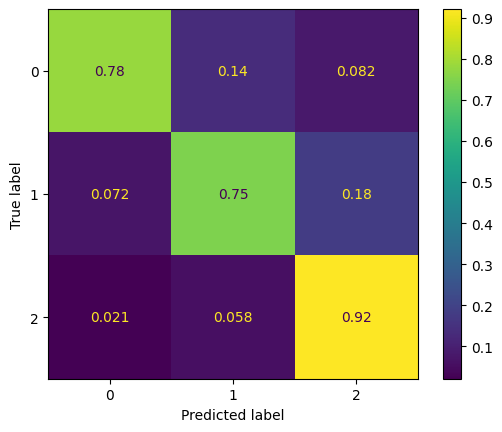

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.42364. Saving Model!
epoch 01, loss: 0.51422, acc: 0.78754, val_loss: 0.42364, val_accuracy: 0.83664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 02, loss: 0.51116, acc: 0.78715, val_loss: 0.43131, val_accuracy: 0.83212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 03, loss: 0.51821, acc: 0.78383, val_loss: 0.43105, val_accuracy: 0.83291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 04, loss: 0.50901, acc: 0.78719, val_loss: 0.43590, val_accuracy: 0.83212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 05, loss: 0.50780, acc: 0.78761, val_loss: 0.43793, val_accuracy: 0.83114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 06, loss: 0.50933, acc: 0.78732, val_loss: 0.43748, val_accuracy: 0.83036


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 07, loss: 0.50522, acc: 0.79040, val_loss: 0.44066, val_accuracy: 0.83134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 08, loss: 0.50579, acc: 0.78839, val_loss: 0.44135, val_accuracy: 0.82957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 09, loss: 0.50485, acc: 0.79049, val_loss: 0.44253, val_accuracy: 0.82898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 10, loss: 0.50345, acc: 0.78977, val_loss: 0.44440, val_accuracy: 0.82878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 11, loss: 0.50391, acc: 0.79066, val_loss: 0.44481, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 12, loss: 0.50181, acc: 0.79134, val_loss: 0.44639, val_accuracy: 0.82937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 13, loss: 0.50214, acc: 0.79232, val_loss: 0.44691, val_accuracy: 0.82839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 14, loss: 0.50147, acc: 0.79188, val_loss: 0.44803, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 15, loss: 0.50072, acc: 0.79230, val_loss: 0.44905, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 16, loss: 0.50078, acc: 0.79321, val_loss: 0.44921, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 17, loss: 0.49979, acc: 0.79358, val_loss: 0.45052, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 18, loss: 0.49940, acc: 0.79363, val_loss: 0.45113, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 19, loss: 0.49908, acc: 0.79371, val_loss: 0.45181, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 20, loss: 0.49874, acc: 0.79408, val_loss: 0.45253, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 21, loss: 0.49823, acc: 0.79465, val_loss: 0.45321, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 22, loss: 0.49792, acc: 0.79474, val_loss: 0.45406, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 23, loss: 0.49730, acc: 0.79463, val_loss: 0.45479, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 24, loss: 0.49757, acc: 0.79450, val_loss: 0.45538, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 25, loss: 0.49675, acc: 0.79568, val_loss: 0.45599, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 26, loss: 0.49650, acc: 0.79605, val_loss: 0.45670, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 27, loss: 0.49606, acc: 0.79587, val_loss: 0.45743, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 28, loss: 0.49596, acc: 0.79642, val_loss: 0.45760, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 29, loss: 0.49556, acc: 0.79627, val_loss: 0.45883, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 30, loss: 0.49525, acc: 0.79624, val_loss: 0.45923, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 31, loss: 0.49511, acc: 0.79640, val_loss: 0.45965, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 32, loss: 0.49447, acc: 0.79664, val_loss: 0.46060, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 33, loss: 0.49467, acc: 0.79677, val_loss: 0.46075, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 34, loss: 0.49411, acc: 0.79631, val_loss: 0.46159, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 35, loss: 0.49382, acc: 0.79688, val_loss: 0.46172, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 36, loss: 0.49370, acc: 0.79681, val_loss: 0.46232, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 37, loss: 0.49313, acc: 0.79701, val_loss: 0.46310, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 38, loss: 0.49308, acc: 0.79685, val_loss: 0.46314, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 39, loss: 0.49304, acc: 0.79703, val_loss: 0.46380, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 40, loss: 0.49221, acc: 0.79729, val_loss: 0.46463, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 41, loss: 0.49234, acc: 0.79729, val_loss: 0.46439, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 42, loss: 0.49202, acc: 0.79753, val_loss: 0.46503, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 43, loss: 0.49161, acc: 0.79786, val_loss: 0.46557, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 44, loss: 0.49162, acc: 0.79764, val_loss: 0.46620, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 45, loss: 0.49118, acc: 0.79753, val_loss: 0.46626, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 46, loss: 0.49072, acc: 0.79810, val_loss: 0.46718, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 47, loss: 0.49086, acc: 0.79771, val_loss: 0.46715, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 48, loss: 0.49029, acc: 0.79819, val_loss: 0.46759, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 49, loss: 0.49004, acc: 0.79823, val_loss: 0.46842, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 50, loss: 0.49009, acc: 0.79825, val_loss: 0.46873, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 51, loss: 0.48951, acc: 0.79810, val_loss: 0.46914, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 52, loss: 0.48942, acc: 0.79832, val_loss: 0.46976, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 53, loss: 0.48923, acc: 0.79845, val_loss: 0.46961, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 54, loss: 0.48916, acc: 0.79858, val_loss: 0.47027, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 55, loss: 0.48863, acc: 0.79869, val_loss: 0.47070, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 56, loss: 0.48876, acc: 0.79875, val_loss: 0.47058, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 57, loss: 0.48797, acc: 0.79888, val_loss: 0.47139, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 58, loss: 0.48826, acc: 0.79893, val_loss: 0.47154, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 59, loss: 0.48777, acc: 0.79904, val_loss: 0.47165, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 60, loss: 0.48752, acc: 0.79906, val_loss: 0.47245, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 61, loss: 0.48760, acc: 0.80015, val_loss: 0.47214, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 62, loss: 0.48725, acc: 0.79932, val_loss: 0.47256, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 63, loss: 0.48662, acc: 0.80050, val_loss: 0.47310, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 64, loss: 0.48730, acc: 0.79956, val_loss: 0.47295, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 65, loss: 0.48607, acc: 0.80133, val_loss: 0.47391, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 66, loss: 0.48663, acc: 0.80026, val_loss: 0.47336, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 67, loss: 0.48625, acc: 0.80113, val_loss: 0.47382, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 68, loss: 0.48584, acc: 0.80065, val_loss: 0.47423, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 69, loss: 0.48565, acc: 0.80130, val_loss: 0.47472, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 70, loss: 0.48559, acc: 0.80098, val_loss: 0.47457, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 71, loss: 0.48525, acc: 0.80135, val_loss: 0.47571, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 72, loss: 0.48489, acc: 0.80176, val_loss: 0.47559, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 73, loss: 0.48546, acc: 0.80082, val_loss: 0.47546, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 74, loss: 0.48407, acc: 0.80216, val_loss: 0.47652, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 75, loss: 0.48481, acc: 0.80192, val_loss: 0.47566, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 76, loss: 0.48420, acc: 0.80226, val_loss: 0.47667, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 77, loss: 0.48410, acc: 0.80196, val_loss: 0.47672, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 78, loss: 0.48373, acc: 0.80205, val_loss: 0.47732, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 79, loss: 0.48379, acc: 0.80261, val_loss: 0.47706, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 80, loss: 0.48317, acc: 0.80218, val_loss: 0.47776, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 81, loss: 0.48337, acc: 0.80229, val_loss: 0.47751, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 82, loss: 0.48322, acc: 0.80218, val_loss: 0.47833, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 83, loss: 0.48267, acc: 0.80255, val_loss: 0.47859, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 84, loss: 0.48292, acc: 0.80279, val_loss: 0.47825, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 85, loss: 0.48190, acc: 0.80431, val_loss: 0.47869, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 86, loss: 0.48291, acc: 0.80298, val_loss: 0.47888, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 87, loss: 0.48150, acc: 0.80466, val_loss: 0.47936, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 88, loss: 0.48220, acc: 0.80401, val_loss: 0.47896, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 89, loss: 0.48147, acc: 0.80460, val_loss: 0.48001, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 90, loss: 0.48152, acc: 0.80423, val_loss: 0.47933, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 91, loss: 0.48136, acc: 0.80453, val_loss: 0.47996, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 92, loss: 0.48087, acc: 0.80475, val_loss: 0.48058, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 93, loss: 0.48125, acc: 0.80464, val_loss: 0.47976, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 94, loss: 0.48034, acc: 0.80458, val_loss: 0.48105, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 95, loss: 0.48095, acc: 0.80490, val_loss: 0.48108, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 96, loss: 0.47994, acc: 0.80525, val_loss: 0.48115, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 97, loss: 0.48048, acc: 0.80388, val_loss: 0.48157, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 98, loss: 0.47996, acc: 0.80501, val_loss: 0.48188, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 99, loss: 0.47970, acc: 0.80521, val_loss: 0.48184, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 100, loss: 0.47957, acc: 0.80523, val_loss: 0.48228, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 101, loss: 0.47932, acc: 0.80549, val_loss: 0.48222, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 102, loss: 0.47933, acc: 0.80527, val_loss: 0.48273, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 103, loss: 0.47888, acc: 0.80567, val_loss: 0.48327, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 104, loss: 0.47896, acc: 0.80547, val_loss: 0.48276, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 105, loss: 0.47861, acc: 0.80560, val_loss: 0.48318, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 106, loss: 0.47849, acc: 0.80595, val_loss: 0.48344, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 107, loss: 0.47816, acc: 0.80615, val_loss: 0.48389, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 108, loss: 0.47807, acc: 0.80586, val_loss: 0.48405, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 109, loss: 0.47827, acc: 0.80606, val_loss: 0.48356, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 110, loss: 0.47754, acc: 0.80610, val_loss: 0.48435, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 111, loss: 0.47749, acc: 0.80608, val_loss: 0.48405, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 112, loss: 0.47747, acc: 0.80604, val_loss: 0.48469, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 113, loss: 0.47713, acc: 0.80630, val_loss: 0.48475, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 114, loss: 0.47684, acc: 0.80628, val_loss: 0.48549, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 115, loss: 0.47709, acc: 0.80619, val_loss: 0.48489, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 116, loss: 0.47654, acc: 0.80610, val_loss: 0.48576, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 117, loss: 0.47630, acc: 0.80667, val_loss: 0.48568, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 118, loss: 0.47651, acc: 0.80621, val_loss: 0.48578, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 119, loss: 0.47619, acc: 0.80663, val_loss: 0.48582, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 120, loss: 0.47586, acc: 0.80639, val_loss: 0.48619, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 121, loss: 0.47549, acc: 0.80676, val_loss: 0.48643, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 122, loss: 0.47598, acc: 0.80678, val_loss: 0.48649, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 123, loss: 0.47489, acc: 0.80682, val_loss: 0.48751, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 124, loss: 0.47577, acc: 0.80674, val_loss: 0.48667, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 125, loss: 0.47446, acc: 0.80708, val_loss: 0.48803, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 126, loss: 0.47536, acc: 0.80684, val_loss: 0.48734, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 127, loss: 0.47436, acc: 0.80704, val_loss: 0.48823, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 128, loss: 0.47445, acc: 0.80728, val_loss: 0.48770, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 129, loss: 0.47455, acc: 0.80719, val_loss: 0.48825, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 130, loss: 0.47407, acc: 0.80776, val_loss: 0.48878, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 131, loss: 0.47381, acc: 0.80724, val_loss: 0.48875, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 132, loss: 0.47395, acc: 0.80746, val_loss: 0.48858, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 133, loss: 0.47368, acc: 0.80770, val_loss: 0.48928, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 134, loss: 0.47308, acc: 0.80789, val_loss: 0.48968, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 135, loss: 0.47372, acc: 0.80763, val_loss: 0.48921, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 136, loss: 0.47279, acc: 0.80765, val_loss: 0.48988, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 137, loss: 0.47278, acc: 0.80785, val_loss: 0.48986, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 138, loss: 0.47310, acc: 0.80787, val_loss: 0.48964, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 139, loss: 0.47217, acc: 0.80815, val_loss: 0.49068, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 140, loss: 0.47281, acc: 0.80785, val_loss: 0.49015, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 141, loss: 0.47177, acc: 0.80818, val_loss: 0.49104, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 142, loss: 0.47222, acc: 0.80820, val_loss: 0.49026, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 143, loss: 0.47168, acc: 0.80837, val_loss: 0.49068, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 144, loss: 0.47133, acc: 0.80870, val_loss: 0.49115, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 145, loss: 0.47166, acc: 0.80828, val_loss: 0.49120, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 146, loss: 0.47100, acc: 0.80879, val_loss: 0.49188, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 147, loss: 0.47096, acc: 0.80870, val_loss: 0.49206, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 148, loss: 0.47120, acc: 0.80876, val_loss: 0.49153, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 149, loss: 0.47037, acc: 0.80894, val_loss: 0.49247, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 150, loss: 0.47043, acc: 0.80914, val_loss: 0.49231, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 151, loss: 0.47051, acc: 0.80898, val_loss: 0.49198, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 152, loss: 0.47014, acc: 0.80924, val_loss: 0.49242, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 153, loss: 0.46972, acc: 0.80964, val_loss: 0.49259, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 154, loss: 0.46998, acc: 0.80994, val_loss: 0.49238, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 155, loss: 0.46936, acc: 0.80972, val_loss: 0.49317, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 156, loss: 0.46950, acc: 0.80955, val_loss: 0.49252, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 157, loss: 0.46934, acc: 0.81047, val_loss: 0.49312, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 158, loss: 0.46845, acc: 0.81010, val_loss: 0.49320, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 159, loss: 0.46918, acc: 0.80977, val_loss: 0.49300, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 160, loss: 0.46843, acc: 0.81018, val_loss: 0.49347, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 161, loss: 0.46853, acc: 0.81034, val_loss: 0.49327, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 162, loss: 0.46813, acc: 0.81012, val_loss: 0.49374, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 163, loss: 0.46831, acc: 0.81027, val_loss: 0.49367, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 164, loss: 0.46790, acc: 0.81029, val_loss: 0.49441, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 165, loss: 0.46781, acc: 0.81038, val_loss: 0.49366, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 166, loss: 0.46761, acc: 0.81031, val_loss: 0.49446, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 167, loss: 0.46740, acc: 0.81062, val_loss: 0.49425, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 168, loss: 0.46716, acc: 0.80988, val_loss: 0.49470, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 169, loss: 0.46726, acc: 0.81077, val_loss: 0.49417, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 170, loss: 0.46669, acc: 0.81014, val_loss: 0.49545, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 171, loss: 0.46700, acc: 0.81073, val_loss: 0.49455, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 172, loss: 0.46652, acc: 0.81086, val_loss: 0.49534, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 173, loss: 0.46622, acc: 0.81112, val_loss: 0.49510, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 174, loss: 0.46616, acc: 0.81101, val_loss: 0.49555, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 175, loss: 0.46620, acc: 0.81090, val_loss: 0.49554, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 176, loss: 0.46594, acc: 0.81195, val_loss: 0.49550, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 177, loss: 0.46576, acc: 0.81138, val_loss: 0.49561, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 178, loss: 0.46537, acc: 0.81140, val_loss: 0.49647, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 179, loss: 0.46543, acc: 0.81151, val_loss: 0.49606, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 180, loss: 0.46519, acc: 0.81114, val_loss: 0.49649, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 181, loss: 0.46476, acc: 0.81171, val_loss: 0.49648, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 182, loss: 0.46524, acc: 0.81138, val_loss: 0.49583, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 183, loss: 0.46429, acc: 0.81173, val_loss: 0.49658, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 184, loss: 0.46456, acc: 0.81164, val_loss: 0.49681, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 185, loss: 0.46455, acc: 0.81197, val_loss: 0.49684, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 186, loss: 0.46386, acc: 0.81169, val_loss: 0.49773, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 187, loss: 0.46431, acc: 0.81193, val_loss: 0.49697, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 188, loss: 0.46359, acc: 0.81191, val_loss: 0.49744, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 189, loss: 0.46343, acc: 0.81228, val_loss: 0.49756, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 190, loss: 0.46386, acc: 0.81147, val_loss: 0.49766, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 191, loss: 0.46297, acc: 0.81195, val_loss: 0.49781, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 192, loss: 0.46333, acc: 0.81212, val_loss: 0.49842, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 193, loss: 0.46308, acc: 0.81175, val_loss: 0.49833, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 194, loss: 0.46258, acc: 0.81243, val_loss: 0.49876, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 195, loss: 0.46315, acc: 0.81180, val_loss: 0.49882, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 196, loss: 0.46219, acc: 0.81267, val_loss: 0.49846, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 197, loss: 0.46242, acc: 0.81219, val_loss: 0.49924, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 198, loss: 0.46207, acc: 0.81256, val_loss: 0.49891, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 199, loss: 0.46224, acc: 0.81223, val_loss: 0.49880, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 200, loss: 0.46159, acc: 0.81284, val_loss: 0.49948, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 201, loss: 0.46171, acc: 0.81306, val_loss: 0.50006, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 202, loss: 0.46162, acc: 0.81280, val_loss: 0.50002, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 203, loss: 0.46111, acc: 0.81252, val_loss: 0.50035, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 204, loss: 0.46127, acc: 0.81247, val_loss: 0.49991, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 205, loss: 0.46109, acc: 0.81282, val_loss: 0.50015, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 206, loss: 0.46079, acc: 0.81352, val_loss: 0.50069, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 207, loss: 0.46053, acc: 0.81383, val_loss: 0.50085, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 208, loss: 0.46095, acc: 0.81260, val_loss: 0.50014, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 209, loss: 0.45978, acc: 0.81354, val_loss: 0.50110, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 210, loss: 0.46056, acc: 0.81265, val_loss: 0.50045, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 211, loss: 0.45975, acc: 0.81387, val_loss: 0.50183, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 212, loss: 0.46000, acc: 0.81348, val_loss: 0.50075, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 213, loss: 0.45970, acc: 0.81350, val_loss: 0.50094, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 214, loss: 0.45921, acc: 0.81431, val_loss: 0.50194, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 215, loss: 0.45993, acc: 0.81356, val_loss: 0.50097, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 216, loss: 0.45890, acc: 0.81402, val_loss: 0.50222, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 217, loss: 0.45899, acc: 0.81398, val_loss: 0.50187, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 218, loss: 0.45908, acc: 0.81369, val_loss: 0.50208, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 219, loss: 0.45847, acc: 0.81489, val_loss: 0.50214, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 220, loss: 0.45883, acc: 0.81439, val_loss: 0.50198, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 221, loss: 0.45783, acc: 0.81417, val_loss: 0.50294, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 222, loss: 0.45886, acc: 0.81454, val_loss: 0.50229, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


epoch 223, loss: 0.45778, acc: 0.81516, val_loss: 0.50328, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 224, loss: 0.45836, acc: 0.81454, val_loss: 0.50242, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 225, loss: 0.45772, acc: 0.81533, val_loss: 0.50318, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 226, loss: 0.45743, acc: 0.81505, val_loss: 0.50290, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 227, loss: 0.45756, acc: 0.81498, val_loss: 0.50341, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 228, loss: 0.45726, acc: 0.81529, val_loss: 0.50332, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 229, loss: 0.45694, acc: 0.81581, val_loss: 0.50395, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 230, loss: 0.45734, acc: 0.81461, val_loss: 0.50319, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 231, loss: 0.45634, acc: 0.81620, val_loss: 0.50366, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 232, loss: 0.45672, acc: 0.81463, val_loss: 0.50385, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 233, loss: 0.45673, acc: 0.81470, val_loss: 0.50381, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 234, loss: 0.45605, acc: 0.81703, val_loss: 0.50471, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 235, loss: 0.45659, acc: 0.81660, val_loss: 0.50402, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 236, loss: 0.45551, acc: 0.81697, val_loss: 0.50521, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 237, loss: 0.45651, acc: 0.81616, val_loss: 0.50380, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 238, loss: 0.45544, acc: 0.81742, val_loss: 0.50541, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 239, loss: 0.45554, acc: 0.81718, val_loss: 0.50456, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 240, loss: 0.45564, acc: 0.81629, val_loss: 0.50524, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 241, loss: 0.45535, acc: 0.81636, val_loss: 0.50506, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 242, loss: 0.45498, acc: 0.81758, val_loss: 0.50605, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 243, loss: 0.45499, acc: 0.81670, val_loss: 0.50537, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 244, loss: 0.45450, acc: 0.81777, val_loss: 0.50574, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 245, loss: 0.45480, acc: 0.81677, val_loss: 0.50501, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 246, loss: 0.45433, acc: 0.81712, val_loss: 0.50645, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 247, loss: 0.45425, acc: 0.81723, val_loss: 0.50578, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 248, loss: 0.45408, acc: 0.81670, val_loss: 0.50602, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 249, loss: 0.45367, acc: 0.81760, val_loss: 0.50646, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 250, loss: 0.45411, acc: 0.81749, val_loss: 0.50587, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 251, loss: 0.45319, acc: 0.81766, val_loss: 0.50712, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 252, loss: 0.45380, acc: 0.81764, val_loss: 0.50617, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 253, loss: 0.45302, acc: 0.81721, val_loss: 0.50649, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 254, loss: 0.45332, acc: 0.81775, val_loss: 0.50631, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 255, loss: 0.45288, acc: 0.81732, val_loss: 0.50685, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 256, loss: 0.45273, acc: 0.81812, val_loss: 0.50725, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 257, loss: 0.45301, acc: 0.81797, val_loss: 0.50694, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 258, loss: 0.45242, acc: 0.81808, val_loss: 0.50711, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 259, loss: 0.45276, acc: 0.81727, val_loss: 0.50705, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 260, loss: 0.45153, acc: 0.81751, val_loss: 0.50782, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 261, loss: 0.45326, acc: 0.81804, val_loss: 0.50680, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 262, loss: 0.45092, acc: 0.81862, val_loss: 0.50860, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 263, loss: 0.45254, acc: 0.81753, val_loss: 0.50674, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 264, loss: 0.45106, acc: 0.81845, val_loss: 0.50884, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 265, loss: 0.45228, acc: 0.81780, val_loss: 0.50795, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 266, loss: 0.45049, acc: 0.81851, val_loss: 0.50886, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 267, loss: 0.45185, acc: 0.81775, val_loss: 0.50796, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 268, loss: 0.45055, acc: 0.81849, val_loss: 0.50902, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 269, loss: 0.45077, acc: 0.81891, val_loss: 0.50818, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 270, loss: 0.45077, acc: 0.81810, val_loss: 0.50881, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 271, loss: 0.45032, acc: 0.81913, val_loss: 0.50924, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 272, loss: 0.45047, acc: 0.81902, val_loss: 0.50873, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 273, loss: 0.45042, acc: 0.81821, val_loss: 0.50894, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 274, loss: 0.44950, acc: 0.81939, val_loss: 0.50992, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 275, loss: 0.45078, acc: 0.81895, val_loss: 0.50855, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 276, loss: 0.44913, acc: 0.81906, val_loss: 0.51029, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 277, loss: 0.45006, acc: 0.81913, val_loss: 0.50903, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 278, loss: 0.44908, acc: 0.81954, val_loss: 0.51016, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 279, loss: 0.44961, acc: 0.81902, val_loss: 0.50894, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 280, loss: 0.44857, acc: 0.81904, val_loss: 0.51057, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 281, loss: 0.44980, acc: 0.81886, val_loss: 0.50917, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 282, loss: 0.44805, acc: 0.82006, val_loss: 0.51109, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 283, loss: 0.44960, acc: 0.81891, val_loss: 0.50915, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 284, loss: 0.44817, acc: 0.81889, val_loss: 0.51140, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 285, loss: 0.44859, acc: 0.81937, val_loss: 0.50992, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 286, loss: 0.44797, acc: 0.82013, val_loss: 0.51058, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 287, loss: 0.44842, acc: 0.81934, val_loss: 0.51067, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 288, loss: 0.44767, acc: 0.81976, val_loss: 0.51178, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 289, loss: 0.44784, acc: 0.81971, val_loss: 0.51058, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 290, loss: 0.44751, acc: 0.82039, val_loss: 0.51099, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 291, loss: 0.44746, acc: 0.82006, val_loss: 0.51157, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 292, loss: 0.44733, acc: 0.81974, val_loss: 0.51168, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 293, loss: 0.44759, acc: 0.82028, val_loss: 0.51144, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 294, loss: 0.44636, acc: 0.82098, val_loss: 0.51203, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 295, loss: 0.44755, acc: 0.81989, val_loss: 0.51136, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 296, loss: 0.44591, acc: 0.82100, val_loss: 0.51202, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 297, loss: 0.44730, acc: 0.81998, val_loss: 0.51101, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 298, loss: 0.44573, acc: 0.82118, val_loss: 0.51294, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 299, loss: 0.44679, acc: 0.82144, val_loss: 0.51156, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 300, loss: 0.44591, acc: 0.82057, val_loss: 0.51303, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 301, loss: 0.44610, acc: 0.82168, val_loss: 0.51183, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 302, loss: 0.44572, acc: 0.82264, val_loss: 0.51271, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 303, loss: 0.44577, acc: 0.82115, val_loss: 0.51250, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 304, loss: 0.44547, acc: 0.82196, val_loss: 0.51323, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 305, loss: 0.44562, acc: 0.82229, val_loss: 0.51252, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 306, loss: 0.44499, acc: 0.82299, val_loss: 0.51362, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 307, loss: 0.44551, acc: 0.82216, val_loss: 0.51302, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 308, loss: 0.44439, acc: 0.82310, val_loss: 0.51396, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 309, loss: 0.44526, acc: 0.82253, val_loss: 0.51266, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 310, loss: 0.44438, acc: 0.82205, val_loss: 0.51403, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 311, loss: 0.44504, acc: 0.82323, val_loss: 0.51301, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 312, loss: 0.44407, acc: 0.82331, val_loss: 0.51449, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 313, loss: 0.44463, acc: 0.82301, val_loss: 0.51410, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 314, loss: 0.44390, acc: 0.82316, val_loss: 0.51479, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 315, loss: 0.44408, acc: 0.82277, val_loss: 0.51362, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 316, loss: 0.44372, acc: 0.82314, val_loss: 0.51488, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 317, loss: 0.44369, acc: 0.82406, val_loss: 0.51422, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 318, loss: 0.44305, acc: 0.82377, val_loss: 0.51510, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 319, loss: 0.44384, acc: 0.82336, val_loss: 0.51416, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 320, loss: 0.44282, acc: 0.82275, val_loss: 0.51590, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 321, loss: 0.44349, acc: 0.82373, val_loss: 0.51418, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 322, loss: 0.44277, acc: 0.82373, val_loss: 0.51609, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 323, loss: 0.44303, acc: 0.82403, val_loss: 0.51484, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 324, loss: 0.44199, acc: 0.82440, val_loss: 0.51615, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 325, loss: 0.44292, acc: 0.82342, val_loss: 0.51490, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 326, loss: 0.44227, acc: 0.82395, val_loss: 0.51636, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 327, loss: 0.44197, acc: 0.82440, val_loss: 0.51544, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 328, loss: 0.44206, acc: 0.82286, val_loss: 0.51682, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 329, loss: 0.44190, acc: 0.82469, val_loss: 0.51577, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 330, loss: 0.44150, acc: 0.82458, val_loss: 0.51690, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 331, loss: 0.44140, acc: 0.82502, val_loss: 0.51620, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 332, loss: 0.44134, acc: 0.82392, val_loss: 0.51704, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 333, loss: 0.44129, acc: 0.82486, val_loss: 0.51627, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 334, loss: 0.44066, acc: 0.82447, val_loss: 0.51782, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 335, loss: 0.44149, acc: 0.82449, val_loss: 0.51696, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 336, loss: 0.44045, acc: 0.82447, val_loss: 0.51867, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 337, loss: 0.44079, acc: 0.82554, val_loss: 0.51635, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 338, loss: 0.44014, acc: 0.82488, val_loss: 0.51836, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 339, loss: 0.44063, acc: 0.82499, val_loss: 0.51741, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 340, loss: 0.44030, acc: 0.82478, val_loss: 0.51847, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 341, loss: 0.44027, acc: 0.82560, val_loss: 0.51745, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 342, loss: 0.43958, acc: 0.82491, val_loss: 0.51822, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 343, loss: 0.43985, acc: 0.82595, val_loss: 0.51830, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 344, loss: 0.43934, acc: 0.82532, val_loss: 0.51923, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 345, loss: 0.43932, acc: 0.82536, val_loss: 0.51823, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 346, loss: 0.43923, acc: 0.82536, val_loss: 0.51864, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 347, loss: 0.43892, acc: 0.82574, val_loss: 0.51846, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 348, loss: 0.43880, acc: 0.82665, val_loss: 0.51907, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 349, loss: 0.43885, acc: 0.82569, val_loss: 0.51888, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 350, loss: 0.43814, acc: 0.82528, val_loss: 0.51867, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 351, loss: 0.43879, acc: 0.82593, val_loss: 0.51912, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 352, loss: 0.43788, acc: 0.82624, val_loss: 0.51968, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 353, loss: 0.43816, acc: 0.82735, val_loss: 0.51884, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 354, loss: 0.43775, acc: 0.82604, val_loss: 0.51934, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 355, loss: 0.43813, acc: 0.82628, val_loss: 0.51938, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 356, loss: 0.43736, acc: 0.82656, val_loss: 0.51980, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 357, loss: 0.43795, acc: 0.82645, val_loss: 0.51925, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 358, loss: 0.43704, acc: 0.82624, val_loss: 0.52021, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 359, loss: 0.43804, acc: 0.82739, val_loss: 0.51919, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 360, loss: 0.43584, acc: 0.82665, val_loss: 0.52139, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 361, loss: 0.43842, acc: 0.82735, val_loss: 0.51905, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 362, loss: 0.43533, acc: 0.82798, val_loss: 0.52162, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 363, loss: 0.43772, acc: 0.82737, val_loss: 0.51875, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 364, loss: 0.43568, acc: 0.82685, val_loss: 0.52183, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 365, loss: 0.43689, acc: 0.82796, val_loss: 0.51977, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 366, loss: 0.43560, acc: 0.82715, val_loss: 0.52114, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 367, loss: 0.43672, acc: 0.82789, val_loss: 0.52050, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 368, loss: 0.43559, acc: 0.82672, val_loss: 0.52125, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 369, loss: 0.43616, acc: 0.82807, val_loss: 0.52056, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 370, loss: 0.43500, acc: 0.82822, val_loss: 0.52138, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 371, loss: 0.43643, acc: 0.82798, val_loss: 0.52123, val_accuracy: 0.82250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 372, loss: 0.43460, acc: 0.82774, val_loss: 0.52185, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 373, loss: 0.43583, acc: 0.82796, val_loss: 0.52041, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 374, loss: 0.43459, acc: 0.82846, val_loss: 0.52247, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 375, loss: 0.43509, acc: 0.82800, val_loss: 0.52080, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 376, loss: 0.43426, acc: 0.82827, val_loss: 0.52263, val_accuracy: 0.82250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 377, loss: 0.43521, acc: 0.82818, val_loss: 0.52191, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 378, loss: 0.43370, acc: 0.82722, val_loss: 0.52272, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 379, loss: 0.43485, acc: 0.82835, val_loss: 0.52124, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 380, loss: 0.43348, acc: 0.82792, val_loss: 0.52353, val_accuracy: 0.82289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 381, loss: 0.43511, acc: 0.82848, val_loss: 0.52153, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 382, loss: 0.43334, acc: 0.82855, val_loss: 0.52317, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 383, loss: 0.43424, acc: 0.82877, val_loss: 0.52119, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 384, loss: 0.43346, acc: 0.82837, val_loss: 0.52336, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 385, loss: 0.43345, acc: 0.82901, val_loss: 0.52216, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 386, loss: 0.43340, acc: 0.82851, val_loss: 0.52266, val_accuracy: 0.82250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 387, loss: 0.43364, acc: 0.82877, val_loss: 0.52249, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 388, loss: 0.43243, acc: 0.82890, val_loss: 0.52349, val_accuracy: 0.82270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 389, loss: 0.43332, acc: 0.82931, val_loss: 0.52144, val_accuracy: 0.82270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 390, loss: 0.43209, acc: 0.82936, val_loss: 0.52426, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 391, loss: 0.43345, acc: 0.82875, val_loss: 0.52221, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 392, loss: 0.43151, acc: 0.82951, val_loss: 0.52425, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 393, loss: 0.43309, acc: 0.82931, val_loss: 0.52177, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 394, loss: 0.43167, acc: 0.82962, val_loss: 0.52520, val_accuracy: 0.82289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 395, loss: 0.43242, acc: 0.82942, val_loss: 0.52263, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 396, loss: 0.43167, acc: 0.82927, val_loss: 0.52399, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 397, loss: 0.43157, acc: 0.83082, val_loss: 0.52332, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 398, loss: 0.43146, acc: 0.82960, val_loss: 0.52452, val_accuracy: 0.82309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 399, loss: 0.43211, acc: 0.83058, val_loss: 0.52292, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 400, loss: 0.43088, acc: 0.82960, val_loss: 0.52512, val_accuracy: 0.82309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 401, loss: 0.43207, acc: 0.83073, val_loss: 0.52272, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 402, loss: 0.43024, acc: 0.83056, val_loss: 0.52537, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 403, loss: 0.43186, acc: 0.83021, val_loss: 0.52250, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 404, loss: 0.43023, acc: 0.83058, val_loss: 0.52508, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 405, loss: 0.43092, acc: 0.83095, val_loss: 0.52419, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 406, loss: 0.43059, acc: 0.82944, val_loss: 0.52543, val_accuracy: 0.82329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 407, loss: 0.43078, acc: 0.83104, val_loss: 0.52344, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 408, loss: 0.42953, acc: 0.83114, val_loss: 0.52519, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 409, loss: 0.43108, acc: 0.83112, val_loss: 0.52341, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 410, loss: 0.42908, acc: 0.83077, val_loss: 0.52605, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 411, loss: 0.43083, acc: 0.83110, val_loss: 0.52295, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 412, loss: 0.42859, acc: 0.83149, val_loss: 0.52674, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 413, loss: 0.43075, acc: 0.82995, val_loss: 0.52365, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 414, loss: 0.42867, acc: 0.83104, val_loss: 0.52625, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 415, loss: 0.42983, acc: 0.83152, val_loss: 0.52433, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 416, loss: 0.42898, acc: 0.83108, val_loss: 0.52613, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 417, loss: 0.42947, acc: 0.83128, val_loss: 0.52427, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 418, loss: 0.42858, acc: 0.83123, val_loss: 0.52631, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 419, loss: 0.42921, acc: 0.83173, val_loss: 0.52420, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 420, loss: 0.42825, acc: 0.83136, val_loss: 0.52646, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 421, loss: 0.42896, acc: 0.83090, val_loss: 0.52509, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 422, loss: 0.42816, acc: 0.83125, val_loss: 0.52592, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 423, loss: 0.42825, acc: 0.83215, val_loss: 0.52508, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 424, loss: 0.42844, acc: 0.83160, val_loss: 0.52614, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 425, loss: 0.42806, acc: 0.83186, val_loss: 0.52563, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 426, loss: 0.42778, acc: 0.83200, val_loss: 0.52577, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 427, loss: 0.42795, acc: 0.83182, val_loss: 0.52607, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 428, loss: 0.42729, acc: 0.83193, val_loss: 0.52627, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 429, loss: 0.42805, acc: 0.83189, val_loss: 0.52574, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 430, loss: 0.42657, acc: 0.83241, val_loss: 0.52695, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 431, loss: 0.42810, acc: 0.83191, val_loss: 0.52525, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 432, loss: 0.42642, acc: 0.83234, val_loss: 0.52760, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 433, loss: 0.42785, acc: 0.83195, val_loss: 0.52500, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 434, loss: 0.42577, acc: 0.83250, val_loss: 0.52764, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 435, loss: 0.42792, acc: 0.83210, val_loss: 0.52501, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 436, loss: 0.42545, acc: 0.83258, val_loss: 0.52878, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 437, loss: 0.42734, acc: 0.83101, val_loss: 0.52476, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 438, loss: 0.42561, acc: 0.83272, val_loss: 0.52744, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 439, loss: 0.42728, acc: 0.83234, val_loss: 0.52610, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 440, loss: 0.42470, acc: 0.83239, val_loss: 0.52872, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 441, loss: 0.42721, acc: 0.83215, val_loss: 0.52493, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 442, loss: 0.42457, acc: 0.83267, val_loss: 0.52824, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 443, loss: 0.42689, acc: 0.83138, val_loss: 0.52475, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 444, loss: 0.42440, acc: 0.83285, val_loss: 0.52869, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 445, loss: 0.42607, acc: 0.83193, val_loss: 0.52464, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 446, loss: 0.42470, acc: 0.83248, val_loss: 0.52871, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 447, loss: 0.42585, acc: 0.83171, val_loss: 0.52613, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 448, loss: 0.42435, acc: 0.83258, val_loss: 0.52876, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 449, loss: 0.42566, acc: 0.83189, val_loss: 0.52484, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 450, loss: 0.42360, acc: 0.83280, val_loss: 0.52858, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 451, loss: 0.42541, acc: 0.83317, val_loss: 0.52605, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 452, loss: 0.42366, acc: 0.83280, val_loss: 0.52844, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 453, loss: 0.42519, acc: 0.83302, val_loss: 0.52649, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 454, loss: 0.42358, acc: 0.83282, val_loss: 0.52877, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 455, loss: 0.42445, acc: 0.83328, val_loss: 0.52601, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 456, loss: 0.42348, acc: 0.83324, val_loss: 0.52873, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 457, loss: 0.42438, acc: 0.83254, val_loss: 0.52644, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 458, loss: 0.42291, acc: 0.83339, val_loss: 0.52914, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 459, loss: 0.42404, acc: 0.83250, val_loss: 0.52619, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 460, loss: 0.42283, acc: 0.83313, val_loss: 0.52950, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 461, loss: 0.42431, acc: 0.83219, val_loss: 0.52478, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 462, loss: 0.42182, acc: 0.83368, val_loss: 0.52983, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 463, loss: 0.42398, acc: 0.83302, val_loss: 0.52565, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 464, loss: 0.42213, acc: 0.83350, val_loss: 0.53013, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 465, loss: 0.42322, acc: 0.83398, val_loss: 0.52659, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 466, loss: 0.42178, acc: 0.83385, val_loss: 0.52961, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 467, loss: 0.42327, acc: 0.83302, val_loss: 0.52723, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 468, loss: 0.42142, acc: 0.83396, val_loss: 0.53007, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 469, loss: 0.42324, acc: 0.83387, val_loss: 0.52672, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 470, loss: 0.42137, acc: 0.83381, val_loss: 0.53074, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 471, loss: 0.42253, acc: 0.83392, val_loss: 0.52723, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 472, loss: 0.42130, acc: 0.83389, val_loss: 0.53001, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 473, loss: 0.42192, acc: 0.83407, val_loss: 0.52736, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 474, loss: 0.42110, acc: 0.83424, val_loss: 0.53021, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 475, loss: 0.42172, acc: 0.83335, val_loss: 0.52717, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 476, loss: 0.42074, acc: 0.83402, val_loss: 0.53103, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 477, loss: 0.42180, acc: 0.83477, val_loss: 0.52807, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 478, loss: 0.42035, acc: 0.83433, val_loss: 0.53070, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 479, loss: 0.42168, acc: 0.83378, val_loss: 0.52726, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 480, loss: 0.41997, acc: 0.83453, val_loss: 0.53080, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 481, loss: 0.42134, acc: 0.83483, val_loss: 0.52809, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 482, loss: 0.42029, acc: 0.83407, val_loss: 0.53025, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 483, loss: 0.42081, acc: 0.83415, val_loss: 0.52841, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 484, loss: 0.41958, acc: 0.83492, val_loss: 0.53007, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 485, loss: 0.42078, acc: 0.83374, val_loss: 0.52773, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 486, loss: 0.41945, acc: 0.83446, val_loss: 0.53156, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 487, loss: 0.42041, acc: 0.83422, val_loss: 0.52807, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 488, loss: 0.41904, acc: 0.83531, val_loss: 0.53171, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 489, loss: 0.42055, acc: 0.83409, val_loss: 0.52825, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 490, loss: 0.41877, acc: 0.83472, val_loss: 0.53268, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 491, loss: 0.42017, acc: 0.83505, val_loss: 0.52829, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 492, loss: 0.41826, acc: 0.83538, val_loss: 0.53187, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 493, loss: 0.41988, acc: 0.83527, val_loss: 0.52825, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


epoch 494, loss: 0.41796, acc: 0.83520, val_loss: 0.53180, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 495, loss: 0.41987, acc: 0.83581, val_loss: 0.52901, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 496, loss: 0.41766, acc: 0.83592, val_loss: 0.53208, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 497, loss: 0.41889, acc: 0.83485, val_loss: 0.52934, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 498, loss: 0.41802, acc: 0.83559, val_loss: 0.53206, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 499, loss: 0.41812, acc: 0.83623, val_loss: 0.52897, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 500, loss: 0.41783, acc: 0.83568, val_loss: 0.53075, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 501, loss: 0.41819, acc: 0.83621, val_loss: 0.52932, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 502, loss: 0.41794, acc: 0.83577, val_loss: 0.53075, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 503, loss: 0.41761, acc: 0.83664, val_loss: 0.53004, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 504, loss: 0.41728, acc: 0.83638, val_loss: 0.53144, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 505, loss: 0.41794, acc: 0.83631, val_loss: 0.53021, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 506, loss: 0.41671, acc: 0.83649, val_loss: 0.53260, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 507, loss: 0.41793, acc: 0.83516, val_loss: 0.52978, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 508, loss: 0.41620, acc: 0.83625, val_loss: 0.53276, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 509, loss: 0.41753, acc: 0.83651, val_loss: 0.52939, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 510, loss: 0.41605, acc: 0.83666, val_loss: 0.53248, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 511, loss: 0.41738, acc: 0.83660, val_loss: 0.53040, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 512, loss: 0.41589, acc: 0.83640, val_loss: 0.53328, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 513, loss: 0.41675, acc: 0.83717, val_loss: 0.53022, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 514, loss: 0.41611, acc: 0.83631, val_loss: 0.53338, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 515, loss: 0.41627, acc: 0.83699, val_loss: 0.53088, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 516, loss: 0.41569, acc: 0.83688, val_loss: 0.53309, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 517, loss: 0.41634, acc: 0.83703, val_loss: 0.53141, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 518, loss: 0.41521, acc: 0.83714, val_loss: 0.53379, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 519, loss: 0.41675, acc: 0.83625, val_loss: 0.53104, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 520, loss: 0.41502, acc: 0.83677, val_loss: 0.53459, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 521, loss: 0.41622, acc: 0.83706, val_loss: 0.53008, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 522, loss: 0.41473, acc: 0.83725, val_loss: 0.53489, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 523, loss: 0.41590, acc: 0.83645, val_loss: 0.53111, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 524, loss: 0.41447, acc: 0.83706, val_loss: 0.53575, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 525, loss: 0.41590, acc: 0.83701, val_loss: 0.53178, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 526, loss: 0.41420, acc: 0.83697, val_loss: 0.53516, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 527, loss: 0.41525, acc: 0.83666, val_loss: 0.53126, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 528, loss: 0.41369, acc: 0.83738, val_loss: 0.53633, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 529, loss: 0.41480, acc: 0.83688, val_loss: 0.53226, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 530, loss: 0.41393, acc: 0.83721, val_loss: 0.53459, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 531, loss: 0.41422, acc: 0.83682, val_loss: 0.53323, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 532, loss: 0.41354, acc: 0.83767, val_loss: 0.53465, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 533, loss: 0.41449, acc: 0.83854, val_loss: 0.53273, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 534, loss: 0.41347, acc: 0.83782, val_loss: 0.53364, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 535, loss: 0.41361, acc: 0.83795, val_loss: 0.53201, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 536, loss: 0.41308, acc: 0.83841, val_loss: 0.53345, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 537, loss: 0.41361, acc: 0.83882, val_loss: 0.53322, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 538, loss: 0.41349, acc: 0.83804, val_loss: 0.53338, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 539, loss: 0.41332, acc: 0.83915, val_loss: 0.53254, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 540, loss: 0.41293, acc: 0.83817, val_loss: 0.53403, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 541, loss: 0.41387, acc: 0.83732, val_loss: 0.53310, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 542, loss: 0.41166, acc: 0.83898, val_loss: 0.53548, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 543, loss: 0.41418, acc: 0.83732, val_loss: 0.53231, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 544, loss: 0.41097, acc: 0.83874, val_loss: 0.53623, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 545, loss: 0.41403, acc: 0.83747, val_loss: 0.53265, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 546, loss: 0.41080, acc: 0.83959, val_loss: 0.53594, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 547, loss: 0.41327, acc: 0.83771, val_loss: 0.53306, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 548, loss: 0.41108, acc: 0.83856, val_loss: 0.53626, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 549, loss: 0.41341, acc: 0.83734, val_loss: 0.53421, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 550, loss: 0.41065, acc: 0.83998, val_loss: 0.53660, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 551, loss: 0.41257, acc: 0.83906, val_loss: 0.53323, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 552, loss: 0.41065, acc: 0.83935, val_loss: 0.53541, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 553, loss: 0.41205, acc: 0.83976, val_loss: 0.53495, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 554, loss: 0.41098, acc: 0.83932, val_loss: 0.53587, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 555, loss: 0.41155, acc: 0.83970, val_loss: 0.53479, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 556, loss: 0.41069, acc: 0.84020, val_loss: 0.53540, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 557, loss: 0.41163, acc: 0.83904, val_loss: 0.53547, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 558, loss: 0.40968, acc: 0.84026, val_loss: 0.53589, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 559, loss: 0.41137, acc: 0.83915, val_loss: 0.53617, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 560, loss: 0.41010, acc: 0.83970, val_loss: 0.53648, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 561, loss: 0.41119, acc: 0.83891, val_loss: 0.53493, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 562, loss: 0.40936, acc: 0.84103, val_loss: 0.53709, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 563, loss: 0.41187, acc: 0.83900, val_loss: 0.53624, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 564, loss: 0.40878, acc: 0.84109, val_loss: 0.53742, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 565, loss: 0.41056, acc: 0.83956, val_loss: 0.53729, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 566, loss: 0.40952, acc: 0.83911, val_loss: 0.53636, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 567, loss: 0.40982, acc: 0.83950, val_loss: 0.53771, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 568, loss: 0.40908, acc: 0.84083, val_loss: 0.53668, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 569, loss: 0.40993, acc: 0.83963, val_loss: 0.53803, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 570, loss: 0.40949, acc: 0.83963, val_loss: 0.53671, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 571, loss: 0.40939, acc: 0.83963, val_loss: 0.53900, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 572, loss: 0.40911, acc: 0.84109, val_loss: 0.53626, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 573, loss: 0.40947, acc: 0.83954, val_loss: 0.53977, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 574, loss: 0.40815, acc: 0.84127, val_loss: 0.53704, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 575, loss: 0.40916, acc: 0.83980, val_loss: 0.53985, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 576, loss: 0.40846, acc: 0.84094, val_loss: 0.53730, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 577, loss: 0.40886, acc: 0.83963, val_loss: 0.53951, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 578, loss: 0.40774, acc: 0.84085, val_loss: 0.53814, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 579, loss: 0.40854, acc: 0.83974, val_loss: 0.54009, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 580, loss: 0.40768, acc: 0.83978, val_loss: 0.53771, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 581, loss: 0.40810, acc: 0.83980, val_loss: 0.54067, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 582, loss: 0.40793, acc: 0.84159, val_loss: 0.53812, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 583, loss: 0.40700, acc: 0.84039, val_loss: 0.54177, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 584, loss: 0.40790, acc: 0.84004, val_loss: 0.53785, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 585, loss: 0.40724, acc: 0.84002, val_loss: 0.54081, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 586, loss: 0.40711, acc: 0.84083, val_loss: 0.53841, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 587, loss: 0.40679, acc: 0.84066, val_loss: 0.54064, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 588, loss: 0.40754, acc: 0.84120, val_loss: 0.53880, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 589, loss: 0.40632, acc: 0.84059, val_loss: 0.54111, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 590, loss: 0.40705, acc: 0.84004, val_loss: 0.53855, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 591, loss: 0.40576, acc: 0.84116, val_loss: 0.54123, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 592, loss: 0.40697, acc: 0.84083, val_loss: 0.53877, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 593, loss: 0.40551, acc: 0.84118, val_loss: 0.54230, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 594, loss: 0.40743, acc: 0.84087, val_loss: 0.53813, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 595, loss: 0.40470, acc: 0.84120, val_loss: 0.54325, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 596, loss: 0.40753, acc: 0.84031, val_loss: 0.53908, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 597, loss: 0.40494, acc: 0.84107, val_loss: 0.54267, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 598, loss: 0.40667, acc: 0.84199, val_loss: 0.53844, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 599, loss: 0.40479, acc: 0.84155, val_loss: 0.54399, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 600, loss: 0.40618, acc: 0.84131, val_loss: 0.53932, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 601, loss: 0.40511, acc: 0.84170, val_loss: 0.54291, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 602, loss: 0.40560, acc: 0.84079, val_loss: 0.53881, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 603, loss: 0.40454, acc: 0.84212, val_loss: 0.54235, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 604, loss: 0.40543, acc: 0.84052, val_loss: 0.53820, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 605, loss: 0.40415, acc: 0.84251, val_loss: 0.54166, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 606, loss: 0.40512, acc: 0.84162, val_loss: 0.53964, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 607, loss: 0.40391, acc: 0.84251, val_loss: 0.54141, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 608, loss: 0.40467, acc: 0.84262, val_loss: 0.54043, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 609, loss: 0.40382, acc: 0.84231, val_loss: 0.54158, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 610, loss: 0.40459, acc: 0.84172, val_loss: 0.54052, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 611, loss: 0.40335, acc: 0.84227, val_loss: 0.54259, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 612, loss: 0.40471, acc: 0.84138, val_loss: 0.54127, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 613, loss: 0.40322, acc: 0.84288, val_loss: 0.54189, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 614, loss: 0.40392, acc: 0.84177, val_loss: 0.54129, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 615, loss: 0.40311, acc: 0.84233, val_loss: 0.54234, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 616, loss: 0.40362, acc: 0.84205, val_loss: 0.54107, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 617, loss: 0.40344, acc: 0.84229, val_loss: 0.54246, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 618, loss: 0.40363, acc: 0.84181, val_loss: 0.54205, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 619, loss: 0.40282, acc: 0.84299, val_loss: 0.54249, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 620, loss: 0.40339, acc: 0.84297, val_loss: 0.54115, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 621, loss: 0.40284, acc: 0.84362, val_loss: 0.54273, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 622, loss: 0.40321, acc: 0.84305, val_loss: 0.54271, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 623, loss: 0.40251, acc: 0.84216, val_loss: 0.54246, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 624, loss: 0.40291, acc: 0.84194, val_loss: 0.54207, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 625, loss: 0.40222, acc: 0.84334, val_loss: 0.54325, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 626, loss: 0.40328, acc: 0.84275, val_loss: 0.54250, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 627, loss: 0.40153, acc: 0.84349, val_loss: 0.54327, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 628, loss: 0.40357, acc: 0.84196, val_loss: 0.54290, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


epoch 629, loss: 0.40063, acc: 0.84375, val_loss: 0.54408, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 630, loss: 0.40319, acc: 0.84218, val_loss: 0.54297, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 631, loss: 0.40083, acc: 0.84284, val_loss: 0.54277, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 632, loss: 0.40305, acc: 0.84284, val_loss: 0.54258, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 633, loss: 0.40046, acc: 0.84329, val_loss: 0.54338, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 634, loss: 0.40269, acc: 0.84199, val_loss: 0.54331, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 635, loss: 0.40048, acc: 0.84373, val_loss: 0.54388, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 636, loss: 0.40212, acc: 0.84190, val_loss: 0.54397, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 637, loss: 0.40059, acc: 0.84380, val_loss: 0.54290, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 638, loss: 0.40124, acc: 0.84227, val_loss: 0.54499, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 639, loss: 0.40079, acc: 0.84268, val_loss: 0.54260, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 640, loss: 0.40131, acc: 0.84279, val_loss: 0.54528, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 641, loss: 0.40022, acc: 0.84415, val_loss: 0.54320, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 642, loss: 0.40067, acc: 0.84266, val_loss: 0.54564, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 643, loss: 0.40023, acc: 0.84421, val_loss: 0.54262, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 644, loss: 0.39984, acc: 0.84286, val_loss: 0.54645, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 645, loss: 0.40055, acc: 0.84349, val_loss: 0.54139, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 646, loss: 0.39996, acc: 0.84319, val_loss: 0.54662, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 647, loss: 0.40034, acc: 0.84445, val_loss: 0.54232, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 648, loss: 0.39949, acc: 0.84275, val_loss: 0.54770, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 649, loss: 0.39973, acc: 0.84443, val_loss: 0.54192, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 650, loss: 0.39912, acc: 0.84295, val_loss: 0.54698, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 651, loss: 0.39982, acc: 0.84454, val_loss: 0.54188, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 652, loss: 0.39871, acc: 0.84299, val_loss: 0.54748, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 653, loss: 0.39964, acc: 0.84452, val_loss: 0.54235, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 654, loss: 0.39882, acc: 0.84334, val_loss: 0.54706, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 655, loss: 0.39943, acc: 0.84447, val_loss: 0.54310, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 656, loss: 0.39793, acc: 0.84356, val_loss: 0.54786, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 657, loss: 0.39945, acc: 0.84445, val_loss: 0.54187, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 658, loss: 0.39827, acc: 0.84382, val_loss: 0.54768, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 659, loss: 0.39884, acc: 0.84395, val_loss: 0.54280, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 660, loss: 0.39754, acc: 0.84439, val_loss: 0.54763, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 661, loss: 0.39868, acc: 0.84487, val_loss: 0.54361, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 662, loss: 0.39743, acc: 0.84360, val_loss: 0.54763, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 663, loss: 0.39824, acc: 0.84482, val_loss: 0.54320, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 664, loss: 0.39686, acc: 0.84465, val_loss: 0.54685, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 665, loss: 0.39849, acc: 0.84303, val_loss: 0.54299, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 666, loss: 0.39651, acc: 0.84467, val_loss: 0.54728, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 667, loss: 0.39853, acc: 0.84395, val_loss: 0.54368, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 668, loss: 0.39606, acc: 0.84526, val_loss: 0.54766, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 669, loss: 0.39938, acc: 0.84329, val_loss: 0.54318, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 670, loss: 0.39538, acc: 0.84639, val_loss: 0.54915, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 671, loss: 0.39945, acc: 0.84286, val_loss: 0.54313, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 672, loss: 0.39488, acc: 0.84639, val_loss: 0.54942, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 673, loss: 0.39999, acc: 0.84336, val_loss: 0.54191, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 674, loss: 0.39419, acc: 0.84709, val_loss: 0.54959, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 675, loss: 0.39945, acc: 0.84268, val_loss: 0.54221, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 676, loss: 0.39409, acc: 0.84718, val_loss: 0.55031, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 677, loss: 0.39882, acc: 0.84356, val_loss: 0.54353, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 678, loss: 0.39424, acc: 0.84788, val_loss: 0.54883, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 679, loss: 0.39801, acc: 0.84511, val_loss: 0.54371, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 680, loss: 0.39380, acc: 0.84766, val_loss: 0.54913, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 681, loss: 0.39800, acc: 0.84519, val_loss: 0.54379, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 682, loss: 0.39405, acc: 0.84757, val_loss: 0.54829, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


epoch 683, loss: 0.39681, acc: 0.84567, val_loss: 0.54567, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 684, loss: 0.39465, acc: 0.84465, val_loss: 0.54786, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 685, loss: 0.39696, acc: 0.84591, val_loss: 0.54573, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 686, loss: 0.39366, acc: 0.84687, val_loss: 0.54781, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 687, loss: 0.39680, acc: 0.84526, val_loss: 0.54613, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 688, loss: 0.39374, acc: 0.84628, val_loss: 0.54817, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 689, loss: 0.39604, acc: 0.84535, val_loss: 0.54724, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 690, loss: 0.39350, acc: 0.84713, val_loss: 0.54727, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 691, loss: 0.39587, acc: 0.84589, val_loss: 0.54652, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 692, loss: 0.39347, acc: 0.84685, val_loss: 0.54770, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 693, loss: 0.39538, acc: 0.84511, val_loss: 0.54776, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 694, loss: 0.39377, acc: 0.84707, val_loss: 0.54781, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 695, loss: 0.39466, acc: 0.84641, val_loss: 0.54884, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 696, loss: 0.39395, acc: 0.84617, val_loss: 0.54631, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 697, loss: 0.39442, acc: 0.84635, val_loss: 0.54929, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 698, loss: 0.39375, acc: 0.84733, val_loss: 0.54665, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 699, loss: 0.39401, acc: 0.84644, val_loss: 0.55050, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 700, loss: 0.39376, acc: 0.84685, val_loss: 0.54542, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 701, loss: 0.39304, acc: 0.84694, val_loss: 0.54989, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 702, loss: 0.39390, acc: 0.84722, val_loss: 0.54587, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 703, loss: 0.39290, acc: 0.84657, val_loss: 0.55037, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 704, loss: 0.39380, acc: 0.84707, val_loss: 0.54549, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 705, loss: 0.39235, acc: 0.84670, val_loss: 0.55136, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 706, loss: 0.39365, acc: 0.84722, val_loss: 0.54588, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 707, loss: 0.39201, acc: 0.84661, val_loss: 0.55172, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 708, loss: 0.39401, acc: 0.84740, val_loss: 0.54545, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 709, loss: 0.39103, acc: 0.84700, val_loss: 0.55316, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 710, loss: 0.39399, acc: 0.84720, val_loss: 0.54497, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 711, loss: 0.39065, acc: 0.84764, val_loss: 0.55257, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 712, loss: 0.39393, acc: 0.84729, val_loss: 0.54395, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 713, loss: 0.39042, acc: 0.84779, val_loss: 0.55308, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 714, loss: 0.39373, acc: 0.84766, val_loss: 0.54518, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 715, loss: 0.39021, acc: 0.84803, val_loss: 0.55400, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 716, loss: 0.39323, acc: 0.84761, val_loss: 0.54540, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 717, loss: 0.39010, acc: 0.84757, val_loss: 0.55317, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 718, loss: 0.39342, acc: 0.84777, val_loss: 0.54509, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 719, loss: 0.38976, acc: 0.84755, val_loss: 0.55299, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 720, loss: 0.39342, acc: 0.84761, val_loss: 0.54569, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 721, loss: 0.38880, acc: 0.84851, val_loss: 0.55372, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 722, loss: 0.39394, acc: 0.84755, val_loss: 0.54568, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 723, loss: 0.38785, acc: 0.84877, val_loss: 0.55470, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 724, loss: 0.39356, acc: 0.84670, val_loss: 0.54410, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 725, loss: 0.38821, acc: 0.84877, val_loss: 0.55459, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 726, loss: 0.39292, acc: 0.84794, val_loss: 0.54510, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 727, loss: 0.38779, acc: 0.84879, val_loss: 0.55517, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


epoch 728, loss: 0.39308, acc: 0.84770, val_loss: 0.54470, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 729, loss: 0.38763, acc: 0.84870, val_loss: 0.55533, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 730, loss: 0.39277, acc: 0.84722, val_loss: 0.54356, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 731, loss: 0.38742, acc: 0.84877, val_loss: 0.55726, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 732, loss: 0.39352, acc: 0.84798, val_loss: 0.54355, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 733, loss: 0.38642, acc: 0.84962, val_loss: 0.55643, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 734, loss: 0.39332, acc: 0.84825, val_loss: 0.54372, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 735, loss: 0.38663, acc: 0.84912, val_loss: 0.55786, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 736, loss: 0.39312, acc: 0.84687, val_loss: 0.54383, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 737, loss: 0.38631, acc: 0.84962, val_loss: 0.55564, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 738, loss: 0.39254, acc: 0.84637, val_loss: 0.54493, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 739, loss: 0.38685, acc: 0.84942, val_loss: 0.55632, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 740, loss: 0.39176, acc: 0.84774, val_loss: 0.54678, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 741, loss: 0.38716, acc: 0.84964, val_loss: 0.55558, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 742, loss: 0.39193, acc: 0.84733, val_loss: 0.54699, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 743, loss: 0.38694, acc: 0.84934, val_loss: 0.55541, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 744, loss: 0.39191, acc: 0.84750, val_loss: 0.54813, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 745, loss: 0.38630, acc: 0.85027, val_loss: 0.55503, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 746, loss: 0.39235, acc: 0.84705, val_loss: 0.54784, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 747, loss: 0.38625, acc: 0.85049, val_loss: 0.55641, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 748, loss: 0.39133, acc: 0.84755, val_loss: 0.54792, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 749, loss: 0.38523, acc: 0.85089, val_loss: 0.55469, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 750, loss: 0.39134, acc: 0.84750, val_loss: 0.54888, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 751, loss: 0.38507, acc: 0.85065, val_loss: 0.55712, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 752, loss: 0.39124, acc: 0.84733, val_loss: 0.54769, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 753, loss: 0.38471, acc: 0.85099, val_loss: 0.55616, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 754, loss: 0.39096, acc: 0.84796, val_loss: 0.54767, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 755, loss: 0.38504, acc: 0.85108, val_loss: 0.55824, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 756, loss: 0.39168, acc: 0.84729, val_loss: 0.54841, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 757, loss: 0.38398, acc: 0.85134, val_loss: 0.55887, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 758, loss: 0.39153, acc: 0.84766, val_loss: 0.54741, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 759, loss: 0.38350, acc: 0.85086, val_loss: 0.55861, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 760, loss: 0.39143, acc: 0.84750, val_loss: 0.54761, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 761, loss: 0.38370, acc: 0.85121, val_loss: 0.55909, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 762, loss: 0.39070, acc: 0.84788, val_loss: 0.54813, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 763, loss: 0.38365, acc: 0.85095, val_loss: 0.55936, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 764, loss: 0.39126, acc: 0.84766, val_loss: 0.54756, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 765, loss: 0.38272, acc: 0.85150, val_loss: 0.56050, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 766, loss: 0.39114, acc: 0.84794, val_loss: 0.54659, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 767, loss: 0.38245, acc: 0.85167, val_loss: 0.56041, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 768, loss: 0.39113, acc: 0.84707, val_loss: 0.54865, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 769, loss: 0.38241, acc: 0.85174, val_loss: 0.56087, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 770, loss: 0.39121, acc: 0.84803, val_loss: 0.54602, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 771, loss: 0.38179, acc: 0.85187, val_loss: 0.56308, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 772, loss: 0.39139, acc: 0.84829, val_loss: 0.54689, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 773, loss: 0.38147, acc: 0.85176, val_loss: 0.56121, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 774, loss: 0.39122, acc: 0.84705, val_loss: 0.54535, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 775, loss: 0.38168, acc: 0.85171, val_loss: 0.56310, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 776, loss: 0.39035, acc: 0.84753, val_loss: 0.54682, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 777, loss: 0.38108, acc: 0.85152, val_loss: 0.56279, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 778, loss: 0.39016, acc: 0.84746, val_loss: 0.54785, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 779, loss: 0.38128, acc: 0.85165, val_loss: 0.56331, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 780, loss: 0.38883, acc: 0.84794, val_loss: 0.54943, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 781, loss: 0.38173, acc: 0.85121, val_loss: 0.56122, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 782, loss: 0.38880, acc: 0.84868, val_loss: 0.55152, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 783, loss: 0.38148, acc: 0.85189, val_loss: 0.56135, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 784, loss: 0.38815, acc: 0.84914, val_loss: 0.54916, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 785, loss: 0.38051, acc: 0.85219, val_loss: 0.56046, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 786, loss: 0.38844, acc: 0.84855, val_loss: 0.55009, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 787, loss: 0.38103, acc: 0.85243, val_loss: 0.56307, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 788, loss: 0.38797, acc: 0.84860, val_loss: 0.55046, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 789, loss: 0.38032, acc: 0.85252, val_loss: 0.56241, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 790, loss: 0.38836, acc: 0.84886, val_loss: 0.55132, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 791, loss: 0.37979, acc: 0.85294, val_loss: 0.56477, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 792, loss: 0.38812, acc: 0.84798, val_loss: 0.54994, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 793, loss: 0.37933, acc: 0.85281, val_loss: 0.56247, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 794, loss: 0.38799, acc: 0.84796, val_loss: 0.55044, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 795, loss: 0.37932, acc: 0.85254, val_loss: 0.56438, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 796, loss: 0.38786, acc: 0.84792, val_loss: 0.55210, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 797, loss: 0.37945, acc: 0.85302, val_loss: 0.56387, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 798, loss: 0.38708, acc: 0.84818, val_loss: 0.54949, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 799, loss: 0.37878, acc: 0.85352, val_loss: 0.56291, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


epoch 800, loss: 0.38667, acc: 0.84912, val_loss: 0.55006, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 801, loss: 0.37929, acc: 0.85270, val_loss: 0.56202, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 802, loss: 0.38670, acc: 0.84986, val_loss: 0.55091, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 803, loss: 0.37890, acc: 0.85346, val_loss: 0.56363, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 804, loss: 0.38619, acc: 0.84940, val_loss: 0.55049, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 805, loss: 0.37917, acc: 0.85274, val_loss: 0.56213, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 806, loss: 0.38585, acc: 0.84945, val_loss: 0.55156, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 807, loss: 0.37915, acc: 0.85296, val_loss: 0.56233, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 808, loss: 0.38496, acc: 0.84844, val_loss: 0.55317, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


epoch 809, loss: 0.37872, acc: 0.85298, val_loss: 0.56051, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 810, loss: 0.38458, acc: 0.84975, val_loss: 0.55217, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 811, loss: 0.37897, acc: 0.85324, val_loss: 0.56090, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 812, loss: 0.38423, acc: 0.84982, val_loss: 0.55303, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 813, loss: 0.37864, acc: 0.85313, val_loss: 0.56132, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 814, loss: 0.38393, acc: 0.84966, val_loss: 0.55386, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 815, loss: 0.37909, acc: 0.85326, val_loss: 0.56083, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 816, loss: 0.38374, acc: 0.84977, val_loss: 0.55333, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 817, loss: 0.37758, acc: 0.85361, val_loss: 0.56122, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 818, loss: 0.38404, acc: 0.84993, val_loss: 0.55317, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 819, loss: 0.37740, acc: 0.85396, val_loss: 0.56116, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 820, loss: 0.38392, acc: 0.84979, val_loss: 0.55471, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 821, loss: 0.37714, acc: 0.85368, val_loss: 0.56236, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 822, loss: 0.38425, acc: 0.84973, val_loss: 0.55300, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 823, loss: 0.37693, acc: 0.85363, val_loss: 0.56295, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 824, loss: 0.38413, acc: 0.84966, val_loss: 0.55272, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 825, loss: 0.37637, acc: 0.85427, val_loss: 0.56408, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 826, loss: 0.38438, acc: 0.84969, val_loss: 0.55278, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 827, loss: 0.37656, acc: 0.85363, val_loss: 0.56412, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 828, loss: 0.38368, acc: 0.84918, val_loss: 0.55256, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 829, loss: 0.37574, acc: 0.85475, val_loss: 0.56372, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 830, loss: 0.38406, acc: 0.84997, val_loss: 0.55101, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 831, loss: 0.37545, acc: 0.85453, val_loss: 0.56495, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 832, loss: 0.38394, acc: 0.84894, val_loss: 0.55089, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 833, loss: 0.37536, acc: 0.85405, val_loss: 0.56593, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 834, loss: 0.38346, acc: 0.84923, val_loss: 0.55097, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 835, loss: 0.37522, acc: 0.85446, val_loss: 0.56588, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 836, loss: 0.38315, acc: 0.84936, val_loss: 0.55134, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 837, loss: 0.37489, acc: 0.85444, val_loss: 0.56573, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 838, loss: 0.38295, acc: 0.85054, val_loss: 0.55128, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 839, loss: 0.37495, acc: 0.85431, val_loss: 0.56675, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 840, loss: 0.38365, acc: 0.85032, val_loss: 0.55272, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 841, loss: 0.37481, acc: 0.85433, val_loss: 0.56577, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


epoch 842, loss: 0.38306, acc: 0.84960, val_loss: 0.55026, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 843, loss: 0.37422, acc: 0.85379, val_loss: 0.56693, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 844, loss: 0.38257, acc: 0.84960, val_loss: 0.55193, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 845, loss: 0.37407, acc: 0.85472, val_loss: 0.56684, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 846, loss: 0.38218, acc: 0.85019, val_loss: 0.55169, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 847, loss: 0.37421, acc: 0.85453, val_loss: 0.56546, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


epoch 848, loss: 0.38228, acc: 0.84934, val_loss: 0.55239, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 849, loss: 0.37372, acc: 0.85486, val_loss: 0.56457, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 850, loss: 0.38105, acc: 0.85089, val_loss: 0.55313, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 851, loss: 0.37392, acc: 0.85507, val_loss: 0.56527, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 852, loss: 0.38103, acc: 0.85106, val_loss: 0.55393, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 853, loss: 0.37370, acc: 0.85481, val_loss: 0.56539, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 854, loss: 0.38064, acc: 0.85025, val_loss: 0.55394, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 855, loss: 0.37353, acc: 0.85451, val_loss: 0.56528, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 856, loss: 0.38030, acc: 0.85008, val_loss: 0.55415, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 857, loss: 0.37365, acc: 0.85538, val_loss: 0.56388, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 858, loss: 0.37954, acc: 0.85154, val_loss: 0.55442, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 859, loss: 0.37387, acc: 0.85477, val_loss: 0.56435, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 860, loss: 0.37925, acc: 0.85161, val_loss: 0.55698, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 861, loss: 0.37359, acc: 0.85470, val_loss: 0.56312, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 862, loss: 0.37873, acc: 0.85215, val_loss: 0.55649, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 863, loss: 0.37348, acc: 0.85564, val_loss: 0.56496, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 864, loss: 0.37835, acc: 0.85154, val_loss: 0.55682, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 865, loss: 0.37334, acc: 0.85575, val_loss: 0.56370, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 866, loss: 0.37792, acc: 0.85219, val_loss: 0.55820, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 867, loss: 0.37316, acc: 0.85601, val_loss: 0.56571, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 868, loss: 0.37864, acc: 0.85169, val_loss: 0.55721, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 869, loss: 0.37268, acc: 0.85560, val_loss: 0.56419, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 870, loss: 0.37830, acc: 0.85215, val_loss: 0.55574, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 871, loss: 0.37253, acc: 0.85575, val_loss: 0.56650, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 872, loss: 0.37893, acc: 0.85032, val_loss: 0.55676, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 873, loss: 0.37141, acc: 0.85614, val_loss: 0.56644, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 874, loss: 0.37907, acc: 0.85078, val_loss: 0.55626, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 875, loss: 0.37079, acc: 0.85632, val_loss: 0.56678, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 876, loss: 0.37894, acc: 0.85058, val_loss: 0.55506, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 877, loss: 0.37097, acc: 0.85675, val_loss: 0.56659, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 878, loss: 0.37854, acc: 0.85097, val_loss: 0.55473, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 879, loss: 0.37062, acc: 0.85649, val_loss: 0.56934, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 880, loss: 0.37916, acc: 0.85202, val_loss: 0.55517, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 881, loss: 0.36984, acc: 0.85649, val_loss: 0.56982, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 882, loss: 0.37959, acc: 0.85130, val_loss: 0.55323, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 883, loss: 0.36990, acc: 0.85616, val_loss: 0.57084, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 884, loss: 0.37980, acc: 0.85071, val_loss: 0.55234, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 885, loss: 0.36940, acc: 0.85627, val_loss: 0.57091, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 886, loss: 0.37947, acc: 0.85130, val_loss: 0.55295, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 887, loss: 0.36881, acc: 0.85678, val_loss: 0.57340, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 888, loss: 0.37934, acc: 0.85150, val_loss: 0.55385, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 889, loss: 0.36910, acc: 0.85636, val_loss: 0.57049, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 890, loss: 0.37935, acc: 0.85145, val_loss: 0.55199, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 891, loss: 0.36858, acc: 0.85660, val_loss: 0.57319, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 892, loss: 0.37976, acc: 0.85130, val_loss: 0.55243, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 893, loss: 0.36834, acc: 0.85645, val_loss: 0.57360, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


epoch 894, loss: 0.38036, acc: 0.85139, val_loss: 0.55205, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 895, loss: 0.36799, acc: 0.85695, val_loss: 0.57538, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 896, loss: 0.37977, acc: 0.85134, val_loss: 0.55274, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 897, loss: 0.36719, acc: 0.85728, val_loss: 0.57291, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 898, loss: 0.37892, acc: 0.85174, val_loss: 0.55252, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 899, loss: 0.36758, acc: 0.85717, val_loss: 0.57190, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 900, loss: 0.37808, acc: 0.85165, val_loss: 0.55400, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 901, loss: 0.36703, acc: 0.85758, val_loss: 0.57265, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 902, loss: 0.37769, acc: 0.85230, val_loss: 0.55500, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 903, loss: 0.36791, acc: 0.85730, val_loss: 0.57277, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 904, loss: 0.37777, acc: 0.85185, val_loss: 0.55477, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 905, loss: 0.36764, acc: 0.85710, val_loss: 0.57208, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 906, loss: 0.37694, acc: 0.85233, val_loss: 0.55458, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 907, loss: 0.36695, acc: 0.85767, val_loss: 0.57403, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 908, loss: 0.37724, acc: 0.85228, val_loss: 0.55603, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 909, loss: 0.36656, acc: 0.85802, val_loss: 0.57231, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 910, loss: 0.37651, acc: 0.85320, val_loss: 0.55504, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 911, loss: 0.36738, acc: 0.85776, val_loss: 0.57335, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 912, loss: 0.37612, acc: 0.85237, val_loss: 0.55616, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 913, loss: 0.36651, acc: 0.85773, val_loss: 0.57226, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 914, loss: 0.37624, acc: 0.85420, val_loss: 0.55698, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 915, loss: 0.36635, acc: 0.85787, val_loss: 0.57535, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 916, loss: 0.37563, acc: 0.85363, val_loss: 0.55797, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 917, loss: 0.36685, acc: 0.85778, val_loss: 0.57373, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 918, loss: 0.37541, acc: 0.85278, val_loss: 0.55634, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 919, loss: 0.36615, acc: 0.85835, val_loss: 0.57442, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 920, loss: 0.37604, acc: 0.85352, val_loss: 0.55850, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 921, loss: 0.36585, acc: 0.85797, val_loss: 0.57442, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 922, loss: 0.37581, acc: 0.85224, val_loss: 0.55859, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 923, loss: 0.36557, acc: 0.85821, val_loss: 0.57538, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 924, loss: 0.37518, acc: 0.85326, val_loss: 0.55569, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 925, loss: 0.36483, acc: 0.85887, val_loss: 0.57493, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 926, loss: 0.37538, acc: 0.85313, val_loss: 0.55592, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 927, loss: 0.36518, acc: 0.85872, val_loss: 0.57399, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 928, loss: 0.37474, acc: 0.85344, val_loss: 0.55712, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


epoch 929, loss: 0.36511, acc: 0.85878, val_loss: 0.57332, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 930, loss: 0.37507, acc: 0.85420, val_loss: 0.55550, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 931, loss: 0.36467, acc: 0.85850, val_loss: 0.57436, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 932, loss: 0.37492, acc: 0.85390, val_loss: 0.55640, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 933, loss: 0.36439, acc: 0.85917, val_loss: 0.57620, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 934, loss: 0.37477, acc: 0.85368, val_loss: 0.55702, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 935, loss: 0.36462, acc: 0.85885, val_loss: 0.57487, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 936, loss: 0.37491, acc: 0.85416, val_loss: 0.55488, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 937, loss: 0.36396, acc: 0.85876, val_loss: 0.57634, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 938, loss: 0.37493, acc: 0.85390, val_loss: 0.55653, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 939, loss: 0.36355, acc: 0.85911, val_loss: 0.57807, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 940, loss: 0.37421, acc: 0.85376, val_loss: 0.55606, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 941, loss: 0.36383, acc: 0.85885, val_loss: 0.57551, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 942, loss: 0.37370, acc: 0.85392, val_loss: 0.55660, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 943, loss: 0.36386, acc: 0.85904, val_loss: 0.57423, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 944, loss: 0.37286, acc: 0.85475, val_loss: 0.55964, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 945, loss: 0.36390, acc: 0.85915, val_loss: 0.57546, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 946, loss: 0.37216, acc: 0.85584, val_loss: 0.55997, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 947, loss: 0.36405, acc: 0.85917, val_loss: 0.57464, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 948, loss: 0.37190, acc: 0.85483, val_loss: 0.56000, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 949, loss: 0.36388, acc: 0.85911, val_loss: 0.57601, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 950, loss: 0.37249, acc: 0.85464, val_loss: 0.55843, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 951, loss: 0.36403, acc: 0.85941, val_loss: 0.56980, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 952, loss: 0.37172, acc: 0.85621, val_loss: 0.55821, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 953, loss: 0.36404, acc: 0.85907, val_loss: 0.57215, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 954, loss: 0.37221, acc: 0.85466, val_loss: 0.55955, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 955, loss: 0.36366, acc: 0.85874, val_loss: 0.57237, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 956, loss: 0.37092, acc: 0.85523, val_loss: 0.55873, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 957, loss: 0.36266, acc: 0.86013, val_loss: 0.57375, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 958, loss: 0.37153, acc: 0.85494, val_loss: 0.56136, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 959, loss: 0.36250, acc: 0.85955, val_loss: 0.57481, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 960, loss: 0.37047, acc: 0.85527, val_loss: 0.56056, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 961, loss: 0.36287, acc: 0.85961, val_loss: 0.57518, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 962, loss: 0.37067, acc: 0.85518, val_loss: 0.56218, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 963, loss: 0.36244, acc: 0.85989, val_loss: 0.57558, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 964, loss: 0.37104, acc: 0.85490, val_loss: 0.56093, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 965, loss: 0.36231, acc: 0.85981, val_loss: 0.57710, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 966, loss: 0.37084, acc: 0.85704, val_loss: 0.56051, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 967, loss: 0.36060, acc: 0.85989, val_loss: 0.57903, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 968, loss: 0.37133, acc: 0.85531, val_loss: 0.55954, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 969, loss: 0.36111, acc: 0.86040, val_loss: 0.58011, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 970, loss: 0.37113, acc: 0.85566, val_loss: 0.55793, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 971, loss: 0.36097, acc: 0.85989, val_loss: 0.57944, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 972, loss: 0.37107, acc: 0.85606, val_loss: 0.55884, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 973, loss: 0.36091, acc: 0.86051, val_loss: 0.58111, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 974, loss: 0.37165, acc: 0.85592, val_loss: 0.55871, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 975, loss: 0.36112, acc: 0.86031, val_loss: 0.57933, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 976, loss: 0.37000, acc: 0.85643, val_loss: 0.55976, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 977, loss: 0.36074, acc: 0.85989, val_loss: 0.57924, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 978, loss: 0.37014, acc: 0.85590, val_loss: 0.56258, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 979, loss: 0.36048, acc: 0.85963, val_loss: 0.57632, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 980, loss: 0.36960, acc: 0.85601, val_loss: 0.55962, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 981, loss: 0.35973, acc: 0.86042, val_loss: 0.57779, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 982, loss: 0.36992, acc: 0.85664, val_loss: 0.55999, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 983, loss: 0.35945, acc: 0.86088, val_loss: 0.57929, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 984, loss: 0.37043, acc: 0.85566, val_loss: 0.55867, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 985, loss: 0.35963, acc: 0.86090, val_loss: 0.57936, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 986, loss: 0.36953, acc: 0.85678, val_loss: 0.56117, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 987, loss: 0.35954, acc: 0.86105, val_loss: 0.57790, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 988, loss: 0.36917, acc: 0.85654, val_loss: 0.55812, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 989, loss: 0.35914, acc: 0.86075, val_loss: 0.57906, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 990, loss: 0.36832, acc: 0.85712, val_loss: 0.56083, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 991, loss: 0.35982, acc: 0.86020, val_loss: 0.57794, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 992, loss: 0.36727, acc: 0.85752, val_loss: 0.56172, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 993, loss: 0.35973, acc: 0.86070, val_loss: 0.57901, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 994, loss: 0.36728, acc: 0.85841, val_loss: 0.56468, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 995, loss: 0.35975, acc: 0.86066, val_loss: 0.57557, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 996, loss: 0.36683, acc: 0.85830, val_loss: 0.56244, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 997, loss: 0.35939, acc: 0.86109, val_loss: 0.57750, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 998, loss: 0.36787, acc: 0.85808, val_loss: 0.56394, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 999, loss: 0.35921, acc: 0.86059, val_loss: 0.57933, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 1000, loss: 0.36753, acc: 0.85874, val_loss: 0.56271, val_accuracy: 0.82073
9번째 교차검증
evaluation loss: 0.42364, evaluation accuracy: 0.83664
(6, 5093)
(5093, 6)
Stacking ensemble (ML+DNN): 5093
[9]Accuracy : 0.8366385234635775
[9]F1score : 0.8363850347840355
[9]Precision : 0.8426298783125846
[9]Recall : 0.8366385234635775



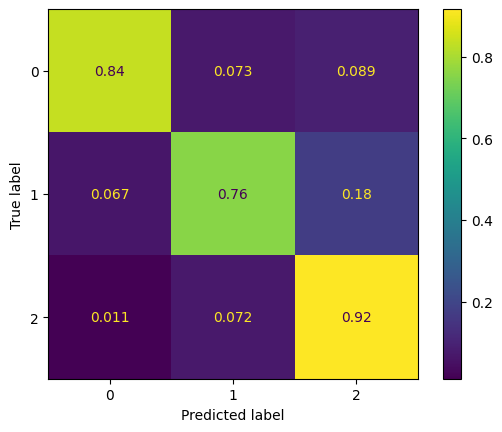

In [10]:
i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LinearDiscriminantAnalysis
    ld = LinearDiscriminantAnalysis()
    ld.fit(X_train, y_train)
    linear_pred = ld.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # DecisionTreeClassifier
    dt = DecisionTreeClassifier(max_depth=6)
    dt.fit(X_train, y_train)
    decisione_pred = dt.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GaussianNB
    gs = GaussianNB()
    gs.fit(X_train, y_train)
    gs_pred = gs.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    #SVM
    SVM = SVC(kernel='rbf', C=8, gamma=0.1)
    SVM.fit(X_train,y_train) # rbf Kernel
    SVM_pred = SVM.predict(X_test)
    
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
    
    lgb_param={'max_depth':10,'learning_rate':0.01,'n_estimators':100,'objective':'multiclass','num_class':len(set(y_train))+1}
    lgbm = LGBMClassifier(**lgb_param)

    new_data = np.array([linear_pred.squeeze(),decisione_pred.squeeze(),SVM_pred.squeeze(),regr_pred.squeeze(),gs_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    lgbm.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    lgbm_pred = lgbm.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(lgbm_pred))
    
    
    accuracy=accuracy_score(y_test, lgbm_pred) 
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,lgbm_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,lgbm_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, lgbm_pred)

    cm = confusion_matrix(y_test, lgbm_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+"가우,랜포,LDA,SVM,grid"+str(i))
    plt.savefig("./ConfusionMatrix/"+filename+".png")
    plt.show()
    
    i=i+1

In [11]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

Accuracy  F1-Score  Precision    Recall
0  0.718885  0.718036   0.723470  0.718885
1  0.782489  0.780751   0.786226  0.782489
2  0.817236  0.816957   0.821743  0.817236
3  0.833530  0.833496   0.838561  0.833530
4  0.804868  0.804278   0.811277  0.804868
5  0.850020  0.848006   0.851710  0.850020
6  0.819395  0.818376   0.822837  0.819395
7  0.803652  0.803404   0.809373  0.803652
8  0.816218  0.815276   0.821324  0.816218
9  0.836639  0.836385   0.842630  0.836639

In [12]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./PFMatrix_ensemble2_final2_grid.xlsx')

In [13]:
new_data

array([[2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 1, 2],
       ...,
       [2, 2, 2, 2, 0, 2],
       [0, 1, 1, 1, 0, 2],
       [0, 1, 2, 1, 0, 2]], dtype=int64)

In [14]:
lgbm_pred

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [15]:
y_test

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)